Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba

Version = "v28" # Calibration (No calbration:CV:0.06542)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
def calibration(y_pred, target_rate):
    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = calibration(y_pred, target_rate)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*30, y_prob.probability.max()*0.6

        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*2 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.1: break
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*2: break
                Threshold += 0.04
                if Threshold >= 0.9: break
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Select TOP100 features based on feature importance with v8 notebook

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])    

In [37]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.465802,-0.291639,-1.052265,-0.263976,-0.823391,-0.341928,0.010720,-1.173292,0.532505,-0.245498,...,-0.370791,0.296662,-0.189006,0.524494,-0.060594,-1.291179,-0.044174,0.035238,-1.003075,0.850758
1,0.690930,0.436481,0.041989,-0.205921,0.051524,-0.997763,0.010672,0.349254,-2.467257,0.051649,...,0.236541,0.511429,-0.395724,0.359766,-0.060531,-0.343840,-0.059517,-0.504862,1.039894,0.448301
2,0.431980,0.413298,-0.550778,0.228193,-0.316045,-0.091551,0.010684,-1.402594,2.933159,-0.098358,...,0.398142,0.057198,-0.085100,-0.389126,-0.060548,-0.638898,-0.064593,0.188724,-1.587868,0.082687
3,0.615831,0.549577,-0.338398,0.302110,-0.636497,0.014752,0.010695,0.608992,1.661933,-1.672100,...,-0.410416,1.084911,-0.372027,0.022141,-0.060392,0.233330,-0.041389,-0.185244,1.222974,-0.208997
4,-2.435831,-1.032850,1.561392,-0.375445,0.640931,-1.937901,0.010701,-0.821339,3.065234,3.784478,...,1.742419,-2.649776,1.168628,-1.301517,-0.060335,-0.073537,-0.062617,2.411493,1.156714,-0.187027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.382860,-0.268638,0.127876,0.192421,-0.158685,-0.935187,0.010694,0.401960,-0.197643,-0.336570,...,-0.774601,-0.102915,-0.506120,0.244405,-0.061289,0.076307,-0.069501,-0.559212,0.002735,-0.076157
27792,-1.119663,0.932683,0.191934,-0.478335,2.873386,-1.900959,0.010635,1.423260,1.279015,0.662655,...,0.451856,-2.802448,3.251854,0.485318,-0.055651,-0.264006,-0.003956,0.298533,-0.897559,-2.260021
27793,-0.967797,0.014373,0.048160,0.451077,1.318727,0.555915,0.010725,-1.395995,-5.161179,-2.554147,...,-0.660537,0.197554,0.329358,-0.761765,-0.061074,1.335331,0.015196,-0.124232,0.474652,-0.139782
27794,-0.326958,-0.259092,-0.513942,0.189562,-0.810409,0.540309,0.010704,-1.266498,-0.061381,0.784678,...,0.730994,0.631450,-0.565547,0.661424,-0.059323,0.576477,-0.009120,-0.395300,-0.335802,-0.161946


In [38]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [39]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 10)


In [40]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 3)


In [41]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
*************
(27796, 10)
(27796, 3)
(27796, 10)
(27796, 3)


In [42]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [43]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [44]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_c_d_c_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g

In [45]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [46]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [47]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

In [48]:
important_col = ["pca_umap_g_2", "pca_umap_g_d_g_8", "pca_umap_all_3", "pca_umap_g_10", "pca_umap_g_d_g_4"]

In [49]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data


Crated 40 columns



Removed 10 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_10_pca_umap_all_3_div,pca_umap_g_10_pca_umap_g_d_g_4_div,pca_umap_g_d_g_4_pca_umap_g_2_prd,pca_umap_g_d_g_4_pca_umap_g_2_div,pca_umap_g_d_g_4_pca_umap_g_d_g_8_prd,pca_umap_g_d_g_4_pca_umap_g_d_g_8_div,pca_umap_g_d_g_4_pca_umap_all_3_prd,pca_umap_g_d_g_4_pca_umap_all_3_div,pca_umap_g_d_g_4_pca_umap_g_10_prd,pca_umap_g_d_g_4_pca_umap_g_10_div
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.0,-2.0,-0.372530,-0.0,0.031359,5.0,-0.612375,-0.0,-0.273265,-1.0
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,4.0,-1.0,-0.634523,-1.0,0.165439,2.0,-0.068703,-6.0,-0.246907,-2.0
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.0,-0.0,-1.114591,-1.0,0.045881,24.0,-0.558856,-2.0,-0.447970,-2.0
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,2.0,-2.0,-0.357978,-1.0,0.146056,1.0,-0.130173,-1.0,-0.308488,-1.0
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,1.0,1.0,0.060373,2.0,0.017711,5.0,0.139919,1.0,0.073825,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.0,-0.0,-0.206348,-7.0,0.146749,9.0,-1.629796,-1.0,-0.298441,-5.0
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.0,-1.0,-0.973184,-1.0,0.064801,17.0,-1.407890,-1.0,-0.775912,-1.0
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,1.0,1.0,1.022249,1.0,0.770045,2.0,1.311937,1.0,0.735862,2.0
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.0,-1.0,-1.052777,-1.0,0.147321,8.0,-1.529836,-1.0,-0.772642,-1.0


In [50]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat2(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data

0/7: Calucurating... max



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 140 columns



Removed 80 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.705612,0.419021,1.124633,0.173420,0.532192,0.592441,0.937024,0.231412,1.356045,0.763604
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.902261,0.638177,0.264085,0.437184,0.465078,0.200993,1.158975,0.256714,0.520799,0.721792
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.784426,0.375651,0.408774,0.450606,0.333820,0.074954,1.493108,0.708682,1.117456,1.042502
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,0.806845,0.364665,0.442180,0.079223,0.727623,0.285442,0.885391,0.078546,0.520726,0.806168
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,0.099206,0.184977,0.284183,0.031282,0.130487,0.153695,0.074624,0.173829,0.110353,0.043342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.213477,0.860594,1.074071,0.055678,0.269155,0.804916,0.951769,0.738293,1.812363,1.007448
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,0.691869,0.289753,0.981622,0.131492,0.560377,0.421245,1.398807,0.706938,1.688561,1.267315
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,0.156384,0.179627,0.336011,0.177579,0.021195,0.357206,0.172496,0.328880,0.007130,0.350076
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,0.798552,0.317438,1.115990,0.186403,0.612149,0.503841,1.451945,0.653393,1.769383,1.265542


In [51]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,0.705612,0.419021,1.124633,0.173420,0.532192,0.592441,0.937024,0.231412,1.356045,0.763604
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.902261,0.638177,0.264085,0.437184,0.465078,0.200993,1.158975,0.256714,0.520799,0.721792
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,0.784426,0.375651,0.408774,0.450606,0.333820,0.074954,1.493108,0.708682,1.117456,1.042502
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,0.806845,0.364665,0.442180,0.079223,0.727623,0.285442,0.885391,0.078546,0.520726,0.806168
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,0.099206,0.184977,0.284183,0.031282,0.130487,0.153695,0.074624,0.173829,0.110353,0.043342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.213477,0.860594,1.074071,0.055678,0.269155,0.804916,0.951769,0.738293,1.812363,1.007448
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,0.691869,0.289753,0.981622,0.131492,0.560377,0.421245,1.398807,0.706938,1.688561,1.267315
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,0.156384,0.179627,0.336011,0.177579,0.021195,0.357206,0.172496,0.328880,0.011069,0.350076
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,0.798552,0.317438,1.115990,0.186403,0.612149,0.503841,1.451945,0.653393,1.769383,1.265542


In [52]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [53]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [54]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803535	valid_1's binary_logloss: 0.15298
[200]	training's binary_logloss: 0.0155448	valid_1's binary_logloss: 0.07851
[300]	training's binary_logloss: 0.00534619	valid_1's binary_logloss: 0.0616141
[400]	training's binary_logloss: 0.00300153	valid_1's binary_logloss: 0.0569113
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00258203	valid_1's binary_logloss: 0.055644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912167	valid_1's binary_logloss: 0.130829
[200]	training's binary_logloss: 0.0188636	valid_1's binary_logloss: 0.047028
[300]	training's binary_logloss: 0.00635629	valid_1's binary_logloss: 0.025702
[400]	training's binary_logloss: 0.00340662	valid_1's binary_logloss: 0.0184073


1 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00241482	valid_1's binary_logloss: 0.0153383
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00214929	valid_1's binary_logloss: 0.0144728


Remove_noisy_labels: 10 → positive_corect_labels: 500/990
p_label_rate: 0.00979 Vs.target_rate: 0.00071, Num_p_label: 39.0, conf_0:0.00439, conf_1:0.59710
Num_p_label: 39.0, Expected: 2.8, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 2.8, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 2.8, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 2.8, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 2.8, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 2.8, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/990, y_label_rate: 0.50505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827157	valid_1's binary_logloss: 0.146992
[200]	training's binary_logloss: 0.0165689	valid_1's binary_logloss: 0.065774
[300]	training's binary_logloss: 0.00556169	valid_1's binary_logloss: 0.0437117
[400]	training's binary_logloss: 0.00300178	valid_1's binary_logloss: 0.0363916
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00239589	valid_1's binary_logloss: 0.0337333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839524	valid_1's binary_logloss: 0.131109
[200]	training's binary_logloss: 0.0167157	valid_1's binary_logloss: 0.050469
[300]	training's binary_logloss: 0.00566644	valid_1's binary_logloss: 0.0320816
[400]	training's binary_logloss: 0.00310236	valid_1's binary_logloss: 0.0256564


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/988
p_label_rate: 0.00176 Vs.target_rate: 0.00071, Num_p_label: 7.0, conf_0:0.00348, conf_1:0.59821
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/988, y_label_rate: 0.50405
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00224355	valid_1's binary_logloss: 0.0239799
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00228612	valid_1's binary_logloss: 0.0239684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844848	valid_1's binary_logloss: 0.149851
[200]	training's binary_logloss: 0.0164596	valid_1's binary_logloss: 0.0637813
[300]	training's binary_logloss: 0.00545884	valid_1's binary_logloss: 0.044297
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00396385	valid_1's binary_logloss: 0.0398349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858365	valid_1's binary_logloss: 0.131871
[200]	training's binary_logloss: 0.0169675	valid_1's binary_logloss: 0.0529161
[300]	training's binary_logloss: 0.00576931	valid_1's binary_logloss: 0.0320127
[400]	training's binary_logloss: 0.00316555	valid_1's binary_logloss: 0.0265815


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/985
p_label_rate: 0.00176 Vs.target_rate: 0.00071, Num_p_label: 7.0, conf_0:0.00652, conf_1:0.59786
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/985, y_label_rate: 0.50355
len(train_index) : 492
len(valid_index) : 493
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00275084	valid_1's binary_logloss: 0.0252373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855494	valid_1's binary_logloss: 0.141338
[200]	training's binary_logloss: 0.016588	valid_1's binary_logloss: 0.0558245
[300]	training's binary_logloss: 0.00548977	valid_1's binary_logloss: 0.0345759
[400]	training's binary_logloss: 0.00301525	valid_1's binary_logloss: 0.027302
[500]	training's binary_logloss: 0.00219447	valid_1's binary_logloss: 0.0227922
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0019715	valid_1's binary_logloss: 0.0214054


len(train_index) : 493
len(valid_index) : 492
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782168	valid_1's binary_logloss: 0.130033
[200]	training's binary_logloss: 0.0152911	valid_1's binary_logloss: 0.058174
[300]	training's binary_logloss: 0.00522953	valid_1's binary_logloss: 0.0398016
[400]	training's binary_logloss: 0.00294206	valid_1's binary_logloss: 0.033267
[500]	training's binary_logloss: 0.00212613	valid_1's binary_logloss: 0.0307621
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00197228	valid_1's binary_logloss: 0.0299536


5-alpha_reductase_inhibitor logloss: 0.0256751734700086
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705178	valid_1's binary_logloss: 0.122526
[200]	training's binary_logloss: 0.0128417	valid_1's binary_logloss: 0.0591205
[300]	training's binary_logloss: 0.00445212	valid_1's binary_logloss: 0.0438043
[400]	training's binary_logloss: 0.00255645	valid_1's binary_logloss: 0.0387146
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00260649	valid_1's binary_logloss: 0.03847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752447	valid_1's binary_logloss: 0.127295
[200]	training's binary_logloss: 0.0137018	valid_1's binary_logloss: 0.0570341
[300]	training's binary_logloss: 0.00461566	valid_1's binary_logloss: 0.0405197


1 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 497/988
p_label_rate: 0.04194 Vs.target_rate: 0.00076, Num_p_label: 167.0, conf_0:0.01023, conf_1:0.58841
Num_p_label: 167.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 142.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 126.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 95.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00285049	valid_1's binary_logloss: 0.0361131


positive y_label:497.0/988, y_label_rate: 0.50304
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674247	valid_1's binary_logloss: 0.130808
[200]	training's binary_logloss: 0.0120386	valid_1's binary_logloss: 0.066012
[300]	training's binary_logloss: 0.0040911	valid_1's binary_logloss: 0.0506289
[400]	training's binary_logloss: 0.00232408	valid_1's binary_logloss: 0.0456463
[500]	training's binary_logloss: 0.0018241	valid_1's binary_logloss: 0.0435729
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00181044	valid_1's binary_logloss: 0.0434306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701908	valid_1's binary_logloss: 0.114732
[200]	training's binary_logloss: 0.0122703	valid_1's binary_logloss: 0.0525815
[300]	training's binary_logloss: 0.00419301	valid_1's binary_logloss: 0.0374694


2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 482.0/973
p_label_rate: 0.01205 Vs.target_rate: 0.00076, Num_p_label: 48.0, conf_0:0.01210, conf_1:0.59299
Num_p_label: 48.0, Expected: 3.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:482.0/973, y_label_rate: 0.49538
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00365483	valid_1's binary_logloss: 0.0362636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707332	valid_1's binary_logloss: 0.114412
[200]	training's binary_logloss: 0.0128908	valid_1's binary_logloss: 0.0397581
[300]	training's binary_logloss: 0.00421557	valid_1's binary_logloss: 0.0235725
[400]	training's binary_logloss: 0.00237243	valid_1's binary_logloss: 0.0180914
[500]	training's binary_logloss: 0.00183312	valid_1's binary_logloss: 0.0164982
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00180043	valid_1's binary_logloss: 0.0162462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659838	valid_1's binary_logloss: 0.101487
[200]	training's binary_logloss: 0.0115139	valid_1's binary_logloss: 0.0397365
[300]	training's binary_logloss: 0.00391419	valid_1's binary_logloss: 0.024338
[400]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 474.0/965
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00536, conf_1:0.59435
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:474.0/965, y_label_rate: 0.49119
len(train_index) : 482
len(valid_index) : 483
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694946	valid_1's binary_logloss: 0.101758
[200]	training's binary_logloss: 0.0124048	valid_1's binary_logloss: 0.0356862
[300]	training's binary_logloss: 0.00421629	valid_1's binary_logloss: 0.0222136
[400]	training's binary_logloss: 0.00239692	valid_1's binary_logloss: 0.017512


len(train_index) : 483
len(valid_index) : 482
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00184846	valid_1's binary_logloss: 0.0154662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640941	valid_1's binary_logloss: 0.110373
[200]	training's binary_logloss: 0.0111101	valid_1's binary_logloss: 0.0452028
[300]	training's binary_logloss: 0.0037894	valid_1's binary_logloss: 0.0305902
[400]	training's binary_logloss: 0.00220463	valid_1's binary_logloss: 0.0249036


11-beta-hsd1_inhibitor logloss: 0.019216536824876215
acat_inhibitor , len(trt) : 24


[500]	training's binary_logloss: 0.001713	valid_1's binary_logloss: 0.023033
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00169572	valid_1's binary_logloss: 0.0229747


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856975	valid_1's binary_logloss: 0.167215
[200]	training's binary_logloss: 0.0174157	valid_1's binary_logloss: 0.0978046
[300]	training's binary_logloss: 0.00595176	valid_1's binary_logloss: 0.083235
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00340775	valid_1's binary_logloss: 0.0792132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886582	valid_1's binary_logloss: 0.160569
[200]	training's binary_logloss: 0.0184124	valid_1's binary_logloss: 0.0839649
[300]	training's binary_logloss: 0.00642183	valid_1's binary_logloss: 0.0638708
[400]	training's binary_logloss: 0.003409	valid_1's binary_logloss: 0.0579625


1 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 496/977
p_label_rate: 0.00703 Vs.target_rate: 0.00101, Num_p_label: 28.0, conf_0:0.00616, conf_1:0.59441
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.0028316	valid_1's binary_logloss: 0.0557071


positive y_label:496.0/977, y_label_rate: 0.50768
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782072	valid_1's binary_logloss: 0.14807
[200]	training's binary_logloss: 0.014895	valid_1's binary_logloss: 0.0719872
[300]	training's binary_logloss: 0.0050826	valid_1's binary_logloss: 0.055004
[400]	training's binary_logloss: 0.00278115	valid_1's binary_logloss: 0.0483771
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00285907	valid_1's binary_logloss: 0.0481992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819233	valid_1's binary_logloss: 0.155893
[200]	training's binary_logloss: 0.0161506	valid_1's binary_logloss: 0.0781466
[300]	training's binary_logloss: 0.00544179	valid_1's binary_logloss: 0.0578045


2 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 486.0/964
p_label_rate: 0.00829 Vs.target_rate: 0.00101, Num_p_label: 33.0, conf_0:0.00521, conf_1:0.59613
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00292054	valid_1's binary_logloss: 0.0511267
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00273291	valid_1's binary_logloss: 0.0505279


positive y_label:486.0/964, y_label_rate: 0.50415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079264	valid_1's binary_logloss: 0.147726
[200]	training's binary_logloss: 0.0144433	valid_1's binary_logloss: 0.0680867
[300]	training's binary_logloss: 0.00482857	valid_1's binary_logloss: 0.0458602
[400]	training's binary_logloss: 0.00269486	valid_1's binary_logloss: 0.0382444
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0020937	valid_1's binary_logloss: 0.0343884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790396	valid_1's binary_logloss: 0.126637
[200]	training's binary_logloss: 0.0153144	valid_1's binary_logloss: 0.0472178
[300]	training's binary_logloss: 0.00517207	valid_1's binary_logloss: 0.0302501
[400]	training's binary_logloss: 0.00281414	valid_1's binary_logloss: 0.0255324
[500]	training's binary_logloss: 0.00203388	valid_1's binary_logloss: 0.0232887
Early stopping, best iteration is:
[574]	training's

3 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 476.0/954
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00288, conf_1:0.59767
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:476.0/954, y_label_rate: 0.49895
len(train_index) : 477
len(valid_index) : 477
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770893	valid_1's binary_logloss: 0.131664
[200]	training's binary_logloss: 0.0144472	valid_1's binary_logloss: 0.057508
[300]	training's binary_logloss: 0.00475503	valid_1's binary_logloss: 0.0403027
[400]	training's binary_logloss: 0.00261625	valid_1's binary_logloss: 0.0337013
[500]	training's binary_logloss: 0.00192958	valid_1's binary_logloss: 0.0312786
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00172484	valid_1's binary_logloss: 0.0303509


len(train_index) : 477
len(valid_index) : 477
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785637	valid_1's binary_logloss: 0.128725
[200]	training's binary_logloss: 0.0148169	valid_1's binary_logloss: 0.0523433
[300]	training's binary_logloss: 0.00494729	valid_1's binary_logloss: 0.0339344
[400]	training's binary_logloss: 0.0027186	valid_1's binary_logloss: 0.0264864
[500]	training's binary_logloss: 0.00196584	valid_1's binary_logloss: 0.023039
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.0017908	valid_1's binary_logloss: 0.0218296


acat_inhibitor logloss: 0.026090243857258794
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.243714	valid_1's binary_logloss: 0.557748
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.127737	valid_1's binary_logloss: 0.52789
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.799
Remove_noisy_labels: 282 → positive_corect_labels: 369/718


[100]	training's binary_logloss: 0.249745	valid_1's binary_logloss: 0.582726
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.185068	valid_1's binary_logloss: 0.567023


p_label_rate: 0.32346 Vs.target_rate: 0.00798, Num_p_label: 1288.0, conf_0:2.20861, conf_1:0.53885
Num_p_label: 1288.0, Expected: 31.8, Adj_threshold_1: 0.50
Num_p_label: 946.0, Expected: 31.8, Adj_threshold_2: 0.54
Num_p_label: 692.0, Expected: 31.8, Adj_threshold_3: 0.58
Num_p_label: 474.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 299.0, Expected: 31.8, Adj_threshold_5: 0.66
Num_p_label: 174.0, Expected: 31.8, Adj_threshold_6: 0.70
Num_p_label: 97.0, Expected: 31.8, Adj_threshold_7: 0.74
Num_p_label: 49.0, Expected: 31.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:369.0/1673, y_label_rate: 0.22056
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108711	valid_1's binary_logloss: 0.228991
[200]	training's binary_logloss: 0.0351933	valid_1's binary_logloss: 0.181365
[300]	training's binary_logloss: 0.0137073	valid_1's binary_logloss: 0.165809
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0118029	valid_1's binary_logloss: 0.164349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10316	valid_1's binary_logloss: 0.239729
[200]	training's binary_logloss: 0.0349742	valid_1's binary_logloss: 0.210099


2 / 3 AUC score:0.969
Remove_noisy_labels: 130 → positive_corect_labels: 256.0/1543
p_label_rate: 0.00000 Vs.target_rate: 0.00798, Num_p_label: 0.0, conf_0:0.00558, conf_1:0.42467
Num_p_label: 0.0, Expected: 31.8, Adj_threshold_1: 0.78
Num_p_label: 0.0, Expected: 31.8, Adj_threshold_2: 0.74
Num_p_label: 1.0, Expected: 31.8, Adj_threshold_3: 0.70
Num_p_label: 3.0, Expected: 31.8, Adj_threshold_4: 0.66
Num_p_label: 5.0, Expected: 31.8, Adj_threshold_5: 0.62
Num_p_label: 9.0, Expected: 31.8, Adj_threshold_6: 0.58
Num_p_label: 9.0, Expected: 31.8, Adj_threshold_7: 0.54
Num_p_label: 11.0, Expected: 31.8, Adj_threshold_8: 0.50
Num_p_label: 17.0, Expected: 31.8, Adj_threshold_9: 0.46
threshold:0.46, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0180387	valid_1's binary_logloss: 0.202333


positive y_label:256.0/1543, y_label_rate: 0.16591
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652701	valid_1's binary_logloss: 0.173879
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0213655	valid_1's binary_logloss: 0.146944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612339	valid_1's binary_logloss: 0.196539


3 / 3 AUC score:0.966
Remove_noisy_labels: 95 → positive_corect_labels: 199.0/1448
p_label_rate: 0.00377 Vs.target_rate: 0.00798, Num_p_label: 15.0, conf_0:0.03130, conf_1:0.45955
threshold:0.46, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:199.0/1448, y_label_rate: 0.13743
len(train_index) : 724
len(valid_index) : 724
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[168]	training's binary_logloss: 0.0241822	valid_1's binary_logloss: 0.185848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041915	valid_1's binary_logloss: 0.117581


len(train_index) : 724
len(valid_index) : 724
================================= fold 2/2 acetylcholine_receptor_agonist=================================


[200]	training's binary_logloss: 0.00942016	valid_1's binary_logloss: 0.0904179
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00990049	valid_1's binary_logloss: 0.0900172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448578	valid_1's binary_logloss: 0.0971161


acetylcholine_receptor_agonist logloss: 0.07994061049045782


[200]	training's binary_logloss: 0.0106162	valid_1's binary_logloss: 0.0719539
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00676794	valid_1's binary_logloss: 0.069864


acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.466997	valid_1's binary_logloss: 0.665729
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.648
Remove_noisy_labels: 398 → positive_corect_labels: 309/602
p_label_rate: 0.22853 Vs.target_rate: 0.01264, Num_p_label: 910.0, conf_0:7.68009, conf_1:0.41898
Num_p_label: 910.0, Expected: 50.3, Adj_threshold_1: 0.50
Num_p_label: 420.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 170.0, Expected: 50.3, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 50.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:45.0/3982, p_label_rate: 0.01130


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.421468	valid_1's binary_logloss: 0.656552


positive y_label:354.0/3483, y_label_rate: 0.10164
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562162	valid_1's binary_logloss: 0.16997
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0294136	valid_1's binary_logloss: 0.165894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589019	valid_1's binary_logloss: 0.177296


2 / 3 AUC score:0.936
Remove_noisy_labels: 227 → positive_corect_labels: 147.0/3256
p_label_rate: 0.00000 Vs.target_rate: 0.01264, Num_p_label: 0.0, conf_0:0.04609, conf_1:0.29700
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_4: 0.50
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_5: 0.46
Num_p_label: 7.0, Expected: 50.3, Adj_threshold_6: 0.42
Num_p_label: 14.0, Expected: 50.3, Adj_threshold_7: 0.38
Num_p_label: 27.0, Expected: 50.3, Adj_threshold_8: 0.34
threshold:0.34, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0410445	valid_1's binary_logloss: 0.174029


positive y_label:147.0/3256, y_label_rate: 0.04515
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165691	valid_1's binary_logloss: 0.0607456
[200]	training's binary_logloss: 0.00398357	valid_1's binary_logloss: 0.04927
[300]	training's binary_logloss: 0.00153562	valid_1's binary_logloss: 0.0455289
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00142933	valid_1's binary_logloss: 0.0454987
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.987


[100]	training's binary_logloss: 0.0148603	valid_1's binary_logloss: 0.0586389
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0095798	valid_1's binary_logloss: 0.0557106


Remove_noisy_labels: 61 → positive_corect_labels: 109.0/3195
p_label_rate: 0.00025 Vs.target_rate: 0.01264, Num_p_label: 1.0, conf_0:0.01839, conf_1:0.40772
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_1: 0.34
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_2: 0.30
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_3: 0.26
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_4: 0.22
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_5: 0.18
Num_p_label: 3.0, Expected: 50.3, Adj_threshold_6: 0.14
Num_p_label: 5.0, Expected: 50.3, Adj_threshold_7: 0.10
threshold:0.06, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:109.0/3195, y_label_rate: 0.03412
len(train_index) : 1597
len(valid_index) : 1598
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00950451	valid_1's binary_logloss: 0.0331492


len(train_index) : 1598
len(valid_index) : 1597
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00288556	valid_1's binary_logloss: 0.0252953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00944255	valid_1's binary_logloss: 0.0427277


acetylcholine_receptor_antagonist logloss: 0.030101923799593613
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00311831	valid_1's binary_logloss: 0.0349115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165487	valid_1's binary_logloss: 0.359439
[200]	training's binary_logloss: 0.0525739	valid_1's binary_logloss: 0.263762
[300]	training's binary_logloss: 0.0197442	valid_1's binary_logloss: 0.232845
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0133895	valid_1's binary_logloss: 0.224579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167795	valid_1's binary_logloss: 0.336602
[200]	training's binary_logloss: 0.0536298	valid_1's binary_logloss: 0.253069


1 / 3 AUC score:0.969
Remove_noisy_labels: 92 → positive_corect_labels: 464/908
p_label_rate: 0.15244 Vs.target_rate: 0.00307, Num_p_label: 607.0, conf_0:0.04732, conf_1:0.55563
Num_p_label: 607.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 470.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 363.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 277.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 207.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 148.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 101.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 61.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377


[300]	training's binary_logloss: 0.0204569	valid_1's binary_logloss: 0.228275
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0207923	valid_1's binary_logloss: 0.228064


positive y_label:464.0/908, y_label_rate: 0.51101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13866	valid_1's binary_logloss: 0.289858
[200]	training's binary_logloss: 0.0387366	valid_1's binary_logloss: 0.195914
[300]	training's binary_logloss: 0.014609	valid_1's binary_logloss: 0.166764
[400]	training's binary_logloss: 0.00736259	valid_1's binary_logloss: 0.155137
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0068095	valid_1's binary_logloss: 0.153837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135134	valid_1's binary_logloss: 0.295347
[200]	training's binary_logloss: 0.0389924	valid_1's binary_logloss: 0.206543
[300]	training's binary_logloss: 0.0147188	valid_1's binary_logloss: 0.178693


2 / 3 AUC score:0.984
Remove_noisy_labels: 61 → positive_corect_labels: 411.0/847
p_label_rate: 0.03742 Vs.target_rate: 0.00307, Num_p_label: 149.0, conf_0:0.01735, conf_1:0.59498
Num_p_label: 149.0, Expected: 12.2, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:149.0/3982, p_label_rate: 0.03742


[400]	training's binary_logloss: 0.00750938	valid_1's binary_logloss: 0.163124
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00722865	valid_1's binary_logloss: 0.162459


positive y_label:411.0/847, y_label_rate: 0.48524
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124005	valid_1's binary_logloss: 0.251004
[200]	training's binary_logloss: 0.0331975	valid_1's binary_logloss: 0.156684
[300]	training's binary_logloss: 0.0125788	valid_1's binary_logloss: 0.129512
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00849908	valid_1's binary_logloss: 0.124218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134341	valid_1's binary_logloss: 0.255173
[200]	training's binary_logloss: 0.0370285	valid_1's binary_logloss: 0.153596
[300]	training's binary_logloss: 0.013855	valid_1's binary_logloss: 0.130413


3 / 3 AUC score:0.991
Remove_noisy_labels: 47 → positive_corect_labels: 366.0/800
p_label_rate: 0.05048 Vs.target_rate: 0.00307, Num_p_label: 201.0, conf_0:0.02410, conf_1:0.59763
Num_p_label: 201.0, Expected: 12.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:201.0/3982, p_label_rate: 0.05048
positive y_label:366.0/800, y_label_rate: 0.45750
len(train_index) : 400
len(valid_index) : 400
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0102707	valid_1's binary_logloss: 0.123139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115796	valid_1's binary_logloss: 0.236541
[200]	training's binary_logloss: 0.0293719	valid_1's binary_logloss: 0.144801
[300]	training's binary_logloss: 0.0110627	valid_1's binary_logloss: 0.117209
[400]	training's binary_logloss: 0.00588615	valid_1's binary_logloss: 0.106818
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00455047	valid_1's binary_logloss: 0.101541


len(train_index) : 400
len(valid_index) : 400
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115508	valid_1's binary_logloss: 0.224683
[200]	training's binary_logloss: 0.0296659	valid_1's binary_logloss: 0.133643
[300]	training's binary_logloss: 0.0110502	valid_1's binary_logloss: 0.106185


acetylcholinesterase_inhibitor logloss: 0.09786644042145873
adenosine_receptor_agonist , len(trt) : 54


[400]	training's binary_logloss: 0.00579479	valid_1's binary_logloss: 0.0950067
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00563465	valid_1's binary_logloss: 0.0941915


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153825	valid_1's binary_logloss: 0.279594
[200]	training's binary_logloss: 0.0452216	valid_1's binary_logloss: 0.178298
[300]	training's binary_logloss: 0.0165513	valid_1's binary_logloss: 0.139375
[400]	training's binary_logloss: 0.00822897	valid_1's binary_logloss: 0.124089
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00822897	valid_1's binary_logloss: 0.124089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149539	valid_1's binary_logloss: 0.309951
[200]	training's binary_logloss: 0.0427979	valid_1's binary_logloss: 0.214942
[300]	training's binary_logloss: 0.0158311	valid_1's binary_logloss: 0.18228
[400]	training's binary_logloss: 0.00787244	valid_1's binary_logloss: 0.172505
[500]	training's binary_logloss: 0.00498079	valid_1's binary_logloss: 0.165201


1 / 3 AUC score:0.990
Remove_noisy_labels: 62 → positive_corect_labels: 484/938
p_label_rate: 0.01431 Vs.target_rate: 0.00227, Num_p_label: 57.0, conf_0:0.02595, conf_1:0.53306
Num_p_label: 57.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00399001	valid_1's binary_logloss: 0.161155


Num_p_label: 23.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:484.0/938, y_label_rate: 0.51599
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124186	valid_1's binary_logloss: 0.289066
[200]	training's binary_logloss: 0.0339756	valid_1's binary_logloss: 0.190416
[300]	training's binary_logloss: 0.0122428	valid_1's binary_logloss: 0.161478
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00726806	valid_1's binary_logloss: 0.149609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13085	valid_1's binary_logloss: 0.251377
[200]	training's binary_logloss: 0.0359016	valid_1's binary_logloss: 0.149255
[300]	training's binary_logloss: 0.0130732	valid_1's binary_logloss: 0.110782
[400]	training's binary_logloss: 0.00666306	valid_1's binary_logloss: 0.0957173
[500]	training's binary_logloss: 0.00430265	valid_1's binary_logloss: 0.0892942
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.0033918	valid_1's binary_logloss: 0.086079


2 / 3 AUC score:0.992
Remove_noisy_labels: 41 → positive_corect_labels: 450.0/897
p_label_rate: 0.01205 Vs.target_rate: 0.00227, Num_p_label: 48.0, conf_0:0.01748, conf_1:0.57830
Num_p_label: 48.0, Expected: 9.0, Adj_threshold_1: 0.70
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_2: 0.74
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_3: 0.78
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_4: 0.82
Num_p_label: 7.0, Expected: 9.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:450.0/897, y_label_rate: 0.50167
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121206	valid_1's binary_logloss: 0.258917
[200]	training's binary_logloss: 0.0325569	valid_1's binary_logloss: 0.156971
[300]	training's binary_logloss: 0.0117817	valid_1's binary_logloss: 0.118351
[400]	training's binary_logloss: 0.00615749	valid_1's binary_logloss: 0.103368
[500]	training's binary_logloss: 0.00406964	valid_1's binary_logloss: 0.0939727
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00396415	valid_1's binary_logloss: 0.0930332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126571	valid_1's binary_logloss: 0.236896
[200]	training's binary_logloss: 0.033844	valid_1's binary_logloss: 0.136359
[300]	training's binary_logloss: 0.0123795	valid_1's binary_logloss: 0.100698
[400]	training's binary_logloss: 0.00633422	valid_1's binary_logloss: 0.0864818


3 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 417.0/864
p_label_rate: 0.00276 Vs.target_rate: 0.00227, Num_p_label: 11.0, conf_0:0.01142, conf_1:0.56246
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00495333	valid_1's binary_logloss: 0.0817283


positive y_label:417.0/864, y_label_rate: 0.48264
len(train_index) : 432
len(valid_index) : 432
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121356	valid_1's binary_logloss: 0.209243
[200]	training's binary_logloss: 0.0315924	valid_1's binary_logloss: 0.11348
[300]	training's binary_logloss: 0.01176	valid_1's binary_logloss: 0.0806399
[400]	training's binary_logloss: 0.0060977	valid_1's binary_logloss: 0.0711608
[500]	training's binary_logloss: 0.00401867	valid_1's binary_logloss: 0.0676552


len(train_index) : 432
len(valid_index) : 432
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00371507	valid_1's binary_logloss: 0.0662381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117151	valid_1's binary_logloss: 0.221147
[200]	training's binary_logloss: 0.0296813	valid_1's binary_logloss: 0.132828
[300]	training's binary_logloss: 0.0106343	valid_1's binary_logloss: 0.0990908


adenosine_receptor_agonist logloss: 0.07617103117514616


[400]	training's binary_logloss: 0.00559851	valid_1's binary_logloss: 0.0883851
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00467404	valid_1's binary_logloss: 0.086104


adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206899	valid_1's binary_logloss: 0.416779
[200]	training's binary_logloss: 0.0777575	valid_1's binary_logloss: 0.341361
[300]	training's binary_logloss: 0.0320401	valid_1's binary_logloss: 0.306709
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0226273	valid_1's binary_logloss: 0.2997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195358	valid_1's binary_logloss: 0.420819
[200]	training's binary_logloss: 0.0733236	valid_1's binary_logloss: 0.34403


1 / 3 AUC score:0.941
Remove_noisy_labels: 137 → positive_corect_labels: 442/863
p_label_rate: 0.02762 Vs.target_rate: 0.00403, Num_p_label: 110.0, conf_0:0.12909, conf_1:0.57858
Num_p_label: 110.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 83.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0338728	valid_1's binary_logloss: 0.320009


positive y_label:442.0/863, y_label_rate: 0.51217
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164269	valid_1's binary_logloss: 0.32915
[200]	training's binary_logloss: 0.0530999	valid_1's binary_logloss: 0.238216
[300]	training's binary_logloss: 0.0205102	valid_1's binary_logloss: 0.202989
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0151349	valid_1's binary_logloss: 0.197573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168128	valid_1's binary_logloss: 0.315631
[200]	training's binary_logloss: 0.0553371	valid_1's binary_logloss: 0.223092


2 / 3 AUC score:0.982
Remove_noisy_labels: 57 → positive_corect_labels: 409.0/806


[300]	training's binary_logloss: 0.0215453	valid_1's binary_logloss: 0.183404
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.01583	valid_1's binary_logloss: 0.175873


p_label_rate: 0.02210 Vs.target_rate: 0.00403, Num_p_label: 88.0, conf_0:0.03207, conf_1:0.59040
Num_p_label: 88.0, Expected: 16.1, Adj_threshold_1: 0.70
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_2: 0.74
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_3: 0.78
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_4: 0.82
Num_p_label: 23.0, Expected: 16.1, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:409.0/806, y_label_rate: 0.50744
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143867	valid_1's binary_logloss: 0.317921
[200]	training's binary_logloss: 0.0423115	valid_1's binary_logloss: 0.238941
[300]	training's binary_logloss: 0.0159461	valid_1's binary_logloss: 0.208459
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00970598	valid_1's binary_logloss: 0.199095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15352	valid_1's binary_logloss: 0.276893
[200]	training's binary_logloss: 0.0462119	valid_1's binary_logloss: 0.16993
[300]	training's binary_logloss: 0.0180735	valid_1's binary_logloss: 0.128929
[400]	training's binary_logloss: 0.009058	valid_1's binary_logloss: 0.110763
[500]	training's binary_logloss: 0.0057538	valid_1's binary_logloss: 0.10074


3 / 3 AUC score:0.990


[600]	training's binary_logloss: 0.00421876	valid_1's binary_logloss: 0.0948161
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00392468	valid_1's binary_logloss: 0.0934312


Remove_noisy_labels: 52 → positive_corect_labels: 364.0/754
p_label_rate: 0.01582 Vs.target_rate: 0.00403, Num_p_label: 63.0, conf_0:0.00653, conf_1:0.59738
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:364.0/754, y_label_rate: 0.48276
len(train_index) : 377
len(valid_index) : 377
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130673	valid_1's binary_logloss: 0.269891
[200]	training's binary_logloss: 0.037085	valid_1's binary_logloss: 0.182843
[300]	training's binary_logloss: 0.0142075	valid_1's binary_logloss: 0.154317
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0147595	valid_1's binary_logloss: 0.154035


len(train_index) : 377
len(valid_index) : 377
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134146	valid_1's binary_logloss: 0.259125
[200]	training's binary_logloss: 0.0396556	valid_1's binary_logloss: 0.179413
[300]	training's binary_logloss: 0.0151903	valid_1's binary_logloss: 0.149124


adenosine_receptor_antagonist logloss: 0.14647162530353092
adenylyl_cyclase_activator , len(trt) : 18


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.01026	valid_1's binary_logloss: 0.138909


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823248	valid_1's binary_logloss: 0.125841
[200]	training's binary_logloss: 0.0158411	valid_1's binary_logloss: 0.0575277
[300]	training's binary_logloss: 0.00525357	valid_1's binary_logloss: 0.0419049
[400]	training's binary_logloss: 0.00290197	valid_1's binary_logloss: 0.0370364
[500]	training's binary_logloss: 0.00211959	valid_1's binary_logloss: 0.0345002
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00211959	valid_1's binary_logloss: 0.0345002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799153	valid_1's binary_logloss: 0.141814
[200]	training's binary_logloss: 0.015241	valid_1's binary_logloss: 0.0626302
[300]	training's binary_logloss: 0.00526739	valid_1's binary_logloss: 0.043273
[400]	training's binary_logloss: 0.00287176	valid_1's binary_logloss: 0.0364679


1 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 494/989
p_label_rate: 0.07735 Vs.target_rate: 0.00076, Num_p_label: 308.0, conf_0:0.00661, conf_1:0.57552
Num_p_label: 308.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 237.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 172.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 133.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 95.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 62.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00251659	valid_1's binary_logloss: 0.0345984


positive y_label:494.0/989, y_label_rate: 0.49949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757721	valid_1's binary_logloss: 0.119261
[200]	training's binary_logloss: 0.0144188	valid_1's binary_logloss: 0.0446912
[300]	training's binary_logloss: 0.00484637	valid_1's binary_logloss: 0.0277659
[400]	training's binary_logloss: 0.00267424	valid_1's binary_logloss: 0.0218969
[500]	training's binary_logloss: 0.00195421	valid_1's binary_logloss: 0.0196927
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00184863	valid_1's binary_logloss: 0.0192928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776679	valid_1's binary_logloss: 0.13524
[200]	training's binary_logloss: 0.0146496	valid_1's binary_logloss: 0.0575753


2 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 480.0/975
p_label_rate: 0.00452 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.01463, conf_1:0.58194
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452


[300]	training's binary_logloss: 0.00487362	valid_1's binary_logloss: 0.0418418
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0043284	valid_1's binary_logloss: 0.0398586


positive y_label:480.0/975, y_label_rate: 0.49231
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744809	valid_1's binary_logloss: 0.113251
[200]	training's binary_logloss: 0.013854	valid_1's binary_logloss: 0.0396491
[300]	training's binary_logloss: 0.00463483	valid_1's binary_logloss: 0.0237762
[400]	training's binary_logloss: 0.00255508	valid_1's binary_logloss: 0.0185207
[500]	training's binary_logloss: 0.00192295	valid_1's binary_logloss: 0.0168349
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00196551	valid_1's binary_logloss: 0.0167555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767175	valid_1's binary_logloss: 0.135271
[200]	training's binary_logloss: 0.0139253	valid_1's binary_logloss: 0.0612732
[300]	training's binary_logloss: 0.00462817	valid_1's binary_logloss: 0.0448077


3 / 3 AUC score:1.000
Remove_noisy_labels: 17 → positive_corect_labels: 463.0/958
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.01056, conf_1:0.57500
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:463.0/958, y_label_rate: 0.48330
len(train_index) : 479
len(valid_index) : 479
================================= fold 1/2 adenylyl_cyclase_activator=================================


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00368844	valid_1's binary_logloss: 0.043128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073292	valid_1's binary_logloss: 0.125132
[200]	training's binary_logloss: 0.0131124	valid_1's binary_logloss: 0.0473268
[300]	training's binary_logloss: 0.00439784	valid_1's binary_logloss: 0.0293438


len(train_index) : 479
len(valid_index) : 479
================================= fold 2/2 adenylyl_cyclase_activator=================================


[400]	training's binary_logloss: 0.00246568	valid_1's binary_logloss: 0.0232982
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00214027	valid_1's binary_logloss: 0.0220129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722615	valid_1's binary_logloss: 0.114811
[200]	training's binary_logloss: 0.0127277	valid_1's binary_logloss: 0.0395838
[300]	training's binary_logloss: 0.0043858	valid_1's binary_logloss: 0.0244516
[400]	training's binary_logloss: 0.00245401	valid_1's binary_logloss: 0.0188676
[500]	training's binary_logloss: 0.0018365	valid_1's binary_logloss: 0.0164733
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00170128	valid_1's binary_logloss: 0.0159198


adenylyl_cyclase_activator logloss: 0.01896635125235018
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.280557	valid_1's binary_logloss: 0.637272
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.293772	valid_1's binary_logloss: 0.636202
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.670
Remove_noisy_labels: 393 → positive_corect_labels: 313/607
p_label_rate: 0.27624 Vs.target_rate: 0.01134, Num_p_label: 1100.0, conf_0:5.56528, conf_1:0.47811
Num_p_label: 1100.0, Expected: 45.1, Adj_threshold_1: 0.50
Num_p_label: 636.0, Expected: 45.1, Adj_threshold_2: 0.54
Num_p_label: 342.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 172.0, Expected: 45.1, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 45.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:72.0/3982, p_label_rate: 0.01808
positive y_label:342.0/2032, y_label_rate: 0.16831
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.346223	valid_1's binary_logloss: 0.661688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962598	valid_1's binary_logloss: 0.234339
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0463402	valid_1's binary_logloss: 0.221168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925094	valid_1's binary_logloss: 0.24029


2 / 3 AUC score:0.920
Remove_noisy_labels: 158 → positive_corect_labels: 203.0/1874
p_label_rate: 0.00000 Vs.target_rate: 0.01134, Num_p_label: 0.0, conf_0:0.06637, conf_1:0.30631
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_4: 0.54
Num_p_label: 1.0, Expected: 45.1, Adj_threshold_5: 0.50
Num_p_label: 1.0, Expected: 45.1, Adj_threshold_6: 0.46
Num_p_label: 4.0, Expected: 45.1, Adj_threshold_7: 0.42
Num_p_label: 14.0, Expected: 45.1, Adj_threshold_8: 0.38
Num_p_label: 28.0, Expected: 45.1, Adj_threshold_9: 0.34
threshold:0.34, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0398168	valid_1's binary_logloss: 0.228797


positive y_label:203.0/1874, y_label_rate: 0.10832
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387768	valid_1's binary_logloss: 0.119945
[200]	training's binary_logloss: 0.00942769	valid_1's binary_logloss: 0.100388
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00882677	valid_1's binary_logloss: 0.10022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445978	valid_1's binary_logloss: 0.103148
[200]	training's binary_logloss: 0.0112454	valid_1's binary_logloss: 0.0723983


3 / 3 AUC score:0.989
Remove_noisy_labels: 62 → positive_corect_labels: 164.0/1812
p_label_rate: 0.00075 Vs.target_rate: 0.01134, Num_p_label: 3.0, conf_0:0.00715, conf_1:0.26306
Num_p_label: 3.0, Expected: 45.1, Adj_threshold_1: 0.34
Num_p_label: 4.0, Expected: 45.1, Adj_threshold_2: 0.30
Num_p_label: 5.0, Expected: 45.1, Adj_threshold_3: 0.26
Num_p_label: 8.0, Expected: 45.1, Adj_threshold_4: 0.22
Num_p_label: 16.0, Expected: 45.1, Adj_threshold_5: 0.18
Num_p_label: 23.0, Expected: 45.1, Adj_threshold_6: 0.14
threshold:0.14, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00611128	valid_1's binary_logloss: 0.0671852


positive y_label:164.0/1812, y_label_rate: 0.09051
len(train_index) : 906
len(valid_index) : 906
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294812	valid_1's binary_logloss: 0.0836967


len(train_index) : 906
len(valid_index) : 906
================================= fold 2/2 adrenergic_receptor_agonist=================================


[200]	training's binary_logloss: 0.00695245	valid_1's binary_logloss: 0.0673715
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0058928	valid_1's binary_logloss: 0.0665816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286673	valid_1's binary_logloss: 0.0790295


adrenergic_receptor_agonist logloss: 0.06338452439980975
adrenergic_receptor_antagonist , len(trt) : 360


[200]	training's binary_logloss: 0.00679639	valid_1's binary_logloss: 0.0615277
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00528283	valid_1's binary_logloss: 0.0601875


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.360357	valid_1's binary_logloss: 0.65683
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.661
Remove_noisy_labels: 390 → positive_corect_labels: 316/610
p_label_rate: 0.33651 Vs.target_rate: 0.01512, Num_p_label: 1340.0, conf_0:4.97111, conf_1:0.46899
Num_p_label: 1340.0, Expected: 60.2, Adj_threshold_1: 0.50
Num_p_label: 878.0, Expected: 60.2, Adj_threshold_2: 0.54
Num_p_label: 513.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 250.0, Expected: 60.2, Adj_threshold_4: 0.62
Num_p_label: 120.0, Expected: 60.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:120.0/3982, p_label_rate: 0.03014
positive y_label:394.0/2415, y_label_rate: 0.16315
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.360005	valid_1's binary_logloss: 0.651645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105676	valid_1's binary_logloss: 0.28193
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0915585	valid_1's binary_logloss: 0.28047
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.864
Remove_noisy_labels: 289 → positive_corect_labels: 130.0/2126
p_label_rate: 0.00025 Vs.target_rate: 0.01512, Num_p_label: 1.0, conf_0:0.34569, conf_1:0.41472
Num_p_label: 1.0, Expected: 60.2, Adj_threshold_1: 0.66
Num_p_label: 2.0, Expected: 60.2, Adj_threshold_2: 0.62
Num_p_label: 3.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 60.2, Adj_threshold_4: 0.54
Num_p_label: 6.0, Expected: 60.2, Adj_threshold_5: 0.50
Num_p_label: 9.0, Expected: 60.2, Adj_threshold_6: 0.46
Num_p_label: 11.0, Expected: 60.2, Adj_threshold_7: 0.42
Num_p_label: 23.0, Expected: 60.2, Adj_threshold_8: 0.38
Num_p_label: 34.0, Expected: 60.2, Adj_threshold_9: 0.34
threshold:0.34, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.125125	valid_1's binary_logloss: 0.302345


positive y_label:130.0/2126, y_label_rate: 0.06115
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188825	valid_1's binary_logloss: 0.0912221
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0123825	valid_1's binary_logloss: 0.0884231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186298	valid_1's binary_logloss: 0.0802315
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0125021	valid_1's binary_logloss: 0.0781351


3 / 3 AUC score:0.976
Remove_noisy_labels: 56 → positive_corect_labels: 89.0/2070
p_label_rate: 0.00176 Vs.target_rate: 0.01512, Num_p_label: 7.0, conf_0:0.04880, conf_1:0.37244
Num_p_label: 7.0, Expected: 60.2, Adj_threshold_1: 0.34
Num_p_label: 11.0, Expected: 60.2, Adj_threshold_2: 0.30
Num_p_label: 13.0, Expected: 60.2, Adj_threshold_3: 0.26
Num_p_label: 14.0, Expected: 60.2, Adj_threshold_4: 0.22
Num_p_label: 22.0, Expected: 60.2, Adj_threshold_5: 0.18
Num_p_label: 24.0, Expected: 60.2, Adj_threshold_6: 0.14
Num_p_label: 31.0, Expected: 60.2, Adj_threshold_7: 0.10
threshold:0.10, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:89.0/2070, y_label_rate: 0.04300
len(train_index) : 1035
len(valid_index) : 1035
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105316	valid_1's binary_logloss: 0.0396899


len(train_index) : 1035
len(valid_index) : 1035
================================= fold 2/2 adrenergic_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00231999	valid_1's binary_logloss: 0.029914
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00244587	valid_1's binary_logloss: 0.0297346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104806	valid_1's binary_logloss: 0.045432


adrenergic_receptor_antagonist logloss: 0.03461533191898473
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00325733	valid_1's binary_logloss: 0.039496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159683	valid_1's binary_logloss: 0.344777
[200]	training's binary_logloss: 0.0506069	valid_1's binary_logloss: 0.248567
[300]	training's binary_logloss: 0.0193715	valid_1's binary_logloss: 0.20966
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0105845	valid_1's binary_logloss: 0.196436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170064	valid_1's binary_logloss: 0.340167
[200]	training's binary_logloss: 0.0559157	valid_1's binary_logloss: 0.255919
[300]	training's binary_logloss: 0.0227883	valid_1's binary_logloss: 0.224092


1 / 3 AUC score:0.979
Remove_noisy_labels: 82 → positive_corect_labels: 475/918
p_label_rate: 0.02637 Vs.target_rate: 0.00277, Num_p_label: 105.0, conf_0:0.06365, conf_1:0.52724
Num_p_label: 105.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 72.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 55.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 11.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0125832	valid_1's binary_logloss: 0.210357


positive y_label:475.0/918, y_label_rate: 0.51743
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135053	valid_1's binary_logloss: 0.281493
[200]	training's binary_logloss: 0.0381572	valid_1's binary_logloss: 0.185128
[300]	training's binary_logloss: 0.0144799	valid_1's binary_logloss: 0.158937
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0118442	valid_1's binary_logloss: 0.156562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133723	valid_1's binary_logloss: 0.302256
[200]	training's binary_logloss: 0.0380813	valid_1's binary_logloss: 0.219527
[300]	training's binary_logloss: 0.0142261	valid_1's binary_logloss: 0.193689
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00890359	valid_1's binary_logloss: 0.188376


2 / 3 AUC score:0.979
Remove_noisy_labels: 46 → positive_corect_labels: 439.0/872
p_label_rate: 0.02562 Vs.target_rate: 0.00277, Num_p_label: 102.0, conf_0:0.05400, conf_1:0.59556
Num_p_label: 102.0, Expected: 11.0, Adj_threshold_1: 0.70
Num_p_label: 77.0, Expected: 11.0, Adj_threshold_2: 0.74
Num_p_label: 63.0, Expected: 11.0, Adj_threshold_3: 0.78
Num_p_label: 44.0, Expected: 11.0, Adj_threshold_4: 0.82
Num_p_label: 28.0, Expected: 11.0, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:439.0/872, y_label_rate: 0.50344
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123774	valid_1's binary_logloss: 0.250915
[200]	training's binary_logloss: 0.0334946	valid_1's binary_logloss: 0.149984
[300]	training's binary_logloss: 0.0125602	valid_1's binary_logloss: 0.118376
[400]	training's binary_logloss: 0.00652429	valid_1's binary_logloss: 0.10796
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00504097	valid_1's binary_logloss: 0.103069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123124	valid_1's binary_logloss: 0.241862
[200]	training's binary_logloss: 0.0328398	valid_1's binary_logloss: 0.149047
[300]	training's binary_logloss: 0.0120494	valid_1's binary_logloss: 0.115478
[400]	training's binary_logloss: 0.00625363	valid_1's binary_logloss: 0.1046


3 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 407.0/838
p_label_rate: 0.01155 Vs.target_rate: 0.00277, Num_p_label: 46.0, conf_0:0.02344, conf_1:0.59903
Num_p_label: 46.0, Expected: 11.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00534259	valid_1's binary_logloss: 0.10206


positive y_label:407.0/838, y_label_rate: 0.48568
len(train_index) : 419
len(valid_index) : 419
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121783	valid_1's binary_logloss: 0.235233
[200]	training's binary_logloss: 0.0310491	valid_1's binary_logloss: 0.138865
[300]	training's binary_logloss: 0.0113174	valid_1's binary_logloss: 0.110199


len(train_index) : 419
len(valid_index) : 419
================================= fold 2/2 akt_inhibitor=================================


[400]	training's binary_logloss: 0.00588598	valid_1's binary_logloss: 0.0989431
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00602338	valid_1's binary_logloss: 0.0987135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123368	valid_1's binary_logloss: 0.215672
[200]	training's binary_logloss: 0.0337354	valid_1's binary_logloss: 0.127738
[300]	training's binary_logloss: 0.0124318	valid_1's binary_logloss: 0.0975573


akt_inhibitor logloss: 0.0924593547047483


[400]	training's binary_logloss: 0.00643639	valid_1's binary_logloss: 0.087362
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00555189	valid_1's binary_logloss: 0.0862053


aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794342	valid_1's binary_logloss: 0.120441
[200]	training's binary_logloss: 0.0155164	valid_1's binary_logloss: 0.0457227
[300]	training's binary_logloss: 0.0052593	valid_1's binary_logloss: 0.0269712
[400]	training's binary_logloss: 0.00293239	valid_1's binary_logloss: 0.0212077
[500]	training's binary_logloss: 0.00216646	valid_1's binary_logloss: 0.0185437
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00200421	valid_1's binary_logloss: 0.0178987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785201	valid_1's binary_logloss: 0.129973
[200]	training's binary_logloss: 0.0154626	valid_1's binary_logloss: 0.0543521
[300]	training's binary_logloss: 0.00531453	valid_1's binary_logloss: 0.0361359
[400]	training's binary_logloss: 0.00294818	valid_1's binary_logloss: 0.0299806


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00226 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.00565, conf_1:0.55818
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00216762	valid_1's binary_logloss: 0.0272648
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00202859	valid_1's binary_logloss: 0.0268696


positive y_label:500.0/994, y_label_rate: 0.50302
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738885	valid_1's binary_logloss: 0.131438
[200]	training's binary_logloss: 0.014065	valid_1's binary_logloss: 0.0527926
[300]	training's binary_logloss: 0.00486864	valid_1's binary_logloss: 0.0361373
[400]	training's binary_logloss: 0.0027537	valid_1's binary_logloss: 0.0304695
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00230051	valid_1's binary_logloss: 0.0285882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767833	valid_1's binary_logloss: 0.124145
[200]	training's binary_logloss: 0.0147303	valid_1's binary_logloss: 0.048644
[300]	training's binary_logloss: 0.00502485	valid_1's binary_logloss: 0.0309194
[400]	training's binary_logloss: 0.00281782	valid_1's binary_logloss: 0.0256461


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 500.0/988
p_label_rate: 0.00477 Vs.target_rate: 0.00080, Num_p_label: 19.0, conf_0:0.00453, conf_1:0.55911
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00229598	valid_1's binary_logloss: 0.0239872


Num_p_label: 10.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:500.0/988, y_label_rate: 0.50607
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765743	valid_1's binary_logloss: 0.132665
[200]	training's binary_logloss: 0.0146825	valid_1's binary_logloss: 0.0525345
[300]	training's binary_logloss: 0.00494732	valid_1's binary_logloss: 0.0319924
[400]	training's binary_logloss: 0.00275537	valid_1's binary_logloss: 0.0256144
[500]	training's binary_logloss: 0.00204899	valid_1's binary_logloss: 0.0221747
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00186368	valid_1's binary_logloss: 0.0212741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077789	valid_1's binary_logloss: 0.121942
[200]	training's binary_logloss: 0.0149238	valid_1's binary_logloss: 0.0463953
[300]	training's binary_logloss: 0.00506667	valid_1's binary_logloss: 0.0282864
[400]	training's binary_logloss: 0.00282246	valid_1's binary_logloss: 0.0232964


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/986
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.00388, conf_1:0.57613
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00230311	valid_1's binary_logloss: 0.0218992


positive y_label:498.0/986, y_label_rate: 0.50507
len(train_index) : 493
len(valid_index) : 493
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738584	valid_1's binary_logloss: 0.122071
[200]	training's binary_logloss: 0.0144025	valid_1's binary_logloss: 0.0500896
[300]	training's binary_logloss: 0.00489687	valid_1's binary_logloss: 0.0318413
[400]	training's binary_logloss: 0.0027523	valid_1's binary_logloss: 0.0251873


len(train_index) : 493
len(valid_index) : 493
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


[500]	training's binary_logloss: 0.00200936	valid_1's binary_logloss: 0.0222221
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00195789	valid_1's binary_logloss: 0.0217983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740271	valid_1's binary_logloss: 0.129088
[200]	training's binary_logloss: 0.0142284	valid_1's binary_logloss: 0.0503224
[300]	training's binary_logloss: 0.00490374	valid_1's binary_logloss: 0.0324485
[400]	training's binary_logloss: 0.00275107	valid_1's binary_logloss: 0.0277281
[500]	training's binary_logloss: 0.00204659	valid_1's binary_logloss: 0.0255308
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00192386	valid_1's binary_logloss: 0.0249345


aldehyde_dehydrogenase_inhibitor logloss: 0.0233715803254217
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118577	valid_1's binary_logloss: 0.255126
[200]	training's binary_logloss: 0.0300862	valid_1's binary_logloss: 0.162707
[300]	training's binary_logloss: 0.0107127	valid_1's binary_logloss: 0.136604
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00976065	valid_1's binary_logloss: 0.135817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123893	valid_1's binary_logloss: 0.246179
[200]	training's binary_logloss: 0.0308594	valid_1's binary_logloss: 0.144775
[300]	training's binary_logloss: 0.0109115	valid_1's binary_logloss: 0.116039
[400]	training's binary_logloss: 0.005512	valid_1's binary_logloss: 0.103812
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00403433	valid_1's binary_logloss: 0.099984


1 / 3 AUC score:0.993
Remove_noisy_labels: 53 → positive_corect_labels: 481/947
p_label_rate: 0.02612 Vs.target_rate: 0.00176, Num_p_label: 104.0, conf_0:0.02926, conf_1:0.56217
Num_p_label: 104.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 87.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 71.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 53.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:481.0/947, y_label_rate: 0.50792
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110722	valid_1's binary_logloss: 0.189194
[200]	training's binary_logloss: 0.0268416	valid_1's binary_logloss: 0.0985724
[300]	training's binary_logloss: 0.0095313	valid_1's binary_logloss: 0.0718105
[400]	training's binary_logloss: 0.00496502	valid_1's binary_logloss: 0.0618545
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00481378	valid_1's binary_logloss: 0.0616346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104639	valid_1's binary_logloss: 0.224406
[200]	training's binary_logloss: 0.0248646	valid_1's binary_logloss: 0.153483


2 / 3 AUC score:0.992
Remove_noisy_labels: 35 → positive_corect_labels: 449.0/912
p_label_rate: 0.00326 Vs.target_rate: 0.00176, Num_p_label: 13.0, conf_0:0.01903, conf_1:0.58329
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.00881531	valid_1's binary_logloss: 0.136198
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00763126	valid_1's binary_logloss: 0.134689


positive y_label:449.0/912, y_label_rate: 0.49232
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983733	valid_1's binary_logloss: 0.188168
[200]	training's binary_logloss: 0.0219462	valid_1's binary_logloss: 0.101027
[300]	training's binary_logloss: 0.00764014	valid_1's binary_logloss: 0.0740631
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00512604	valid_1's binary_logloss: 0.0673582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105343	valid_1's binary_logloss: 0.182953
[200]	training's binary_logloss: 0.0248346	valid_1's binary_logloss: 0.0958509
[300]	training's binary_logloss: 0.00864428	valid_1's binary_logloss: 0.0680629
[400]	training's binary_logloss: 0.00453695	valid_1's binary_logloss: 0.0571075
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00439095	valid_1's binary_logloss: 0.0567796


3 / 3 AUC score:0.998
Remove_noisy_labels: 22 → positive_corect_labels: 429.0/890
p_label_rate: 0.00502 Vs.target_rate: 0.00176, Num_p_label: 20.0, conf_0:0.01286, conf_1:0.59151
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:429.0/890, y_label_rate: 0.48202
len(train_index) : 445
len(valid_index) : 445
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099189	valid_1's binary_logloss: 0.205175
[200]	training's binary_logloss: 0.0215945	valid_1's binary_logloss: 0.108312
[300]	training's binary_logloss: 0.00747149	valid_1's binary_logloss: 0.0782333
[400]	training's binary_logloss: 0.00397155	valid_1's binary_logloss: 0.0684338
[500]	training's binary_logloss: 0.00283645	valid_1's binary_logloss: 0.0647898
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00276366	valid_1's binary_logloss: 0.0643032


len(train_index) : 445
len(valid_index) : 445
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990369	valid_1's binary_logloss: 0.166026
[200]	training's binary_logloss: 0.0222066	valid_1's binary_logloss: 0.0790533
[300]	training's binary_logloss: 0.007924	valid_1's binary_logloss: 0.0572661
[400]	training's binary_logloss: 0.00416797	valid_1's binary_logloss: 0.0488116
[500]	training's binary_logloss: 0.00291657	valid_1's binary_logloss: 0.045998
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00280654	valid_1's binary_logloss: 0.0458265


alk_inhibitor logloss: 0.0550648619466677
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659379	valid_1's binary_logloss: 0.127869
[200]	training's binary_logloss: 0.0112719	valid_1's binary_logloss: 0.0662392
[300]	training's binary_logloss: 0.00378615	valid_1's binary_logloss: 0.0537641
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00288125	valid_1's binary_logloss: 0.0518631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730942	valid_1's binary_logloss: 0.107378
[200]	training's binary_logloss: 0.0134982	valid_1's binary_logloss: 0.0334147
[300]	training's binary_logloss: 0.00465482	valid_1's binary_logloss: 0.0179095
[400]	training's binary_logloss: 0.00261027	valid_1's binary_logloss: 0.0129461
[500]	training's binary_logloss: 0.00197686	valid_1's binary_logloss: 0.0112899
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00193194	valid_1's binary_logloss: 0.0111043


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.00552 Vs.target_rate: 0.00050, Num_p_label: 22.0, conf_0:0.01138, conf_1:0.59452
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/991, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668609	valid_1's binary_logloss: 0.130967
[200]	training's binary_logloss: 0.0116279	valid_1's binary_logloss: 0.0517158
[300]	training's binary_logloss: 0.0037669	valid_1's binary_logloss: 0.0315779
[400]	training's binary_logloss: 0.00216258	valid_1's binary_logloss: 0.0260977
[500]	training's binary_logloss: 0.00169785	valid_1's binary_logloss: 0.02411
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00172294	valid_1's binary_logloss: 0.0241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668315	valid_1's binary_logloss: 0.0966668
[200]	training's binary_logloss: 0.0118304	valid_1's binary_logloss: 0.0280112
[300]	training's binary_logloss: 0.00406521	valid_1's binary_logloss: 0.0145262
[400]	training's binary_logloss: 0.00239539	valid_1's binary_logloss: 0.0109954
[500]	training's binary_logloss: 0.00187488	valid_1's 

2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/988
p_label_rate: 0.00352 Vs.target_rate: 0.00050, Num_p_label: 14.0, conf_0:0.00868, conf_1:0.59817
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_1: 0.66
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.70
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.74
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.78
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.82
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/988, y_label_rate: 0.50202
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662698	valid_1's binary_logloss: 0.126853
[200]	training's binary_logloss: 0.0113651	valid_1's binary_logloss: 0.0438053
[300]	training's binary_logloss: 0.00378849	valid_1's binary_logloss: 0.0247078
[400]	training's binary_logloss: 0.00219767	valid_1's binary_logloss: 0.0199571
[500]	training's binary_logloss: 0.00170513	valid_1's binary_logloss: 0.0184238
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0016663	valid_1's binary_logloss: 0.0182438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684203	valid_1's binary_logloss: 0.106706
[200]	training's binary_logloss: 0.0116263	valid_1's binary_logloss: 0.0330645
[300]	training's binary_logloss: 0.00392894	valid_1's binary_logloss: 0.0177106


3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 489.0/981
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00739, conf_1:0.59636
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00227462	valid_1's binary_logloss: 0.0127638
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00188424	valid_1's binary_logloss: 0.0114801


positive y_label:489.0/981, y_label_rate: 0.49847
len(train_index) : 490
len(valid_index) : 491
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679496	valid_1's binary_logloss: 0.107268
[200]	training's binary_logloss: 0.0120353	valid_1's binary_logloss: 0.030028
[300]	training's binary_logloss: 0.00408183	valid_1's binary_logloss: 0.0142666
[400]	training's binary_logloss: 0.00229402	valid_1's binary_logloss: 0.00982604
[500]	training's binary_logloss: 0.00174735	valid_1's binary_logloss: 0.00801983
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00164404	valid_1's binary_logloss: 0.00768632


len(train_index) : 491
len(valid_index) : 490
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666981	valid_1's binary_logloss: 0.0952924
[200]	training's binary_logloss: 0.0112198	valid_1's binary_logloss: 0.0279034
[300]	training's binary_logloss: 0.00375469	valid_1's binary_logloss: 0.0145088


ampk_activator logloss: 0.009010921550239614


[400]	training's binary_logloss: 0.00220047	valid_1's binary_logloss: 0.0113954
[500]	training's binary_logloss: 0.00177343	valid_1's binary_logloss: 0.0103833
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0017536	valid_1's binary_logloss: 0.0103354


analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599546	valid_1's binary_logloss: 0.0864921
[200]	training's binary_logloss: 0.00957115	valid_1's binary_logloss: 0.0389602
[300]	training's binary_logloss: 0.00307593	valid_1's binary_logloss: 0.030364
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00244259	valid_1's binary_logloss: 0.029176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537029	valid_1's binary_logloss: 0.0818941
[200]	training's binary_logloss: 0.00843271	valid_1's binary_logloss: 0.036214


1 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 498/991
p_label_rate: 0.01457 Vs.target_rate: 0.00050, Num_p_label: 58.0, conf_0:0.00788, conf_1:0.59780
Num_p_label: 58.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 53.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 44.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:35.0/3982, p_label_rate: 0.00879


[300]	training's binary_logloss: 0.0029349	valid_1's binary_logloss: 0.0297279
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00259911	valid_1's binary_logloss: 0.0293475


positive y_label:498.0/991, y_label_rate: 0.50252
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522834	valid_1's binary_logloss: 0.0701042
[200]	training's binary_logloss: 0.00810087	valid_1's binary_logloss: 0.0180112
[300]	training's binary_logloss: 0.00276892	valid_1's binary_logloss: 0.00936318
[400]	training's binary_logloss: 0.00166753	valid_1's binary_logloss: 0.0069258
[500]	training's binary_logloss: 0.00140709	valid_1's binary_logloss: 0.00611305
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00137572	valid_1's binary_logloss: 0.00598464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533098	valid_1's binary_logloss: 0.0836405
[200]	training's binary_logloss: 0.0081791	valid_1's binary_logloss: 0.0310642
[300]	training's binary_logloss: 0.00273659	valid_1's binary_logloss: 0.0212038
[400]	training's binary_logloss: 0.00160224	valid_1's binary_logloss: 0.0186234
Early stopping, best iteration is:
[441]	tr

2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/988
p_label_rate: 0.00929 Vs.target_rate: 0.00050, Num_p_label: 37.0, conf_0:0.00283, conf_1:0.59971
Num_p_label: 37.0, Expected: 2.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:495.0/988, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534185	valid_1's binary_logloss: 0.0741546
[200]	training's binary_logloss: 0.00799855	valid_1's binary_logloss: 0.0167758
[300]	training's binary_logloss: 0.00275347	valid_1's binary_logloss: 0.00801554
[400]	training's binary_logloss: 0.00163629	valid_1's binary_logloss: 0.00568407
[500]	training's binary_logloss: 0.0013789	valid_1's binary_logloss: 0.00514831
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0013789	valid_1's binary_logloss: 0.00514831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508838	valid_1's binary_logloss: 0.0880786
[200]	training's binary_logloss: 0.00780261	valid_1's binary_logloss: 0.0319277
[300]	training's binary_logloss: 0.0026787	valid_1's binary_logloss: 0.0217616


3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 488.0/981
p_label_rate: 0.00904 Vs.target_rate: 0.00050, Num_p_label: 36.0, conf_0:0.00308, conf_1:0.59949
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:488.0/981, y_label_rate: 0.49745
len(train_index) : 490
len(valid_index) : 491
================================= fold 1/2 analgesic=================================


[400]	training's binary_logloss: 0.00160595	valid_1's binary_logloss: 0.0184896
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00164236	valid_1's binary_logloss: 0.0183817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524443	valid_1's binary_logloss: 0.0849094
[200]	training's binary_logloss: 0.0078629	valid_1's binary_logloss: 0.0300771


len(train_index) : 491
len(valid_index) : 490
================================= fold 2/2 analgesic=================================


[300]	training's binary_logloss: 0.0026933	valid_1's binary_logloss: 0.0201466
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00208708	valid_1's binary_logloss: 0.0180489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510519	valid_1's binary_logloss: 0.0813561
[200]	training's binary_logloss: 0.00763254	valid_1's binary_logloss: 0.0250583
[300]	training's binary_logloss: 0.00262796	valid_1's binary_logloss: 0.0156563
[400]	training's binary_logloss: 0.00163233	valid_1's binary_logloss: 0.0133435
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00139541	valid_1's binary_logloss: 0.0123494


analgesic logloss: 0.01521221951895544
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137701	valid_1's binary_logloss: 0.287689
[200]	training's binary_logloss: 0.0372644	valid_1's binary_logloss: 0.202187
[300]	training's binary_logloss: 0.013442	valid_1's binary_logloss: 0.178018
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0135573	valid_1's binary_logloss: 0.177796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139338	valid_1's binary_logloss: 0.288461
[200]	training's binary_logloss: 0.0369151	valid_1's binary_logloss: 0.197395
[300]	training's binary_logloss: 0.0129436	valid_1's binary_logloss: 0.165074


1 / 3 AUC score:0.983
Remove_noisy_labels: 70 → positive_corect_labels: 468/930
p_label_rate: 0.07333 Vs.target_rate: 0.00202, Num_p_label: 292.0, conf_0:0.04479, conf_1:0.56915
Num_p_label: 292.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 238.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 199.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 155.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 128.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 99.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 77.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00729758	valid_1's binary_logloss: 0.156164


threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:468.0/930, y_label_rate: 0.50323
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117945	valid_1's binary_logloss: 0.230424
[200]	training's binary_logloss: 0.0293975	valid_1's binary_logloss: 0.126858
[300]	training's binary_logloss: 0.0104206	valid_1's binary_logloss: 0.0894514
[400]	training's binary_logloss: 0.00536731	valid_1's binary_logloss: 0.0756268
[500]	training's binary_logloss: 0.00353803	valid_1's binary_logloss: 0.0696823
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00325653	valid_1's binary_logloss: 0.0686201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119188	valid_1's binary_logloss: 0.221825
[200]	training's binary_logloss: 0.031076	valid_1's binary_logloss: 0.129783
[300]	training's binary_logloss: 0.0111547	valid_1's binary_logloss: 0.0949497
[400]	training's binary_logloss: 0.0056587	valid_1's binary_logloss: 0.081641


2 / 3 AUC score:0.997
Remove_noisy_labels: 36 → positive_corect_labels: 433.0/894
p_label_rate: 0.02361 Vs.target_rate: 0.00202, Num_p_label: 94.0, conf_0:0.01593, conf_1:0.59642
Num_p_label: 94.0, Expected: 8.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:94.0/3982, p_label_rate: 0.02361


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.0042372	valid_1's binary_logloss: 0.0789591


positive y_label:433.0/894, y_label_rate: 0.48434
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109163	valid_1's binary_logloss: 0.234355
[200]	training's binary_logloss: 0.0272226	valid_1's binary_logloss: 0.150816
[300]	training's binary_logloss: 0.00955857	valid_1's binary_logloss: 0.122
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00670047	valid_1's binary_logloss: 0.118523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107849	valid_1's binary_logloss: 0.219695
[200]	training's binary_logloss: 0.0256473	valid_1's binary_logloss: 0.138685
[300]	training's binary_logloss: 0.00914788	valid_1's binary_logloss: 0.116736
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00677976	valid_1's binary_logloss: 0.114574


3 / 3 AUC score:0.991
Remove_noisy_labels: 69 → positive_corect_labels: 364.0/825
p_label_rate: 0.01457 Vs.target_rate: 0.00202, Num_p_label: 58.0, conf_0:0.03117, conf_1:0.59790
Num_p_label: 58.0, Expected: 8.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:364.0/825, y_label_rate: 0.44121
len(train_index) : 412
len(valid_index) : 413
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998447	valid_1's binary_logloss: 0.169129
[200]	training's binary_logloss: 0.0227444	valid_1's binary_logloss: 0.0826294
[300]	training's binary_logloss: 0.00827399	valid_1's binary_logloss: 0.0592858
[400]	training's binary_logloss: 0.00447618	valid_1's binary_logloss: 0.05034
[500]	training's binary_logloss: 0.00311688	valid_1's binary_logloss: 0.0461911


len(train_index) : 413
len(valid_index) : 412


Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00271557	valid_1's binary_logloss: 0.0451127


================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938931	valid_1's binary_logloss: 0.189755
[200]	training's binary_logloss: 0.0216163	valid_1's binary_logloss: 0.105752
[300]	training's binary_logloss: 0.0078886	valid_1's binary_logloss: 0.0842457


androgen_receptor_agonist logloss: 0.060963816302119465
androgen_receptor_antagonist , len(trt) : 89


[400]	training's binary_logloss: 0.00424803	valid_1's binary_logloss: 0.0771886
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00443879	valid_1's binary_logloss: 0.0768534


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208089	valid_1's binary_logloss: 0.39163
[200]	training's binary_logloss: 0.0791816	valid_1's binary_logloss: 0.302101
[300]	training's binary_logloss: 0.0350932	valid_1's binary_logloss: 0.274054
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0292126	valid_1's binary_logloss: 0.270554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176574	valid_1's binary_logloss: 0.399751
[200]	training's binary_logloss: 0.0597478	valid_1's binary_logloss: 0.322609
[300]	training's binary_logloss: 0.0239054	valid_1's binary_logloss: 0.295268


1 / 3 AUC score:0.950
Remove_noisy_labels: 114 → positive_corect_labels: 446/886
p_label_rate: 0.04269 Vs.target_rate: 0.00374, Num_p_label: 170.0, conf_0:0.08294, conf_1:0.55807
Num_p_label: 170.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 122.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 81.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 14.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0141033	valid_1's binary_logloss: 0.285964


positive y_label:446.0/886, y_label_rate: 0.50339
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151039	valid_1's binary_logloss: 0.337359
[200]	training's binary_logloss: 0.0466915	valid_1's binary_logloss: 0.253434
[300]	training's binary_logloss: 0.0182978	valid_1's binary_logloss: 0.226973
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0104515	valid_1's binary_logloss: 0.215764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161291	valid_1's binary_logloss: 0.310128
[200]	training's binary_logloss: 0.0520017	valid_1's binary_logloss: 0.202086
[300]	training's binary_logloss: 0.0207966	valid_1's binary_logloss: 0.162956
[400]	training's binary_logloss: 0.0105335	valid_1's binary_logloss: 0.147171
[500]	training's binary_logloss: 0.00663901	valid_1's binary_logloss: 0.142067
[600]	training's binary_logloss: 0.00485107	valid_1's binary_logloss: 0.137824
Early stopping, best iteration is:
[605]	training's binary_logl

2 / 3 AUC score:0.981
Remove_noisy_labels: 53 → positive_corect_labels: 414.0/833
p_label_rate: 0.02436 Vs.target_rate: 0.00374, Num_p_label: 97.0, conf_0:0.02030, conf_1:0.58608
Num_p_label: 97.0, Expected: 14.9, Adj_threshold_1: 0.66
Num_p_label: 79.0, Expected: 14.9, Adj_threshold_2: 0.70
Num_p_label: 70.0, Expected: 14.9, Adj_threshold_3: 0.74
Num_p_label: 50.0, Expected: 14.9, Adj_threshold_4: 0.78
Num_p_label: 31.0, Expected: 14.9, Adj_threshold_5: 0.82
Num_p_label: 20.0, Expected: 14.9, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:414.0/833, y_label_rate: 0.49700
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141041	valid_1's binary_logloss: 0.315599
[200]	training's binary_logloss: 0.0411213	valid_1's binary_logloss: 0.223779
[300]	training's binary_logloss: 0.016134	valid_1's binary_logloss: 0.194808
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0135372	valid_1's binary_logloss: 0.190188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150101	valid_1's binary_logloss: 0.325361
[200]	training's binary_logloss: 0.0448985	valid_1's binary_logloss: 0.221817
[300]	training's binary_logloss: 0.0172364	valid_1's binary_logloss: 0.180967


3 / 3 AUC score:0.982
Remove_noisy_labels: 78 → positive_corect_labels: 343.0/755


[400]	training's binary_logloss: 0.00871269	valid_1's binary_logloss: 0.167033
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00840239	valid_1's binary_logloss: 0.165365


p_label_rate: 0.00502 Vs.target_rate: 0.00374, Num_p_label: 20.0, conf_0:0.03695, conf_1:0.58884
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:343.0/755, y_label_rate: 0.45430
len(train_index) : 377
len(valid_index) : 378
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136326	valid_1's binary_logloss: 0.282372
[200]	training's binary_logloss: 0.0385843	valid_1's binary_logloss: 0.184298
[300]	training's binary_logloss: 0.0146147	valid_1's binary_logloss: 0.152669
[400]	training's binary_logloss: 0.00769574	valid_1's binary_logloss: 0.141149
[500]	training's binary_logloss: 0.00507012	valid_1's binary_logloss: 0.136172
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00504893	valid_1's binary_logloss: 0.13612


len(train_index) : 378
len(valid_index) : 377
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132154	valid_1's binary_logloss: 0.277113
[200]	training's binary_logloss: 0.0388372	valid_1's binary_logloss: 0.174252
[300]	training's binary_logloss: 0.0152358	valid_1's binary_logloss: 0.132116


androgen_receptor_antagonist logloss: 0.1301067860034506
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0122643	valid_1's binary_logloss: 0.124077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181245	valid_1's binary_logloss: 0.370205
[200]	training's binary_logloss: 0.0635328	valid_1's binary_logloss: 0.278231
[300]	training's binary_logloss: 0.0261964	valid_1's binary_logloss: 0.242677
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.0143957	valid_1's binary_logloss: 0.228605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180317	valid_1's binary_logloss: 0.393012
[200]	training's binary_logloss: 0.0623937	valid_1's binary_logloss: 0.316944
[300]	training's binary_logloss: 0.0247961	valid_1's binary_logloss: 0.287283


1 / 3 AUC score:0.965
Remove_noisy_labels: 105 → positive_corect_labels: 464/895
p_label_rate: 0.07182 Vs.target_rate: 0.00336, Num_p_label: 286.0, conf_0:0.06950, conf_1:0.58068
Num_p_label: 286.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 232.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 184.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 138.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 111.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 57.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 13.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0142241	valid_1's binary_logloss: 0.271016


positive y_label:464.0/895, y_label_rate: 0.51844
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153267	valid_1's binary_logloss: 0.366158
[200]	training's binary_logloss: 0.0451144	valid_1's binary_logloss: 0.283033
[300]	training's binary_logloss: 0.0177118	valid_1's binary_logloss: 0.260802
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0183327	valid_1's binary_logloss: 0.260282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153713	valid_1's binary_logloss: 0.303179
[200]	training's binary_logloss: 0.0473816	valid_1's binary_logloss: 0.20491
[300]	training's binary_logloss: 0.0182422	valid_1's binary_logloss: 0.175959
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0105705	valid_1's binary_logloss: 0.166042


2 / 3 AUC score:0.973
Remove_noisy_labels: 71 → positive_corect_labels: 403.0/824
p_label_rate: 0.02034 Vs.target_rate: 0.00336, Num_p_label: 81.0, conf_0:0.05818, conf_1:0.58000
Num_p_label: 81.0, Expected: 13.4, Adj_threshold_1: 0.82
Num_p_label: 58.0, Expected: 13.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:403.0/824, y_label_rate: 0.48908
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142077	valid_1's binary_logloss: 0.276132
[200]	training's binary_logloss: 0.0423652	valid_1's binary_logloss: 0.175588
[300]	training's binary_logloss: 0.0159611	valid_1's binary_logloss: 0.145393
[400]	training's binary_logloss: 0.00813093	valid_1's binary_logloss: 0.132896
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00751073	valid_1's binary_logloss: 0.132012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136017	valid_1's binary_logloss: 0.295431
[200]	training's binary_logloss: 0.0392824	valid_1's binary_logloss: 0.191341
[300]	training's binary_logloss: 0.0146881	valid_1's binary_logloss: 0.156255


3 / 3 AUC score:0.991
Remove_noisy_labels: 48 → positive_corect_labels: 359.0/776
p_label_rate: 0.00502 Vs.target_rate: 0.00336, Num_p_label: 20.0, conf_0:0.03998, conf_1:0.58699
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:359.0/776, y_label_rate: 0.46263
len(train_index) : 388
len(valid_index) : 388
================================= fold 1/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0113788	valid_1's binary_logloss: 0.150925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12672	valid_1's binary_logloss: 0.245426
[200]	training's binary_logloss: 0.0360054	valid_1's binary_logloss: 0.16185
[300]	training's binary_logloss: 0.0135442	valid_1's binary_logloss: 0.130192
[400]	training's binary_logloss: 0.00716738	valid_1's binary_logloss: 0.113411
[500]	training's binary_logloss: 0.00470439	valid_1's binary_logloss: 0.106225
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00480586	valid_1's binary_logloss: 0.105951


len(train_index) : 388
len(valid_index) : 388
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121655	valid_1's binary_logloss: 0.288238
[200]	training's binary_logloss: 0.0328643	valid_1's binary_logloss: 0.211939
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0167005	valid_1's binary_logloss: 0.187978


anesthetic_-_local logloss: 0.14696441612403452
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120322	valid_1's binary_logloss: 0.237274
[200]	training's binary_logloss: 0.030837	valid_1's binary_logloss: 0.155487
[300]	training's binary_logloss: 0.0108583	valid_1's binary_logloss: 0.132712
[400]	training's binary_logloss: 0.00550118	valid_1's binary_logloss: 0.122451
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00427834	valid_1's binary_logloss: 0.119361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126089	valid_1's binary_logloss: 0.249755
[200]	training's binary_logloss: 0.0318338	valid_1's binary_logloss: 0.138989
[300]	training's binary_logloss: 0.0112374	valid_1's binary_logloss: 0.104007


1 / 3 AUC score:0.995
Remove_noisy_labels: 47 → positive_corect_labels: 485/953
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.00637, conf_1:0.56555
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00566761	valid_1's binary_logloss: 0.0939853
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00536539	valid_1's binary_logloss: 0.0928043


Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/953, y_label_rate: 0.50892
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109722	valid_1's binary_logloss: 0.212646
[200]	training's binary_logloss: 0.0266848	valid_1's binary_logloss: 0.110426
[300]	training's binary_logloss: 0.00945922	valid_1's binary_logloss: 0.0778627
[400]	training's binary_logloss: 0.00486362	valid_1's binary_logloss: 0.0652303
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00372907	valid_1's binary_logloss: 0.0612284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115951	valid_1's binary_logloss: 0.22603
[200]	training's binary_logloss: 0.0280662	valid_1's binary_logloss: 0.116621
[300]	training's binary_logloss: 0.00975607	valid_1's binary_logloss: 0.0818491
[400]	training's binary_logloss: 0.00496479	valid_1's binary_logloss: 0.0670704
[500]	training's binary_logloss: 0.00330547	valid_1's binary_logloss: 0.0607935
Early stopping, best iteration is:
[585]	training's bi

2 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 471.0/937
p_label_rate: 0.00628 Vs.target_rate: 0.00151, Num_p_label: 25.0, conf_0:0.00549, conf_1:0.59431
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.78
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.82
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:471.0/937, y_label_rate: 0.50267
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111378	valid_1's binary_logloss: 0.190829
[200]	training's binary_logloss: 0.0269744	valid_1's binary_logloss: 0.0892347
[300]	training's binary_logloss: 0.00952107	valid_1's binary_logloss: 0.0609278
[400]	training's binary_logloss: 0.00489262	valid_1's binary_logloss: 0.0496004
[500]	training's binary_logloss: 0.00330252	valid_1's binary_logloss: 0.0447348
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00274649	valid_1's binary_logloss: 0.0420022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10704	valid_1's binary_logloss: 0.227556
[200]	training's binary_logloss: 0.0252689	valid_1's binary_logloss: 0.127349
[300]	training's binary_logloss: 0.00871217	valid_1's binary_logloss: 0.093833
[400]	training's binary_logloss: 0.0044658	valid_1's binary_logloss: 0.0809993


3 / 3 AUC score:0.999
Remove_noisy_labels: 30 → positive_corect_labels: 442.0/907
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00340, conf_1:0.59237
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00298217	valid_1's binary_logloss: 0.0767681
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00290039	valid_1's binary_logloss: 0.0762439


positive y_label:442.0/907, y_label_rate: 0.48732
len(train_index) : 453
len(valid_index) : 454
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107237	valid_1's binary_logloss: 0.212605
[200]	training's binary_logloss: 0.024634	valid_1's binary_logloss: 0.117845
[300]	training's binary_logloss: 0.00857576	valid_1's binary_logloss: 0.0911704
[400]	training's binary_logloss: 0.00443257	valid_1's binary_logloss: 0.0816353
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00312796	valid_1's binary_logloss: 0.0759105


len(train_index) : 454
len(valid_index) : 453
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103677	valid_1's binary_logloss: 0.190102
[200]	training's binary_logloss: 0.0243804	valid_1's binary_logloss: 0.089789
[300]	training's binary_logloss: 0.00847761	valid_1's binary_logloss: 0.0621637


angiogenesis_inhibitor logloss: 0.06296700691696591


[400]	training's binary_logloss: 0.00445068	valid_1's binary_logloss: 0.0527948
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00362479	valid_1's binary_logloss: 0.0499949


angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118897	valid_1's binary_logloss: 0.205894
[200]	training's binary_logloss: 0.0316732	valid_1's binary_logloss: 0.112218
[300]	training's binary_logloss: 0.011236	valid_1's binary_logloss: 0.0764888
[400]	training's binary_logloss: 0.0057196	valid_1's binary_logloss: 0.0643627
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00482036	valid_1's binary_logloss: 0.0611641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103798	valid_1's binary_logloss: 0.214396
[200]	training's binary_logloss: 0.0247648	valid_1's binary_logloss: 0.138416


1 / 3 AUC score:0.996
Remove_noisy_labels: 29 → positive_corect_labels: 491/971
p_label_rate: 0.08940 Vs.target_rate: 0.00155, Num_p_label: 356.0, conf_0:0.02255, conf_1:0.59089
Num_p_label: 356.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 318.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 270.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 239.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 208.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 169.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 157.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 130.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 96.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 76.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:76.0/3982, p_label_rate: 0.01909


[300]	training's binary_logloss: 0.00847103	valid_1's binary_logloss: 0.113095
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00882589	valid_1's binary_logloss: 0.11299


positive y_label:491.0/971, y_label_rate: 0.50566
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978608	valid_1's binary_logloss: 0.197293
[200]	training's binary_logloss: 0.022465	valid_1's binary_logloss: 0.115697
[300]	training's binary_logloss: 0.00789527	valid_1's binary_logloss: 0.096849
[400]	training's binary_logloss: 0.00414379	valid_1's binary_logloss: 0.0907911
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00364654	valid_1's binary_logloss: 0.0887563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102941	valid_1's binary_logloss: 0.171854
[200]	training's binary_logloss: 0.0240422	valid_1's binary_logloss: 0.0906375
[300]	training's binary_logloss: 0.00843495	valid_1's binary_logloss: 0.0676921
[400]	training's binary_logloss: 0.00444353	valid_1's binary_logloss: 0.05848
[500]	training's binary_logloss: 0.0030286	valid_1's binary_logloss: 0.0541061
Early stopping, best iteration is:
[575]	training's bina

2 / 3 AUC score:0.998
Remove_noisy_labels: 33 → positive_corect_labels: 462.0/938
p_label_rate: 0.02436 Vs.target_rate: 0.00155, Num_p_label: 97.0, conf_0:0.01003, conf_1:0.59715
Num_p_label: 97.0, Expected: 6.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:97.0/3982, p_label_rate: 0.02436
positive y_label:462.0/938, y_label_rate: 0.49254
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892912	valid_1's binary_logloss: 0.174846
[200]	training's binary_logloss: 0.0191705	valid_1's binary_logloss: 0.0953215
[300]	training's binary_logloss: 0.00669031	valid_1's binary_logloss: 0.0759697
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0039399	valid_1's binary_logloss: 0.0695073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954951	valid_1's binary_logloss: 0.168888
[200]	training's binary_logloss: 0.0213721	valid_1's binary_logloss: 0.0890674
[300]	training's binary_logloss: 0.00755064	valid_1's binary_logloss: 0.0708168
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00608371	valid_1's binary_logloss: 0.0686612


3 / 3 AUC score:0.998
Remove_noisy_labels: 39 → positive_corect_labels: 424.0/899
p_label_rate: 0.02762 Vs.target_rate: 0.00155, Num_p_label: 110.0, conf_0:0.02455, conf_1:0.59763
Num_p_label: 110.0, Expected: 6.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:110.0/3982, p_label_rate: 0.02762
positive y_label:424.0/899, y_label_rate: 0.47164
len(train_index) : 449
len(valid_index) : 450
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085928	valid_1's binary_logloss: 0.16668
[200]	training's binary_logloss: 0.0177199	valid_1's binary_logloss: 0.0935346
[300]	training's binary_logloss: 0.006274	valid_1's binary_logloss: 0.073633


len(train_index) : 450
len(valid_index) : 449
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00561531	valid_1's binary_logloss: 0.0722468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894279	valid_1's binary_logloss: 0.173583


angiotensin_receptor_antagonist logloss: 0.08261894754064943
anti-inflammatory , len(trt) : 73


[200]	training's binary_logloss: 0.0193795	valid_1's binary_logloss: 0.101372
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0118109	valid_1's binary_logloss: 0.0930142


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169202	valid_1's binary_logloss: 0.353669
[200]	training's binary_logloss: 0.0540692	valid_1's binary_logloss: 0.267524
[300]	training's binary_logloss: 0.0210902	valid_1's binary_logloss: 0.233044
[400]	training's binary_logloss: 0.0103662	valid_1's binary_logloss: 0.222701
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0109955	valid_1's binary_logloss: 0.222025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183491	valid_1's binary_logloss: 0.370525
[200]	training's binary_logloss: 0.0582098	valid_1's binary_logloss: 0.281937


1 / 3 AUC score:0.966
Remove_noisy_labels: 105 → positive_corect_labels: 462/895
p_label_rate: 0.02135 Vs.target_rate: 0.00307, Num_p_label: 85.0, conf_0:0.07809, conf_1:0.57856
Num_p_label: 85.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:23.0/3982, p_label_rate: 0.00578


[300]	training's binary_logloss: 0.0221694	valid_1's binary_logloss: 0.258351
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0217529	valid_1's binary_logloss: 0.257882


positive y_label:462.0/895, y_label_rate: 0.51620
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145548	valid_1's binary_logloss: 0.280657
[200]	training's binary_logloss: 0.0427986	valid_1's binary_logloss: 0.180832
[300]	training's binary_logloss: 0.0160457	valid_1's binary_logloss: 0.14608
[400]	training's binary_logloss: 0.00800838	valid_1's binary_logloss: 0.128472
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00747873	valid_1's binary_logloss: 0.126782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149699	valid_1's binary_logloss: 0.307188
[200]	training's binary_logloss: 0.0445469	valid_1's binary_logloss: 0.197262
[300]	training's binary_logloss: 0.0166673	valid_1's binary_logloss: 0.156329
[400]	training's binary_logloss: 0.00831117	valid_1's binary_logloss: 0.138051
[500]	training's binary_logloss: 0.0053213	valid_1's binary_logloss: 0.13014


2 / 3 AUC score:0.992
Remove_noisy_labels: 38 → positive_corect_labels: 434.0/857
p_label_rate: 0.01683 Vs.target_rate: 0.00307, Num_p_label: 67.0, conf_0:0.02628, conf_1:0.59763
Num_p_label: 67.0, Expected: 12.2, Adj_threshold_1: 0.74
Num_p_label: 53.0, Expected: 12.2, Adj_threshold_2: 0.78
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_3: 0.82
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[513]	training's binary_logloss: 0.0050961	valid_1's binary_logloss: 0.129211


positive y_label:434.0/857, y_label_rate: 0.50642
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136885	valid_1's binary_logloss: 0.279707
[200]	training's binary_logloss: 0.0387986	valid_1's binary_logloss: 0.182406
[300]	training's binary_logloss: 0.0143311	valid_1's binary_logloss: 0.151791
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0081412	valid_1's binary_logloss: 0.136777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132677	valid_1's binary_logloss: 0.300674
[200]	training's binary_logloss: 0.0375232	valid_1's binary_logloss: 0.208021
[300]	training's binary_logloss: 0.0138902	valid_1's binary_logloss: 0.17509


3 / 3 AUC score:0.988
Remove_noisy_labels: 42 → positive_corect_labels: 394.0/815
p_label_rate: 0.00829 Vs.target_rate: 0.00307, Num_p_label: 33.0, conf_0:0.03659, conf_1:0.59608
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:394.0/815, y_label_rate: 0.48344
len(train_index) : 407
len(valid_index) : 408
================================= fold 1/2 anti-inflammatory=================================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00789485	valid_1's binary_logloss: 0.162797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124767	valid_1's binary_logloss: 0.279439
[200]	training's binary_logloss: 0.03339	valid_1's binary_logloss: 0.18405


len(train_index) : 408
len(valid_index) : 407
================================= fold 2/2 anti-inflammatory=================================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0152952	valid_1's binary_logloss: 0.161072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132415	valid_1's binary_logloss: 0.254391
[200]	training's binary_logloss: 0.0368931	valid_1's binary_logloss: 0.143456
[300]	training's binary_logloss: 0.0135822	valid_1's binary_logloss: 0.106365
[400]	training's binary_logloss: 0.00700772	valid_1's binary_logloss: 0.0930019
[500]	training's binary_logloss: 0.004653	valid_1's binary_logloss: 0.0853093
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00392111	valid_1's binary_logloss: 0.0819841


anti-inflammatory logloss: 0.12157639757269388
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990908	valid_1's binary_logloss: 0.177264
[200]	training's binary_logloss: 0.0216325	valid_1's binary_logloss: 0.0854979
[300]	training's binary_logloss: 0.00734848	valid_1's binary_logloss: 0.0608128
[400]	training's binary_logloss: 0.00394388	valid_1's binary_logloss: 0.0543945
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00320988	valid_1's binary_logloss: 0.0517303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944853	valid_1's binary_logloss: 0.168551
[200]	training's binary_logloss: 0.0206292	valid_1's binary_logloss: 0.0914265
[300]	training's binary_logloss: 0.00692927	valid_1's binary_logloss: 0.0681344
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00477583	valid_1's binary_logloss: 0.0638956


1 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 492/977
p_label_rate: 0.01180 Vs.target_rate: 0.00101, Num_p_label: 47.0, conf_0:0.01511, conf_1:0.53027
Num_p_label: 47.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:492.0/977, y_label_rate: 0.50358
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806234	valid_1's binary_logloss: 0.167293
[200]	training's binary_logloss: 0.0168765	valid_1's binary_logloss: 0.082772
[300]	training's binary_logloss: 0.00569115	valid_1's binary_logloss: 0.056756
[400]	training's binary_logloss: 0.00311485	valid_1's binary_logloss: 0.0471685
[500]	training's binary_logloss: 0.00221072	valid_1's binary_logloss: 0.0406499
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0021016	valid_1's binary_logloss: 0.0397316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914853	valid_1's binary_logloss: 0.157346
[200]	training's binary_logloss: 0.0191843	valid_1's binary_logloss: 0.0725137
[300]	training's binary_logloss: 0.00621919	valid_1's binary_logloss: 0.0478483
[400]	training's binary_logloss: 0.00335746	valid_1's binary_logloss: 0.0404952


2 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 482.0/965
p_label_rate: 0.00653 Vs.target_rate: 0.00101, Num_p_label: 26.0, conf_0:0.00340, conf_1:0.56446
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_1: 0.78
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.82
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.00236441	valid_1's binary_logloss: 0.037152
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00232789	valid_1's binary_logloss: 0.0368865


positive y_label:482.0/965, y_label_rate: 0.49948
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893573	valid_1's binary_logloss: 0.145614
[200]	training's binary_logloss: 0.0178404	valid_1's binary_logloss: 0.0558726
[300]	training's binary_logloss: 0.00590674	valid_1's binary_logloss: 0.0336701
[400]	training's binary_logloss: 0.00320077	valid_1's binary_logloss: 0.026615
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00232408	valid_1's binary_logloss: 0.0222479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862323	valid_1's binary_logloss: 0.150719
[200]	training's binary_logloss: 0.0176988	valid_1's binary_logloss: 0.0734307
[300]	training's binary_logloss: 0.00589911	valid_1's binary_logloss: 0.0488419
[400]	training's binary_logloss: 0.00321049	valid_1's binary_logloss: 0.039236


3 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00227896	valid_1's binary_logloss: 0.0340954
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00201866	valid_1's binary_logloss: 0.0323801


Remove_noisy_labels: 10 → positive_corect_labels: 472.0/955
p_label_rate: 0.00226 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.00436, conf_1:0.57613
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:472.0/955, y_label_rate: 0.49424
len(train_index) : 477
len(valid_index) : 478
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817384	valid_1's binary_logloss: 0.173166
[200]	training's binary_logloss: 0.0161854	valid_1's binary_logloss: 0.0804012
[300]	training's binary_logloss: 0.00561123	valid_1's binary_logloss: 0.0549215
[400]	training's binary_logloss: 0.00305078	valid_1's binary_logloss: 0.0455979
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00231091	valid_1's binary_logloss: 0.0421452


len(train_index) : 478
len(valid_index) : 477
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853639	valid_1's binary_logloss: 0.147925
[200]	training's binary_logloss: 0.0172865	valid_1's binary_logloss: 0.0685526
[300]	training's binary_logloss: 0.00580309	valid_1's binary_logloss: 0.0466573


antiarrhythmic logloss: 0.038710915455920994
antibiotic , len(trt) : 43


[400]	training's binary_logloss: 0.00316065	valid_1's binary_logloss: 0.0365493
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00292697	valid_1's binary_logloss: 0.0352694


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139747	valid_1's binary_logloss: 0.278189
[200]	training's binary_logloss: 0.0386495	valid_1's binary_logloss: 0.175103
[300]	training's binary_logloss: 0.0142872	valid_1's binary_logloss: 0.143256
[400]	training's binary_logloss: 0.00708515	valid_1's binary_logloss: 0.125736
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00748275	valid_1's binary_logloss: 0.125016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127096	valid_1's binary_logloss: 0.267142
[200]	training's binary_logloss: 0.0345705	valid_1's binary_logloss: 0.18453


1 / 3 AUC score:0.988
Remove_noisy_labels: 48 → positive_corect_labels: 483/952
p_label_rate: 0.00854 Vs.target_rate: 0.00181, Num_p_label: 34.0, conf_0:0.02614, conf_1:0.58009
Num_p_label: 34.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.0126368	valid_1's binary_logloss: 0.163464
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0132895	valid_1's binary_logloss: 0.162851


positive y_label:483.0/952, y_label_rate: 0.50735
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127867	valid_1's binary_logloss: 0.214635
[200]	training's binary_logloss: 0.0334478	valid_1's binary_logloss: 0.110542
[300]	training's binary_logloss: 0.0119762	valid_1's binary_logloss: 0.0751835
[400]	training's binary_logloss: 0.0061142	valid_1's binary_logloss: 0.0608349
[500]	training's binary_logloss: 0.00402135	valid_1's binary_logloss: 0.0544224
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00357356	valid_1's binary_logloss: 0.0529309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119089	valid_1's binary_logloss: 0.272222
[200]	training's binary_logloss: 0.0300401	valid_1's binary_logloss: 0.177695
[300]	training's binary_logloss: 0.0108554	valid_1's binary_logloss: 0.153734
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00802151	valid_1's binary_logloss: 0.148916


2 / 3 AUC score:0.996
Remove_noisy_labels: 25 → positive_corect_labels: 472.0/927
p_label_rate: 0.00552 Vs.target_rate: 0.00181, Num_p_label: 22.0, conf_0:0.01963, conf_1:0.58572
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_1: 0.66
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_2: 0.70
Num_p_label: 15.0, Expected: 7.2, Adj_threshold_3: 0.74
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:472.0/927, y_label_rate: 0.50917
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119079	valid_1's binary_logloss: 0.246031
[200]	training's binary_logloss: 0.0293554	valid_1's binary_logloss: 0.160353
[300]	training's binary_logloss: 0.0104131	valid_1's binary_logloss: 0.133724
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.010492	valid_1's binary_logloss: 0.133562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113565	valid_1's binary_logloss: 0.242299
[200]	training's binary_logloss: 0.0276902	valid_1's binary_logloss: 0.15914


3 / 3 AUC score:0.986
Remove_noisy_labels: 39 → positive_corect_labels: 436.0/888
p_label_rate: 0.00477 Vs.target_rate: 0.00181, Num_p_label: 19.0, conf_0:0.02850, conf_1:0.59157
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.00978403	valid_1's binary_logloss: 0.135255
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00936581	valid_1's binary_logloss: 0.134655


positive y_label:436.0/888, y_label_rate: 0.49099
len(train_index) : 444
len(valid_index) : 444
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103444	valid_1's binary_logloss: 0.240085
[200]	training's binary_logloss: 0.0245002	valid_1's binary_logloss: 0.154489
[300]	training's binary_logloss: 0.00854996	valid_1's binary_logloss: 0.129513
[400]	training's binary_logloss: 0.00448245	valid_1's binary_logloss: 0.119676
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00440038	valid_1's binary_logloss: 0.119493


len(train_index) : 444
len(valid_index) : 444
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107692	valid_1's binary_logloss: 0.208955
[200]	training's binary_logloss: 0.0266471	valid_1's binary_logloss: 0.11468
[300]	training's binary_logloss: 0.00935639	valid_1's binary_logloss: 0.0890957


antibiotic logloss: 0.10231081564740224
anticonvulsant , len(trt) : 18


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00743939	valid_1's binary_logloss: 0.0851285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787968	valid_1's binary_logloss: 0.137128
[200]	training's binary_logloss: 0.0150407	valid_1's binary_logloss: 0.0615213
[300]	training's binary_logloss: 0.00502232	valid_1's binary_logloss: 0.0442454
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00403957	valid_1's binary_logloss: 0.0424238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784733	valid_1's binary_logloss: 0.124721
[200]	training's binary_logloss: 0.0152776	valid_1's binary_logloss: 0.0531269
[300]	training's binary_logloss: 0.005118	valid_1's binary_logloss: 0.0372285
[400]	training's binary_logloss: 0.00276514	valid_1's binary_logloss: 0.0326127
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00233806	valid_1's binary_logloss: 0.0312144


1 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.01083, conf_1:0.45991
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793869	valid_1's binary_logloss: 0.119655
[200]	training's binary_logloss: 0.0148425	valid_1's binary_logloss: 0.0370815
[300]	training's binary_logloss: 0.00491991	valid_1's binary_logloss: 0.0205509
[400]	training's binary_logloss: 0.00266792	valid_1's binary_logloss: 0.0156107
[500]	training's binary_logloss: 0.00193161	valid_1's binary_logloss: 0.013797
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00186929	valid_1's binary_logloss: 0.0137048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720885	valid_1's binary_logloss: 0.158114


2 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 488.0/972
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.02509, conf_1:0.51891


[200]	training's binary_logloss: 0.0127775	valid_1's binary_logloss: 0.0889051
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00640972	valid_1's binary_logloss: 0.0772902


threshold:0.62, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:488.0/972, y_label_rate: 0.50206
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710105	valid_1's binary_logloss: 0.12462
[200]	training's binary_logloss: 0.0126529	valid_1's binary_logloss: 0.0586971
[300]	training's binary_logloss: 0.00416439	valid_1's binary_logloss: 0.04765
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00243411	valid_1's binary_logloss: 0.0448583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751428	valid_1's binary_logloss: 0.108298
[200]	training's binary_logloss: 0.0143942	valid_1's binary_logloss: 0.0363144
[300]	training's binary_logloss: 0.00467613	valid_1's binary_logloss: 0.0204394
[400]	training's binary_logloss: 0.0025044	valid_1's binary_logloss: 0.016095


3 / 3 AUC score:0.999
Remove_noisy_labels: 6 → positive_corect_labels: 485.0/966
p_label_rate: 0.00402 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.00754, conf_1:0.58850


[500]	training's binary_logloss: 0.00188037	valid_1's binary_logloss: 0.014657
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00169976	valid_1's binary_logloss: 0.0142095


Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.62
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.66
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.70
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.74
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.78
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_6: 0.82
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:485.0/966, y_label_rate: 0.50207
len(train_index) : 483
len(valid_index) : 483
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654415	valid_1's binary_logloss: 0.105569
[200]	training's binary_logloss: 0.0116306	valid_1's binary_logloss: 0.036707
[300]	training's binary_logloss: 0.00400205	valid_1's binary_logloss: 0.0213724
[400]	training's binary_logloss: 0.00224866	valid_1's binary_logloss: 0.0160066
[500]	training's binary_logloss: 0.00168472	valid_1's binary_logloss: 0.0138995
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00156682	valid_1's binary_logloss: 0.0131714


len(train_index) : 483
len(valid_index) : 483
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718001	valid_1's binary_logloss: 0.135923
[200]	training's binary_logloss: 0.0126091	valid_1's binary_logloss: 0.0607808
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00452771	valid_1's binary_logloss: 0.0474051


anticonvulsant logloss: 0.030288251880353147
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988702	valid_1's binary_logloss: 0.165702
[200]	training's binary_logloss: 0.0220352	valid_1's binary_logloss: 0.0748431
[300]	training's binary_logloss: 0.00748681	valid_1's binary_logloss: 0.0500916
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00421812	valid_1's binary_logloss: 0.0420947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947231	valid_1's binary_logloss: 0.17538
[200]	training's binary_logloss: 0.0208935	valid_1's binary_logloss: 0.0865333
[300]	training's binary_logloss: 0.00714174	valid_1's binary_logloss: 0.0655701
[400]	training's binary_logloss: 0.00379469	valid_1's binary_logloss: 0.0591044
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00397462	valid_1's binary_logloss: 0.0590713


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 498/984
p_label_rate: 0.01105 Vs.target_rate: 0.00109, Num_p_label: 44.0, conf_0:0.01686, conf_1:0.54348
Num_p_label: 44.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/984, y_label_rate: 0.50610
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091417	valid_1's binary_logloss: 0.173289
[200]	training's binary_logloss: 0.0191488	valid_1's binary_logloss: 0.0879578
[300]	training's binary_logloss: 0.00650767	valid_1's binary_logloss: 0.0636948
[400]	training's binary_logloss: 0.00351335	valid_1's binary_logloss: 0.0555459
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00325519	valid_1's binary_logloss: 0.054659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930696	valid_1's binary_logloss: 0.168427
[200]	training's binary_logloss: 0.0199168	valid_1's binary_logloss: 0.0769035
[300]	training's binary_logloss: 0.00670115	valid_1's binary_logloss: 0.0485137
[400]	training's binary_logloss: 0.00359628	valid_1's binary_logloss: 0.0412024


2 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 487.0/968
p_label_rate: 0.00251 Vs.target_rate: 0.00109, Num_p_label: 10.0, conf_0:0.01236, conf_1:0.58740
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00271286	valid_1's binary_logloss: 0.037536


positive y_label:487.0/968, y_label_rate: 0.50310
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897455	valid_1's binary_logloss: 0.161794
[200]	training's binary_logloss: 0.0187306	valid_1's binary_logloss: 0.0696099
[300]	training's binary_logloss: 0.00637023	valid_1's binary_logloss: 0.0446061
[400]	training's binary_logloss: 0.00340455	valid_1's binary_logloss: 0.0338599
[500]	training's binary_logloss: 0.00240942	valid_1's binary_logloss: 0.0295077
[600]	training's binary_logloss: 0.00206924	valid_1's binary_logloss: 0.0272671
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00204968	valid_1's binary_logloss: 0.0271251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959711	valid_1's binary_logloss: 0.166772
[200]	training's binary_logloss: 0.0196518	valid_1's binary_logloss: 0.0636933
[300]	training's binary_logloss: 0.00656876	valid_1's binary_logloss: 0.037366
[400]	training's binary_logloss: 0.00355188	valid_

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 484.0/965
p_label_rate: 0.00578 Vs.target_rate: 0.00109, Num_p_label: 23.0, conf_0:0.00804, conf_1:0.59173
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_1: 0.74
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_2: 0.78
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_3: 0.82
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:484.0/965, y_label_rate: 0.50155
len(train_index) : 482
len(valid_index) : 483
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877201	valid_1's binary_logloss: 0.169936
[200]	training's binary_logloss: 0.018409	valid_1's binary_logloss: 0.0749172
[300]	training's binary_logloss: 0.00630864	valid_1's binary_logloss: 0.0500274
[400]	training's binary_logloss: 0.00339784	valid_1's binary_logloss: 0.0391955


len(train_index) : 483
len(valid_index) : 482
================================= fold 2/2 antifungal=================================


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00288608	valid_1's binary_logloss: 0.0364035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933701	valid_1's binary_logloss: 0.161217
[200]	training's binary_logloss: 0.0191172	valid_1's binary_logloss: 0.0612717
[300]	training's binary_logloss: 0.00645933	valid_1's binary_logloss: 0.0357341
[400]	training's binary_logloss: 0.00348918	valid_1's binary_logloss: 0.027805
[500]	training's binary_logloss: 0.00246906	valid_1's binary_logloss: 0.0243117
[600]	training's binary_logloss: 0.00209985	valid_1's binary_logloss: 0.0231085
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00204602	valid_1's binary_logloss: 0.0227878


antifungal logloss: 0.029602726808084154
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766209	valid_1's binary_logloss: 0.162096
[200]	training's binary_logloss: 0.0146326	valid_1's binary_logloss: 0.0844012
[300]	training's binary_logloss: 0.00492932	valid_1's binary_logloss: 0.0646298
[400]	training's binary_logloss: 0.0026953	valid_1's binary_logloss: 0.0574411
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00232938	valid_1's binary_logloss: 0.0548471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782365	valid_1's binary_logloss: 0.133447
[200]	training's binary_logloss: 0.0148488	valid_1's binary_logloss: 0.0626818


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 494/984


[300]	training's binary_logloss: 0.0051227	valid_1's binary_logloss: 0.0458325
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00380469	valid_1's binary_logloss: 0.042304


p_label_rate: 0.14139 Vs.target_rate: 0.00076, Num_p_label: 563.0, conf_0:0.00688, conf_1:0.59837
Num_p_label: 563.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 504.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 434.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 365.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 322.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 276.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 226.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 187.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 147.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 100.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:100.0/3982, p_label_rate: 0.02511
positive y_label:494.0/984, y_label_rate: 0.50203
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693776	valid_1's binary_logloss: 0.137064
[200]	training's binary_logloss: 0.0129514	valid_1's binary_logloss: 0.0709574
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00574385	valid_1's binary_logloss: 0.058063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767739	valid_1's binary_logloss: 0.126156
[200]	training's binary_logloss: 0.0138978	valid_1's binary_logloss: 0.0533355
[300]	training's binary_logloss: 0.00469776	valid_1's binary_logloss: 0.0359124
[400]	training's binary_logloss: 0.00268568	valid_1's binary_logloss: 0.0290018
[500]	training's binary_logloss: 0.00198977	valid_1's binary_logloss: 0.0261353
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00180999	valid_1's binary_logloss: 0.0248902


2 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 482.0/972
p_label_rate: 0.03591 Vs.target_rate: 0.00076, Num_p_label: 143.0, conf_0:0.01538, conf_1:0.59837
Num_p_label: 143.0, Expected: 3.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:143.0/3982, p_label_rate: 0.03591
positive y_label:482.0/972, y_label_rate: 0.49588
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703526	valid_1's binary_logloss: 0.121774
[200]	training's binary_logloss: 0.0129414	valid_1's binary_logloss: 0.0476425
[300]	training's binary_logloss: 0.00439884	valid_1's binary_logloss: 0.0299425
[400]	training's binary_logloss: 0.00250319	valid_1's binary_logloss: 0.0248863
[500]	training's binary_logloss: 0.00188952	valid_1's binary_logloss: 0.0227231
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00181502	valid_1's binary_logloss: 0.0222914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722472	valid_1's binary_logloss: 0.120142
[200]	training's binary_logloss: 0.0133039	valid_1's binary_logloss: 0.0515206
[300]	training's binary_logloss: 0.00455247	valid_1's binary_logloss: 0.0345001


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 473.0/963
p_label_rate: 0.01708 Vs.target_rate: 0.00076, Num_p_label: 68.0, conf_0:0.00854, conf_1:0.59743
Num_p_label: 68.0, Expected: 3.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:68.0/3982, p_label_rate: 0.01708
positive y_label:473.0/963, y_label_rate: 0.49117
len(train_index) : 481
len(valid_index) : 482
================================= fold 1/2 antihistamine=================================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0035695	valid_1's binary_logloss: 0.0323908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708069	valid_1's binary_logloss: 0.108553
[200]	training's binary_logloss: 0.0129295	valid_1's binary_logloss: 0.0399916
[300]	training's binary_logloss: 0.00444551	valid_1's binary_logloss: 0.0239145


len(train_index) : 482
len(valid_index) : 481
================================= fold 2/2 antihistamine=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00277578	valid_1's binary_logloss: 0.0193061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676901	valid_1's binary_logloss: 0.138695
[200]	training's binary_logloss: 0.0120599	valid_1's binary_logloss: 0.0618359
[300]	training's binary_logloss: 0.0041494	valid_1's binary_logloss: 0.0473636
[400]	training's binary_logloss: 0.00241522	valid_1's binary_logloss: 0.0434269
[500]	training's binary_logloss: 0.00181415	valid_1's binary_logloss: 0.0410882
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00183082	valid_1's binary_logloss: 0.0410268


antihistamine logloss: 0.030155161220493755
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759235	valid_1's binary_logloss: 0.138859
[200]	training's binary_logloss: 0.0137327	valid_1's binary_logloss: 0.0616597
[300]	training's binary_logloss: 0.00446321	valid_1's binary_logloss: 0.0408052
[400]	training's binary_logloss: 0.00245526	valid_1's binary_logloss: 0.0345173
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00198675	valid_1's binary_logloss: 0.0321583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769081	valid_1's binary_logloss: 0.124531
[200]	training's binary_logloss: 0.0138871	valid_1's binary_logloss: 0.0462192


1 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 495/989
p_label_rate: 0.00326 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.00421, conf_1:0.49898
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151


[300]	training's binary_logloss: 0.00451367	valid_1's binary_logloss: 0.0299881
[400]	training's binary_logloss: 0.00248854	valid_1's binary_logloss: 0.024853
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00226435	valid_1's binary_logloss: 0.0238525


positive y_label:495.0/989, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738151	valid_1's binary_logloss: 0.140002
[200]	training's binary_logloss: 0.0129361	valid_1's binary_logloss: 0.0626603
[300]	training's binary_logloss: 0.00415981	valid_1's binary_logloss: 0.0443839
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00321129	valid_1's binary_logloss: 0.0405478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721175	valid_1's binary_logloss: 0.115795
[200]	training's binary_logloss: 0.0128091	valid_1's binary_logloss: 0.0407947
[300]	training's binary_logloss: 0.00421043	valid_1's binary_logloss: 0.0240528


2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 490.0/980
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00584, conf_1:0.51335
threshold:0.58, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00234267	valid_1's binary_logloss: 0.0191365
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00190124	valid_1's binary_logloss: 0.0177247


positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731616	valid_1's binary_logloss: 0.123316
[200]	training's binary_logloss: 0.0128809	valid_1's binary_logloss: 0.043437
[300]	training's binary_logloss: 0.00413899	valid_1's binary_logloss: 0.0257106
[400]	training's binary_logloss: 0.002324	valid_1's binary_logloss: 0.0216284
[500]	training's binary_logloss: 0.00171493	valid_1's binary_logloss: 0.0194193
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00155465	valid_1's binary_logloss: 0.018601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742287	valid_1's binary_logloss: 0.130465
[200]	training's binary_logloss: 0.0132264	valid_1's binary_logloss: 0.0526082
[300]	training's binary_logloss: 0.0042058	valid_1's binary_logloss: 0.0341137


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 483.0/971
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00651, conf_1:0.45223
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:483.0/971, y_label_rate: 0.49743
len(train_index) : 485
len(valid_index) : 486
================================= fold 1/2 antimalarial=================================


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00352657	valid_1's binary_logloss: 0.0322769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680848	valid_1's binary_logloss: 0.12293
[200]	training's binary_logloss: 0.0119358	valid_1's binary_logloss: 0.0518102
[300]	training's binary_logloss: 0.00388316	valid_1's binary_logloss: 0.0325304
[400]	training's binary_logloss: 0.00215332	valid_1's binary_logloss: 0.0263602
[500]	training's binary_logloss: 0.00162834	valid_1's binary_logloss: 0.0239787
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00156511	valid_1's binary_logloss: 0.0235376


len(train_index) : 486
len(valid_index) : 485
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748683	valid_1's binary_logloss: 0.0982345
[200]	training's binary_logloss: 0.0132942	valid_1's binary_logloss: 0.0278068
[300]	training's binary_logloss: 0.00424153	valid_1's binary_logloss: 0.0128562
[400]	training's binary_logloss: 0.00235909	valid_1's binary_logloss: 0.00906817
[500]	training's binary_logloss: 0.00178062	valid_1's binary_logloss: 0.0076242
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00166025	valid_1's binary_logloss: 0.00729499


antimalarial logloss: 0.01542475426898489
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167481	valid_1's binary_logloss: 0.360132
[200]	training's binary_logloss: 0.0554087	valid_1's binary_logloss: 0.279249
[300]	training's binary_logloss: 0.0215171	valid_1's binary_logloss: 0.242444
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0215171	valid_1's binary_logloss: 0.242444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174168	valid_1's binary_logloss: 0.333033
[200]	training's binary_logloss: 0.0573642	valid_1's binary_logloss: 0.241926
[300]	training's binary_logloss: 0.0223242	valid_1's binary_logloss: 0.203862
[400]	training's binary_logloss: 0.0107763	valid_1's binary_logloss: 0.19021


1 / 3 AUC score:0.975
Remove_noisy_labels: 89 → positive_corect_labels: 472/911
p_label_rate: 0.00578 Vs.target_rate: 0.00307, Num_p_label: 23.0, conf_0:0.02684, conf_1:0.44568
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00706376	valid_1's binary_logloss: 0.183376


positive y_label:472.0/911, y_label_rate: 0.51811
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136017	valid_1's binary_logloss: 0.330805
[200]	training's binary_logloss: 0.0385211	valid_1's binary_logloss: 0.256416
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0188883	valid_1's binary_logloss: 0.237784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144433	valid_1's binary_logloss: 0.290286
[200]	training's binary_logloss: 0.0422979	valid_1's binary_logloss: 0.204566


2 / 3 AUC score:0.980
Remove_noisy_labels: 80 → positive_corect_labels: 455.0/831
p_label_rate: 0.01657 Vs.target_rate: 0.00307, Num_p_label: 66.0, conf_0:0.06916, conf_1:0.50097
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:455.0/831, y_label_rate: 0.54753
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0190438	valid_1's binary_logloss: 0.180392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118381	valid_1's binary_logloss: 0.259133
[200]	training's binary_logloss: 0.0311326	valid_1's binary_logloss: 0.181146
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0157272	valid_1's binary_logloss: 0.163684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125516	valid_1's binary_logloss: 0.22459
[200]	training's binary_logloss: 0.0344521	valid_1's binary_logloss: 0.136067
[300]	training's binary_logloss: 0.0130265	valid_1's binary_logloss: 0.106355
[400]	training's binary_logloss: 0.00670176	valid_1's binary_logloss: 0.0944394


3 / 3 AUC score:0.993
Remove_noisy_labels: 34 → positive_corect_labels: 445.0/797
p_label_rate: 0.03817 Vs.target_rate: 0.00307, Num_p_label: 152.0, conf_0:0.02952, conf_1:0.58181
Num_p_label: 152.0, Expected: 12.2, Adj_threshold_1: 0.62
Num_p_label: 125.0, Expected: 12.2, Adj_threshold_2: 0.66
Num_p_label: 105.0, Expected: 12.2, Adj_threshold_3: 0.70
Num_p_label: 84.0, Expected: 12.2, Adj_threshold_4: 0.74
Num_p_label: 64.0, Expected: 12.2, Adj_threshold_5: 0.78
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_6: 0.82
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_7: 0.86
threshold:0.90, positive p_label:36.0/3982, p_label_rate: 0.00904


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00493483	valid_1's binary_logloss: 0.0906223


positive y_label:445.0/797, y_label_rate: 0.55834
len(train_index) : 398
len(valid_index) : 399
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110251	valid_1's binary_logloss: 0.19159
[200]	training's binary_logloss: 0.0282907	valid_1's binary_logloss: 0.119703
[300]	training's binary_logloss: 0.0104807	valid_1's binary_logloss: 0.097228


len(train_index) : 399
len(valid_index) : 398
================================= fold 2/2 antioxidant=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00639233	valid_1's binary_logloss: 0.0898929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102352	valid_1's binary_logloss: 0.225641
[200]	training's binary_logloss: 0.0254193	valid_1's binary_logloss: 0.154363


antioxidant logloss: 0.10793139982201068


[300]	training's binary_logloss: 0.00931762	valid_1's binary_logloss: 0.133238
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00590129	valid_1's binary_logloss: 0.126015


antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110562	valid_1's binary_logloss: 0.191103
[200]	training's binary_logloss: 0.0278392	valid_1's binary_logloss: 0.0992478
[300]	training's binary_logloss: 0.00977464	valid_1's binary_logloss: 0.0731389
[400]	training's binary_logloss: 0.00500435	valid_1's binary_logloss: 0.0654718
[500]	training's binary_logloss: 0.00335426	valid_1's binary_logloss: 0.0607744
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00287664	valid_1's binary_logloss: 0.0584393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103907	valid_1's binary_logloss: 0.202724
[200]	training's binary_logloss: 0.0246061	valid_1's binary_logloss: 0.122559
[300]	training's binary_logloss: 0.00858254	valid_1's binary_logloss: 0.0999385


1 / 3 AUC score:0.997
Remove_noisy_labels: 23 → positive_corect_labels: 493/977
p_label_rate: 0.00904 Vs.target_rate: 0.00151, Num_p_label: 36.0, conf_0:0.01551, conf_1:0.56965
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:10.0/3982, p_label_rate: 0.00251


[400]	training's binary_logloss: 0.00455171	valid_1's binary_logloss: 0.0936997
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00477176	valid_1's binary_logloss: 0.0934676


positive y_label:493.0/977, y_label_rate: 0.50461
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100022	valid_1's binary_logloss: 0.185964
[200]	training's binary_logloss: 0.0235391	valid_1's binary_logloss: 0.100015
[300]	training's binary_logloss: 0.0082514	valid_1's binary_logloss: 0.0730577
[400]	training's binary_logloss: 0.00440227	valid_1's binary_logloss: 0.0622106
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00395468	valid_1's binary_logloss: 0.0605937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964874	valid_1's binary_logloss: 0.181294
[200]	training's binary_logloss: 0.0220721	valid_1's binary_logloss: 0.0952922
[300]	training's binary_logloss: 0.00764794	valid_1's binary_logloss: 0.0746933
[400]	training's binary_logloss: 0.00406088	valid_1's binary_logloss: 0.0663182


2 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 480.0/957
p_label_rate: 0.00502 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.01374, conf_1:0.59707
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.66
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.70
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.74
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00341491	valid_1's binary_logloss: 0.0639214


positive y_label:480.0/957, y_label_rate: 0.50157
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898602	valid_1's binary_logloss: 0.169224
[200]	training's binary_logloss: 0.0203407	valid_1's binary_logloss: 0.0840968
[300]	training's binary_logloss: 0.00714399	valid_1's binary_logloss: 0.0585282
[400]	training's binary_logloss: 0.0038932	valid_1's binary_logloss: 0.0504137
[500]	training's binary_logloss: 0.00269291	valid_1's binary_logloss: 0.0466781
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00250433	valid_1's binary_logloss: 0.045911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992529	valid_1's binary_logloss: 0.155639
[200]	training's binary_logloss: 0.0221392	valid_1's binary_logloss: 0.0676985
[300]	training's binary_logloss: 0.00762266	valid_1's binary_logloss: 0.041607
[400]	training's binary_logloss: 0.00407735	valid_1's binary_logloss: 0.0323194
[500]	training's binary_logloss: 0.00284757	valid_1'

3 / 3 AUC score:0.999
Remove_noisy_labels: 8 → positive_corect_labels: 472.0/949
p_label_rate: 0.00377 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.00950, conf_1:0.59696
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:472.0/949, y_label_rate: 0.49737
len(train_index) : 474
len(valid_index) : 475
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904601	valid_1's binary_logloss: 0.193292
[200]	training's binary_logloss: 0.0190603	valid_1's binary_logloss: 0.112529
[300]	training's binary_logloss: 0.0065796	valid_1's binary_logloss: 0.0889345


len(train_index) : 475
len(valid_index) : 474
================================= fold 2/2 antiprotozoal=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00431621	valid_1's binary_logloss: 0.083568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896946	valid_1's binary_logloss: 0.207336
[200]	training's binary_logloss: 0.0189626	valid_1's binary_logloss: 0.13587
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00819533	valid_1's binary_logloss: 0.121069


antiprotozoal logloss: 0.10229871979723948
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860925	valid_1's binary_logloss: 0.170177
[200]	training's binary_logloss: 0.017016	valid_1's binary_logloss: 0.0895207
[300]	training's binary_logloss: 0.00568064	valid_1's binary_logloss: 0.0694641
[400]	training's binary_logloss: 0.00304719	valid_1's binary_logloss: 0.0622861
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00260282	valid_1's binary_logloss: 0.0601447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911634	valid_1's binary_logloss: 0.172505
[200]	training's binary_logloss: 0.017628	valid_1's binary_logloss: 0.0882607


1 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 488/977
p_label_rate: 0.00352 Vs.target_rate: 0.00097, Num_p_label: 14.0, conf_0:0.01688, conf_1:0.40272
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:7.0/3982, p_label_rate: 0.00176


[300]	training's binary_logloss: 0.00586284	valid_1's binary_logloss: 0.0677602
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00532976	valid_1's binary_logloss: 0.0658553


positive y_label:488.0/977, y_label_rate: 0.49949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844599	valid_1's binary_logloss: 0.153396
[200]	training's binary_logloss: 0.0164858	valid_1's binary_logloss: 0.0642691
[300]	training's binary_logloss: 0.00540283	valid_1's binary_logloss: 0.0413411
[400]	training's binary_logloss: 0.00293525	valid_1's binary_logloss: 0.033432
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00254583	valid_1's binary_logloss: 0.0316093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083952	valid_1's binary_logloss: 0.136076
[200]	training's binary_logloss: 0.0165188	valid_1's binary_logloss: 0.0618174
[300]	training's binary_logloss: 0.00554243	valid_1's binary_logloss: 0.0396898
[400]	training's binary_logloss: 0.00300523	valid_1's binary_logloss: 0.0321944


2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 486.0/973
p_label_rate: 0.00201 Vs.target_rate: 0.00097, Num_p_label: 8.0, conf_0:0.00529, conf_1:0.53850
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00214297	valid_1's binary_logloss: 0.0277545
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00201082	valid_1's binary_logloss: 0.0270316


positive y_label:486.0/973, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802878	valid_1's binary_logloss: 0.171203
[200]	training's binary_logloss: 0.0156043	valid_1's binary_logloss: 0.0824476
[300]	training's binary_logloss: 0.00523742	valid_1's binary_logloss: 0.0543001
[400]	training's binary_logloss: 0.00285338	valid_1's binary_logloss: 0.0437905
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00226214	valid_1's binary_logloss: 0.0395218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853454	valid_1's binary_logloss: 0.143799
[200]	training's binary_logloss: 0.016895	valid_1's binary_logloss: 0.0612177
[300]	training's binary_logloss: 0.00559742	valid_1's binary_logloss: 0.03971
[400]	training's binary_logloss: 0.00298998	valid_1's binary_logloss: 0.03172


3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 485.0/968
p_label_rate: 0.00251 Vs.target_rate: 0.00097, Num_p_label: 10.0, conf_0:0.00431, conf_1:0.51947
threshold:0.58, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00211368	valid_1's binary_logloss: 0.0282331
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.0019933	valid_1's binary_logloss: 0.0275239


positive y_label:485.0/968, y_label_rate: 0.50103
len(train_index) : 484
len(valid_index) : 484
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807635	valid_1's binary_logloss: 0.144313
[200]	training's binary_logloss: 0.0160263	valid_1's binary_logloss: 0.0637786
[300]	training's binary_logloss: 0.00545756	valid_1's binary_logloss: 0.0418639
[400]	training's binary_logloss: 0.0029535	valid_1's binary_logloss: 0.0334872
[500]	training's binary_logloss: 0.00211206	valid_1's binary_logloss: 0.0287195
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00214037	valid_1's binary_logloss: 0.0285418


len(train_index) : 484
len(valid_index) : 484
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826332	valid_1's binary_logloss: 0.150415
[200]	training's binary_logloss: 0.015861	valid_1's binary_logloss: 0.0666911
[300]	training's binary_logloss: 0.00541512	valid_1's binary_logloss: 0.0453232
[400]	training's binary_logloss: 0.00289684	valid_1's binary_logloss: 0.0369263
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00238417	valid_1's binary_logloss: 0.0351884


antiviral logloss: 0.03186510756171884
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14255	valid_1's binary_logloss: 0.285103
[200]	training's binary_logloss: 0.0422269	valid_1's binary_logloss: 0.190805
[300]	training's binary_logloss: 0.0157743	valid_1's binary_logloss: 0.157916
[400]	training's binary_logloss: 0.00795617	valid_1's binary_logloss: 0.144075
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00580032	valid_1's binary_logloss: 0.138626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146262	valid_1's binary_logloss: 0.281115
[200]	training's binary_logloss: 0.0416021	valid_1's binary_logloss: 0.170633
[300]	training's binary_logloss: 0.0156583	valid_1's binary_logloss: 0.135254


1 / 3 AUC score:0.991
Remove_noisy_labels: 48 → positive_corect_labels: 489/952
p_label_rate: 0.01607 Vs.target_rate: 0.00206, Num_p_label: 64.0, conf_0:0.03770, conf_1:0.56732
Num_p_label: 64.0, Expected: 8.2, Adj_threshold_1: 0.50
Num_p_label: 49.0, Expected: 8.2, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 8.2, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 8.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 8.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00913217	valid_1's binary_logloss: 0.125337


positive y_label:489.0/952, y_label_rate: 0.51366
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132153	valid_1's binary_logloss: 0.264138
[200]	training's binary_logloss: 0.0366154	valid_1's binary_logloss: 0.151509
[300]	training's binary_logloss: 0.0132435	valid_1's binary_logloss: 0.108397
[400]	training's binary_logloss: 0.00668344	valid_1's binary_logloss: 0.0924519
[500]	training's binary_logloss: 0.00434161	valid_1's binary_logloss: 0.0857533
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0040165	valid_1's binary_logloss: 0.0841429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130292	valid_1's binary_logloss: 0.261988
[200]	training's binary_logloss: 0.0363912	valid_1's binary_logloss: 0.154226
[300]	training's binary_logloss: 0.0138289	valid_1's binary_logloss: 0.118626
[400]	training's binary_logloss: 0.00701877	valid_1's binary_logloss: 0.102574
[500]	training's binary_logloss: 0.00452585	valid_1's binar

2 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 477.0/929
p_label_rate: 0.03064 Vs.target_rate: 0.00206, Num_p_label: 122.0, conf_0:0.01462, conf_1:0.59105
Num_p_label: 122.0, Expected: 8.2, Adj_threshold_1: 0.66
Num_p_label: 84.0, Expected: 8.2, Adj_threshold_2: 0.70
Num_p_label: 61.0, Expected: 8.2, Adj_threshold_3: 0.74
Num_p_label: 47.0, Expected: 8.2, Adj_threshold_4: 0.78
Num_p_label: 33.0, Expected: 8.2, Adj_threshold_5: 0.82


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00414729	valid_1's binary_logloss: 0.0931398


Num_p_label: 26.0, Expected: 8.2, Adj_threshold_6: 0.86
threshold:0.90, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:477.0/929, y_label_rate: 0.51346
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129226	valid_1's binary_logloss: 0.252629
[200]	training's binary_logloss: 0.0348278	valid_1's binary_logloss: 0.142864
[300]	training's binary_logloss: 0.0127463	valid_1's binary_logloss: 0.103803
[400]	training's binary_logloss: 0.00652456	valid_1's binary_logloss: 0.0872849
[500]	training's binary_logloss: 0.00427195	valid_1's binary_logloss: 0.0794657
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00408536	valid_1's binary_logloss: 0.0782598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125342	valid_1's binary_logloss: 0.235992
[200]	training's binary_logloss: 0.0334257	valid_1's binary_logloss: 0.126736
[300]	training's binary_logloss: 0.0122128	valid_1's binary_logloss: 0.0922952
[400]	training's binary_logloss: 0.00636764	valid_1's binary_logloss: 0.0754773
[500]	training's binary_logloss: 0.00419223	valid_1's bi

3 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 455.0/907
p_label_rate: 0.00402 Vs.target_rate: 0.00206, Num_p_label: 16.0, conf_0:0.01414, conf_1:0.59573
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:455.0/907, y_label_rate: 0.50165
len(train_index) : 453
len(valid_index) : 454
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125554	valid_1's binary_logloss: 0.229247
[200]	training's binary_logloss: 0.0320089	valid_1's binary_logloss: 0.119023
[300]	training's binary_logloss: 0.0115062	valid_1's binary_logloss: 0.0845946
[400]	training's binary_logloss: 0.00601761	valid_1's binary_logloss: 0.0719023
[500]	training's binary_logloss: 0.00401939	valid_1's binary_logloss: 0.0670803
[600]	training's binary_logloss: 0.00316581	valid_1's binary_logloss: 0.0636704
Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00289951	valid_1's binary_logloss: 0.0625515


len(train_index) : 454
len(valid_index) : 453
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123734	valid_1's binary_logloss: 0.258265
[200]	training's binary_logloss: 0.0331867	valid_1's binary_logloss: 0.163128
[300]	training's binary_logloss: 0.012074	valid_1's binary_logloss: 0.132442
[400]	training's binary_logloss: 0.00613656	valid_1's binary_logloss: 0.11627
[500]	training's binary_logloss: 0.00404813	valid_1's binary_logloss: 0.108529
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00403496	valid_1's binary_logloss: 0.108356


apoptosis_stimulant logloss: 0.08542849818375309
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131144	valid_1's binary_logloss: 0.314295
[200]	training's binary_logloss: 0.0343476	valid_1's binary_logloss: 0.217774
[300]	training's binary_logloss: 0.0123158	valid_1's binary_logloss: 0.186898
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00808349	valid_1's binary_logloss: 0.177018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148069	valid_1's binary_logloss: 0.283825
[200]	training's binary_logloss: 0.0445918	valid_1's binary_logloss: 0.188738
[300]	training's binary_logloss: 0.0163543	valid_1's binary_logloss: 0.151913
[400]	training's binary_logloss: 0.00801088	valid_1's binary_logloss: 0.141571
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00542677	valid_1's binary_logloss: 0.13457


1 / 3 AUC score:0.988
Remove_noisy_labels: 57 → positive_corect_labels: 484/943
p_label_rate: 0.02109 Vs.target_rate: 0.00197, Num_p_label: 84.0, conf_0:0.01889, conf_1:0.55616
Num_p_label: 84.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 7.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:484.0/943, y_label_rate: 0.51326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120505	valid_1's binary_logloss: 0.262375
[200]	training's binary_logloss: 0.0309549	valid_1's binary_logloss: 0.162721
[300]	training's binary_logloss: 0.0110598	valid_1's binary_logloss: 0.126238
[400]	training's binary_logloss: 0.00571487	valid_1's binary_logloss: 0.111591
[500]	training's binary_logloss: 0.00375061	valid_1's binary_logloss: 0.106464
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00364103	valid_1's binary_logloss: 0.105684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132969	valid_1's binary_logloss: 0.262034
[200]	training's binary_logloss: 0.0357835	valid_1's binary_logloss: 0.156033
[300]	training's binary_logloss: 0.0128756	valid_1's binary_logloss: 0.114952
[400]	training's binary_logloss: 0.00649247	valid_1's binary_logloss: 0.0975667
[500]	training's binary_logloss: 0.00420274	valid_1's binary

2 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 458.0/910
p_label_rate: 0.00779 Vs.target_rate: 0.00197, Num_p_label: 31.0, conf_0:0.00601, conf_1:0.56051
Num_p_label: 31.0, Expected: 7.9, Adj_threshold_1: 0.74
Num_p_label: 23.0, Expected: 7.9, Adj_threshold_2: 0.78
Num_p_label: 18.0, Expected: 7.9, Adj_threshold_3: 0.82


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00331451	valid_1's binary_logloss: 0.0848665


Num_p_label: 12.0, Expected: 7.9, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:458.0/910, y_label_rate: 0.50330
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124841	valid_1's binary_logloss: 0.265166
[200]	training's binary_logloss: 0.0316374	valid_1's binary_logloss: 0.174084
[300]	training's binary_logloss: 0.0110184	valid_1's binary_logloss: 0.130151
[400]	training's binary_logloss: 0.00567654	valid_1's binary_logloss: 0.112635
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00478567	valid_1's binary_logloss: 0.108129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127569	valid_1's binary_logloss: 0.229569
[200]	training's binary_logloss: 0.0327654	valid_1's binary_logloss: 0.126631
[300]	training's binary_logloss: 0.0116914	valid_1's binary_logloss: 0.0892369
[400]	training's binary_logloss: 0.00599512	valid_1's binary_logloss: 0.0774385
[500]	training's binary_logloss: 0.0039284	valid_1's binary_logloss: 0.0713064
Early stopping, best iteration is:
[589]	training's binary_

3 / 3 AUC score:0.996
Remove_noisy_labels: 42 → positive_corect_labels: 418.0/868
p_label_rate: 0.00377 Vs.target_rate: 0.00197, Num_p_label: 15.0, conf_0:0.00803, conf_1:0.57884
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:418.0/868, y_label_rate: 0.48157
len(train_index) : 434
len(valid_index) : 434
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122816	valid_1's binary_logloss: 0.206128
[200]	training's binary_logloss: 0.0310698	valid_1's binary_logloss: 0.120811
[300]	training's binary_logloss: 0.0110267	valid_1's binary_logloss: 0.0989622


len(train_index) : 434
len(valid_index) : 434
================================= fold 2/2 aromatase_inhibitor=================================


[400]	training's binary_logloss: 0.0056745	valid_1's binary_logloss: 0.0877127
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00491468	valid_1's binary_logloss: 0.0859555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118238	valid_1's binary_logloss: 0.263791
[200]	training's binary_logloss: 0.0290101	valid_1's binary_logloss: 0.15797
[300]	training's binary_logloss: 0.0102496	valid_1's binary_logloss: 0.126908


aromatase_inhibitor logloss: 0.10616657927703856
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0105456	valid_1's binary_logloss: 0.126378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043928	valid_1's binary_logloss: 0.0677673
[200]	training's binary_logloss: 0.00554603	valid_1's binary_logloss: 0.0162662
[300]	training's binary_logloss: 0.00175215	valid_1's binary_logloss: 0.0075283
[400]	training's binary_logloss: 0.00107218	valid_1's binary_logloss: 0.00564552
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00095721	valid_1's binary_logloss: 0.00533023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425444	valid_1's binary_logloss: 0.0561135
[200]	training's binary_logloss: 0.00548215	valid_1's binary_logloss: 0.0146846
[300]	training's binary_logloss: 0.00179384	valid_1's binary_logloss: 0.00849903
[400]	training's binary_logloss: 0.00110966	valid_1's binary_logloss: 0.00707078
Early sto

1 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00854 Vs.target_rate: 0.00025, Num_p_label: 34.0, conf_0:0.00411, conf_1:0.53924
Num_p_label: 34.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458884	valid_1's binary_logloss: 0.0749058
[200]	training's binary_logloss: 0.00591475	valid_1's binary_logloss: 0.0238881
[300]	training's binary_logloss: 0.00178648	valid_1's binary_logloss: 0.0140955
[400]	training's binary_logloss: 0.00108773	valid_1's binary_logloss: 0.0121619
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00098281	valid_1's binary_logloss: 0.0116844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419178	valid_1's binary_logloss: 0.0523729
[200]	training's binary_logloss: 0.0054236	valid_1's binary_logloss: 0.0118908
[300]	training's binary_logloss: 0.00178578	valid_1's binary_logloss: 0.0052085
[400]	training's binary_logloss: 0.00109743	valid_1's binary_logloss: 0.00361742
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000980886	valid_1's binary_logloss: 0.00328895


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00385, conf_1:0.58280
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458884	valid_1's binary_logloss: 0.0749058
[200]	training's binary_logloss: 0.00591475	valid_1's binary_logloss: 0.0238881
[300]	training's binary_logloss: 0.00178648	valid_1's binary_logloss: 0.0140955
[400]	training's binary_logloss: 0.00108773	valid_1's binary_logloss: 0.0121619
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00098281	valid_1's binary_logloss: 0.0116844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419178	valid_1's binary_logloss: 0.0523729
[200]	training's binary_logloss: 0.0054236	valid_1's binary_logloss: 0.0118908
[300]	training's binary_logloss: 0.00178578	valid_1's binary_logloss: 0.0052085
[400]	training's binary_logloss: 0.00109743	valid_1's binary_logloss: 0.00361742
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000980886	valid_1's binary_logloss: 0.00328895


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/997
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00385, conf_1:0.58280
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/997, y_label_rate: 0.49950
len(train_index) : 498
len(valid_index) : 499
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441497	valid_1's binary_logloss: 0.0674664
[200]	training's binary_logloss: 0.00564205	valid_1's binary_logloss: 0.0217085
[300]	training's binary_logloss: 0.00179742	valid_1's binary_logloss: 0.0155527


len(train_index) : 499
len(valid_index) : 498
================================= fold 2/2 atm_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.00108287	valid_1's binary_logloss: 0.0132985
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000990013	valid_1's binary_logloss: 0.0128838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422986	valid_1's binary_logloss: 0.0704271
[200]	training's binary_logloss: 0.00535723	valid_1's binary_logloss: 0.0205046
[300]	training's binary_logloss: 0.00177212	valid_1's binary_logloss: 0.00929354
[400]	training's binary_logloss: 0.00109178	valid_1's binary_logloss: 0.00639707
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000976525	valid_1's binary_logloss: 0.00608434


atm_kinase_inhibitor logloss: 0.009487472772730623
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416422	valid_1's binary_logloss: 0.0584755
[200]	training's binary_logloss: 0.00555976	valid_1's binary_logloss: 0.0183246
[300]	training's binary_logloss: 0.00192017	valid_1's binary_logloss: 0.0109891
[400]	training's binary_logloss: 0.00119256	valid_1's binary_logloss: 0.00921439
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00119256	valid_1's binary_logloss: 0.00921439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427877	valid_1's binary_logloss: 0.0630174
[200]	training's binary_logloss: 0.00576999	valid_1's binary_logloss: 0.0177588
[300]	training's binary_logloss: 0.00194873	valid_1's binary_logloss: 0.0111259
[400]	training's binary_logloss: 0.00119707	valid_1's binary_logloss: 0.00988022
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00110152	valid_1's binary_logloss: 0.0095374


1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 498/997
p_label_rate: 0.00402 Vs.target_rate: 0.00029, Num_p_label: 16.0, conf_0:0.00629, conf_1:0.59775
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/997, y_label_rate: 0.49950
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436238	valid_1's binary_logloss: 0.0561509
[200]	training's binary_logloss: 0.00577288	valid_1's binary_logloss: 0.0156623
[300]	training's binary_logloss: 0.00192011	valid_1's binary_logloss: 0.0107613
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00173386	valid_1's binary_logloss: 0.0106935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416982	valid_1's binary_logloss: 0.0618418
[200]	training's binary_logloss: 0.00540362	valid_1's binary_logloss: 0.0162987
[300]	training's binary_logloss: 0.00185569	valid_1's binary_logloss: 0.00790484


2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/996
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00902, conf_1:0.59727
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00118067	valid_1's binary_logloss: 0.00564324
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00103527	valid_1's binary_logloss: 0.00515149


positive y_label:497.0/996, y_label_rate: 0.49900
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431641	valid_1's binary_logloss: 0.0548066
[200]	training's binary_logloss: 0.00556225	valid_1's binary_logloss: 0.0153702
[300]	training's binary_logloss: 0.00186507	valid_1's binary_logloss: 0.0112724
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00168448	valid_1's binary_logloss: 0.0109974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415507	valid_1's binary_logloss: 0.0597033
[200]	training's binary_logloss: 0.00559762	valid_1's binary_logloss: 0.0142483
[300]	training's binary_logloss: 0.00189053	valid_1's binary_logloss: 0.00686248


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00742, conf_1:0.59839


[400]	training's binary_logloss: 0.00118579	valid_1's binary_logloss: 0.00471488
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00104765	valid_1's binary_logloss: 0.00426584


threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/994, y_label_rate: 0.49899
len(train_index) : 497
len(valid_index) : 497
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426745	valid_1's binary_logloss: 0.0519775
[200]	training's binary_logloss: 0.00554318	valid_1's binary_logloss: 0.0120519


len(train_index) : 497
len(valid_index) : 497
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


[300]	training's binary_logloss: 0.00185145	valid_1's binary_logloss: 0.00727398
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00145951	valid_1's binary_logloss: 0.00675934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425258	valid_1's binary_logloss: 0.0557502
[200]	training's binary_logloss: 0.00561581	valid_1's binary_logloss: 0.0107933
[300]	training's binary_logloss: 0.0018548	valid_1's binary_logloss: 0.0044229
[400]	training's binary_logloss: 0.00116224	valid_1's binary_logloss: 0.00304441
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00103081	valid_1's binary_logloss: 0.00281618


atp-sensitive_potassium_channel_antagonist logloss: 0.004787760790984519
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646117	valid_1's binary_logloss: 0.093169
[200]	training's binary_logloss: 0.0107542	valid_1's binary_logloss: 0.029659
[300]	training's binary_logloss: 0.00355122	valid_1's binary_logloss: 0.0188006
[400]	training's binary_logloss: 0.00201299	valid_1's binary_logloss: 0.0157474
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00172251	valid_1's binary_logloss: 0.0147965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604563	valid_1's binary_logloss: 0.0968087
[200]	training's binary_logloss: 0.00992244	valid_1's binary_logloss: 0.0394455
[300]	training's binary_logloss: 0.00335035	valid_1's binary_logloss: 0.0299008


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 497/992
p_label_rate: 0.01331 Vs.target_rate: 0.00050, Num_p_label: 53.0, conf_0:0.00744, conf_1:0.57582
Num_p_label: 53.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00228675	valid_1's binary_logloss: 0.0278954


positive y_label:497.0/992, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591153	valid_1's binary_logloss: 0.102917
[200]	training's binary_logloss: 0.00928987	valid_1's binary_logloss: 0.0447068
[300]	training's binary_logloss: 0.00305514	valid_1's binary_logloss: 0.0304868
[400]	training's binary_logloss: 0.00178913	valid_1's binary_logloss: 0.0263284
[500]	training's binary_logloss: 0.00140779	valid_1's binary_logloss: 0.0241425
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.0014152	valid_1's binary_logloss: 0.0240969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580265	valid_1's binary_logloss: 0.081077
[200]	training's binary_logloss: 0.00945252	valid_1's binary_logloss: 0.0231479
[300]	training's binary_logloss: 0.00312715	valid_1's binary_logloss: 0.0123147
[400]	training's binary_logloss: 0.00181168	valid_1's binary_logloss: 0.00941128
Early stopping, best iteration is:
[485]	traini

2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/987
p_label_rate: 0.00628 Vs.target_rate: 0.00050, Num_p_label: 25.0, conf_0:0.00340, conf_1:0.59555
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:493.0/987, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574178	valid_1's binary_logloss: 0.104839
[200]	training's binary_logloss: 0.00903297	valid_1's binary_logloss: 0.0408289
[300]	training's binary_logloss: 0.00301772	valid_1's binary_logloss: 0.0255021
[400]	training's binary_logloss: 0.00176912	valid_1's binary_logloss: 0.0207254
[500]	training's binary_logloss: 0.00138286	valid_1's binary_logloss: 0.0180513
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0013829	valid_1's binary_logloss: 0.018051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587976	valid_1's binary_logloss: 0.0862232
[200]	training's binary_logloss: 0.00899412	valid_1's binary_logloss: 0.024644
[300]	training's binary_logloss: 0.003026	valid_1's binary_logloss: 0.0133514
[400]	training's binary_logloss: 0.00176655	valid_1's binary_logloss: 0.0101625
[500]	training's binary_logloss: 0.00137153	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 489.0/983
p_label_rate: 0.00578 Vs.target_rate: 0.00050, Num_p_label: 23.0, conf_0:0.00443, conf_1:0.59424
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:489.0/983, y_label_rate: 0.49746
len(train_index) : 491
len(valid_index) : 492
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0577966	valid_1's binary_logloss: 0.0882342
[200]	training's binary_logloss: 0.00953045	valid_1's binary_logloss: 0.0301023


len(train_index) : 492
len(valid_index) : 491


[300]	training's binary_logloss: 0.00320161	valid_1's binary_logloss: 0.0192051
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00211566	valid_1's binary_logloss: 0.0159393


================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571569	valid_1's binary_logloss: 0.0995024
[200]	training's binary_logloss: 0.00874565	valid_1's binary_logloss: 0.0443075
[300]	training's binary_logloss: 0.00288226	valid_1's binary_logloss: 0.028876
[400]	training's binary_logloss: 0.00169589	valid_1's binary_logloss: 0.0236889
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00144985	valid_1's binary_logloss: 0.0220234


atp_synthase_inhibitor logloss: 0.01897826843713333
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19748	valid_1's binary_logloss: 0.426473
[200]	training's binary_logloss: 0.0761279	valid_1's binary_logloss: 0.344301
[300]	training's binary_logloss: 0.0323094	valid_1's binary_logloss: 0.310338
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0269347	valid_1's binary_logloss: 0.306059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202854	valid_1's binary_logloss: 0.429402
[200]	training's binary_logloss: 0.0762651	valid_1's binary_logloss: 0.344562
[300]	training's binary_logloss: 0.0313293	valid_1's binary_logloss: 0.31237
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0254069	valid_1's binary_logloss: 0.308563


1 / 3 AUC score:0.945
Remove_noisy_labels: 132 → positive_corect_labels: 449/868
p_label_rate: 0.08764 Vs.target_rate: 0.00407, Num_p_label: 349.0, conf_0:0.09677, conf_1:0.55991
Num_p_label: 349.0, Expected: 16.2, Adj_threshold_1: 0.50
Num_p_label: 247.0, Expected: 16.2, Adj_threshold_2: 0.54
Num_p_label: 170.0, Expected: 16.2, Adj_threshold_3: 0.58
Num_p_label: 128.0, Expected: 16.2, Adj_threshold_4: 0.62
Num_p_label: 83.0, Expected: 16.2, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 16.2, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 16.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:449.0/868, y_label_rate: 0.51728
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164405	valid_1's binary_logloss: 0.36937
[200]	training's binary_logloss: 0.0520586	valid_1's binary_logloss: 0.281089
[300]	training's binary_logloss: 0.020993	valid_1's binary_logloss: 0.248096
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0143111	valid_1's binary_logloss: 0.240868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171503	valid_1's binary_logloss: 0.335473
[200]	training's binary_logloss: 0.0554932	valid_1's binary_logloss: 0.230156
[300]	training's binary_logloss: 0.0218442	valid_1's binary_logloss: 0.195826
[400]	training's binary_logloss: 0.0108286	valid_1's binary_logloss: 0.176507
[500]	training's binary_logloss: 0.00672441	valid_1's binary_logloss: 0.167795
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00613784	valid_1's binary_logloss: 0.166227


2 / 3 AUC score:0.979
Remove_noisy_labels: 62 → positive_corect_labels: 409.0/806
p_label_rate: 0.05424 Vs.target_rate: 0.00407, Num_p_label: 216.0, conf_0:0.03358, conf_1:0.59784
Num_p_label: 216.0, Expected: 16.2, Adj_threshold_1: 0.74
Num_p_label: 157.0, Expected: 16.2, Adj_threshold_2: 0.78
Num_p_label: 107.0, Expected: 16.2, Adj_threshold_3: 0.82
Num_p_label: 64.0, Expected: 16.2, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:64.0/3982, p_label_rate: 0.01607
positive y_label:409.0/806, y_label_rate: 0.50744
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15005	valid_1's binary_logloss: 0.314715
[200]	training's binary_logloss: 0.0451141	valid_1's binary_logloss: 0.224862
[300]	training's binary_logloss: 0.0177444	valid_1's binary_logloss: 0.188762
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0136989	valid_1's binary_logloss: 0.18345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150431	valid_1's binary_logloss: 0.317707
[200]	training's binary_logloss: 0.0462107	valid_1's binary_logloss: 0.232369
[300]	training's binary_logloss: 0.0180973	valid_1's binary_logloss: 0.203196


3 / 3 AUC score:0.983
Remove_noisy_labels: 65 → positive_corect_labels: 347.0/741
p_label_rate: 0.01708 Vs.target_rate: 0.00407, Num_p_label: 68.0, conf_0:0.04966, conf_1:0.59586
Num_p_label: 68.0, Expected: 16.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:68.0/3982, p_label_rate: 0.01708


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0106233	valid_1's binary_logloss: 0.193156


positive y_label:347.0/741, y_label_rate: 0.46829
len(train_index) : 370
len(valid_index) : 371
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139903	valid_1's binary_logloss: 0.311656
[200]	training's binary_logloss: 0.0402277	valid_1's binary_logloss: 0.215648
[300]	training's binary_logloss: 0.0155429	valid_1's binary_logloss: 0.18827


len(train_index) : 371
len(valid_index) : 370
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0104793	valid_1's binary_logloss: 0.182866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137613	valid_1's binary_logloss: 0.304615
[200]	training's binary_logloss: 0.0398923	valid_1's binary_logloss: 0.2216
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0221657	valid_1's binary_logloss: 0.205266


atpase_inhibitor logloss: 0.1940509440353437
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0883721	valid_1's binary_logloss: 0.15174
[200]	training's binary_logloss: 0.0169712	valid_1's binary_logloss: 0.067531
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00680179	valid_1's binary_logloss: 0.0502342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824852	valid_1's binary_logloss: 0.146662
[200]	training's binary_logloss: 0.0157957	valid_1's binary_logloss: 0.074957
[300]	training's binary_logloss: 0.00524394	valid_1's binary_logloss: 0.0589191
[400]	training's binary_logloss: 0.00286405	valid_1's binary_logloss: 0.0551401
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00299628	valid_1's binary_logloss: 0.0550805


1 / 3 AUC score:0.998
Remove_noisy_labels: 19 → positive_corect_labels: 491/981
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.01794, conf_1:0.58546
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:491.0/981, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08227	valid_1's binary_logloss: 0.129755
[200]	training's binary_logloss: 0.0152723	valid_1's binary_logloss: 0.05079
[300]	training's binary_logloss: 0.00501083	valid_1's binary_logloss: 0.0302794
[400]	training's binary_logloss: 0.00278961	valid_1's binary_logloss: 0.02333
[500]	training's binary_logloss: 0.00204202	valid_1's binary_logloss: 0.0202791
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00190387	valid_1's binary_logloss: 0.0197585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804541	valid_1's binary_logloss: 0.142142
[200]	training's binary_logloss: 0.0141743	valid_1's binary_logloss: 0.058814
[300]	training's binary_logloss: 0.0047203	valid_1's binary_logloss: 0.0407559


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 490.0/975
p_label_rate: 0.00427 Vs.target_rate: 0.00080, Num_p_label: 17.0, conf_0:0.00499, conf_1:0.59281
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.0026321	valid_1's binary_logloss: 0.0334894
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00228957	valid_1's binary_logloss: 0.0326384


Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:490.0/975, y_label_rate: 0.50256
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787686	valid_1's binary_logloss: 0.151557
[200]	training's binary_logloss: 0.0143281	valid_1's binary_logloss: 0.0683711
[300]	training's binary_logloss: 0.00476144	valid_1's binary_logloss: 0.0491515
[400]	training's binary_logloss: 0.00261348	valid_1's binary_logloss: 0.0412952
[500]	training's binary_logloss: 0.00191702	valid_1's binary_logloss: 0.0386432
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00187421	valid_1's binary_logloss: 0.0383806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750011	valid_1's binary_logloss: 0.123066
[200]	training's binary_logloss: 0.0136674	valid_1's binary_logloss: 0.0443312
[300]	training's binary_logloss: 0.00470717	valid_1's binary_logloss: 0.0254603
[400]	training's binary_logloss: 0.00268841	valid_1's binary_logloss: 0.0199069
[500]	training's binary_logloss: 0.00201365	valid

3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 482.0/967
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00320, conf_1:0.59659
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:482.0/967, y_label_rate: 0.49845
len(train_index) : 483
len(valid_index) : 484
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763394	valid_1's binary_logloss: 0.143954
[200]	training's binary_logloss: 0.0134863	valid_1's binary_logloss: 0.0623752
[300]	training's binary_logloss: 0.00456516	valid_1's binary_logloss: 0.0430226


len(train_index) : 484
len(valid_index) : 483


[400]	training's binary_logloss: 0.00254662	valid_1's binary_logloss: 0.0371206
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00202898	valid_1's binary_logloss: 0.035446


================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754328	valid_1's binary_logloss: 0.130878
[200]	training's binary_logloss: 0.0134975	valid_1's binary_logloss: 0.0564302
[300]	training's binary_logloss: 0.00450709	valid_1's binary_logloss: 0.0343708
[400]	training's binary_logloss: 0.00258121	valid_1's binary_logloss: 0.0269948
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00201715	valid_1's binary_logloss: 0.0248021


atr_kinase_inhibitor logloss: 0.03012953088882055
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194341	valid_1's binary_logloss: 0.387583
[200]	training's binary_logloss: 0.0722193	valid_1's binary_logloss: 0.31111
[300]	training's binary_logloss: 0.0299606	valid_1's binary_logloss: 0.282904
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0237392	valid_1's binary_logloss: 0.280532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181827	valid_1's binary_logloss: 0.410435
[200]	training's binary_logloss: 0.0649576	valid_1's binary_logloss: 0.345472
[300]	training's binary_logloss: 0.0259143	valid_1's binary_logloss: 0.321848
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0187243	valid_1's binary_logloss: 0.313248


1 / 3 AUC score:0.947
Remove_noisy_labels: 123 → positive_corect_labels: 453/877
p_label_rate: 0.07634 Vs.target_rate: 0.00403, Num_p_label: 304.0, conf_0:0.14160, conf_1:0.55327
Num_p_label: 304.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 198.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 129.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 88.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 52.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 16.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:453.0/877, y_label_rate: 0.51653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152319	valid_1's binary_logloss: 0.326033
[200]	training's binary_logloss: 0.0470832	valid_1's binary_logloss: 0.243312
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0243338	valid_1's binary_logloss: 0.222543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15349	valid_1's binary_logloss: 0.308155
[200]	training's binary_logloss: 0.0471945	valid_1's binary_logloss: 0.218258


2 / 3 AUC score:0.979
Remove_noisy_labels: 69 → positive_corect_labels: 401.0/808
p_label_rate: 0.05424 Vs.target_rate: 0.00403, Num_p_label: 216.0, conf_0:0.14204, conf_1:0.58046
Num_p_label: 216.0, Expected: 16.1, Adj_threshold_1: 0.74
Num_p_label: 145.0, Expected: 16.1, Adj_threshold_2: 0.78
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_3: 0.82
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:42.0/3982, p_label_rate: 0.01055


[300]	training's binary_logloss: 0.0181623	valid_1's binary_logloss: 0.18766
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.018875	valid_1's binary_logloss: 0.186531


positive y_label:401.0/808, y_label_rate: 0.49629
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131888	valid_1's binary_logloss: 0.284025
[200]	training's binary_logloss: 0.0368713	valid_1's binary_logloss: 0.178229
[300]	training's binary_logloss: 0.013854	valid_1's binary_logloss: 0.151607
[400]	training's binary_logloss: 0.00725042	valid_1's binary_logloss: 0.138616
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0064566	valid_1's binary_logloss: 0.135811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139551	valid_1's binary_logloss: 0.255778
[200]	training's binary_logloss: 0.0398371	valid_1's binary_logloss: 0.161146
[300]	training's binary_logloss: 0.0150331	valid_1's binary_logloss: 0.134215
[400]	training's binary_logloss: 0.0075993	valid_1's binary_logloss: 0.123574


3 / 3 AUC score:0.991
Remove_noisy_labels: 55 → positive_corect_labels: 348.0/753
p_label_rate: 0.05902 Vs.target_rate: 0.00403, Num_p_label: 235.0, conf_0:0.02469, conf_1:0.59833
Num_p_label: 235.0, Expected: 16.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:235.0/3982, p_label_rate: 0.05902
positive y_label:348.0/753, y_label_rate: 0.46215


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00610142	valid_1's binary_logloss: 0.121697


len(train_index) : 376
len(valid_index) : 377
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119105	valid_1's binary_logloss: 0.24782
[200]	training's binary_logloss: 0.0319471	valid_1's binary_logloss: 0.157657
[300]	training's binary_logloss: 0.0120187	valid_1's binary_logloss: 0.129085
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0120187	valid_1's binary_logloss: 0.129085


len(train_index) : 377
len(valid_index) : 376
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12532	valid_1's binary_logloss: 0.228845
[200]	training's binary_logloss: 0.0342656	valid_1's binary_logloss: 0.138964
[300]	training's binary_logloss: 0.0128045	valid_1's binary_logloss: 0.112129


aurora_kinase_inhibitor logloss: 0.11643214874753054
autotaxin_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00707321	valid_1's binary_logloss: 0.103745


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401725	valid_1's binary_logloss: 0.0796801
[200]	training's binary_logloss: 0.005173	valid_1's binary_logloss: 0.0456643
[300]	training's binary_logloss: 0.00174818	valid_1's binary_logloss: 0.0391689
[400]	training's binary_logloss: 0.00111371	valid_1's binary_logloss: 0.0369045
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00107265	valid_1's binary_logloss: 0.0366066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470463	valid_1's binary_logloss: 0.0654522
[200]	training's binary_logloss: 0.006446	valid_1's binary_logloss: 0.0194052
[300]	training's binary_logloss: 0.00213511	valid_1's binary_logloss: 0.0129579
[400]	training's binary_logloss: 0.00133987	valid_1's binary_logloss: 0.0112069
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00117775	valid_1's binary_logloss: 0.0106648


1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 496/993
p_label_rate: 0.00552 Vs.target_rate: 0.00025, Num_p_label: 22.0, conf_0:0.00502, conf_1:0.56081
Num_p_label: 22.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395811	valid_1's binary_logloss: 0.0569665
[200]	training's binary_logloss: 0.00508229	valid_1's binary_logloss: 0.0157851
[300]	training's binary_logloss: 0.00175596	valid_1's binary_logloss: 0.00752301
[400]	training's binary_logloss: 0.00113359	valid_1's binary_logloss: 0.00547243
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00100199	valid_1's binary_logloss: 0.00494799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395225	valid_1's binary_logloss: 0.0545947
[200]	training's binary_logloss: 0.0047474	valid_1's binary_logloss: 0.0120657


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 494.0/991


[300]	training's binary_logloss: 0.00167937	valid_1's binary_logloss: 0.00648005
[400]	training's binary_logloss: 0.00110391	valid_1's binary_logloss: 0.00507581
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00103909	valid_1's binary_logloss: 0.00488101


p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00443, conf_1:0.58357
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:494.0/991, y_label_rate: 0.49849
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039319	valid_1's binary_logloss: 0.0528511
[200]	training's binary_logloss: 0.00505107	valid_1's binary_logloss: 0.0121296
[300]	training's binary_logloss: 0.00175572	valid_1's binary_logloss: 0.00571638
[400]	training's binary_logloss: 0.00113331	valid_1's binary_logloss: 0.00404919
[500]	training's binary_logloss: 0.000985624	valid_1's binary_logloss: 0.00357922
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000982444	valid_1's binary_logloss: 0.00356929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039362	valid_1's binary_logloss: 0.0555657
[200]	training's binary_logloss: 0.00479785	valid_1's binary_logloss: 0.0126681
[300]	training's binary_logloss: 0.00167477	valid_1's binary_logloss: 0.00674476
[400]	training's binary_logloss: 0.00110836	valid_1's binary_logloss: 0.00529872
[500]	training's binary_logloss: 0.0009

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 492.0/989
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00389, conf_1:0.57536
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:492.0/989, y_label_rate: 0.49747
len(train_index) : 494
len(valid_index) : 495
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386638	valid_1's binary_logloss: 0.057627
[200]	training's binary_logloss: 0.00482756	valid_1's binary_logloss: 0.0168612
[300]	training's binary_logloss: 0.00170638	valid_1's binary_logloss: 0.0100543


len(train_index) : 495
len(valid_index) : 494
================================= fold 2/2 autotaxin_inhibitor=================================


[400]	training's binary_logloss: 0.00111472	valid_1's binary_logloss: 0.00741332
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00106926	valid_1's binary_logloss: 0.00725623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406307	valid_1's binary_logloss: 0.0546289
[200]	training's binary_logloss: 0.00532434	valid_1's binary_logloss: 0.0129375
[300]	training's binary_logloss: 0.0017836	valid_1's binary_logloss: 0.00700889
[400]	training's binary_logloss: 0.00113044	valid_1's binary_logloss: 0.00553623
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00098381	valid_1's binary_logloss: 0.00490097


autotaxin_inhibitor logloss: 0.006079786749099628
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143633	valid_1's binary_logloss: 0.344692
[200]	training's binary_logloss: 0.0420881	valid_1's binary_logloss: 0.268599
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0221084	valid_1's binary_logloss: 0.252947
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159473	valid_1's binary_logloss: 0.298756
[200]	training's binary_logloss: 0.0492493	valid_1's binary_logloss: 0.203129
[300]	training's binary_logloss: 0.0183549	valid_1's binary_logloss: 0.166187
[400]	training's binary_logloss: 0.00913844	valid_1's binary_logloss: 0.150789


1 / 3 AUC score:0.976
Remove_noisy_labels: 78 → positive_corect_labels: 465/922
p_label_rate: 0.16801 Vs.target_rate: 0.00252, Num_p_label: 669.0, conf_0:0.07636, conf_1:0.58365
Num_p_label: 669.0, Expected: 10.0, Adj_threshold_1: 0.50


[500]	training's binary_logloss: 0.00567627	valid_1's binary_logloss: 0.143562
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00547366	valid_1's binary_logloss: 0.142224


Num_p_label: 567.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 472.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 380.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 306.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 239.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 187.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 132.0, Expected: 10.0, Adj_threshold_8: 0.78
Num_p_label: 85.0, Expected: 10.0, Adj_threshold_9: 0.82
Num_p_label: 55.0, Expected: 10.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:465.0/922, y_label_rate: 0.50434
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130832	valid_1's binary_logloss: 0.288405
[200]	training's binary_logloss: 0.0353883	valid_1's binary_logloss: 0.193066
[300]	training's binary_logloss: 0.0129758	valid_1's binary_logloss: 0.159555
[400]	training's binary_logloss: 0.00656791	valid_1's binary_logloss: 0.150654
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00671026	valid_1's binary_logloss: 0.150514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132596	valid_1's binary_logloss: 0.287455
[200]	training's binary_logloss: 0.0359693	valid_1's binary_logloss: 0.212114
[300]	training's binary_logloss: 0.0131896	valid_1's binary_logloss: 0.180064
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00843585	valid_1's binary_logloss: 0.171691


2 / 3 AUC score:0.982
Remove_noisy_labels: 81 → positive_corect_labels: 386.0/841
p_label_rate: 0.01984 Vs.target_rate: 0.00252, Num_p_label: 79.0, conf_0:0.04114, conf_1:0.59742
Num_p_label: 79.0, Expected: 10.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:79.0/3982, p_label_rate: 0.01984
positive y_label:386.0/841, y_label_rate: 0.45898
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123544	valid_1's binary_logloss: 0.230811
[200]	training's binary_logloss: 0.0320767	valid_1's binary_logloss: 0.126873
[300]	training's binary_logloss: 0.0116165	valid_1's binary_logloss: 0.0929169
[400]	training's binary_logloss: 0.00594148	valid_1's binary_logloss: 0.0790937
[500]	training's binary_logloss: 0.00397292	valid_1's binary_logloss: 0.0722365
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00326317	valid_1's binary_logloss: 0.0695986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123727	valid_1's binary_logloss: 0.244758
[200]	training's binary_logloss: 0.0319144	valid_1's binary_logloss: 0.131895
[300]	training's binary_logloss: 0.0115553	valid_1's binary_logloss: 0.0935452
[400]	training's binary_logloss: 0.00599156	valid_1's binary_logloss: 0.0792604
[500]	training's binary_logloss: 0.00393592	valid_1's b

3 / 3 AUC score:0.999


[600]	training's binary_logloss: 0.0030811	valid_1's binary_logloss: 0.0672767
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.00289535	valid_1's binary_logloss: 0.0662703


Remove_noisy_labels: 49 → positive_corect_labels: 337.0/792
p_label_rate: 0.02612 Vs.target_rate: 0.00252, Num_p_label: 104.0, conf_0:0.00541, conf_1:0.59796
Num_p_label: 104.0, Expected: 10.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:104.0/3982, p_label_rate: 0.02612
positive y_label:337.0/792, y_label_rate: 0.42551
len(train_index) : 396
len(valid_index) : 396
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109858	valid_1's binary_logloss: 0.242414
[200]	training's binary_logloss: 0.0262761	valid_1's binary_logloss: 0.155735
[300]	training's binary_logloss: 0.00960495	valid_1's binary_logloss: 0.129391


len(train_index) : 396
len(valid_index) : 396
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00764152	valid_1's binary_logloss: 0.126041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11273	valid_1's binary_logloss: 0.222883
[200]	training's binary_logloss: 0.0283302	valid_1's binary_logloss: 0.13616


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.11251102784849111
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


[300]	training's binary_logloss: 0.0103933	valid_1's binary_logloss: 0.106401
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0075389	valid_1's binary_logloss: 0.0989815


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171177	valid_1's binary_logloss: 0.37197
[200]	training's binary_logloss: 0.0579416	valid_1's binary_logloss: 0.284665
[300]	training's binary_logloss: 0.0228079	valid_1's binary_logloss: 0.248509
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0121143	valid_1's binary_logloss: 0.23442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177751	valid_1's binary_logloss: 0.374948
[200]	training's binary_logloss: 0.0588389	valid_1's binary_logloss: 0.284654
[300]	training's binary_logloss: 0.02281	valid_1's binary_logloss: 0.254828


1 / 3 AUC score:0.971
Remove_noisy_labels: 102 → positive_corect_labels: 468/898
p_label_rate: 0.06429 Vs.target_rate: 0.00336, Num_p_label: 256.0, conf_0:0.03187, conf_1:0.57265
Num_p_label: 256.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 190.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 146.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 114.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 58.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 13.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0127021	valid_1's binary_logloss: 0.241346


positive y_label:468.0/898, y_label_rate: 0.52116
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167154	valid_1's binary_logloss: 0.315836
[200]	training's binary_logloss: 0.050967	valid_1's binary_logloss: 0.19664
[300]	training's binary_logloss: 0.0189593	valid_1's binary_logloss: 0.147146
[400]	training's binary_logloss: 0.00938997	valid_1's binary_logloss: 0.128357
[500]	training's binary_logloss: 0.00589314	valid_1's binary_logloss: 0.115626
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00457184	valid_1's binary_logloss: 0.110485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14895	valid_1's binary_logloss: 0.310222
[200]	training's binary_logloss: 0.0461375	valid_1's binary_logloss: 0.20692
[300]	training's binary_logloss: 0.0178262	valid_1's binary_logloss: 0.171612
[400]	training's binary_logloss: 0.00898567	valid_1's binary_logloss: 0.152934


2 / 3 AUC score:0.991


[500]	training's binary_logloss: 0.00562322	valid_1's binary_logloss: 0.142965
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.0051105	valid_1's binary_logloss: 0.141002


Remove_noisy_labels: 47 → positive_corect_labels: 426.0/851
p_label_rate: 0.02285 Vs.target_rate: 0.00336, Num_p_label: 91.0, conf_0:0.00722, conf_1:0.59887
Num_p_label: 91.0, Expected: 13.4, Adj_threshold_1: 0.78
Num_p_label: 75.0, Expected: 13.4, Adj_threshold_2: 0.82
Num_p_label: 59.0, Expected: 13.4, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:426.0/851, y_label_rate: 0.50059
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140705	valid_1's binary_logloss: 0.315149
[200]	training's binary_logloss: 0.0407444	valid_1's binary_logloss: 0.216522
[300]	training's binary_logloss: 0.0155496	valid_1's binary_logloss: 0.178055
[400]	training's binary_logloss: 0.00786742	valid_1's binary_logloss: 0.164289
[500]	training's binary_logloss: 0.00504463	valid_1's binary_logloss: 0.153916
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00444159	valid_1's binary_logloss: 0.15033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143305	valid_1's binary_logloss: 0.289545
[200]	training's binary_logloss: 0.0421395	valid_1's binary_logloss: 0.178306
[300]	training's binary_logloss: 0.0160605	valid_1's binary_logloss: 0.134133
[400]	training's binary_logloss: 0.00817424	valid_1's binary_logloss: 0.116887
[500]	training's binary_logloss: 0.00517664	valid_1's binary_l

3 / 3 AUC score:0.991
Remove_noisy_labels: 65 → positive_corect_labels: 362.0/786
p_label_rate: 0.00502 Vs.target_rate: 0.00336, Num_p_label: 20.0, conf_0:0.00662, conf_1:0.59876
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:362.0/786, y_label_rate: 0.46056
len(train_index) : 393
len(valid_index) : 393
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137208	valid_1's binary_logloss: 0.279354
[200]	training's binary_logloss: 0.0382751	valid_1's binary_logloss: 0.187409
[300]	training's binary_logloss: 0.0143189	valid_1's binary_logloss: 0.14719
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00813102	valid_1's binary_logloss: 0.134217


len(train_index) : 393
len(valid_index) : 393
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133711	valid_1's binary_logloss: 0.270395
[200]	training's binary_logloss: 0.0383967	valid_1's binary_logloss: 0.182904
[300]	training's binary_logloss: 0.0142284	valid_1's binary_logloss: 0.148482
[400]	training's binary_logloss: 0.00732217	valid_1's binary_logloss: 0.129909
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00646448	valid_1's binary_logloss: 0.128211


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.13121377706571802
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130471	valid_1's binary_logloss: 0.251448
[200]	training's binary_logloss: 0.0351557	valid_1's binary_logloss: 0.158483
[300]	training's binary_logloss: 0.0121976	valid_1's binary_logloss: 0.119309
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00720254	valid_1's binary_logloss: 0.109737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131122	valid_1's binary_logloss: 0.243046
[200]	training's binary_logloss: 0.0344977	valid_1's binary_logloss: 0.152148
[300]	training's binary_logloss: 0.012202	valid_1's binary_logloss: 0.121344
[400]	training's binary_logloss: 0.00610421	valid_1's binary_logloss: 0.10994
[500]	training's binary_logloss: 0.00397662	valid_1's binary_logloss: 0.103096


1 / 3 AUC score:0.993
Remove_noisy_labels: 46 → positive_corect_labels: 485/954
p_label_rate: 0.04420 Vs.target_rate: 0.00151, Num_p_label: 176.0, conf_0:0.02051, conf_1:0.58574
Num_p_label: 176.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 144.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 109.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 81.0, Expected: 6.0, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00367362	valid_1's binary_logloss: 0.102307


Num_p_label: 60.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:485.0/954, y_label_rate: 0.50839
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114605	valid_1's binary_logloss: 0.230429
[200]	training's binary_logloss: 0.0274771	valid_1's binary_logloss: 0.134403
[300]	training's binary_logloss: 0.00949849	valid_1's binary_logloss: 0.100266
[400]	training's binary_logloss: 0.00488371	valid_1's binary_logloss: 0.0891468
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00382175	valid_1's binary_logloss: 0.0854982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119356	valid_1's binary_logloss: 0.219949
[200]	training's binary_logloss: 0.0291211	valid_1's binary_logloss: 0.130684
[300]	training's binary_logloss: 0.0103736	valid_1's binary_logloss: 0.105064


2 / 3 AUC score:0.994
Remove_noisy_labels: 34 → positive_corect_labels: 452.0/920
p_label_rate: 0.00829 Vs.target_rate: 0.00151, Num_p_label: 33.0, conf_0:0.01900, conf_1:0.59498
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829


[400]	training's binary_logloss: 0.00529294	valid_1's binary_logloss: 0.093019
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.0049866	valid_1's binary_logloss: 0.0920557


positive y_label:452.0/920, y_label_rate: 0.49130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105881	valid_1's binary_logloss: 0.211187
[200]	training's binary_logloss: 0.0244199	valid_1's binary_logloss: 0.106974
[300]	training's binary_logloss: 0.00829159	valid_1's binary_logloss: 0.0715268
[400]	training's binary_logloss: 0.00440263	valid_1's binary_logloss: 0.0603205
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00361626	valid_1's binary_logloss: 0.0579813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114186	valid_1's binary_logloss: 0.183856
[200]	training's binary_logloss: 0.0277479	valid_1's binary_logloss: 0.0903459
[300]	training's binary_logloss: 0.00972041	valid_1's binary_logloss: 0.0602831
[400]	training's binary_logloss: 0.00496647	valid_1's binary_logloss: 0.0485093


3 / 3 AUC score:0.999
Remove_noisy_labels: 25 → positive_corect_labels: 427.0/895
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.00829, conf_1:0.59735
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00379384	valid_1's binary_logloss: 0.0446057


positive y_label:427.0/895, y_label_rate: 0.47709
len(train_index) : 447
len(valid_index) : 448
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103756	valid_1's binary_logloss: 0.174112
[200]	training's binary_logloss: 0.025041	valid_1's binary_logloss: 0.083208
[300]	training's binary_logloss: 0.00875622	valid_1's binary_logloss: 0.0539074
[400]	training's binary_logloss: 0.00455335	valid_1's binary_logloss: 0.0434752
[500]	training's binary_logloss: 0.00312244	valid_1's binary_logloss: 0.0382346


len(train_index) : 448


[600]	training's binary_logloss: 0.00260292	valid_1's binary_logloss: 0.0362649
Early stopping, best iteration is:
[668]	training's binary_logloss: 0.00246364	valid_1's binary_logloss: 0.0353273


len(valid_index) : 447
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977483	valid_1's binary_logloss: 0.242237
[200]	training's binary_logloss: 0.0228549	valid_1's binary_logloss: 0.177743
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00862897	valid_1's binary_logloss: 0.161783


bacterial_antifolate logloss: 0.09848450157363961
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258725	valid_1's binary_logloss: 0.580491
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.236458	valid_1's binary_logloss: 0.575138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24299	valid_1's binary_logloss: 0.559901


1 / 3 AUC score:0.795
Remove_noisy_labels: 277 → positive_corect_labels: 366/723
p_label_rate: 0.14766 Vs.target_rate: 0.00806, Num_p_label: 588.0, conf_0:1.84562, conf_1:0.52656
Num_p_label: 588.0, Expected: 32.1, Adj_threshold_1: 0.50
Num_p_label: 420.0, Expected: 32.1, Adj_threshold_2: 0.54
Num_p_label: 300.0, Expected: 32.1, Adj_threshold_3: 0.58
Num_p_label: 197.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 122.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 82.0, Expected: 32.1, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 32.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:377.0/1186, y_label_rate: 0.31788
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.108858	valid_1's binary_logloss: 0.525606
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.116201	valid_1's binary_logloss: 0.525188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163949	valid_1's binary_logloss: 0.390109
[200]	training's binary_logloss: 0.0571872	valid_1's binary_logloss: 0.355728
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.035441	valid_1's binary_logloss: 0.344618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15615	valid_1's binary_logloss: 0.357093


2 / 3 AUC score:0.920
Remove_noisy_labels: 176 → positive_corect_labels: 224.0/1010
p_label_rate: 0.00000 Vs.target_rate: 0.00806, Num_p_label: 0.0, conf_0:0.04214, conf_1:0.36977
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_1: 0.74
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_2: 0.70
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_3: 0.66
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 32.1, Adj_threshold_5: 0.58
Num_p_label: 7.0, Expected: 32.1, Adj_threshold_6: 0.54
Num_p_label: 10.0, Expected: 32.1, Adj_threshold_7: 0.50
Num_p_label: 16.0, Expected: 32.1, Adj_threshold_8: 0.46
Num_p_label: 26.0, Expected: 32.1, Adj_threshold_9: 0.42
threshold:0.42, positive p_label:26.0/3982, p_label_rate: 0.00653


[200]	training's binary_logloss: 0.0561724	valid_1's binary_logloss: 0.307797
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.055619	valid_1's binary_logloss: 0.307582


positive y_label:224.0/1010, y_label_rate: 0.22178
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936227	valid_1's binary_logloss: 0.206423
[200]	training's binary_logloss: 0.0271771	valid_1's binary_logloss: 0.156421
[300]	training's binary_logloss: 0.0104866	valid_1's binary_logloss: 0.142376
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00900698	valid_1's binary_logloss: 0.138075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963053	valid_1's binary_logloss: 0.223196
[200]	training's binary_logloss: 0.0274298	valid_1's binary_logloss: 0.169557
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0167194	valid_1's binary_logloss: 0.157925


3 / 3 AUC score:0.981
Remove_noisy_labels: 62 → positive_corect_labels: 187.0/948
p_label_rate: 0.00452 Vs.target_rate: 0.00806, Num_p_label: 18.0, conf_0:0.00883, conf_1:0.45384
threshold:0.42, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:187.0/948, y_label_rate: 0.19726
len(train_index) : 474
len(valid_index) : 474
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775808	valid_1's binary_logloss: 0.178336
[200]	training's binary_logloss: 0.0203741	valid_1's binary_logloss: 0.129068
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0130437	valid_1's binary_logloss: 0.124159


len(train_index) : 474
len(valid_index) : 474
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759896	valid_1's binary_logloss: 0.182188
[200]	training's binary_logloss: 0.0207472	valid_1's binary_logloss: 0.129959
[300]	training's binary_logloss: 0.00792426	valid_1's binary_logloss: 0.113569
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0054931	valid_1's binary_logloss: 0.1079


bacterial_cell_wall_synthesis_inhibitor logloss: 0.11602973177022527
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203687	valid_1's binary_logloss: 0.373936
[200]	training's binary_logloss: 0.0759676	valid_1's binary_logloss: 0.291634
[300]	training's binary_logloss: 0.0315218	valid_1's binary_logloss: 0.264652
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0179376	valid_1's binary_logloss: 0.256323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185444	valid_1's binary_logloss: 0.382806
[200]	training's binary_logloss: 0.0651494	valid_1's binary_logloss: 0.310311
[300]	training's binary_logloss: 0.0262584	valid_1's binary_logloss: 0.281977
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0178404	valid_1's binary_logloss: 0.277454


1 / 3 AUC score:0.957
Remove_noisy_labels: 113 → positive_corect_labels: 455/887
p_label_rate: 0.12130 Vs.target_rate: 0.00374, Num_p_label: 483.0, conf_0:0.08124, conf_1:0.56428
Num_p_label: 483.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 380.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 297.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 233.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 163.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 122.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 83.0, Expected: 14.9, Adj_threshold_7: 0.74
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_8: 0.78
Num_p_label: 33.0, Expected: 14.9, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 14.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:455.0/887, y_label_rate: 0.51297
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155098	valid_1's binary_logloss: 0.302974
[200]	training's binary_logloss: 0.0480921	valid_1's binary_logloss: 0.216333
[300]	training's binary_logloss: 0.0184976	valid_1's binary_logloss: 0.187085
[400]	training's binary_logloss: 0.00943387	valid_1's binary_logloss: 0.174253
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00924179	valid_1's binary_logloss: 0.173623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14475	valid_1's binary_logloss: 0.333952


2 / 3 AUC score:0.975


[200]	training's binary_logloss: 0.0443119	valid_1's binary_logloss: 0.269351
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0327009	valid_1's binary_logloss: 0.257142


Remove_noisy_labels: 87 → positive_corect_labels: 376.0/800
p_label_rate: 0.02888 Vs.target_rate: 0.00374, Num_p_label: 115.0, conf_0:0.06768, conf_1:0.59259
Num_p_label: 115.0, Expected: 14.9, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:115.0/3982, p_label_rate: 0.02888
positive y_label:376.0/800, y_label_rate: 0.47000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130619	valid_1's binary_logloss: 0.264651
[200]	training's binary_logloss: 0.0378536	valid_1's binary_logloss: 0.179004
[300]	training's binary_logloss: 0.0145107	valid_1's binary_logloss: 0.14353
[400]	training's binary_logloss: 0.00758042	valid_1's binary_logloss: 0.129704
[500]	training's binary_logloss: 0.00502067	valid_1's binary_logloss: 0.123993
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00467729	valid_1's binary_logloss: 0.121997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137318	valid_1's binary_logloss: 0.272753
[200]	training's binary_logloss: 0.0397115	valid_1's binary_logloss: 0.189448


3 / 3 AUC score:0.990
Remove_noisy_labels: 60 → positive_corect_labels: 317.0/740
p_label_rate: 0.01984 Vs.target_rate: 0.00374, Num_p_label: 79.0, conf_0:0.01986, conf_1:0.59670
Num_p_label: 79.0, Expected: 14.9, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:79.0/3982, p_label_rate: 0.01984


[300]	training's binary_logloss: 0.015128	valid_1's binary_logloss: 0.160151
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0145922	valid_1's binary_logloss: 0.159157


positive y_label:317.0/740, y_label_rate: 0.42838
len(train_index) : 370
len(valid_index) : 370
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123942	valid_1's binary_logloss: 0.251767
[200]	training's binary_logloss: 0.0344676	valid_1's binary_logloss: 0.165843
[300]	training's binary_logloss: 0.0130523	valid_1's binary_logloss: 0.137433


len(train_index) : 370
len(valid_index) : 370
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


[400]	training's binary_logloss: 0.00695233	valid_1's binary_logloss: 0.126908
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00624179	valid_1's binary_logloss: 0.124461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122014	valid_1's binary_logloss: 0.235346
[200]	training's binary_logloss: 0.0335976	valid_1's binary_logloss: 0.140799
[300]	training's binary_logloss: 0.0129189	valid_1's binary_logloss: 0.109804
[400]	training's binary_logloss: 0.00679731	valid_1's binary_logloss: 0.09587


bacterial_dna_gyrase_inhibitor logloss: 0.10769317786783056
bacterial_dna_inhibitor , len(trt) : 115


[500]	training's binary_logloss: 0.00459299	valid_1's binary_logloss: 0.0909254
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00459299	valid_1's binary_logloss: 0.0909254


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216048	valid_1's binary_logloss: 0.463681
[200]	training's binary_logloss: 0.0872679	valid_1's binary_logloss: 0.397794
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0509635	valid_1's binary_logloss: 0.37326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210481	valid_1's binary_logloss: 0.443626
[200]	training's binary_logloss: 0.0832929	valid_1's binary_logloss: 0.381815
[300]	training's binary_logloss: 0.0377443	valid_1's binary_logloss: 0.361255
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.026719	valid_1's binary_logloss: 0.355058


1 / 3 AUC score:0.926
Remove_noisy_labels: 160 → positive_corect_labels: 445/840
p_label_rate: 0.01959 Vs.target_rate: 0.00483, Num_p_label: 78.0, conf_0:0.22683, conf_1:0.49665
Num_p_label: 78.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 19.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:445.0/840, y_label_rate: 0.52976
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176911	valid_1's binary_logloss: 0.394243
[200]	training's binary_logloss: 0.0604912	valid_1's binary_logloss: 0.324289
[300]	training's binary_logloss: 0.0239634	valid_1's binary_logloss: 0.299168
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0193473	valid_1's binary_logloss: 0.29655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1717	valid_1's binary_logloss: 0.361147
[200]	training's binary_logloss: 0.0572626	valid_1's binary_logloss: 0.292458


2 / 3 AUC score:0.954
Remove_noisy_labels: 96 → positive_corect_labels: 395.0/744
p_label_rate: 0.02988 Vs.target_rate: 0.00483, Num_p_label: 119.0, conf_0:0.14978, conf_1:0.57278
Num_p_label: 119.0, Expected: 19.2, Adj_threshold_1: 0.62
Num_p_label: 94.0, Expected: 19.2, Adj_threshold_2: 0.66
Num_p_label: 81.0, Expected: 19.2, Adj_threshold_3: 0.70
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_4: 0.74
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0288342	valid_1's binary_logloss: 0.273516


positive y_label:395.0/744, y_label_rate: 0.53091
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153778	valid_1's binary_logloss: 0.270135
[200]	training's binary_logloss: 0.0457329	valid_1's binary_logloss: 0.168211
[300]	training's binary_logloss: 0.0181438	valid_1's binary_logloss: 0.133272
[400]	training's binary_logloss: 0.00934572	valid_1's binary_logloss: 0.117957
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00690511	valid_1's binary_logloss: 0.112676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135906	valid_1's binary_logloss: 0.328309
[200]	training's binary_logloss: 0.0398503	valid_1's binary_logloss: 0.264657


3 / 3 AUC score:0.982
Remove_noisy_labels: 47 → positive_corect_labels: 358.0/697
p_label_rate: 0.01381 Vs.target_rate: 0.00483, Num_p_label: 55.0, conf_0:0.03133, conf_1:0.58892
threshold:0.78, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:358.0/697, y_label_rate: 0.51363
len(train_index) : 348
len(valid_index) : 349
================================= fold 1/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0173096	valid_1's binary_logloss: 0.243615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13808	valid_1's binary_logloss: 0.240355
[200]	training's binary_logloss: 0.0401156	valid_1's binary_logloss: 0.156384
[300]	training's binary_logloss: 0.0157628	valid_1's binary_logloss: 0.128572
[400]	training's binary_logloss: 0.00832761	valid_1's binary_logloss: 0.110242
[500]	training's binary_logloss: 0.00544014	valid_1's binary_logloss: 0.100768
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00504474	valid_1's binary_logloss: 0.0995839


len(train_index) : 349
len(valid_index) : 348
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125219	valid_1's binary_logloss: 0.267725
[200]	training's binary_logloss: 0.0343106	valid_1's binary_logloss: 0.194027
[300]	training's binary_logloss: 0.0131881	valid_1's binary_logloss: 0.18171
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0131005	valid_1's binary_logloss: 0.181496


bacterial_dna_inhibitor logloss: 0.14048101730728524
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078437	valid_1's binary_logloss: 0.128037
[200]	training's binary_logloss: 0.014174	valid_1's binary_logloss: 0.0593855
[300]	training's binary_logloss: 0.00470648	valid_1's binary_logloss: 0.0421798
[400]	training's binary_logloss: 0.002695	valid_1's binary_logloss: 0.0388452
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00279679	valid_1's binary_logloss: 0.0385965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731626	valid_1's binary_logloss: 0.138842
[200]	training's binary_logloss: 0.0130878	valid_1's binary_logloss: 0.068825
[300]	training's binary_logloss: 0.00440749	valid_1's binary_logloss: 0.0549494


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 496/984
p_label_rate: 0.03365 Vs.target_rate: 0.00080, Num_p_label: 134.0, conf_0:0.01294, conf_1:0.59388
Num_p_label: 134.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 112.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 93.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00315109	valid_1's binary_logloss: 0.0523045


positive y_label:496.0/984, y_label_rate: 0.50407
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703131	valid_1's binary_logloss: 0.107924
[200]	training's binary_logloss: 0.0129191	valid_1's binary_logloss: 0.045201
[300]	training's binary_logloss: 0.00430233	valid_1's binary_logloss: 0.0302768
[400]	training's binary_logloss: 0.00242021	valid_1's binary_logloss: 0.0253751
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00209558	valid_1's binary_logloss: 0.0237627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0699893	valid_1's binary_logloss: 0.115666
[200]	training's binary_logloss: 0.012519	valid_1's binary_logloss: 0.0446569
[300]	training's binary_logloss: 0.00422075	valid_1's binary_logloss: 0.0307527
[400]	training's binary_logloss: 0.00242736	valid_1's binary_logloss: 0.026947
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00253237	valid_1's binary_logloss: 0.0269467


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 486.0/974
p_label_rate: 0.01130 Vs.target_rate: 0.00080, Num_p_label: 45.0, conf_0:0.00715, conf_1:0.59721
Num_p_label: 45.0, Expected: 3.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:486.0/974, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711349	valid_1's binary_logloss: 0.114288
[200]	training's binary_logloss: 0.0130934	valid_1's binary_logloss: 0.0431566
[300]	training's binary_logloss: 0.00441094	valid_1's binary_logloss: 0.0288975
[400]	training's binary_logloss: 0.0024629	valid_1's binary_logloss: 0.024028
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00190432	valid_1's binary_logloss: 0.021675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633368	valid_1's binary_logloss: 0.119515
[200]	training's binary_logloss: 0.0110384	valid_1's binary_logloss: 0.0616484
[300]	training's binary_logloss: 0.00378823	valid_1's binary_logloss: 0.0454895


3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 473.0/960


[400]	training's binary_logloss: 0.00217962	valid_1's binary_logloss: 0.0411428
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00180904	valid_1's binary_logloss: 0.0393238


p_label_rate: 0.00904 Vs.target_rate: 0.00080, Num_p_label: 36.0, conf_0:0.00486, conf_1:0.59602
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:473.0/960, y_label_rate: 0.49271
len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656564	valid_1's binary_logloss: 0.107976
[200]	training's binary_logloss: 0.0113473	valid_1's binary_logloss: 0.044237
[300]	training's binary_logloss: 0.00389523	valid_1's binary_logloss: 0.0321521


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


[400]	training's binary_logloss: 0.0022525	valid_1's binary_logloss: 0.0278732
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00218162	valid_1's binary_logloss: 0.0273308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661781	valid_1's binary_logloss: 0.109738
[200]	training's binary_logloss: 0.0120306	valid_1's binary_logloss: 0.0434057
[300]	training's binary_logloss: 0.00414478	valid_1's binary_logloss: 0.0261778
[400]	training's binary_logloss: 0.00236013	valid_1's binary_logloss: 0.0206325
[500]	training's binary_logloss: 0.00177264	valid_1's binary_logloss: 0.0182
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00169973	valid_1's binary_logloss: 0.017685


bacterial_membrane_integrity_inhibitor logloss: 0.022507913793916166
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953367	valid_1's binary_logloss: 0.20631
[200]	training's binary_logloss: 0.0204611	valid_1's binary_logloss: 0.129394
[300]	training's binary_logloss: 0.00696103	valid_1's binary_logloss: 0.118229
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00644987	valid_1's binary_logloss: 0.117151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100138	valid_1's binary_logloss: 0.160527
[200]	training's binary_logloss: 0.0228402	valid_1's binary_logloss: 0.0862433
[300]	training's binary_logloss: 0.00788926	valid_1's binary_logloss: 0.0635739
[400]	training's binary_logloss: 0.00418985	valid_1's binary_logloss: 0.0566128
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00325814	valid_1's binary_logloss: 0.0540221


1 / 3 AUC score:0.996
Remove_noisy_labels: 35 → positive_corect_labels: 490/965
p_label_rate: 0.01632 Vs.target_rate: 0.00130, Num_p_label: 65.0, conf_0:0.01620, conf_1:0.54362
Num_p_label: 65.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:490.0/965, y_label_rate: 0.50777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085089	valid_1's binary_logloss: 0.16389
[200]	training's binary_logloss: 0.0179761	valid_1's binary_logloss: 0.0923678
[300]	training's binary_logloss: 0.00596335	valid_1's binary_logloss: 0.0694773
[400]	training's binary_logloss: 0.00324344	valid_1's binary_logloss: 0.061684
[500]	training's binary_logloss: 0.00229673	valid_1's binary_logloss: 0.0571782
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00223954	valid_1's binary_logloss: 0.057097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866744	valid_1's binary_logloss: 0.150121
[200]	training's binary_logloss: 0.0178051	valid_1's binary_logloss: 0.0776969
[300]	training's binary_logloss: 0.00625207	valid_1's binary_logloss: 0.0596323
[400]	training's binary_logloss: 0.00340393	valid_1's binary_logloss: 0.0539367


2 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 482.0/948
p_label_rate: 0.01833 Vs.target_rate: 0.00130, Num_p_label: 73.0, conf_0:0.01345, conf_1:0.58808
Num_p_label: 73.0, Expected: 5.2, Adj_threshold_1: 0.78
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_2: 0.82
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:37.0/3982, p_label_rate: 0.00929


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00307284	valid_1's binary_logloss: 0.052706


positive y_label:482.0/948, y_label_rate: 0.50844
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811083	valid_1's binary_logloss: 0.142803
[200]	training's binary_logloss: 0.0160148	valid_1's binary_logloss: 0.0603431
[300]	training's binary_logloss: 0.00563055	valid_1's binary_logloss: 0.0394977
[400]	training's binary_logloss: 0.0031088	valid_1's binary_logloss: 0.0324411
[500]	training's binary_logloss: 0.00223009	valid_1's binary_logloss: 0.02909
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00211052	valid_1's binary_logloss: 0.0279707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853272	valid_1's binary_logloss: 0.142699
[200]	training's binary_logloss: 0.0167479	valid_1's binary_logloss: 0.0633074
[300]	training's binary_logloss: 0.00576601	valid_1's binary_logloss: 0.0464656


3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 468.0/934
p_label_rate: 0.00552 Vs.target_rate: 0.00130, Num_p_label: 22.0, conf_0:0.01072, conf_1:0.59456
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:468.0/934, y_label_rate: 0.50107
len(train_index) : 467
len(valid_index) : 467
================================= fold 1/2 bcl_inhibitor=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00410843	valid_1's binary_logloss: 0.0423925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841216	valid_1's binary_logloss: 0.141051
[200]	training's binary_logloss: 0.0164374	valid_1's binary_logloss: 0.0732575
[300]	training's binary_logloss: 0.0057757	valid_1's binary_logloss: 0.058478


len(train_index) : 467
len(valid_index) : 467
================================= fold 2/2 bcl_inhibitor=================================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00500235	valid_1's binary_logloss: 0.0577031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796775	valid_1's binary_logloss: 0.159704
[200]	training's binary_logloss: 0.01476	valid_1's binary_logloss: 0.0810652
[300]	training's binary_logloss: 0.00512242	valid_1's binary_logloss: 0.065826


bcl_inhibitor logloss: 0.059700445882271455
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00340451	valid_1's binary_logloss: 0.0616978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120648	valid_1's binary_logloss: 0.233773
[200]	training's binary_logloss: 0.0309293	valid_1's binary_logloss: 0.146724
[300]	training's binary_logloss: 0.0108413	valid_1's binary_logloss: 0.118406
[400]	training's binary_logloss: 0.00548663	valid_1's binary_logloss: 0.108686
[500]	training's binary_logloss: 0.00364147	valid_1's binary_logloss: 0.105075
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00340377	valid_1's binary_logloss: 0.104317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135764	valid_1's binary_logloss: 0.226916
[200]	training's binary_logloss: 0.0371085	valid_1's binary_logloss: 0.130142


1 / 3 AUC score:0.994
Remove_noisy_labels: 38 → positive_corect_labels: 482/962
p_label_rate: 0.01457 Vs.target_rate: 0.00160, Num_p_label: 58.0, conf_0:0.02367, conf_1:0.57048
Num_p_label: 58.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 6.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.012992	valid_1's binary_logloss: 0.101021
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0124237	valid_1's binary_logloss: 0.100268


positive y_label:482.0/962, y_label_rate: 0.50104
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115255	valid_1's binary_logloss: 0.206252
[200]	training's binary_logloss: 0.0282377	valid_1's binary_logloss: 0.108684
[300]	training's binary_logloss: 0.0101086	valid_1's binary_logloss: 0.0781774
[400]	training's binary_logloss: 0.005224	valid_1's binary_logloss: 0.0643956
[500]	training's binary_logloss: 0.00344565	valid_1's binary_logloss: 0.0584065
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00300391	valid_1's binary_logloss: 0.0551637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11253	valid_1's binary_logloss: 0.197797
[200]	training's binary_logloss: 0.028298	valid_1's binary_logloss: 0.0991686
[300]	training's binary_logloss: 0.0100692	valid_1's binary_logloss: 0.0644702
[400]	training's binary_logloss: 0.00520452	valid_1's binary_logloss: 0.0501172
[500]	training's binary_logloss: 0.00346401	valid_1's bina

2 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 467.0/944
p_label_rate: 0.01155 Vs.target_rate: 0.00160, Num_p_label: 46.0, conf_0:0.00875, conf_1:0.58753
Num_p_label: 46.0, Expected: 6.4, Adj_threshold_1: 0.70
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_2: 0.74
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_3: 0.78
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00285749	valid_1's binary_logloss: 0.0424432


positive y_label:467.0/944, y_label_rate: 0.49470
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115597	valid_1's binary_logloss: 0.221438
[200]	training's binary_logloss: 0.0282127	valid_1's binary_logloss: 0.12117
[300]	training's binary_logloss: 0.00980061	valid_1's binary_logloss: 0.080806
[400]	training's binary_logloss: 0.00499845	valid_1's binary_logloss: 0.0623272
[500]	training's binary_logloss: 0.00329854	valid_1's binary_logloss: 0.0537839
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00274238	valid_1's binary_logloss: 0.0507434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105216	valid_1's binary_logloss: 0.185821
[200]	training's binary_logloss: 0.0255846	valid_1's binary_logloss: 0.0904941
[300]	training's binary_logloss: 0.00898971	valid_1's binary_logloss: 0.058463
[400]	training's binary_logloss: 0.00467212	valid_1's binary_logloss: 0.0466816
[500]	training's binary_logloss: 0.00319279	valid_1's b

3 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 449.0/926
p_label_rate: 0.00201 Vs.target_rate: 0.00160, Num_p_label: 8.0, conf_0:0.00639, conf_1:0.58746
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:449.0/926, y_label_rate: 0.48488
len(train_index) : 463
len(valid_index) : 463
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103715	valid_1's binary_logloss: 0.209693
[200]	training's binary_logloss: 0.0242802	valid_1's binary_logloss: 0.122322
[300]	training's binary_logloss: 0.00842587	valid_1's binary_logloss: 0.0940511
[400]	training's binary_logloss: 0.00444321	valid_1's binary_logloss: 0.0836358
[500]	training's binary_logloss: 0.00297438	valid_1's binary_logloss: 0.0783184
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00265323	valid_1's binary_logloss: 0.0770048


len(train_index) : 463
len(valid_index) : 463
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106969	valid_1's binary_logloss: 0.188315
[200]	training's binary_logloss: 0.0260639	valid_1's binary_logloss: 0.101134
[300]	training's binary_logloss: 0.00886405	valid_1's binary_logloss: 0.0768721
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00587204	valid_1's binary_logloss: 0.0706867


bcr-abl_inhibitor logloss: 0.07384578638743271
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145672	valid_1's binary_logloss: 0.354687
[200]	training's binary_logloss: 0.0443216	valid_1's binary_logloss: 0.282473
[300]	training's binary_logloss: 0.016432	valid_1's binary_logloss: 0.272381
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.01706	valid_1's binary_logloss: 0.270901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163658	valid_1's binary_logloss: 0.318456
[200]	training's binary_logloss: 0.0521478	valid_1's binary_logloss: 0.219706
[300]	training's binary_logloss: 0.0195882	valid_1's binary_logloss: 0.180885


1 / 3 AUC score:0.972
Remove_noisy_labels: 95 → positive_corect_labels: 467/905
p_label_rate: 0.02386 Vs.target_rate: 0.00281, Num_p_label: 95.0, conf_0:0.03115, conf_1:0.53765
Num_p_label: 95.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 69.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427


[400]	training's binary_logloss: 0.00972464	valid_1's binary_logloss: 0.167707
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0103113	valid_1's binary_logloss: 0.167514


positive y_label:467.0/905, y_label_rate: 0.51602
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136471	valid_1's binary_logloss: 0.271396
[200]	training's binary_logloss: 0.0402845	valid_1's binary_logloss: 0.192941
[300]	training's binary_logloss: 0.0150956	valid_1's binary_logloss: 0.168559
[400]	training's binary_logloss: 0.00764922	valid_1's binary_logloss: 0.156504
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00645597	valid_1's binary_logloss: 0.152869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127326	valid_1's binary_logloss: 0.29826


2 / 3 AUC score:0.986
Remove_noisy_labels: 60 → positive_corect_labels: 432.0/845
p_label_rate: 0.01130 Vs.target_rate: 0.00281, Num_p_label: 45.0, conf_0:0.03951, conf_1:0.58698
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_1: 0.70
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_2: 0.74
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_3: 0.78


[200]	training's binary_logloss: 0.034742	valid_1's binary_logloss: 0.211384
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0234709	valid_1's binary_logloss: 0.196552


threshold:0.78, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:432.0/845, y_label_rate: 0.51124
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118693	valid_1's binary_logloss: 0.24071
[200]	training's binary_logloss: 0.0316	valid_1's binary_logloss: 0.162381
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0134001	valid_1's binary_logloss: 0.13834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112707	valid_1's binary_logloss: 0.231634
[200]	training's binary_logloss: 0.029721	valid_1's binary_logloss: 0.154659
[300]	training's binary_logloss: 0.0109945	valid_1's binary_logloss: 0.129164


3 / 3 AUC score:0.990
Remove_noisy_labels: 35 → positive_corect_labels: 407.0/810
p_label_rate: 0.01030 Vs.target_rate: 0.00281, Num_p_label: 41.0, conf_0:0.02555, conf_1:0.58871
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_1: 0.78
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_2: 0.82
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:407.0/810, y_label_rate: 0.50247
len(train_index) : 405
len(valid_index) : 405
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0108262	valid_1's binary_logloss: 0.129154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106151	valid_1's binary_logloss: 0.209043
[200]	training's binary_logloss: 0.0268413	valid_1's binary_logloss: 0.118871
[300]	training's binary_logloss: 0.00981403	valid_1's binary_logloss: 0.0868348
[400]	training's binary_logloss: 0.00523535	valid_1's binary_logloss: 0.0743652
[500]	training's binary_logloss: 0.00353357	valid_1's binary_logloss: 0.0666672
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.0029052	valid_1's binary_logloss: 0.0635245


len(train_index) : 405
len(valid_index) : 405
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10906	valid_1's binary_logloss: 0.196309
[200]	training's binary_logloss: 0.0285874	valid_1's binary_logloss: 0.113249
[300]	training's binary_logloss: 0.0104681	valid_1's binary_logloss: 0.0919666
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00998791	valid_1's binary_logloss: 0.091031


benzodiazepine_receptor_agonist logloss: 0.0772777359599738
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109889	valid_1's binary_logloss: 0.175876
[200]	training's binary_logloss: 0.0253748	valid_1's binary_logloss: 0.0804191
[300]	training's binary_logloss: 0.00846789	valid_1's binary_logloss: 0.0568956
[400]	training's binary_logloss: 0.00430957	valid_1's binary_logloss: 0.0494575
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00324087	valid_1's binary_logloss: 0.0469719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112035	valid_1's binary_logloss: 0.204419
[200]	training's binary_logloss: 0.0229893	valid_1's binary_logloss: 0.101048
[300]	training's binary_logloss: 0.00749195	valid_1's binary_logloss: 0.0702311
[400]	training's binary_logloss: 0.00391852	valid_1's binary_logloss: 0.0598652


1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 498/986
p_label_rate: 0.00904 Vs.target_rate: 0.00101, Num_p_label: 36.0, conf_0:0.00334, conf_1:0.57409


[500]	training's binary_logloss: 0.00268991	valid_1's binary_logloss: 0.0537154
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00245522	valid_1's binary_logloss: 0.0526712


Num_p_label: 36.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/986, y_label_rate: 0.50507
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935541	valid_1's binary_logloss: 0.197189
[200]	training's binary_logloss: 0.0201447	valid_1's binary_logloss: 0.111221
[300]	training's binary_logloss: 0.00690829	valid_1's binary_logloss: 0.0782725
[400]	training's binary_logloss: 0.00363677	valid_1's binary_logloss: 0.0676368
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00309324	valid_1's binary_logloss: 0.0642925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111631	valid_1's binary_logloss: 0.198766
[200]	training's binary_logloss: 0.0243574	valid_1's binary_logloss: 0.0980758
[300]	training's binary_logloss: 0.00808517	valid_1's binary_logloss: 0.0676013
[400]	training's binary_logloss: 0.00410785	valid_1's binary_logloss: 0.0566702
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00425833	valid_1's binary_logloss: 0.0564862


2 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 478.0/965
p_label_rate: 0.00301 Vs.target_rate: 0.00101, Num_p_label: 12.0, conf_0:0.00459, conf_1:0.58535
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:478.0/965, y_label_rate: 0.49534
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944303	valid_1's binary_logloss: 0.155551
[200]	training's binary_logloss: 0.0201469	valid_1's binary_logloss: 0.0655976
[300]	training's binary_logloss: 0.00675201	valid_1's binary_logloss: 0.0408149
[400]	training's binary_logloss: 0.00359957	valid_1's binary_logloss: 0.0319962
[500]	training's binary_logloss: 0.00249589	valid_1's binary_logloss: 0.0281526
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00221919	valid_1's binary_logloss: 0.0267606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10491	valid_1's binary_logloss: 0.174182
[200]	training's binary_logloss: 0.0217056	valid_1's binary_logloss: 0.0748519
[300]	training's binary_logloss: 0.00714116	valid_1's binary_logloss: 0.0468728
[400]	training's binary_logloss: 0.00379238	valid_1's binary_logloss: 0.0359721
[500]	training's binary_logloss: 0.00265836	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 470.0/957
p_label_rate: 0.00251 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.00186, conf_1:0.59191
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00233054	valid_1's binary_logloss: 0.0285132


positive y_label:470.0/957, y_label_rate: 0.49112
len(train_index) : 478
len(valid_index) : 479
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945974	valid_1's binary_logloss: 0.20326
[200]	training's binary_logloss: 0.0200392	valid_1's binary_logloss: 0.115137


len(train_index) : 479
len(valid_index) : 478
================================= fold 2/2 beta_amyloid_inhibitor=================================


[300]	training's binary_logloss: 0.00673108	valid_1's binary_logloss: 0.090645
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00592418	valid_1's binary_logloss: 0.0872846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983098	valid_1's binary_logloss: 0.156195
[200]	training's binary_logloss: 0.0215445	valid_1's binary_logloss: 0.0656192
[300]	training's binary_logloss: 0.00715912	valid_1's binary_logloss: 0.0388173
[400]	training's binary_logloss: 0.00377419	valid_1's binary_logloss: 0.0293029


beta_amyloid_inhibitor logloss: 0.05670599205384229
bromodomain_inhibitor , len(trt) : 68


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.0030027	valid_1's binary_logloss: 0.0260634


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161842	valid_1's binary_logloss: 0.361958
[200]	training's binary_logloss: 0.0527145	valid_1's binary_logloss: 0.291184
[300]	training's binary_logloss: 0.0200716	valid_1's binary_logloss: 0.24906
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0111676	valid_1's binary_logloss: 0.24072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179611	valid_1's binary_logloss: 0.346453
[200]	training's binary_logloss: 0.062315	valid_1's binary_logloss: 0.245679
[300]	training's binary_logloss: 0.024337	valid_1's binary_logloss: 0.20681


1 / 3 AUC score:0.976
Remove_noisy_labels: 84 → positive_corect_labels: 477/916
p_label_rate: 0.00854 Vs.target_rate: 0.00286, Num_p_label: 34.0, conf_0:0.02887, conf_1:0.51836
threshold:0.50, positive p_label:34.0/3982, p_label_rate: 0.00854


[400]	training's binary_logloss: 0.0118168	valid_1's binary_logloss: 0.183689
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.011311	valid_1's binary_logloss: 0.182339


positive y_label:477.0/916, y_label_rate: 0.52074
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141215	valid_1's binary_logloss: 0.307053
[200]	training's binary_logloss: 0.0406936	valid_1's binary_logloss: 0.224563
[300]	training's binary_logloss: 0.0155575	valid_1's binary_logloss: 0.197786
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00847583	valid_1's binary_logloss: 0.188992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148414	valid_1's binary_logloss: 0.27625
[200]	training's binary_logloss: 0.0455789	valid_1's binary_logloss: 0.184563
[300]	training's binary_logloss: 0.0174694	valid_1's binary_logloss: 0.143296


2 / 3 AUC score:0.985
Remove_noisy_labels: 59 → positive_corect_labels: 456.0/857
p_label_rate: 0.02210 Vs.target_rate: 0.00286, Num_p_label: 88.0, conf_0:0.01602, conf_1:0.54902
Num_p_label: 88.0, Expected: 11.4, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00877082	valid_1's binary_logloss: 0.130041
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0078272	valid_1's binary_logloss: 0.128251


Num_p_label: 74.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 11.4, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 11.4, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 11.4, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 11.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:456.0/857, y_label_rate: 0.53209
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123166	valid_1's binary_logloss: 0.268916
[200]	training's binary_logloss: 0.0327662	valid_1's binary_logloss: 0.182548
[300]	training's binary_logloss: 0.0123402	valid_1's binary_logloss: 0.156021
[400]	training's binary_logloss: 0.00635572	valid_1's binary_logloss: 0.149036
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00599848	valid_1's binary_logloss: 0.148362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123359	valid_1's binary_logloss: 0.253722
[200]	training's binary_logloss: 0.0341663	valid_1's binary_logloss: 0.155002
[300]	training's binary_logloss: 0.012743	valid_1's binary_logloss: 0.120855
[400]	training's binary_logloss: 0.00677955	valid_1's binary_logloss: 0.110244


3 / 3 AUC score:0.993
Remove_noisy_labels: 35 → positive_corect_labels: 430.0/822
p_label_rate: 0.01532 Vs.target_rate: 0.00286, Num_p_label: 61.0, conf_0:0.02193, conf_1:0.59081
Num_p_label: 61.0, Expected: 11.4, Adj_threshold_1: 0.78
Num_p_label: 55.0, Expected: 11.4, Adj_threshold_2: 0.82
Num_p_label: 44.0, Expected: 11.4, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:44.0/3982, p_label_rate: 0.01105


Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00538709	valid_1's binary_logloss: 0.106027


positive y_label:430.0/822, y_label_rate: 0.52311
len(train_index) : 411
len(valid_index) : 411
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114215	valid_1's binary_logloss: 0.24986
[200]	training's binary_logloss: 0.031183	valid_1's binary_logloss: 0.176915
[300]	training's binary_logloss: 0.011759	valid_1's binary_logloss: 0.153772


len(train_index) : 411
len(valid_index) : 411
================================= fold 2/2 bromodomain_inhibitor=================================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0079427	valid_1's binary_logloss: 0.145946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123579	valid_1's binary_logloss: 0.226037
[200]	training's binary_logloss: 0.0342821	valid_1's binary_logloss: 0.122066
[300]	training's binary_logloss: 0.0128108	valid_1's binary_logloss: 0.0921059
[400]	training's binary_logloss: 0.0066592	valid_1's binary_logloss: 0.0792651
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00500659	valid_1's binary_logloss: 0.0749626


bromodomain_inhibitor logloss: 0.11045418273949496
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103067	valid_1's binary_logloss: 0.173812
[200]	training's binary_logloss: 0.0230469	valid_1's binary_logloss: 0.0933341
[300]	training's binary_logloss: 0.00807592	valid_1's binary_logloss: 0.0726817
[400]	training's binary_logloss: 0.00423705	valid_1's binary_logloss: 0.0664474
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00395692	valid_1's binary_logloss: 0.0660367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933339	valid_1's binary_logloss: 0.196175
[200]	training's binary_logloss: 0.0201099	valid_1's binary_logloss: 0.115426
[300]	training's binary_logloss: 0.00704404	valid_1's binary_logloss: 0.0990562
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00444847	valid_1's binary_logloss: 0.0945304


1 / 3 AUC score:0.998
Remove_noisy_labels: 33 → positive_corect_labels: 495/967
p_label_rate: 0.01984 Vs.target_rate: 0.00122, Num_p_label: 79.0, conf_0:0.01206, conf_1:0.59521
Num_p_label: 79.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 69.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:495.0/967, y_label_rate: 0.51189
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088556	valid_1's binary_logloss: 0.168564
[200]	training's binary_logloss: 0.017437	valid_1's binary_logloss: 0.0927792
[300]	training's binary_logloss: 0.00609481	valid_1's binary_logloss: 0.075417
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0049665	valid_1's binary_logloss: 0.0737856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932705	valid_1's binary_logloss: 0.167049
[200]	training's binary_logloss: 0.0201615	valid_1's binary_logloss: 0.0835617
[300]	training's binary_logloss: 0.00670542	valid_1's binary_logloss: 0.0569052
[400]	training's binary_logloss: 0.00353389	valid_1's binary_logloss: 0.0464189
[500]	training's binary_logloss: 0.00250005	valid_1's binary_logloss: 0.0424461
[600]	training's binary_logloss: 0.0021729	valid_1's binary_logloss: 0.0405585
Early stopping, best iteration is:
[610]	training's bi

2 / 3 AUC score:0.998
Remove_noisy_labels: 19 → positive_corect_labels: 477.0/948
p_label_rate: 0.00502 Vs.target_rate: 0.00122, Num_p_label: 20.0, conf_0:0.01059, conf_1:0.59752
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:477.0/948, y_label_rate: 0.50316
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788993	valid_1's binary_logloss: 0.171847
[200]	training's binary_logloss: 0.0153426	valid_1's binary_logloss: 0.107131
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0066512	valid_1's binary_logloss: 0.0969125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088985	valid_1's binary_logloss: 0.162178
[200]	training's binary_logloss: 0.0191687	valid_1's binary_logloss: 0.0868526
[300]	training's binary_logloss: 0.00643287	valid_1's binary_logloss: 0.0646701


3 / 3 AUC score:0.996
Remove_noisy_labels: 28 → positive_corect_labels: 451.0/920
p_label_rate: 0.00377 Vs.target_rate: 0.00122, Num_p_label: 15.0, conf_0:0.01621, conf_1:0.59703
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:451.0/920, y_label_rate: 0.49022
len(train_index) : 460
len(valid_index) : 460
================================= fold 1/2 btk_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00490987	valid_1's binary_logloss: 0.061688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798126	valid_1's binary_logloss: 0.141451
[200]	training's binary_logloss: 0.0161494	valid_1's binary_logloss: 0.0650075
[300]	training's binary_logloss: 0.00544762	valid_1's binary_logloss: 0.0464569


len(train_index) : 460
len(valid_index) : 460
================================= fold 2/2 btk_inhibitor=================================


[400]	training's binary_logloss: 0.00301424	valid_1's binary_logloss: 0.0404045
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00267326	valid_1's binary_logloss: 0.0390116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825727	valid_1's binary_logloss: 0.204182


btk_inhibitor logloss: 0.0943920065325296
calcineurin_inhibitor , len(trt) : 12


[200]	training's binary_logloss: 0.0170852	valid_1's binary_logloss: 0.15087
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0153552	valid_1's binary_logloss: 0.149772


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598846	valid_1's binary_logloss: 0.0984009
[200]	training's binary_logloss: 0.0094232	valid_1's binary_logloss: 0.0359596
[300]	training's binary_logloss: 0.00313854	valid_1's binary_logloss: 0.0239196
[400]	training's binary_logloss: 0.0018186	valid_1's binary_logloss: 0.0197584
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00148688	valid_1's binary_logloss: 0.0184137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609359	valid_1's binary_logloss: 0.0993763
[200]	training's binary_logloss: 0.00950577	valid_1's binary_logloss: 0.0329629
[300]	training's binary_logloss: 0.00310649	valid_1's binary_logloss: 0.0184093


1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.05224 Vs.target_rate: 0.00050, Num_p_label: 208.0, conf_0:0.00291, conf_1:0.58301
Num_p_label: 208.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 171.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 143.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 115.0, Expected: 2.0, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00176871	valid_1's binary_logloss: 0.0143742
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00150329	valid_1's binary_logloss: 0.0132735


Num_p_label: 92.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:499.0/993, y_label_rate: 0.50252
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610727	valid_1's binary_logloss: 0.0827215
[200]	training's binary_logloss: 0.00950032	valid_1's binary_logloss: 0.0243291
[300]	training's binary_logloss: 0.00307215	valid_1's binary_logloss: 0.012654
[400]	training's binary_logloss: 0.00178162	valid_1's binary_logloss: 0.0097534
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.001532	valid_1's binary_logloss: 0.00895606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570727	valid_1's binary_logloss: 0.106725
[200]	training's binary_logloss: 0.00852654	valid_1's binary_logloss: 0.0407187


2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 494.0/988
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00480, conf_1:0.56151
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


[300]	training's binary_logloss: 0.0028362	valid_1's binary_logloss: 0.0251241
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00231267	valid_1's binary_logloss: 0.0223704


positive y_label:494.0/988, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625177	valid_1's binary_logloss: 0.085224
[200]	training's binary_logloss: 0.00965295	valid_1's binary_logloss: 0.0216934
[300]	training's binary_logloss: 0.00311722	valid_1's binary_logloss: 0.0109111
[400]	training's binary_logloss: 0.00179207	valid_1's binary_logloss: 0.0080413
[500]	training's binary_logloss: 0.00144192	valid_1's binary_logloss: 0.00700479
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00144192	valid_1's binary_logloss: 0.00700479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574971	valid_1's binary_logloss: 0.0987504
[200]	training's binary_logloss: 0.0087156	valid_1's binary_logloss: 0.0367141
[300]	training's binary_logloss: 0.00289135	valid_1's binary_logloss: 0.0231473
[400]	training's binary_logloss: 0.00169613	valid_1's binary_logloss: 0.0186814
Early stopping, best iteration is:
[411]	trai

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 492.0/986
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00368, conf_1:0.55836
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:492.0/986, y_label_rate: 0.49899
len(train_index) : 493
len(valid_index) : 493
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646054	valid_1's binary_logloss: 0.104008
[200]	training's binary_logloss: 0.00951724	valid_1's binary_logloss: 0.0335458
[300]	training's binary_logloss: 0.00304201	valid_1's binary_logloss: 0.0197624
[400]	training's binary_logloss: 0.001753	valid_1's binary_logloss: 0.0159446
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00170997	valid_1's binary_logloss: 0.0157304


len(train_index) : 493
len(valid_index) : 493
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574114	valid_1's binary_logloss: 0.107355
[200]	training's binary_logloss: 0.00874054	valid_1's binary_logloss: 0.0485107
[300]	training's binary_logloss: 0.00290887	valid_1's binary_logloss: 0.0374012


calcineurin_inhibitor logloss: 0.02408397258783598
calcium_channel_blocker , len(trt) : 281


[400]	training's binary_logloss: 0.00166748	valid_1's binary_logloss: 0.0331432
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00153417	valid_1's binary_logloss: 0.0324375


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.406672	valid_1's binary_logloss: 0.667601
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.658
Remove_noisy_labels: 389 → positive_corect_labels: 302/611
p_label_rate: 0.30136 Vs.target_rate: 0.01180, Num_p_label: 1200.0, conf_0:6.36244, conf_1:0.42327
Num_p_label: 1200.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 680.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 301.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 100.0, Expected: 47.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 47.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:312.0/3066, y_label_rate: 0.10176
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.344909	valid_1's binary_logloss: 0.636036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055481	valid_1's binary_logloss: 0.16322
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0391719	valid_1's binary_logloss: 0.158785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587958	valid_1's binary_logloss: 0.15055


2 / 3 AUC score:0.950
Remove_noisy_labels: 189 → positive_corect_labels: 137.0/2877
p_label_rate: 0.00000 Vs.target_rate: 0.01180, Num_p_label: 0.0, conf_0:0.04689, conf_1:0.30317
Num_p_label: 0.0, Expected: 47.0, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 47.0, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 47.0, Adj_threshold_4: 0.54
Num_p_label: 1.0, Expected: 47.0, Adj_threshold_5: 0.50
Num_p_label: 2.0, Expected: 47.0, Adj_threshold_6: 0.46
Num_p_label: 2.0, Expected: 47.0, Adj_threshold_7: 0.42
Num_p_label: 6.0, Expected: 47.0, Adj_threshold_8: 0.38
Num_p_label: 11.0, Expected: 47.0, Adj_threshold_9: 0.34
Num_p_label: 14.0, Expected: 47.0, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:21.0/3982, p_label_rate: 0.00527


[200]	training's binary_logloss: 0.0174191	valid_1's binary_logloss: 0.140245
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0192841	valid_1's binary_logloss: 0.139144


positive y_label:137.0/2877, y_label_rate: 0.04762
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151803	valid_1's binary_logloss: 0.0641084
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00551364	valid_1's binary_logloss: 0.0590397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173793	valid_1's binary_logloss: 0.0547143


3 / 3 AUC score:0.988
Remove_noisy_labels: 51 → positive_corect_labels: 117.0/2826
p_label_rate: 0.00025 Vs.target_rate: 0.01180, Num_p_label: 1.0, conf_0:0.00888, conf_1:0.26028
Num_p_label: 1.0, Expected: 47.0, Adj_threshold_1: 0.26
Num_p_label: 1.0, Expected: 47.0, Adj_threshold_2: 0.22
Num_p_label: 1.0, Expected: 47.0, Adj_threshold_3: 0.18
Num_p_label: 4.0, Expected: 47.0, Adj_threshold_4: 0.14
Num_p_label: 10.0, Expected: 47.0, Adj_threshold_5: 0.10
threshold:0.06, positive p_label:10.0/3982, p_label_rate: 0.00251


[200]	training's binary_logloss: 0.00432334	valid_1's binary_logloss: 0.0458825
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00385582	valid_1's binary_logloss: 0.0454853


positive y_label:117.0/2826, y_label_rate: 0.04140
len(train_index) : 1413
len(valid_index) : 1413
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011435	valid_1's binary_logloss: 0.0405368


len(train_index) : 1413
len(valid_index) : 1413
================================= fold 2/2 calcium_channel_blocker=================================


[200]	training's binary_logloss: 0.00263403	valid_1's binary_logloss: 0.030731
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0022697	valid_1's binary_logloss: 0.030248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114626	valid_1's binary_logloss: 0.0341368
[200]	training's binary_logloss: 0.00253612	valid_1's binary_logloss: 0.0257966


calcium_channel_blocker logloss: 0.02762616748499453
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00153079	valid_1's binary_logloss: 0.0250043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130891	valid_1's binary_logloss: 0.213832
[200]	training's binary_logloss: 0.0368447	valid_1's binary_logloss: 0.118993
[300]	training's binary_logloss: 0.0134	valid_1's binary_logloss: 0.0873846
[400]	training's binary_logloss: 0.00679846	valid_1's binary_logloss: 0.0748528
[500]	training's binary_logloss: 0.00439016	valid_1's binary_logloss: 0.0684584
[600]	training's binary_logloss: 0.00336576	valid_1's binary_logloss: 0.0651543
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00298536	valid_1's binary_logloss: 0.0638433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120958	valid_1's binary_logloss: 0.276479
[200]	training's binary_logloss: 0.0318153	valid_1's binary_logloss: 0.181272
[300]	training's binar

1 / 3 AUC score:0.995
Remove_noisy_labels: 39 → positive_corect_labels: 487/961
p_label_rate: 0.01582 Vs.target_rate: 0.00176, Num_p_label: 63.0, conf_0:0.01720, conf_1:0.57299
Num_p_label: 63.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:487.0/961, y_label_rate: 0.50676
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12077	valid_1's binary_logloss: 0.22624
[200]	training's binary_logloss: 0.0295168	valid_1's binary_logloss: 0.119992
[300]	training's binary_logloss: 0.0105751	valid_1's binary_logloss: 0.0859697
[400]	training's binary_logloss: 0.00543642	valid_1's binary_logloss: 0.0728907
[500]	training's binary_logloss: 0.00363396	valid_1's binary_logloss: 0.0670818
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00296526	valid_1's binary_logloss: 0.064443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112514	valid_1's binary_logloss: 0.221838
[200]	training's binary_logloss: 0.0282254	valid_1's binary_logloss: 0.134634
[300]	training's binary_logloss: 0.0102405	valid_1's binary_logloss: 0.109752
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00581765	valid_1's binary_logloss: 0.100641


2 / 3 AUC score:0.995
Remove_noisy_labels: 29 → positive_corect_labels: 458.0/932
p_label_rate: 0.00527 Vs.target_rate: 0.00176, Num_p_label: 21.0, conf_0:0.01425, conf_1:0.58934
threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:458.0/932, y_label_rate: 0.49142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10741	valid_1's binary_logloss: 0.199964
[200]	training's binary_logloss: 0.0264349	valid_1's binary_logloss: 0.112717
[300]	training's binary_logloss: 0.00933883	valid_1's binary_logloss: 0.0849046
[400]	training's binary_logloss: 0.00484746	valid_1's binary_logloss: 0.0759952
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.0035811	valid_1's binary_logloss: 0.0722411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107143	valid_1's binary_logloss: 0.215442
[200]	training's binary_logloss: 0.0263189	valid_1's binary_logloss: 0.120622
[300]	training's binary_logloss: 0.00935203	valid_1's binary_logloss: 0.0911512
[400]	training's binary_logloss: 0.00484792	valid_1's binary_logloss: 0.0788912


3 / 3 AUC score:0.997
Remove_noisy_labels: 28 → positive_corect_labels: 431.0/904
p_label_rate: 0.00603 Vs.target_rate: 0.00176, Num_p_label: 24.0, conf_0:0.01207, conf_1:0.58572
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_1: 0.82
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00361147	valid_1's binary_logloss: 0.0747351


positive y_label:431.0/904, y_label_rate: 0.47677
len(train_index) : 452
len(valid_index) : 452
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110089	valid_1's binary_logloss: 0.192351
[200]	training's binary_logloss: 0.0262788	valid_1's binary_logloss: 0.104215
[300]	training's binary_logloss: 0.00926584	valid_1's binary_logloss: 0.0812479
[400]	training's binary_logloss: 0.00488531	valid_1's binary_logloss: 0.0712581


len(train_index) : 452
len(valid_index) : 452
================================= fold 2/2 cannabinoid_receptor_agonist=================================


[500]	training's binary_logloss: 0.00328381	valid_1's binary_logloss: 0.0670671
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.0032416	valid_1's binary_logloss: 0.0670182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978751	valid_1's binary_logloss: 0.199744
[200]	training's binary_logloss: 0.0227081	valid_1's binary_logloss: 0.109611
[300]	training's binary_logloss: 0.00803438	valid_1's binary_logloss: 0.0805705
[400]	training's binary_logloss: 0.0042824	valid_1's binary_logloss: 0.0673949
[500]	training's binary_logloss: 0.00299612	valid_1's binary_logloss: 0.0611605


cannabinoid_receptor_agonist logloss: 0.06269207972859339
cannabinoid_receptor_antagonist , len(trt) : 55


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00255389	valid_1's binary_logloss: 0.058366


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13	valid_1's binary_logloss: 0.267016
[200]	training's binary_logloss: 0.0370177	valid_1's binary_logloss: 0.17318
[300]	training's binary_logloss: 0.0135135	valid_1's binary_logloss: 0.145288
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00843909	valid_1's binary_logloss: 0.137663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135604	valid_1's binary_logloss: 0.261064
[200]	training's binary_logloss: 0.0380622	valid_1's binary_logloss: 0.169569
[300]	training's binary_logloss: 0.0141359	valid_1's binary_logloss: 0.148779


1 / 3 AUC score:0.991
Remove_noisy_labels: 43 → positive_corect_labels: 487/957
p_label_rate: 0.02913 Vs.target_rate: 0.00231, Num_p_label: 116.0, conf_0:0.06198, conf_1:0.55812
Num_p_label: 116.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_7: 0.74


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00975909	valid_1's binary_logloss: 0.141266


Num_p_label: 13.0, Expected: 9.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:487.0/957, y_label_rate: 0.50888
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116664	valid_1's binary_logloss: 0.238116
[200]	training's binary_logloss: 0.0301575	valid_1's binary_logloss: 0.150093
[300]	training's binary_logloss: 0.0110409	valid_1's binary_logloss: 0.126956
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00670296	valid_1's binary_logloss: 0.120943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124908	valid_1's binary_logloss: 0.236131
[200]	training's binary_logloss: 0.0319703	valid_1's binary_logloss: 0.13248
[300]	training's binary_logloss: 0.0118025	valid_1's binary_logloss: 0.0999866
[400]	training's binary_logloss: 0.00601063	valid_1's binary_logloss: 0.0850885
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00454	valid_1's binary_logloss: 0.080481


2 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 458.0/923
p_label_rate: 0.01231 Vs.target_rate: 0.00231, Num_p_label: 49.0, conf_0:0.02867, conf_1:0.57722
Num_p_label: 49.0, Expected: 9.2, Adj_threshold_1: 0.78
Num_p_label: 35.0, Expected: 9.2, Adj_threshold_2: 0.82
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:458.0/923, y_label_rate: 0.49621
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106369	valid_1's binary_logloss: 0.223452
[200]	training's binary_logloss: 0.0261695	valid_1's binary_logloss: 0.130055
[300]	training's binary_logloss: 0.009561	valid_1's binary_logloss: 0.100495
[400]	training's binary_logloss: 0.00509605	valid_1's binary_logloss: 0.0910517
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00421618	valid_1's binary_logloss: 0.0896514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107365	valid_1's binary_logloss: 0.215973
[200]	training's binary_logloss: 0.026752	valid_1's binary_logloss: 0.13184


3 / 3 AUC score:0.995
Remove_noisy_labels: 36 → positive_corect_labels: 426.0/887
p_label_rate: 0.00628 Vs.target_rate: 0.00231, Num_p_label: 25.0, conf_0:0.05569, conf_1:0.58475
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628


[300]	training's binary_logloss: 0.00956263	valid_1's binary_logloss: 0.105844
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00924789	valid_1's binary_logloss: 0.105252


positive y_label:426.0/887, y_label_rate: 0.48027
len(train_index) : 443
len(valid_index) : 444
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100182	valid_1's binary_logloss: 0.181405
[200]	training's binary_logloss: 0.0237069	valid_1's binary_logloss: 0.097379
[300]	training's binary_logloss: 0.00855527	valid_1's binary_logloss: 0.0725747
[400]	training's binary_logloss: 0.00458608	valid_1's binary_logloss: 0.0627464
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.0037368	valid_1's binary_logloss: 0.0603096


len(train_index) : 444
len(valid_index) : 443
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106511	valid_1's binary_logloss: 0.195775
[200]	training's binary_logloss: 0.0255058	valid_1's binary_logloss: 0.100557
[300]	training's binary_logloss: 0.00922417	valid_1's binary_logloss: 0.069871
[400]	training's binary_logloss: 0.00494305	valid_1's binary_logloss: 0.0582941
[500]	training's binary_logloss: 0.00339956	valid_1's binary_logloss: 0.0540989
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.0029321	valid_1's binary_logloss: 0.0511816


cannabinoid_receptor_antagonist logloss: 0.055750733576670174
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120862	valid_1's binary_logloss: 0.221365
[200]	training's binary_logloss: 0.0310115	valid_1's binary_logloss: 0.131193
[300]	training's binary_logloss: 0.0109402	valid_1's binary_logloss: 0.103342
[400]	training's binary_logloss: 0.00556228	valid_1's binary_logloss: 0.0867459
[500]	training's binary_logloss: 0.00368121	valid_1's binary_logloss: 0.0793268
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00357053	valid_1's binary_logloss: 0.0786752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115654	valid_1's binary_logloss: 0.224891
[200]	training's binary_logloss: 0.0284514	valid_1's binary_logloss: 0.127708
[300]	training's binary_logloss: 0.00993812	valid_1's binary_logloss: 0.100803
[400]	training's binary_logloss: 0.00514496	valid_1's binary_logloss: 0.0889934
Early stopping, best iteration is:
[442]	training's bina

1 / 3 AUC score:0.996
Remove_noisy_labels: 31 → positive_corect_labels: 485/969
p_label_rate: 0.04972 Vs.target_rate: 0.00151, Num_p_label: 198.0, conf_0:0.00909, conf_1:0.58795
Num_p_label: 198.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 150.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 116.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 90.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:485.0/969, y_label_rate: 0.50052
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111075	valid_1's binary_logloss: 0.175011
[200]	training's binary_logloss: 0.0277382	valid_1's binary_logloss: 0.0839125
[300]	training's binary_logloss: 0.00979758	valid_1's binary_logloss: 0.0558573
[400]	training's binary_logloss: 0.00513411	valid_1's binary_logloss: 0.0443805
[500]	training's binary_logloss: 0.00347392	valid_1's binary_logloss: 0.0393294
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00287547	valid_1's binary_logloss: 0.0366773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110972	valid_1's binary_logloss: 0.227931
[200]	training's binary_logloss: 0.0249921	valid_1's binary_logloss: 0.125695
[300]	training's binary_logloss: 0.00868953	valid_1's binary_logloss: 0.0966877


2 / 3 AUC score:0.999
Remove_noisy_labels: 28 → positive_corect_labels: 459.0/941
p_label_rate: 0.00854 Vs.target_rate: 0.00151, Num_p_label: 34.0, conf_0:0.01006, conf_1:0.58895
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854


[400]	training's binary_logloss: 0.00454393	valid_1's binary_logloss: 0.0848093
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00467281	valid_1's binary_logloss: 0.0843821


positive y_label:459.0/941, y_label_rate: 0.48778
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103118	valid_1's binary_logloss: 0.193418
[200]	training's binary_logloss: 0.0238254	valid_1's binary_logloss: 0.0915654
[300]	training's binary_logloss: 0.00830844	valid_1's binary_logloss: 0.0615935
[400]	training's binary_logloss: 0.00443865	valid_1's binary_logloss: 0.0502436
[500]	training's binary_logloss: 0.0031183	valid_1's binary_logloss: 0.0468747
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00321816	valid_1's binary_logloss: 0.0467083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109992	valid_1's binary_logloss: 0.173663
[200]	training's binary_logloss: 0.0267766	valid_1's binary_logloss: 0.0804585
[300]	training's binary_logloss: 0.00947015	valid_1's binary_logloss: 0.0526086
[400]	training's binary_logloss: 0.00495371	valid_1's binary_logloss: 0.0419146
[500]	training's binary_logloss: 0.00338545	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 444.0/926
p_label_rate: 0.00879 Vs.target_rate: 0.00151, Num_p_label: 35.0, conf_0:0.00646, conf_1:0.59503
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:444.0/926, y_label_rate: 0.47948
len(train_index) : 463
len(valid_index) : 463
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10661	valid_1's binary_logloss: 0.178875
[200]	training's binary_logloss: 0.0249899	valid_1's binary_logloss: 0.0824331
[300]	training's binary_logloss: 0.00885872	valid_1's binary_logloss: 0.0537336
[400]	training's binary_logloss: 0.00463392	valid_1's binary_logloss: 0.0426602
[500]	training's binary_logloss: 0.00317537	valid_1's binary_logloss: 0.0371716
[600]	training's binary_logloss: 0.00260883	valid_1's binary_logloss: 0.0344606
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00253428	valid_1's binary_logloss: 0.034065


len(train_index) : 463
len(valid_index) : 463
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106141	valid_1's binary_logloss: 0.19611
[200]	training's binary_logloss: 0.0257839	valid_1's binary_logloss: 0.105788
[300]	training's binary_logloss: 0.0090323	valid_1's binary_logloss: 0.0738993
[400]	training's binary_logloss: 0.00472564	valid_1's binary_logloss: 0.060492


carbonic_anhydrase_inhibitor logloss: 0.045446974619782136
casein_kinase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00358029	valid_1's binary_logloss: 0.056829


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110762	valid_1's binary_logloss: 0.188607
[200]	training's binary_logloss: 0.0264734	valid_1's binary_logloss: 0.107482
[300]	training's binary_logloss: 0.00925857	valid_1's binary_logloss: 0.085214
[400]	training's binary_logloss: 0.00477699	valid_1's binary_logloss: 0.0803192
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00469841	valid_1's binary_logloss: 0.0802183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102964	valid_1's binary_logloss: 0.206606
[200]	training's binary_logloss: 0.023468	valid_1's binary_logloss: 0.122778
[300]	training's binary_logloss: 0.00814339	valid_1's binary_logloss: 0.100067
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00464649	valid_1's binary_logloss: 0.0970052


1 / 3 AUC score:0.995
Remove_noisy_labels: 29 → positive_corect_labels: 490/971
p_label_rate: 0.08940 Vs.target_rate: 0.00151, Num_p_label: 356.0, conf_0:0.01699, conf_1:0.59599
Num_p_label: 356.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 307.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 260.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 214.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 178.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 147.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 121.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 88.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 64.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:490.0/971, y_label_rate: 0.50463
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104763	valid_1's binary_logloss: 0.196186
[200]	training's binary_logloss: 0.0241957	valid_1's binary_logloss: 0.103731
[300]	training's binary_logloss: 0.00815923	valid_1's binary_logloss: 0.0762312
[400]	training's binary_logloss: 0.00420822	valid_1's binary_logloss: 0.0666861
[500]	training's binary_logloss: 0.00285669	valid_1's binary_logloss: 0.0626368
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00273398	valid_1's binary_logloss: 0.0618395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098841	valid_1's binary_logloss: 0.181762
[200]	training's binary_logloss: 0.0225452	valid_1's binary_logloss: 0.095325
[300]	training's binary_logloss: 0.00788882	valid_1's binary_logloss: 0.0736219
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0058599	valid_1's binary_logloss: 0.0688844


2 / 3 AUC score:0.998
Remove_noisy_labels: 21 → positive_corect_labels: 473.0/950
p_label_rate: 0.01431 Vs.target_rate: 0.00151, Num_p_label: 57.0, conf_0:0.00957, conf_1:0.59782
Num_p_label: 57.0, Expected: 6.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:473.0/950, y_label_rate: 0.49789
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913421	valid_1's binary_logloss: 0.184397
[200]	training's binary_logloss: 0.0201547	valid_1's binary_logloss: 0.0946465
[300]	training's binary_logloss: 0.00700454	valid_1's binary_logloss: 0.0681869
[400]	training's binary_logloss: 0.0037415	valid_1's binary_logloss: 0.0563231
[500]	training's binary_logloss: 0.00257715	valid_1's binary_logloss: 0.0505121
[600]	training's binary_logloss: 0.00217296	valid_1's binary_logloss: 0.0478795
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00212918	valid_1's binary_logloss: 0.0474112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970235	valid_1's binary_logloss: 0.175526
[200]	training's binary_logloss: 0.0218339	valid_1's binary_logloss: 0.0911879
[300]	training's binary_logloss: 0.00756514	valid_1's binary_logloss: 0.071069
Early stopping, best iteration is:
[346]	training's

3 / 3 AUC score:0.999
Remove_noisy_labels: 32 → positive_corect_labels: 442.0/918
p_label_rate: 0.00452 Vs.target_rate: 0.00151, Num_p_label: 18.0, conf_0:0.01751, conf_1:0.59753
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:442.0/918, y_label_rate: 0.48148
len(train_index) : 459
len(valid_index) : 459
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947285	valid_1's binary_logloss: 0.163987
[200]	training's binary_logloss: 0.0206348	valid_1's binary_logloss: 0.0752767
[300]	training's binary_logloss: 0.0069934	valid_1's binary_logloss: 0.0487788
[400]	training's binary_logloss: 0.00372797	valid_1's binary_logloss: 0.0378377
[500]	training's binary_logloss: 0.00259107	valid_1's binary_logloss: 0.0333664
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00243549	valid_1's binary_logloss: 0.0325779


len(train_index) : 459
len(valid_index) : 459
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930915	valid_1's binary_logloss: 0.17747
[200]	training's binary_logloss: 0.0202626	valid_1's binary_logloss: 0.088245
[300]	training's binary_logloss: 0.00694546	valid_1's binary_logloss: 0.063828


casein_kinase_inhibitor logloss: 0.044985828701113416
caspase_activator , len(trt) : 18


[400]	training's binary_logloss: 0.00362892	valid_1's binary_logloss: 0.057504
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0037598	valid_1's binary_logloss: 0.0573937


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812762	valid_1's binary_logloss: 0.130802
[200]	training's binary_logloss: 0.0149704	valid_1's binary_logloss: 0.0604215
[300]	training's binary_logloss: 0.00501647	valid_1's binary_logloss: 0.0456938
[400]	training's binary_logloss: 0.00281693	valid_1's binary_logloss: 0.0396658
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00287047	valid_1's binary_logloss: 0.0396009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819702	valid_1's binary_logloss: 0.132178
[200]	training's binary_logloss: 0.015317	valid_1's binary_logloss: 0.060851
[300]	training's binary_logloss: 0.00511803	valid_1's binary_logloss: 0.0447253


1 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 495/987
p_label_rate: 0.00025 Vs.target_rate: 0.00076, Num_p_label: 1.0, conf_0:0.00676, conf_1:0.38793
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.46
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.0028285	valid_1's binary_logloss: 0.0401187
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00294091	valid_1's binary_logloss: 0.0400483


positive y_label:495.0/987, y_label_rate: 0.50152
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749167	valid_1's binary_logloss: 0.153602
[200]	training's binary_logloss: 0.0137194	valid_1's binary_logloss: 0.0874937
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00611326	valid_1's binary_logloss: 0.0771905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738598	valid_1's binary_logloss: 0.126809
[200]	training's binary_logloss: 0.012953	valid_1's binary_logloss: 0.0509125
[300]	training's binary_logloss: 0.00442574	valid_1's binary_logloss: 0.0359502


2 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 484.0/960
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.01360, conf_1:0.55172


[400]	training's binary_logloss: 0.00250134	valid_1's binary_logloss: 0.0311415
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00202624	valid_1's binary_logloss: 0.0292949


threshold:0.42, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:484.0/960, y_label_rate: 0.50417
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697908	valid_1's binary_logloss: 0.111961
[200]	training's binary_logloss: 0.0123648	valid_1's binary_logloss: 0.0429945
[300]	training's binary_logloss: 0.00423039	valid_1's binary_logloss: 0.027318
[400]	training's binary_logloss: 0.00240782	valid_1's binary_logloss: 0.0229503
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00202289	valid_1's binary_logloss: 0.0218441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684843	valid_1's binary_logloss: 0.120612
[200]	training's binary_logloss: 0.0124669	valid_1's binary_logloss: 0.0479271
[300]	training's binary_logloss: 0.004127	valid_1's binary_logloss: 0.0311285
[400]	training's binary_logloss: 0.00232845	valid_1's binary_logloss: 0.0266707
[500]	training's binary_logloss: 0.00179849	valid_1's binary_logloss: 0.0246003
Early stopping, best iteration is:
[534]	training's 

3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 482.0/953
p_label_rate: 0.00527 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.00443, conf_1:0.58599
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.42
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.46
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.50
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.54
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.58
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.62
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.66
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:482.0/953, y_label_rate: 0.50577
len(train_index) : 476
len(valid_index) : 477
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698787	valid_1's binary_logloss: 0.109831
[200]	training's binary_logloss: 0.0119282	valid_1's binary_logloss: 0.0417256
[300]	training's binary_logloss: 0.00408259	valid_1's binary_logloss: 0.0289188


len(train_index) : 477
len(valid_index) : 476
================================= fold 2/2 caspase_activator=================================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00253272	valid_1's binary_logloss: 0.0242986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728752	valid_1's binary_logloss: 0.0975083
[200]	training's binary_logloss: 0.0131973	valid_1's binary_logloss: 0.0287519
[300]	training's binary_logloss: 0.00445154	valid_1's binary_logloss: 0.0160438
[400]	training's binary_logloss: 0.00245694	valid_1's binary_logloss: 0.0125573


caspase_activator logloss: 0.017774444130226164
catechol_o_methyltransferase_inhibitor , len(trt) : 18


[500]	training's binary_logloss: 0.00180508	valid_1's binary_logloss: 0.0113666
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0017771	valid_1's binary_logloss: 0.0112366


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086445	valid_1's binary_logloss: 0.143715
[200]	training's binary_logloss: 0.0164521	valid_1's binary_logloss: 0.0634749
[300]	training's binary_logloss: 0.00538834	valid_1's binary_logloss: 0.0463264
[400]	training's binary_logloss: 0.00288707	valid_1's binary_logloss: 0.0411049
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00231371	valid_1's binary_logloss: 0.0394269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835772	valid_1's binary_logloss: 0.146841
[200]	training's binary_logloss: 0.0161103	valid_1's binary_logloss: 0.0678046
[300]	training's binary_logloss: 0.00533097	valid_1's binary_logloss: 0.051334
[400]	training's binary_logloss: 0.00283103	valid_1's binary_logloss: 0.0453235


1 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 498/983
p_label_rate: 0.00402 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.00414, conf_1:0.53521
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00235863	valid_1's binary_logloss: 0.0441252


positive y_label:498.0/983, y_label_rate: 0.50661
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801698	valid_1's binary_logloss: 0.143676
[200]	training's binary_logloss: 0.0147501	valid_1's binary_logloss: 0.0682952
[300]	training's binary_logloss: 0.00467478	valid_1's binary_logloss: 0.0517884
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00392701	valid_1's binary_logloss: 0.0505893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801074	valid_1's binary_logloss: 0.118589
[200]	training's binary_logloss: 0.0153532	valid_1's binary_logloss: 0.0416642
[300]	training's binary_logloss: 0.00501638	valid_1's binary_logloss: 0.0256799


2 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00272968	valid_1's binary_logloss: 0.0198883
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00211488	valid_1's binary_logloss: 0.0184527


Remove_noisy_labels: 8 → positive_corect_labels: 495.0/975
p_label_rate: 0.00276 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00629, conf_1:0.58236
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.66
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.70
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/975, y_label_rate: 0.50769
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763713	valid_1's binary_logloss: 0.138279
[200]	training's binary_logloss: 0.0137505	valid_1's binary_logloss: 0.0558853
[300]	training's binary_logloss: 0.00469196	valid_1's binary_logloss: 0.0371194
[400]	training's binary_logloss: 0.00250221	valid_1's binary_logloss: 0.0311818
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00215609	valid_1's binary_logloss: 0.0293781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774324	valid_1's binary_logloss: 0.134237
[200]	training's binary_logloss: 0.0141603	valid_1's binary_logloss: 0.0527488
[300]	training's binary_logloss: 0.00466789	valid_1's binary_logloss: 0.0319507


3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 491.0/971
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00384, conf_1:0.59629
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.74
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00254079	valid_1's binary_logloss: 0.0254573
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00222892	valid_1's binary_logloss: 0.0234552


positive y_label:491.0/971, y_label_rate: 0.50566
len(train_index) : 485
len(valid_index) : 486
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077239	valid_1's binary_logloss: 0.113337
[200]	training's binary_logloss: 0.0146164	valid_1's binary_logloss: 0.0388098
[300]	training's binary_logloss: 0.00483682	valid_1's binary_logloss: 0.023059
[400]	training's binary_logloss: 0.00264903	valid_1's binary_logloss: 0.0191694
[500]	training's binary_logloss: 0.001969	valid_1's binary_logloss: 0.0172471
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00200079	valid_1's binary_logloss: 0.0171232


len(train_index) : 486
len(valid_index) : 485
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738239	valid_1's binary_logloss: 0.178802


catechol_o_methyltransferase_inhibitor logloss: 0.0554403136204301


[200]	training's binary_logloss: 0.0131122	valid_1's binary_logloss: 0.103005
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00645389	valid_1's binary_logloss: 0.0938364


cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195168	valid_1's binary_logloss: 0.436551
[200]	training's binary_logloss: 0.0713832	valid_1's binary_logloss: 0.39182
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.062372	valid_1's binary_logloss: 0.387003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188226	valid_1's binary_logloss: 0.417148
[200]	training's binary_logloss: 0.0678243	valid_1's binary_logloss: 0.355518


1 / 3 AUC score:0.916
Remove_noisy_labels: 141 → positive_corect_labels: 427/859
p_label_rate: 0.18307 Vs.target_rate: 0.00428, Num_p_label: 729.0, conf_0:0.30083, conf_1:0.56177
Num_p_label: 729.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 570.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 417.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 321.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 225.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 161.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 106.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 67.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 17.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0364019	valid_1's binary_logloss: 0.339276


positive y_label:427.0/859, y_label_rate: 0.49709
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138735	valid_1's binary_logloss: 0.320593
[200]	training's binary_logloss: 0.041502	valid_1's binary_logloss: 0.227331
[300]	training's binary_logloss: 0.0154813	valid_1's binary_logloss: 0.189945
[400]	training's binary_logloss: 0.00787427	valid_1's binary_logloss: 0.173994
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00659467	valid_1's binary_logloss: 0.169991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155109	valid_1's binary_logloss: 0.322921
[200]	training's binary_logloss: 0.0483961	valid_1's binary_logloss: 0.223796
[300]	training's binary_logloss: 0.0192365	valid_1's binary_logloss: 0.185105
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0102319	valid_1's binary_logloss: 0.171319


2 / 3 AUC score:0.983
Remove_noisy_labels: 78 → positive_corect_labels: 353.0/781
p_label_rate: 0.14842 Vs.target_rate: 0.00428, Num_p_label: 591.0, conf_0:0.03459, conf_1:0.59857
Num_p_label: 591.0, Expected: 17.1, Adj_threshold_1: 0.82
Num_p_label: 431.0, Expected: 17.1, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:431.0/3982, p_label_rate: 0.10824
positive y_label:353.0/781, y_label_rate: 0.45198
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137673	valid_1's binary_logloss: 0.27746
[200]	training's binary_logloss: 0.0390048	valid_1's binary_logloss: 0.168565
[300]	training's binary_logloss: 0.0146576	valid_1's binary_logloss: 0.127383
[400]	training's binary_logloss: 0.00749321	valid_1's binary_logloss: 0.108345
[500]	training's binary_logloss: 0.00487687	valid_1's binary_logloss: 0.0996415
[600]	training's binary_logloss: 0.00374544	valid_1's binary_logloss: 0.0941771
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00375496	valid_1's binary_logloss: 0.0941416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13198	valid_1's binary_logloss: 0.271058
[200]	training's binary_logloss: 0.0391005	valid_1's binary_logloss: 0.171343
[300]	training's binary_logloss: 0.0149406	valid_1's binary_logloss: 0.133437
[400]	training's binary_logloss: 0.00766644	valid_1's binary

3 / 3 AUC score:0.996
Remove_noisy_labels: 59 → positive_corect_labels: 294.0/722
p_label_rate: 0.12029 Vs.target_rate: 0.00428, Num_p_label: 479.0, conf_0:0.01724, conf_1:0.59805
Num_p_label: 479.0, Expected: 17.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:479.0/3982, p_label_rate: 0.12029
positive y_label:294.0/722, y_label_rate: 0.40720
len(train_index) : 361
len(valid_index) : 361
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00645961	valid_1's binary_logloss: 0.110233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123544	valid_1's binary_logloss: 0.259841
[200]	training's binary_logloss: 0.0333172	valid_1's binary_logloss: 0.163159
[300]	training's binary_logloss: 0.0127094	valid_1's binary_logloss: 0.128362
[400]	training's binary_logloss: 0.00665779	valid_1's binary_logloss: 0.113675
[500]	training's binary_logloss: 0.00450375	valid_1's binary_logloss: 0.104525
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00432978	valid_1's binary_logloss: 0.103798


len(train_index) : 361
len(valid_index) : 361
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115031	valid_1's binary_logloss: 0.264914
[200]	training's binary_logloss: 0.0317726	valid_1's binary_logloss: 0.178915
[300]	training's binary_logloss: 0.0122868	valid_1's binary_logloss: 0.160149


cc_chemokine_receptor_antagonist logloss: 0.12753255011438197
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00912575	valid_1's binary_logloss: 0.151267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790634	valid_1's binary_logloss: 0.104922
[200]	training's binary_logloss: 0.0157151	valid_1's binary_logloss: 0.0368279
[300]	training's binary_logloss: 0.00529748	valid_1's binary_logloss: 0.0229239
[400]	training's binary_logloss: 0.00287333	valid_1's binary_logloss: 0.0178518
[500]	training's binary_logloss: 0.00211023	valid_1's binary_logloss: 0.0161007
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00200451	valid_1's binary_logloss: 0.0157051
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704071	valid_1's binary_logloss: 0.146657
[200]	training's binary_logloss: 0.0125403	valid_1's binary_logloss: 0.0792134
[300]	training's binary_logloss: 0.00426541	valid_1's binary_logloss: 0.0667493


1 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 494/987
p_label_rate: 0.10095 Vs.target_rate: 0.00076, Num_p_label: 402.0, conf_0:0.00905, conf_1:0.59388
Num_p_label: 402.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 345.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 291.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 244.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 196.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 175.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 141.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 96.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:71.0/3982, p_label_rate: 0.01783


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00276349	valid_1's binary_logloss: 0.0647182


positive y_label:494.0/987, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645399	valid_1's binary_logloss: 0.108675
[200]	training's binary_logloss: 0.0113129	valid_1's binary_logloss: 0.0448408
[300]	training's binary_logloss: 0.00391933	valid_1's binary_logloss: 0.0314267
[400]	training's binary_logloss: 0.00227203	valid_1's binary_logloss: 0.0268784
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00180881	valid_1's binary_logloss: 0.0252301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666723	valid_1's binary_logloss: 0.111173
[200]	training's binary_logloss: 0.0117374	valid_1's binary_logloss: 0.0415456
[300]	training's binary_logloss: 0.0040499	valid_1's binary_logloss: 0.0274982
[400]	training's binary_logloss: 0.00231139	valid_1's binary_logloss: 0.02275
[500]	training's binary_logloss: 0.00175243	valid_1's binary_logloss: 0.021141
Early stopping, best iteration is:
[525]	training's b

2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 481.0/974
p_label_rate: 0.01381 Vs.target_rate: 0.00076, Num_p_label: 55.0, conf_0:0.00523, conf_1:0.59848
Num_p_label: 55.0, Expected: 3.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:481.0/974, y_label_rate: 0.49384
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689659	valid_1's binary_logloss: 0.106962
[200]	training's binary_logloss: 0.011671	valid_1's binary_logloss: 0.0340691
[300]	training's binary_logloss: 0.00389713	valid_1's binary_logloss: 0.0204562
[400]	training's binary_logloss: 0.0022337	valid_1's binary_logloss: 0.0157656
[500]	training's binary_logloss: 0.00171409	valid_1's binary_logloss: 0.0139459
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00157451	valid_1's binary_logloss: 0.0134514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628821	valid_1's binary_logloss: 0.105312
[200]	training's binary_logloss: 0.0105274	valid_1's binary_logloss: 0.0410217
[300]	training's binary_logloss: 0.00369134	valid_1's binary_logloss: 0.0259782


3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 467.0/960
p_label_rate: 0.01005 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.00651, conf_1:0.59792
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:467.0/960, y_label_rate: 0.48646
len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00243019	valid_1's binary_logloss: 0.0219335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620275	valid_1's binary_logloss: 0.130131
[200]	training's binary_logloss: 0.0105232	valid_1's binary_logloss: 0.0689802
[300]	training's binary_logloss: 0.0035779	valid_1's binary_logloss: 0.0543187


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00293907	valid_1's binary_logloss: 0.0520898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641524	valid_1's binary_logloss: 0.0892828
[200]	training's binary_logloss: 0.0109575	valid_1's binary_logloss: 0.0287147
[300]	training's binary_logloss: 0.003816	valid_1's binary_logloss: 0.0167734


cck_receptor_antagonist logloss: 0.03232057746572704
cdk_inhibitor , len(trt) : 352


[400]	training's binary_logloss: 0.00220798	valid_1's binary_logloss: 0.0131361
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00200593	valid_1's binary_logloss: 0.0125514


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.510015	valid_1's binary_logloss: 0.674343
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.623
Remove_noisy_labels: 423 → positive_corect_labels: 296/577
p_label_rate: 0.81140 Vs.target_rate: 0.01478, Num_p_label: 3231.0, conf_0:8.25926, conf_1:0.42062
Num_p_label: 3231.0, Expected: 58.9, Adj_threshold_1: 0.50
Num_p_label: 2367.0, Expected: 58.9, Adj_threshold_2: 0.54
Num_p_label: 1313.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 427.0, Expected: 58.9, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 58.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:354.0/4435, y_label_rate: 0.07982
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.350511	valid_1's binary_logloss: 0.665341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466528	valid_1's binary_logloss: 0.167338
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0474111	valid_1's binary_logloss: 0.167282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472877	valid_1's binary_logloss: 0.169133


2 / 3 AUC score:0.878
Remove_noisy_labels: 275 → positive_corect_labels: 87.0/4160
p_label_rate: 0.00000 Vs.target_rate: 0.01478, Num_p_label: 0.0, conf_0:0.10555, conf_1:0.33032
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_4: 0.54
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_5: 0.50
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_6: 0.46
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_7: 0.42
Num_p_label: 7.0, Expected: 58.9, Adj_threshold_8: 0.38
Num_p_label: 19.0, Expected: 58.9, Adj_threshold_9: 0.34
Num_p_label: 45.0, Expected: 58.9, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:45.0/3982, p_label_rate: 0.01130


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0374854	valid_1's binary_logloss: 0.167985


positive y_label:87.0/4160, y_label_rate: 0.02091
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00622211	valid_1's binary_logloss: 0.0316634
[200]	training's binary_logloss: 0.0014699	valid_1's binary_logloss: 0.0275116
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00116846	valid_1's binary_logloss: 0.0268754
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.984
Remove_noisy_labels: 51 → positive_corect_labels: 54.0/4109
p_label_rate: 0.00000 Vs.target_rate: 0.01478, Num_p_label: 0.0, conf_0:0.03399, conf_1:0.12451
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_1: 0.30
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_2: 0.26
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_3: 0.22
Num_p_label: 2.0, Expected: 58.9, Adj_threshold_4: 0.18
Num_p_label: 4.0, Expected: 58.9, Adj_threshold_5: 0.14
Num_p_label: 8.0, Expected: 58.9, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0086681	valid_1's binary_logloss: 0.0492305


positive y_label:54.0/4109, y_label_rate: 0.01314
len(train_index) : 2054
len(valid_index) : 2055
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2055
len(valid_index) : 2054
================================= fold 2/2 cdk_inhibitor=================================


[100]	training's binary_logloss: 0.00260185	valid_1's binary_logloss: 0.0277651
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00123009	valid_1's binary_logloss: 0.0269023
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.023394178441649455
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.00418339	valid_1's binary_logloss: 0.0198843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14819	valid_1's binary_logloss: 0.299279
[200]	training's binary_logloss: 0.0409871	valid_1's binary_logloss: 0.192747
[300]	training's binary_logloss: 0.0152115	valid_1's binary_logloss: 0.161054
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0127978	valid_1's binary_logloss: 0.156734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15532	valid_1's binary_logloss: 0.314108
[200]	training's binary_logloss: 0.045738	valid_1's binary_logloss: 0.211453
[300]	training's binary_logloss: 0.0169529	valid_1's binary_logloss: 0.175136
[400]	training's binary_logloss: 0.00821562	valid_1's binary_logloss: 0.162357
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00718862	valid_1's binary_logloss: 0.16

1 / 3 AUC score:0.985
Remove_noisy_labels: 62 → positive_corect_labels: 482/938
p_label_rate: 0.03993 Vs.target_rate: 0.00227, Num_p_label: 159.0, conf_0:0.04110, conf_1:0.59383
Num_p_label: 159.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 128.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 101.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 60.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:482.0/938, y_label_rate: 0.51386
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138921	valid_1's binary_logloss: 0.276068
[200]	training's binary_logloss: 0.0391434	valid_1's binary_logloss: 0.179188
[300]	training's binary_logloss: 0.0138575	valid_1's binary_logloss: 0.140973
[400]	training's binary_logloss: 0.00699289	valid_1's binary_logloss: 0.123966
[500]	training's binary_logloss: 0.00451794	valid_1's binary_logloss: 0.11646
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00417828	valid_1's binary_logloss: 0.11472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132996	valid_1's binary_logloss: 0.267787
[200]	training's binary_logloss: 0.0372412	valid_1's binary_logloss: 0.166753
[300]	training's binary_logloss: 0.0136651	valid_1's binary_logloss: 0.132959


2 / 3 AUC score:0.992
Remove_noisy_labels: 42 → positive_corect_labels: 444.0/896
p_label_rate: 0.01657 Vs.target_rate: 0.00227, Num_p_label: 66.0, conf_0:0.01233, conf_1:0.59761
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_1: 0.82
Num_p_label: 54.0, Expected: 9.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:54.0/3982, p_label_rate: 0.01356


[400]	training's binary_logloss: 0.0068573	valid_1's binary_logloss: 0.120102
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00666519	valid_1's binary_logloss: 0.119218


positive y_label:444.0/896, y_label_rate: 0.49554
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129977	valid_1's binary_logloss: 0.276729
[200]	training's binary_logloss: 0.0356825	valid_1's binary_logloss: 0.171638
[300]	training's binary_logloss: 0.0129475	valid_1's binary_logloss: 0.13665
[400]	training's binary_logloss: 0.00656407	valid_1's binary_logloss: 0.12461
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0056703	valid_1's binary_logloss: 0.1219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129694	valid_1's binary_logloss: 0.240379
[200]	training's binary_logloss: 0.0357976	valid_1's binary_logloss: 0.13561
[300]	training's binary_logloss: 0.0131142	valid_1's binary_logloss: 0.0971841
[400]	training's binary_logloss: 0.006614	valid_1's binary_logloss: 0.0851938


3 / 3 AUC score:0.993
Remove_noisy_labels: 33 → positive_corect_labels: 412.0/863
p_label_rate: 0.00352 Vs.target_rate: 0.00227, Num_p_label: 14.0, conf_0:0.01346, conf_1:0.59814
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00475478	valid_1's binary_logloss: 0.0797762


positive y_label:412.0/863, y_label_rate: 0.47740
len(train_index) : 431
len(valid_index) : 432
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128913	valid_1's binary_logloss: 0.222995
[200]	training's binary_logloss: 0.0354171	valid_1's binary_logloss: 0.120712
[300]	training's binary_logloss: 0.0130482	valid_1's binary_logloss: 0.0816816
[400]	training's binary_logloss: 0.00667265	valid_1's binary_logloss: 0.0681702
[500]	training's binary_logloss: 0.00434299	valid_1's binary_logloss: 0.0599049
[600]	training's binary_logloss: 0.0033117	valid_1's binary_logloss: 0.0555434
[700]	training's binary_logloss: 0.00286512	valid_1's binary_logloss: 0.0532539
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.00286876	valid_1's binary_logloss: 0.0532134


len(train_index) : 432
len(valid_index) : 431
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120447	valid_1's binary_logloss: 0.254421
[200]	training's binary_logloss: 0.0316202	valid_1's binary_logloss: 0.158375
[300]	training's binary_logloss: 0.0114446	valid_1's binary_logloss: 0.125034


chelating_agent logloss: 0.08395086049227929
chk_inhibitor , len(trt) : 24


[400]	training's binary_logloss: 0.00591908	valid_1's binary_logloss: 0.11492
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00578887	valid_1's binary_logloss: 0.11476


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103561	valid_1's binary_logloss: 0.165241
[200]	training's binary_logloss: 0.0224943	valid_1's binary_logloss: 0.0717261
[300]	training's binary_logloss: 0.00751925	valid_1's binary_logloss: 0.0449984
[400]	training's binary_logloss: 0.00395252	valid_1's binary_logloss: 0.0372473
[500]	training's binary_logloss: 0.00271042	valid_1's binary_logloss: 0.0343782
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.0023856	valid_1's binary_logloss: 0.0336758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954609	valid_1's binary_logloss: 0.197302
[200]	training's binary_logloss: 0.019214	valid_1's binary_logloss: 0.10593
[300]	training's binary_logloss: 0.00638418	valid_1's binary_logloss: 0.087936
[400]	training's binary_logloss: 0.00342377	valid_1's binary_logloss: 0.0820444


1 / 3 AUC score:0.998
Remove_noisy_labels: 19 → positive_corect_labels: 491/981
p_label_rate: 0.04043 Vs.target_rate: 0.00101, Num_p_label: 161.0, conf_0:0.01294, conf_1:0.58399
Num_p_label: 161.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 137.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 112.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 94.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 70.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00319676	valid_1's binary_logloss: 0.0812446


positive y_label:491.0/981, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906109	valid_1's binary_logloss: 0.17301
[200]	training's binary_logloss: 0.0184849	valid_1's binary_logloss: 0.0885696
[300]	training's binary_logloss: 0.00630918	valid_1's binary_logloss: 0.0666604
[400]	training's binary_logloss: 0.00335629	valid_1's binary_logloss: 0.0582089
[500]	training's binary_logloss: 0.00238782	valid_1's binary_logloss: 0.05424
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00217332	valid_1's binary_logloss: 0.0530963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934446	valid_1's binary_logloss: 0.166609
[200]	training's binary_logloss: 0.0192232	valid_1's binary_logloss: 0.0803396
[300]	training's binary_logloss: 0.00647294	valid_1's binary_logloss: 0.058088
[400]	training's binary_logloss: 0.00348323	valid_1's binary_logloss: 0.0509817


2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 474.0/962
p_label_rate: 0.00527 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.00739, conf_1:0.59269
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527


[500]	training's binary_logloss: 0.00247062	valid_1's binary_logloss: 0.0475706
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00251145	valid_1's binary_logloss: 0.0474235


positive y_label:474.0/962, y_label_rate: 0.49272
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917085	valid_1's binary_logloss: 0.156087
[200]	training's binary_logloss: 0.0191613	valid_1's binary_logloss: 0.0633059
[300]	training's binary_logloss: 0.00634262	valid_1's binary_logloss: 0.0351686
[400]	training's binary_logloss: 0.00338454	valid_1's binary_logloss: 0.0261886
[500]	training's binary_logloss: 0.00234939	valid_1's binary_logloss: 0.0228661
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00224609	valid_1's binary_logloss: 0.0224449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933142	valid_1's binary_logloss: 0.154522
[200]	training's binary_logloss: 0.0194284	valid_1's binary_logloss: 0.0675135
[300]	training's binary_logloss: 0.00645134	valid_1's binary_logloss: 0.043628
[400]	training's binary_logloss: 0.00346889	valid_1's binary_logloss: 0.0359301


3 / 3 AUC score:1.000
Remove_noisy_labels: 17 → positive_corect_labels: 457.0/945
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00867, conf_1:0.58783
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.002456	valid_1's binary_logloss: 0.0321581
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0024773	valid_1's binary_logloss: 0.031947


positive y_label:457.0/945, y_label_rate: 0.48360
len(train_index) : 472
len(valid_index) : 473
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921359	valid_1's binary_logloss: 0.167037
[200]	training's binary_logloss: 0.0174807	valid_1's binary_logloss: 0.0762297
[300]	training's binary_logloss: 0.00567123	valid_1's binary_logloss: 0.0542123


len(train_index) : 473
len(valid_index) : 472
================================= fold 2/2 chk_inhibitor=================================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00377654	valid_1's binary_logloss: 0.0496157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913506	valid_1's binary_logloss: 0.140127
[200]	training's binary_logloss: 0.019407	valid_1's binary_logloss: 0.0552935
[300]	training's binary_logloss: 0.00661734	valid_1's binary_logloss: 0.0337305
[400]	training's binary_logloss: 0.00354675	valid_1's binary_logloss: 0.026209
[500]	training's binary_logloss: 0.00243087	valid_1's binary_logloss: 0.022912
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00216096	valid_1's binary_logloss: 0.0217696


chk_inhibitor logloss: 0.035711804026317004
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119666	valid_1's binary_logloss: 0.215754
[200]	training's binary_logloss: 0.0312642	valid_1's binary_logloss: 0.121514
[300]	training's binary_logloss: 0.011137	valid_1's binary_logloss: 0.0899415
[400]	training's binary_logloss: 0.00572668	valid_1's binary_logloss: 0.0803994
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00441336	valid_1's binary_logloss: 0.077483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116339	valid_1's binary_logloss: 0.244286
[200]	training's binary_logloss: 0.0297822	valid_1's binary_logloss: 0.15124
[300]	training's binary_logloss: 0.0107676	valid_1's binary_logloss: 0.11821
[400]	training's binary_logloss: 0.00551323	valid_1's binary_logloss: 0.10524
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00405368	valid_1's binary_logloss: 0.0997485


1 / 3 AUC score:0.997
Remove_noisy_labels: 34 → positive_corect_labels: 495/966
p_label_rate: 0.00326 Vs.target_rate: 0.00176, Num_p_label: 13.0, conf_0:0.01192, conf_1:0.47195
threshold:0.50, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:495.0/966, y_label_rate: 0.51242
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11237	valid_1's binary_logloss: 0.224458
[200]	training's binary_logloss: 0.0278892	valid_1's binary_logloss: 0.133324
[300]	training's binary_logloss: 0.00965079	valid_1's binary_logloss: 0.0994842
[400]	training's binary_logloss: 0.00505331	valid_1's binary_logloss: 0.086772
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00383053	valid_1's binary_logloss: 0.0826879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108631	valid_1's binary_logloss: 0.228366
[200]	training's binary_logloss: 0.0272766	valid_1's binary_logloss: 0.139728
[300]	training's binary_logloss: 0.00977862	valid_1's binary_logloss: 0.116569


2 / 3 AUC score:0.995
Remove_noisy_labels: 37 → positive_corect_labels: 483.0/929
p_label_rate: 0.00527 Vs.target_rate: 0.00176, Num_p_label: 21.0, conf_0:0.01257, conf_1:0.55878
threshold:0.50, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00669323	valid_1's binary_logloss: 0.109703


positive y_label:483.0/929, y_label_rate: 0.51991
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102776	valid_1's binary_logloss: 0.19798
[200]	training's binary_logloss: 0.0248209	valid_1's binary_logloss: 0.108121
[300]	training's binary_logloss: 0.00880998	valid_1's binary_logloss: 0.0777795
[400]	training's binary_logloss: 0.00462165	valid_1's binary_logloss: 0.0663173
[500]	training's binary_logloss: 0.00313815	valid_1's binary_logloss: 0.0605895
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00313815	valid_1's binary_logloss: 0.0605895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10086	valid_1's binary_logloss: 0.209197
[200]	training's binary_logloss: 0.0229535	valid_1's binary_logloss: 0.112252
[300]	training's binary_logloss: 0.00799189	valid_1's binary_logloss: 0.0840215
[400]	training's binary_logloss: 0.00431593	valid_1's binary_logloss: 0.0735803


3 / 3 AUC score:0.998
Remove_noisy_labels: 21 → positive_corect_labels: 477.0/908
p_label_rate: 0.00804 Vs.target_rate: 0.00176, Num_p_label: 32.0, conf_0:0.00660, conf_1:0.59528
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00347384	valid_1's binary_logloss: 0.0696562


Num_p_label: 23.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:477.0/908, y_label_rate: 0.52533
len(train_index) : 454
len(valid_index) : 454
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101368	valid_1's binary_logloss: 0.178122
[200]	training's binary_logloss: 0.0236255	valid_1's binary_logloss: 0.0843055
[300]	training's binary_logloss: 0.00837354	valid_1's binary_logloss: 0.059228
[400]	training's binary_logloss: 0.0044637	valid_1's binary_logloss: 0.04984


len(train_index) : 454
len(valid_index) : 454
================================= fold 2/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00318403	valid_1's binary_logloss: 0.0453811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971757	valid_1's binary_logloss: 0.195541
[200]	training's binary_logloss: 0.0217156	valid_1's binary_logloss: 0.109264
[300]	training's binary_logloss: 0.00779209	valid_1's binary_logloss: 0.0863837


chloride_channel_blocker logloss: 0.05978957320635693
cholesterol_inhibitor , len(trt) : 48


[400]	training's binary_logloss: 0.00413984	valid_1's binary_logloss: 0.0761075
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00357047	valid_1's binary_logloss: 0.0741981


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144777	valid_1's binary_logloss: 0.322808
[200]	training's binary_logloss: 0.0414795	valid_1's binary_logloss: 0.222403
[300]	training's binary_logloss: 0.0151681	valid_1's binary_logloss: 0.18748
[400]	training's binary_logloss: 0.00749208	valid_1's binary_logloss: 0.171848
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00584644	valid_1's binary_logloss: 0.169345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148673	valid_1's binary_logloss: 0.295172
[200]	training's binary_logloss: 0.043722	valid_1's binary_logloss: 0.197101
[300]	training's binary_logloss: 0.0157012	valid_1's binary_logloss: 0.162531
[400]	training's binary_logloss: 0.00762506	valid_1's binary_logloss: 0.151332
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00586777	valid_1's binary_logloss: 0.147091


1 / 3 AUC score:0.983
Remove_noisy_labels: 51 → positive_corect_labels: 477/949
p_label_rate: 0.08262 Vs.target_rate: 0.00202, Num_p_label: 329.0, conf_0:0.02102, conf_1:0.57678
Num_p_label: 329.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 256.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 188.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 141.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 107.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 75.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 48.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:477.0/949, y_label_rate: 0.50263
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126288	valid_1's binary_logloss: 0.247214
[200]	training's binary_logloss: 0.0341863	valid_1's binary_logloss: 0.146076
[300]	training's binary_logloss: 0.0123009	valid_1's binary_logloss: 0.10896
[400]	training's binary_logloss: 0.0062078	valid_1's binary_logloss: 0.0972433
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00511833	valid_1's binary_logloss: 0.0938284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134472	valid_1's binary_logloss: 0.238579
[200]	training's binary_logloss: 0.0367717	valid_1's binary_logloss: 0.131692
[300]	training's binary_logloss: 0.0128818	valid_1's binary_logloss: 0.0948484
[400]	training's binary_logloss: 0.00646496	valid_1's binary_logloss: 0.0800775
[500]	training's binary_logloss: 0.004216	valid_1's binary_logloss: 0.0745424


2 / 3 AUC score:0.996
Remove_noisy_labels: 33 → positive_corect_labels: 446.0/916
p_label_rate: 0.02436 Vs.target_rate: 0.00202, Num_p_label: 97.0, conf_0:0.01909, conf_1:0.59545
Num_p_label: 97.0, Expected: 8.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:97.0/3982, p_label_rate: 0.02436


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00343734	valid_1's binary_logloss: 0.0704153


positive y_label:446.0/916, y_label_rate: 0.48690
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118148	valid_1's binary_logloss: 0.234002
[200]	training's binary_logloss: 0.0291154	valid_1's binary_logloss: 0.129429
[300]	training's binary_logloss: 0.0102416	valid_1's binary_logloss: 0.0970395
[400]	training's binary_logloss: 0.00534117	valid_1's binary_logloss: 0.0859203
[500]	training's binary_logloss: 0.00358869	valid_1's binary_logloss: 0.0814531
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00344553	valid_1's binary_logloss: 0.080557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12652	valid_1's binary_logloss: 0.262264
[200]	training's binary_logloss: 0.0332582	valid_1's binary_logloss: 0.156934
[300]	training's binary_logloss: 0.0116535	valid_1's binary_logloss: 0.109328
[400]	training's binary_logloss: 0.00595337	valid_1's binary_logloss: 0.0937468


3 / 3 AUC score:0.997
Remove_noisy_labels: 37 → positive_corect_labels: 412.0/879
p_label_rate: 0.02285 Vs.target_rate: 0.00202, Num_p_label: 91.0, conf_0:0.01347, conf_1:0.59640
Num_p_label: 91.0, Expected: 8.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:91.0/3982, p_label_rate: 0.02285


[500]	training's binary_logloss: 0.00389639	valid_1's binary_logloss: 0.0855649
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00372634	valid_1's binary_logloss: 0.0839741


positive y_label:412.0/879, y_label_rate: 0.46871
len(train_index) : 439
len(valid_index) : 440
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11586	valid_1's binary_logloss: 0.233007
[200]	training's binary_logloss: 0.0290392	valid_1's binary_logloss: 0.140804
[300]	training's binary_logloss: 0.0103419	valid_1's binary_logloss: 0.110137
[400]	training's binary_logloss: 0.00534516	valid_1's binary_logloss: 0.0978343
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00429609	valid_1's binary_logloss: 0.0944074


len(train_index) : 440
len(valid_index) : 439
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116472	valid_1's binary_logloss: 0.200625
[200]	training's binary_logloss: 0.0291403	valid_1's binary_logloss: 0.0988374
[300]	training's binary_logloss: 0.0104294	valid_1's binary_logloss: 0.066118
[400]	training's binary_logloss: 0.0054913	valid_1's binary_logloss: 0.0555107
[500]	training's binary_logloss: 0.0037163	valid_1's binary_logloss: 0.0507726
[600]	training's binary_logloss: 0.00286689	valid_1's binary_logloss: 0.0477163
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00274068	valid_1's binary_logloss: 0.0470749


cholesterol_inhibitor logloss: 0.070768057847125
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134612	valid_1's binary_logloss: 0.325869
[200]	training's binary_logloss: 0.0389655	valid_1's binary_logloss: 0.23819
[300]	training's binary_logloss: 0.0146292	valid_1's binary_logloss: 0.217038
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0139012	valid_1's binary_logloss: 0.216172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141103	valid_1's binary_logloss: 0.331685
[200]	training's binary_logloss: 0.0392871	valid_1's binary_logloss: 0.232949
[300]	training's binary_logloss: 0.0143879	valid_1's binary_logloss: 0.203054
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0100119	valid_1's binary_logloss: 0.196068


1 / 3 AUC score:0.973
Remove_noisy_labels: 78 → positive_corect_labels: 467/922
p_label_rate: 0.00979 Vs.target_rate: 0.00227, Num_p_label: 39.0, conf_0:0.03013, conf_1:0.47645
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:467.0/922, y_label_rate: 0.50651
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118741	valid_1's binary_logloss: 0.278423
[200]	training's binary_logloss: 0.0310717	valid_1's binary_logloss: 0.187925
[300]	training's binary_logloss: 0.0113681	valid_1's binary_logloss: 0.163398
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00735275	valid_1's binary_logloss: 0.155056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125744	valid_1's binary_logloss: 0.256052
[200]	training's binary_logloss: 0.0341952	valid_1's binary_logloss: 0.160249
[300]	training's binary_logloss: 0.012615	valid_1's binary_logloss: 0.1309
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00846833	valid_1's binary_logloss: 0.12477


2 / 3 AUC score:0.987
Remove_noisy_labels: 45 → positive_corect_labels: 438.0/877
p_label_rate: 0.01005 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.02039, conf_1:0.57332
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.62
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_2: 0.66
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_3: 0.70
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_4: 0.74
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:438.0/877, y_label_rate: 0.49943
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119008	valid_1's binary_logloss: 0.230899
[200]	training's binary_logloss: 0.0304939	valid_1's binary_logloss: 0.135289
[300]	training's binary_logloss: 0.0110203	valid_1's binary_logloss: 0.10215
[400]	training's binary_logloss: 0.00575386	valid_1's binary_logloss: 0.0906401
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00400187	valid_1's binary_logloss: 0.0858351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115158	valid_1's binary_logloss: 0.243137
[200]	training's binary_logloss: 0.0294347	valid_1's binary_logloss: 0.139184
[300]	training's binary_logloss: 0.0105534	valid_1's binary_logloss: 0.108563


3 / 3 AUC score:0.997
Remove_noisy_labels: 19 → positive_corect_labels: 422.0/858
p_label_rate: 0.00603 Vs.target_rate: 0.00227, Num_p_label: 24.0, conf_0:0.00652, conf_1:0.59572


[400]	training's binary_logloss: 0.00543312	valid_1's binary_logloss: 0.096848
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00460503	valid_1's binary_logloss: 0.0932626


threshold:0.78, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:422.0/858, y_label_rate: 0.49184
len(train_index) : 429
len(valid_index) : 429
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114199	valid_1's binary_logloss: 0.260574
[200]	training's binary_logloss: 0.0271184	valid_1's binary_logloss: 0.196856
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0125461	valid_1's binary_logloss: 0.179567


len(train_index) : 429
len(valid_index) : 429
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109633	valid_1's binary_logloss: 0.231808
[200]	training's binary_logloss: 0.0266811	valid_1's binary_logloss: 0.132774
[300]	training's binary_logloss: 0.00942915	valid_1's binary_logloss: 0.101893
[400]	training's binary_logloss: 0.00500084	valid_1's binary_logloss: 0.0901877
[500]	training's binary_logloss: 0.00338931	valid_1's binary_logloss: 0.0849077


cholinergic_receptor_antagonist logloss: 0.13090139771373993
coagulation_factor_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00277637	valid_1's binary_logloss: 0.082236


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888533	valid_1's binary_logloss: 0.154995
[200]	training's binary_logloss: 0.0186987	valid_1's binary_logloss: 0.0781999
[300]	training's binary_logloss: 0.00636656	valid_1's binary_logloss: 0.0598302
[400]	training's binary_logloss: 0.00342097	valid_1's binary_logloss: 0.0542915
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00315863	valid_1's binary_logloss: 0.0536872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871771	valid_1's binary_logloss: 0.162103
[200]	training's binary_logloss: 0.0180043	valid_1's binary_logloss: 0.0836409
[300]	training's binary_logloss: 0.00612959	valid_1's binary_logloss: 0.0628951
[400]	training's binary_logloss: 0.00336581	valid_1's binary_logloss: 0.0568764


1 / 3 AUC score:0.998
Remove_noisy_labels: 18 → positive_corect_labels: 492/982
p_label_rate: 0.00879 Vs.target_rate: 0.00101, Num_p_label: 35.0, conf_0:0.00520, conf_1:0.57631
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00326536	valid_1's binary_logloss: 0.0566035


positive y_label:492.0/982, y_label_rate: 0.50102
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832687	valid_1's binary_logloss: 0.140143
[200]	training's binary_logloss: 0.0161556	valid_1's binary_logloss: 0.060522
[300]	training's binary_logloss: 0.00559306	valid_1's binary_logloss: 0.0407457
[400]	training's binary_logloss: 0.00303864	valid_1's binary_logloss: 0.0332301
[500]	training's binary_logloss: 0.00216546	valid_1's binary_logloss: 0.0305478
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00206538	valid_1's binary_logloss: 0.0301491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852008	valid_1's binary_logloss: 0.144512
[200]	training's binary_logloss: 0.0165812	valid_1's binary_logloss: 0.0587766
[300]	training's binary_logloss: 0.00562143	valid_1's binary_logloss: 0.0394056
[400]	training's binary_logloss: 0.00306748	valid_1's binary_logloss: 0.0326908
[500]	training's binary_logloss: 0.00220999	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 483.0/972
p_label_rate: 0.00201 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00291, conf_1:0.56620
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:483.0/972, y_label_rate: 0.49691
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088745	valid_1's binary_logloss: 0.132983
[200]	training's binary_logloss: 0.0168018	valid_1's binary_logloss: 0.0459972
[300]	training's binary_logloss: 0.00553672	valid_1's binary_logloss: 0.0266472
[400]	training's binary_logloss: 0.00305218	valid_1's binary_logloss: 0.0212963
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00232703	valid_1's binary_logloss: 0.0195587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805974	valid_1's binary_logloss: 0.146231
[200]	training's binary_logloss: 0.0154698	valid_1's binary_logloss: 0.0621455
[300]	training's binary_logloss: 0.00533002	valid_1's binary_logloss: 0.0434075
[400]	training's binary_logloss: 0.00292433	valid_1's binary_logloss: 0.0362122
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00221995	valid_1's binary_logloss: 0.0335205


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 475.0/964
p_label_rate: 0.00201 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00243, conf_1:0.58189
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:475.0/964, y_label_rate: 0.49274
len(train_index) : 482
len(valid_index) : 482
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874042	valid_1's binary_logloss: 0.149152
[200]	training's binary_logloss: 0.0168751	valid_1's binary_logloss: 0.0618862
[300]	training's binary_logloss: 0.00571995	valid_1's binary_logloss: 0.0398264
[400]	training's binary_logloss: 0.00310059	valid_1's binary_logloss: 0.0325025
[500]	training's binary_logloss: 0.0022064	valid_1's binary_logloss: 0.0292395
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00222527	valid_1's binary_logloss: 0.0290956


len(train_index) : 482
len(valid_index) : 482
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848813	valid_1's binary_logloss: 0.140303
[200]	training's binary_logloss: 0.0164777	valid_1's binary_logloss: 0.0521635
[300]	training's binary_logloss: 0.00553303	valid_1's binary_logloss: 0.0334045


coagulation_factor_inhibitor logloss: 0.027325797488163186


[400]	training's binary_logloss: 0.00302604	valid_1's binary_logloss: 0.0273047
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00249406	valid_1's binary_logloss: 0.025556


corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100963	valid_1's binary_logloss: 0.220108
[200]	training's binary_logloss: 0.0245846	valid_1's binary_logloss: 0.142413
[300]	training's binary_logloss: 0.00863416	valid_1's binary_logloss: 0.119124
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00615592	valid_1's binary_logloss: 0.114252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113572	valid_1's binary_logloss: 0.200303
[200]	training's binary_logloss: 0.0290289	valid_1's binary_logloss: 0.116038
[300]	training's binary_logloss: 0.0101901	valid_1's binary_logloss: 0.0853518


1 / 3 AUC score:0.996
Remove_noisy_labels: 39 → positive_corect_labels: 489/961
p_label_rate: 0.02788 Vs.target_rate: 0.00151, Num_p_label: 111.0, conf_0:0.02331, conf_1:0.55700
Num_p_label: 111.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00577781	valid_1's binary_logloss: 0.0766552


positive y_label:489.0/961, y_label_rate: 0.50884
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924115	valid_1's binary_logloss: 0.174636
[200]	training's binary_logloss: 0.020702	valid_1's binary_logloss: 0.105634
[300]	training's binary_logloss: 0.00732555	valid_1's binary_logloss: 0.0849546
[400]	training's binary_logloss: 0.00397968	valid_1's binary_logloss: 0.0766693
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00402328	valid_1's binary_logloss: 0.0765556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966941	valid_1's binary_logloss: 0.173209
[200]	training's binary_logloss: 0.0222635	valid_1's binary_logloss: 0.092193
[300]	training's binary_logloss: 0.00775957	valid_1's binary_logloss: 0.0643169
[400]	training's binary_logloss: 0.0040978	valid_1's binary_logloss: 0.0548968


2 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 472.0/938
p_label_rate: 0.01457 Vs.target_rate: 0.00151, Num_p_label: 58.0, conf_0:0.01239, conf_1:0.58317
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_1: 0.78
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_2: 0.82
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00396413	valid_1's binary_logloss: 0.0544016


positive y_label:472.0/938, y_label_rate: 0.50320
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0892378	valid_1's binary_logloss: 0.146257
[200]	training's binary_logloss: 0.0192132	valid_1's binary_logloss: 0.0673307
[300]	training's binary_logloss: 0.00656441	valid_1's binary_logloss: 0.0463685
[400]	training's binary_logloss: 0.00360358	valid_1's binary_logloss: 0.0425692
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00366996	valid_1's binary_logloss: 0.0424713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901158	valid_1's binary_logloss: 0.194021
[200]	training's binary_logloss: 0.0192272	valid_1's binary_logloss: 0.103931
[300]	training's binary_logloss: 0.0066473	valid_1's binary_logloss: 0.0811964


3 / 3 AUC score:0.999
Remove_noisy_labels: 25 → positive_corect_labels: 449.0/913
p_label_rate: 0.00251 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.01459, conf_1:0.57772
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:449.0/913, y_label_rate: 0.49179
len(train_index) : 456
len(valid_index) : 457
================================= fold 1/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00513119	valid_1's binary_logloss: 0.0764355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844922	valid_1's binary_logloss: 0.167493
[200]	training's binary_logloss: 0.0171457	valid_1's binary_logloss: 0.0783196
[300]	training's binary_logloss: 0.00588916	valid_1's binary_logloss: 0.0598466


len(train_index) : 457
len(valid_index) : 456
================================= fold 2/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0042673	valid_1's binary_logloss: 0.0565832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829596	valid_1's binary_logloss: 0.13888
[200]	training's binary_logloss: 0.0170947	valid_1's binary_logloss: 0.0652896
[300]	training's binary_logloss: 0.00586961	valid_1's binary_logloss: 0.0470193


corticosteroid_agonist logloss: 0.04970814364333864
cyclooxygenase_inhibitor , len(trt) : 435


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0035728	valid_1's binary_logloss: 0.042818


================= Pseudo labeling 1 / 3 =================
1 / 3 AUC score:0.519
Remove_noisy_labels: 498 → positive_corect_labels: 222/502
p_label_rate: 0.44550 Vs.target_rate: 0.01827, Num_p_label: 1774.0, conf_0:14.16279, conf_1:0.31675
Num_p_label: 1774.0, Expected: 72.7, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.669656	valid_1's binary_logloss: 0.692091
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685283	valid_1's binary_logloss: 0.692878


positive y_label:222.0/4484, y_label_rate: 0.04951
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261961	valid_1's binary_logloss: 0.0939003
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0206255	valid_1's binary_logloss: 0.0928916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026953	valid_1's binary_logloss: 0.091099
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0206063	valid_1's binary_logloss: 0.0903232


2 / 3 AUC score:0.970
Remove_noisy_labels: 179 → positive_corect_labels: 77.0/4305
p_label_rate: 0.00000 Vs.target_rate: 0.01827, Num_p_label: 0.0, conf_0:0.04341, conf_1:0.25703
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_4: 0.42
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_5: 0.38
Num_p_label: 8.0, Expected: 72.7, Adj_threshold_6: 0.34
Num_p_label: 11.0, Expected: 72.7, Adj_threshold_7: 0.30
Num_p_label: 14.0, Expected: 72.7, Adj_threshold_8: 0.26
Num_p_label: 17.0, Expected: 72.7, Adj_threshold_9: 0.22
Num_p_label: 19.0, Expected: 72.7, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:77.0/4305, y_label_rate: 0.01789
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00540645	valid_1's binary_logloss: 0.0306162
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00360431	valid_1's binary_logloss: 0.0299907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00542206	valid_1's binary_logloss: 0.0302928


3 / 3 AUC score:0.993
Remove_noisy_labels: 56 → positive_corect_labels: 54.0/4249
p_label_rate: 0.00100 Vs.target_rate: 0.01827, Num_p_label: 4.0, conf_0:0.01068, conf_1:0.13803
Num_p_label: 4.0, Expected: 72.7, Adj_threshold_1: 0.14
Num_p_label: 7.0, Expected: 72.7, Adj_threshold_2: 0.10
threshold:0.06, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:54.0/4249, y_label_rate: 0.01271
len(train_index) : 2124
len(valid_index) : 2125
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00195109	valid_1's binary_logloss: 0.0280452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00319515	valid_1's binary_logloss: 0.0149375


len(train_index) : 2125
len(valid_index) : 2124
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[200]	training's binary_logloss: 0.000752326	valid_1's binary_logloss: 0.0120488
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000595205	valid_1's binary_logloss: 0.0117763
Training until validation scores don't improve for 10 rounds


cyclooxygenase_inhibitor logloss: 0.0141414990904539
cytochrome_p450_inhibitor , len(trt) : 104


[100]	training's binary_logloss: 0.00281139	valid_1's binary_logloss: 0.0171591
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00221871	valid_1's binary_logloss: 0.0165078


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200047	valid_1's binary_logloss: 0.417479
[200]	training's binary_logloss: 0.0728405	valid_1's binary_logloss: 0.34276
[300]	training's binary_logloss: 0.0303257	valid_1's binary_logloss: 0.314292
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0288743	valid_1's binary_logloss: 0.312984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.203685	valid_1's binary_logloss: 0.434645
[200]	training's binary_logloss: 0.0767538	valid_1's binary_logloss: 0.355337


1 / 3 AUC score:0.941
Remove_noisy_labels: 136 → positive_corect_labels: 453/864
p_label_rate: 0.06680 Vs.target_rate: 0.00437, Num_p_label: 266.0, conf_0:0.16089, conf_1:0.56666
Num_p_label: 266.0, Expected: 17.4, Adj_threshold_1: 0.50
Num_p_label: 189.0, Expected: 17.4, Adj_threshold_2: 0.54
Num_p_label: 135.0, Expected: 17.4, Adj_threshold_3: 0.58
Num_p_label: 94.0, Expected: 17.4, Adj_threshold_4: 0.62
Num_p_label: 62.0, Expected: 17.4, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 17.4, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 17.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:29.0/3982, p_label_rate: 0.00728


[300]	training's binary_logloss: 0.0325883	valid_1's binary_logloss: 0.328919
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0336334	valid_1's binary_logloss: 0.327908


positive y_label:453.0/864, y_label_rate: 0.52431
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169803	valid_1's binary_logloss: 0.351257
[200]	training's binary_logloss: 0.0553106	valid_1's binary_logloss: 0.263902
[300]	training's binary_logloss: 0.0219757	valid_1's binary_logloss: 0.236393
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.015569	valid_1's binary_logloss: 0.228163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169462	valid_1's binary_logloss: 0.341487
[200]	training's binary_logloss: 0.0565302	valid_1's binary_logloss: 0.246143
[300]	training's binary_logloss: 0.0228474	valid_1's binary_logloss: 0.20638
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0130644	valid_1's binary_logloss: 0.192141


2 / 3 AUC score:0.981
Remove_noisy_labels: 57 → positive_corect_labels: 416.0/807
p_label_rate: 0.04621 Vs.target_rate: 0.00437, Num_p_label: 184.0, conf_0:0.02495, conf_1:0.58832
Num_p_label: 184.0, Expected: 17.4, Adj_threshold_1: 0.74
Num_p_label: 132.0, Expected: 17.4, Adj_threshold_2: 0.78
Num_p_label: 85.0, Expected: 17.4, Adj_threshold_3: 0.82
Num_p_label: 58.0, Expected: 17.4, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:416.0/807, y_label_rate: 0.51549
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160941	valid_1's binary_logloss: 0.33674
[200]	training's binary_logloss: 0.0514209	valid_1's binary_logloss: 0.248924
[300]	training's binary_logloss: 0.0203346	valid_1's binary_logloss: 0.220145
[400]	training's binary_logloss: 0.010275	valid_1's binary_logloss: 0.20605
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00939208	valid_1's binary_logloss: 0.205061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143019	valid_1's binary_logloss: 0.36612
[200]	training's binary_logloss: 0.0429408	valid_1's binary_logloss: 0.286938


3 / 3 AUC score:0.970
Remove_noisy_labels: 101 → positive_corect_labels: 323.0/706
p_label_rate: 0.01256 Vs.target_rate: 0.00437, Num_p_label: 50.0, conf_0:0.09127, conf_1:0.59429
threshold:0.90, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:323.0/706, y_label_rate: 0.45751
len(train_index) : 353
len(valid_index) : 353
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0204004	valid_1's binary_logloss: 0.261723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132075	valid_1's binary_logloss: 0.245794
[200]	training's binary_logloss: 0.038548	valid_1's binary_logloss: 0.172569


len(train_index) : 353
len(valid_index) : 353
================================= fold 2/2 cytochrome_p450_inhibitor=================================


[300]	training's binary_logloss: 0.0150159	valid_1's binary_logloss: 0.145089
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0144459	valid_1's binary_logloss: 0.143968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132996	valid_1's binary_logloss: 0.289307
[200]	training's binary_logloss: 0.0380632	valid_1's binary_logloss: 0.19895


cytochrome_p450_inhibitor logloss: 0.15391658819042767
dihydrofolate_reductase_inhibitor , len(trt) : 36


[300]	training's binary_logloss: 0.0141014	valid_1's binary_logloss: 0.167874
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0113682	valid_1's binary_logloss: 0.163865


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111329	valid_1's binary_logloss: 0.206889
[200]	training's binary_logloss: 0.0267068	valid_1's binary_logloss: 0.100937
[300]	training's binary_logloss: 0.00934892	valid_1's binary_logloss: 0.0732779
[400]	training's binary_logloss: 0.00479021	valid_1's binary_logloss: 0.0625648
[500]	training's binary_logloss: 0.00325084	valid_1's binary_logloss: 0.0569406
[600]	training's binary_logloss: 0.00261719	valid_1's binary_logloss: 0.0541822
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00259331	valid_1's binary_logloss: 0.0538484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111491	valid_1's binary_logloss: 0.207864
[200]	training's binary_logloss: 0.0273451	valid_1's binary_logloss: 0.107131
[300]	training's binary_logloss: 0.00952029	valid_1's binary_logloss: 0.0758805
[400]	training's binary_logloss: 0.00491756	valid_1's

1 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 493/982
p_label_rate: 0.02813 Vs.target_rate: 0.00151, Num_p_label: 112.0, conf_0:0.00957, conf_1:0.59279
Num_p_label: 112.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 91.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 74.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 67.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[542]	training's binary_logloss: 0.00290871	valid_1's binary_logloss: 0.0564475


Num_p_label: 31.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:493.0/982, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108042	valid_1's binary_logloss: 0.198813
[200]	training's binary_logloss: 0.0246939	valid_1's binary_logloss: 0.0970191
[300]	training's binary_logloss: 0.00858099	valid_1's binary_logloss: 0.0666305
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00526072	valid_1's binary_logloss: 0.0577407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100472	valid_1's binary_logloss: 0.230984
[200]	training's binary_logloss: 0.0231622	valid_1's binary_logloss: 0.145886
[300]	training's binary_logloss: 0.00794297	valid_1's binary_logloss: 0.120374
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00489674	valid_1's binary_logloss: 0.112888


2 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 476.0/961
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.02628, conf_1:0.59477
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:476.0/961, y_label_rate: 0.49532
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104502	valid_1's binary_logloss: 0.207657
[200]	training's binary_logloss: 0.0245758	valid_1's binary_logloss: 0.10891
[300]	training's binary_logloss: 0.0084911	valid_1's binary_logloss: 0.0746468
[400]	training's binary_logloss: 0.00440885	valid_1's binary_logloss: 0.0606467
[500]	training's binary_logloss: 0.00300458	valid_1's binary_logloss: 0.0530691
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00292196	valid_1's binary_logloss: 0.0524573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104864	valid_1's binary_logloss: 0.19307
[200]	training's binary_logloss: 0.0229944	valid_1's binary_logloss: 0.0876996
[300]	training's binary_logloss: 0.00796916	valid_1's binary_logloss: 0.058961
[400]	training's binary_logloss: 0.00420149	valid_1's binary_logloss: 0.0481535
Early stopping, best iteration is:
[435]	training's bina

3 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 460.0/945
p_label_rate: 0.00402 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.01405, conf_1:0.59420
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:460.0/945, y_label_rate: 0.48677
len(train_index) : 472
len(valid_index) : 473
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101713	valid_1's binary_logloss: 0.194544
[200]	training's binary_logloss: 0.0226037	valid_1's binary_logloss: 0.102378
[300]	training's binary_logloss: 0.00771373	valid_1's binary_logloss: 0.0782442
[400]	training's binary_logloss: 0.00405954	valid_1's binary_logloss: 0.0687058
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00331545	valid_1's binary_logloss: 0.0658218


len(train_index) : 473
len(valid_index) : 472
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103959	valid_1's binary_logloss: 0.228129
[200]	training's binary_logloss: 0.0241337	valid_1's binary_logloss: 0.139295


dihydrofolate_reductase_inhibitor logloss: 0.08668342242852171


[300]	training's binary_logloss: 0.00833519	valid_1's binary_logloss: 0.114038
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0062293	valid_1's binary_logloss: 0.107589


dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973604	valid_1's binary_logloss: 0.169898
[200]	training's binary_logloss: 0.0208055	valid_1's binary_logloss: 0.091086
[300]	training's binary_logloss: 0.00712023	valid_1's binary_logloss: 0.0716953
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00421954	valid_1's binary_logloss: 0.0652063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894447	valid_1's binary_logloss: 0.160442
[200]	training's binary_logloss: 0.0193998	valid_1's binary_logloss: 0.0922223
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00842301	valid_1's binary_logloss: 0.0815527


1 / 3 AUC score:0.997
Remove_noisy_labels: 29 → positive_corect_labels: 491/971
p_label_rate: 0.01256 Vs.target_rate: 0.00105, Num_p_label: 50.0, conf_0:0.01892, conf_1:0.56306
Num_p_label: 50.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:491.0/971, y_label_rate: 0.50566
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810805	valid_1's binary_logloss: 0.154585
[200]	training's binary_logloss: 0.0164726	valid_1's binary_logloss: 0.0846688
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0103461	valid_1's binary_logloss: 0.0765892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888544	valid_1's binary_logloss: 0.152997
[200]	training's binary_logloss: 0.0177748	valid_1's binary_logloss: 0.0654665
[300]	training's binary_logloss: 0.00609559	valid_1's binary_logloss: 0.0428704


2 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 468.0/948
p_label_rate: 0.00477 Vs.target_rate: 0.00105, Num_p_label: 19.0, conf_0:0.02259, conf_1:0.58272


[400]	training's binary_logloss: 0.00328308	valid_1's binary_logloss: 0.0349984
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00275987	valid_1's binary_logloss: 0.0328981


Num_p_label: 19.0, Expected: 4.2, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:468.0/948, y_label_rate: 0.49367
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802712	valid_1's binary_logloss: 0.125955
[200]	training's binary_logloss: 0.0156884	valid_1's binary_logloss: 0.0447373
[300]	training's binary_logloss: 0.00542721	valid_1's binary_logloss: 0.0258719
[400]	training's binary_logloss: 0.0030058	valid_1's binary_logloss: 0.0200954
[500]	training's binary_logloss: 0.00218768	valid_1's binary_logloss: 0.017777
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00208035	valid_1's binary_logloss: 0.0173219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820903	valid_1's binary_logloss: 0.140654
[200]	training's binary_logloss: 0.016812	valid_1's binary_logloss: 0.0649565
[300]	training's binary_logloss: 0.00563926	valid_1's binary_logloss: 0.0431036


3 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 453.0/933
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.00414, conf_1:0.59222
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:453.0/933, y_label_rate: 0.48553
len(train_index) : 466
len(valid_index) : 467
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00342729	valid_1's binary_logloss: 0.0369931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798351	valid_1's binary_logloss: 0.142573
[200]	training's binary_logloss: 0.016428	valid_1's binary_logloss: 0.0759054
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00610624	valid_1's binary_logloss: 0.0654487


len(train_index) : 467
len(valid_index) : 466
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761899	valid_1's binary_logloss: 0.153752
[200]	training's binary_logloss: 0.0145168	valid_1's binary_logloss: 0.0791134
[300]	training's binary_logloss: 0.00488022	valid_1's binary_logloss: 0.0647934


dipeptidyl_peptidase_inhibitor logloss: 0.06300726043793513
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00304946	valid_1's binary_logloss: 0.0605606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375348	valid_1's binary_logloss: 0.058769
[200]	training's binary_logloss: 0.00443769	valid_1's binary_logloss: 0.0201292
[300]	training's binary_logloss: 0.00149136	valid_1's binary_logloss: 0.0144067
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00132133	valid_1's binary_logloss: 0.0139716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400683	valid_1's binary_logloss: 0.044032
[200]	training's binary_logloss: 0.00503192	valid_1's binary_logloss: 0.00840142
[300]	training's binary_logloss: 0.00164299	valid_1's binary_logloss: 0.00392348


1 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00635, conf_1:0.47004
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00104019	valid_1's binary_logloss: 0.00300689
[500]	training's binary_logloss: 0.000907401	valid_1's binary_logloss: 0.0027573
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000891528	valid_1's binary_logloss: 0.00271987


positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036667	valid_1's binary_logloss: 0.0566611
[200]	training's binary_logloss: 0.00418103	valid_1's binary_logloss: 0.0189633
[300]	training's binary_logloss: 0.0014031	valid_1's binary_logloss: 0.013819
[400]	training's binary_logloss: 0.000925325	valid_1's binary_logloss: 0.0118456
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000935689	valid_1's binary_logloss: 0.0117884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386243	valid_1's binary_logloss: 0.0435643
[200]	training's binary_logloss: 0.00470587	valid_1's binary_logloss: 0.0096072


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 499.0/995
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00570, conf_1:0.57796


[300]	training's binary_logloss: 0.0015646	valid_1's binary_logloss: 0.00486517
[400]	training's binary_logloss: 0.000999258	valid_1's binary_logloss: 0.00387887
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000920753	valid_1's binary_logloss: 0.00374132


Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/995, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375174	valid_1's binary_logloss: 0.0488749
[200]	training's binary_logloss: 0.00430912	valid_1's binary_logloss: 0.0103854
[300]	training's binary_logloss: 0.00146627	valid_1's binary_logloss: 0.00532315
[400]	training's binary_logloss: 0.000976172	valid_1's binary_logloss: 0.00403348
[500]	training's binary_logloss: 0.000883169	valid_1's binary_logloss: 0.00381743
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000883169	valid_1's binary_logloss: 0.00381743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366061	valid_1's binary_logloss: 0.0485954
[200]	training's binary_logloss: 0.00421654	valid_1's binary_logloss: 0.0111695


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/995
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00672, conf_1:0.59694
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.62
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.66
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00142442	valid_1's binary_logloss: 0.00646799
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00114558	valid_1's binary_logloss: 0.0058444


positive y_label:499.0/995, y_label_rate: 0.50151
len(train_index) : 497
len(valid_index) : 498
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378151	valid_1's binary_logloss: 0.0481681
[200]	training's binary_logloss: 0.00433696	valid_1's binary_logloss: 0.00972465
[300]	training's binary_logloss: 0.00148771	valid_1's binary_logloss: 0.00485723


len(train_index) : 498
len(valid_index) : 497
================================= fold 2/2 diuretic=================================


[400]	training's binary_logloss: 0.000965255	valid_1's binary_logloss: 0.00351983
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00086864	valid_1's binary_logloss: 0.00333267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367591	valid_1's binary_logloss: 0.0486049
[200]	training's binary_logloss: 0.00429892	valid_1's binary_logloss: 0.0115


diuretic logloss: 0.005162429599803915
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.00143955	valid_1's binary_logloss: 0.00707506
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00149641	valid_1's binary_logloss: 0.00699587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126788	valid_1's binary_logloss: 0.242772
[200]	training's binary_logloss: 0.0334651	valid_1's binary_logloss: 0.16037
[300]	training's binary_logloss: 0.0120749	valid_1's binary_logloss: 0.13763
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00762566	valid_1's binary_logloss: 0.130788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12929	valid_1's binary_logloss: 0.292131
[200]	training's binary_logloss: 0.0364417	valid_1's binary_logloss: 0.20785
[300]	training's binary_logloss: 0.013156	valid_1's binary_logloss: 0.182685
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00800581	valid_1's binary_logloss: 0

1 / 3 AUC score:0.984
Remove_noisy_labels: 55 → positive_corect_labels: 473/945
p_label_rate: 0.00829 Vs.target_rate: 0.00202, Num_p_label: 33.0, conf_0:0.01498, conf_1:0.55478
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:473.0/945, y_label_rate: 0.50053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110432	valid_1's binary_logloss: 0.254884
[200]	training's binary_logloss: 0.027283	valid_1's binary_logloss: 0.178555
[300]	training's binary_logloss: 0.00967553	valid_1's binary_logloss: 0.154399
[400]	training's binary_logloss: 0.00497213	valid_1's binary_logloss: 0.145663
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00455564	valid_1's binary_logloss: 0.144531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117718	valid_1's binary_logloss: 0.226575
[200]	training's binary_logloss: 0.0297145	valid_1's binary_logloss: 0.132691
[300]	training's binary_logloss: 0.0107523	valid_1's binary_logloss: 0.101792
[400]	training's binary_logloss: 0.00563006	valid_1's binary_logloss: 0.0915876
[500]	training's binary_logloss: 0.00376768	valid_1's binary_logloss: 0.0844822
Early stopping, best iteration is:
[535]	training's binary_

2 / 3 AUC score:0.991
Remove_noisy_labels: 47 → positive_corect_labels: 435.0/898
p_label_rate: 0.00276 Vs.target_rate: 0.00202, Num_p_label: 11.0, conf_0:0.00648, conf_1:0.58405
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:435.0/898, y_label_rate: 0.48441
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105596	valid_1's binary_logloss: 0.176901
[200]	training's binary_logloss: 0.0245927	valid_1's binary_logloss: 0.0887868
[300]	training's binary_logloss: 0.00888761	valid_1's binary_logloss: 0.0656375
[400]	training's binary_logloss: 0.00473546	valid_1's binary_logloss: 0.0570962
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00452731	valid_1's binary_logloss: 0.0557796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106806	valid_1's binary_logloss: 0.228855
[200]	training's binary_logloss: 0.0258284	valid_1's binary_logloss: 0.137211
[300]	training's binary_logloss: 0.00886921	valid_1's binary_logloss: 0.108129
[400]	training's binary_logloss: 0.00456647	valid_1's binary_logloss: 0.0962426
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.0032268	valid_1's binary_logloss: 0.0924329


3 / 3 AUC score:0.996
Remove_noisy_labels: 20 → positive_corect_labels: 420.0/878
p_label_rate: 0.00377 Vs.target_rate: 0.00202, Num_p_label: 15.0, conf_0:0.00538, conf_1:0.59544
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:420.0/878, y_label_rate: 0.47836
len(train_index) : 439
len(valid_index) : 439
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943833	valid_1's binary_logloss: 0.186882
[200]	training's binary_logloss: 0.0214555	valid_1's binary_logloss: 0.106638
[300]	training's binary_logloss: 0.00755469	valid_1's binary_logloss: 0.0824484


len(train_index) : 439
len(valid_index) : 439
================================= fold 2/2 dna_alkylating_agent=================================


Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00688105	valid_1's binary_logloss: 0.0815385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104342	valid_1's binary_logloss: 0.189179
[200]	training's binary_logloss: 0.0250757	valid_1's binary_logloss: 0.0977966
[300]	training's binary_logloss: 0.00897416	valid_1's binary_logloss: 0.0706918


dna_alkylating_agent logloss: 0.06954850806012994
dna_inhibitor , len(trt) : 402


[400]	training's binary_logloss: 0.00459749	valid_1's binary_logloss: 0.0593586
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00426776	valid_1's binary_logloss: 0.0575586


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.551444	valid_1's binary_logloss: 0.681368
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684971	valid_1's binary_logloss: 0.693013


1 / 3 AUC score:0.565
Remove_noisy_labels: 448 → positive_corect_labels: 249/552
p_label_rate: 0.10196 Vs.target_rate: 0.01688, Num_p_label: 406.0, conf_0:11.75140, conf_1:0.35498
Num_p_label: 406.0, Expected: 67.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 67.2, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:282.0/4534, y_label_rate: 0.06220
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307235	valid_1's binary_logloss: 0.102127
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0206361	valid_1's binary_logloss: 0.0989871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316886	valid_1's binary_logloss: 0.0980604


2 / 3 AUC score:0.972
Remove_noisy_labels: 183 → positive_corect_labels: 137.0/4351
p_label_rate: 0.00527 Vs.target_rate: 0.01688, Num_p_label: 21.0, conf_0:0.04094, conf_1:0.49111
Num_p_label: 21.0, Expected: 67.2, Adj_threshold_1: 0.54
Num_p_label: 22.0, Expected: 67.2, Adj_threshold_2: 0.50
Num_p_label: 24.0, Expected: 67.2, Adj_threshold_3: 0.46
Num_p_label: 27.0, Expected: 67.2, Adj_threshold_4: 0.42
Num_p_label: 29.0, Expected: 67.2, Adj_threshold_5: 0.38
Num_p_label: 34.0, Expected: 67.2, Adj_threshold_6: 0.34
threshold:0.34, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0223128	valid_1's binary_logloss: 0.0967356


positive y_label:137.0/4351, y_label_rate: 0.03149
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.009482	valid_1's binary_logloss: 0.0355092
[200]	training's binary_logloss: 0.00211991	valid_1's binary_logloss: 0.0286598
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00172877	valid_1's binary_logloss: 0.0275591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00923674	valid_1's binary_logloss: 0.0328905


3 / 3 AUC score:0.996
Remove_noisy_labels: 46 → positive_corect_labels: 108.0/4305
p_label_rate: 0.00251 Vs.target_rate: 0.01688, Num_p_label: 10.0, conf_0:0.00334, conf_1:0.56669
Num_p_label: 10.0, Expected: 67.2, Adj_threshold_1: 0.34
Num_p_label: 11.0, Expected: 67.2, Adj_threshold_2: 0.30
Num_p_label: 12.0, Expected: 67.2, Adj_threshold_3: 0.26
Num_p_label: 12.0, Expected: 67.2, Adj_threshold_4: 0.22
Num_p_label: 13.0, Expected: 67.2, Adj_threshold_5: 0.18
Num_p_label: 16.0, Expected: 67.2, Adj_threshold_6: 0.14
Num_p_label: 18.0, Expected: 67.2, Adj_threshold_7: 0.10
threshold:0.06, positive p_label:18.0/3982, p_label_rate: 0.00452


[200]	training's binary_logloss: 0.002017	valid_1's binary_logloss: 0.0276396
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0019505	valid_1's binary_logloss: 0.0273562


positive y_label:108.0/4305, y_label_rate: 0.02509
len(train_index) : 2152
len(valid_index) : 2153
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00581237	valid_1's binary_logloss: 0.0176805


len(train_index) : 2153
len(valid_index) : 2152
================================= fold 2/2 dna_inhibitor=================================


[200]	training's binary_logloss: 0.00113267	valid_1's binary_logloss: 0.0146152
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00129313	valid_1's binary_logloss: 0.014566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00528798	valid_1's binary_logloss: 0.0211162


dna_inhibitor logloss: 0.015171314128034723


[200]	training's binary_logloss: 0.00102834	valid_1's binary_logloss: 0.0159751
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.000877488	valid_1's binary_logloss: 0.0157769


dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210666	valid_1's binary_logloss: 0.442542
[200]	training's binary_logloss: 0.0805559	valid_1's binary_logloss: 0.387709
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0676359	valid_1's binary_logloss: 0.382491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202546	valid_1's binary_logloss: 0.436701
[200]	training's binary_logloss: 0.0784183	valid_1's binary_logloss: 0.368357


1 / 3 AUC score:0.923
Remove_noisy_labels: 162 → positive_corect_labels: 438/838
p_label_rate: 0.23129 Vs.target_rate: 0.00508, Num_p_label: 921.0, conf_0:0.40196, conf_1:0.58600
Num_p_label: 921.0, Expected: 20.2, Adj_threshold_1: 0.50
Num_p_label: 693.0, Expected: 20.2, Adj_threshold_2: 0.54
Num_p_label: 511.0, Expected: 20.2, Adj_threshold_3: 0.58
Num_p_label: 361.0, Expected: 20.2, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0344382	valid_1's binary_logloss: 0.339017
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0338939	valid_1's binary_logloss: 0.338818


Num_p_label: 227.0, Expected: 20.2, Adj_threshold_5: 0.66
Num_p_label: 139.0, Expected: 20.2, Adj_threshold_6: 0.70
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_7: 0.74
Num_p_label: 48.0, Expected: 20.2, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 20.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:438.0/838, y_label_rate: 0.52267
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162392	valid_1's binary_logloss: 0.375603
[200]	training's binary_logloss: 0.0531933	valid_1's binary_logloss: 0.297019
[300]	training's binary_logloss: 0.0211123	valid_1's binary_logloss: 0.262768
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0214084	valid_1's binary_logloss: 0.262443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163312	valid_1's binary_logloss: 0.343871
[200]	training's binary_logloss: 0.0553239	valid_1's binary_logloss: 0.253644
[300]	training's binary_logloss: 0.0219534	valid_1's binary_logloss: 0.222883
[400]	training's binary_logloss: 0.0110593	valid_1's binary_logloss: 0.208412


2 / 3 AUC score:0.967
Remove_noisy_labels: 95 → positive_corect_labels: 352.0/743
p_label_rate: 0.13887 Vs.target_rate: 0.00508, Num_p_label: 553.0, conf_0:0.09230, conf_1:0.59479
Num_p_label: 553.0, Expected: 20.2, Adj_threshold_1: 0.82
Num_p_label: 364.0, Expected: 20.2, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:364.0/3982, p_label_rate: 0.09141


Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00973594	valid_1's binary_logloss: 0.205944


positive y_label:352.0/743, y_label_rate: 0.47376
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142813	valid_1's binary_logloss: 0.286308
[200]	training's binary_logloss: 0.0439054	valid_1's binary_logloss: 0.193984
[300]	training's binary_logloss: 0.0177244	valid_1's binary_logloss: 0.158618
[400]	training's binary_logloss: 0.0091648	valid_1's binary_logloss: 0.143023
[500]	training's binary_logloss: 0.00591724	valid_1's binary_logloss: 0.136372
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00564232	valid_1's binary_logloss: 0.136257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146136	valid_1's binary_logloss: 0.308458
[200]	training's binary_logloss: 0.04565	valid_1's binary_logloss: 0.207463
[300]	training's binary_logloss: 0.017656	valid_1's binary_logloss: 0.168453


3 / 3 AUC score:0.990
Remove_noisy_labels: 55 → positive_corect_labels: 298.0/688
p_label_rate: 0.08086 Vs.target_rate: 0.00508, Num_p_label: 322.0, conf_0:0.02892, conf_1:0.59780
Num_p_label: 322.0, Expected: 20.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:322.0/3982, p_label_rate: 0.08086


[400]	training's binary_logloss: 0.00907271	valid_1's binary_logloss: 0.155752
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00832671	valid_1's binary_logloss: 0.15324


positive y_label:298.0/688, y_label_rate: 0.43314
len(train_index) : 344
len(valid_index) : 344
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140132	valid_1's binary_logloss: 0.27956
[200]	training's binary_logloss: 0.0415615	valid_1's binary_logloss: 0.187419
[300]	training's binary_logloss: 0.0165768	valid_1's binary_logloss: 0.150317


len(train_index) : 344
len(valid_index) : 344
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0118962	valid_1's binary_logloss: 0.143885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13589	valid_1's binary_logloss: 0.311973
[200]	training's binary_logloss: 0.0401222	valid_1's binary_logloss: 0.21789


dopamine_receptor_agonist logloss: 0.16690012696550233
dopamine_receptor_antagonist , len(trt) : 424


[300]	training's binary_logloss: 0.0158392	valid_1's binary_logloss: 0.193519
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0137953	valid_1's binary_logloss: 0.189916


================= Pseudo labeling 1 / 3 =================
1 / 3 AUC score:0.568
Remove_noisy_labels: 450 → positive_corect_labels: 249/550
p_label_rate: 0.34154 Vs.target_rate: 0.01780, Num_p_label: 1360.0, conf_0:13.42566, conf_1:0.33529
Num_p_label: 1360.0, Expected: 70.9, Adj_threshold_1: 0.50
Num_p_label: 174.0, Expected: 70.9, Adj_threshold_2: 0.54


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.677306	valid_1's binary_logloss: 0.690369
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.623031	valid_1's binary_logloss: 0.687879


Num_p_label: 0.0, Expected: 70.9, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:249.0/4532, y_label_rate: 0.05494
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298928	valid_1's binary_logloss: 0.0934782
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.022287	valid_1's binary_logloss: 0.0922023
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.968
Remove_noisy_labels: 188 → positive_corect_labels: 89.0/4344
p_label_rate: 0.00000 Vs.target_rate: 0.01780, Num_p_label: 0.0, conf_0:0.05293, conf_1:0.25335
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.54


[100]	training's binary_logloss: 0.0281412	valid_1's binary_logloss: 0.104905
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0244223	valid_1's binary_logloss: 0.103905


Num_p_label: 0.0, Expected: 70.9, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_4: 0.46
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_5: 0.42
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_6: 0.38
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_7: 0.34
Num_p_label: 5.0, Expected: 70.9, Adj_threshold_8: 0.30
Num_p_label: 10.0, Expected: 70.9, Adj_threshold_9: 0.26
Num_p_label: 15.0, Expected: 70.9, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:89.0/4344, y_label_rate: 0.02049
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00468184	valid_1's binary_logloss: 0.0291015
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.00317329	valid_1's binary_logloss: 0.028593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.005336	valid_1's binary_logloss: 0.0163415


3 / 3 AUC score:0.995
Remove_noisy_labels: 33 → positive_corect_labels: 74.0/4311
p_label_rate: 0.00100 Vs.target_rate: 0.01780, Num_p_label: 4.0, conf_0:0.01050, conf_1:0.43132
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_1: 0.18
Num_p_label: 5.0, Expected: 70.9, Adj_threshold_2: 0.14


[200]	training's binary_logloss: 0.00127015	valid_1's binary_logloss: 0.0133493
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00103851	valid_1's binary_logloss: 0.0129726


Num_p_label: 5.0, Expected: 70.9, Adj_threshold_3: 0.10
threshold:0.06, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:74.0/4311, y_label_rate: 0.01717
len(train_index) : 2155
len(valid_index) : 2156
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00359963	valid_1's binary_logloss: 0.0138685
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00158062	valid_1's binary_logloss: 0.0117516


len(train_index) : 2156
len(valid_index) : 2155
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00309352	valid_1's binary_logloss: 0.0118987
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.000976498	valid_1's binary_logloss: 0.0100026


dopamine_receptor_antagonist logloss: 0.010877311150563035
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.452011	valid_1's binary_logloss: 0.669393


1 / 3 AUC score:0.622
Remove_noisy_labels: 419 → positive_corect_labels: 293/581
p_label_rate: 0.34204 Vs.target_rate: 0.01411, Num_p_label: 1362.0, conf_0:8.44258, conf_1:0.43924
Num_p_label: 1362.0, Expected: 56.2, Adj_threshold_1: 0.50


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.460848	valid_1's binary_logloss: 0.668625


Num_p_label: 653.0, Expected: 56.2, Adj_threshold_2: 0.54
Num_p_label: 230.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 56.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:339.0/3270, y_label_rate: 0.10367
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589164	valid_1's binary_logloss: 0.190266
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0514186	valid_1's binary_logloss: 0.189478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064528	valid_1's binary_logloss: 0.180393


2 / 3 AUC score:0.908
Remove_noisy_labels: 217 → positive_corect_labels: 143.0/3053
p_label_rate: 0.00000 Vs.target_rate: 0.01411, Num_p_label: 0.0, conf_0:0.08742, conf_1:0.28214
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 56.2, Adj_threshold_4: 0.50
Num_p_label: 1.0, Expected: 56.2, Adj_threshold_5: 0.46
Num_p_label: 10.0, Expected: 56.2, Adj_threshold_6: 0.42
Num_p_label: 17.0, Expected: 56.2, Adj_threshold_7: 0.38
Num_p_label: 27.0, Expected: 56.2, Adj_threshold_8: 0.34
Num_p_label: 41.0, Expected: 56.2, Adj_threshold_9: 0.30
threshold:0.30, positive p_label:41.0/3982, p_label_rate: 0.01030


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0383155	valid_1's binary_logloss: 0.177045


positive y_label:143.0/3053, y_label_rate: 0.04684
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159739	valid_1's binary_logloss: 0.047607
[200]	training's binary_logloss: 0.00386122	valid_1's binary_logloss: 0.0394732
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00328305	valid_1's binary_logloss: 0.0391497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152813	valid_1's binary_logloss: 0.0558037


3 / 3 AUC score:0.991
Remove_noisy_labels: 41 → positive_corect_labels: 116.0/3012
p_label_rate: 0.00025 Vs.target_rate: 0.01411, Num_p_label: 1.0, conf_0:0.00988, conf_1:0.18215
Num_p_label: 1.0, Expected: 56.2, Adj_threshold_1: 0.30
Num_p_label: 1.0, Expected: 56.2, Adj_threshold_2: 0.26
Num_p_label: 1.0, Expected: 56.2, Adj_threshold_3: 0.22
Num_p_label: 2.0, Expected: 56.2, Adj_threshold_4: 0.18
Num_p_label: 6.0, Expected: 56.2, Adj_threshold_5: 0.14
Num_p_label: 11.0, Expected: 56.2, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:116.0/3012, y_label_rate: 0.03851
len(train_index) : 1506
len(valid_index) : 1506


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00593328	valid_1's binary_logloss: 0.0500105


================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108166	valid_1's binary_logloss: 0.0423325


len(train_index) : 1506
len(valid_index) : 1506
================================= fold 2/2 egfr_inhibitor=================================


[200]	training's binary_logloss: 0.00217848	valid_1's binary_logloss: 0.0329372
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00206723	valid_1's binary_logloss: 0.0327014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101774	valid_1's binary_logloss: 0.0292597
[200]	training's binary_logloss: 0.00222625	valid_1's binary_logloss: 0.0199811
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00132397	valid_1's binary_logloss: 0.0191906


egfr_inhibitor logloss: 0.025945983628111076
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578433	valid_1's binary_logloss: 0.0974913
[200]	training's binary_logloss: 0.00872606	valid_1's binary_logloss: 0.03618
[300]	training's binary_logloss: 0.00293384	valid_1's binary_logloss: 0.0249365
[400]	training's binary_logloss: 0.00172908	valid_1's binary_logloss: 0.0205224
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00146929	valid_1's binary_logloss: 0.0190704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056967	valid_1's binary_logloss: 0.0997392
[200]	training's binary_logloss: 0.00873315	valid_1's binary_logloss: 0.0402083
[300]	training's binary_logloss: 0.00295926	valid_1's binary_logloss: 0.0261655


1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00678, conf_1:0.41965
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00248851	valid_1's binary_logloss: 0.0246445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554233	valid_1's binary_logloss: 0.0878342
[200]	training's binary_logloss: 0.0080238	valid_1's binary_logloss: 0.0327598
[300]	training's binary_logloss: 0.00275905	valid_1's binary_logloss: 0.0232873
[400]	training's binary_logloss: 0.0016908	valid_1's binary_logloss: 0.0199242
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00147473	valid_1's binary_logloss: 0.018477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052883	valid_1's binary_logloss: 0.0783275
[200]	training's binary_logloss: 0.00834921	valid_1's binary_logloss: 0.0240298
[300]	training's binary_logloss: 0.00290623	valid_1's binary_logloss: 0.014872
[400]	training's binary_logloss: 0.00175285	valid_1's binary_logloss: 0.0120728
[500]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 498.0/991
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00343, conf_1:0.25673
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_2: 0.46
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.42
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.38
threshold:0.38, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:498.0/991, y_label_rate: 0.50252
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530796	valid_1's binary_logloss: 0.0919538
[200]	training's binary_logloss: 0.00794464	valid_1's binary_logloss: 0.0380116
[300]	training's binary_logloss: 0.00269304	valid_1's binary_logloss: 0.0269527
[400]	training's binary_logloss: 0.00163662	valid_1's binary_logloss: 0.0234197
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00166977	valid_1's binary_logloss: 0.0232516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542282	valid_1's binary_logloss: 0.0756414
[200]	training's binary_logloss: 0.0081905	valid_1's binary_logloss: 0.0245432
[300]	training's binary_logloss: 0.00278954	valid_1's binary_logloss: 0.0151288
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00278954	valid_1's binary_logloss: 0.0151288


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 497.0/982
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.01021, conf_1:0.27055
threshold:0.38, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/982, y_label_rate: 0.50611
len(train_index) : 491
len(valid_index) : 491
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500554	valid_1's binary_logloss: 0.0789201
[200]	training's binary_logloss: 0.00738531	valid_1's binary_logloss: 0.0233577
[300]	training's binary_logloss: 0.00260996	valid_1's binary_logloss: 0.0144523
[400]	training's binary_logloss: 0.00159565	valid_1's binary_logloss: 0.0122248


len(train_index) : 491
len(valid_index) : 491
================================= fold 2/2 elastase_inhibitor=================================


[500]	training's binary_logloss: 0.00132483	valid_1's binary_logloss: 0.0114042
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00131792	valid_1's binary_logloss: 0.0113916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531505	valid_1's binary_logloss: 0.0742399
[200]	training's binary_logloss: 0.00794606	valid_1's binary_logloss: 0.0190062
[300]	training's binary_logloss: 0.00272484	valid_1's binary_logloss: 0.0100811
[400]	training's binary_logloss: 0.00166803	valid_1's binary_logloss: 0.00739919
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00141336	valid_1's binary_logloss: 0.00651277


elastase_inhibitor logloss: 0.008952189653522196
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851313	valid_1's binary_logloss: 0.147627
[200]	training's binary_logloss: 0.0168585	valid_1's binary_logloss: 0.0617365
[300]	training's binary_logloss: 0.00556496	valid_1's binary_logloss: 0.0400668
[400]	training's binary_logloss: 0.00298022	valid_1's binary_logloss: 0.0334218
[500]	training's binary_logloss: 0.00213414	valid_1's binary_logloss: 0.0304683
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00197544	valid_1's binary_logloss: 0.0296066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798424	valid_1's binary_logloss: 0.145605
[200]	training's binary_logloss: 0.0151849	valid_1's binary_logloss: 0.0688967
[300]	training's binary_logloss: 0.0049731	valid_1's binary_logloss: 0.0503496
[400]	training's binary_logloss: 0.00273598	valid_1's binary_logloss: 0.0454419
[500]	training's binary_logloss: 0.00196436	valid_

1 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.01708 Vs.target_rate: 0.00084, Num_p_label: 68.0, conf_0:0.00307, conf_1:0.54915
Num_p_label: 68.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/991, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772501	valid_1's binary_logloss: 0.123784
[200]	training's binary_logloss: 0.0145258	valid_1's binary_logloss: 0.0454575
[300]	training's binary_logloss: 0.00483298	valid_1's binary_logloss: 0.0263204
[400]	training's binary_logloss: 0.00266765	valid_1's binary_logloss: 0.0208184
[500]	training's binary_logloss: 0.0019437	valid_1's binary_logloss: 0.0175756
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00176751	valid_1's binary_logloss: 0.0166343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758078	valid_1's binary_logloss: 0.131128
[200]	training's binary_logloss: 0.0139987	valid_1's binary_logloss: 0.0584959
[300]	training's binary_logloss: 0.00476061	valid_1's binary_logloss: 0.042709
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00331167	valid_1's binary_logloss: 0.0394886


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 493.0/985
p_label_rate: 0.00226 Vs.target_rate: 0.00084, Num_p_label: 9.0, conf_0:0.00507, conf_1:0.58652
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:493.0/985, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735856	valid_1's binary_logloss: 0.122759
[200]	training's binary_logloss: 0.0133325	valid_1's binary_logloss: 0.0469291
[300]	training's binary_logloss: 0.00454488	valid_1's binary_logloss: 0.0286887
[400]	training's binary_logloss: 0.00253225	valid_1's binary_logloss: 0.0236115
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00214853	valid_1's binary_logloss: 0.0223903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775371	valid_1's binary_logloss: 0.136503
[200]	training's binary_logloss: 0.014113	valid_1's binary_logloss: 0.0537491
[300]	training's binary_logloss: 0.00462192	valid_1's binary_logloss: 0.0352868
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00324799	valid_1's binary_logloss: 0.0305591


3 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 487.0/979
p_label_rate: 0.00402 Vs.target_rate: 0.00084, Num_p_label: 16.0, conf_0:0.00772, conf_1:0.59627
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:487.0/979, y_label_rate: 0.49745
len(train_index) : 489
len(valid_index) : 490
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766148	valid_1's binary_logloss: 0.138537
[200]	training's binary_logloss: 0.0135604	valid_1's binary_logloss: 0.0517646
[300]	training's binary_logloss: 0.00449205	valid_1's binary_logloss: 0.034312


len(train_index) : 490
len(valid_index) : 489
================================= fold 2/2 erbb2_inhibitor=================================


[400]	training's binary_logloss: 0.00250278	valid_1's binary_logloss: 0.0290003
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00226846	valid_1's binary_logloss: 0.0277922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761673	valid_1's binary_logloss: 0.121113
[200]	training's binary_logloss: 0.0138842	valid_1's binary_logloss: 0.0432459
[300]	training's binary_logloss: 0.00473798	valid_1's binary_logloss: 0.0271252
[400]	training's binary_logloss: 0.00264851	valid_1's binary_logloss: 0.0222851
[500]	training's binary_logloss: 0.00192999	valid_1's binary_logloss: 0.0193954
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00174129	valid_1's binary_logloss: 0.0184536


erbb2_inhibitor logloss: 0.02312767614280763
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240398	valid_1's binary_logloss: 0.54855
[200]	training's binary_logloss: 0.105647	valid_1's binary_logloss: 0.507671
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0900969	valid_1's binary_logloss: 0.504545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.240949	valid_1's binary_logloss: 0.540427


1 / 3 AUC score:0.835
Remove_noisy_labels: 250 → positive_corect_labels: 391/750
p_label_rate: 0.12531 Vs.target_rate: 0.00663, Num_p_label: 499.0, conf_0:0.67231, conf_1:0.55944
Num_p_label: 499.0, Expected: 26.4, Adj_threshold_1: 0.50
Num_p_label: 364.0, Expected: 26.4, Adj_threshold_2: 0.54
Num_p_label: 263.0, Expected: 26.4, Adj_threshold_3: 0.58
Num_p_label: 179.0, Expected: 26.4, Adj_threshold_4: 0.62
Num_p_label: 114.0, Expected: 26.4, Adj_threshold_5: 0.66
Num_p_label: 75.0, Expected: 26.4, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 26.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:395.0/964, y_label_rate: 0.40975
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.109421	valid_1's binary_logloss: 0.506672
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.118045	valid_1's binary_logloss: 0.504644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171803	valid_1's binary_logloss: 0.394528
[200]	training's binary_logloss: 0.0618064	valid_1's binary_logloss: 0.340363
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0428978	valid_1's binary_logloss: 0.326468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173657	valid_1's binary_logloss: 0.393105
[200]	training's binary_logloss: 0.0614429	valid_1's binary_logloss: 0.338703
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0341979	valid_1's binary_logloss: 0.327244


2 / 3 AUC score:0.932
Remove_noisy_labels: 130 → positive_corect_labels: 293.0/834
p_label_rate: 0.00326 Vs.target_rate: 0.00663, Num_p_label: 13.0, conf_0:0.03156, conf_1:0.58209
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:293.0/834, y_label_rate: 0.35132
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135897	valid_1's binary_logloss: 0.298265
[200]	training's binary_logloss: 0.0400524	valid_1's binary_logloss: 0.231503
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0260971	valid_1's binary_logloss: 0.219634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139865	valid_1's binary_logloss: 0.316023
[200]	training's binary_logloss: 0.0426701	valid_1's binary_logloss: 0.261848
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0213086	valid_1's binary_logloss: 0.244342


3 / 3 AUC score:0.964
Remove_noisy_labels: 78 → positive_corect_labels: 234.0/756
p_label_rate: 0.00377 Vs.target_rate: 0.00663, Num_p_label: 15.0, conf_0:0.02622, conf_1:0.58859
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:234.0/756, y_label_rate: 0.30952
len(train_index) : 378
len(valid_index) : 378
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105049	valid_1's binary_logloss: 0.259432


len(train_index) : 378
len(valid_index) : 378
================================= fold 2/2 estrogen_receptor_agonist=================================


[200]	training's binary_logloss: 0.029136	valid_1's binary_logloss: 0.212118
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0214937	valid_1's binary_logloss: 0.207296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102962	valid_1's binary_logloss: 0.230541
[200]	training's binary_logloss: 0.0272553	valid_1's binary_logloss: 0.171717


estrogen_receptor_agonist logloss: 0.1802311497880297
estrogen_receptor_antagonist , len(trt) : 48


[300]	training's binary_logloss: 0.0102771	valid_1's binary_logloss: 0.155536
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0087045	valid_1's binary_logloss: 0.153167


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155181	valid_1's binary_logloss: 0.326407
[200]	training's binary_logloss: 0.0460187	valid_1's binary_logloss: 0.225593
[300]	training's binary_logloss: 0.01671	valid_1's binary_logloss: 0.191839
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.01063	valid_1's binary_logloss: 0.183102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150516	valid_1's binary_logloss: 0.307188
[200]	training's binary_logloss: 0.0424327	valid_1's binary_logloss: 0.197836
[300]	training's binary_logloss: 0.0157895	valid_1's binary_logloss: 0.158983
[400]	training's binary_logloss: 0.00772961	valid_1's binary_logloss: 0.141013
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00535056	valid_1's binary_logloss: 0.132339


1 / 3 AUC score:0.985
Remove_noisy_labels: 58 → positive_corect_labels: 476/942
p_label_rate: 0.05023 Vs.target_rate: 0.00202, Num_p_label: 200.0, conf_0:0.04099, conf_1:0.54289
Num_p_label: 200.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 148.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 108.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:476.0/942, y_label_rate: 0.50531
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138907	valid_1's binary_logloss: 0.26288
[200]	training's binary_logloss: 0.0374105	valid_1's binary_logloss: 0.147252
[300]	training's binary_logloss: 0.01352	valid_1's binary_logloss: 0.108543
[400]	training's binary_logloss: 0.00673466	valid_1's binary_logloss: 0.0933447
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00499612	valid_1's binary_logloss: 0.0873044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133935	valid_1's binary_logloss: 0.278334
[200]	training's binary_logloss: 0.0374391	valid_1's binary_logloss: 0.179184
[300]	training's binary_logloss: 0.0134397	valid_1's binary_logloss: 0.144829
[400]	training's binary_logloss: 0.00671032	valid_1's binary_logloss: 0.125928
[500]	training's binary_logloss: 0.00429205	valid_1's binary_logloss: 0.118978


2 / 3 AUC score:0.994
Remove_noisy_labels: 33 → positive_corect_labels: 450.0/909
p_label_rate: 0.01306 Vs.target_rate: 0.00202, Num_p_label: 52.0, conf_0:0.02013, conf_1:0.56816
Num_p_label: 52.0, Expected: 8.0, Adj_threshold_1: 0.78
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_2: 0.82
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00415885	valid_1's binary_logloss: 0.118639


positive y_label:450.0/909, y_label_rate: 0.49505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123589	valid_1's binary_logloss: 0.273088
[200]	training's binary_logloss: 0.0332737	valid_1's binary_logloss: 0.172227
[300]	training's binary_logloss: 0.0122228	valid_1's binary_logloss: 0.138025
[400]	training's binary_logloss: 0.00617191	valid_1's binary_logloss: 0.123806
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00496597	valid_1's binary_logloss: 0.119497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138678	valid_1's binary_logloss: 0.267984
[200]	training's binary_logloss: 0.0368201	valid_1's binary_logloss: 0.159642
[300]	training's binary_logloss: 0.0131016	valid_1's binary_logloss: 0.120748
[400]	training's binary_logloss: 0.00648266	valid_1's binary_logloss: 0.106243


3 / 3 AUC score:0.992
Remove_noisy_labels: 47 → positive_corect_labels: 406.0/862
p_label_rate: 0.00100 Vs.target_rate: 0.00202, Num_p_label: 4.0, conf_0:0.01974, conf_1:0.57234
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:406.0/862, y_label_rate: 0.47100
len(train_index) : 431
len(valid_index) : 431


Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00597268	valid_1's binary_logloss: 0.104368


================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119122	valid_1's binary_logloss: 0.219542
[200]	training's binary_logloss: 0.0312039	valid_1's binary_logloss: 0.125999
[300]	training's binary_logloss: 0.011322	valid_1's binary_logloss: 0.0929886


len(train_index) : 431
len(valid_index) : 431
================================= fold 2/2 estrogen_receptor_antagonist=================================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00614321	valid_1's binary_logloss: 0.0803027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123942	valid_1's binary_logloss: 0.237576
[200]	training's binary_logloss: 0.0329246	valid_1's binary_logloss: 0.129565
[300]	training's binary_logloss: 0.0115918	valid_1's binary_logloss: 0.0935446
[400]	training's binary_logloss: 0.00601889	valid_1's binary_logloss: 0.0783141


estrogen_receptor_antagonist logloss: 0.07839304295521624
faah_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00544142	valid_1's binary_logloss: 0.0764834


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106768	valid_1's binary_logloss: 0.194235
[200]	training's binary_logloss: 0.0262135	valid_1's binary_logloss: 0.097626
[300]	training's binary_logloss: 0.00922531	valid_1's binary_logloss: 0.0704071
[400]	training's binary_logloss: 0.00490814	valid_1's binary_logloss: 0.0608523
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00421677	valid_1's binary_logloss: 0.0592039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11953	valid_1's binary_logloss: 0.221581
[200]	training's binary_logloss: 0.0288012	valid_1's binary_logloss: 0.12256
[300]	training's binary_logloss: 0.01	valid_1's binary_logloss: 0.0926869
[400]	training's binary_logloss: 0.0051499	valid_1's binary_logloss: 0.0822863
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00479796	valid_1's binary_logloss: 0.0808526


1 / 3 AUC score:0.997
Remove_noisy_labels: 25 → positive_corect_labels: 491/975
p_label_rate: 0.00678 Vs.target_rate: 0.00151, Num_p_label: 27.0, conf_0:0.02245, conf_1:0.57694
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:491.0/975, y_label_rate: 0.50359
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112703	valid_1's binary_logloss: 0.193819
[200]	training's binary_logloss: 0.0260204	valid_1's binary_logloss: 0.0885904
[300]	training's binary_logloss: 0.00908587	valid_1's binary_logloss: 0.0581349
[400]	training's binary_logloss: 0.00469517	valid_1's binary_logloss: 0.0462098
[500]	training's binary_logloss: 0.00312044	valid_1's binary_logloss: 0.0417007
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00254088	valid_1's binary_logloss: 0.039019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102932	valid_1's binary_logloss: 0.203489
[200]	training's binary_logloss: 0.0245616	valid_1's binary_logloss: 0.114148


2 / 3 AUC score:0.998
Remove_noisy_labels: 15 → positive_corect_labels: 482.0/960
p_label_rate: 0.00251 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.02806, conf_1:0.58189
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00965275	valid_1's binary_logloss: 0.0904164


positive y_label:482.0/960, y_label_rate: 0.50208
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107326	valid_1's binary_logloss: 0.194084
[200]	training's binary_logloss: 0.0250022	valid_1's binary_logloss: 0.0921271
[300]	training's binary_logloss: 0.00878615	valid_1's binary_logloss: 0.0649598
[400]	training's binary_logloss: 0.00450392	valid_1's binary_logloss: 0.0539847
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00417895	valid_1's binary_logloss: 0.0531721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106742	valid_1's binary_logloss: 0.202748
[200]	training's binary_logloss: 0.024193	valid_1's binary_logloss: 0.0974904
[300]	training's binary_logloss: 0.0084065	valid_1's binary_logloss: 0.0646115
[400]	training's binary_logloss: 0.00433159	valid_1's binary_logloss: 0.0496675
[500]	training's binary_logloss: 0.0029118	valid_1's binary_logloss: 0.0428019
Early stopping, best iteration is:
[515]	training's bi

3 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 470.0/948
p_label_rate: 0.00251 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.01129, conf_1:0.59003
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:470.0/948, y_label_rate: 0.49578
len(train_index) : 474
len(valid_index) : 474
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103987	valid_1's binary_logloss: 0.190798
[200]	training's binary_logloss: 0.0243261	valid_1's binary_logloss: 0.0914518
[300]	training's binary_logloss: 0.00844809	valid_1's binary_logloss: 0.0580178
[400]	training's binary_logloss: 0.00437553	valid_1's binary_logloss: 0.0455582
[500]	training's binary_logloss: 0.00296099	valid_1's binary_logloss: 0.0393327
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00253002	valid_1's binary_logloss: 0.0372202


len(train_index) : 474
len(valid_index) : 474
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101425	valid_1's binary_logloss: 0.172769
[200]	training's binary_logloss: 0.0231604	valid_1's binary_logloss: 0.0776339
[300]	training's binary_logloss: 0.00817194	valid_1's binary_logloss: 0.0472219
[400]	training's binary_logloss: 0.00423402	valid_1's binary_logloss: 0.0372003
[500]	training's binary_logloss: 0.0028982	valid_1's binary_logloss: 0.0332747
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00290638	valid_1's binary_logloss: 0.0332742


faah_inhibitor logloss: 0.03524719065557871
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738493	valid_1's binary_logloss: 0.146435
[200]	training's binary_logloss: 0.0127215	valid_1's binary_logloss: 0.0708298
[300]	training's binary_logloss: 0.00435475	valid_1's binary_logloss: 0.0516592
[400]	training's binary_logloss: 0.00244177	valid_1's binary_logloss: 0.0441158
[500]	training's binary_logloss: 0.0018166	valid_1's binary_logloss: 0.0409226
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00175404	valid_1's binary_logloss: 0.0401595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787076	valid_1's binary_logloss: 0.131807
[200]	training's binary_logloss: 0.0141597	valid_1's binary_logloss: 0.0635829
[300]	training's binary_logloss: 0.00481878	valid_1's binary_logloss: 0.0448908
[400]	training's binary_logloss: 0.00263357	valid_1's binary_logloss: 0.0377859
Early stopping, best iteration is:
[415]	training'

1 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 498/984
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00411, conf_1:0.42837
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/984, y_label_rate: 0.50610
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701508	valid_1's binary_logloss: 0.117781
[200]	training's binary_logloss: 0.0128027	valid_1's binary_logloss: 0.0478292
[300]	training's binary_logloss: 0.00436644	valid_1's binary_logloss: 0.0307967
[400]	training's binary_logloss: 0.00245281	valid_1's binary_logloss: 0.0236963
[500]	training's binary_logloss: 0.00186298	valid_1's binary_logloss: 0.0211631
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00169441	valid_1's binary_logloss: 0.020084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744022	valid_1's binary_logloss: 0.145421
[200]	training's binary_logloss: 0.0129218	valid_1's binary_logloss: 0.0630486
[300]	training's binary_logloss: 0.00427445	valid_1's binary_logloss: 0.0435007
[400]	training's binary_logloss: 0.00237632	valid_1's binary_logloss: 0.0355356
[500]	training's binary_logloss: 0.00174418	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 498.0/975
p_label_rate: 0.00276 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00218, conf_1:0.50397
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/975, y_label_rate: 0.51077
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665024	valid_1's binary_logloss: 0.121834
[200]	training's binary_logloss: 0.011939	valid_1's binary_logloss: 0.0543374
[300]	training's binary_logloss: 0.00400431	valid_1's binary_logloss: 0.0367661
[400]	training's binary_logloss: 0.00227815	valid_1's binary_logloss: 0.0306557
[500]	training's binary_logloss: 0.00174812	valid_1's binary_logloss: 0.0273156
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00171622	valid_1's binary_logloss: 0.0267812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734639	valid_1's binary_logloss: 0.137884
[200]	training's binary_logloss: 0.0131509	valid_1's binary_logloss: 0.0539514
[300]	training's binary_logloss: 0.00428755	valid_1's binary_logloss: 0.0315752
[400]	training's binary_logloss: 0.00238558	valid_1's binary_logloss: 0.0251881
[500]	training's binary_logloss: 0.00176448	valid_

3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 498.0/970
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00213, conf_1:0.56751
threshold:0.62, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/970, y_label_rate: 0.51340
len(train_index) : 485
len(valid_index) : 485
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723215	valid_1's binary_logloss: 0.117783
[200]	training's binary_logloss: 0.0128711	valid_1's binary_logloss: 0.0448847
[300]	training's binary_logloss: 0.00433748	valid_1's binary_logloss: 0.027139
[400]	training's binary_logloss: 0.00242515	valid_1's binary_logloss: 0.0211936
[500]	training's binary_logloss: 0.00182135	valid_1's binary_logloss: 0.0184291
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00179323	valid_1's binary_logloss: 0.0182981


len(train_index) : 485
len(valid_index) : 485
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743717	valid_1's binary_logloss: 0.141895
[200]	training's binary_logloss: 0.0124834	valid_1's binary_logloss: 0.0523632
[300]	training's binary_logloss: 0.00405179	valid_1's binary_logloss: 0.0323671


farnesyltransferase_inhibitor logloss: 0.021336228139718232
fatty_acid_receptor_agonist , len(trt) : 25


[400]	training's binary_logloss: 0.00231229	valid_1's binary_logloss: 0.0261433
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00190543	valid_1's binary_logloss: 0.0243743


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090372	valid_1's binary_logloss: 0.16729
[200]	training's binary_logloss: 0.0184537	valid_1's binary_logloss: 0.0793622
[300]	training's binary_logloss: 0.0063422	valid_1's binary_logloss: 0.0589105
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00395626	valid_1's binary_logloss: 0.0525721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940898	valid_1's binary_logloss: 0.175016
[200]	training's binary_logloss: 0.0194714	valid_1's binary_logloss: 0.0930248
[300]	training's binary_logloss: 0.0065884	valid_1's binary_logloss: 0.0701316
[400]	training's binary_logloss: 0.00354053	valid_1's binary_logloss: 0.0623421
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00369167	valid_1's binary_logloss: 0.0622191


1 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
p_label_rate: 0.00402 Vs.target_rate: 0.00105, Num_p_label: 16.0, conf_0:0.01018, conf_1:0.49705
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850964	valid_1's binary_logloss: 0.162774
[200]	training's binary_logloss: 0.017182	valid_1's binary_logloss: 0.0778477
[300]	training's binary_logloss: 0.00582304	valid_1's binary_logloss: 0.0544149
[400]	training's binary_logloss: 0.00316567	valid_1's binary_logloss: 0.0458308
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00245292	valid_1's binary_logloss: 0.0433706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873333	valid_1's binary_logloss: 0.148477
[200]	training's binary_logloss: 0.0180193	valid_1's binary_logloss: 0.0603112
[300]	training's binary_logloss: 0.0060703	valid_1's binary_logloss: 0.0392457
[400]	training's binary_logloss: 0.00330254	valid_1's binary_logloss: 0.0327402


2 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 484.0/966
p_label_rate: 0.00301 Vs.target_rate: 0.00105, Num_p_label: 12.0, conf_0:0.00379, conf_1:0.55904
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301


[500]	training's binary_logloss: 0.00236924	valid_1's binary_logloss: 0.0288629
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00223902	valid_1's binary_logloss: 0.0285839


positive y_label:484.0/966, y_label_rate: 0.50104
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819617	valid_1's binary_logloss: 0.153473
[200]	training's binary_logloss: 0.0162995	valid_1's binary_logloss: 0.0692832
[300]	training's binary_logloss: 0.005561	valid_1's binary_logloss: 0.0475273
[400]	training's binary_logloss: 0.00302401	valid_1's binary_logloss: 0.0392226
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00240378	valid_1's binary_logloss: 0.0367512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086761	valid_1's binary_logloss: 0.14459
[200]	training's binary_logloss: 0.0177359	valid_1's binary_logloss: 0.0520266
[300]	training's binary_logloss: 0.00592529	valid_1's binary_logloss: 0.0303704
[400]	training's binary_logloss: 0.00320452	valid_1's binary_logloss: 0.0237742
[500]	training's binary_logloss: 0.00232097	valid_1's binary_logloss: 0.0216607
Early stopping, best iteration is:
[576]	training's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 484.0/960
p_label_rate: 0.00427 Vs.target_rate: 0.00105, Num_p_label: 17.0, conf_0:0.00538, conf_1:0.56938
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_1: 0.58
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.62
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_3: 0.66
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:484.0/960, y_label_rate: 0.50417
len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816061	valid_1's binary_logloss: 0.154499
[200]	training's binary_logloss: 0.0163309	valid_1's binary_logloss: 0.0641249
[300]	training's binary_logloss: 0.00554382	valid_1's binary_logloss: 0.0393592
[400]	training's binary_logloss: 0.00305441	valid_1's binary_logloss: 0.0310729
[500]	training's binary_logloss: 0.00219352	valid_1's binary_logloss: 0.0266382
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00200656	valid_1's binary_logloss: 0.0257988


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835409	valid_1's binary_logloss: 0.154592
[200]	training's binary_logloss: 0.0163519	valid_1's binary_logloss: 0.0660128
[300]	training's binary_logloss: 0.00553968	valid_1's binary_logloss: 0.0423895


fatty_acid_receptor_agonist logloss: 0.030405863600379914
fgfr_inhibitor , len(trt) : 50


[400]	training's binary_logloss: 0.00304337	valid_1's binary_logloss: 0.0366134
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00254145	valid_1's binary_logloss: 0.0350129


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147847	valid_1's binary_logloss: 0.274744
[200]	training's binary_logloss: 0.0458011	valid_1's binary_logloss: 0.177786
[300]	training's binary_logloss: 0.0167559	valid_1's binary_logloss: 0.135526
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.01017	valid_1's binary_logloss: 0.124301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138013	valid_1's binary_logloss: 0.300935
[200]	training's binary_logloss: 0.0417941	valid_1's binary_logloss: 0.230141


1 / 3 AUC score:0.985
Remove_noisy_labels: 65 → positive_corect_labels: 477/935
p_label_rate: 0.03666 Vs.target_rate: 0.00210, Num_p_label: 146.0, conf_0:0.07594, conf_1:0.57058
Num_p_label: 146.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 88.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0190127	valid_1's binary_logloss: 0.205709


positive y_label:477.0/935, y_label_rate: 0.51016
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127629	valid_1's binary_logloss: 0.249937
[200]	training's binary_logloss: 0.0339688	valid_1's binary_logloss: 0.158002
[300]	training's binary_logloss: 0.0125304	valid_1's binary_logloss: 0.128235
[400]	training's binary_logloss: 0.00631807	valid_1's binary_logloss: 0.116003
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00496938	valid_1's binary_logloss: 0.109991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125633	valid_1's binary_logloss: 0.249742
[200]	training's binary_logloss: 0.0341392	valid_1's binary_logloss: 0.162022
[300]	training's binary_logloss: 0.0125388	valid_1's binary_logloss: 0.131028
[400]	training's binary_logloss: 0.00647232	valid_1's binary_logloss: 0.120205
[500]	training's binary_logloss: 0.00428011	valid_1's binary_logloss: 0.115352
Early stopping, best iteration is:
[501]	training's binary_lo

2 / 3 AUC score:0.992
Remove_noisy_labels: 44 → positive_corect_labels: 438.0/891
p_label_rate: 0.00804 Vs.target_rate: 0.00210, Num_p_label: 32.0, conf_0:0.00866, conf_1:0.58893
Num_p_label: 32.0, Expected: 8.4, Adj_threshold_1: 0.82
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:438.0/891, y_label_rate: 0.49158
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114726	valid_1's binary_logloss: 0.235087
[200]	training's binary_logloss: 0.0297598	valid_1's binary_logloss: 0.152758
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0130298	valid_1's binary_logloss: 0.140262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118328	valid_1's binary_logloss: 0.222004
[200]	training's binary_logloss: 0.0307968	valid_1's binary_logloss: 0.135575
[300]	training's binary_logloss: 0.01144	valid_1's binary_logloss: 0.109251
[400]	training's binary_logloss: 0.00590055	valid_1's binary_logloss: 0.0976045


3 / 3 AUC score:0.993
Remove_noisy_labels: 36 → positive_corect_labels: 404.0/855
p_label_rate: 0.00527 Vs.target_rate: 0.00210, Num_p_label: 21.0, conf_0:0.03672, conf_1:0.58848
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00410949	valid_1's binary_logloss: 0.0911904


positive y_label:404.0/855, y_label_rate: 0.47251
len(train_index) : 427
len(valid_index) : 428
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11176	valid_1's binary_logloss: 0.190791
[200]	training's binary_logloss: 0.0282704	valid_1's binary_logloss: 0.0983611
[300]	training's binary_logloss: 0.0103278	valid_1's binary_logloss: 0.071958
[400]	training's binary_logloss: 0.00541288	valid_1's binary_logloss: 0.0611866
[500]	training's binary_logloss: 0.00370922	valid_1's binary_logloss: 0.0558729
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00354676	valid_1's binary_logloss: 0.0552769


len(train_index) : 428
len(valid_index) : 427
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104001	valid_1's binary_logloss: 0.229709
[200]	training's binary_logloss: 0.0251897	valid_1's binary_logloss: 0.141896
[300]	training's binary_logloss: 0.00923664	valid_1's binary_logloss: 0.114606


fgfr_inhibitor logloss: 0.0828233462477152
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00800152	valid_1's binary_logloss: 0.110434


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.418958	valid_1's binary_logloss: 0.660322
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.669
Remove_noisy_labels: 382 → positive_corect_labels: 323/618
p_label_rate: 0.45003 Vs.target_rate: 0.01172, Num_p_label: 1792.0, conf_0:6.28889, conf_1:0.46308
Num_p_label: 1792.0, Expected: 46.7, Adj_threshold_1: 0.50
Num_p_label: 1062.0, Expected: 46.7, Adj_threshold_2: 0.54
Num_p_label: 481.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 150.0, Expected: 46.7, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 46.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:339.0/3191, y_label_rate: 0.10624
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.272912	valid_1's binary_logloss: 0.635497
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.290616	valid_1's binary_logloss: 0.634538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532162	valid_1's binary_logloss: 0.162463
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0288682	valid_1's binary_logloss: 0.160612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565829	valid_1's binary_logloss: 0.140157
[200]	training's binary_logloss: 0.0175336	valid_1's binary_logloss: 0.125866


2 / 3 AUC score:0.953
Remove_noisy_labels: 174 → positive_corect_labels: 184.0/3017
p_label_rate: 0.00025 Vs.target_rate: 0.01172, Num_p_label: 1.0, conf_0:0.02468, conf_1:0.40304
Num_p_label: 1.0, Expected: 46.7, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 46.7, Adj_threshold_2: 0.62
Num_p_label: 1.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 46.7, Adj_threshold_4: 0.54
Num_p_label: 2.0, Expected: 46.7, Adj_threshold_5: 0.50
Num_p_label: 2.0, Expected: 46.7, Adj_threshold_6: 0.46
Num_p_label: 7.0, Expected: 46.7, Adj_threshold_7: 0.42
Num_p_label: 15.0, Expected: 46.7, Adj_threshold_8: 0.38


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0146149	valid_1's binary_logloss: 0.125299


Num_p_label: 18.0, Expected: 46.7, Adj_threshold_9: 0.34
Num_p_label: 25.0, Expected: 46.7, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:184.0/3017, y_label_rate: 0.06099
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228434	valid_1's binary_logloss: 0.0691746
[200]	training's binary_logloss: 0.00571588	valid_1's binary_logloss: 0.0595661
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00285304	valid_1's binary_logloss: 0.0558127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022787	valid_1's binary_logloss: 0.0646199
[200]	training's binary_logloss: 0.00553159	valid_1's binary_logloss: 0.0531298


3 / 3 AUC score:0.990
Remove_noisy_labels: 62 → positive_corect_labels: 152.0/2955
p_label_rate: 0.00075 Vs.target_rate: 0.01172, Num_p_label: 3.0, conf_0:0.00233, conf_1:0.46991
Num_p_label: 3.0, Expected: 46.7, Adj_threshold_1: 0.30
Num_p_label: 3.0, Expected: 46.7, Adj_threshold_2: 0.26
Num_p_label: 4.0, Expected: 46.7, Adj_threshold_3: 0.22
Num_p_label: 5.0, Expected: 46.7, Adj_threshold_4: 0.18
Num_p_label: 8.0, Expected: 46.7, Adj_threshold_5: 0.14
Num_p_label: 11.0, Expected: 46.7, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00325987	valid_1's binary_logloss: 0.0514818


positive y_label:152.0/2955, y_label_rate: 0.05144
len(train_index) : 1477
len(valid_index) : 1478
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139356	valid_1's binary_logloss: 0.0599998


len(train_index) : 1478
len(valid_index) : 1477
================================= fold 2/2 flt3_inhibitor=================================


[200]	training's binary_logloss: 0.00292689	valid_1's binary_logloss: 0.0520848
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00235178	valid_1's binary_logloss: 0.0516595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154032	valid_1's binary_logloss: 0.050996


flt3_inhibitor logloss: 0.04706604011730428
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00485791	valid_1's binary_logloss: 0.0424695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800368	valid_1's binary_logloss: 0.151684
[200]	training's binary_logloss: 0.0159391	valid_1's binary_logloss: 0.0737446
[300]	training's binary_logloss: 0.0054473	valid_1's binary_logloss: 0.0516851
[400]	training's binary_logloss: 0.00300915	valid_1's binary_logloss: 0.0429959
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0024135	valid_1's binary_logloss: 0.0400301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732446	valid_1's binary_logloss: 0.17081
[200]	training's binary_logloss: 0.0144542	valid_1's binary_logloss: 0.0992899
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00711339	valid_1's binary_logloss: 0.0833504


1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 499/980
p_label_rate: 0.02536 Vs.target_rate: 0.00076, Num_p_label: 101.0, conf_0:0.01718, conf_1:0.58694
Num_p_label: 101.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/980, y_label_rate: 0.50918
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695858	valid_1's binary_logloss: 0.122057
[200]	training's binary_logloss: 0.0131093	valid_1's binary_logloss: 0.0567241
[300]	training's binary_logloss: 0.00460777	valid_1's binary_logloss: 0.0389644
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00279599	valid_1's binary_logloss: 0.033879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749638	valid_1's binary_logloss: 0.140173
[200]	training's binary_logloss: 0.0144967	valid_1's binary_logloss: 0.062719
[300]	training's binary_logloss: 0.00497715	valid_1's binary_logloss: 0.0446427


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 490.0/970
p_label_rate: 0.01231 Vs.target_rate: 0.00076, Num_p_label: 49.0, conf_0:0.01006, conf_1:0.59095
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:49.0/3982, p_label_rate: 0.01231


[400]	training's binary_logloss: 0.00275022	valid_1's binary_logloss: 0.0373183
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00258532	valid_1's binary_logloss: 0.0361197


positive y_label:490.0/970, y_label_rate: 0.50515
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731635	valid_1's binary_logloss: 0.139164
[200]	training's binary_logloss: 0.0135331	valid_1's binary_logloss: 0.0621209
[300]	training's binary_logloss: 0.00470682	valid_1's binary_logloss: 0.0444776
[400]	training's binary_logloss: 0.00263543	valid_1's binary_logloss: 0.0378818
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00213755	valid_1's binary_logloss: 0.0356013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715999	valid_1's binary_logloss: 0.120634
[200]	training's binary_logloss: 0.0135137	valid_1's binary_logloss: 0.0500502
[300]	training's binary_logloss: 0.00461014	valid_1's binary_logloss: 0.0334989
[400]	training's binary_logloss: 0.00257128	valid_1's binary_logloss: 0.0263566
[500]	training's binary_logloss: 0.00195404	valid_1's binary_logloss: 0.0236497
Early stopping, best iteration is:
[523]	training

3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 476.0/956
p_label_rate: 0.00703 Vs.target_rate: 0.00076, Num_p_label: 28.0, conf_0:0.00501, conf_1:0.59101
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:476.0/956, y_label_rate: 0.49791
len(train_index) : 478
len(valid_index) : 478
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719879	valid_1's binary_logloss: 0.12089
[200]	training's binary_logloss: 0.0135124	valid_1's binary_logloss: 0.0430875
[300]	training's binary_logloss: 0.0047367	valid_1's binary_logloss: 0.0264775
[400]	training's binary_logloss: 0.00265541	valid_1's binary_logloss: 0.0216727
[500]	training's binary_logloss: 0.00199482	valid_1's binary_logloss: 0.0196189
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00185593	valid_1's binary_logloss: 0.0190015


len(train_index) : 478
len(valid_index) : 478
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757442	valid_1's binary_logloss: 0.125145
[200]	training's binary_logloss: 0.0135735	valid_1's binary_logloss: 0.0570222
[300]	training's binary_logloss: 0.00468682	valid_1's binary_logloss: 0.0394585


focal_adhesion_kinase_inhibitor logloss: 0.0257245788459703
free_radical_scavenger , len(trt) : 18


[400]	training's binary_logloss: 0.00264027	valid_1's binary_logloss: 0.0333844
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00237574	valid_1's binary_logloss: 0.0324477


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826066	valid_1's binary_logloss: 0.140134
[200]	training's binary_logloss: 0.0157439	valid_1's binary_logloss: 0.0605644
[300]	training's binary_logloss: 0.00518515	valid_1's binary_logloss: 0.0413637
[400]	training's binary_logloss: 0.00274217	valid_1's binary_logloss: 0.0351079
[500]	training's binary_logloss: 0.00199397	valid_1's binary_logloss: 0.0319868
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00193708	valid_1's binary_logloss: 0.0316939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850736	valid_1's binary_logloss: 0.142554
[200]	training's binary_logloss: 0.0166217	valid_1's binary_logloss: 0.0683857
[300]	training's binary_logloss: 0.00540463	valid_1's binary_logloss: 0.0498401
[400]	training's binary_logloss: 0.00292114	valid_1's binary_logloss: 0.0432281
[500]	training's binary_logloss: 0.00209957	valid

1 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 496/987
p_label_rate: 0.06755 Vs.target_rate: 0.00076, Num_p_label: 269.0, conf_0:0.00725, conf_1:0.59149
Num_p_label: 269.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 224.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 191.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 152.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 121.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 81.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 68.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:496.0/987, y_label_rate: 0.50253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074905	valid_1's binary_logloss: 0.137686
[200]	training's binary_logloss: 0.013513	valid_1's binary_logloss: 0.0721649
[300]	training's binary_logloss: 0.0045439	valid_1's binary_logloss: 0.0543997
[400]	training's binary_logloss: 0.00250654	valid_1's binary_logloss: 0.0485639
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00211728	valid_1's binary_logloss: 0.0472639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812418	valid_1's binary_logloss: 0.140035
[200]	training's binary_logloss: 0.0149258	valid_1's binary_logloss: 0.0568043
[300]	training's binary_logloss: 0.00491614	valid_1's binary_logloss: 0.0384384
[400]	training's binary_logloss: 0.00270601	valid_1's binary_logloss: 0.0333084
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00201681	valid_1's binary_logloss: 0.0306302


2 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 485.0/976
p_label_rate: 0.02587 Vs.target_rate: 0.00076, Num_p_label: 103.0, conf_0:0.01032, conf_1:0.59749
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:103.0/3982, p_label_rate: 0.02587
positive y_label:485.0/976, y_label_rate: 0.49693
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766963	valid_1's binary_logloss: 0.116215
[200]	training's binary_logloss: 0.0139757	valid_1's binary_logloss: 0.0415048
[300]	training's binary_logloss: 0.00458641	valid_1's binary_logloss: 0.025281
[400]	training's binary_logloss: 0.00257119	valid_1's binary_logloss: 0.0217074
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0021007	valid_1's binary_logloss: 0.0203383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755697	valid_1's binary_logloss: 0.126345
[200]	training's binary_logloss: 0.0130744	valid_1's binary_logloss: 0.0433419
[300]	training's binary_logloss: 0.00432082	valid_1's binary_logloss: 0.0244806
[400]	training's binary_logloss: 0.00243103	valid_1's binary_logloss: 0.0187351
[500]	training's binary_logloss: 0.00180722	valid_1's binary_logloss: 0.0164187


3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 474.0/965
p_label_rate: 0.02361 Vs.target_rate: 0.00076, Num_p_label: 94.0, conf_0:0.00652, conf_1:0.59872


Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00164748	valid_1's binary_logloss: 0.0159732


Num_p_label: 94.0, Expected: 3.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:94.0/3982, p_label_rate: 0.02361
positive y_label:474.0/965, y_label_rate: 0.49119
len(train_index) : 482
len(valid_index) : 483
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739066	valid_1's binary_logloss: 0.119184
[200]	training's binary_logloss: 0.0130465	valid_1's binary_logloss: 0.0465785
[300]	training's binary_logloss: 0.00430253	valid_1's binary_logloss: 0.0291653
[400]	training's binary_logloss: 0.00238686	valid_1's binary_logloss: 0.0240418
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00229253	valid_1's binary_logloss: 0.0236626


len(train_index) : 483
len(valid_index) : 482
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689171	valid_1's binary_logloss: 0.159772
[200]	training's binary_logloss: 0.0120065	valid_1's binary_logloss: 0.0876346
[300]	training's binary_logloss: 0.00395171	valid_1's binary_logloss: 0.063775


free_radical_scavenger logloss: 0.037949683609839684


[400]	training's binary_logloss: 0.00228234	valid_1's binary_logloss: 0.0545815
[500]	training's binary_logloss: 0.00180904	valid_1's binary_logloss: 0.0522326
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00180904	valid_1's binary_logloss: 0.0522326


fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925	valid_1's binary_logloss: 0.168045
[200]	training's binary_logloss: 0.0195478	valid_1's binary_logloss: 0.0746783
[300]	training's binary_logloss: 0.00681495	valid_1's binary_logloss: 0.0508227
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00393764	valid_1's binary_logloss: 0.0432962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957738	valid_1's binary_logloss: 0.166695
[200]	training's binary_logloss: 0.0202015	valid_1's binary_logloss: 0.0768494
[300]	training's binary_logloss: 0.00677902	valid_1's binary_logloss: 0.0541648
[400]	training's binary_logloss: 0.00359687	valid_1's binary_logloss: 0.0467499


1 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 495/987
p_label_rate: 0.00402 Vs.target_rate: 0.00097, Num_p_label: 16.0, conf_0:0.01098, conf_1:0.57943
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00246661	valid_1's binary_logloss: 0.042427
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00240425	valid_1's binary_logloss: 0.0420853


positive y_label:495.0/987, y_label_rate: 0.50152
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893777	valid_1's binary_logloss: 0.192207
[200]	training's binary_logloss: 0.0187316	valid_1's binary_logloss: 0.0893307
[300]	training's binary_logloss: 0.00636939	valid_1's binary_logloss: 0.0609373
[400]	training's binary_logloss: 0.00335185	valid_1's binary_logloss: 0.0495702
[500]	training's binary_logloss: 0.00234351	valid_1's binary_logloss: 0.0444433
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00225547	valid_1's binary_logloss: 0.0435285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871862	valid_1's binary_logloss: 0.177175
[200]	training's binary_logloss: 0.0177125	valid_1's binary_logloss: 0.110283


2 / 3 AUC score:0.995
Remove_noisy_labels: 20 → positive_corect_labels: 478.0/967
p_label_rate: 0.00276 Vs.target_rate: 0.00097, Num_p_label: 11.0, conf_0:0.02125, conf_1:0.58794
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.00602483	valid_1's binary_logloss: 0.0934926
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00565678	valid_1's binary_logloss: 0.093069


positive y_label:478.0/967, y_label_rate: 0.49431
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887633	valid_1's binary_logloss: 0.165332
[200]	training's binary_logloss: 0.0181104	valid_1's binary_logloss: 0.0702542
[300]	training's binary_logloss: 0.00600279	valid_1's binary_logloss: 0.0440891
[400]	training's binary_logloss: 0.00321245	valid_1's binary_logloss: 0.0347307
[500]	training's binary_logloss: 0.00227367	valid_1's binary_logloss: 0.0311969
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00202619	valid_1's binary_logloss: 0.0293408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869716	valid_1's binary_logloss: 0.14137
[200]	training's binary_logloss: 0.0178087	valid_1's binary_logloss: 0.0598314
[300]	training's binary_logloss: 0.00614011	valid_1's binary_logloss: 0.0396837
[400]	training's binary_logloss: 0.00329494	valid_1's binary_logloss: 0.0331469


3 / 3 AUC score:0.999
Remove_noisy_labels: 7 → positive_corect_labels: 473.0/960
p_label_rate: 0.00377 Vs.target_rate: 0.00097, Num_p_label: 15.0, conf_0:0.00829, conf_1:0.59228
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_1: 0.66
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_2: 0.70
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_3: 0.74
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00252127	valid_1's binary_logloss: 0.0312275


positive y_label:473.0/960, y_label_rate: 0.49271
len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911572	valid_1's binary_logloss: 0.166112
[200]	training's binary_logloss: 0.0180784	valid_1's binary_logloss: 0.068238
[300]	training's binary_logloss: 0.00595104	valid_1's binary_logloss: 0.0412485
[400]	training's binary_logloss: 0.00317454	valid_1's binary_logloss: 0.0319975


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


[500]	training's binary_logloss: 0.00224779	valid_1's binary_logloss: 0.0276215
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00204375	valid_1's binary_logloss: 0.0264251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838412	valid_1's binary_logloss: 0.141038
[200]	training's binary_logloss: 0.0172001	valid_1's binary_logloss: 0.0604912
[300]	training's binary_logloss: 0.00592911	valid_1's binary_logloss: 0.040134
[400]	training's binary_logloss: 0.00320427	valid_1's binary_logloss: 0.0319207
[500]	training's binary_logloss: 0.00228407	valid_1's binary_logloss: 0.0290569
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00223419	valid_1's binary_logloss: 0.0287761


fungal_squalene_epoxidase_inhibitor logloss: 0.027600572850876904
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199197	valid_1's binary_logloss: 0.385604
[200]	training's binary_logloss: 0.0725187	valid_1's binary_logloss: 0.300965
[300]	training's binary_logloss: 0.0304629	valid_1's binary_logloss: 0.267244
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0185592	valid_1's binary_logloss: 0.259337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193899	valid_1's binary_logloss: 0.428949
[200]	training's binary_logloss: 0.0714032	valid_1's binary_logloss: 0.345739
[300]	training's binary_logloss: 0.030128	valid_1's binary_logloss: 0.319443
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0196593	valid_1's binary_logloss: 0.310307


1 / 3 AUC score:0.950
Remove_noisy_labels: 108 → positive_corect_labels: 451/892
p_label_rate: 0.14013 Vs.target_rate: 0.00445, Num_p_label: 558.0, conf_0:0.09109, conf_1:0.57220
Num_p_label: 558.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 458.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 374.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 306.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 240.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 172.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 117.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 74.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 45.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:451.0/892, y_label_rate: 0.50561
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166244	valid_1's binary_logloss: 0.321835
[200]	training's binary_logloss: 0.0535943	valid_1's binary_logloss: 0.224019
[300]	training's binary_logloss: 0.0212107	valid_1's binary_logloss: 0.185388
[400]	training's binary_logloss: 0.0108705	valid_1's binary_logloss: 0.167884
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00886854	valid_1's binary_logloss: 0.165467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159534	valid_1's binary_logloss: 0.343489
[200]	training's binary_logloss: 0.0516504	valid_1's binary_logloss: 0.24546
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0243967	valid_1's binary_logloss: 0.213197


2 / 3 AUC score:0.981
Remove_noisy_labels: 93 → positive_corect_labels: 362.0/799
p_label_rate: 0.05826 Vs.target_rate: 0.00445, Num_p_label: 232.0, conf_0:0.04499, conf_1:0.59518
Num_p_label: 232.0, Expected: 17.7, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:232.0/3982, p_label_rate: 0.05826
positive y_label:362.0/799, y_label_rate: 0.45307
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137837	valid_1's binary_logloss: 0.305865
[200]	training's binary_logloss: 0.0410594	valid_1's binary_logloss: 0.240138
[300]	training's binary_logloss: 0.0159751	valid_1's binary_logloss: 0.215458
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0131719	valid_1's binary_logloss: 0.211308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150671	valid_1's binary_logloss: 0.280158
[200]	training's binary_logloss: 0.0466252	valid_1's binary_logloss: 0.187048
[300]	training's binary_logloss: 0.0191385	valid_1's binary_logloss: 0.16098
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0123197	valid_1's binary_logloss: 0.153468


3 / 3 AUC score:0.979
Remove_noisy_labels: 75 → positive_corect_labels: 290.0/724
p_label_rate: 0.01180 Vs.target_rate: 0.00445, Num_p_label: 47.0, conf_0:0.02680, conf_1:0.59487
threshold:0.90, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:290.0/724, y_label_rate: 0.40055
len(train_index) : 362
len(valid_index) : 362
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122037	valid_1's binary_logloss: 0.245343
[200]	training's binary_logloss: 0.0338856	valid_1's binary_logloss: 0.152098
[300]	training's binary_logloss: 0.012828	valid_1's binary_logloss: 0.122269


len(train_index) : 362
len(valid_index) : 362
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00903448	valid_1's binary_logloss: 0.112325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13096	valid_1's binary_logloss: 0.237339
[200]	training's binary_logloss: 0.03675	valid_1's binary_logloss: 0.137494
[300]	training's binary_logloss: 0.0141438	valid_1's binary_logloss: 0.105261
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00821601	valid_1's binary_logloss: 0.0960376


gaba_receptor_agonist logloss: 0.10418147816216514
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.230422	valid_1's binary_logloss: 0.533804
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.124218	valid_1's binary_logloss: 0.490237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22245	valid_1's binary_logloss: 0.525287


1 / 3 AUC score:0.840
Remove_noisy_labels: 239 → positive_corect_labels: 382/761
p_label_rate: 0.03641 Vs.target_rate: 0.00693, Num_p_label: 145.0, conf_0:1.05866, conf_1:0.54359
Num_p_label: 145.0, Expected: 27.6, Adj_threshold_1: 0.50
Num_p_label: 105.0, Expected: 27.6, Adj_threshold_2: 0.54
Num_p_label: 69.0, Expected: 27.6, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 27.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:383.0/863, y_label_rate: 0.44380
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.113752	valid_1's binary_logloss: 0.497586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179293	valid_1's binary_logloss: 0.392232
[200]	training's binary_logloss: 0.0636548	valid_1's binary_logloss: 0.305494
[300]	training's binary_logloss: 0.0266746	valid_1's binary_logloss: 0.27166
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0190426	valid_1's binary_logloss: 0.262823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175315	valid_1's binary_logloss: 0.389756
[200]	training's binary_logloss: 0.0599423	valid_1's binary_logloss: 0.310445


2 / 3 AUC score:0.954
Remove_noisy_labels: 98 → positive_corect_labels: 319.0/765
p_label_rate: 0.00075 Vs.target_rate: 0.00693, Num_p_label: 3.0, conf_0:0.03793, conf_1:0.52409
Num_p_label: 3.0, Expected: 27.6, Adj_threshold_1: 0.62
Num_p_label: 5.0, Expected: 27.6, Adj_threshold_2: 0.58
Num_p_label: 8.0, Expected: 27.6, Adj_threshold_3: 0.54
Num_p_label: 11.0, Expected: 27.6, Adj_threshold_4: 0.50
Num_p_label: 12.0, Expected: 27.6, Adj_threshold_5: 0.46
Num_p_label: 17.0, Expected: 27.6, Adj_threshold_6: 0.42
threshold:0.42, positive p_label:17.0/3982, p_label_rate: 0.00427


[300]	training's binary_logloss: 0.0253012	valid_1's binary_logloss: 0.285115
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0253012	valid_1's binary_logloss: 0.285115


positive y_label:319.0/765, y_label_rate: 0.41699
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144932	valid_1's binary_logloss: 0.326632
[200]	training's binary_logloss: 0.0465141	valid_1's binary_logloss: 0.253361
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0327099	valid_1's binary_logloss: 0.24313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15094	valid_1's binary_logloss: 0.310573
[200]	training's binary_logloss: 0.047732	valid_1's binary_logloss: 0.223462
[300]	training's binary_logloss: 0.0195834	valid_1's binary_logloss: 0.198761
[400]	training's binary_logloss: 0.0101006	valid_1's binary_logloss: 0.185098


3 / 3 AUC score:0.971
Remove_noisy_labels: 59 → positive_corect_labels: 286.0/706
p_label_rate: 0.00578 Vs.target_rate: 0.00693, Num_p_label: 23.0, conf_0:0.03906, conf_1:0.55572
threshold:0.42, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:286.0/706, y_label_rate: 0.40510
len(train_index) : 353


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00683086	valid_1's binary_logloss: 0.178694


len(valid_index) : 353
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128879	valid_1's binary_logloss: 0.243411
[200]	training's binary_logloss: 0.0367035	valid_1's binary_logloss: 0.148209
[300]	training's binary_logloss: 0.0143235	valid_1's binary_logloss: 0.112906
[400]	training's binary_logloss: 0.00765185	valid_1's binary_logloss: 0.0960944
[500]	training's binary_logloss: 0.00508659	valid_1's binary_logloss: 0.0891703
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00491354	valid_1's binary_logloss: 0.0886097


len(train_index) : 353
len(valid_index) : 353
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118732	valid_1's binary_logloss: 0.28291
[200]	training's binary_logloss: 0.0322231	valid_1's binary_logloss: 0.190822
[300]	training's binary_logloss: 0.012994	valid_1's binary_logloss: 0.164068


gaba_receptor_antagonist logloss: 0.11904613185271193
gamma_secretase_inhibitor , len(trt) : 56


[400]	training's binary_logloss: 0.00697396	valid_1's binary_logloss: 0.149906
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00663938	valid_1's binary_logloss: 0.149483


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143292	valid_1's binary_logloss: 0.295498
[200]	training's binary_logloss: 0.0421122	valid_1's binary_logloss: 0.220719
[300]	training's binary_logloss: 0.0154003	valid_1's binary_logloss: 0.20175
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0162374	valid_1's binary_logloss: 0.20137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151389	valid_1's binary_logloss: 0.320877
[200]	training's binary_logloss: 0.0445256	valid_1's binary_logloss: 0.243715
[300]	training's binary_logloss: 0.0164301	valid_1's binary_logloss: 0.209443


1 / 3 AUC score:0.978
Remove_noisy_labels: 79 → positive_corect_labels: 472/921
p_label_rate: 0.00301 Vs.target_rate: 0.00235, Num_p_label: 12.0, conf_0:0.02867, conf_1:0.57012
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:472.0/921, y_label_rate: 0.51249
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00853734	valid_1's binary_logloss: 0.19249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1202	valid_1's binary_logloss: 0.258632
[200]	training's binary_logloss: 0.0295802	valid_1's binary_logloss: 0.172186
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0159039	valid_1's binary_logloss: 0.156451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128357	valid_1's binary_logloss: 0.251057
[200]	training's binary_logloss: 0.0338607	valid_1's binary_logloss: 0.148866
[300]	training's binary_logloss: 0.0124296	valid_1's binary_logloss: 0.119195
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00909151	valid_1's binary_logloss: 0.113465


2 / 3 AUC score:0.991
Remove_noisy_labels: 44 → positive_corect_labels: 456.0/877
p_label_rate: 0.00402 Vs.target_rate: 0.00235, Num_p_label: 16.0, conf_0:0.04210, conf_1:0.57633
threshold:0.50, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:456.0/877, y_label_rate: 0.51995
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109783	valid_1's binary_logloss: 0.219243
[200]	training's binary_logloss: 0.0268931	valid_1's binary_logloss: 0.129799
[300]	training's binary_logloss: 0.00949536	valid_1's binary_logloss: 0.0979828
[400]	training's binary_logloss: 0.00503185	valid_1's binary_logloss: 0.0880914
[500]	training's binary_logloss: 0.00346631	valid_1's binary_logloss: 0.0822681
[600]	training's binary_logloss: 0.00277487	valid_1's binary_logloss: 0.0794703
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00275443	valid_1's binary_logloss: 0.0790862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114108	valid_1's binary_logloss: 0.211267
[200]	training's binary_logloss: 0.0288233	valid_1's binary_logloss: 0.112318
[300]	training's binary_logloss: 0.0104103	valid_1's binary_logloss: 0.0836709


3 / 3 AUC score:0.998
Remove_noisy_labels: 21 → positive_corect_labels: 450.0/856
p_label_rate: 0.00804 Vs.target_rate: 0.00235, Num_p_label: 32.0, conf_0:0.00503, conf_1:0.59709
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.00549436	valid_1's binary_logloss: 0.0750678
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00487626	valid_1's binary_logloss: 0.0739913


Num_p_label: 26.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:450.0/856, y_label_rate: 0.52570
len(train_index) : 428
len(valid_index) : 428
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103024	valid_1's binary_logloss: 0.214708
[200]	training's binary_logloss: 0.0238312	valid_1's binary_logloss: 0.134419


len(train_index) : 428
len(valid_index) : 428
================================= fold 2/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0151724	valid_1's binary_logloss: 0.121721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101811	valid_1's binary_logloss: 0.201181
[200]	training's binary_logloss: 0.0241533	valid_1's binary_logloss: 0.109827
[300]	training's binary_logloss: 0.00863278	valid_1's binary_logloss: 0.0763349


gamma_secretase_inhibitor logloss: 0.09241854318624372


[400]	training's binary_logloss: 0.00471984	valid_1's binary_logloss: 0.0664958
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00390829	valid_1's binary_logloss: 0.0631163


glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279096	valid_1's binary_logloss: 0.632386
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.296937	valid_1's binary_logloss: 0.631354
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.689
Remove_noisy_labels: 351 → positive_corect_labels: 342/649
p_label_rate: 0.50979 Vs.target_rate: 0.01117, Num_p_label: 2030.0, conf_0:4.50136, conf_1:0.45908
Num_p_label: 2030.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 1357.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 792.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 376.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 146.0, Expected: 44.5, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 44.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.359484	valid_1's binary_logloss: 0.648146


positive y_label:369.0/3293, y_label_rate: 0.11206
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622653	valid_1's binary_logloss: 0.15649
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0252818	valid_1's binary_logloss: 0.148328
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.936
Remove_noisy_labels: 205 → positive_corect_labels: 187.0/3088
p_label_rate: 0.00000 Vs.target_rate: 0.01117, Num_p_label: 0.0, conf_0:0.07725, conf_1:0.36126


[100]	training's binary_logloss: 0.0552109	valid_1's binary_logloss: 0.176649
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.049433	valid_1's binary_logloss: 0.175519


Num_p_label: 0.0, Expected: 44.5, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_3: 0.62
Num_p_label: 1.0, Expected: 44.5, Adj_threshold_4: 0.58
Num_p_label: 1.0, Expected: 44.5, Adj_threshold_5: 0.54
Num_p_label: 1.0, Expected: 44.5, Adj_threshold_6: 0.50
Num_p_label: 1.0, Expected: 44.5, Adj_threshold_7: 0.46
Num_p_label: 5.0, Expected: 44.5, Adj_threshold_8: 0.42
Num_p_label: 16.0, Expected: 44.5, Adj_threshold_9: 0.38
Num_p_label: 25.0, Expected: 44.5, Adj_threshold_10: 0.34
threshold:0.34, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:187.0/3088, y_label_rate: 0.06056
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021105	valid_1's binary_logloss: 0.0658716
[200]	training's binary_logloss: 0.00510799	valid_1's binary_logloss: 0.0548303
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00448324	valid_1's binary_logloss: 0.0541925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215828	valid_1's binary_logloss: 0.0588819


3 / 3 AUC score:0.993
Remove_noisy_labels: 59 → positive_corect_labels: 152.0/3029
p_label_rate: 0.00000 Vs.target_rate: 0.01117, Num_p_label: 0.0, conf_0:0.00802, conf_1:0.18487
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_1: 0.34
Num_p_label: 1.0, Expected: 44.5, Adj_threshold_2: 0.30
Num_p_label: 1.0, Expected: 44.5, Adj_threshold_3: 0.26
Num_p_label: 3.0, Expected: 44.5, Adj_threshold_4: 0.22
Num_p_label: 7.0, Expected: 44.5, Adj_threshold_5: 0.18
Num_p_label: 12.0, Expected: 44.5, Adj_threshold_6: 0.14
Num_p_label: 20.0, Expected: 44.5, Adj_threshold_7: 0.10
threshold:0.06, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:152.0/3029, y_label_rate: 0.05018


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0067046	valid_1's binary_logloss: 0.0468458


len(train_index) : 1514
len(valid_index) : 1515
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150567	valid_1's binary_logloss: 0.0366122
[200]	training's binary_logloss: 0.00345631	valid_1's binary_logloss: 0.0231668


len(train_index) : 1515
len(valid_index) : 1514
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0020916	valid_1's binary_logloss: 0.0213599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133445	valid_1's binary_logloss: 0.0562334


glucocorticoid_receptor_agonist logloss: 0.036016693511754884
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00450631	valid_1's binary_logloss: 0.0506831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667234	valid_1's binary_logloss: 0.096618
[200]	training's binary_logloss: 0.0114249	valid_1's binary_logloss: 0.0329617
[300]	training's binary_logloss: 0.00376486	valid_1's binary_logloss: 0.0185264
[400]	training's binary_logloss: 0.00213255	valid_1's binary_logloss: 0.0138223
[500]	training's binary_logloss: 0.00160771	valid_1's binary_logloss: 0.0118131
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00149093	valid_1's binary_logloss: 0.0112768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638987	valid_1's binary_logloss: 0.107138
[200]	training's binary_logloss: 0.0105394	valid_1's binary_logloss: 0.0433716
[300]	training's binary_logloss: 0.00341599	valid_1's binary_logloss: 0.0288893
[400]	training

1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00257, conf_1:0.40471
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612806	valid_1's binary_logloss: 0.111805
[200]	training's binary_logloss: 0.0102421	valid_1's binary_logloss: 0.0470017
[300]	training's binary_logloss: 0.0034666	valid_1's binary_logloss: 0.0331128
[400]	training's binary_logloss: 0.00196103	valid_1's binary_logloss: 0.0287319
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.0015994	valid_1's binary_logloss: 0.0271232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645999	valid_1's binary_logloss: 0.114489
[200]	training's binary_logloss: 0.0107027	valid_1's binary_logloss: 0.0477162
[300]	training's binary_logloss: 0.00353049	valid_1's binary_logloss: 0.0350088


2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 493.0/984
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00340, conf_1:0.37957
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:493.0/984, y_label_rate: 0.50102
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.0019749	valid_1's binary_logloss: 0.0314847
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00193589	valid_1's binary_logloss: 0.0311012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655534	valid_1's binary_logloss: 0.0827852
[200]	training's binary_logloss: 0.0107236	valid_1's binary_logloss: 0.018392
[300]	training's binary_logloss: 0.0036016	valid_1's binary_logloss: 0.0081779
[400]	training's binary_logloss: 0.00202361	valid_1's binary_logloss: 0.00534782
[500]	training's binary_logloss: 0.00154037	valid_1's binary_logloss: 0.00438827
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.0014928	valid_1's binary_logloss: 0.00429087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589625	valid_1's binary_logloss: 0.117411
[200]	training's binary_logloss: 0.009466	valid_1's binary_logloss: 0.0478316
[300]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/980
p_label_rate: 0.00025 Vs.target_rate: 0.00055, Num_p_label: 1.0, conf_0:0.00171, conf_1:0.50257
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[500]	training's binary_logloss: 0.00143949	valid_1's binary_logloss: 0.0265305
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00135684	valid_1's binary_logloss: 0.0258776


positive y_label:492.0/980, y_label_rate: 0.50204
len(train_index) : 490
len(valid_index) : 490
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620225	valid_1's binary_logloss: 0.0905887
[200]	training's binary_logloss: 0.00987332	valid_1's binary_logloss: 0.0252915
[300]	training's binary_logloss: 0.00334759	valid_1's binary_logloss: 0.0128611
[400]	training's binary_logloss: 0.00191285	valid_1's binary_logloss: 0.00951604
[500]	training's binary_logloss: 0.0014657	valid_1's binary_logloss: 0.0080876


len(train_index) : 490
len(valid_index) : 490
================================= fold 2/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00141262	valid_1's binary_logloss: 0.00789683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062012	valid_1's binary_logloss: 0.0933959
[200]	training's binary_logloss: 0.00991434	valid_1's binary_logloss: 0.0300679
[300]	training's binary_logloss: 0.00331661	valid_1's binary_logloss: 0.0191528


glutamate_inhibitor logloss: 0.011801603383327872
glutamate_receptor_agonist , len(trt) : 74


[400]	training's binary_logloss: 0.00188328	valid_1's binary_logloss: 0.0164372
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00167365	valid_1's binary_logloss: 0.0157064


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16696	valid_1's binary_logloss: 0.334163
[200]	training's binary_logloss: 0.0544148	valid_1's binary_logloss: 0.242562
[300]	training's binary_logloss: 0.021159	valid_1's binary_logloss: 0.210265
[400]	training's binary_logloss: 0.010339	valid_1's binary_logloss: 0.20057
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00986381	valid_1's binary_logloss: 0.200378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164038	valid_1's binary_logloss: 0.327068
[200]	training's binary_logloss: 0.0515538	valid_1's binary_logloss: 0.240999
[300]	training's binary_logloss: 0.0201671	valid_1's binary_logloss: 0.208129
[400]	training's binary_logloss: 0.00993044	valid_1's binary_logloss: 0.191786
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00759206	valid_1's binary_logloss: 0.187326


1 / 3 AUC score:0.980
Remove_noisy_labels: 80 → positive_corect_labels: 476/920
p_label_rate: 0.08689 Vs.target_rate: 0.00311, Num_p_label: 346.0, conf_0:0.04446, conf_1:0.59019
Num_p_label: 346.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 269.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 203.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 150.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 111.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 84.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 59.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 45.0, Expected: 12.4, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 12.4, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:476.0/920, y_label_rate: 0.51739
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138484	valid_1's binary_logloss: 0.260113
[200]	training's binary_logloss: 0.0397484	valid_1's binary_logloss: 0.164024
[300]	training's binary_logloss: 0.0147422	valid_1's binary_logloss: 0.125945
[400]	training's binary_logloss: 0.00745589	valid_1's binary_logloss: 0.109991
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00728369	valid_1's binary_logloss: 0.109714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139275	valid_1's binary_logloss: 0.282901
[200]	training's binary_logloss: 0.04158	valid_1's binary_logloss: 0.186477
[300]	training's binary_logloss: 0.0155078	valid_1's binary_logloss: 0.149739
[400]	training's binary_logloss: 0.00779082	valid_1's binary_logloss: 0.134631
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00606266	valid_1's binary_logloss: 0.129709


2 / 3 AUC score:0.994
Remove_noisy_labels: 53 → positive_corect_labels: 426.0/867
p_label_rate: 0.01959 Vs.target_rate: 0.00311, Num_p_label: 78.0, conf_0:0.02556, conf_1:0.59854
Num_p_label: 78.0, Expected: 12.4, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:78.0/3982, p_label_rate: 0.01959
positive y_label:426.0/867, y_label_rate: 0.49135
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127173	valid_1's binary_logloss: 0.25213
[200]	training's binary_logloss: 0.0344075	valid_1's binary_logloss: 0.161483
[300]	training's binary_logloss: 0.0128543	valid_1's binary_logloss: 0.128468
[400]	training's binary_logloss: 0.00660806	valid_1's binary_logloss: 0.114342
[500]	training's binary_logloss: 0.0043101	valid_1's binary_logloss: 0.107703
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00442724	valid_1's binary_logloss: 0.107586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128723	valid_1's binary_logloss: 0.262268
[200]	training's binary_logloss: 0.0369897	valid_1's binary_logloss: 0.178045
[300]	training's binary_logloss: 0.0138508	valid_1's binary_logloss: 0.146575


3 / 3 AUC score:0.991
Remove_noisy_labels: 56 → positive_corect_labels: 374.0/811
p_label_rate: 0.01205 Vs.target_rate: 0.00311, Num_p_label: 48.0, conf_0:0.02088, conf_1:0.59652
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:374.0/811, y_label_rate: 0.46116
len(train_index) : 405
len(valid_index) : 406
================================= fold 1/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0132206	valid_1's binary_logloss: 0.145409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114416	valid_1's binary_logloss: 0.228872
[200]	training's binary_logloss: 0.0299225	valid_1's binary_logloss: 0.146286


len(train_index) : 406
len(valid_index) : 405
================================= fold 2/2 glutamate_receptor_agonist=================================


[300]	training's binary_logloss: 0.0110334	valid_1's binary_logloss: 0.120535
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00868504	valid_1's binary_logloss: 0.116633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120702	valid_1's binary_logloss: 0.209583
[200]	training's binary_logloss: 0.0323936	valid_1's binary_logloss: 0.119767
[300]	training's binary_logloss: 0.0121257	valid_1's binary_logloss: 0.0882703
[400]	training's binary_logloss: 0.00628382	valid_1's binary_logloss: 0.0792099


glutamate_receptor_agonist logloss: 0.09580035531408337
glutamate_receptor_antagonist , len(trt) : 367


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00446472	valid_1's binary_logloss: 0.0749161


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.489048	valid_1's binary_logloss: 0.679288
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.615
Remove_noisy_labels: 406 → positive_corect_labels: 290/594
p_label_rate: 0.32798 Vs.target_rate: 0.01541, Num_p_label: 1306.0, conf_0:7.78049, conf_1:0.42211
Num_p_label: 1306.0, Expected: 61.4, Adj_threshold_1: 0.50
Num_p_label: 594.0, Expected: 61.4, Adj_threshold_2: 0.54
Num_p_label: 189.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 61.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.411819	valid_1's binary_logloss: 0.666662


positive y_label:328.0/3587, y_label_rate: 0.09144
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449729	valid_1's binary_logloss: 0.168353
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0403532	valid_1's binary_logloss: 0.167981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536593	valid_1's binary_logloss: 0.161209
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.046592	valid_1's binary_logloss: 0.159862


2 / 3 AUC score:0.925
Remove_noisy_labels: 223 → positive_corect_labels: 127.0/3364
p_label_rate: 0.00025 Vs.target_rate: 0.01541, Num_p_label: 1.0, conf_0:0.11126, conf_1:0.40398
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_1: 0.62
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_2: 0.58
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 61.4, Adj_threshold_5: 0.46
Num_p_label: 4.0, Expected: 61.4, Adj_threshold_6: 0.42
Num_p_label: 10.0, Expected: 61.4, Adj_threshold_7: 0.38
Num_p_label: 20.0, Expected: 61.4, Adj_threshold_8: 0.34
Num_p_label: 31.0, Expected: 61.4, Adj_threshold_9: 0.30
threshold:0.30, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:127.0/3364, y_label_rate: 0.03775
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105039	valid_1's binary_logloss: 0.0407927
[200]	training's binary_logloss: 0.00226594	valid_1's binary_logloss: 0.0342732
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00160748	valid_1's binary_logloss: 0.0339107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151218	valid_1's binary_logloss: 0.0311642
[200]	training's binary_logloss: 0.00304801	valid_1's binary_logloss: 0.0249422
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00224357	valid_1's binary_logloss: 0.0239371


3 / 3 AUC score:0.996
Remove_noisy_labels: 35 → positive_corect_labels: 106.0/3329
p_label_rate: 0.00100 Vs.target_rate: 0.01541, Num_p_label: 4.0, conf_0:0.00273, conf_1:0.51225
Num_p_label: 4.0, Expected: 61.4, Adj_threshold_1: 0.30
Num_p_label: 4.0, Expected: 61.4, Adj_threshold_2: 0.26
Num_p_label: 5.0, Expected: 61.4, Adj_threshold_3: 0.22
Num_p_label: 6.0, Expected: 61.4, Adj_threshold_4: 0.18
Num_p_label: 7.0, Expected: 61.4, Adj_threshold_5: 0.14
Num_p_label: 8.0, Expected: 61.4, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:106.0/3329, y_label_rate: 0.03184
len(train_index) : 1664
len(valid_index) : 1665
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00855158	valid_1's binary_logloss: 0.0158279
[200]	training's binary_logloss: 0.00173699	valid_1's binary_logloss: 0.0091008


len(train_index) : 1665
len(valid_index) : 1664
================================= fold 2/2 glutamate_receptor_antagonist=================================


[300]	training's binary_logloss: 0.000763703	valid_1's binary_logloss: 0.00800693
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000759224	valid_1's binary_logloss: 0.0079988
Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.018688077444338484


[100]	training's binary_logloss: 0.00693087	valid_1's binary_logloss: 0.0324646
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00287054	valid_1's binary_logloss: 0.0293838


gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078187	valid_1's binary_logloss: 0.121585
[200]	training's binary_logloss: 0.0151261	valid_1's binary_logloss: 0.0510087
[300]	training's binary_logloss: 0.00499605	valid_1's binary_logloss: 0.0348294
[400]	training's binary_logloss: 0.00272002	valid_1's binary_logloss: 0.0302339
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00235276	valid_1's binary_logloss: 0.0290908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763758	valid_1's binary_logloss: 0.134676
[200]	training's binary_logloss: 0.0142774	valid_1's binary_logloss: 0.0578348
[300]	training's binary_logloss: 0.00480715	valid_1's binary_logloss: 0.0394932


1 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 495/989
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00396, conf_1:0.55674
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/989, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00278244	valid_1's binary_logloss: 0.0346241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738733	valid_1's binary_logloss: 0.109675
[200]	training's binary_logloss: 0.0139734	valid_1's binary_logloss: 0.0446024
[300]	training's binary_logloss: 0.00466869	valid_1's binary_logloss: 0.0259017
[400]	training's binary_logloss: 0.00256259	valid_1's binary_logloss: 0.0198073
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00238131	valid_1's binary_logloss: 0.0193883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755835	valid_1's binary_logloss: 0.133819
[200]	training's binary_logloss: 0.0139522	valid_1's binary_logloss: 0.0548603
[300]	training's binary_logloss: 0.00467077	valid_1's binary_logloss: 0.0371658
[400]	training's binary_logloss: 0.00254524	valid_1's binary_logloss: 0.0310753
[500]	training

2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/987
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00271, conf_1:0.55843
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:495.0/987, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758202	valid_1's binary_logloss: 0.114947
[200]	training's binary_logloss: 0.0139103	valid_1's binary_logloss: 0.0414164
[300]	training's binary_logloss: 0.00463494	valid_1's binary_logloss: 0.0238719
[400]	training's binary_logloss: 0.00260295	valid_1's binary_logloss: 0.0181428
[500]	training's binary_logloss: 0.00191925	valid_1's binary_logloss: 0.0158537
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00175398	valid_1's binary_logloss: 0.0150712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740935	valid_1's binary_logloss: 0.133811
[200]	training's binary_logloss: 0.0136347	valid_1's binary_logloss: 0.050975
[300]	training's binary_logloss: 0.00451921	valid_1's binary_logloss: 0.0345379


3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 493.0/980


[400]	training's binary_logloss: 0.00247199	valid_1's binary_logloss: 0.0298964
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00199632	valid_1's binary_logloss: 0.0284535


p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00176, conf_1:0.51257
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:493.0/980, y_label_rate: 0.50306
len(train_index) : 490
len(valid_index) : 490
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742268	valid_1's binary_logloss: 0.120397
[200]	training's binary_logloss: 0.0134653	valid_1's binary_logloss: 0.0524066
[300]	training's binary_logloss: 0.0044736	valid_1's binary_logloss: 0.0368939


len(train_index) : 490
len(valid_index) : 490
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00427309	valid_1's binary_logloss: 0.0362408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071578	valid_1's binary_logloss: 0.139729
[200]	training's binary_logloss: 0.0132561	valid_1's binary_logloss: 0.0589119
[300]	training's binary_logloss: 0.00437952	valid_1's binary_logloss: 0.0373021


gonadotropin_receptor_agonist logloss: 0.03517728841428143
gsk_inhibitor , len(trt) : 60


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00337447	valid_1's binary_logloss: 0.0341138


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143752	valid_1's binary_logloss: 0.307682
[200]	training's binary_logloss: 0.0450475	valid_1's binary_logloss: 0.23187
[300]	training's binary_logloss: 0.0165432	valid_1's binary_logloss: 0.202202
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0120063	valid_1's binary_logloss: 0.197228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145561	valid_1's binary_logloss: 0.299202
[200]	training's binary_logloss: 0.0446898	valid_1's binary_logloss: 0.219493
[300]	training's binary_logloss: 0.0168364	valid_1's binary_logloss: 0.195441
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0136505	valid_1's binary_logloss: 0.19283


1 / 3 AUC score:0.980
Remove_noisy_labels: 79 → positive_corect_labels: 479/921
p_label_rate: 0.04294 Vs.target_rate: 0.00252, Num_p_label: 171.0, conf_0:0.04870, conf_1:0.58739
Num_p_label: 171.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 124.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:479.0/921, y_label_rate: 0.52009
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125281	valid_1's binary_logloss: 0.290825
[200]	training's binary_logloss: 0.0332283	valid_1's binary_logloss: 0.201876
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0144735	valid_1's binary_logloss: 0.175603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131252	valid_1's binary_logloss: 0.245315
[200]	training's binary_logloss: 0.0373204	valid_1's binary_logloss: 0.149565
[300]	training's binary_logloss: 0.0135919	valid_1's binary_logloss: 0.116889
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00730973	valid_1's binary_logloss: 0.104478


2 / 3 AUC score:0.988
Remove_noisy_labels: 48 → positive_corect_labels: 441.0/873
p_label_rate: 0.00728 Vs.target_rate: 0.00252, Num_p_label: 29.0, conf_0:0.04591, conf_1:0.59031
threshold:0.74, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:441.0/873, y_label_rate: 0.50515
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118646	valid_1's binary_logloss: 0.222373
[200]	training's binary_logloss: 0.0312767	valid_1's binary_logloss: 0.128251
[300]	training's binary_logloss: 0.0113343	valid_1's binary_logloss: 0.0990744
[400]	training's binary_logloss: 0.00580644	valid_1's binary_logloss: 0.0869759
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00565144	valid_1's binary_logloss: 0.0866618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114143	valid_1's binary_logloss: 0.251502
[200]	training's binary_logloss: 0.0292627	valid_1's binary_logloss: 0.17244
[300]	training's binary_logloss: 0.0104802	valid_1's binary_logloss: 0.149637


3 / 3 AUC score:0.991
Remove_noisy_labels: 35 → positive_corect_labels: 417.0/838
p_label_rate: 0.01155 Vs.target_rate: 0.00252, Num_p_label: 46.0, conf_0:0.02612, conf_1:0.58917
Num_p_label: 46.0, Expected: 10.0, Adj_threshold_1: 0.74
Num_p_label: 29.0, Expected: 10.0, Adj_threshold_2: 0.78
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00613013	valid_1's binary_logloss: 0.137336


positive y_label:417.0/838, y_label_rate: 0.49761
len(train_index) : 419
len(valid_index) : 419
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10834	valid_1's binary_logloss: 0.205273
[200]	training's binary_logloss: 0.0273354	valid_1's binary_logloss: 0.115051
[300]	training's binary_logloss: 0.00996288	valid_1's binary_logloss: 0.0828386
[400]	training's binary_logloss: 0.00525873	valid_1's binary_logloss: 0.0685252
[500]	training's binary_logloss: 0.00353924	valid_1's binary_logloss: 0.0622208
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00297736	valid_1's binary_logloss: 0.0588712


len(train_index) : 419
len(valid_index) : 419
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105755	valid_1's binary_logloss: 0.206849
[200]	training's binary_logloss: 0.0258696	valid_1's binary_logloss: 0.119654
[300]	training's binary_logloss: 0.00923185	valid_1's binary_logloss: 0.101474
[400]	training's binary_logloss: 0.0048422	valid_1's binary_logloss: 0.0955579
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00431825	valid_1's binary_logloss: 0.0943477


gsk_inhibitor logloss: 0.07660941455102714
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165329	valid_1's binary_logloss: 0.360916
[200]	training's binary_logloss: 0.0536267	valid_1's binary_logloss: 0.266113
[300]	training's binary_logloss: 0.0209946	valid_1's binary_logloss: 0.225092
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0150648	valid_1's binary_logloss: 0.218466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167543	valid_1's binary_logloss: 0.334684
[200]	training's binary_logloss: 0.0564449	valid_1's binary_logloss: 0.239135
[300]	training's binary_logloss: 0.0217337	valid_1's binary_logloss: 0.199862
[400]	training's binary_logloss: 0.0106903	valid_1's binary_logloss: 0.182634
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00720781	valid_1's binary_logloss: 0.1774


1 / 3 AUC score:0.977
Remove_noisy_labels: 69 → positive_corect_labels: 478/931
p_label_rate: 0.13209 Vs.target_rate: 0.00302, Num_p_label: 526.0, conf_0:0.04861, conf_1:0.57520
Num_p_label: 526.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 453.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 379.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 314.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 259.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 212.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 166.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 122.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 85.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 53.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:53.0/3982, p_label_rate: 0.01331
positive y_label:478.0/931, y_label_rate: 0.51343
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150963	valid_1's binary_logloss: 0.298698
[200]	training's binary_logloss: 0.0437222	valid_1's binary_logloss: 0.206228
[300]	training's binary_logloss: 0.0166972	valid_1's binary_logloss: 0.172778
[400]	training's binary_logloss: 0.00831682	valid_1's binary_logloss: 0.160011
[500]	training's binary_logloss: 0.00530116	valid_1's binary_logloss: 0.15313
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00484674	valid_1's binary_logloss: 0.151547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15277	valid_1's binary_logloss: 0.292055
[200]	training's binary_logloss: 0.0456653	valid_1's binary_logloss: 0.176541
[300]	training's binary_logloss: 0.0174377	valid_1's binary_logloss: 0.135691
[400]	training's binary_logloss: 0.00882875	valid_1's binary_logloss: 0.119401
[500]	training's binary_logloss: 0.00560648	valid_1's binary_lo

2 / 3 AUC score:0.990
Remove_noisy_labels: 55 → positive_corect_labels: 426.0/876
p_label_rate: 0.01155 Vs.target_rate: 0.00302, Num_p_label: 46.0, conf_0:0.00961, conf_1:0.59381
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00426668	valid_1's binary_logloss: 0.106452


positive y_label:426.0/876, y_label_rate: 0.48630
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14018	valid_1's binary_logloss: 0.235308
[200]	training's binary_logloss: 0.0399455	valid_1's binary_logloss: 0.131926
[300]	training's binary_logloss: 0.0150823	valid_1's binary_logloss: 0.0923221
[400]	training's binary_logloss: 0.00754667	valid_1's binary_logloss: 0.0755246
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00528909	valid_1's binary_logloss: 0.0676161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124158	valid_1's binary_logloss: 0.279745
[200]	training's binary_logloss: 0.0336309	valid_1's binary_logloss: 0.196356


3 / 3 AUC score:0.991
Remove_noisy_labels: 60 → positive_corect_labels: 367.0/816
p_label_rate: 0.00226 Vs.target_rate: 0.00302, Num_p_label: 9.0, conf_0:0.03535, conf_1:0.58338
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.0126604	valid_1's binary_logloss: 0.169709
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0103166	valid_1's binary_logloss: 0.166138


positive y_label:367.0/816, y_label_rate: 0.44975
len(train_index) : 408
len(valid_index) : 408
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119559	valid_1's binary_logloss: 0.249028
[200]	training's binary_logloss: 0.032688	valid_1's binary_logloss: 0.158569
[300]	training's binary_logloss: 0.0121164	valid_1's binary_logloss: 0.1301
[400]	training's binary_logloss: 0.00641824	valid_1's binary_logloss: 0.120584


len(train_index) : 408
len(valid_index) : 408
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00451254	valid_1's binary_logloss: 0.114293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122506	valid_1's binary_logloss: 0.250578
[200]	training's binary_logloss: 0.0324263	valid_1's binary_logloss: 0.163778


hcv_inhibitor logloss: 0.12562220583705094
hdac_inhibitor , len(trt) : 106


[300]	training's binary_logloss: 0.0119122	valid_1's binary_logloss: 0.137061
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0121199	valid_1's binary_logloss: 0.136952


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217202	valid_1's binary_logloss: 0.449913
[200]	training's binary_logloss: 0.0913057	valid_1's binary_logloss: 0.383844
[300]	training's binary_logloss: 0.0421761	valid_1's binary_logloss: 0.361082
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0360594	valid_1's binary_logloss: 0.354537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206126	valid_1's binary_logloss: 0.46047
[200]	training's binary_logloss: 0.0789048	valid_1's binary_logloss: 0.393617


1 / 3 AUC score:0.920
Remove_noisy_labels: 152 → positive_corect_labels: 436/848
p_label_rate: 0.19362 Vs.target_rate: 0.00445, Num_p_label: 771.0, conf_0:0.36566, conf_1:0.57980
Num_p_label: 771.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 624.0, Expected: 17.7, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.0325437	valid_1's binary_logloss: 0.364595
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0304198	valid_1's binary_logloss: 0.363126


Num_p_label: 505.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 435.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 365.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 306.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 244.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 167.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 111.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 54.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:54.0/3982, p_label_rate: 0.01356
positive y_label:436.0/848, y_label_rate: 0.51415
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17743	valid_1's binary_logloss: 0.401515
[200]	training's binary_logloss: 0.0596763	valid_1's binary_logloss: 0.315145
[300]	training's binary_logloss: 0.0238067	valid_1's binary_logloss: 0.278924
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0234617	valid_1's binary_logloss: 0.277538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186026	valid_1's binary_logloss: 0.371556
[200]	training's binary_logloss: 0.0626932	valid_1's binary_logloss: 0.279714
[300]	training's binary_logloss: 0.025233	valid_1's binary_logloss: 0.241193
[400]	training's binary_logloss: 0.0125254	valid_1's binary_logloss: 0.225408
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00844128	valid_1's binary_logloss: 0.218226


2 / 3 AUC score:0.964
Remove_noisy_labels: 122 → positive_corect_labels: 320.0/726
p_label_rate: 0.05123 Vs.target_rate: 0.00445, Num_p_label: 204.0, conf_0:0.11262, conf_1:0.59581
Num_p_label: 204.0, Expected: 17.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:204.0/3982, p_label_rate: 0.05123
positive y_label:320.0/726, y_label_rate: 0.44077
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135761	valid_1's binary_logloss: 0.36217
[200]	training's binary_logloss: 0.039009	valid_1's binary_logloss: 0.285091
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0263159	valid_1's binary_logloss: 0.276473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152221	valid_1's binary_logloss: 0.301392
[200]	training's binary_logloss: 0.0477815	valid_1's binary_logloss: 0.204829


3 / 3 AUC score:0.969


[300]	training's binary_logloss: 0.0186327	valid_1's binary_logloss: 0.170587
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0127382	valid_1's binary_logloss: 0.159252


Remove_noisy_labels: 117 → positive_corect_labels: 204.0/609
p_label_rate: 0.00779 Vs.target_rate: 0.00445, Num_p_label: 31.0, conf_0:0.07235, conf_1:0.58772
threshold:0.94, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:204.0/609, y_label_rate: 0.33498
len(train_index) : 304
len(valid_index) : 305
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109793	valid_1's binary_logloss: 0.261797


len(train_index) : 305
len(valid_index) : 304
================================= fold 2/2 hdac_inhibitor=================================


[200]	training's binary_logloss: 0.0301981	valid_1's binary_logloss: 0.191229
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0288405	valid_1's binary_logloss: 0.188801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123554	valid_1's binary_logloss: 0.236455
[200]	training's binary_logloss: 0.0347315	valid_1's binary_logloss: 0.147675
[300]	training's binary_logloss: 0.0132786	valid_1's binary_logloss: 0.117504
[400]	training's binary_logloss: 0.00709231	valid_1's binary_logloss: 0.104639
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00555055	valid_1's binary_logloss: 0.101828


hdac_inhibitor logloss: 0.14538569196627857
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156355	valid_1's binary_logloss: 0.326549
[200]	training's binary_logloss: 0.0509578	valid_1's binary_logloss: 0.248781
[300]	training's binary_logloss: 0.018142	valid_1's binary_logloss: 0.219891
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0121922	valid_1's binary_logloss: 0.212979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147465	valid_1's binary_logloss: 0.301356
[200]	training's binary_logloss: 0.0443921	valid_1's binary_logloss: 0.203023
[300]	training's binary_logloss: 0.0163803	valid_1's binary_logloss: 0.167238
[400]	training's binary_logloss: 0.00813021	valid_1's binary_logloss: 0.155755
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00554278	valid_1's binary_logloss: 0.149293


1 / 3 AUC score:0.981
Remove_noisy_labels: 66 → positive_corect_labels: 478/934
p_label_rate: 0.04244 Vs.target_rate: 0.00248, Num_p_label: 169.0, conf_0:0.02716, conf_1:0.56844
Num_p_label: 169.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 128.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 97.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 79.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 9.9, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 9.9, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 9.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:478.0/934, y_label_rate: 0.51178
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130653	valid_1's binary_logloss: 0.268571
[200]	training's binary_logloss: 0.0367326	valid_1's binary_logloss: 0.172844
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0238661	valid_1's binary_logloss: 0.157328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138689	valid_1's binary_logloss: 0.269243
[200]	training's binary_logloss: 0.038813	valid_1's binary_logloss: 0.167256
[300]	training's binary_logloss: 0.0142859	valid_1's binary_logloss: 0.134115
[400]	training's binary_logloss: 0.00724645	valid_1's binary_logloss: 0.119692
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00520176	valid_1's binary_logloss: 0.114075


2 / 3 AUC score:0.991
Remove_noisy_labels: 52 → positive_corect_labels: 427.0/882
p_label_rate: 0.00728 Vs.target_rate: 0.00248, Num_p_label: 29.0, conf_0:0.04650, conf_1:0.57420
threshold:0.82, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:427.0/882, y_label_rate: 0.48413
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121156	valid_1's binary_logloss: 0.249727
[200]	training's binary_logloss: 0.0318944	valid_1's binary_logloss: 0.148968
[300]	training's binary_logloss: 0.0116238	valid_1's binary_logloss: 0.116389
[400]	training's binary_logloss: 0.00610869	valid_1's binary_logloss: 0.104509
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00439396	valid_1's binary_logloss: 0.0991722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130963	valid_1's binary_logloss: 0.239065
[200]	training's binary_logloss: 0.0360854	valid_1's binary_logloss: 0.130469
[300]	training's binary_logloss: 0.0132485	valid_1's binary_logloss: 0.0911731
[400]	training's binary_logloss: 0.006794	valid_1's binary_logloss: 0.0764953
[500]	training's binary_logloss: 0.0044242	valid_1's binary_logloss: 0.0686863
Early stopping, best iteration is:
[585]	training's binary_l

3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 412.0/863
p_label_rate: 0.00477 Vs.target_rate: 0.00248, Num_p_label: 19.0, conf_0:0.01227, conf_1:0.58338
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:412.0/863, y_label_rate: 0.47740
len(train_index) : 431
len(valid_index) : 432
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119321	valid_1's binary_logloss: 0.272513
[200]	training's binary_logloss: 0.0313876	valid_1's binary_logloss: 0.179092
[300]	training's binary_logloss: 0.0114899	valid_1's binary_logloss: 0.135571


len(train_index) : 432
len(valid_index) : 431
================================= fold 2/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00663588	valid_1's binary_logloss: 0.119689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117409	valid_1's binary_logloss: 0.248718
[200]	training's binary_logloss: 0.0292812	valid_1's binary_logloss: 0.157136
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0146171	valid_1's binary_logloss: 0.133936


histamine_receptor_agonist logloss: 0.12680448587369614
histamine_receptor_antagonist , len(trt) : 241
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.359043	valid_1's binary_logloss: 0.62944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257385	valid_1's binary_logloss: 0.602057


1 / 3 AUC score:0.733
Remove_noisy_labels: 333 → positive_corect_labels: 348/667
p_label_rate: 0.05977 Vs.target_rate: 0.01012, Num_p_label: 238.0, conf_0:2.87516, conf_1:0.45959
Num_p_label: 238.0, Expected: 40.3, Adj_threshold_1: 0.50
Num_p_label: 142.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 40.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:80.0/3982, p_label_rate: 0.02009
positive y_label:351.0/1021, y_label_rate: 0.34378
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.136364	valid_1's binary_logloss: 0.583734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156548	valid_1's binary_logloss: 0.396097
[200]	training's binary_logloss: 0.0527971	valid_1's binary_logloss: 0.365624
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0453571	valid_1's binary_logloss: 0.364319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169249	valid_1's binary_logloss: 0.363725
[200]	training's binary_logloss: 0.0605082	valid_1's binary_logloss: 0.314957


2 / 3 AUC score:0.920
Remove_noisy_labels: 142 → positive_corect_labels: 254.0/879
p_label_rate: 0.00000 Vs.target_rate: 0.01012, Num_p_label: 0.0, conf_0:0.04084, conf_1:0.25636
Num_p_label: 0.0, Expected: 40.3, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 40.3, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 40.3, Adj_threshold_4: 0.46
Num_p_label: 1.0, Expected: 40.3, Adj_threshold_5: 0.42
Num_p_label: 9.0, Expected: 40.3, Adj_threshold_6: 0.38
Num_p_label: 15.0, Expected: 40.3, Adj_threshold_7: 0.34
Num_p_label: 19.0, Expected: 40.3, Adj_threshold_8: 0.30
Num_p_label: 21.0, Expected: 40.3, Adj_threshold_9: 0.26
threshold:0.26, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0276194	valid_1's binary_logloss: 0.302788


positive y_label:254.0/879, y_label_rate: 0.28896
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110532	valid_1's binary_logloss: 0.246105
[200]	training's binary_logloss: 0.0323756	valid_1's binary_logloss: 0.184343
[300]	training's binary_logloss: 0.0127151	valid_1's binary_logloss: 0.170451
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0137346	valid_1's binary_logloss: 0.170366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113209	valid_1's binary_logloss: 0.247142
[200]	training's binary_logloss: 0.031837	valid_1's binary_logloss: 0.187316
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0139659	valid_1's binary_logloss: 0.169058


3 / 3 AUC score:0.978
Remove_noisy_labels: 73 → positive_corect_labels: 237.0/806
p_label_rate: 0.00502 Vs.target_rate: 0.01012, Num_p_label: 20.0, conf_0:0.01262, conf_1:0.54031
threshold:0.26, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:237.0/806, y_label_rate: 0.29404
len(train_index) : 403
len(valid_index) : 403
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906268	valid_1's binary_logloss: 0.202093


len(train_index) : 403
len(valid_index) : 403
================================= fold 2/2 histamine_receptor_antagonist=================================


[200]	training's binary_logloss: 0.0239698	valid_1's binary_logloss: 0.136342
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0135667	valid_1's binary_logloss: 0.125535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947896	valid_1's binary_logloss: 0.203803
[200]	training's binary_logloss: 0.0251641	valid_1's binary_logloss: 0.140745


histamine_receptor_antagonist logloss: 0.11938421852507873
histone_lysine_demethylase_inhibitor , len(trt) : 24


[300]	training's binary_logloss: 0.00952374	valid_1's binary_logloss: 0.120707
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00629232	valid_1's binary_logloss: 0.113233


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0957184	valid_1's binary_logloss: 0.165545
[200]	training's binary_logloss: 0.0209465	valid_1's binary_logloss: 0.081109
[300]	training's binary_logloss: 0.00717483	valid_1's binary_logloss: 0.0605031
[400]	training's binary_logloss: 0.00379974	valid_1's binary_logloss: 0.0525394
[500]	training's binary_logloss: 0.00263429	valid_1's binary_logloss: 0.0490481
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00245955	valid_1's binary_logloss: 0.0480922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928434	valid_1's binary_logloss: 0.186275
[200]	training's binary_logloss: 0.0201455	valid_1's binary_logloss: 0.0965183
[300]	training's binary_logloss: 0.00685571	valid_1's binary_logloss: 0.0706585
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0039073	valid_1's binary_logloss: 0.0614943


1 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 491/980
p_label_rate: 0.00552 Vs.target_rate: 0.00101, Num_p_label: 22.0, conf_0:0.00566, conf_1:0.56029
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:491.0/980, y_label_rate: 0.50102
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932472	valid_1's binary_logloss: 0.153941
[200]	training's binary_logloss: 0.0202135	valid_1's binary_logloss: 0.0673492
[300]	training's binary_logloss: 0.00699771	valid_1's binary_logloss: 0.0433492
[400]	training's binary_logloss: 0.00370035	valid_1's binary_logloss: 0.0354543
[500]	training's binary_logloss: 0.00255668	valid_1's binary_logloss: 0.0314973
[600]	training's binary_logloss: 0.00216339	valid_1's binary_logloss: 0.0296732
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00214309	valid_1's binary_logloss: 0.0294952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905652	valid_1's binary_logloss: 0.184396
[200]	training's binary_logloss: 0.0184079	valid_1's binary_logloss: 0.0887151
[300]	training's binary_logloss: 0.00633251	valid_1's binary_logloss: 0.0697484


2 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 476.0/964
p_label_rate: 0.00326 Vs.target_rate: 0.00101, Num_p_label: 13.0, conf_0:0.00575, conf_1:0.57673
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.78
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.82
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00379776	valid_1's binary_logloss: 0.0635581


positive y_label:476.0/964, y_label_rate: 0.49378
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913518	valid_1's binary_logloss: 0.134055
[200]	training's binary_logloss: 0.019996	valid_1's binary_logloss: 0.0521183
[300]	training's binary_logloss: 0.00686431	valid_1's binary_logloss: 0.030077
[400]	training's binary_logloss: 0.00363544	valid_1's binary_logloss: 0.0226785
[500]	training's binary_logloss: 0.00254447	valid_1's binary_logloss: 0.0198129
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00218518	valid_1's binary_logloss: 0.0184835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840757	valid_1's binary_logloss: 0.202651
[200]	training's binary_logloss: 0.0175186	valid_1's binary_logloss: 0.124599
[300]	training's binary_logloss: 0.00596712	valid_1's binary_logloss: 0.0963038


3 / 3 AUC score:0.998
Remove_noisy_labels: 18 → positive_corect_labels: 458.0/946
p_label_rate: 0.00201 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.00426, conf_1:0.56942
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00321525	valid_1's binary_logloss: 0.0855516
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00263339	valid_1's binary_logloss: 0.0811836


positive y_label:458.0/946, y_label_rate: 0.48414
len(train_index) : 473
len(valid_index) : 473
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858158	valid_1's binary_logloss: 0.165408
[200]	training's binary_logloss: 0.0169936	valid_1's binary_logloss: 0.086963
[300]	training's binary_logloss: 0.00583504	valid_1's binary_logloss: 0.0707803


len(train_index) : 473
len(valid_index) : 473
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


[400]	training's binary_logloss: 0.00316769	valid_1's binary_logloss: 0.0633724
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00312434	valid_1's binary_logloss: 0.0632214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873148	valid_1's binary_logloss: 0.178777
[200]	training's binary_logloss: 0.017811	valid_1's binary_logloss: 0.101594
[300]	training's binary_logloss: 0.00606252	valid_1's binary_logloss: 0.0852318


histone_lysine_demethylase_inhibitor logloss: 0.07298112791014948
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00540043	valid_1's binary_logloss: 0.0827409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10734	valid_1's binary_logloss: 0.173475
[200]	training's binary_logloss: 0.0251189	valid_1's binary_logloss: 0.0876374
[300]	training's binary_logloss: 0.00888421	valid_1's binary_logloss: 0.0669633
[400]	training's binary_logloss: 0.00468209	valid_1's binary_logloss: 0.0577915
[500]	training's binary_logloss: 0.00319665	valid_1's binary_logloss: 0.0545666
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00309504	valid_1's binary_logloss: 0.0544893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101772	valid_1's binary_logloss: 0.215432
[200]	training's binary_logloss: 0.0229708	valid_1's binary_logloss: 0.115894
[300]	training's binary_logloss: 0.00798256	valid_1's binary_logloss: 0.0875756
[400]	training's b

1 / 3 AUC score:0.998
Remove_noisy_labels: 24 → positive_corect_labels: 490/976
p_label_rate: 0.02562 Vs.target_rate: 0.00134, Num_p_label: 102.0, conf_0:0.00867, conf_1:0.52825
Num_p_label: 102.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 77.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00355382	valid_1's binary_logloss: 0.0706862


positive y_label:490.0/976, y_label_rate: 0.50205
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966852	valid_1's binary_logloss: 0.189712
[200]	training's binary_logloss: 0.0221587	valid_1's binary_logloss: 0.092657
[300]	training's binary_logloss: 0.0076838	valid_1's binary_logloss: 0.0643163
[400]	training's binary_logloss: 0.00404372	valid_1's binary_logloss: 0.0558873
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00327085	valid_1's binary_logloss: 0.0527189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960458	valid_1's binary_logloss: 0.208163
[200]	training's binary_logloss: 0.0218037	valid_1's binary_logloss: 0.12205
[300]	training's binary_logloss: 0.00745726	valid_1's binary_logloss: 0.098227
[400]	training's binary_logloss: 0.00392628	valid_1's binary_logloss: 0.0888694


2 / 3 AUC score:0.998
Remove_noisy_labels: 19 → positive_corect_labels: 477.0/957
p_label_rate: 0.00829 Vs.target_rate: 0.00134, Num_p_label: 33.0, conf_0:0.01097, conf_1:0.58761
Num_p_label: 33.0, Expected: 5.4, Adj_threshold_1: 0.78
Num_p_label: 24.0, Expected: 5.4, Adj_threshold_2: 0.82
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00400513	valid_1's binary_logloss: 0.0884694


positive y_label:477.0/957, y_label_rate: 0.49843
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975923	valid_1's binary_logloss: 0.173886
[200]	training's binary_logloss: 0.0217029	valid_1's binary_logloss: 0.0745289
[300]	training's binary_logloss: 0.0073106	valid_1's binary_logloss: 0.0462447
[400]	training's binary_logloss: 0.00388456	valid_1's binary_logloss: 0.0372216
[500]	training's binary_logloss: 0.00268436	valid_1's binary_logloss: 0.0334331
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.0022846	valid_1's binary_logloss: 0.0315576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972911	valid_1's binary_logloss: 0.156742
[200]	training's binary_logloss: 0.0218736	valid_1's binary_logloss: 0.0695706
[300]	training's binary_logloss: 0.00766931	valid_1's binary_logloss: 0.0447924
[400]	training's binary_logloss: 0.0040482	valid_1's binary_logloss: 0.0367237
[500]	training's binary_logloss: 0.00280429	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 464.0/944
p_label_rate: 0.00251 Vs.target_rate: 0.00134, Num_p_label: 10.0, conf_0:0.00684, conf_1:0.58470
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:464.0/944, y_label_rate: 0.49153
len(train_index) : 472
len(valid_index) : 472
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0931083	valid_1's binary_logloss: 0.161087
[200]	training's binary_logloss: 0.0207429	valid_1's binary_logloss: 0.0717169
[300]	training's binary_logloss: 0.00718578	valid_1's binary_logloss: 0.0456073
[400]	training's binary_logloss: 0.00385104	valid_1's binary_logloss: 0.0360138


len(train_index) : 472
len(valid_index) : 472
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00318923	valid_1's binary_logloss: 0.0339641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945441	valid_1's binary_logloss: 0.15589
[200]	training's binary_logloss: 0.020789	valid_1's binary_logloss: 0.0644195
[300]	training's binary_logloss: 0.00716361	valid_1's binary_logloss: 0.0404753
[400]	training's binary_logloss: 0.00381098	valid_1's binary_logloss: 0.032723
[500]	training's binary_logloss: 0.00265416	valid_1's binary_logloss: 0.0297845
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00243282	valid_1's binary_logloss: 0.0287302


histone_lysine_methyltransferase_inhibitor logloss: 0.03134712436393584
hiv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164351	valid_1's binary_logloss: 0.344668
[200]	training's binary_logloss: 0.0544747	valid_1's binary_logloss: 0.248466
[300]	training's binary_logloss: 0.0215138	valid_1's binary_logloss: 0.215009
[400]	training's binary_logloss: 0.010735	valid_1's binary_logloss: 0.204613
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00896879	valid_1's binary_logloss: 0.201505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165803	valid_1's binary_logloss: 0.36515
[200]	training's binary_logloss: 0.0503734	valid_1's binary_logloss: 0.273494


1 / 3 AUC score:0.970


[300]	training's binary_logloss: 0.019508	valid_1's binary_logloss: 0.252885
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0160026	valid_1's binary_logloss: 0.247515


Remove_noisy_labels: 85 → positive_corect_labels: 465/915
p_label_rate: 0.09468 Vs.target_rate: 0.00302, Num_p_label: 377.0, conf_0:0.08156, conf_1:0.58101
Num_p_label: 377.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 298.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 234.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 186.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 137.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 100.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 71.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:465.0/915, y_label_rate: 0.50820
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143051	valid_1's binary_logloss: 0.302497
[200]	training's binary_logloss: 0.0411441	valid_1's binary_logloss: 0.215979
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0315511	valid_1's binary_logloss: 0.207244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143311	valid_1's binary_logloss: 0.323007
[200]	training's binary_logloss: 0.040806	valid_1's binary_logloss: 0.220141
[300]	training's binary_logloss: 0.0154888	valid_1's binary_logloss: 0.19278
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0122378	valid_1's binary_logloss: 0.187616


2 / 3 AUC score:0.977
Remove_noisy_labels: 79 → positive_corect_labels: 391.0/836
p_label_rate: 0.00527 Vs.target_rate: 0.00302, Num_p_label: 21.0, conf_0:0.14319, conf_1:0.58174
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:391.0/836, y_label_rate: 0.46770
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120706	valid_1's binary_logloss: 0.279105
[200]	training's binary_logloss: 0.0337495	valid_1's binary_logloss: 0.204411
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0165055	valid_1's binary_logloss: 0.183409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128731	valid_1's binary_logloss: 0.294337
[200]	training's binary_logloss: 0.0341518	valid_1's binary_logloss: 0.220389
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0252842	valid_1's binary_logloss: 0.212727


3 / 3 AUC score:0.975
Remove_noisy_labels: 88 → positive_corect_labels: 306.0/748
p_label_rate: 0.00352 Vs.target_rate: 0.00302, Num_p_label: 14.0, conf_0:0.10911, conf_1:0.58198
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:306.0/748, y_label_rate: 0.40909
len(train_index) : 374
len(valid_index) : 374
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110569	valid_1's binary_logloss: 0.226272
[200]	training's binary_logloss: 0.0285538	valid_1's binary_logloss: 0.130238
[300]	training's binary_logloss: 0.0105138	valid_1's binary_logloss: 0.099097
[400]	training's binary_logloss: 0.00560649	valid_1's binary_logloss: 0.0880928


len(train_index) : 374
len(valid_index) : 374
================================= fold 2/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00420204	valid_1's binary_logloss: 0.0843035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113056	valid_1's binary_logloss: 0.218625
[200]	training's binary_logloss: 0.0295792	valid_1's binary_logloss: 0.120141


hiv_inhibitor logloss: 0.08381210198851362


[300]	training's binary_logloss: 0.0113617	valid_1's binary_logloss: 0.0908232
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00756224	valid_1's binary_logloss: 0.0833207


hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.390613	valid_1's binary_logloss: 0.663994
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.664
Remove_noisy_labels: 387 → positive_corect_labels: 325/613
p_label_rate: 0.22953 Vs.target_rate: 0.01188, Num_p_label: 914.0, conf_0:5.60579, conf_1:0.42667
Num_p_label: 914.0, Expected: 47.3, Adj_threshold_1: 0.50
Num_p_label: 463.0, Expected: 47.3, Adj_threshold_2: 0.54
Num_p_label: 183.0, Expected: 47.3, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 47.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:54.0/3982, p_label_rate: 0.01356
positive y_label:360.0/2788, y_label_rate: 0.12912
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.292497	valid_1's binary_logloss: 0.644307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714102	valid_1's binary_logloss: 0.182936
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0397173	valid_1's binary_logloss: 0.175565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696357	valid_1's binary_logloss: 0.185338


2 / 3 AUC score:0.936
Remove_noisy_labels: 178 → positive_corect_labels: 216.0/2610
p_label_rate: 0.00025 Vs.target_rate: 0.01188, Num_p_label: 1.0, conf_0:0.07578, conf_1:0.43498
Num_p_label: 1.0, Expected: 47.3, Adj_threshold_1: 0.62
Num_p_label: 2.0, Expected: 47.3, Adj_threshold_2: 0.58
Num_p_label: 2.0, Expected: 47.3, Adj_threshold_3: 0.54
Num_p_label: 3.0, Expected: 47.3, Adj_threshold_4: 0.50
Num_p_label: 4.0, Expected: 47.3, Adj_threshold_5: 0.46
Num_p_label: 4.0, Expected: 47.3, Adj_threshold_6: 0.42
Num_p_label: 10.0, Expected: 47.3, Adj_threshold_7: 0.38
Num_p_label: 19.0, Expected: 47.3, Adj_threshold_8: 0.34
Num_p_label: 32.0, Expected: 47.3, Adj_threshold_9: 0.30
threshold:0.30, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0503905	valid_1's binary_logloss: 0.181794


positive y_label:216.0/2610, y_label_rate: 0.08276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283049	valid_1's binary_logloss: 0.0746984
[200]	training's binary_logloss: 0.00667981	valid_1's binary_logloss: 0.0605326
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00447604	valid_1's binary_logloss: 0.0589155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281944	valid_1's binary_logloss: 0.0723041
[200]	training's binary_logloss: 0.00669522	valid_1's binary_logloss: 0.0595915


3 / 3 AUC score:0.992
Remove_noisy_labels: 60 → positive_corect_labels: 187.0/2550
p_label_rate: 0.00151 Vs.target_rate: 0.01188, Num_p_label: 6.0, conf_0:0.00432, conf_1:0.56477
Num_p_label: 6.0, Expected: 47.3, Adj_threshold_1: 0.30
Num_p_label: 7.0, Expected: 47.3, Adj_threshold_2: 0.26
Num_p_label: 7.0, Expected: 47.3, Adj_threshold_3: 0.22
Num_p_label: 9.0, Expected: 47.3, Adj_threshold_4: 0.18
Num_p_label: 15.0, Expected: 47.3, Adj_threshold_5: 0.14
Num_p_label: 23.0, Expected: 47.3, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:187.0/2550, y_label_rate: 0.07333


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00422748	valid_1's binary_logloss: 0.0583058


len(train_index) : 1275
len(valid_index) : 1275
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192397	valid_1's binary_logloss: 0.047243
[200]	training's binary_logloss: 0.00406935	valid_1's binary_logloss: 0.0337918
[300]	training's binary_logloss: 0.00152332	valid_1's binary_logloss: 0.0297891


len(train_index) : 1275
len(valid_index) : 1275
================================= fold 2/2 hmgcr_inhibitor=================================


[400]	training's binary_logloss: 0.000919319	valid_1's binary_logloss: 0.0281104
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000893233	valid_1's binary_logloss: 0.0279324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195104	valid_1's binary_logloss: 0.0501495
[200]	training's binary_logloss: 0.00408942	valid_1's binary_logloss: 0.0340838


hmgcr_inhibitor logloss: 0.029780233093978033
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00216093	valid_1's binary_logloss: 0.0316281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194882	valid_1's binary_logloss: 0.433295
[200]	training's binary_logloss: 0.0724561	valid_1's binary_logloss: 0.355959
[300]	training's binary_logloss: 0.0297915	valid_1's binary_logloss: 0.323466
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0283766	valid_1's binary_logloss: 0.321516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191149	valid_1's binary_logloss: 0.450988
[200]	training's binary_logloss: 0.0695946	valid_1's binary_logloss: 0.375688


1 / 3 AUC score:0.935
Remove_noisy_labels: 137 → positive_corect_labels: 445/863
p_label_rate: 0.17152 Vs.target_rate: 0.00391, Num_p_label: 683.0, conf_0:0.26083, conf_1:0.57013
Num_p_label: 683.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 508.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 391.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 305.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 233.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 168.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 126.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 84.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_9: 0.82
Num_p_label: 28.0, Expected: 15.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0353367	valid_1's binary_logloss: 0.343285


positive y_label:445.0/863, y_label_rate: 0.51564
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165334	valid_1's binary_logloss: 0.326158
[200]	training's binary_logloss: 0.0550669	valid_1's binary_logloss: 0.226654
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0248704	valid_1's binary_logloss: 0.192151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15524	valid_1's binary_logloss: 0.346184
[200]	training's binary_logloss: 0.0478926	valid_1's binary_logloss: 0.258179
[300]	training's binary_logloss: 0.0188558	valid_1's binary_logloss: 0.228055
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0134062	valid_1's binary_logloss: 0.222627


2 / 3 AUC score:0.977
Remove_noisy_labels: 104 → positive_corect_labels: 348.0/759
p_label_rate: 0.02386 Vs.target_rate: 0.00391, Num_p_label: 95.0, conf_0:0.14835, conf_1:0.59061
Num_p_label: 95.0, Expected: 15.6, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:95.0/3982, p_label_rate: 0.02386
positive y_label:348.0/759, y_label_rate: 0.45850
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144761	valid_1's binary_logloss: 0.280243
[200]	training's binary_logloss: 0.0448174	valid_1's binary_logloss: 0.191551
[300]	training's binary_logloss: 0.017739	valid_1's binary_logloss: 0.16662
[400]	training's binary_logloss: 0.00919789	valid_1's binary_logloss: 0.153567
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00683962	valid_1's binary_logloss: 0.148067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134341	valid_1's binary_logloss: 0.311364
[200]	training's binary_logloss: 0.038423	valid_1's binary_logloss: 0.228186
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0194228	valid_1's binary_logloss: 0.198892


3 / 3 AUC score:0.981
Remove_noisy_labels: 68 → positive_corect_labels: 280.0/691
p_label_rate: 0.01306 Vs.target_rate: 0.00391, Num_p_label: 52.0, conf_0:0.05247, conf_1:0.59168
Num_p_label: 52.0, Expected: 15.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:280.0/691, y_label_rate: 0.40521
len(train_index) : 345
len(valid_index) : 346
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129348	valid_1's binary_logloss: 0.241646
[200]	training's binary_logloss: 0.0375437	valid_1's binary_logloss: 0.145654
[300]	training's binary_logloss: 0.014361	valid_1's binary_logloss: 0.115676
[400]	training's binary_logloss: 0.00755965	valid_1's binary_logloss: 0.100179
[500]	training's binary_logloss: 0.00503178	valid_1's binary_logloss: 0.0953231
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00511931	valid_1's binary_logloss: 0.0951869


len(train_index) : 346
len(valid_index) : 345
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113966	valid_1's binary_logloss: 0.293541


hsp_inhibitor logloss: 0.16252519716438393
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.0312894	valid_1's binary_logloss: 0.230059
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0312894	valid_1's binary_logloss: 0.230059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135719	valid_1's binary_logloss: 0.239272
[200]	training's binary_logloss: 0.0380324	valid_1's binary_logloss: 0.12982
[300]	training's binary_logloss: 0.0134296	valid_1's binary_logloss: 0.0884707
[400]	training's binary_logloss: 0.00671495	valid_1's binary_logloss: 0.074664
[500]	training's binary_logloss: 0.00425909	valid_1's binary_logloss: 0.0660277
[600]	training's binary_logloss: 0.00324377	valid_1's binary_logloss: 0.0607579
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.0031948	valid_1's binary_logloss: 0.0602845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121023	valid_1's binary_logloss: 0.228169
[200]	training's binary_

1 / 3 AUC score:0.998
Remove_noisy_labels: 29 → positive_corect_labels: 487/971
p_label_rate: 0.00829 Vs.target_rate: 0.00155, Num_p_label: 33.0, conf_0:0.00904, conf_1:0.54812
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:487.0/971, y_label_rate: 0.50154
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125899	valid_1's binary_logloss: 0.217392
[200]	training's binary_logloss: 0.0337144	valid_1's binary_logloss: 0.1102
[300]	training's binary_logloss: 0.0118545	valid_1's binary_logloss: 0.0733503
[400]	training's binary_logloss: 0.00599458	valid_1's binary_logloss: 0.0595941
[500]	training's binary_logloss: 0.00394021	valid_1's binary_logloss: 0.0542034
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00326195	valid_1's binary_logloss: 0.0513855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117391	valid_1's binary_logloss: 0.226823
[200]	training's binary_logloss: 0.0296559	valid_1's binary_logloss: 0.125917
[300]	training's binary_logloss: 0.0106221	valid_1's binary_logloss: 0.0921229


2 / 3 AUC score:0.999


[400]	training's binary_logloss: 0.0054823	valid_1's binary_logloss: 0.0802907
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00466062	valid_1's binary_logloss: 0.0772747


Remove_noisy_labels: 15 → positive_corect_labels: 476.0/956
p_label_rate: 0.00326 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.01114, conf_1:0.56439
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:476.0/956, y_label_rate: 0.49791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122522	valid_1's binary_logloss: 0.211183
[200]	training's binary_logloss: 0.0315846	valid_1's binary_logloss: 0.11029
[300]	training's binary_logloss: 0.0110722	valid_1's binary_logloss: 0.0773423
[400]	training's binary_logloss: 0.00565618	valid_1's binary_logloss: 0.0658974
[500]	training's binary_logloss: 0.00374327	valid_1's binary_logloss: 0.0612765
[600]	training's binary_logloss: 0.00290235	valid_1's binary_logloss: 0.0583661
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00282702	valid_1's binary_logloss: 0.0581547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110742	valid_1's binary_logloss: 0.222238
[200]	training's binary_logloss: 0.0282392	valid_1's binary_logloss: 0.128928


3 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 458.0/929
p_label_rate: 0.00527 Vs.target_rate: 0.00155, Num_p_label: 21.0, conf_0:0.01479, conf_1:0.56847
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.70
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.74


[300]	training's binary_logloss: 0.0100243	valid_1's binary_logloss: 0.1004
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00782037	valid_1's binary_logloss: 0.0954729


Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:458.0/929, y_label_rate: 0.49300
len(train_index) : 464
len(valid_index) : 465
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10744	valid_1's binary_logloss: 0.190732
[200]	training's binary_logloss: 0.025932	valid_1's binary_logloss: 0.0913638
[300]	training's binary_logloss: 0.00912314	valid_1's binary_logloss: 0.0598769
[400]	training's binary_logloss: 0.00481382	valid_1's binary_logloss: 0.0463802


len(train_index) : 465
len(valid_index) : 464
================================= fold 2/2 igf-1_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00346711	valid_1's binary_logloss: 0.0410415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112381	valid_1's binary_logloss: 0.214968
[200]	training's binary_logloss: 0.0273453	valid_1's binary_logloss: 0.11148
[300]	training's binary_logloss: 0.0096041	valid_1's binary_logloss: 0.0748886
[400]	training's binary_logloss: 0.00505991	valid_1's binary_logloss: 0.0623032
[500]	training's binary_logloss: 0.00344047	valid_1's binary_logloss: 0.0542739
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00339522	valid_1's binary_logloss: 0.0542418


igf-1_inhibitor logloss: 0.04763459219979703
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101068	valid_1's binary_logloss: 0.187406
[200]	training's binary_logloss: 0.0229723	valid_1's binary_logloss: 0.101899
[300]	training's binary_logloss: 0.00772507	valid_1's binary_logloss: 0.0770108
[400]	training's binary_logloss: 0.0040217	valid_1's binary_logloss: 0.0695778
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00334636	valid_1's binary_logloss: 0.0679555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960165	valid_1's binary_logloss: 0.205977
[200]	training's binary_logloss: 0.0201506	valid_1's binary_logloss: 0.125073
[300]	training's binary_logloss: 0.00671936	valid_1's binary_logloss: 0.0993782
[400]	training's binary_logloss: 0.00359568	valid_1's binary_logloss: 0.0907624
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.0026379	valid_1's binary_logloss: 0.084169


1 / 3 AUC score:0.998
Remove_noisy_labels: 29 → positive_corect_labels: 494/971
p_label_rate: 0.01909 Vs.target_rate: 0.00126, Num_p_label: 76.0, conf_0:0.00806, conf_1:0.59191
Num_p_label: 76.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:494.0/971, y_label_rate: 0.50875
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908449	valid_1's binary_logloss: 0.176326
[200]	training's binary_logloss: 0.0187618	valid_1's binary_logloss: 0.0965862
[300]	training's binary_logloss: 0.00633571	valid_1's binary_logloss: 0.0731591
[400]	training's binary_logloss: 0.00343595	valid_1's binary_logloss: 0.0654743
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00305725	valid_1's binary_logloss: 0.0641911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859242	valid_1's binary_logloss: 0.177145
[200]	training's binary_logloss: 0.0179464	valid_1's binary_logloss: 0.098392
[300]	training's binary_logloss: 0.00610034	valid_1's binary_logloss: 0.0721825
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00360557	valid_1's binary_logloss: 0.0645205


2 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 487.0/955
p_label_rate: 0.00653 Vs.target_rate: 0.00126, Num_p_label: 26.0, conf_0:0.01241, conf_1:0.59073
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_1: 0.78
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_2: 0.82
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:487.0/955, y_label_rate: 0.50995
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855602	valid_1's binary_logloss: 0.161859
[200]	training's binary_logloss: 0.0172149	valid_1's binary_logloss: 0.0925273
[300]	training's binary_logloss: 0.0058585	valid_1's binary_logloss: 0.0706199
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00497485	valid_1's binary_logloss: 0.0678454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870632	valid_1's binary_logloss: 0.146184
[200]	training's binary_logloss: 0.017607	valid_1's binary_logloss: 0.0628405
[300]	training's binary_logloss: 0.00601619	valid_1's binary_logloss: 0.0437244
[400]	training's binary_logloss: 0.00326983	valid_1's binary_logloss: 0.0357794
[500]	training's binary_logloss: 0.00231529	valid_1's binary_logloss: 0.0324788
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00225386	valid_1's binary_logloss: 0.0321195


3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 478.0/944
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.01125, conf_1:0.59534
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:478.0/944, y_label_rate: 0.50636
len(train_index) : 472
len(valid_index) : 472
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850698	valid_1's binary_logloss: 0.157405
[200]	training's binary_logloss: 0.0178948	valid_1's binary_logloss: 0.0729268
[300]	training's binary_logloss: 0.00591456	valid_1's binary_logloss: 0.0473391


len(train_index) : 472
len(valid_index) : 472
================================= fold 2/2 ikk_inhibitor=================================


[400]	training's binary_logloss: 0.00317545	valid_1's binary_logloss: 0.0387599
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00261935	valid_1's binary_logloss: 0.035879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880901	valid_1's binary_logloss: 0.137576
[200]	training's binary_logloss: 0.0186549	valid_1's binary_logloss: 0.0513443
[300]	training's binary_logloss: 0.00653021	valid_1's binary_logloss: 0.029248
[400]	training's binary_logloss: 0.00351704	valid_1's binary_logloss: 0.0216953
[500]	training's binary_logloss: 0.00250205	valid_1's binary_logloss: 0.0186005
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00214702	valid_1's binary_logloss: 0.0173435


ikk_inhibitor logloss: 0.026611226783074895
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110114	valid_1's binary_logloss: 0.193113
[200]	training's binary_logloss: 0.0252197	valid_1's binary_logloss: 0.108346
[300]	training's binary_logloss: 0.00850057	valid_1's binary_logloss: 0.083077
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00482514	valid_1's binary_logloss: 0.0765406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105349	valid_1's binary_logloss: 0.219876
[200]	training's binary_logloss: 0.0234911	valid_1's binary_logloss: 0.133227
[300]	training's binary_logloss: 0.00807214	valid_1's binary_logloss: 0.111144
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00580931	valid_1's binary_logloss: 0.105933


1 / 3 AUC score:0.995
Remove_noisy_labels: 29 → positive_corect_labels: 490/971
p_label_rate: 0.14415 Vs.target_rate: 0.00130, Num_p_label: 574.0, conf_0:0.01895, conf_1:0.57859
Num_p_label: 574.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 499.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 421.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 347.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 285.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 230.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 175.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 133.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 96.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 58.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:490.0/971, y_label_rate: 0.50463
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100031	valid_1's binary_logloss: 0.170761
[200]	training's binary_logloss: 0.0219506	valid_1's binary_logloss: 0.0818197
[300]	training's binary_logloss: 0.00760702	valid_1's binary_logloss: 0.0573814
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00464523	valid_1's binary_logloss: 0.0503692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910525	valid_1's binary_logloss: 0.171802
[200]	training's binary_logloss: 0.0199796	valid_1's binary_logloss: 0.0978852
[300]	training's binary_logloss: 0.00682139	valid_1's binary_logloss: 0.0769585
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0045361	valid_1's binary_logloss: 0.0738831


2 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 459.0/938
p_label_rate: 0.03516 Vs.target_rate: 0.00130, Num_p_label: 140.0, conf_0:0.01798, conf_1:0.59609
Num_p_label: 140.0, Expected: 5.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:140.0/3982, p_label_rate: 0.03516
positive y_label:459.0/938, y_label_rate: 0.48934
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897077	valid_1's binary_logloss: 0.144259
[200]	training's binary_logloss: 0.0182109	valid_1's binary_logloss: 0.0618335
[300]	training's binary_logloss: 0.00618434	valid_1's binary_logloss: 0.0433286
[400]	training's binary_logloss: 0.00335859	valid_1's binary_logloss: 0.0377466
[500]	training's binary_logloss: 0.00234311	valid_1's binary_logloss: 0.0348931
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00204792	valid_1's binary_logloss: 0.0337405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913955	valid_1's binary_logloss: 0.171678
[200]	training's binary_logloss: 0.0186742	valid_1's binary_logloss: 0.0878717
[300]	training's binary_logloss: 0.00648295	valid_1's binary_logloss: 0.0669642


3 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 439.0/916
p_label_rate: 0.04696 Vs.target_rate: 0.00130, Num_p_label: 187.0, conf_0:0.00690, conf_1:0.59828
Num_p_label: 187.0, Expected: 5.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:187.0/3982, p_label_rate: 0.04696
positive y_label:439.0/916, y_label_rate: 0.47926
len(train_index) : 458
len(valid_index) : 458
================================= fold 1/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00420706	valid_1's binary_logloss: 0.0617838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786305	valid_1's binary_logloss: 0.169385


len(train_index) : 458
len(valid_index) : 458


[200]	training's binary_logloss: 0.0155994	valid_1's binary_logloss: 0.0975481
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00755347	valid_1's binary_logloss: 0.0875091


================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900139	valid_1's binary_logloss: 0.129741
[200]	training's binary_logloss: 0.0184166	valid_1's binary_logloss: 0.051428
[300]	training's binary_logloss: 0.00636444	valid_1's binary_logloss: 0.0331121
[400]	training's binary_logloss: 0.00336049	valid_1's binary_logloss: 0.0284559
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00268001	valid_1's binary_logloss: 0.0268829


imidazoline_receptor_agonist logloss: 0.05719602112013852
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171032	valid_1's binary_logloss: 0.335372
[200]	training's binary_logloss: 0.0566359	valid_1's binary_logloss: 0.248591
[300]	training's binary_logloss: 0.0223152	valid_1's binary_logloss: 0.21365
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0143904	valid_1's binary_logloss: 0.20476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160442	valid_1's binary_logloss: 0.379748
[200]	training's binary_logloss: 0.0509144	valid_1's binary_logloss: 0.31417


1 / 3 AUC score:0.964
Remove_noisy_labels: 97 → positive_corect_labels: 468/903
p_label_rate: 0.03566 Vs.target_rate: 0.00307, Num_p_label: 142.0, conf_0:0.06404, conf_1:0.55993
Num_p_label: 142.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:468.0/903, y_label_rate: 0.51827
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0262913	valid_1's binary_logloss: 0.295436
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14916	valid_1's binary_logloss: 0.294069
[200]	training's binary_logloss: 0.0447947	valid_1's binary_logloss: 0.183767
[300]	training's binary_logloss: 0.0170062	valid_1's binary_logloss: 0.140192
[400]	training's binary_logloss: 0.00860666	valid_1's binary_logloss: 0.121457
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00682234	valid_1's binary_logloss: 0.116966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145316	valid_1's binary_logloss: 0.330513
[200]	training's binary_logloss: 0.0408775	valid_1's binary_logloss: 0.242454
[300]	training's binary_logloss: 0.0151355	valid_1's binary_logloss: 0.207276
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00913647	valid_1's binary_logloss: 0.

2 / 3 AUC score:0.985
Remove_noisy_labels: 47 → positive_corect_labels: 437.0/856
p_label_rate: 0.01431 Vs.target_rate: 0.00307, Num_p_label: 57.0, conf_0:0.02306, conf_1:0.55298
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_1: 0.66
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.70
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_3: 0.74
Num_p_label: 8.0, Expected: 12.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:437.0/856, y_label_rate: 0.51051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134073	valid_1's binary_logloss: 0.278923
[200]	training's binary_logloss: 0.0368127	valid_1's binary_logloss: 0.177645
[300]	training's binary_logloss: 0.0135877	valid_1's binary_logloss: 0.144704
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00807103	valid_1's binary_logloss: 0.130083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132286	valid_1's binary_logloss: 0.273835
[200]	training's binary_logloss: 0.0367747	valid_1's binary_logloss: 0.183743
[300]	training's binary_logloss: 0.0135941	valid_1's binary_logloss: 0.146031


3 / 3 AUC score:0.991
Remove_noisy_labels: 51 → positive_corect_labels: 394.0/805
p_label_rate: 0.00829 Vs.target_rate: 0.00307, Num_p_label: 33.0, conf_0:0.02245, conf_1:0.58638
threshold:0.78, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:394.0/805, y_label_rate: 0.48944
len(train_index) : 402
len(valid_index) : 403
================================= fold 1/2 immunosuppressant=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0080942	valid_1's binary_logloss: 0.135356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125413	valid_1's binary_logloss: 0.23069
[200]	training's binary_logloss: 0.0335509	valid_1's binary_logloss: 0.127849
[300]	training's binary_logloss: 0.0123483	valid_1's binary_logloss: 0.0926149


len(train_index) : 403
len(valid_index) : 402
================================= fold 2/2 immunosuppressant=================================


[400]	training's binary_logloss: 0.00647103	valid_1's binary_logloss: 0.0752628
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00562241	valid_1's binary_logloss: 0.0726767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124821	valid_1's binary_logloss: 0.245604
[200]	training's binary_logloss: 0.0320927	valid_1's binary_logloss: 0.145007
[300]	training's binary_logloss: 0.012091	valid_1's binary_logloss: 0.118085


immunosuppressant logloss: 0.08732377916866653
insulin_secretagogue , len(trt) : 30


[400]	training's binary_logloss: 0.00614581	valid_1's binary_logloss: 0.10313
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00596151	valid_1's binary_logloss: 0.102007


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104543	valid_1's binary_logloss: 0.205887
[200]	training's binary_logloss: 0.0240126	valid_1's binary_logloss: 0.127491
[300]	training's binary_logloss: 0.00793771	valid_1's binary_logloss: 0.0949963
[400]	training's binary_logloss: 0.00418742	valid_1's binary_logloss: 0.0867607
[500]	training's binary_logloss: 0.00286529	valid_1's binary_logloss: 0.0820607
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00294157	valid_1's binary_logloss: 0.0818065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101147	valid_1's binary_logloss: 0.210051
[200]	training's binary_logloss: 0.0227991	valid_1's binary_logloss: 0.122701
[300]	training's binary_logloss: 0.00784694	valid_1's binary_logloss: 0.0986331
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00490498	valid_1's binary_logloss: 0.090794


1 / 3 AUC score:0.996
Remove_noisy_labels: 38 → positive_corect_labels: 483/962
p_label_rate: 0.00753 Vs.target_rate: 0.00126, Num_p_label: 30.0, conf_0:0.00967, conf_1:0.46071
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:483.0/962, y_label_rate: 0.50208
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993382	valid_1's binary_logloss: 0.174484
[200]	training's binary_logloss: 0.0212819	valid_1's binary_logloss: 0.0864455
[300]	training's binary_logloss: 0.00712896	valid_1's binary_logloss: 0.0613969
[400]	training's binary_logloss: 0.00384103	valid_1's binary_logloss: 0.0529757
[500]	training's binary_logloss: 0.0026698	valid_1's binary_logloss: 0.0480122
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.0025405	valid_1's binary_logloss: 0.0471613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914157	valid_1's binary_logloss: 0.199907
[200]	training's binary_logloss: 0.0199204	valid_1's binary_logloss: 0.131617


2 / 3 AUC score:0.996
Remove_noisy_labels: 24 → positive_corect_labels: 471.0/938
p_label_rate: 0.00753 Vs.target_rate: 0.00126, Num_p_label: 30.0, conf_0:0.01232, conf_1:0.52083
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_1: 0.66
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_2: 0.70
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_3: 0.74
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.00663769	valid_1's binary_logloss: 0.109535
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00663769	valid_1's binary_logloss: 0.109535


positive y_label:471.0/938, y_label_rate: 0.50213
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877289	valid_1's binary_logloss: 0.166823
[200]	training's binary_logloss: 0.0183031	valid_1's binary_logloss: 0.0828105
[300]	training's binary_logloss: 0.00643469	valid_1's binary_logloss: 0.060843
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00371343	valid_1's binary_logloss: 0.0551554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920407	valid_1's binary_logloss: 0.153228
[200]	training's binary_logloss: 0.0192623	valid_1's binary_logloss: 0.0793965
[300]	training's binary_logloss: 0.00663139	valid_1's binary_logloss: 0.0611758
[400]	training's binary_logloss: 0.00357829	valid_1's binary_logloss: 0.0558195
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00259659	valid_1's binary_logloss: 0.0516771


3 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 468.0/928
p_label_rate: 0.00226 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.00618, conf_1:0.55017
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:468.0/928, y_label_rate: 0.50431
len(train_index) : 464
len(valid_index) : 464
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081728	valid_1's binary_logloss: 0.161984
[200]	training's binary_logloss: 0.0172676	valid_1's binary_logloss: 0.094341
[300]	training's binary_logloss: 0.00585662	valid_1's binary_logloss: 0.0741667
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00428722	valid_1's binary_logloss: 0.0695515


len(train_index) : 464
len(valid_index) : 464
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870967	valid_1's binary_logloss: 0.145478
[200]	training's binary_logloss: 0.0182787	valid_1's binary_logloss: 0.0657001
[300]	training's binary_logloss: 0.00645792	valid_1's binary_logloss: 0.0440077
[400]	training's binary_logloss: 0.00350816	valid_1's binary_logloss: 0.0366446
[500]	training's binary_logloss: 0.0024519	valid_1's binary_logloss: 0.033864
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00235941	valid_1's binary_logloss: 0.0334094


insulin_secretagogue logloss: 0.05148043348578576
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134276	valid_1's binary_logloss: 0.260981
[200]	training's binary_logloss: 0.0383514	valid_1's binary_logloss: 0.169726
[300]	training's binary_logloss: 0.0140223	valid_1's binary_logloss: 0.137983
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.010395	valid_1's binary_logloss: 0.131536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146163	valid_1's binary_logloss: 0.284067
[200]	training's binary_logloss: 0.0413822	valid_1's binary_logloss: 0.189585
[300]	training's binary_logloss: 0.0147545	valid_1's binary_logloss: 0.147819
[400]	training's binary_logloss: 0.00726009	valid_1's binary_logloss: 0.135338
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00545515	valid_1's binary_logloss: 0.131988


1 / 3 AUC score:0.992
Remove_noisy_labels: 47 → positive_corect_labels: 485/953
p_label_rate: 0.01356 Vs.target_rate: 0.00214, Num_p_label: 54.0, conf_0:0.02634, conf_1:0.59302
Num_p_label: 54.0, Expected: 8.5, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 8.5, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 8.5, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 8.5, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:485.0/953, y_label_rate: 0.50892
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12486	valid_1's binary_logloss: 0.251357
[200]	training's binary_logloss: 0.0337526	valid_1's binary_logloss: 0.161355
[300]	training's binary_logloss: 0.0123525	valid_1's binary_logloss: 0.128054
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00716803	valid_1's binary_logloss: 0.116257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126025	valid_1's binary_logloss: 0.234872
[200]	training's binary_logloss: 0.0337114	valid_1's binary_logloss: 0.143242
[300]	training's binary_logloss: 0.0124528	valid_1's binary_logloss: 0.117228
[400]	training's binary_logloss: 0.00638785	valid_1's binary_logloss: 0.104485
[500]	training's binary_logloss: 0.00412582	valid_1's binary_logloss: 0.0997956
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00427581	valid_1's binary_logloss: 0.0996728


2 / 3 AUC score:0.994
Remove_noisy_labels: 41 → positive_corect_labels: 455.0/912
p_label_rate: 0.00829 Vs.target_rate: 0.00214, Num_p_label: 33.0, conf_0:0.01719, conf_1:0.59711
Num_p_label: 33.0, Expected: 8.5, Adj_threshold_1: 0.74
Num_p_label: 26.0, Expected: 8.5, Adj_threshold_2: 0.78
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_3: 0.82
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:455.0/912, y_label_rate: 0.49890
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116558	valid_1's binary_logloss: 0.239094
[200]	training's binary_logloss: 0.0290018	valid_1's binary_logloss: 0.158339
[300]	training's binary_logloss: 0.0104477	valid_1's binary_logloss: 0.136306
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00647434	valid_1's binary_logloss: 0.12699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112249	valid_1's binary_logloss: 0.21508
[200]	training's binary_logloss: 0.0284119	valid_1's binary_logloss: 0.123496
[300]	training's binary_logloss: 0.0103764	valid_1's binary_logloss: 0.0981011
[400]	training's binary_logloss: 0.00543599	valid_1's binary_logloss: 0.0889448


3 / 3 AUC score:0.993
Remove_noisy_labels: 53 → positive_corect_labels: 405.0/859
p_label_rate: 0.00578 Vs.target_rate: 0.00214, Num_p_label: 23.0, conf_0:0.00781, conf_1:0.59745
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00414478	valid_1's binary_logloss: 0.0855772


positive y_label:405.0/859, y_label_rate: 0.47148
len(train_index) : 429
len(valid_index) : 430
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104075	valid_1's binary_logloss: 0.208789
[200]	training's binary_logloss: 0.024466	valid_1's binary_logloss: 0.108979
[300]	training's binary_logloss: 0.00888545	valid_1's binary_logloss: 0.075596
[400]	training's binary_logloss: 0.00477292	valid_1's binary_logloss: 0.0609816
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00360541	valid_1's binary_logloss: 0.0567934


len(train_index) : 430
len(valid_index) : 429
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108895	valid_1's binary_logloss: 0.207204
[200]	training's binary_logloss: 0.0260695	valid_1's binary_logloss: 0.123938
[300]	training's binary_logloss: 0.00943229	valid_1's binary_logloss: 0.102395


insulin_sensitizer logloss: 0.07686950833649712
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00674257	valid_1's binary_logloss: 0.0969924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125768	valid_1's binary_logloss: 0.246246
[200]	training's binary_logloss: 0.0325432	valid_1's binary_logloss: 0.161112
[300]	training's binary_logloss: 0.0117712	valid_1's binary_logloss: 0.134553
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00770135	valid_1's binary_logloss: 0.126389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127127	valid_1's binary_logloss: 0.237577
[200]	training's binary_logloss: 0.0338384	valid_1's binary_logloss: 0.146657
[300]	training's binary_logloss: 0.0116973	valid_1's binary_logloss: 0.110442


1 / 3 AUC score:0.992
Remove_noisy_labels: 37 → positive_corect_labels: 484/963
p_label_rate: 0.01657 Vs.target_rate: 0.00176, Num_p_label: 66.0, conf_0:0.03138, conf_1:0.57895
Num_p_label: 66.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00638382	valid_1's binary_logloss: 0.0980312


positive y_label:484.0/963, y_label_rate: 0.50260
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115849	valid_1's binary_logloss: 0.225171
[200]	training's binary_logloss: 0.0285819	valid_1's binary_logloss: 0.125756
[300]	training's binary_logloss: 0.0100938	valid_1's binary_logloss: 0.0909515
[400]	training's binary_logloss: 0.00526125	valid_1's binary_logloss: 0.0755279
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0039796	valid_1's binary_logloss: 0.0705103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112878	valid_1's binary_logloss: 0.216629
[200]	training's binary_logloss: 0.0274724	valid_1's binary_logloss: 0.128093
[300]	training's binary_logloss: 0.00954996	valid_1's binary_logloss: 0.10018
[400]	training's binary_logloss: 0.00492014	valid_1's binary_logloss: 0.0894241


2 / 3 AUC score:0.997
Remove_noisy_labels: 27 → positive_corect_labels: 459.0/936
p_label_rate: 0.00377 Vs.target_rate: 0.00176, Num_p_label: 15.0, conf_0:0.01527, conf_1:0.58687
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:459.0/936, y_label_rate: 0.49038
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00480107	valid_1's binary_logloss: 0.0887178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111662	valid_1's binary_logloss: 0.198124
[200]	training's binary_logloss: 0.0271282	valid_1's binary_logloss: 0.105124
[300]	training's binary_logloss: 0.00942388	valid_1's binary_logloss: 0.0751905
[400]	training's binary_logloss: 0.00489967	valid_1's binary_logloss: 0.062914
[500]	training's binary_logloss: 0.00334788	valid_1's binary_logloss: 0.0577879
[600]	training's binary_logloss: 0.00269583	valid_1's binary_logloss: 0.0546751
Early stopping, best iteration is:
[644]	training's binary_logloss: 0.00256495	valid_1's binary_logloss: 0.0537461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10122	valid_1's binary_logloss: 0.215408
[200]	training's binary_logloss: 0.0248139	valid_1's binary_logloss: 0.1337
[300]	training's binar

3 / 3 AUC score:0.995
Remove_noisy_labels: 23 → positive_corect_labels: 436.0/913
p_label_rate: 0.00377 Vs.target_rate: 0.00176, Num_p_label: 15.0, conf_0:0.01373, conf_1:0.57789
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:436.0/913, y_label_rate: 0.47755
len(train_index) : 456
len(valid_index) : 457
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104748	valid_1's binary_logloss: 0.193397
[200]	training's binary_logloss: 0.0249918	valid_1's binary_logloss: 0.0965966
[300]	training's binary_logloss: 0.00878889	valid_1's binary_logloss: 0.0716445
[400]	training's binary_logloss: 0.00468542	valid_1's binary_logloss: 0.0584221


len(train_index) : 457
len(valid_index) : 456
================================= fold 2/2 integrin_inhibitor=================================


[500]	training's binary_logloss: 0.00318987	valid_1's binary_logloss: 0.0540498
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00318987	valid_1's binary_logloss: 0.0540498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100438	valid_1's binary_logloss: 0.199035
[200]	training's binary_logloss: 0.0231482	valid_1's binary_logloss: 0.114
[300]	training's binary_logloss: 0.00814258	valid_1's binary_logloss: 0.0875144
[400]	training's binary_logloss: 0.00433769	valid_1's binary_logloss: 0.0759842
[500]	training's binary_logloss: 0.00296344	valid_1's binary_logloss: 0.0718602
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00259202	valid_1's binary_logloss: 0.0704492


integrin_inhibitor logloss: 0.06224055121676524
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186849	valid_1's binary_logloss: 0.423712
[200]	training's binary_logloss: 0.0666557	valid_1's binary_logloss: 0.341273
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0367064	valid_1's binary_logloss: 0.323662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183346	valid_1's binary_logloss: 0.394358
[200]	training's binary_logloss: 0.0653081	valid_1's binary_logloss: 0.315889
[300]	training's binary_logloss: 0.0269095	valid_1's binary_logloss: 0.288745


1 / 3 AUC score:0.946
Remove_noisy_labels: 131 → positive_corect_labels: 451/869
p_label_rate: 0.02863 Vs.target_rate: 0.00386, Num_p_label: 114.0, conf_0:0.06431, conf_1:0.56366
Num_p_label: 114.0, Expected: 15.4, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 15.4, Adj_threshold_2: 0.54
Num_p_label: 73.0, Expected: 15.4, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 15.4, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 15.4, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 15.4, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 15.4, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 15.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:22.0/3982, p_label_rate: 0.00552


[400]	training's binary_logloss: 0.0129797	valid_1's binary_logloss: 0.273589
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.0136392	valid_1's binary_logloss: 0.273392


positive y_label:451.0/869, y_label_rate: 0.51899
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150714	valid_1's binary_logloss: 0.33875
[200]	training's binary_logloss: 0.0452762	valid_1's binary_logloss: 0.245048
[300]	training's binary_logloss: 0.0174773	valid_1's binary_logloss: 0.211798
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0174773	valid_1's binary_logloss: 0.211798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159249	valid_1's binary_logloss: 0.322506
[200]	training's binary_logloss: 0.0491497	valid_1's binary_logloss: 0.234975


2 / 3 AUC score:0.976
Remove_noisy_labels: 75 → positive_corect_labels: 391.0/794
p_label_rate: 0.01431 Vs.target_rate: 0.00386, Num_p_label: 57.0, conf_0:0.06105, conf_1:0.58878
Num_p_label: 57.0, Expected: 15.4, Adj_threshold_1: 0.78
Num_p_label: 49.0, Expected: 15.4, Adj_threshold_2: 0.82
Num_p_label: 33.0, Expected: 15.4, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:391.0/794, y_label_rate: 0.49244
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0188015	valid_1's binary_logloss: 0.203209
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0200461	valid_1's binary_logloss: 0.202703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140431	valid_1's binary_logloss: 0.278086
[200]	training's binary_logloss: 0.0401542	valid_1's binary_logloss: 0.171194
[300]	training's binary_logloss: 0.0152244	valid_1's binary_logloss: 0.139085
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0163558	valid_1's binary_logloss: 0.138951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129044	valid_1's binary_logloss: 0.268374
[200]	training's binary_logloss: 0.0358588	valid_1's binary_logloss: 0.173931
[300]	training's binary_logloss: 0.0137933	valid_1's binary_logloss: 0.137924
[400]	training's binary_logloss: 0.0072318	valid_1's binary_logloss: 0.122027
[500]	training's binary_loglos

3 / 3 AUC score:0.992
Remove_noisy_labels: 64 → positive_corect_labels: 328.0/730
p_label_rate: 0.00628 Vs.target_rate: 0.00386, Num_p_label: 25.0, conf_0:0.01513, conf_1:0.59316
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00387248	valid_1's binary_logloss: 0.109008


positive y_label:328.0/730, y_label_rate: 0.44932
len(train_index) : 365
len(valid_index) : 365
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117932	valid_1's binary_logloss: 0.253115
[200]	training's binary_logloss: 0.0327489	valid_1's binary_logloss: 0.169434
[300]	training's binary_logloss: 0.012256	valid_1's binary_logloss: 0.14012
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0114422	valid_1's binary_logloss: 0.139905


len(train_index) : 365
len(valid_index) : 365
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117452	valid_1's binary_logloss: 0.247427
[200]	training's binary_logloss: 0.031883	valid_1's binary_logloss: 0.159939
[300]	training's binary_logloss: 0.0120023	valid_1's binary_logloss: 0.137244
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0121759	valid_1's binary_logloss: 0.137221


jak_inhibitor logloss: 0.1385630209296354
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.35222	valid_1's binary_logloss: 0.645919
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.683
Remove_noisy_labels: 369 → positive_corect_labels: 329/631
p_label_rate: 0.14139 Vs.target_rate: 0.01146, Num_p_label: 563.0, conf_0:5.78881, conf_1:0.42688
Num_p_label: 563.0, Expected: 45.6, Adj_threshold_1: 0.50
Num_p_label: 262.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 109.0, Expected: 45.6, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 45.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:335.0/2104, y_label_rate: 0.15922
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.323362	valid_1's binary_logloss: 0.641483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713716	valid_1's binary_logloss: 0.187766
[200]	training's binary_logloss: 0.0204461	valid_1's binary_logloss: 0.169582
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0131303	valid_1's binary_logloss: 0.165559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810755	valid_1's binary_logloss: 0.169945
[200]	training's binary_logloss: 0.0234332	valid_1's binary_logloss: 0.141197


2 / 3 AUC score:0.968
Remove_noisy_labels: 111 → positive_corect_labels: 261.0/1993
p_label_rate: 0.00000 Vs.target_rate: 0.01146, Num_p_label: 0.0, conf_0:0.00892, conf_1:0.28707
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_4: 0.50
Num_p_label: 1.0, Expected: 45.6, Adj_threshold_5: 0.46
Num_p_label: 7.0, Expected: 45.6, Adj_threshold_6: 0.42
Num_p_label: 11.0, Expected: 45.6, Adj_threshold_7: 0.38
Num_p_label: 13.0, Expected: 45.6, Adj_threshold_8: 0.34
Num_p_label: 14.0, Expected: 45.6, Adj_threshold_9: 0.30
Num_p_label: 21.0, Expected: 45.6, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.016766	valid_1's binary_logloss: 0.137416


positive y_label:261.0/1993, y_label_rate: 0.13096
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483391	valid_1's binary_logloss: 0.116409
[200]	training's binary_logloss: 0.0116731	valid_1's binary_logloss: 0.0916502
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00498278	valid_1's binary_logloss: 0.086008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469161	valid_1's binary_logloss: 0.108389
[200]	training's binary_logloss: 0.0120045	valid_1's binary_logloss: 0.0855844


3 / 3 AUC score:0.990
Remove_noisy_labels: 93 → positive_corect_labels: 246.0/1900
p_label_rate: 0.00377 Vs.target_rate: 0.01146, Num_p_label: 15.0, conf_0:0.00432, conf_1:0.48940
Num_p_label: 15.0, Expected: 45.6, Adj_threshold_1: 0.22
Num_p_label: 20.0, Expected: 45.6, Adj_threshold_2: 0.18
Num_p_label: 30.0, Expected: 45.6, Adj_threshold_3: 0.14
threshold:0.14, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00788208	valid_1's binary_logloss: 0.081509


positive y_label:246.0/1900, y_label_rate: 0.12947
len(train_index) : 950
len(valid_index) : 950
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327567	valid_1's binary_logloss: 0.080919
[200]	training's binary_logloss: 0.00707335	valid_1's binary_logloss: 0.0589504


len(train_index) : 950
len(valid_index) : 950
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00303191	valid_1's binary_logloss: 0.0544411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347081	valid_1's binary_logloss: 0.0867757


kit_inhibitor logloss: 0.0607067727011811
laxative , len(trt) : 6


[200]	training's binary_logloss: 0.00757741	valid_1's binary_logloss: 0.0675779
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00657998	valid_1's binary_logloss: 0.0669724


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413758	valid_1's binary_logloss: 0.0595
[200]	training's binary_logloss: 0.00503836	valid_1's binary_logloss: 0.0158554
[300]	training's binary_logloss: 0.00174127	valid_1's binary_logloss: 0.0104289
[400]	training's binary_logloss: 0.00111187	valid_1's binary_logloss: 0.00922153
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000972241	valid_1's binary_logloss: 0.00884248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412712	valid_1's binary_logloss: 0.0567867
[200]	training's binary_logloss: 0.00546527	valid_1's binary_logloss: 0.0186583
[300]	training's binary_logloss: 0.00185643	valid_1's binary_logloss: 0.0144554
[400]	training's binary_logloss: 0.00114858	valid_1's binary_logloss: 0.0126749
[500]	training's binary_logloss: 0.000967543	valid_1's binary_logloss: 0.0118125
Early stopping, best iteration is:
[497]	tra

1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.07484 Vs.target_rate: 0.00025, Num_p_label: 298.0, conf_0:0.00397, conf_1:0.59558
Num_p_label: 298.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 260.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 229.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 199.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 171.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 145.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 126.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 105.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 90.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 69.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:69.0/3982, p_label_rate: 0.01733
positive y_label:500.0/997, y_label_rate: 0.50150
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397887	valid_1's binary_logloss: 0.0591738
[200]	training's binary_logloss: 0.00500365	valid_1's binary_logloss: 0.0155629
[300]	training's binary_logloss: 0.0016928	valid_1's binary_logloss: 0.00990509
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00132657	valid_1's binary_logloss: 0.00916331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392842	valid_1's binary_logloss: 0.0538334
[200]	training's binary_logloss: 0.00506829	valid_1's binary_logloss: 0.0154798
[300]	training's binary_logloss: 0.00175423	valid_1's binary_logloss: 0.0102998


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 498.0/995
p_label_rate: 0.02059 Vs.target_rate: 0.00025, Num_p_label: 82.0, conf_0:0.00685, conf_1:0.59850
Num_p_label: 82.0, Expected: 1.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:82.0/3982, p_label_rate: 0.02059
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00111551	valid_1's binary_logloss: 0.00851666
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00113645	valid_1's binary_logloss: 0.00843529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404511	valid_1's binary_logloss: 0.0603593
[200]	training's binary_logloss: 0.00503773	valid_1's binary_logloss: 0.0163323
[300]	training's binary_logloss: 0.00172809	valid_1's binary_logloss: 0.0105252
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0013557	valid_1's binary_logloss: 0.00906074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402921	valid_1's binary_logloss: 0.0540603
[200]	training's binary_logloss: 0.00519368	valid_1's binary_logloss: 0.0143351
[300]	training's binary_logloss: 0.00175735	valid_1's binary_logloss: 0.00867544
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00158574	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/990
p_label_rate: 0.01231 Vs.target_rate: 0.00025, Num_p_label: 49.0, conf_0:0.00885, conf_1:0.59848
Num_p_label: 49.0, Expected: 1.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:493.0/990, y_label_rate: 0.49798
len(train_index) : 495
len(valid_index) : 495
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394242	valid_1's binary_logloss: 0.0598213
[200]	training's binary_logloss: 0.00506912	valid_1's binary_logloss: 0.0165073
[300]	training's binary_logloss: 0.0017116	valid_1's binary_logloss: 0.00992748


len(train_index) : 495
len(valid_index) : 495
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00117091	valid_1's binary_logloss: 0.00868193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398427	valid_1's binary_logloss: 0.0540466
[200]	training's binary_logloss: 0.00496621	valid_1's binary_logloss: 0.01565
[300]	training's binary_logloss: 0.00169707	valid_1's binary_logloss: 0.00939691
[400]	training's binary_logloss: 0.00109348	valid_1's binary_logloss: 0.00745208
[500]	training's binary_logloss: 0.000943582	valid_1's binary_logloss: 0.006809
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000922163	valid_1's binary_logloss: 0.00673394


laxative logloss: 0.007707933610339737
leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429483	valid_1's binary_logloss: 0.065235
[200]	training's binary_logloss: 0.00531668	valid_1's binary_logloss: 0.0198834
[300]	training's binary_logloss: 0.00173569	valid_1's binary_logloss: 0.0145505
[400]	training's binary_logloss: 0.00111214	valid_1's binary_logloss: 0.0130045
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00102328	valid_1's binary_logloss: 0.0126535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423537	valid_1's binary_logloss: 0.0447075
[200]	training's binary_logloss: 0.00543287	valid_1's binary_logloss: 0.00870435
[300]	training's binary_logloss: 0.0019071	valid_1's binary_logloss: 0.00395255
[400]	training's binary_logloss: 0.00122297	valid_1's binary_logloss: 0.00277831
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00108671	valid_1's binary_logloss: 0.00254517


1 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00419, conf_1:0.24134
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_3: 0.42
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.38
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/999, y_label_rate: 0.49950
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430918	valid_1's binary_logloss: 0.0658913
[200]	training's binary_logloss: 0.00531977	valid_1's binary_logloss: 0.0144462
[300]	training's binary_logloss: 0.00173409	valid_1's binary_logloss: 0.00813056
[400]	training's binary_logloss: 0.0011121	valid_1's binary_logloss: 0.00675632
[500]	training's binary_logloss: 0.00093337	valid_1's binary_logloss: 0.0060009
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000917892	valid_1's binary_logloss: 0.00590914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413337	valid_1's binary_logloss: 0.046431
[200]	training's binary_logloss: 0.00531966	valid_1's binary_logloss: 0.00761519
[300]	training's binary_logloss: 0.00185028	valid_1's binary_logloss: 0.00316701
[400]	training's binary_logloss: 0.00118165	valid_1's binary_logloss: 0.00219812
Early stopping, best iteration is:
[481]

2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00399, conf_1:0.18089
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.38
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.34
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.30
threshold:0.30, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/999, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430918	valid_1's binary_logloss: 0.0658913
[200]	training's binary_logloss: 0.00531977	valid_1's binary_logloss: 0.0144462
[300]	training's binary_logloss: 0.00173409	valid_1's binary_logloss: 0.00813056
[400]	training's binary_logloss: 0.0011121	valid_1's binary_logloss: 0.00675632
[500]	training's binary_logloss: 0.00093337	valid_1's binary_logloss: 0.0060009
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000917892	valid_1's binary_logloss: 0.00590914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413337	valid_1's binary_logloss: 0.046431
[200]	training's binary_logloss: 0.00531966	valid_1's binary_logloss: 0.00761519
[300]	training's binary_logloss: 0.00185028	valid_1's binary_logloss: 0.00316701


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 499.0/997
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00399, conf_1:0.18089
threshold:0.30, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00118165	valid_1's binary_logloss: 0.00219812
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00104398	valid_1's binary_logloss: 0.00196303


positive y_label:499.0/997, y_label_rate: 0.50050
len(train_index) : 498
len(valid_index) : 499
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423569	valid_1's binary_logloss: 0.066375
[200]	training's binary_logloss: 0.00504545	valid_1's binary_logloss: 0.0174519
[300]	training's binary_logloss: 0.00171202	valid_1's binary_logloss: 0.0118991


len(train_index) : 499
len(valid_index) : 498
================================= fold 2/2 leukotriene_inhibitor=================================


[400]	training's binary_logloss: 0.00110968	valid_1's binary_logloss: 0.00959376
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000992198	valid_1's binary_logloss: 0.00909029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397088	valid_1's binary_logloss: 0.0489763
[200]	training's binary_logloss: 0.00486968	valid_1's binary_logloss: 0.00972094


leukotriene_inhibitor logloss: 0.006919582161359597


[300]	training's binary_logloss: 0.00166882	valid_1's binary_logloss: 0.00587287
[400]	training's binary_logloss: 0.00111781	valid_1's binary_logloss: 0.00493008
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00104256	valid_1's binary_logloss: 0.00474451


leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149246	valid_1's binary_logloss: 0.366218
[200]	training's binary_logloss: 0.0471127	valid_1's binary_logloss: 0.282765
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0270091	valid_1's binary_logloss: 0.259187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162808	valid_1's binary_logloss: 0.317032
[200]	training's binary_logloss: 0.0513897	valid_1's binary_logloss: 0.223101
[300]	training's binary_logloss: 0.0190728	valid_1's binary_logloss: 0.183957
[400]	training's binary_logloss: 0.00956367	valid_1's binary_logloss: 0.169278
[500]	training's binary_logloss: 0.00594232	valid_1's binary_logloss: 0.163042
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00508901	valid_1's binary_logloss: 0.159011


1 / 3 AUC score:0.974
Remove_noisy_labels: 88 → positive_corect_labels: 463/912
p_label_rate: 0.04847 Vs.target_rate: 0.00260, Num_p_label: 193.0, conf_0:0.04449, conf_1:0.57039
Num_p_label: 193.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 152.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 124.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 75.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 47.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:463.0/912, y_label_rate: 0.50768
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142501	valid_1's binary_logloss: 0.291559
[200]	training's binary_logloss: 0.0405066	valid_1's binary_logloss: 0.192774
[300]	training's binary_logloss: 0.0151007	valid_1's binary_logloss: 0.16048
[400]	training's binary_logloss: 0.0075934	valid_1's binary_logloss: 0.146147
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00784235	valid_1's binary_logloss: 0.146128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138552	valid_1's binary_logloss: 0.319958
[200]	training's binary_logloss: 0.0383662	valid_1's binary_logloss: 0.229325
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0186515	valid_1's binary_logloss: 0.203113


2 / 3 AUC score:0.984
Remove_noisy_labels: 56 → positive_corect_labels: 413.0/856
p_label_rate: 0.02888 Vs.target_rate: 0.00260, Num_p_label: 115.0, conf_0:0.06175, conf_1:0.59534
Num_p_label: 115.0, Expected: 10.4, Adj_threshold_1: 0.82
Num_p_label: 85.0, Expected: 10.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:85.0/3982, p_label_rate: 0.02135
positive y_label:413.0/856, y_label_rate: 0.48248
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129544	valid_1's binary_logloss: 0.268453
[200]	training's binary_logloss: 0.0349972	valid_1's binary_logloss: 0.185357
[300]	training's binary_logloss: 0.0127324	valid_1's binary_logloss: 0.156229
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.010732	valid_1's binary_logloss: 0.15369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128575	valid_1's binary_logloss: 0.245428
[200]	training's binary_logloss: 0.0353178	valid_1's binary_logloss: 0.155648
[300]	training's binary_logloss: 0.0132974	valid_1's binary_logloss: 0.128798


3 / 3 AUC score:0.986
Remove_noisy_labels: 59 → positive_corect_labels: 356.0/797
p_label_rate: 0.01758 Vs.target_rate: 0.00260, Num_p_label: 70.0, conf_0:0.02809, conf_1:0.59342
Num_p_label: 70.0, Expected: 10.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:70.0/3982, p_label_rate: 0.01758
positive y_label:356.0/797, y_label_rate: 0.44668
len(train_index) : 398
len(valid_index) : 399
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00788416	valid_1's binary_logloss: 0.121696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124257	valid_1's binary_logloss: 0.24906
[200]	training's binary_logloss: 0.0328415	valid_1's binary_logloss: 0.145982
[300]	training's binary_logloss: 0.0119463	valid_1's binary_logloss: 0.108892


len(train_index) : 399
len(valid_index) : 398
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00660969	valid_1's binary_logloss: 0.0969456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11311	valid_1's binary_logloss: 0.22628
[200]	training's binary_logloss: 0.0291135	valid_1's binary_logloss: 0.124966
[300]	training's binary_logloss: 0.0107156	valid_1's binary_logloss: 0.09115
[400]	training's binary_logloss: 0.0056678	valid_1's binary_logloss: 0.0764674


leukotriene_receptor_antagonist logloss: 0.08412407236522995
lipase_inhibitor , len(trt) : 12


[500]	training's binary_logloss: 0.00388899	valid_1's binary_logloss: 0.0716726
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00398365	valid_1's binary_logloss: 0.0712703


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559725	valid_1's binary_logloss: 0.0930054
[200]	training's binary_logloss: 0.00857705	valid_1's binary_logloss: 0.0357991
[300]	training's binary_logloss: 0.00289352	valid_1's binary_logloss: 0.0254727
[400]	training's binary_logloss: 0.00169391	valid_1's binary_logloss: 0.0224457
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00169391	valid_1's binary_logloss: 0.0224457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06588	valid_1's binary_logloss: 0.101158
[200]	training's binary_logloss: 0.0107096	valid_1's binary_logloss: 0.0349783
[300]	training's binary_logloss: 0.00337894	valid_1's binary_logloss: 0.022003


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.00025 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.00440, conf_1:0.31968
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00186956	valid_1's binary_logloss: 0.017882
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00165076	valid_1's binary_logloss: 0.0170692


positive y_label:497.0/991, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543398	valid_1's binary_logloss: 0.0918848
[200]	training's binary_logloss: 0.00816189	valid_1's binary_logloss: 0.0316424
[300]	training's binary_logloss: 0.00272988	valid_1's binary_logloss: 0.020203
[400]	training's binary_logloss: 0.00159777	valid_1's binary_logloss: 0.0163699
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00163002	valid_1's binary_logloss: 0.016259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624547	valid_1's binary_logloss: 0.0946417
[200]	training's binary_logloss: 0.00950739	valid_1's binary_logloss: 0.0299425
[300]	training's binary_logloss: 0.00301301	valid_1's binary_logloss: 0.0168539


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/989
p_label_rate: 0.00025 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.00490, conf_1:0.35293
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00170085	valid_1's binary_logloss: 0.0128143
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00145081	valid_1's binary_logloss: 0.0116361


positive y_label:496.0/989, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536706	valid_1's binary_logloss: 0.098601
[200]	training's binary_logloss: 0.00788706	valid_1's binary_logloss: 0.047034
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00520312	valid_1's binary_logloss: 0.0431716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614159	valid_1's binary_logloss: 0.0881385
[200]	training's binary_logloss: 0.0093282	valid_1's binary_logloss: 0.0245465
[300]	training's binary_logloss: 0.00295019	valid_1's binary_logloss: 0.0126509


3 / 3 AUC score:0.999
Remove_noisy_labels: 6 → positive_corect_labels: 491.0/983
p_label_rate: 0.00025 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.01806, conf_1:0.39802
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00166345	valid_1's binary_logloss: 0.00934871
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00140262	valid_1's binary_logloss: 0.00821111


positive y_label:491.0/983, y_label_rate: 0.49949
len(train_index) : 491
len(valid_index) : 492
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539589	valid_1's binary_logloss: 0.0704861
[200]	training's binary_logloss: 0.00799938	valid_1's binary_logloss: 0.0167273
[300]	training's binary_logloss: 0.00264054	valid_1's binary_logloss: 0.00864968
[400]	training's binary_logloss: 0.00156951	valid_1's binary_logloss: 0.00647204
[500]	training's binary_logloss: 0.00128804	valid_1's binary_logloss: 0.00567469
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00128804	valid_1's binary_logloss: 0.00567469


len(train_index) : 492
len(valid_index) : 491
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547939	valid_1's binary_logloss: 0.0896975
[200]	training's binary_logloss: 0.0079132	valid_1's binary_logloss: 0.0280604
[300]	training's binary_logloss: 0.00261042	valid_1's binary_logloss: 0.0169242


lipase_inhibitor logloss: 0.008854925249581825
lipoxygenase_inhibitor , len(trt) : 61


[400]	training's binary_logloss: 0.00156041	valid_1's binary_logloss: 0.0131086
[500]	training's binary_logloss: 0.00130596	valid_1's binary_logloss: 0.0120487
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00130469	valid_1's binary_logloss: 0.0120416


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141567	valid_1's binary_logloss: 0.321859
[200]	training's binary_logloss: 0.040513	valid_1's binary_logloss: 0.235112
[300]	training's binary_logloss: 0.0149287	valid_1's binary_logloss: 0.20802
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0099965	valid_1's binary_logloss: 0.200877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143298	valid_1's binary_logloss: 0.292598
[200]	training's binary_logloss: 0.0422741	valid_1's binary_logloss: 0.194382
[300]	training's binary_logloss: 0.0161575	valid_1's binary_logloss: 0.163254
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0121942	valid_1's binary_logloss: 0.157187


1 / 3 AUC score:0.980
Remove_noisy_labels: 68 → positive_corect_labels: 469/932
p_label_rate: 0.04194 Vs.target_rate: 0.00256, Num_p_label: 167.0, conf_0:0.03427, conf_1:0.56819
Num_p_label: 167.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 133.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 96.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 74.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 62.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:469.0/932, y_label_rate: 0.50322
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130645	valid_1's binary_logloss: 0.260615
[200]	training's binary_logloss: 0.0343213	valid_1's binary_logloss: 0.155395
[300]	training's binary_logloss: 0.0125362	valid_1's binary_logloss: 0.121417
[400]	training's binary_logloss: 0.0063551	valid_1's binary_logloss: 0.108787
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00457806	valid_1's binary_logloss: 0.103346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129798	valid_1's binary_logloss: 0.265802
[200]	training's binary_logloss: 0.0353388	valid_1's binary_logloss: 0.158426
[300]	training's binary_logloss: 0.0130831	valid_1's binary_logloss: 0.12089
[400]	training's binary_logloss: 0.00655474	valid_1's binary_logloss: 0.104162


2 / 3 AUC score:0.996
Remove_noisy_labels: 35 → positive_corect_labels: 438.0/897
p_label_rate: 0.01155 Vs.target_rate: 0.00256, Num_p_label: 46.0, conf_0:0.01046, conf_1:0.58769
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_1: 0.82
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00539146	valid_1's binary_logloss: 0.100602


positive y_label:438.0/897, y_label_rate: 0.48829
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117002	valid_1's binary_logloss: 0.247232
[200]	training's binary_logloss: 0.0295384	valid_1's binary_logloss: 0.151921
[300]	training's binary_logloss: 0.01074	valid_1's binary_logloss: 0.125546
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00733649	valid_1's binary_logloss: 0.118937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123587	valid_1's binary_logloss: 0.237954
[200]	training's binary_logloss: 0.0332522	valid_1's binary_logloss: 0.133043
[300]	training's binary_logloss: 0.0121001	valid_1's binary_logloss: 0.0925912
[400]	training's binary_logloss: 0.00616936	valid_1's binary_logloss: 0.0757727


3 / 3 AUC score:0.996
Remove_noisy_labels: 40 → positive_corect_labels: 398.0/857
p_label_rate: 0.00276 Vs.target_rate: 0.00256, Num_p_label: 11.0, conf_0:0.01682, conf_1:0.57196
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.00403485	valid_1's binary_logloss: 0.0692192
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00417472	valid_1's binary_logloss: 0.0688019


positive y_label:398.0/857, y_label_rate: 0.46441
len(train_index) : 428
len(valid_index) : 429
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112742	valid_1's binary_logloss: 0.244822
[200]	training's binary_logloss: 0.028061	valid_1's binary_logloss: 0.16425
[300]	training's binary_logloss: 0.0101963	valid_1's binary_logloss: 0.138862


len(train_index) : 429
len(valid_index) : 428
================================= fold 2/2 lipoxygenase_inhibitor=================================


Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0101963	valid_1's binary_logloss: 0.138862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112909	valid_1's binary_logloss: 0.255242
[200]	training's binary_logloss: 0.0285756	valid_1's binary_logloss: 0.154281
[300]	training's binary_logloss: 0.0103983	valid_1's binary_logloss: 0.120643


lipoxygenase_inhibitor logloss: 0.12037027401786048
lxr_agonist , len(trt) : 6


[400]	training's binary_logloss: 0.00542166	valid_1's binary_logloss: 0.104442
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00494518	valid_1's binary_logloss: 0.101835


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439125	valid_1's binary_logloss: 0.0461312
[200]	training's binary_logloss: 0.00580661	valid_1's binary_logloss: 0.0127909
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0022203	valid_1's binary_logloss: 0.0102112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392892	valid_1's binary_logloss: 0.0824544


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 497/990
p_label_rate: 0.00829 Vs.target_rate: 0.00025, Num_p_label: 33.0, conf_0:0.05601, conf_1:0.58613
Num_p_label: 33.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/990, y_label_rate: 0.50202
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00810297	valid_1's binary_logloss: 0.054961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039881	valid_1's binary_logloss: 0.0468373
[200]	training's binary_logloss: 0.00491451	valid_1's binary_logloss: 0.0173689
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00392845	valid_1's binary_logloss: 0.0166869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366263	valid_1's binary_logloss: 0.0594999
[200]	training's binary_logloss: 0.00436689	valid_1's binary_logloss: 0.0246481


2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/985
p_label_rate: 0.00352 Vs.target_rate: 0.00025, Num_p_label: 14.0, conf_0:0.02147, conf_1:0.59169
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352


[300]	training's binary_logloss: 0.00142611	valid_1's binary_logloss: 0.0197776
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000994515	valid_1's binary_logloss: 0.018171


positive y_label:493.0/985, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372538	valid_1's binary_logloss: 0.0426735
[200]	training's binary_logloss: 0.00452636	valid_1's binary_logloss: 0.0112459
[300]	training's binary_logloss: 0.00149147	valid_1's binary_logloss: 0.0076985
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00106832	valid_1's binary_logloss: 0.0070503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03756	valid_1's binary_logloss: 0.0477407
[200]	training's binary_logloss: 0.00457329	valid_1's binary_logloss: 0.0122731
[300]	training's binary_logloss: 0.00152596	valid_1's binary_logloss: 0.0077736


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 490.0/982
p_label_rate: 0.00201 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.00457, conf_1:0.59677
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.000976791	valid_1's binary_logloss: 0.00615842
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000867863	valid_1's binary_logloss: 0.00573295


positive y_label:490.0/982, y_label_rate: 0.49898
len(train_index) : 491
len(valid_index) : 491
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037062	valid_1's binary_logloss: 0.042319
[200]	training's binary_logloss: 0.00454563	valid_1's binary_logloss: 0.00872301
[300]	training's binary_logloss: 0.00153115	valid_1's binary_logloss: 0.00479215


len(train_index) : 491
len(valid_index) : 491
================================= fold 2/2 lxr_agonist=================================


[400]	training's binary_logloss: 0.000980575	valid_1's binary_logloss: 0.00383593
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000912581	valid_1's binary_logloss: 0.00362807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380695	valid_1's binary_logloss: 0.0465971
[200]	training's binary_logloss: 0.00453891	valid_1's binary_logloss: 0.0115619


lxr_agonist logloss: 0.005566012762491597
mdm_inhibitor , len(trt) : 31


[300]	training's binary_logloss: 0.00152684	valid_1's binary_logloss: 0.00856518
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00116255	valid_1's binary_logloss: 0.00750396


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104111	valid_1's binary_logloss: 0.182964
[200]	training's binary_logloss: 0.0224354	valid_1's binary_logloss: 0.0912212
[300]	training's binary_logloss: 0.007473	valid_1's binary_logloss: 0.0637974
[400]	training's binary_logloss: 0.00400579	valid_1's binary_logloss: 0.0545151
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00287298	valid_1's binary_logloss: 0.0516228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104526	valid_1's binary_logloss: 0.175851
[200]	training's binary_logloss: 0.0228227	valid_1's binary_logloss: 0.0930947
[300]	training's binary_logloss: 0.00789711	valid_1's binary_logloss: 0.071638
[400]	training's binary_logloss: 0.00411076	valid_1's binary_logloss: 0.0619567


1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 496/980
p_label_rate: 0.01130 Vs.target_rate: 0.00130, Num_p_label: 45.0, conf_0:0.00805, conf_1:0.57261
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00280743	valid_1's binary_logloss: 0.0568148
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00273645	valid_1's binary_logloss: 0.056208


Num_p_label: 18.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:496.0/980, y_label_rate: 0.50612
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819686	valid_1's binary_logloss: 0.209298
[200]	training's binary_logloss: 0.0167983	valid_1's binary_logloss: 0.15528
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.011515	valid_1's binary_logloss: 0.15275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099878	valid_1's binary_logloss: 0.174546
[200]	training's binary_logloss: 0.0212683	valid_1's binary_logloss: 0.0885174
[300]	training's binary_logloss: 0.00724844	valid_1's binary_logloss: 0.0627639
[400]	training's binary_logloss: 0.00380015	valid_1's binary_logloss: 0.054834


2 / 3 AUC score:0.994
Remove_noisy_labels: 26 → positive_corect_labels: 480.0/954
p_label_rate: 0.00301 Vs.target_rate: 0.00130, Num_p_label: 12.0, conf_0:0.03142, conf_1:0.56512
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301


[500]	training's binary_logloss: 0.00260256	valid_1's binary_logloss: 0.0506747
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0024324	valid_1's binary_logloss: 0.0494644


positive y_label:480.0/954, y_label_rate: 0.50314
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888769	valid_1's binary_logloss: 0.157261
[200]	training's binary_logloss: 0.0189465	valid_1's binary_logloss: 0.068018
[300]	training's binary_logloss: 0.00660161	valid_1's binary_logloss: 0.0467317
[400]	training's binary_logloss: 0.00357616	valid_1's binary_logloss: 0.0388232
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00308056	valid_1's binary_logloss: 0.036891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844756	valid_1's binary_logloss: 0.152826
[200]	training's binary_logloss: 0.0172437	valid_1's binary_logloss: 0.0770872
[300]	training's binary_logloss: 0.00601409	valid_1's binary_logloss: 0.0598723


3 / 3 AUC score:0.999
Remove_noisy_labels: 10 → positive_corect_labels: 472.0/944
p_label_rate: 0.00352 Vs.target_rate: 0.00130, Num_p_label: 14.0, conf_0:0.01044, conf_1:0.56267
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352


[400]	training's binary_logloss: 0.00335469	valid_1's binary_logloss: 0.0525973
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00315548	valid_1's binary_logloss: 0.0517645


positive y_label:472.0/944, y_label_rate: 0.50000
len(train_index) : 472
len(valid_index) : 472
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868927	valid_1's binary_logloss: 0.162235
[200]	training's binary_logloss: 0.0180092	valid_1's binary_logloss: 0.0769137
[300]	training's binary_logloss: 0.00625446	valid_1's binary_logloss: 0.0544119
[400]	training's binary_logloss: 0.00340664	valid_1's binary_logloss: 0.0467629
[500]	training's binary_logloss: 0.00239886	valid_1's binary_logloss: 0.0432705
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00219268	valid_1's binary_logloss: 0.0418803


len(train_index) : 472
len(valid_index) : 472
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802911	valid_1's binary_logloss: 0.135511
[200]	training's binary_logloss: 0.0169349	valid_1's binary_logloss: 0.0671264
[300]	training's binary_logloss: 0.00604796	valid_1's binary_logloss: 0.051437


mdm_inhibitor logloss: 0.044479882558639175
mek_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00373173	valid_1's binary_logloss: 0.0470794


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178988	valid_1's binary_logloss: 0.366634
[200]	training's binary_logloss: 0.0589353	valid_1's binary_logloss: 0.265661
[300]	training's binary_logloss: 0.0230127	valid_1's binary_logloss: 0.224493
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.01573	valid_1's binary_logloss: 0.214534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178904	valid_1's binary_logloss: 0.346606
[200]	training's binary_logloss: 0.059744	valid_1's binary_logloss: 0.259485


1 / 3 AUC score:0.970
Remove_noisy_labels: 81 → positive_corect_labels: 461/919
p_label_rate: 0.00753 Vs.target_rate: 0.00302, Num_p_label: 30.0, conf_0:0.09565, conf_1:0.55793
threshold:0.50, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:461.0/919, y_label_rate: 0.50163
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0233334	valid_1's binary_logloss: 0.229938
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0243575	valid_1's binary_logloss: 0.229618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136202	valid_1's binary_logloss: 0.32399
[200]	training's binary_logloss: 0.0391492	valid_1's binary_logloss: 0.234153
[300]	training's binary_logloss: 0.0146804	valid_1's binary_logloss: 0.19979
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00879715	valid_1's binary_logloss: 0.186698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168269	valid_1's binary_logloss: 0.301847
[200]	training's binary_logloss: 0.0534757	valid_1's binary_logloss: 0.187153
[300]	training's binary_logloss: 0.0207619	valid_1's binary_logloss: 0.144617
[400]	training's binary_logloss: 0.0101748	valid_1's binary_logloss: 0.122298
[500]	training's binary_logloss

2 / 3 AUC score:0.989


[600]	training's binary_logloss: 0.00455756	valid_1's binary_logloss: 0.103941
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00444877	valid_1's binary_logloss: 0.103245


Remove_noisy_labels: 53 → positive_corect_labels: 441.0/866
p_label_rate: 0.02235 Vs.target_rate: 0.00302, Num_p_label: 89.0, conf_0:0.01438, conf_1:0.57553
Num_p_label: 89.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 12.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:441.0/866, y_label_rate: 0.50924
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136865	valid_1's binary_logloss: 0.255145
[200]	training's binary_logloss: 0.0393651	valid_1's binary_logloss: 0.153187
[300]	training's binary_logloss: 0.0149261	valid_1's binary_logloss: 0.116675
[400]	training's binary_logloss: 0.00769502	valid_1's binary_logloss: 0.101483
[500]	training's binary_logloss: 0.00493664	valid_1's binary_logloss: 0.0939919
[600]	training's binary_logloss: 0.00372917	valid_1's binary_logloss: 0.0888866
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00382037	valid_1's binary_logloss: 0.0888513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144048	valid_1's binary_logloss: 0.271886
[200]	training's binary_logloss: 0.0423162	valid_1's binary_logloss: 0.171685
[300]	training's binary_logloss: 0.015636	valid_1's binary_logloss: 0.136724
[400]	training's binary_logloss: 0.00795579	valid_1's binar

3 / 3 AUC score:0.995
Remove_noisy_labels: 32 → positive_corect_labels: 418.0/834
p_label_rate: 0.00954 Vs.target_rate: 0.00302, Num_p_label: 38.0, conf_0:0.00633, conf_1:0.59775
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_1: 0.74
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_2: 0.78
Num_p_label: 17.0, Expected: 12.0, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427


[500]	training's binary_logloss: 0.0051759	valid_1's binary_logloss: 0.116744
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.0051759	valid_1's binary_logloss: 0.116744


positive y_label:418.0/834, y_label_rate: 0.50120
len(train_index) : 417
len(valid_index) : 417
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13339	valid_1's binary_logloss: 0.246239
[200]	training's binary_logloss: 0.0377879	valid_1's binary_logloss: 0.157574
[300]	training's binary_logloss: 0.0140041	valid_1's binary_logloss: 0.124682
[400]	training's binary_logloss: 0.00715682	valid_1's binary_logloss: 0.110185
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00511668	valid_1's binary_logloss: 0.104454


len(train_index) : 417
len(valid_index) : 417
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12843	valid_1's binary_logloss: 0.249447
[200]	training's binary_logloss: 0.0348065	valid_1's binary_logloss: 0.149769
[300]	training's binary_logloss: 0.0130584	valid_1's binary_logloss: 0.115012
[400]	training's binary_logloss: 0.00673451	valid_1's binary_logloss: 0.10374
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00465898	valid_1's binary_logloss: 0.0977153


mek_inhibitor logloss: 0.10108454620769299
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16739	valid_1's binary_logloss: 0.34688
[200]	training's binary_logloss: 0.0534177	valid_1's binary_logloss: 0.257213
[300]	training's binary_logloss: 0.0206703	valid_1's binary_logloss: 0.217662
[400]	training's binary_logloss: 0.0102198	valid_1's binary_logloss: 0.203112
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00839155	valid_1's binary_logloss: 0.201327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173329	valid_1's binary_logloss: 0.359083
[200]	training's binary_logloss: 0.0572165	valid_1's binary_logloss: 0.266544
[300]	training's binary_logloss: 0.022797	valid_1's binary_logloss: 0.231485
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0210035	valid_1's binary_logloss: 0.230641


1 / 3 AUC score:0.971
Remove_noisy_labels: 81 → positive_corect_labels: 470/919
p_label_rate: 0.00703 Vs.target_rate: 0.00311, Num_p_label: 28.0, conf_0:0.03523, conf_1:0.52429
threshold:0.50, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:470.0/919, y_label_rate: 0.51143
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14926	valid_1's binary_logloss: 0.327338
[200]	training's binary_logloss: 0.0446353	valid_1's binary_logloss: 0.227104
[300]	training's binary_logloss: 0.0167929	valid_1's binary_logloss: 0.190631
[400]	training's binary_logloss: 0.00833841	valid_1's binary_logloss: 0.171287
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00819815	valid_1's binary_logloss: 0.17081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152628	valid_1's binary_logloss: 0.281184
[200]	training's binary_logloss: 0.0470748	valid_1's binary_logloss: 0.177488
[300]	training's binary_logloss: 0.0181062	valid_1's binary_logloss: 0.142017
[400]	training's binary_logloss: 0.0090408	valid_1's binary_logloss: 0.128061
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00623401	valid_1's binary_logloss: 0.120292


2 / 3 AUC score:0.988
Remove_noisy_labels: 52 → positive_corect_labels: 438.0/867
p_label_rate: 0.02185 Vs.target_rate: 0.00311, Num_p_label: 87.0, conf_0:0.01284, conf_1:0.56994
Num_p_label: 87.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 12.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:438.0/867, y_label_rate: 0.50519
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143065	valid_1's binary_logloss: 0.278115
[200]	training's binary_logloss: 0.043087	valid_1's binary_logloss: 0.166969
[300]	training's binary_logloss: 0.0162977	valid_1's binary_logloss: 0.121205
[400]	training's binary_logloss: 0.00831685	valid_1's binary_logloss: 0.101897
[500]	training's binary_logloss: 0.0052707	valid_1's binary_logloss: 0.0923204
[600]	training's binary_logloss: 0.00396528	valid_1's binary_logloss: 0.0852263
[700]	training's binary_logloss: 0.00335383	valid_1's binary_logloss: 0.0816186
Early stopping, best iteration is:
[714]	training's binary_logloss: 0.00328311	valid_1's binary_logloss: 0.0810306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146262	valid_1's binary_logloss: 0.30475
[200]	training's binary_logloss: 0.0413991	valid_1's binary_logloss: 0.194863
[300]	training's binary_logloss: 0.0152809	valid_1's binary

3 / 3 AUC score:0.995
Remove_noisy_labels: 29 → positive_corect_labels: 417.0/838
p_label_rate: 0.01607 Vs.target_rate: 0.00311, Num_p_label: 64.0, conf_0:0.00359, conf_1:0.58220
Num_p_label: 64.0, Expected: 12.4, Adj_threshold_1: 0.66


[500]	training's binary_logloss: 0.00486346	valid_1's binary_logloss: 0.134816
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00463381	valid_1's binary_logloss: 0.133248


Num_p_label: 51.0, Expected: 12.4, Adj_threshold_2: 0.70
Num_p_label: 44.0, Expected: 12.4, Adj_threshold_3: 0.74
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_4: 0.78
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:417.0/838, y_label_rate: 0.49761
len(train_index) : 419
len(valid_index) : 419
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140377	valid_1's binary_logloss: 0.276006
[200]	training's binary_logloss: 0.0406764	valid_1's binary_logloss: 0.169225
[300]	training's binary_logloss: 0.0150649	valid_1's binary_logloss: 0.131
[400]	training's binary_logloss: 0.00765789	valid_1's binary_logloss: 0.11614
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00555124	valid_1's binary_logloss: 0.110408


len(train_index) : 419
len(valid_index) : 419
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132767	valid_1's binary_logloss: 0.294083
[200]	training's binary_logloss: 0.0370246	valid_1's binary_logloss: 0.20088
[300]	training's binary_logloss: 0.013996	valid_1's binary_logloss: 0.163499


membrane_integrity_inhibitor logloss: 0.12724508905009158


[400]	training's binary_logloss: 0.00733374	valid_1's binary_logloss: 0.147576
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00588096	valid_1's binary_logloss: 0.144082


mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872667	valid_1's binary_logloss: 0.157836
[200]	training's binary_logloss: 0.0188098	valid_1's binary_logloss: 0.09498
[300]	training's binary_logloss: 0.00656901	valid_1's binary_logloss: 0.0796456
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00595611	valid_1's binary_logloss: 0.0784528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875122	valid_1's binary_logloss: 0.159471
[200]	training's binary_logloss: 0.0193694	valid_1's binary_logloss: 0.102848
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0111413	valid_1's binary_logloss: 0.0964073


1 / 3 AUC score:0.995
Remove_noisy_labels: 30 → positive_corect_labels: 486/970
p_label_rate: 0.10849 Vs.target_rate: 0.00105, Num_p_label: 432.0, conf_0:0.02479, conf_1:0.59301
Num_p_label: 432.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 387.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 341.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 296.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 258.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 221.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 189.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 151.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 121.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 94.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:94.0/3982, p_label_rate: 0.02361
positive y_label:486.0/970, y_label_rate: 0.50103
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719467	valid_1's binary_logloss: 0.112064
[200]	training's binary_logloss: 0.0139748	valid_1's binary_logloss: 0.0481099
[300]	training's binary_logloss: 0.00481195	valid_1's binary_logloss: 0.0314034
[400]	training's binary_logloss: 0.00273072	valid_1's binary_logloss: 0.0256222
[500]	training's binary_logloss: 0.00202964	valid_1's binary_logloss: 0.0235639
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00182118	valid_1's binary_logloss: 0.0224359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674537	valid_1's binary_logloss: 0.12112
[200]	training's binary_logloss: 0.0123443	valid_1's binary_logloss: 0.0590919
[300]	training's binary_logloss: 0.00431663	valid_1's binary_logloss: 0.0453773
[400]	training's binary_logloss: 0.00253444	valid_1's binary_logloss: 0.0396278
Early stopping, best iteration is:
[485]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 478.0/960
p_label_rate: 0.08287 Vs.target_rate: 0.00105, Num_p_label: 330.0, conf_0:0.00467, conf_1:0.59936
Num_p_label: 330.0, Expected: 4.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:330.0/3982, p_label_rate: 0.08287
positive y_label:478.0/960, y_label_rate: 0.49792
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689732	valid_1's binary_logloss: 0.0964937
[200]	training's binary_logloss: 0.0132914	valid_1's binary_logloss: 0.034108
[300]	training's binary_logloss: 0.0045883	valid_1's binary_logloss: 0.020345
[400]	training's binary_logloss: 0.00262562	valid_1's binary_logloss: 0.0154424
[500]	training's binary_logloss: 0.0020004	valid_1's binary_logloss: 0.0131298
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00191872	valid_1's binary_logloss: 0.0128451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621751	valid_1's binary_logloss: 0.113141
[200]	training's binary_logloss: 0.011645	valid_1's binary_logloss: 0.057204


3 / 3 AUC score:1.000
Remove_noisy_labels: 17 → positive_corect_labels: 461.0/943
p_label_rate: 0.06781 Vs.target_rate: 0.00105, Num_p_label: 270.0, conf_0:0.00979, conf_1:0.59882
Num_p_label: 270.0, Expected: 4.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:270.0/3982, p_label_rate: 0.06781
positive y_label:461.0/943, y_label_rate: 0.48887
len(train_index) : 471
len(valid_index) : 472
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00410614	valid_1's binary_logloss: 0.0461254
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00445615	valid_1's binary_logloss: 0.0458052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637283	valid_1's binary_logloss: 0.120194
[200]	training's binary_logloss: 0.011594	valid_1's binary_logloss: 0.0549118
[300]	training's binary_logloss: 0.00406162	valid_1's binary_logloss: 0.0389076
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00395489	valid_1's binary_logloss: 0.0385642


len(train_index) : 472
len(valid_index) : 471
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657293	valid_1's binary_logloss: 0.0824569
[200]	training's binary_logloss: 0.0121845	valid_1's binary_logloss: 0.0295091
[300]	training's binary_logloss: 0.00435189	valid_1's binary_logloss: 0.0190695


mineralocorticoid_receptor_antagonist logloss: 0.02676438371782718
monoacylglycerol_lipase_inhibitor , len(trt) : 12


[400]	training's binary_logloss: 0.00256532	valid_1's binary_logloss: 0.0155435
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00223718	valid_1's binary_logloss: 0.0149395


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617217	valid_1's binary_logloss: 0.103373
[200]	training's binary_logloss: 0.0101149	valid_1's binary_logloss: 0.0444043
[300]	training's binary_logloss: 0.00350147	valid_1's binary_logloss: 0.0308595
[400]	training's binary_logloss: 0.00201638	valid_1's binary_logloss: 0.0270124
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00175149	valid_1's binary_logloss: 0.0257391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635064	valid_1's binary_logloss: 0.100757
[200]	training's binary_logloss: 0.0106398	valid_1's binary_logloss: 0.0379916
[300]	training's binary_logloss: 0.00359814	valid_1's binary_logloss: 0.0260599


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 497/991


[400]	training's binary_logloss: 0.0020672	valid_1's binary_logloss: 0.0226517
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00175012	valid_1's binary_logloss: 0.0218264


p_label_rate: 0.00703 Vs.target_rate: 0.00050, Num_p_label: 28.0, conf_0:0.00305, conf_1:0.55776
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/991, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602854	valid_1's binary_logloss: 0.106731
[200]	training's binary_logloss: 0.00952044	valid_1's binary_logloss: 0.0375817
[300]	training's binary_logloss: 0.00326184	valid_1's binary_logloss: 0.0236977
[400]	training's binary_logloss: 0.00187477	valid_1's binary_logloss: 0.019254
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00158717	valid_1's binary_logloss: 0.0181381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601798	valid_1's binary_logloss: 0.0799044
[200]	training's binary_logloss: 0.00972375	valid_1's binary_logloss: 0.0245278
[300]	training's binary_logloss: 0.00336015	valid_1's binary_logloss: 0.0133153
[400]	training's binary_logloss: 0.00198098	valid_1's binary_logloss: 0.0104151
[500]	training's binary_logloss: 0.00157927	valid_1's binary_logloss: 0.00917962
Early stopping, best iteration is:
[515]	train

2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/989
p_label_rate: 0.00201 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00311, conf_1:0.57058
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.78
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:495.0/989, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059896	valid_1's binary_logloss: 0.111144
[200]	training's binary_logloss: 0.00933629	valid_1's binary_logloss: 0.0347228
[300]	training's binary_logloss: 0.00314033	valid_1's binary_logloss: 0.0183596
[400]	training's binary_logloss: 0.00184379	valid_1's binary_logloss: 0.0134302
[500]	training's binary_logloss: 0.00149147	valid_1's binary_logloss: 0.0118781
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00149147	valid_1's binary_logloss: 0.0118781
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591662	valid_1's binary_logloss: 0.0783378
[200]	training's binary_logloss: 0.00982221	valid_1's binary_logloss: 0.0210569
[300]	training's binary_logloss: 0.00336526	valid_1's binary_logloss: 0.0109234


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 495.0/989
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00297, conf_1:0.56599
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00196175	valid_1's binary_logloss: 0.00831741
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00164674	valid_1's binary_logloss: 0.00725763


positive y_label:495.0/989, y_label_rate: 0.50051
len(train_index) : 494
len(valid_index) : 495
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059993	valid_1's binary_logloss: 0.112295
[200]	training's binary_logloss: 0.00927158	valid_1's binary_logloss: 0.0359418
[300]	training's binary_logloss: 0.00311656	valid_1's binary_logloss: 0.0185372
[400]	training's binary_logloss: 0.00183649	valid_1's binary_logloss: 0.0140189
[500]	training's binary_logloss: 0.0015102	valid_1's binary_logloss: 0.0126309
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.0015091	valid_1's binary_logloss: 0.0126285


len(train_index) : 495
len(valid_index) : 494
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596478	valid_1's binary_logloss: 0.0786026
[200]	training's binary_logloss: 0.009747	valid_1's binary_logloss: 0.022425
[300]	training's binary_logloss: 0.00334262	valid_1's binary_logloss: 0.0114749
[400]	training's binary_logloss: 0.00197849	valid_1's binary_logloss: 0.00838165
[500]	training's binary_logloss: 0.00158232	valid_1's binary_logloss: 0.00722158
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.0015234	valid_1's binary_logloss: 0.00701776


monoacylglycerol_lipase_inhibitor logloss: 0.009831467690311568
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172701	valid_1's binary_logloss: 0.397074
[200]	training's binary_logloss: 0.0573388	valid_1's binary_logloss: 0.330864
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0270505	valid_1's binary_logloss: 0.310288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189851	valid_1's binary_logloss: 0.411307
[200]	training's binary_logloss: 0.068331	valid_1's binary_logloss: 0.317874
[300]	training's binary_logloss: 0.0272476	valid_1's binary_logloss: 0.268381
[400]	training's binary_logloss: 0.0130283	valid_1's binary_logloss: 0.249087
[500]	training's binary_logloss: 0.00774848	valid_1's binary_logloss: 0.236297
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00661868	valid_1's binary_logloss: 0.232474


1 / 3 AUC score:0.952
Remove_noisy_labels: 110 → positive_corect_labels: 447/890
p_label_rate: 0.07860 Vs.target_rate: 0.00357, Num_p_label: 313.0, conf_0:0.06025, conf_1:0.57902
Num_p_label: 313.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 259.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 204.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 153.0, Expected: 14.2, Adj_threshold_4: 0.62
Num_p_label: 110.0, Expected: 14.2, Adj_threshold_5: 0.66
Num_p_label: 85.0, Expected: 14.2, Adj_threshold_6: 0.70
Num_p_label: 65.0, Expected: 14.2, Adj_threshold_7: 0.74
Num_p_label: 46.0, Expected: 14.2, Adj_threshold_8: 0.78
Num_p_label: 31.0, Expected: 14.2, Adj_threshold_9: 0.82
Num_p_label: 19.0, Expected: 14.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:447.0/890, y_label_rate: 0.50225
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153748	valid_1's binary_logloss: 0.33229
[200]	training's binary_logloss: 0.0465226	valid_1's binary_logloss: 0.236921
[300]	training's binary_logloss: 0.0180791	valid_1's binary_logloss: 0.203782
[400]	training's binary_logloss: 0.00906992	valid_1's binary_logloss: 0.188694
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00774351	valid_1's binary_logloss: 0.186034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152233	valid_1's binary_logloss: 0.33782
[200]	training's binary_logloss: 0.0471973	valid_1's binary_logloss: 0.247806


2 / 3 AUC score:0.977


[300]	training's binary_logloss: 0.0178607	valid_1's binary_logloss: 0.214781
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0134823	valid_1's binary_logloss: 0.206509


Remove_noisy_labels: 79 → positive_corect_labels: 373.0/811
p_label_rate: 0.03466 Vs.target_rate: 0.00357, Num_p_label: 138.0, conf_0:0.02391, conf_1:0.59271
Num_p_label: 138.0, Expected: 14.2, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:138.0/3982, p_label_rate: 0.03466
positive y_label:373.0/811, y_label_rate: 0.45993
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133244	valid_1's binary_logloss: 0.28561
[200]	training's binary_logloss: 0.0376142	valid_1's binary_logloss: 0.190178
[300]	training's binary_logloss: 0.014051	valid_1's binary_logloss: 0.15741
[400]	training's binary_logloss: 0.00727732	valid_1's binary_logloss: 0.148701
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00514341	valid_1's binary_logloss: 0.144638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147346	valid_1's binary_logloss: 0.28407
[200]	training's binary_logloss: 0.0418652	valid_1's binary_logloss: 0.179675
[300]	training's binary_logloss: 0.0158928	valid_1's binary_logloss: 0.144922
[400]	training's binary_logloss: 0.00823083	valid_1's binary_logloss: 0.130272
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00673733	valid_1's binary_logloss: 0.125562


3 / 3 AUC score:0.987
Remove_noisy_labels: 48 → positive_corect_labels: 325.0/763
p_label_rate: 0.02637 Vs.target_rate: 0.00357, Num_p_label: 105.0, conf_0:0.02124, conf_1:0.59402
Num_p_label: 105.0, Expected: 14.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:105.0/3982, p_label_rate: 0.02637
positive y_label:325.0/763, y_label_rate: 0.42595
len(train_index) : 381
len(valid_index) : 382
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124087	valid_1's binary_logloss: 0.273077
[200]	training's binary_logloss: 0.0337431	valid_1's binary_logloss: 0.186843


len(train_index) : 382
len(valid_index) : 381
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


[300]	training's binary_logloss: 0.0128365	valid_1's binary_logloss: 0.162202
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0123478	valid_1's binary_logloss: 0.160675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124018	valid_1's binary_logloss: 0.262821
[200]	training's binary_logloss: 0.033962	valid_1's binary_logloss: 0.172259
[300]	training's binary_logloss: 0.0129748	valid_1's binary_logloss: 0.137448
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00855367	valid_1's binary_logloss: 0.12697


monoamine_oxidase_inhibitor logloss: 0.14384459876412267
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823556	valid_1's binary_logloss: 0.141629
[200]	training's binary_logloss: 0.0160172	valid_1's binary_logloss: 0.0655852
[300]	training's binary_logloss: 0.00539894	valid_1's binary_logloss: 0.046247
[400]	training's binary_logloss: 0.00293225	valid_1's binary_logloss: 0.0416694
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00224791	valid_1's binary_logloss: 0.0390906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802558	valid_1's binary_logloss: 0.176755


1 / 3 AUC score:0.994
Remove_noisy_labels: 25 → positive_corect_labels: 490/975
p_label_rate: 0.02687 Vs.target_rate: 0.00076, Num_p_label: 107.0, conf_0:0.02988, conf_1:0.58965


[200]	training's binary_logloss: 0.014914	valid_1's binary_logloss: 0.118378
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0100542	valid_1's binary_logloss: 0.11456


Num_p_label: 107.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 87.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 78.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:490.0/975, y_label_rate: 0.50256
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737133	valid_1's binary_logloss: 0.117806
[200]	training's binary_logloss: 0.0138423	valid_1's binary_logloss: 0.0466382
[300]	training's binary_logloss: 0.00471263	valid_1's binary_logloss: 0.0313872
[400]	training's binary_logloss: 0.00259762	valid_1's binary_logloss: 0.0274012
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0021246	valid_1's binary_logloss: 0.0256839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739925	valid_1's binary_logloss: 0.135441
[200]	training's binary_logloss: 0.0141172	valid_1's binary_logloss: 0.0656876
[300]	training's binary_logloss: 0.00473923	valid_1's binary_logloss: 0.0537986
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00296782	valid_1's binary_logloss: 0.0492326


2 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 477.0/962
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00633, conf_1:0.59551
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:477.0/962, y_label_rate: 0.49584
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737195	valid_1's binary_logloss: 0.104209
[200]	training's binary_logloss: 0.0135069	valid_1's binary_logloss: 0.0374282
[300]	training's binary_logloss: 0.0046341	valid_1's binary_logloss: 0.0253409
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00328119	valid_1's binary_logloss: 0.0235891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736031	valid_1's binary_logloss: 0.140659
[200]	training's binary_logloss: 0.0139594	valid_1's binary_logloss: 0.0742166
[300]	training's binary_logloss: 0.00460633	valid_1's binary_logloss: 0.057496


3 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 462.0/947
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00906, conf_1:0.59007
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:462.0/947, y_label_rate: 0.48786
len(train_index) : 473
len(valid_index) : 474
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0028319	valid_1's binary_logloss: 0.0523054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676929	valid_1's binary_logloss: 0.148023


len(train_index) : 474
len(valid_index) : 473
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


[200]	training's binary_logloss: 0.0116326	valid_1's binary_logloss: 0.0923897
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0059024	valid_1's binary_logloss: 0.0833692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754356	valid_1's binary_logloss: 0.111319
[200]	training's binary_logloss: 0.0136477	valid_1's binary_logloss: 0.0438169
[300]	training's binary_logloss: 0.00464387	valid_1's binary_logloss: 0.026994


monopolar_spindle_1_kinase_inhibitor logloss: 0.05188357300034628
mtor_inhibitor , len(trt) : 130


[400]	training's binary_logloss: 0.00256788	valid_1's binary_logloss: 0.0218961
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00215106	valid_1's binary_logloss: 0.0203313


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215179	valid_1's binary_logloss: 0.424721
[200]	training's binary_logloss: 0.0889349	valid_1's binary_logloss: 0.34919
[300]	training's binary_logloss: 0.0390032	valid_1's binary_logloss: 0.319101
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.031294	valid_1's binary_logloss: 0.314297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21419	valid_1's binary_logloss: 0.458907
[200]	training's binary_logloss: 0.082894	valid_1's binary_logloss: 0.400209


1 / 3 AUC score:0.926
Remove_noisy_labels: 166 → positive_corect_labels: 432/834
p_label_rate: 0.15721 Vs.target_rate: 0.00546, Num_p_label: 626.0, conf_0:0.40286, conf_1:0.57686
Num_p_label: 626.0, Expected: 21.7, Adj_threshold_1: 0.50
Num_p_label: 502.0, Expected: 21.7, Adj_threshold_2: 0.54
Num_p_label: 413.0, Expected: 21.7, Adj_threshold_3: 0.58
Num_p_label: 339.0, Expected: 21.7, Adj_threshold_4: 0.62
Num_p_label: 282.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 226.0, Expected: 21.7, Adj_threshold_6: 0.70
Num_p_label: 158.0, Expected: 21.7, Adj_threshold_7: 0.74
Num_p_label: 112.0, Expected: 21.7, Adj_threshold_8: 0.78
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_9: 0.82
Num_p_label: 41.0, Expected: 21.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:41.0/3982, p_label_rate: 0.01030


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0509022	valid_1's binary_logloss: 0.386264


positive y_label:432.0/834, y_label_rate: 0.51799
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15051	valid_1's binary_logloss: 0.370932
[200]	training's binary_logloss: 0.0482665	valid_1's binary_logloss: 0.318283
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0413018	valid_1's binary_logloss: 0.316005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17725	valid_1's binary_logloss: 0.312941
[200]	training's binary_logloss: 0.0597573	valid_1's binary_logloss: 0.228917
[300]	training's binary_logloss: 0.0243124	valid_1's binary_logloss: 0.190055
[400]	training's binary_logloss: 0.0121974	valid_1's binary_logloss: 0.174558


2 / 3 AUC score:0.965
Remove_noisy_labels: 114 → positive_corect_labels: 333.0/720
p_label_rate: 0.02034 Vs.target_rate: 0.00546, Num_p_label: 81.0, conf_0:0.17926, conf_1:0.59328
Num_p_label: 81.0, Expected: 21.7, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:81.0/3982, p_label_rate: 0.02034


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00906466	valid_1's binary_logloss: 0.170008


positive y_label:333.0/720, y_label_rate: 0.46250
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134238	valid_1's binary_logloss: 0.316477
[200]	training's binary_logloss: 0.0393898	valid_1's binary_logloss: 0.24215
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0255482	valid_1's binary_logloss: 0.228592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137926	valid_1's binary_logloss: 0.29919
[200]	training's binary_logloss: 0.0382074	valid_1's binary_logloss: 0.224487


3 / 3 AUC score:0.972
Remove_noisy_labels: 93 → positive_corect_labels: 242.0/627
p_label_rate: 0.01331 Vs.target_rate: 0.00546, Num_p_label: 53.0, conf_0:0.10390, conf_1:0.59078
threshold:0.90, positive p_label:53.0/3982, p_label_rate: 0.01331
positive y_label:242.0/627, y_label_rate: 0.38596
len(train_index) : 313
len(valid_index) : 314
================================= fold 1/2 mtor_inhibitor=================================


[300]	training's binary_logloss: 0.0146845	valid_1's binary_logloss: 0.205255
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.015011	valid_1's binary_logloss: 0.204952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108753	valid_1's binary_logloss: 0.24823


len(train_index) : 314
len(valid_index) : 313
================================= fold 2/2 mtor_inhibitor=================================


[200]	training's binary_logloss: 0.0276502	valid_1's binary_logloss: 0.189933
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0169597	valid_1's binary_logloss: 0.183033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115967	valid_1's binary_logloss: 0.237723
[200]	training's binary_logloss: 0.0298537	valid_1's binary_logloss: 0.169232


mtor_inhibitor logloss: 0.16863611393322983
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0129021	valid_1's binary_logloss: 0.154194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.265056
[200]	training's binary_logloss: 0.0331327	valid_1's binary_logloss: 0.1621
[300]	training's binary_logloss: 0.0119052	valid_1's binary_logloss: 0.129499
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00808697	valid_1's binary_logloss: 0.124013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13109	valid_1's binary_logloss: 0.274843
[200]	training's binary_logloss: 0.0340741	valid_1's binary_logloss: 0.166714
[300]	training's binary_logloss: 0.0123343	valid_1's binary_logloss: 0.129836
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00836914	valid_1's binary_logloss: 0.121555


1 / 3 AUC score:0.992
Remove_noisy_labels: 44 → positive_corect_labels: 485/956
p_label_rate: 0.00201 Vs.target_rate: 0.00202, Num_p_label: 8.0, conf_0:0.02331, conf_1:0.54384
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:485.0/956, y_label_rate: 0.50732
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114902	valid_1's binary_logloss: 0.237947
[200]	training's binary_logloss: 0.0288527	valid_1's binary_logloss: 0.141815
[300]	training's binary_logloss: 0.0104652	valid_1's binary_logloss: 0.108947
[400]	training's binary_logloss: 0.00549316	valid_1's binary_logloss: 0.0933045
[500]	training's binary_logloss: 0.00363129	valid_1's binary_logloss: 0.0854964
[600]	training's binary_logloss: 0.00280968	valid_1's binary_logloss: 0.0814933
[700]	training's binary_logloss: 0.00248601	valid_1's binary_logloss: 0.0786371
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.00248601	valid_1's binary_logloss: 0.0786371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117746	valid_1's binary_logloss: 0.230397
[200]	training's binary_logloss: 0.0297666	valid_1's binary_logloss: 0.124166
[300]	training's binary_logloss: 0.0106475	valid_1's bi

2 / 3 AUC score:0.998
Remove_noisy_labels: 25 → positive_corect_labels: 477.0/931
p_label_rate: 0.00377 Vs.target_rate: 0.00202, Num_p_label: 15.0, conf_0:0.00295, conf_1:0.57983
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:477.0/931, y_label_rate: 0.51235
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12025	valid_1's binary_logloss: 0.215197
[200]	training's binary_logloss: 0.0292725	valid_1's binary_logloss: 0.109167
[300]	training's binary_logloss: 0.010456	valid_1's binary_logloss: 0.0756602
[400]	training's binary_logloss: 0.0052964	valid_1's binary_logloss: 0.0616711
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00405139	valid_1's binary_logloss: 0.0568822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114819	valid_1's binary_logloss: 0.220596
[200]	training's binary_logloss: 0.0292912	valid_1's binary_logloss: 0.122337
[300]	training's binary_logloss: 0.0104161	valid_1's binary_logloss: 0.0876996
[400]	training's binary_logloss: 0.00533853	valid_1's binary_logloss: 0.073484
[500]	training's binary_logloss: 0.003534	valid_1's binary_logloss: 0.0658633
[600]	training's binary_logloss: 0.00274583	valid_1's binary_

3 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 469.0/911
p_label_rate: 0.00578 Vs.target_rate: 0.00202, Num_p_label: 23.0, conf_0:0.00367, conf_1:0.58195
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:469.0/911, y_label_rate: 0.51482
len(train_index) : 455
len(valid_index) : 456
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11692	valid_1's binary_logloss: 0.219845
[200]	training's binary_logloss: 0.0292036	valid_1's binary_logloss: 0.116977
[300]	training's binary_logloss: 0.0102697	valid_1's binary_logloss: 0.0760163
[400]	training's binary_logloss: 0.00528581	valid_1's binary_logloss: 0.0616769


len(train_index) : 456
len(valid_index) : 455
================================= fold 2/2 mucolytic_agent=================================


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00374815	valid_1's binary_logloss: 0.0550862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113425	valid_1's binary_logloss: 0.212353
[200]	training's binary_logloss: 0.0281634	valid_1's binary_logloss: 0.111561


mucolytic_agent logloss: 0.06519943860297402


[300]	training's binary_logloss: 0.0101089	valid_1's binary_logloss: 0.0823333
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00703538	valid_1's binary_logloss: 0.0753349


neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12316	valid_1's binary_logloss: 0.229452
[200]	training's binary_logloss: 0.0320096	valid_1's binary_logloss: 0.131027
[300]	training's binary_logloss: 0.0114639	valid_1's binary_logloss: 0.10152
[400]	training's binary_logloss: 0.00582011	valid_1's binary_logloss: 0.0889446
[500]	training's binary_logloss: 0.00382948	valid_1's binary_logloss: 0.0851249
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0037081	valid_1's binary_logloss: 0.0842997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121737	valid_1's binary_logloss: 0.244912
[200]	training's binary_logloss: 0.0304646	valid_1's binary_logloss: 0.141173
[300]	training's binary_logloss: 0.0109676	valid_1's binary_logloss: 0.109877
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00638239	valid_1's binary_logloss: 0.100035


1 / 3 AUC score:0.995
Remove_noisy_labels: 35 → positive_corect_labels: 484/965
p_label_rate: 0.12305 Vs.target_rate: 0.00155, Num_p_label: 490.0, conf_0:0.02428, conf_1:0.56674
Num_p_label: 490.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 379.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 299.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 233.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 190.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 153.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 121.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 83.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 58.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:484.0/965, y_label_rate: 0.50155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109469	valid_1's binary_logloss: 0.22682
[200]	training's binary_logloss: 0.0262549	valid_1's binary_logloss: 0.143365
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0128067	valid_1's binary_logloss: 0.123644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108983	valid_1's binary_logloss: 0.21419
[200]	training's binary_logloss: 0.0265645	valid_1's binary_logloss: 0.118386
[300]	training's binary_logloss: 0.00922039	valid_1's binary_logloss: 0.0915
[400]	training's binary_logloss: 0.00483796	valid_1's binary_logloss: 0.0796963


2 / 3 AUC score:0.995
Remove_noisy_labels: 44 → positive_corect_labels: 443.0/921
p_label_rate: 0.00201 Vs.target_rate: 0.00155, Num_p_label: 8.0, conf_0:0.05348, conf_1:0.56434
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00433594	valid_1's binary_logloss: 0.0770312


positive y_label:443.0/921, y_label_rate: 0.48100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991344	valid_1's binary_logloss: 0.20731
[200]	training's binary_logloss: 0.0232689	valid_1's binary_logloss: 0.124451
[300]	training's binary_logloss: 0.00826452	valid_1's binary_logloss: 0.0980071
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00615816	valid_1's binary_logloss: 0.0929177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109201	valid_1's binary_logloss: 0.20011
[200]	training's binary_logloss: 0.0259421	valid_1's binary_logloss: 0.0979042
[300]	training's binary_logloss: 0.00916102	valid_1's binary_logloss: 0.0645496
[400]	training's binary_logloss: 0.00480735	valid_1's binary_logloss: 0.0523006
[500]	training's binary_logloss: 0.00330254	valid_1's binary_logloss: 0.046429
[600]	training's binary_logloss: 0.00266875	valid_1's binary_logloss: 0.0427506
Early stopping, best iteration is:
[640]	training's bi

3 / 3 AUC score:0.997
Remove_noisy_labels: 25 → positive_corect_labels: 419.0/896
p_label_rate: 0.00527 Vs.target_rate: 0.00155, Num_p_label: 21.0, conf_0:0.01600, conf_1:0.58431
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:419.0/896, y_label_rate: 0.46763
len(train_index) : 448
len(valid_index) : 448
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979334	valid_1's binary_logloss: 0.175125
[200]	training's binary_logloss: 0.0227111	valid_1's binary_logloss: 0.0823256
[300]	training's binary_logloss: 0.00807092	valid_1's binary_logloss: 0.0536568
[400]	training's binary_logloss: 0.00431494	valid_1's binary_logloss: 0.0442864
[500]	training's binary_logloss: 0.00297518	valid_1's binary_logloss: 0.0392708
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00260653	valid_1's binary_logloss: 0.0375373


len(train_index) : 448
len(valid_index) : 448
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1064	valid_1's binary_logloss: 0.184509
[200]	training's binary_logloss: 0.0255792	valid_1's binary_logloss: 0.0841556
[300]	training's binary_logloss: 0.00902285	valid_1's binary_logloss: 0.059163


neuropeptide_receptor_antagonist logloss: 0.04564969878572113
nfkb_inhibitor , len(trt) : 832


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00516488	valid_1's binary_logloss: 0.0537621


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.651382	valid_1's binary_logloss: 0.692641


1 / 3 AUC score:0.493
Remove_noisy_labels: 849 → positive_corect_labels: 406/815
p_label_rate: 0.74435 Vs.target_rate: 0.03494, Num_p_label: 2964.0, conf_0:13.92538, conf_1:0.32353
Num_p_label: 2964.0, Expected: 139.1, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684523	valid_1's binary_logloss: 0.69465


positive y_label:406.0/4797, y_label_rate: 0.08464
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519654	valid_1's binary_logloss: 0.161077
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0466857	valid_1's binary_logloss: 0.159592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580991	valid_1's binary_logloss: 0.147053


2 / 3 AUC score:0.950
Remove_noisy_labels: 365 → positive_corect_labels: 105.0/4432
p_label_rate: 0.00000 Vs.target_rate: 0.03494, Num_p_label: 0.0, conf_0:0.08225, conf_1:0.24042
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 139.1, Adj_threshold_5: 0.38
Num_p_label: 5.0, Expected: 139.1, Adj_threshold_6: 0.34
Num_p_label: 14.0, Expected: 139.1, Adj_threshold_7: 0.30
Num_p_label: 21.0, Expected: 139.1, Adj_threshold_8: 0.26
Num_p_label: 44.0, Expected: 139.1, Adj_threshold_9: 0.22
Num_p_label: 68.0, Expected: 139.1, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:98.0/3982, p_label_rate: 0.02461


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.046931	valid_1's binary_logloss: 0.144854


positive y_label:105.0/4432, y_label_rate: 0.02369
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00780449	valid_1's binary_logloss: 0.0444464
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00522304	valid_1's binary_logloss: 0.0430994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00876468	valid_1's binary_logloss: 0.042396
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00589214	valid_1's binary_logloss: 0.0411427


3 / 3 AUC score:0.988
Remove_noisy_labels: 81 → positive_corect_labels: 73.0/4351
p_label_rate: 0.00151 Vs.target_rate: 0.03494, Num_p_label: 6.0, conf_0:0.01955, conf_1:0.19793
Num_p_label: 6.0, Expected: 139.1, Adj_threshold_1: 0.14
Num_p_label: 12.0, Expected: 139.1, Adj_threshold_2: 0.10
threshold:0.06, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:73.0/4351, y_label_rate: 0.01678
len(train_index) : 2175
len(valid_index) : 2176
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00470469	valid_1's binary_logloss: 0.0221011


len(train_index) : 2176
len(valid_index) : 2175
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00202822	valid_1's binary_logloss: 0.0195712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00408212	valid_1's binary_logloss: 0.0332307


nfkb_inhibitor logloss: 0.025294154758790918
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00152121	valid_1's binary_logloss: 0.0310198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613414	valid_1's binary_logloss: 0.0898201
[200]	training's binary_logloss: 0.0101323	valid_1's binary_logloss: 0.0359526
[300]	training's binary_logloss: 0.00338606	valid_1's binary_logloss: 0.0276591
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00251907	valid_1's binary_logloss: 0.0266409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587519	valid_1's binary_logloss: 0.125912
[200]	training's binary_logloss: 0.00953462	valid_1's binary_logloss: 0.0673548
[300]	training's binary_logloss: 0.00325763	valid_1's binary_logloss: 0.053512


1 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 497/986
p_label_rate: 0.00653 Vs.target_rate: 0.00050, Num_p_label: 26.0, conf_0:0.00649, conf_1:0.55756
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.001887	valid_1's binary_logloss: 0.0482583
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00180923	valid_1's binary_logloss: 0.0472178


positive y_label:497.0/986, y_label_rate: 0.50406
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572391	valid_1's binary_logloss: 0.0824937
[200]	training's binary_logloss: 0.00914277	valid_1's binary_logloss: 0.0240887
[300]	training's binary_logloss: 0.00312529	valid_1's binary_logloss: 0.0137326
[400]	training's binary_logloss: 0.00186002	valid_1's binary_logloss: 0.010515
[500]	training's binary_logloss: 0.00154228	valid_1's binary_logloss: 0.00967235
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00152278	valid_1's binary_logloss: 0.00961073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605849	valid_1's binary_logloss: 0.092192
[200]	training's binary_logloss: 0.0098456	valid_1's binary_logloss: 0.031147
[300]	training's binary_logloss: 0.0032734	valid_1's binary_logloss: 0.0199334


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/984
p_label_rate: 0.00126 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00415, conf_1:0.57172
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00183011	valid_1's binary_logloss: 0.0156097
[500]	training's binary_logloss: 0.00156447	valid_1's binary_logloss: 0.0144378
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.0015693	valid_1's binary_logloss: 0.0143993


positive y_label:495.0/984, y_label_rate: 0.50305
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0546243	valid_1's binary_logloss: 0.0914398
[200]	training's binary_logloss: 0.00827721	valid_1's binary_logloss: 0.0286426
[300]	training's binary_logloss: 0.00287329	valid_1's binary_logloss: 0.0176547
[400]	training's binary_logloss: 0.00173346	valid_1's binary_logloss: 0.014315
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00148449	valid_1's binary_logloss: 0.0133213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590585	valid_1's binary_logloss: 0.0864498
[200]	training's binary_logloss: 0.00947471	valid_1's binary_logloss: 0.0263439
[300]	training's binary_logloss: 0.00312322	valid_1's binary_logloss: 0.0150634


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 492.0/981
p_label_rate: 0.00126 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00464, conf_1:0.55805
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00180798	valid_1's binary_logloss: 0.0106321
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00162404	valid_1's binary_logloss: 0.00976294


positive y_label:492.0/981, y_label_rate: 0.50153
len(train_index) : 490
len(valid_index) : 491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539893	valid_1's binary_logloss: 0.103976
[200]	training's binary_logloss: 0.00842534	valid_1's binary_logloss: 0.0401432
[300]	training's binary_logloss: 0.00288015	valid_1's binary_logloss: 0.0243491
[400]	training's binary_logloss: 0.00168719	valid_1's binary_logloss: 0.0191659
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.0015596	valid_1's binary_logloss: 0.0182512


len(train_index) : 491
len(valid_index) : 490
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588703	valid_1's binary_logloss: 0.0797506
[200]	training's binary_logloss: 0.00906945	valid_1's binary_logloss: 0.0202333
[300]	training's binary_logloss: 0.00310499	valid_1's binary_logloss: 0.0107188
[400]	training's binary_logloss: 0.00184244	valid_1's binary_logloss: 0.00784508
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00157486	valid_1's binary_logloss: 0.00720924


nicotinic_receptor_agonist logloss: 0.012735833694377634
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965953	valid_1's binary_logloss: 0.166509
[200]	training's binary_logloss: 0.0207058	valid_1's binary_logloss: 0.0732399
[300]	training's binary_logloss: 0.0069651	valid_1's binary_logloss: 0.0492293
[400]	training's binary_logloss: 0.00371905	valid_1's binary_logloss: 0.0406041
[500]	training's binary_logloss: 0.00259472	valid_1's binary_logloss: 0.0377936
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00233591	valid_1's binary_logloss: 0.0365461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911561	valid_1's binary_logloss: 0.1586
[200]	training's binary_logloss: 0.0188998	valid_1's binary_logloss: 0.0802112
[300]	training's binary_logloss: 0.00637357	valid_1's binary_logloss: 0.0603506
[400]	training's binary_logloss: 0.00343445	valid_1's binary_logloss: 0.0541003
Early stopping, best iteration is:
[393]	training's 

1 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 498/983
p_label_rate: 0.04395 Vs.target_rate: 0.00109, Num_p_label: 175.0, conf_0:0.00575, conf_1:0.59475
Num_p_label: 175.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 137.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 112.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 86.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/983, y_label_rate: 0.50661
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861136	valid_1's binary_logloss: 0.161606
[200]	training's binary_logloss: 0.017675	valid_1's binary_logloss: 0.079475
[300]	training's binary_logloss: 0.00587413	valid_1's binary_logloss: 0.0564002
[400]	training's binary_logloss: 0.00314893	valid_1's binary_logloss: 0.0482198
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00250328	valid_1's binary_logloss: 0.0466531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900367	valid_1's binary_logloss: 0.145445
[200]	training's binary_logloss: 0.0190034	valid_1's binary_logloss: 0.0626516
[300]	training's binary_logloss: 0.00648314	valid_1's binary_logloss: 0.0411912
[400]	training's binary_logloss: 0.00346765	valid_1's binary_logloss: 0.0323184
[500]	training's binary_logloss: 0.00246475	valid_1's binary_logloss: 0.0284939


2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 479.0/964
p_label_rate: 0.00352 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.00328, conf_1:0.59390
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00215492	valid_1's binary_logloss: 0.0271609


positive y_label:479.0/964, y_label_rate: 0.49689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853909	valid_1's binary_logloss: 0.162553
[200]	training's binary_logloss: 0.0173711	valid_1's binary_logloss: 0.0708299
[300]	training's binary_logloss: 0.00589511	valid_1's binary_logloss: 0.0504289
[400]	training's binary_logloss: 0.00316901	valid_1's binary_logloss: 0.0439941
[500]	training's binary_logloss: 0.00224653	valid_1's binary_logloss: 0.0390217
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00226696	valid_1's binary_logloss: 0.0388534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817401	valid_1's binary_logloss: 0.160477
[200]	training's binary_logloss: 0.0161071	valid_1's binary_logloss: 0.0946453


3 / 3 AUC score:0.996
Remove_noisy_labels: 21 → positive_corect_labels: 458.0/943
p_label_rate: 0.00126 Vs.target_rate: 0.00109, Num_p_label: 5.0, conf_0:0.00921, conf_1:0.57122
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:458.0/943, y_label_rate: 0.48568
len(train_index) : 471
len(valid_index) : 472


[300]	training's binary_logloss: 0.00546292	valid_1's binary_logloss: 0.0808392
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00541798	valid_1's binary_logloss: 0.0808051


================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796375	valid_1's binary_logloss: 0.147878
[200]	training's binary_logloss: 0.0156949	valid_1's binary_logloss: 0.0705296
[300]	training's binary_logloss: 0.00529702	valid_1's binary_logloss: 0.0484779
[400]	training's binary_logloss: 0.00296229	valid_1's binary_logloss: 0.0416876
[500]	training's binary_logloss: 0.00210993	valid_1's binary_logloss: 0.0392582
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00193367	valid_1's binary_logloss: 0.0381715


len(train_index) : 472
len(valid_index) : 471
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804479	valid_1's binary_logloss: 0.138568
[200]	training's binary_logloss: 0.0156443	valid_1's binary_logloss: 0.0608965
[300]	training's binary_logloss: 0.00524273	valid_1's binary_logloss: 0.0420676
[400]	training's binary_logloss: 0.00294535	valid_1's binary_logloss: 0.0368064


nitric_oxide_donor logloss: 0.03615911935715128


[500]	training's binary_logloss: 0.00214815	valid_1's binary_logloss: 0.03453
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00202554	valid_1's binary_logloss: 0.0341424


nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996421	valid_1's binary_logloss: 0.202489
[200]	training's binary_logloss: 0.0220871	valid_1's binary_logloss: 0.11331
[300]	training's binary_logloss: 0.0076908	valid_1's binary_logloss: 0.0882619
[400]	training's binary_logloss: 0.00410419	valid_1's binary_logloss: 0.0792531
[500]	training's binary_logloss: 0.00280236	valid_1's binary_logloss: 0.0745273
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00262614	valid_1's binary_logloss: 0.0731506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972901	valid_1's binary_logloss: 0.18779
[200]	training's binary_logloss: 0.0220499	valid_1's binary_logloss: 0.103298
[300]	training's binary_logloss: 0.00771296	valid_1's binary_logloss: 0.0788551


1 / 3 AUC score:0.997


[400]	training's binary_logloss: 0.00402232	valid_1's binary_logloss: 0.0713075
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00384365	valid_1's binary_logloss: 0.0709698


Remove_noisy_labels: 26 → positive_corect_labels: 490/974
p_label_rate: 0.03014 Vs.target_rate: 0.00122, Num_p_label: 120.0, conf_0:0.00829, conf_1:0.56185
Num_p_label: 120.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 87.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:490.0/974, y_label_rate: 0.50308
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995207	valid_1's binary_logloss: 0.200469
[200]	training's binary_logloss: 0.0209293	valid_1's binary_logloss: 0.107336
[300]	training's binary_logloss: 0.00715747	valid_1's binary_logloss: 0.0819724
[400]	training's binary_logloss: 0.00378425	valid_1's binary_logloss: 0.0718304
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00378425	valid_1's binary_logloss: 0.0718304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093701	valid_1's binary_logloss: 0.206777
[200]	training's binary_logloss: 0.0195802	valid_1's binary_logloss: 0.120081
[300]	training's binary_logloss: 0.00685785	valid_1's binary_logloss: 0.0960164
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00411608	valid_1's binary_logloss: 0.0886776


2 / 3 AUC score:0.996
Remove_noisy_labels: 27 → positive_corect_labels: 468.0/947
p_label_rate: 0.00276 Vs.target_rate: 0.00122, Num_p_label: 11.0, conf_0:0.01066, conf_1:0.54531
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:468.0/947, y_label_rate: 0.49419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888755	valid_1's binary_logloss: 0.182117
[200]	training's binary_logloss: 0.0178688	valid_1's binary_logloss: 0.0948553
[300]	training's binary_logloss: 0.0061939	valid_1's binary_logloss: 0.0693103
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00415479	valid_1's binary_logloss: 0.0641825
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092734	valid_1's binary_logloss: 0.169934
[200]	training's binary_logloss: 0.0198552	valid_1's binary_logloss: 0.0771346
[300]	training's binary_logloss: 0.00689037	valid_1's binary_logloss: 0.0514025
[400]	training's binary_logloss: 0.00369553	valid_1's binary_logloss: 0.0432178
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00275368	valid_1's binary_logloss: 0.0389951


3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 460.0/936
p_label_rate: 0.00402 Vs.target_rate: 0.00122, Num_p_label: 16.0, conf_0:0.01533, conf_1:0.58542
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:460.0/936, y_label_rate: 0.49145
len(train_index) : 468
len(valid_index) : 468
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088644	valid_1's binary_logloss: 0.188514
[200]	training's binary_logloss: 0.0188971	valid_1's binary_logloss: 0.10955
[300]	training's binary_logloss: 0.00655504	valid_1's binary_logloss: 0.0840871
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00511465	valid_1's binary_logloss: 0.0801797


len(train_index) : 468
len(valid_index) : 468
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888171	valid_1's binary_logloss: 0.173604
[200]	training's binary_logloss: 0.0175264	valid_1's binary_logloss: 0.0825703


nitric_oxide_production_inhibitor logloss: 0.07063135214914998
nitric_oxide_synthase_inhibitor , len(trt) : 26


[300]	training's binary_logloss: 0.00597254	valid_1's binary_logloss: 0.0621174
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00531772	valid_1's binary_logloss: 0.061083


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972853	valid_1's binary_logloss: 0.160429
[200]	training's binary_logloss: 0.0210561	valid_1's binary_logloss: 0.0770717
[300]	training's binary_logloss: 0.00715344	valid_1's binary_logloss: 0.0531605
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00569693	valid_1's binary_logloss: 0.0504404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944589	valid_1's binary_logloss: 0.180206
[200]	training's binary_logloss: 0.0203584	valid_1's binary_logloss: 0.0857274
[300]	training's binary_logloss: 0.00692043	valid_1's binary_logloss: 0.0617799
[400]	training's binary_logloss: 0.00365845	valid_1's binary_logloss: 0.0519573
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.0028169	valid_1's binary_logloss: 0.0482929


1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 490/980
p_label_rate: 0.00226 Vs.target_rate: 0.00109, Num_p_label: 9.0, conf_0:0.02205, conf_1:0.42791
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:490.0/980, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887	valid_1's binary_logloss: 0.152966
[200]	training's binary_logloss: 0.0189707	valid_1's binary_logloss: 0.0701993
[300]	training's binary_logloss: 0.00645914	valid_1's binary_logloss: 0.048146
[400]	training's binary_logloss: 0.0034862	valid_1's binary_logloss: 0.0421334
[500]	training's binary_logloss: 0.00247145	valid_1's binary_logloss: 0.0396109
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00243701	valid_1's binary_logloss: 0.0395094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932983	valid_1's binary_logloss: 0.15932
[200]	training's binary_logloss: 0.0185835	valid_1's binary_logloss: 0.0698447
[300]	training's binary_logloss: 0.00613497	valid_1's binary_logloss: 0.0467078
[400]	training's binary_logloss: 0.00327066	valid_1's binary_logloss: 0.0411463


2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 483.0/965
p_label_rate: 0.00502 Vs.target_rate: 0.00109, Num_p_label: 20.0, conf_0:0.00852, conf_1:0.56415
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00247161	valid_1's binary_logloss: 0.0376417


positive y_label:483.0/965, y_label_rate: 0.50052
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885225	valid_1's binary_logloss: 0.15016
[200]	training's binary_logloss: 0.0188487	valid_1's binary_logloss: 0.0655092
[300]	training's binary_logloss: 0.00634893	valid_1's binary_logloss: 0.0403504
[400]	training's binary_logloss: 0.00343689	valid_1's binary_logloss: 0.0318515
[500]	training's binary_logloss: 0.00238367	valid_1's binary_logloss: 0.026842
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00206145	valid_1's binary_logloss: 0.0250807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863324	valid_1's binary_logloss: 0.141934
[200]	training's binary_logloss: 0.0176564	valid_1's binary_logloss: 0.0546885
[300]	training's binary_logloss: 0.00590018	valid_1's binary_logloss: 0.0314195
[400]	training's binary_logloss: 0.00324328	valid_1's binary_logloss: 0.0243815
[500]	training's binary_logloss: 0.00230474	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 478.0/960
p_label_rate: 0.00176 Vs.target_rate: 0.00109, Num_p_label: 7.0, conf_0:0.00468, conf_1:0.58219
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00192357	valid_1's binary_logloss: 0.0202101


positive y_label:478.0/960, y_label_rate: 0.49792
len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913045	valid_1's binary_logloss: 0.150514
[200]	training's binary_logloss: 0.0180438	valid_1's binary_logloss: 0.0572123
[300]	training's binary_logloss: 0.00611289	valid_1's binary_logloss: 0.0339734
[400]	training's binary_logloss: 0.00335723	valid_1's binary_logloss: 0.0259744
[500]	training's binary_logloss: 0.00237774	valid_1's binary_logloss: 0.0221702
[600]	training's binary_logloss: 0.00201132	valid_1's binary_logloss: 0.0203663
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00200617	valid_1's binary_logloss: 0.0203514


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843222	valid_1's binary_logloss: 0.170811
[200]	training's binary_logloss: 0.0172659	valid_1's binary_logloss: 0.0872


nitric_oxide_synthase_inhibitor logloss: 0.041743363368193336
norepinephrine_reuptake_inhibitor , len(trt) : 7


[300]	training's binary_logloss: 0.00592392	valid_1's binary_logloss: 0.0641511
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00559693	valid_1's binary_logloss: 0.0631353


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465172	valid_1's binary_logloss: 0.0784742
[200]	training's binary_logloss: 0.0062834	valid_1's binary_logloss: 0.03342
[300]	training's binary_logloss: 0.00216439	valid_1's binary_logloss: 0.0238239
[400]	training's binary_logloss: 0.00136642	valid_1's binary_logloss: 0.0212316
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00124051	valid_1's binary_logloss: 0.020516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491677	valid_1's binary_logloss: 0.0766782
[200]	training's binary_logloss: 0.00728764	valid_1's binary_logloss: 0.0261227
[300]	training's binary_logloss: 0.00248006	valid_1's binary_logloss: 0.0155467
[400]	training's binary_logloss: 0.00151738	valid_1's binary_logloss: 0.0124885
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00136405	valid_1's binary_logloss: 0.0116903


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.00804 Vs.target_rate: 0.00029, Num_p_label: 32.0, conf_0:0.00534, conf_1:0.49873
Num_p_label: 32.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/994, y_label_rate: 0.50201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449994	valid_1's binary_logloss: 0.0591941
[200]	training's binary_logloss: 0.00614004	valid_1's binary_logloss: 0.0168262
[300]	training's binary_logloss: 0.00215938	valid_1's binary_logloss: 0.0096186
[400]	training's binary_logloss: 0.00134915	valid_1's binary_logloss: 0.0076752
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.0011991	valid_1's binary_logloss: 0.00731641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046156	valid_1's binary_logloss: 0.0692878
[200]	training's binary_logloss: 0.0063147	valid_1's binary_logloss: 0.0197277


2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 495.0/990
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00687, conf_1:0.46685
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00219669	valid_1's binary_logloss: 0.0113189
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00183114	valid_1's binary_logloss: 0.0100952


positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456223	valid_1's binary_logloss: 0.0566667
[200]	training's binary_logloss: 0.00606719	valid_1's binary_logloss: 0.0120656
[300]	training's binary_logloss: 0.00214486	valid_1's binary_logloss: 0.00626388
[400]	training's binary_logloss: 0.0013502	valid_1's binary_logloss: 0.00470066
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00121638	valid_1's binary_logloss: 0.00438048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453617	valid_1's binary_logloss: 0.0625424
[200]	training's binary_logloss: 0.0061464	valid_1's binary_logloss: 0.0163128
[300]	training's binary_logloss: 0.00214838	valid_1's binary_logloss: 0.00829602
[400]	training's binary_logloss: 0.00134795	valid_1's binary_logloss: 0.00612418


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 495.0/990
p_label_rate: 0.00100 Vs.target_rate: 0.00029, Num_p_label: 4.0, conf_0:0.00523, conf_1:0.49982
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_1: 0.74
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_2: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025


[500]	training's binary_logloss: 0.00115629	valid_1's binary_logloss: 0.00533684
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00115629	valid_1's binary_logloss: 0.00533684


positive y_label:495.0/990, y_label_rate: 0.50000
len(train_index) : 495
len(valid_index) : 495
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446167	valid_1's binary_logloss: 0.0545576
[200]	training's binary_logloss: 0.00614206	valid_1's binary_logloss: 0.0115519
[300]	training's binary_logloss: 0.00213922	valid_1's binary_logloss: 0.00550996


len(train_index) : 495
len(valid_index) : 495
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


[400]	training's binary_logloss: 0.00135752	valid_1's binary_logloss: 0.00408009
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00120627	valid_1's binary_logloss: 0.00377653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450476	valid_1's binary_logloss: 0.0618989
[200]	training's binary_logloss: 0.00614579	valid_1's binary_logloss: 0.0168596
[300]	training's binary_logloss: 0.00213147	valid_1's binary_logloss: 0.0084587
[400]	training's binary_logloss: 0.00134872	valid_1's binary_logloss: 0.00614925


norepinephrine_reuptake_inhibitor logloss: 0.004526623954201855
nrf2_activator , len(trt) : 18


[500]	training's binary_logloss: 0.0011359	valid_1's binary_logloss: 0.00540075
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00111777	valid_1's binary_logloss: 0.00527672


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798989	valid_1's binary_logloss: 0.129474
[200]	training's binary_logloss: 0.0154564	valid_1's binary_logloss: 0.0491218
[300]	training's binary_logloss: 0.00523815	valid_1's binary_logloss: 0.0293956
[400]	training's binary_logloss: 0.00292592	valid_1's binary_logloss: 0.0231962
[500]	training's binary_logloss: 0.0020948	valid_1's binary_logloss: 0.020937
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00193444	valid_1's binary_logloss: 0.0203167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742208	valid_1's binary_logloss: 0.142455
[200]	training's binary_logloss: 0.0145264	valid_1's binary_logloss: 0.0688821
[300]	training's binary_logloss: 0.00500087	valid_1's binary_logloss: 0.0503774


1 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 495/988
p_label_rate: 0.00151 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.00708, conf_1:0.55312
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.0027991	valid_1's binary_logloss: 0.0425192
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00245076	valid_1's binary_logloss: 0.0413799


positive y_label:495.0/988, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074916	valid_1's binary_logloss: 0.139803
[200]	training's binary_logloss: 0.0139575	valid_1's binary_logloss: 0.057758
[300]	training's binary_logloss: 0.00479959	valid_1's binary_logloss: 0.0351368
[400]	training's binary_logloss: 0.00267198	valid_1's binary_logloss: 0.0279297
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.0022763	valid_1's binary_logloss: 0.0261199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739531	valid_1's binary_logloss: 0.149647
[200]	training's binary_logloss: 0.0141958	valid_1's binary_logloss: 0.0640238
[300]	training's binary_logloss: 0.00487969	valid_1's binary_logloss: 0.0391542
[400]	training's binary_logloss: 0.00275027	valid_1's binary_logloss: 0.0311417
[500]	training's binary_logloss: 0.00198545	valid_1's binary_logloss: 0.0280944
Early stopping, best iteration is:
[575]	training's 

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 493.0/982
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00331, conf_1:0.54043
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:493.0/982, y_label_rate: 0.50204
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724156	valid_1's binary_logloss: 0.145015
[200]	training's binary_logloss: 0.0136557	valid_1's binary_logloss: 0.055412
[300]	training's binary_logloss: 0.00463557	valid_1's binary_logloss: 0.0331451
[400]	training's binary_logloss: 0.00262495	valid_1's binary_logloss: 0.024012
[500]	training's binary_logloss: 0.00196573	valid_1's binary_logloss: 0.0204889
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00178842	valid_1's binary_logloss: 0.0191944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750921	valid_1's binary_logloss: 0.109117
[200]	training's binary_logloss: 0.0142463	valid_1's binary_logloss: 0.0382332
[300]	training's binary_logloss: 0.004857	valid_1's binary_logloss: 0.0225183


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/979
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00388, conf_1:0.50887


[400]	training's binary_logloss: 0.0027542	valid_1's binary_logloss: 0.0173322
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00223665	valid_1's binary_logloss: 0.0159341


threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:493.0/979, y_label_rate: 0.50358
len(train_index) : 489
len(valid_index) : 490
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703921	valid_1's binary_logloss: 0.120313
[200]	training's binary_logloss: 0.0132995	valid_1's binary_logloss: 0.0406907
[300]	training's binary_logloss: 0.00456887	valid_1's binary_logloss: 0.0216668
[400]	training's binary_logloss: 0.0025735	valid_1's binary_logloss: 0.0156744
[500]	training's binary_logloss: 0.00195368	valid_1's binary_logloss: 0.0135827
[600]	training's binary_logloss: 0.0017414	valid_1's binary_logloss: 0.0127807
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00173552	valid_1's binary_logloss: 0.0127391


len(train_index) : 490
len(valid_index) : 489
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725811	valid_1's binary_logloss: 0.115783
[200]	training's binary_logloss: 0.0137281	valid_1's binary_logloss: 0.0392585
[300]	training's binary_logloss: 0.00479788	valid_1's binary_logloss: 0.0217616
[400]	training's binary_logloss: 0.00273154	valid_1's binary_logloss: 0.0155554
[500]	training's binary_logloss: 0.00200572	valid_1's binary_logloss: 0.0128824
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.0019672	valid_1's binary_logloss: 0.0127548


nrf2_activator logloss: 0.012746944636920637
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145238	valid_1's binary_logloss: 0.339779
[200]	training's binary_logloss: 0.0432803	valid_1's binary_logloss: 0.266574
[300]	training's binary_logloss: 0.0162443	valid_1's binary_logloss: 0.243676
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0175166	valid_1's binary_logloss: 0.242667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154984	valid_1's binary_logloss: 0.321962
[200]	training's binary_logloss: 0.0487763	valid_1's binary_logloss: 0.235719


1 / 3 AUC score:0.968


[300]	training's binary_logloss: 0.0186716	valid_1's binary_logloss: 0.210046
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0152889	valid_1's binary_logloss: 0.205733


Remove_noisy_labels: 83 → positive_corect_labels: 459/917
p_label_rate: 0.03089 Vs.target_rate: 0.00256, Num_p_label: 123.0, conf_0:0.05793, conf_1:0.58514
Num_p_label: 123.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 101.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:459.0/917, y_label_rate: 0.50055
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13788	valid_1's binary_logloss: 0.271943
[200]	training's binary_logloss: 0.0382392	valid_1's binary_logloss: 0.163712
[300]	training's binary_logloss: 0.014181	valid_1's binary_logloss: 0.127682
[400]	training's binary_logloss: 0.00718894	valid_1's binary_logloss: 0.115757
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00586247	valid_1's binary_logloss: 0.112455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13325	valid_1's binary_logloss: 0.273297
[200]	training's binary_logloss: 0.0367656	valid_1's binary_logloss: 0.170851
[300]	training's binary_logloss: 0.0137104	valid_1's binary_logloss: 0.141853
[400]	training's binary_logloss: 0.00702945	valid_1's binary_logloss: 0.128992
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00562573	valid_1's binary_logloss: 0.123347


2 / 3 AUC score:0.994
Remove_noisy_labels: 36 → positive_corect_labels: 428.0/881
p_label_rate: 0.02637 Vs.target_rate: 0.00256, Num_p_label: 105.0, conf_0:0.02014, conf_1:0.59514
Num_p_label: 105.0, Expected: 10.2, Adj_threshold_1: 0.78
Num_p_label: 82.0, Expected: 10.2, Adj_threshold_2: 0.82
Num_p_label: 77.0, Expected: 10.2, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:77.0/3982, p_label_rate: 0.01934
positive y_label:428.0/881, y_label_rate: 0.48581
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117051	valid_1's binary_logloss: 0.272873
[200]	training's binary_logloss: 0.0318053	valid_1's binary_logloss: 0.185232
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0132355	valid_1's binary_logloss: 0.158442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127382	valid_1's binary_logloss: 0.238892
[200]	training's binary_logloss: 0.0345965	valid_1's binary_logloss: 0.136922
[300]	training's binary_logloss: 0.0131612	valid_1's binary_logloss: 0.103763
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0104687	valid_1's binary_logloss: 0.0992048


3 / 3 AUC score:0.992
Remove_noisy_labels: 62 → positive_corect_labels: 367.0/819
p_label_rate: 0.00954 Vs.target_rate: 0.00256, Num_p_label: 38.0, conf_0:0.04022, conf_1:0.59093
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:367.0/819, y_label_rate: 0.44811
len(train_index) : 409
len(valid_index) : 410
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112994	valid_1's binary_logloss: 0.262705
[200]	training's binary_logloss: 0.0284489	valid_1's binary_logloss: 0.180858
[300]	training's binary_logloss: 0.010373	valid_1's binary_logloss: 0.149271
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00816868	valid_1's binary_logloss: 0.146695


len(train_index) : 410
len(valid_index) : 409
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124056	valid_1's binary_logloss: 0.239606
[200]	training's binary_logloss: 0.0320935	valid_1's binary_logloss: 0.130587
[300]	training's binary_logloss: 0.0117615	valid_1's binary_logloss: 0.0940243
[400]	training's binary_logloss: 0.0062005	valid_1's binary_logloss: 0.0778674
[500]	training's binary_logloss: 0.00412983	valid_1's binary_logloss: 0.0711555


opioid_receptor_agonist logloss: 0.10625214205969054
opioid_receptor_antagonist , len(trt) : 96


[600]	training's binary_logloss: 0.00316637	valid_1's binary_logloss: 0.0666172
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00296495	valid_1's binary_logloss: 0.0657101


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183759	valid_1's binary_logloss: 0.409373
[200]	training's binary_logloss: 0.0628734	valid_1's binary_logloss: 0.324667
[300]	training's binary_logloss: 0.0256079	valid_1's binary_logloss: 0.288031
[400]	training's binary_logloss: 0.0126784	valid_1's binary_logloss: 0.267129
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0129131	valid_1's binary_logloss: 0.266662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182839	valid_1's binary_logloss: 0.400411
[200]	training's binary_logloss: 0.0633847	valid_1's binary_logloss: 0.325896


1 / 3 AUC score:0.948
Remove_noisy_labels: 108 → positive_corect_labels: 442/892
p_label_rate: 0.03566 Vs.target_rate: 0.00403, Num_p_label: 142.0, conf_0:0.08529, conf_1:0.52972
Num_p_label: 142.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 107.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 16.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0312374	valid_1's binary_logloss: 0.308286


positive y_label:442.0/892, y_label_rate: 0.49552
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154091	valid_1's binary_logloss: 0.344784
[200]	training's binary_logloss: 0.0486294	valid_1's binary_logloss: 0.248369
[300]	training's binary_logloss: 0.0190333	valid_1's binary_logloss: 0.210988
[400]	training's binary_logloss: 0.00966355	valid_1's binary_logloss: 0.193332
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00882266	valid_1's binary_logloss: 0.190826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156208	valid_1's binary_logloss: 0.35039


2 / 3 AUC score:0.971
Remove_noisy_labels: 85 → positive_corect_labels: 372.0/807
p_label_rate: 0.01381 Vs.target_rate: 0.00403, Num_p_label: 55.0, conf_0:0.04456, conf_1:0.57086
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_1: 0.74
Num_p_label: 39.0, Expected: 16.1, Adj_threshold_2: 0.78
Num_p_label: 28.0, Expected: 16.1, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:28.0/3982, p_label_rate: 0.00703


[200]	training's binary_logloss: 0.04876	valid_1's binary_logloss: 0.263927
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0385577	valid_1's binary_logloss: 0.257295


positive y_label:372.0/807, y_label_rate: 0.46097
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138931	valid_1's binary_logloss: 0.310176
[200]	training's binary_logloss: 0.0412162	valid_1's binary_logloss: 0.218296
[300]	training's binary_logloss: 0.0158477	valid_1's binary_logloss: 0.183078
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00888569	valid_1's binary_logloss: 0.166464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143332	valid_1's binary_logloss: 0.287827
[200]	training's binary_logloss: 0.0421625	valid_1's binary_logloss: 0.187876
[300]	training's binary_logloss: 0.0163349	valid_1's binary_logloss: 0.149031
[400]	training's binary_logloss: 0.00833934	valid_1's binary_logloss: 0.135516
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0063001	valid_1's binary_logloss: 0.130695


3 / 3 AUC score:0.985
Remove_noisy_labels: 63 → positive_corect_labels: 312.0/744
p_label_rate: 0.00552 Vs.target_rate: 0.00403, Num_p_label: 22.0, conf_0:0.01296, conf_1:0.58483
threshold:0.82, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:312.0/744, y_label_rate: 0.41935
len(train_index) : 372
len(valid_index) : 372
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125889	valid_1's binary_logloss: 0.258889
[200]	training's binary_logloss: 0.0348105	valid_1's binary_logloss: 0.165451
[300]	training's binary_logloss: 0.0132104	valid_1's binary_logloss: 0.132369
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0115519	valid_1's binary_logloss: 0.129828


len(train_index) : 372
len(valid_index) : 372
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125622	valid_1's binary_logloss: 0.274054
[200]	training's binary_logloss: 0.0357151	valid_1's binary_logloss: 0.197673
[300]	training's binary_logloss: 0.013663	valid_1's binary_logloss: 0.174941


opioid_receptor_antagonist logloss: 0.14657171382192105
orexin_receptor_antagonist , len(trt) : 37


[400]	training's binary_logloss: 0.00724798	valid_1's binary_logloss: 0.163699
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00743501	valid_1's binary_logloss: 0.163315


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111284	valid_1's binary_logloss: 0.207603
[200]	training's binary_logloss: 0.0271778	valid_1's binary_logloss: 0.117036
[300]	training's binary_logloss: 0.00929537	valid_1's binary_logloss: 0.0886073
[400]	training's binary_logloss: 0.00479227	valid_1's binary_logloss: 0.0801569
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00376922	valid_1's binary_logloss: 0.0759611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119261	valid_1's binary_logloss: 0.226448
[200]	training's binary_logloss: 0.0299386	valid_1's binary_logloss: 0.120824
[300]	training's binary_logloss: 0.0103909	valid_1's binary_logloss: 0.0828983


1 / 3 AUC score:0.998
Remove_noisy_labels: 22 → positive_corect_labels: 495/978
p_label_rate: 0.00552 Vs.target_rate: 0.00155, Num_p_label: 22.0, conf_0:0.00981, conf_1:0.56121
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00520266	valid_1's binary_logloss: 0.0681349
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00492945	valid_1's binary_logloss: 0.0669199


threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:495.0/978, y_label_rate: 0.50613
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108558	valid_1's binary_logloss: 0.203341
[200]	training's binary_logloss: 0.0251409	valid_1's binary_logloss: 0.118304
[300]	training's binary_logloss: 0.00856776	valid_1's binary_logloss: 0.0895023
[400]	training's binary_logloss: 0.00445159	valid_1's binary_logloss: 0.0792455
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00354981	valid_1's binary_logloss: 0.0768429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11237	valid_1's binary_logloss: 0.216752
[200]	training's binary_logloss: 0.0267276	valid_1's binary_logloss: 0.120732
[300]	training's binary_logloss: 0.00917722	valid_1's binary_logloss: 0.0884507


2 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 479.0/951
p_label_rate: 0.00552 Vs.target_rate: 0.00155, Num_p_label: 22.0, conf_0:0.00657, conf_1:0.57116
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.62
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.66
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_3: 0.70
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_4: 0.74


[400]	training's binary_logloss: 0.00467543	valid_1's binary_logloss: 0.0761367
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00434664	valid_1's binary_logloss: 0.0747869


threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:479.0/951, y_label_rate: 0.50368
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106535	valid_1's binary_logloss: 0.183506
[200]	training's binary_logloss: 0.0255436	valid_1's binary_logloss: 0.0885337
[300]	training's binary_logloss: 0.00872079	valid_1's binary_logloss: 0.0542227
[400]	training's binary_logloss: 0.00453019	valid_1's binary_logloss: 0.0421708
[500]	training's binary_logloss: 0.0031027	valid_1's binary_logloss: 0.0367837
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00264416	valid_1's binary_logloss: 0.0350698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949525	valid_1's binary_logloss: 0.191608
[200]	training's binary_logloss: 0.0217741	valid_1's binary_logloss: 0.101922
[300]	training's binary_logloss: 0.00758294	valid_1's binary_logloss: 0.0731831
[400]	training's binary_logloss: 0.00410586	valid_1's binary_logloss: 0.0610924


3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 470.0/940
p_label_rate: 0.00251 Vs.target_rate: 0.00155, Num_p_label: 10.0, conf_0:0.00427, conf_1:0.58514
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:470.0/940, y_label_rate: 0.50000
len(train_index) : 470
len(valid_index) : 470


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00340171	valid_1's binary_logloss: 0.0567631


================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101768	valid_1's binary_logloss: 0.185264
[200]	training's binary_logloss: 0.0232145	valid_1's binary_logloss: 0.0940666
[300]	training's binary_logloss: 0.00813432	valid_1's binary_logloss: 0.066097
[400]	training's binary_logloss: 0.00427717	valid_1's binary_logloss: 0.056326


len(train_index) : 470
len(valid_index) : 470
================================= fold 2/2 orexin_receptor_antagonist=================================


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00373888	valid_1's binary_logloss: 0.0543262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105712	valid_1's binary_logloss: 0.197347
[200]	training's binary_logloss: 0.0238707	valid_1's binary_logloss: 0.0940606
[300]	training's binary_logloss: 0.00812603	valid_1's binary_logloss: 0.0624425
[400]	training's binary_logloss: 0.00429858	valid_1's binary_logloss: 0.0517175


orexin_receptor_antagonist logloss: 0.05035416351677417
p38_mapk_inhibitor , len(trt) : 62


[500]	training's binary_logloss: 0.00300747	valid_1's binary_logloss: 0.0468298
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00290036	valid_1's binary_logloss: 0.0463821


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165938	valid_1's binary_logloss: 0.334612
[200]	training's binary_logloss: 0.0518725	valid_1's binary_logloss: 0.227227
[300]	training's binary_logloss: 0.0192695	valid_1's binary_logloss: 0.187631
[400]	training's binary_logloss: 0.00941602	valid_1's binary_logloss: 0.170584
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00760534	valid_1's binary_logloss: 0.166593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157293	valid_1's binary_logloss: 0.32209
[200]	training's binary_logloss: 0.0478232	valid_1's binary_logloss: 0.231201


1 / 3 AUC score:0.980
Remove_noisy_labels: 75 → positive_corect_labels: 469/925
p_label_rate: 0.04018 Vs.target_rate: 0.00260, Num_p_label: 160.0, conf_0:0.06949, conf_1:0.57161
Num_p_label: 160.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 120.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 94.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 75.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 52.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 10.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0210178	valid_1's binary_logloss: 0.207125


positive y_label:469.0/925, y_label_rate: 0.50703
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137759	valid_1's binary_logloss: 0.273023
[200]	training's binary_logloss: 0.0386828	valid_1's binary_logloss: 0.165182
[300]	training's binary_logloss: 0.0141081	valid_1's binary_logloss: 0.127485
[400]	training's binary_logloss: 0.00701805	valid_1's binary_logloss: 0.11233
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00526114	valid_1's binary_logloss: 0.105613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13775	valid_1's binary_logloss: 0.272566
[200]	training's binary_logloss: 0.0375276	valid_1's binary_logloss: 0.176168
[300]	training's binary_logloss: 0.0138516	valid_1's binary_logloss: 0.152132
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.010533	valid_1's binary_logloss: 0.148575


2 / 3 AUC score:0.989
Remove_noisy_labels: 32 → positive_corect_labels: 442.0/893
p_label_rate: 0.02310 Vs.target_rate: 0.00260, Num_p_label: 92.0, conf_0:0.03114, conf_1:0.59052
Num_p_label: 92.0, Expected: 10.4, Adj_threshold_1: 0.78
Num_p_label: 76.0, Expected: 10.4, Adj_threshold_2: 0.82
Num_p_label: 48.0, Expected: 10.4, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:442.0/893, y_label_rate: 0.49496
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114368	valid_1's binary_logloss: 0.230407
[200]	training's binary_logloss: 0.0303862	valid_1's binary_logloss: 0.150616
[300]	training's binary_logloss: 0.0109261	valid_1's binary_logloss: 0.121792
[400]	training's binary_logloss: 0.00557472	valid_1's binary_logloss: 0.109159
[500]	training's binary_logloss: 0.00374538	valid_1's binary_logloss: 0.101775
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00348269	valid_1's binary_logloss: 0.100711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121526	valid_1's binary_logloss: 0.223678
[200]	training's binary_logloss: 0.031987	valid_1's binary_logloss: 0.13249
[300]	training's binary_logloss: 0.0114383	valid_1's binary_logloss: 0.105025
[400]	training's binary_logloss: 0.00592842	valid_1's binary_logloss: 0.0934405


3 / 3 AUC score:0.995
Remove_noisy_labels: 42 → positive_corect_labels: 401.0/851
p_label_rate: 0.01632 Vs.target_rate: 0.00260, Num_p_label: 65.0, conf_0:0.00936, conf_1:0.59544
Num_p_label: 65.0, Expected: 10.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:65.0/3982, p_label_rate: 0.01632


Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00499821	valid_1's binary_logloss: 0.0908695


positive y_label:401.0/851, y_label_rate: 0.47121
len(train_index) : 425
len(valid_index) : 426
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107884	valid_1's binary_logloss: 0.228599
[200]	training's binary_logloss: 0.0267053	valid_1's binary_logloss: 0.149357
[300]	training's binary_logloss: 0.00972549	valid_1's binary_logloss: 0.122272


len(train_index) : 426
len(valid_index) : 425
================================= fold 2/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00601274	valid_1's binary_logloss: 0.112065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113509	valid_1's binary_logloss: 0.206914
[200]	training's binary_logloss: 0.0291514	valid_1's binary_logloss: 0.118893
[300]	training's binary_logloss: 0.0106077	valid_1's binary_logloss: 0.0935997


p38_mapk_inhibitor logloss: 0.10133282601467164
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00829355	valid_1's binary_logloss: 0.0905758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094776	valid_1's binary_logloss: 0.155109
[200]	training's binary_logloss: 0.0206803	valid_1's binary_logloss: 0.0758773
[300]	training's binary_logloss: 0.00701578	valid_1's binary_logloss: 0.0523113
[400]	training's binary_logloss: 0.00372572	valid_1's binary_logloss: 0.0449387
[500]	training's binary_logloss: 0.00260013	valid_1's binary_logloss: 0.0406816
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00243229	valid_1's binary_logloss: 0.0397069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899335	valid_1's binary_logloss: 0.186293
[200]	training's binary_logloss: 0.0192629	valid_1's binary_logloss: 0.115582
[300]	training's binary_logloss: 0.0066328	valid_1's binary_logloss: 0.0914898
[400]	training's 

1 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 485/979
p_label_rate: 0.01231 Vs.target_rate: 0.00101, Num_p_label: 49.0, conf_0:0.00584, conf_1:0.58315
Num_p_label: 49.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:485.0/979, y_label_rate: 0.49540
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831675	valid_1's binary_logloss: 0.149339
[200]	training's binary_logloss: 0.0169558	valid_1's binary_logloss: 0.0694665
[300]	training's binary_logloss: 0.00578043	valid_1's binary_logloss: 0.0520533
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00515548	valid_1's binary_logloss: 0.0504146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801376	valid_1's binary_logloss: 0.155765
[200]	training's binary_logloss: 0.0166303	valid_1's binary_logloss: 0.0761559
[300]	training's binary_logloss: 0.00576155	valid_1's binary_logloss: 0.0515113
[400]	training's binary_logloss: 0.00313125	valid_1's binary_logloss: 0.042959
[500]	training's binary_logloss: 0.00222311	valid_1's binary_logloss: 0.0378068


2 / 3 AUC score:0.999
Remove_noisy_labels: 10 → positive_corect_labels: 477.0/969
p_label_rate: 0.00226 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.01397, conf_1:0.58149
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00208142	valid_1's binary_logloss: 0.0365009


positive y_label:477.0/969, y_label_rate: 0.49226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786284	valid_1's binary_logloss: 0.137487
[200]	training's binary_logloss: 0.0161194	valid_1's binary_logloss: 0.062897
[300]	training's binary_logloss: 0.00567229	valid_1's binary_logloss: 0.0450107
[400]	training's binary_logloss: 0.00303707	valid_1's binary_logloss: 0.0366956
[500]	training's binary_logloss: 0.002186	valid_1's binary_logloss: 0.0338799
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00193326	valid_1's binary_logloss: 0.0324776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810976	valid_1's binary_logloss: 0.154471
[200]	training's binary_logloss: 0.0156049	valid_1's binary_logloss: 0.0801602
[300]	training's binary_logloss: 0.00539849	valid_1's binary_logloss: 0.0628456


3 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 464.0/953
p_label_rate: 0.00352 Vs.target_rate: 0.00101, Num_p_label: 14.0, conf_0:0.00743, conf_1:0.58655
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_1: 0.78
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_2: 0.82
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00299075	valid_1's binary_logloss: 0.058353
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00276181	valid_1's binary_logloss: 0.0579503


positive y_label:464.0/953, y_label_rate: 0.48688
len(train_index) : 476
len(valid_index) : 477
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0775798	valid_1's binary_logloss: 0.119651
[200]	training's binary_logloss: 0.0161019	valid_1's binary_logloss: 0.0438008
[300]	training's binary_logloss: 0.00565431	valid_1's binary_logloss: 0.0248502
[400]	training's binary_logloss: 0.00302417	valid_1's binary_logloss: 0.0181306
[500]	training's binary_logloss: 0.00217898	valid_1's binary_logloss: 0.0155213
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00218417	valid_1's binary_logloss: 0.0154892


len(train_index) : 477
len(valid_index) : 476
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769631	valid_1's binary_logloss: 0.129956
[200]	training's binary_logloss: 0.0156605	valid_1's binary_logloss: 0.0565997
[300]	training's binary_logloss: 0.00541877	valid_1's binary_logloss: 0.039297


p-glycoprotein_inhibitor logloss: 0.02361643192875288
parp_inhibitor , len(trt) : 61


[400]	training's binary_logloss: 0.00295091	valid_1's binary_logloss: 0.0322565
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00288862	valid_1's binary_logloss: 0.0317608


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155216	valid_1's binary_logloss: 0.34928
[200]	training's binary_logloss: 0.0481097	valid_1's binary_logloss: 0.266525
[300]	training's binary_logloss: 0.0184936	valid_1's binary_logloss: 0.239674
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0156208	valid_1's binary_logloss: 0.234303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160908	valid_1's binary_logloss: 0.336753
[200]	training's binary_logloss: 0.051902	valid_1's binary_logloss: 0.252698
[300]	training's binary_logloss: 0.0200785	valid_1's binary_logloss: 0.214114
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0117117	valid_1's binary_logloss: 0.205754


1 / 3 AUC score:0.973
Remove_noisy_labels: 90 → positive_corect_labels: 467/910
p_label_rate: 0.03164 Vs.target_rate: 0.00256, Num_p_label: 126.0, conf_0:0.05396, conf_1:0.57449
Num_p_label: 126.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 96.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 69.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:467.0/910, y_label_rate: 0.51319
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134129	valid_1's binary_logloss: 0.276955
[200]	training's binary_logloss: 0.0386789	valid_1's binary_logloss: 0.181736
[300]	training's binary_logloss: 0.0136376	valid_1's binary_logloss: 0.147532
[400]	training's binary_logloss: 0.00700466	valid_1's binary_logloss: 0.134748
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0067685	valid_1's binary_logloss: 0.133671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14176	valid_1's binary_logloss: 0.28182
[200]	training's binary_logloss: 0.0397476	valid_1's binary_logloss: 0.177538
[300]	training's binary_logloss: 0.0146373	valid_1's binary_logloss: 0.1417
[400]	training's binary_logloss: 0.00735638	valid_1's binary_logloss: 0.13151


2 / 3 AUC score:0.992
Remove_noisy_labels: 40 → positive_corect_labels: 441.0/870
p_label_rate: 0.02436 Vs.target_rate: 0.00256, Num_p_label: 97.0, conf_0:0.02186, conf_1:0.59209
Num_p_label: 97.0, Expected: 10.2, Adj_threshold_1: 0.74
Num_p_label: 67.0, Expected: 10.2, Adj_threshold_2: 0.78
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_3: 0.82
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00615816	valid_1's binary_logloss: 0.128168


positive y_label:441.0/870, y_label_rate: 0.50690
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132422	valid_1's binary_logloss: 0.255954
[200]	training's binary_logloss: 0.0356442	valid_1's binary_logloss: 0.14856
[300]	training's binary_logloss: 0.0131647	valid_1's binary_logloss: 0.111848
[400]	training's binary_logloss: 0.00676074	valid_1's binary_logloss: 0.0991651
[500]	training's binary_logloss: 0.00438947	valid_1's binary_logloss: 0.0899749
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00430736	valid_1's binary_logloss: 0.0892179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131146	valid_1's binary_logloss: 0.255294
[200]	training's binary_logloss: 0.0351061	valid_1's binary_logloss: 0.155376
[300]	training's binary_logloss: 0.0129508	valid_1's binary_logloss: 0.118281
[400]	training's binary_logloss: 0.00652861	valid_1's binary_logloss: 0.103936
[500]	training's binary_logloss: 0.00422132	valid_1's binar

3 / 3 AUC score:0.997
Remove_noisy_labels: 46 → positive_corect_labels: 396.0/824
p_label_rate: 0.00804 Vs.target_rate: 0.00256, Num_p_label: 32.0, conf_0:0.00763, conf_1:0.59601
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00342063	valid_1's binary_logloss: 0.0902686


positive y_label:396.0/824, y_label_rate: 0.48058
len(train_index) : 412
len(valid_index) : 412
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129717	valid_1's binary_logloss: 0.239743
[200]	training's binary_logloss: 0.0348059	valid_1's binary_logloss: 0.139868
[300]	training's binary_logloss: 0.0126423	valid_1's binary_logloss: 0.105063


len(train_index) : 412
len(valid_index) : 412
================================= fold 2/2 parp_inhibitor=================================


[400]	training's binary_logloss: 0.00653153	valid_1's binary_logloss: 0.0926852
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00623902	valid_1's binary_logloss: 0.0917982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126171	valid_1's binary_logloss: 0.239516
[200]	training's binary_logloss: 0.0324593	valid_1's binary_logloss: 0.12654
[300]	training's binary_logloss: 0.0120889	valid_1's binary_logloss: 0.0929239
[400]	training's binary_logloss: 0.00620765	valid_1's binary_logloss: 0.0805667
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00493191	valid_1's binary_logloss: 0.0760754


parp_inhibitor logloss: 0.08393683280925314
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282944	valid_1's binary_logloss: 0.638745
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.242946	valid_1's binary_logloss: 0.633301
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.683
Remove_noisy_labels: 367 → positive_corect_labels: 333/633
p_label_rate: 0.16449 Vs.target_rate: 0.01247, Num_p_label: 655.0, conf_0:4.55554, conf_1:0.46228
Num_p_label: 655.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 344.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 159.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 65.0, Expected: 49.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:65.0/3982, p_label_rate: 0.01632
positive y_label:353.0/1732, y_label_rate: 0.20381
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.383856	valid_1's binary_logloss: 0.652762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107388	valid_1's binary_logloss: 0.317365
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.051492	valid_1's binary_logloss: 0.308469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118236	valid_1's binary_logloss: 0.27667


2 / 3 AUC score:0.909
Remove_noisy_labels: 210 → positive_corect_labels: 183.0/1522
p_label_rate: 0.00000 Vs.target_rate: 0.01247, Num_p_label: 0.0, conf_0:0.09939, conf_1:0.36276
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_1: 0.62
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_2: 0.58
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_3: 0.54
Num_p_label: 4.0, Expected: 49.7, Adj_threshold_4: 0.50
Num_p_label: 6.0, Expected: 49.7, Adj_threshold_5: 0.46
Num_p_label: 9.0, Expected: 49.7, Adj_threshold_6: 0.42
Num_p_label: 17.0, Expected: 49.7, Adj_threshold_7: 0.38
Num_p_label: 26.0, Expected: 49.7, Adj_threshold_8: 0.34
threshold:0.34, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0711255	valid_1's binary_logloss: 0.264341


positive y_label:183.0/1522, y_label_rate: 0.12024
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487717	valid_1's binary_logloss: 0.158607
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.02068	valid_1's binary_logloss: 0.149556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531028	valid_1's binary_logloss: 0.129763
[200]	training's binary_logloss: 0.0140598	valid_1's binary_logloss: 0.100937


3 / 3 AUC score:0.976
Remove_noisy_labels: 85 → positive_corect_labels: 149.0/1437
p_label_rate: 0.00176 Vs.target_rate: 0.01247, Num_p_label: 7.0, conf_0:0.02230, conf_1:0.53273
Num_p_label: 7.0, Expected: 49.7, Adj_threshold_1: 0.34
Num_p_label: 8.0, Expected: 49.7, Adj_threshold_2: 0.30
Num_p_label: 14.0, Expected: 49.7, Adj_threshold_3: 0.26
Num_p_label: 20.0, Expected: 49.7, Adj_threshold_4: 0.22
Num_p_label: 32.0, Expected: 49.7, Adj_threshold_5: 0.18
threshold:0.18, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:149.0/1437, y_label_rate: 0.10369
len(train_index) : 718
len(valid_index) : 719
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00919238	valid_1's binary_logloss: 0.0982522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364252	valid_1's binary_logloss: 0.104706
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0148623	valid_1's binary_logloss: 0.0901475


len(train_index) : 719
len(valid_index) : 718
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361034	valid_1's binary_logloss: 0.0996515


pdgfr_inhibitor logloss: 0.0837963511063649
pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00980416	valid_1's binary_logloss: 0.0774364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797848	valid_1's binary_logloss: 0.145462
[200]	training's binary_logloss: 0.0144455	valid_1's binary_logloss: 0.0641561
[300]	training's binary_logloss: 0.00482711	valid_1's binary_logloss: 0.0472454
[400]	training's binary_logloss: 0.0027204	valid_1's binary_logloss: 0.040737
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00223086	valid_1's binary_logloss: 0.0382864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740349	valid_1's binary_logloss: 0.12601
[200]	training's binary_logloss: 0.0141456	valid_1's binary_logloss: 0.0638958
[300]	training's binary_logloss: 0.00492991	valid_1's binary_logloss: 0.0519852
[400]	training's binary_logloss: 0.00277322	valid_1's binary_logloss: 0.0479319
Early stopping, b

1 / 3 AUC score:0.998
Remove_noisy_labels: 15 → positive_corect_labels: 494/985
p_label_rate: 0.01883 Vs.target_rate: 0.00076, Num_p_label: 75.0, conf_0:0.01288, conf_1:0.58358
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:494.0/985, y_label_rate: 0.50152
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707703	valid_1's binary_logloss: 0.128724
[200]	training's binary_logloss: 0.0129476	valid_1's binary_logloss: 0.0511968
[300]	training's binary_logloss: 0.00433946	valid_1's binary_logloss: 0.0327709
[400]	training's binary_logloss: 0.00249243	valid_1's binary_logloss: 0.0269546
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00230507	valid_1's binary_logloss: 0.026373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737714	valid_1's binary_logloss: 0.113105
[200]	training's binary_logloss: 0.0139226	valid_1's binary_logloss: 0.03898
[300]	training's binary_logloss: 0.00482694	valid_1's binary_logloss: 0.0212965


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 492.0/983
p_label_rate: 0.00879 Vs.target_rate: 0.00076, Num_p_label: 35.0, conf_0:0.01159, conf_1:0.56680


[400]	training's binary_logloss: 0.00276242	valid_1's binary_logloss: 0.0169469
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00229505	valid_1's binary_logloss: 0.0156808


Num_p_label: 35.0, Expected: 3.0, Adj_threshold_1: 0.78
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.82
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:492.0/983, y_label_rate: 0.50051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697838	valid_1's binary_logloss: 0.115438
[200]	training's binary_logloss: 0.0126503	valid_1's binary_logloss: 0.0404802
[300]	training's binary_logloss: 0.00435494	valid_1's binary_logloss: 0.0235755
[400]	training's binary_logloss: 0.00252439	valid_1's binary_logloss: 0.0191327
[500]	training's binary_logloss: 0.00189534	valid_1's binary_logloss: 0.0169481
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00178015	valid_1's binary_logloss: 0.0162654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760697	valid_1's binary_logloss: 0.112837
[200]	training's binary_logloss: 0.0137789	valid_1's binary_logloss: 0.0384764
[300]	training's binary_logloss: 0.00476161	valid_1's binary_logloss: 0.0227486
[400]	training's binary_logloss: 0.00268583	valid_1's binary_logloss: 0.0179486
[500]	training's binary_logloss: 0.00201268	valid

3 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 482.0/973
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00654, conf_1:0.53550
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:482.0/973, y_label_rate: 0.49538
len(train_index) : 486
len(valid_index) : 487
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722787	valid_1's binary_logloss: 0.124317
[200]	training's binary_logloss: 0.0129672	valid_1's binary_logloss: 0.0424285
[300]	training's binary_logloss: 0.00436585	valid_1's binary_logloss: 0.0247681
[400]	training's binary_logloss: 0.00251868	valid_1's binary_logloss: 0.0191811
[500]	training's binary_logloss: 0.00190026	valid_1's binary_logloss: 0.0168244
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00191435	valid_1's binary_logloss: 0.0167082


len(train_index) : 487
len(valid_index) : 486
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714177	valid_1's binary_logloss: 0.108271
[200]	training's binary_logloss: 0.012507	valid_1's binary_logloss: 0.0332983
[300]	training's binary_logloss: 0.00432033	valid_1's binary_logloss: 0.0182336
[400]	training's binary_logloss: 0.00253189	valid_1's binary_logloss: 0.0134656
[500]	training's binary_logloss: 0.0019524	valid_1's binary_logloss: 0.0115745
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.0017821	valid_1's binary_logloss: 0.0109345


pdk_inhibitor logloss: 0.013824294283488437
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.274186	valid_1's binary_logloss: 0.62934
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.281015	valid_1's binary_logloss: 0.628558
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.717
Remove_noisy_labels: 342 → positive_corect_labels: 327/658
p_label_rate: 0.45881 Vs.target_rate: 0.01109, Num_p_label: 1827.0, conf_0:3.29857, conf_1:0.51393
Num_p_label: 1827.0, Expected: 44.1, Adj_threshold_1: 0.50
Num_p_label: 1224.0, Expected: 44.1, Adj_threshold_2: 0.54
Num_p_label: 711.0, Expected: 44.1, Adj_threshold_3: 0.58


[100]	training's binary_logloss: 0.304277	valid_1's binary_logloss: 0.613482
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.269767	valid_1's binary_logloss: 0.609747


Num_p_label: 371.0, Expected: 44.1, Adj_threshold_4: 0.62
Num_p_label: 157.0, Expected: 44.1, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 44.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:356.0/2261, y_label_rate: 0.15745
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092391	valid_1's binary_logloss: 0.221779
[200]	training's binary_logloss: 0.0334425	valid_1's binary_logloss: 0.203313
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.0362716	valid_1's binary_logloss: 0.202797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932765	valid_1's binary_logloss: 0.225813


2 / 3 AUC score:0.937
Remove_noisy_labels: 198 → positive_corect_labels: 179.0/2063
p_label_rate: 0.00000 Vs.target_rate: 0.01109, Num_p_label: 0.0, conf_0:0.03276, conf_1:0.38635
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_2: 0.66
Num_p_label: 1.0, Expected: 44.1, Adj_threshold_3: 0.62
Num_p_label: 1.0, Expected: 44.1, Adj_threshold_4: 0.58
Num_p_label: 1.0, Expected: 44.1, Adj_threshold_5: 0.54
Num_p_label: 2.0, Expected: 44.1, Adj_threshold_6: 0.50
Num_p_label: 7.0, Expected: 44.1, Adj_threshold_7: 0.46
Num_p_label: 17.0, Expected: 44.1, Adj_threshold_8: 0.42
Num_p_label: 29.0, Expected: 44.1, Adj_threshold_9: 0.38
threshold:0.38, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0398888	valid_1's binary_logloss: 0.211999


positive y_label:179.0/2063, y_label_rate: 0.08677
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360506	valid_1's binary_logloss: 0.0856691
[200]	training's binary_logloss: 0.00963611	valid_1's binary_logloss: 0.0659937
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00488484	valid_1's binary_logloss: 0.0624003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359025	valid_1's binary_logloss: 0.0995307


3 / 3 AUC score:0.988
Remove_noisy_labels: 50 → positive_corect_labels: 145.0/2013
p_label_rate: 0.00126 Vs.target_rate: 0.01109, Num_p_label: 5.0, conf_0:0.00615, conf_1:0.56027
Num_p_label: 5.0, Expected: 44.1, Adj_threshold_1: 0.38
Num_p_label: 5.0, Expected: 44.1, Adj_threshold_2: 0.34
Num_p_label: 9.0, Expected: 44.1, Adj_threshold_3: 0.30
Num_p_label: 10.0, Expected: 44.1, Adj_threshold_4: 0.26
Num_p_label: 17.0, Expected: 44.1, Adj_threshold_5: 0.22
Num_p_label: 19.0, Expected: 44.1, Adj_threshold_6: 0.18
Num_p_label: 25.0, Expected: 44.1, Adj_threshold_7: 0.14
threshold:0.14, positive p_label:25.0/3982, p_label_rate: 0.00628


[200]	training's binary_logloss: 0.00868258	valid_1's binary_logloss: 0.080162
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00817723	valid_1's binary_logloss: 0.0797545


positive y_label:145.0/2013, y_label_rate: 0.07203
len(train_index) : 1006
len(valid_index) : 1007
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231445	valid_1's binary_logloss: 0.0705263


len(train_index) : 1007
len(valid_index) : 1006
================================= fold 2/2 phosphodiesterase_inhibitor=================================


[200]	training's binary_logloss: 0.00532052	valid_1's binary_logloss: 0.0591602
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0045899	valid_1's binary_logloss: 0.0587903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232255	valid_1's binary_logloss: 0.0704556
[200]	training's binary_logloss: 0.00537104	valid_1's binary_logloss: 0.0511612
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00393777	valid_1's binary_logloss: 0.0493782


phosphodiesterase_inhibitor logloss: 0.05408657362146627
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994997	valid_1's binary_logloss: 0.183472
[200]	training's binary_logloss: 0.0220532	valid_1's binary_logloss: 0.0874943
[300]	training's binary_logloss: 0.00736564	valid_1's binary_logloss: 0.0602529
[400]	training's binary_logloss: 0.00395086	valid_1's binary_logloss: 0.0519508
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00309524	valid_1's binary_logloss: 0.0483551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972726	valid_1's binary_logloss: 0.174292
[200]	training's binary_logloss: 0.0203203	valid_1's binary_logloss: 0.0942058
[300]	training's binary_logloss: 0.0069429	valid_1's binary_logloss: 0.0741664
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00553378	valid_1's binary_logloss: 0.072156


1 / 3 AUC score:0.998
Remove_noisy_labels: 21 → positive_corect_labels: 494/979
p_label_rate: 0.01632 Vs.target_rate: 0.00105, Num_p_label: 65.0, conf_0:0.01170, conf_1:0.55959
Num_p_label: 65.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/979, y_label_rate: 0.50460
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934055	valid_1's binary_logloss: 0.16277
[200]	training's binary_logloss: 0.0194607	valid_1's binary_logloss: 0.0750547
[300]	training's binary_logloss: 0.00658053	valid_1's binary_logloss: 0.0473116
[400]	training's binary_logloss: 0.00348218	valid_1's binary_logloss: 0.0367597
[500]	training's binary_logloss: 0.00242136	valid_1's binary_logloss: 0.032466
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00205407	valid_1's binary_logloss: 0.0306524
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911227	valid_1's binary_logloss: 0.169108
[200]	training's binary_logloss: 0.0193072	valid_1's binary_logloss: 0.0781284
[300]	training's binary_logloss: 0.0065973	valid_1's binary_logloss: 0.0574314
[400]	training's binary_logloss: 0.00350308	valid_1's binary_logloss: 0.0503255
[500]	training's binary_logloss: 0.00242994	valid_1'

2 / 3 AUC score:0.999
Remove_noisy_labels: 8 → positive_corect_labels: 487.0/971


Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00212443	valid_1's binary_logloss: 0.0453464


p_label_rate: 0.00703 Vs.target_rate: 0.00105, Num_p_label: 28.0, conf_0:0.00225, conf_1:0.58399
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_1: 0.78
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_2: 0.82
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:487.0/971, y_label_rate: 0.50154
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867859	valid_1's binary_logloss: 0.180448
[200]	training's binary_logloss: 0.0176848	valid_1's binary_logloss: 0.0945392
[300]	training's binary_logloss: 0.00600243	valid_1's binary_logloss: 0.0699696
[400]	training's binary_logloss: 0.00317053	valid_1's binary_logloss: 0.0611921
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00273056	valid_1's binary_logloss: 0.0592154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946769	valid_1's binary_logloss: 0.16148
[200]	training's binary_logloss: 0.0193792	valid_1's binary_logloss: 0.0685073
[300]	training's binary_logloss: 0.00675318	valid_1's binary_logloss: 0.0429109
[400]	training's binary_logloss: 0.00361313	valid_1's binary_logloss: 0.0321728
[500]	training's binary_logloss: 0.00247454	valid_1's binary_logloss: 0.0280068


3 / 3 AUC score:0.999
Remove_noisy_labels: 23 → positive_corect_labels: 465.0/948
p_label_rate: 0.00251 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.00630, conf_1:0.57684
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.0021795	valid_1's binary_logloss: 0.0269287


positive y_label:465.0/948, y_label_rate: 0.49051
len(train_index) : 474
len(valid_index) : 474
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862347	valid_1's binary_logloss: 0.170398
[200]	training's binary_logloss: 0.0177205	valid_1's binary_logloss: 0.0791231
[300]	training's binary_logloss: 0.00600453	valid_1's binary_logloss: 0.0526711
[400]	training's binary_logloss: 0.00322927	valid_1's binary_logloss: 0.0448862
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00237458	valid_1's binary_logloss: 0.041189


len(train_index) : 474
len(valid_index) : 474
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873227	valid_1's binary_logloss: 0.155666
[200]	training's binary_logloss: 0.017999	valid_1's binary_logloss: 0.0690953
[300]	training's binary_logloss: 0.00617172	valid_1's binary_logloss: 0.0477367


phospholipase_inhibitor logloss: 0.041328008534638534
pi3k_inhibitor , len(trt) : 151


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00380733	valid_1's binary_logloss: 0.0414671


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22192	valid_1's binary_logloss: 0.502985
[200]	training's binary_logloss: 0.0976774	valid_1's binary_logloss: 0.450716
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0811912	valid_1's binary_logloss: 0.445639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23515	valid_1's binary_logloss: 0.502126
[200]	training's binary_logloss: 0.0966578	valid_1's binary_logloss: 0.444577


1 / 3 AUC score:0.884
Remove_noisy_labels: 207 → positive_corect_labels: 414/793
p_label_rate: 0.29357 Vs.target_rate: 0.00634, Num_p_label: 1169.0, conf_0:0.52032, conf_1:0.56242
Num_p_label: 1169.0, Expected: 25.2, Adj_threshold_1: 0.50
Num_p_label: 988.0, Expected: 25.2, Adj_threshold_2: 0.54
Num_p_label: 807.0, Expected: 25.2, Adj_threshold_3: 0.58
Num_p_label: 634.0, Expected: 25.2, Adj_threshold_4: 0.62
Num_p_label: 482.0, Expected: 25.2, Adj_threshold_5: 0.66
Num_p_label: 364.0, Expected: 25.2, Adj_threshold_6: 0.70
Num_p_label: 244.0, Expected: 25.2, Adj_threshold_7: 0.74
Num_p_label: 151.0, Expected: 25.2, Adj_threshold_8: 0.78
Num_p_label: 84.0, Expected: 25.2, Adj_threshold_9: 0.82
Num_p_label: 35.0, Expected: 25.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:35.0/3982, p_label_rate: 0.00879


[300]	training's binary_logloss: 0.0426477	valid_1's binary_logloss: 0.421407
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0446124	valid_1's binary_logloss: 0.419765


positive y_label:414.0/793, y_label_rate: 0.52207
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177868	valid_1's binary_logloss: 0.38897
[200]	training's binary_logloss: 0.0616357	valid_1's binary_logloss: 0.311845
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0287518	valid_1's binary_logloss: 0.288703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177345	valid_1's binary_logloss: 0.384024
[200]	training's binary_logloss: 0.0601115	valid_1's binary_logloss: 0.304932


2 / 3 AUC score:0.955


[300]	training's binary_logloss: 0.0248738	valid_1's binary_logloss: 0.27512
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0178338	valid_1's binary_logloss: 0.269259


Remove_noisy_labels: 113 → positive_corect_labels: 311.0/680
p_label_rate: 0.08413 Vs.target_rate: 0.00634, Num_p_label: 335.0, conf_0:0.11510, conf_1:0.59552
Num_p_label: 335.0, Expected: 25.2, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:335.0/3982, p_label_rate: 0.08413
positive y_label:311.0/680, y_label_rate: 0.45735
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146325	valid_1's binary_logloss: 0.351952
[200]	training's binary_logloss: 0.043983	valid_1's binary_logloss: 0.275877
[300]	training's binary_logloss: 0.0171918	valid_1's binary_logloss: 0.249626
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0171918	valid_1's binary_logloss: 0.249626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157471	valid_1's binary_logloss: 0.328712
[200]	training's binary_logloss: 0.0501936	valid_1's binary_logloss: 0.250577
[300]	training's binary_logloss: 0.0200921	valid_1's binary_logloss: 0.225757
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0172852	valid_1's binary_logloss: 0.222772


3 / 3 AUC score:0.965
Remove_noisy_labels: 94 → positive_corect_labels: 221.0/586
p_label_rate: 0.05424 Vs.target_rate: 0.00634, Num_p_label: 216.0, conf_0:0.05400, conf_1:0.59261
Num_p_label: 216.0, Expected: 25.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:216.0/3982, p_label_rate: 0.05424
positive y_label:221.0/586, y_label_rate: 0.37713
len(train_index) : 293
len(valid_index) : 293
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127575	valid_1's binary_logloss: 0.269336


len(train_index) : 293
len(valid_index) : 293
================================= fold 2/2 pi3k_inhibitor=================================


[200]	training's binary_logloss: 0.0368627	valid_1's binary_logloss: 0.208589
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0347347	valid_1's binary_logloss: 0.206464
Training until validation scores don't improve for 10 rounds


pi3k_inhibitor logloss: 0.20805542907820956
pkc_inhibitor , len(trt) : 31


[100]	training's binary_logloss: 0.120378	valid_1's binary_logloss: 0.277661
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0373897	valid_1's binary_logloss: 0.209646


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108173	valid_1's binary_logloss: 0.206159
[200]	training's binary_logloss: 0.0259485	valid_1's binary_logloss: 0.109685
[300]	training's binary_logloss: 0.00872636	valid_1's binary_logloss: 0.0751963
[400]	training's binary_logloss: 0.00455201	valid_1's binary_logloss: 0.0659927
[500]	training's binary_logloss: 0.00311109	valid_1's binary_logloss: 0.0609713
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00320094	valid_1's binary_logloss: 0.060937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987015	valid_1's binary_logloss: 0.206962
[200]	training's binary_logloss: 0.0217469	valid_1's binary_logloss: 0.12103


1 / 3 AUC score:0.996
Remove_noisy_labels: 29 → positive_corect_labels: 487/971
p_label_rate: 0.00954 Vs.target_rate: 0.00130, Num_p_label: 38.0, conf_0:0.01261, conf_1:0.58103
Num_p_label: 38.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_6: 0.70


[300]	training's binary_logloss: 0.00756825	valid_1's binary_logloss: 0.100084
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0067147	valid_1's binary_logloss: 0.0986098


Num_p_label: 11.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 5.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:487.0/971, y_label_rate: 0.50154
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921334	valid_1's binary_logloss: 0.180594
[200]	training's binary_logloss: 0.0203762	valid_1's binary_logloss: 0.106884
[300]	training's binary_logloss: 0.00702482	valid_1's binary_logloss: 0.0819089
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00543975	valid_1's binary_logloss: 0.0786889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913593	valid_1's binary_logloss: 0.183696
[200]	training's binary_logloss: 0.0201992	valid_1's binary_logloss: 0.102375
[300]	training's binary_logloss: 0.00691747	valid_1's binary_logloss: 0.0815495
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00437334	valid_1's binary_logloss: 0.0765571


2 / 3 AUC score:0.997
Remove_noisy_labels: 32 → positive_corect_labels: 459.0/939
p_label_rate: 0.00578 Vs.target_rate: 0.00130, Num_p_label: 23.0, conf_0:0.01528, conf_1:0.59090
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_1: 0.78
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_2: 0.82
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:459.0/939, y_label_rate: 0.48882
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919127	valid_1's binary_logloss: 0.15642
[200]	training's binary_logloss: 0.0199677	valid_1's binary_logloss: 0.0745122
[300]	training's binary_logloss: 0.0069146	valid_1's binary_logloss: 0.0491925
[400]	training's binary_logloss: 0.00375661	valid_1's binary_logloss: 0.0419895
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00279064	valid_1's binary_logloss: 0.0378836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865455	valid_1's binary_logloss: 0.19835
[200]	training's binary_logloss: 0.017949	valid_1's binary_logloss: 0.114445
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00917744	valid_1's binary_logloss: 0.0945539


3 / 3 AUC score:0.998
Remove_noisy_labels: 36 → positive_corect_labels: 423.0/903
p_label_rate: 0.00201 Vs.target_rate: 0.00130, Num_p_label: 8.0, conf_0:0.01304, conf_1:0.59369
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:423.0/903, y_label_rate: 0.46844
len(train_index) : 451
len(valid_index) : 452
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823165	valid_1's binary_logloss: 0.157915
[200]	training's binary_logloss: 0.0162947	valid_1's binary_logloss: 0.0780976
[300]	training's binary_logloss: 0.0056652	valid_1's binary_logloss: 0.0604536


len(train_index) : 452
len(valid_index) : 451
================================= fold 2/2 pkc_inhibitor=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00408784	valid_1's binary_logloss: 0.0571125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909848	valid_1's binary_logloss: 0.161802
[200]	training's binary_logloss: 0.0199628	valid_1's binary_logloss: 0.0794983
[300]	training's binary_logloss: 0.00689369	valid_1's binary_logloss: 0.0566828


pkc_inhibitor logloss: 0.05493499082786406
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00550032	valid_1's binary_logloss: 0.0527527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150052	valid_1's binary_logloss: 0.309511
[200]	training's binary_logloss: 0.0450439	valid_1's binary_logloss: 0.211589
[300]	training's binary_logloss: 0.0169744	valid_1's binary_logloss: 0.175625
[400]	training's binary_logloss: 0.00833709	valid_1's binary_logloss: 0.159743
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00883992	valid_1's binary_logloss: 0.159383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152709	valid_1's binary_logloss: 0.300531
[200]	training's binary_logloss: 0.0456005	valid_1's binary_logloss: 0.202183
[300]	training's binary_logloss: 0.0169144	valid_1's binary_logloss: 0.169624


1 / 3 AUC score:0.987
Remove_noisy_labels: 55 → positive_corect_labels: 482/945
p_label_rate: 0.01833 Vs.target_rate: 0.00231, Num_p_label: 73.0, conf_0:0.04522, conf_1:0.52037
Num_p_label: 73.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00955592	valid_1's binary_logloss: 0.151491


Num_p_label: 20.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:482.0/945, y_label_rate: 0.51005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13628	valid_1's binary_logloss: 0.27248
[200]	training's binary_logloss: 0.0381633	valid_1's binary_logloss: 0.168738
[300]	training's binary_logloss: 0.014224	valid_1's binary_logloss: 0.134011
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00905465	valid_1's binary_logloss: 0.125864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13487	valid_1's binary_logloss: 0.241036
[200]	training's binary_logloss: 0.0390157	valid_1's binary_logloss: 0.13905
[300]	training's binary_logloss: 0.0142715	valid_1's binary_logloss: 0.10005
[400]	training's binary_logloss: 0.0072874	valid_1's binary_logloss: 0.0837171
[500]	training's binary_logloss: 0.00471853	valid_1's binary_logloss: 0.077871


2 / 3 AUC score:0.995
Remove_noisy_labels: 35 → positive_corect_labels: 456.0/910
p_label_rate: 0.00854 Vs.target_rate: 0.00231, Num_p_label: 34.0, conf_0:0.02641, conf_1:0.57048
Num_p_label: 34.0, Expected: 9.2, Adj_threshold_1: 0.70
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_2: 0.74
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_3: 0.78


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00369381	valid_1's binary_logloss: 0.0749548


Num_p_label: 15.0, Expected: 9.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:456.0/910, y_label_rate: 0.50110
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125198	valid_1's binary_logloss: 0.265237
[200]	training's binary_logloss: 0.0332372	valid_1's binary_logloss: 0.183823
[300]	training's binary_logloss: 0.0119885	valid_1's binary_logloss: 0.157003
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00916029	valid_1's binary_logloss: 0.152212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124317	valid_1's binary_logloss: 0.270878
[200]	training's binary_logloss: 0.0325799	valid_1's binary_logloss: 0.179018
[300]	training's binary_logloss: 0.0120467	valid_1's binary_logloss: 0.144099
[400]	training's binary_logloss: 0.00620515	valid_1's binary_logloss: 0.130624
[500]	training's binary_logloss: 0.00408921	valid_1's binary_logloss: 0.12454
[600]	training's binary_logloss: 0.00318202	valid_1's binary_logloss: 0.119775
Early stopping, best iteration is:
[640]	training's binary_log

3 / 3 AUC score:0.988
Remove_noisy_labels: 52 → positive_corect_labels: 408.0/858
p_label_rate: 0.00603 Vs.target_rate: 0.00231, Num_p_label: 24.0, conf_0:0.02403, conf_1:0.56179
threshold:0.82, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:408.0/858, y_label_rate: 0.47552
len(train_index) : 429
len(valid_index) : 429
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120078	valid_1's binary_logloss: 0.241008
[200]	training's binary_logloss: 0.03067	valid_1's binary_logloss: 0.148612
[300]	training's binary_logloss: 0.0112029	valid_1's binary_logloss: 0.114472


len(train_index) : 429
len(valid_index) : 429
================================= fold 2/2 potassium_channel_activator=================================


[400]	training's binary_logloss: 0.00585694	valid_1's binary_logloss: 0.104144
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00507698	valid_1's binary_logloss: 0.100771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121863	valid_1's binary_logloss: 0.219558
[200]	training's binary_logloss: 0.0317216	valid_1's binary_logloss: 0.121606
[300]	training's binary_logloss: 0.0116139	valid_1's binary_logloss: 0.0920382


potassium_channel_activator logloss: 0.09211685321760098
potassium_channel_antagonist , len(trt) : 98


[400]	training's binary_logloss: 0.00590866	valid_1's binary_logloss: 0.0835445
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00609968	valid_1's binary_logloss: 0.0834627


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175741	valid_1's binary_logloss: 0.406494
[200]	training's binary_logloss: 0.0610098	valid_1's binary_logloss: 0.323295
[300]	training's binary_logloss: 0.024766	valid_1's binary_logloss: 0.296784
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0186021	valid_1's binary_logloss: 0.289187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183059	valid_1's binary_logloss: 0.405623
[200]	training's binary_logloss: 0.065363	valid_1's binary_logloss: 0.329095


1 / 3 AUC score:0.953
Remove_noisy_labels: 133 → positive_corect_labels: 457/867
p_label_rate: 0.02536 Vs.target_rate: 0.00412, Num_p_label: 101.0, conf_0:0.11986, conf_1:0.58105
Num_p_label: 101.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 84.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_6: 0.70


[300]	training's binary_logloss: 0.0263614	valid_1's binary_logloss: 0.298691
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0248787	valid_1's binary_logloss: 0.296732


Num_p_label: 27.0, Expected: 16.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:457.0/867, y_label_rate: 0.52710
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148092	valid_1's binary_logloss: 0.36697
[200]	training's binary_logloss: 0.0460689	valid_1's binary_logloss: 0.267837
[300]	training's binary_logloss: 0.0180366	valid_1's binary_logloss: 0.232583
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.0111745	valid_1's binary_logloss: 0.224628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157106	valid_1's binary_logloss: 0.311057
[200]	training's binary_logloss: 0.0490902	valid_1's binary_logloss: 0.211141
[300]	training's binary_logloss: 0.0190046	valid_1's binary_logloss: 0.168018
[400]	training's binary_logloss: 0.00954794	valid_1's binary_logloss: 0.153373
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00976852	valid_1's binary_logloss: 0.152991


2 / 3 AUC score:0.983
Remove_noisy_labels: 57 → positive_corect_labels: 421.0/810
p_label_rate: 0.01733 Vs.target_rate: 0.00412, Num_p_label: 69.0, conf_0:0.06648, conf_1:0.58722
Num_p_label: 69.0, Expected: 16.4, Adj_threshold_1: 0.74
Num_p_label: 58.0, Expected: 16.4, Adj_threshold_2: 0.78
Num_p_label: 49.0, Expected: 16.4, Adj_threshold_3: 0.82
Num_p_label: 34.0, Expected: 16.4, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:421.0/810, y_label_rate: 0.51975
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13723	valid_1's binary_logloss: 0.305672
[200]	training's binary_logloss: 0.0387299	valid_1's binary_logloss: 0.206598
[300]	training's binary_logloss: 0.0149942	valid_1's binary_logloss: 0.167877
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0145352	valid_1's binary_logloss: 0.167764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143907	valid_1's binary_logloss: 0.303046
[200]	training's binary_logloss: 0.0418352	valid_1's binary_logloss: 0.212711
[300]	training's binary_logloss: 0.0159924	valid_1's binary_logloss: 0.181228


3 / 3 AUC score:0.986
Remove_noisy_labels: 71 → positive_corect_labels: 352.0/739
p_label_rate: 0.00703 Vs.target_rate: 0.00412, Num_p_label: 28.0, conf_0:0.08029, conf_1:0.59343
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:352.0/739, y_label_rate: 0.47632
len(train_index) : 369
len(valid_index) : 370
================================= fold 1/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0146568	valid_1's binary_logloss: 0.180166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134075	valid_1's binary_logloss: 0.263862
[200]	training's binary_logloss: 0.0382919	valid_1's binary_logloss: 0.161341
[300]	training's binary_logloss: 0.014391	valid_1's binary_logloss: 0.127521
[400]	training's binary_logloss: 0.00744267	valid_1's binary_logloss: 0.111832
[500]	training's binary_logloss: 0.00492483	valid_1's binary_logloss: 0.105594
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00492483	valid_1's binary_logloss: 0.105594


len(train_index) : 370
len(valid_index) : 369
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136179	valid_1's binary_logloss: 0.326849
[200]	training's binary_logloss: 0.0379552	valid_1's binary_logloss: 0.229854
[300]	training's binary_logloss: 0.0142097	valid_1's binary_logloss: 0.201725
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0113515	valid_1's binary_logloss: 0.196456


potassium_channel_antagonist logloss: 0.15096362568262225
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.217687	valid_1's binary_logloss: 0.444253
[200]	training's binary_logloss: 0.0877795	valid_1's binary_logloss: 0.364139
[300]	training's binary_logloss: 0.0383727	valid_1's binary_logloss: 0.337825
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0304533	valid_1's binary_logloss: 0.32964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216549	valid_1's binary_logloss: 0.446415
[200]	training's binary_logloss: 0.0831689	valid_1's binary_logloss: 0.37094


1 / 3 AUC score:0.936
Remove_noisy_labels: 142 → positive_corect_labels: 452/858
p_label_rate: 0.06328 Vs.target_rate: 0.00483, Num_p_label: 252.0, conf_0:0.16949, conf_1:0.58328
Num_p_label: 252.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 166.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 115.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 73.0, Expected: 19.2, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0359885	valid_1's binary_logloss: 0.3448
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0333059	valid_1's binary_logloss: 0.343201


Num_p_label: 57.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 19.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:452.0/858, y_label_rate: 0.52681
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174009	valid_1's binary_logloss: 0.384241
[200]	training's binary_logloss: 0.0574977	valid_1's binary_logloss: 0.299166
[300]	training's binary_logloss: 0.0236391	valid_1's binary_logloss: 0.274338
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0251831	valid_1's binary_logloss: 0.273357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175408	valid_1's binary_logloss: 0.401133
[200]	training's binary_logloss: 0.0574797	valid_1's binary_logloss: 0.305836


2 / 3 AUC score:0.959
Remove_noisy_labels: 95 → positive_corect_labels: 386.0/763
p_label_rate: 0.04721 Vs.target_rate: 0.00483, Num_p_label: 188.0, conf_0:0.09194, conf_1:0.59386
Num_p_label: 188.0, Expected: 19.2, Adj_threshold_1: 0.70
Num_p_label: 136.0, Expected: 19.2, Adj_threshold_2: 0.74
Num_p_label: 91.0, Expected: 19.2, Adj_threshold_3: 0.78
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_4: 0.82
Num_p_label: 41.0, Expected: 19.2, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:41.0/3982, p_label_rate: 0.01030


[300]	training's binary_logloss: 0.023353	valid_1's binary_logloss: 0.275442
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0208868	valid_1's binary_logloss: 0.272064


positive y_label:386.0/763, y_label_rate: 0.50590
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169985	valid_1's binary_logloss: 0.331037
[200]	training's binary_logloss: 0.0558065	valid_1's binary_logloss: 0.226706
[300]	training's binary_logloss: 0.0223206	valid_1's binary_logloss: 0.187535
[400]	training's binary_logloss: 0.0111932	valid_1's binary_logloss: 0.159944
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00767265	valid_1's binary_logloss: 0.152082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14297	valid_1's binary_logloss: 0.362899
[200]	training's binary_logloss: 0.0438371	valid_1's binary_logloss: 0.274861
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0222338	valid_1's binary_logloss: 0.250438


3 / 3 AUC score:0.979
Remove_noisy_labels: 91 → positive_corect_labels: 300.0/672
p_label_rate: 0.01532 Vs.target_rate: 0.00483, Num_p_label: 61.0, conf_0:0.06085, conf_1:0.59708
Num_p_label: 61.0, Expected: 19.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:61.0/3982, p_label_rate: 0.01532
positive y_label:300.0/672, y_label_rate: 0.44643
len(train_index) : 336
len(valid_index) : 336
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147478	valid_1's binary_logloss: 0.298567
[200]	training's binary_logloss: 0.0453623	valid_1's binary_logloss: 0.19986
[300]	training's binary_logloss: 0.0176898	valid_1's binary_logloss: 0.167483


len(train_index) : 336
len(valid_index) : 336
================================= fold 2/2 ppar_receptor_agonist=================================


[400]	training's binary_logloss: 0.00913066	valid_1's binary_logloss: 0.153312
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.008674	valid_1's binary_logloss: 0.152389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146493	valid_1's binary_logloss: 0.292457
[200]	training's binary_logloss: 0.0451484	valid_1's binary_logloss: 0.184927
[300]	training's binary_logloss: 0.0176211	valid_1's binary_logloss: 0.141203
[400]	training's binary_logloss: 0.00916673	valid_1's binary_logloss: 0.122931
[500]	training's binary_logloss: 0.00596755	valid_1's binary_logloss: 0.114358
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00474073	valid_1's binary_logloss: 0.110396


ppar_receptor_agonist logloss: 0.1313923805186222
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119013	valid_1's binary_logloss: 0.212406
[200]	training's binary_logloss: 0.0279356	valid_1's binary_logloss: 0.113591
[300]	training's binary_logloss: 0.00962523	valid_1's binary_logloss: 0.0845722
[400]	training's binary_logloss: 0.00491896	valid_1's binary_logloss: 0.0732948
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00402551	valid_1's binary_logloss: 0.0703592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121787	valid_1's binary_logloss: 0.235979
[200]	training's binary_logloss: 0.0297203	valid_1's binary_logloss: 0.144815
[300]	training's binary_logloss: 0.00994462	valid_1's binary_logloss: 0.122737
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00705394	valid_1's binary_logloss: 0.119275


1 / 3 AUC score:0.993
Remove_noisy_labels: 29 → positive_corect_labels: 485/971
p_label_rate: 0.01557 Vs.target_rate: 0.00126, Num_p_label: 62.0, conf_0:0.02447, conf_1:0.56504
Num_p_label: 62.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 49.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:485.0/971, y_label_rate: 0.49949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118573	valid_1's binary_logloss: 0.217244
[200]	training's binary_logloss: 0.0274902	valid_1's binary_logloss: 0.118333
[300]	training's binary_logloss: 0.00918546	valid_1's binary_logloss: 0.0829388
[400]	training's binary_logloss: 0.00465358	valid_1's binary_logloss: 0.0681879
[500]	training's binary_logloss: 0.00318044	valid_1's binary_logloss: 0.0612396
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00288086	valid_1's binary_logloss: 0.0600818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11049	valid_1's binary_logloss: 0.200047
[200]	training's binary_logloss: 0.0264322	valid_1's binary_logloss: 0.102092
[300]	training's binary_logloss: 0.00900237	valid_1's binary_logloss: 0.0692685
[400]	training's binary_logloss: 0.00465516	valid_1's binary_logloss: 0.0560804
[500]	training's binary_logloss: 0.00314666	valid_1's 

2 / 3 AUC score:0.998
Remove_noisy_labels: 17 → positive_corect_labels: 470.0/954
p_label_rate: 0.01030 Vs.target_rate: 0.00126, Num_p_label: 41.0, conf_0:0.00832, conf_1:0.59330
Num_p_label: 41.0, Expected: 5.0, Adj_threshold_1: 0.82
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:470.0/954, y_label_rate: 0.49266
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108582	valid_1's binary_logloss: 0.188873
[200]	training's binary_logloss: 0.0252536	valid_1's binary_logloss: 0.0940366
[300]	training's binary_logloss: 0.00845791	valid_1's binary_logloss: 0.0641538
[400]	training's binary_logloss: 0.0044685	valid_1's binary_logloss: 0.0545615
[500]	training's binary_logloss: 0.0030976	valid_1's binary_logloss: 0.0493987
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00312377	valid_1's binary_logloss: 0.0492727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111545	valid_1's binary_logloss: 0.189358
[200]	training's binary_logloss: 0.0260352	valid_1's binary_logloss: 0.0897216
[300]	training's binary_logloss: 0.00871553	valid_1's binary_logloss: 0.0569837
[400]	training's binary_logloss: 0.00448481	valid_1's binary_logloss: 0.0423787
[500]	training's binary_logloss: 0.00304243	valid_1's

3 / 3 AUC score:1.000
Remove_noisy_labels: 19 → positive_corect_labels: 453.0/935
p_label_rate: 0.00552 Vs.target_rate: 0.00126, Num_p_label: 22.0, conf_0:0.00599, conf_1:0.59161
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:453.0/935, y_label_rate: 0.48449
len(train_index) : 467
len(valid_index) : 468
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990288	valid_1's binary_logloss: 0.211735
[200]	training's binary_logloss: 0.0212228	valid_1's binary_logloss: 0.11265
[300]	training's binary_logloss: 0.00731768	valid_1's binary_logloss: 0.0878095


len(train_index) : 468
len(valid_index) : 467
================================= fold 2/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00434929	valid_1's binary_logloss: 0.0811561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110519	valid_1's binary_logloss: 0.167032
[200]	training's binary_logloss: 0.0265069	valid_1's binary_logloss: 0.0740757
[300]	training's binary_logloss: 0.00897573	valid_1's binary_logloss: 0.0440622
[400]	training's binary_logloss: 0.00466089	valid_1's binary_logloss: 0.0336882
[500]	training's binary_logloss: 0.00312927	valid_1's binary_logloss: 0.0288054
[600]	training's binary_logloss: 0.00254667	valid_1's binary_logloss: 0.0267957
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00246674	valid_1's binary_logloss: 0.0264442


ppar_receptor_antagonist logloss: 0.05382940546861985
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.226717	valid_1's binary_logloss: 0.492751
[200]	training's binary_logloss: 0.0937345	valid_1's binary_logloss: 0.441701
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0529771	valid_1's binary_logloss: 0.425948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227808	valid_1's binary_logloss: 0.484411


1 / 3 AUC score:0.893
Remove_noisy_labels: 197 → positive_corect_labels: 416/803
p_label_rate: 0.19789 Vs.target_rate: 0.00500, Num_p_label: 788.0, conf_0:0.42506, conf_1:0.53935


[200]	training's binary_logloss: 0.0904294	valid_1's binary_logloss: 0.41997
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0734321	valid_1's binary_logloss: 0.413148


Num_p_label: 788.0, Expected: 19.9, Adj_threshold_1: 0.50
Num_p_label: 611.0, Expected: 19.9, Adj_threshold_2: 0.54
Num_p_label: 455.0, Expected: 19.9, Adj_threshold_3: 0.58
Num_p_label: 336.0, Expected: 19.9, Adj_threshold_4: 0.62
Num_p_label: 252.0, Expected: 19.9, Adj_threshold_5: 0.66
Num_p_label: 171.0, Expected: 19.9, Adj_threshold_6: 0.70
Num_p_label: 111.0, Expected: 19.9, Adj_threshold_7: 0.74
Num_p_label: 57.0, Expected: 19.9, Adj_threshold_8: 0.78
Num_p_label: 31.0, Expected: 19.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:416.0/803, y_label_rate: 0.51806
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190716	valid_1's binary_logloss: 0.3755
[200]	training's binary_logloss: 0.069055	valid_1's binary_logloss: 0.286496
[300]	training's binary_logloss: 0.0285359	valid_1's binary_logloss: 0.240328
[400]	training's binary_logloss: 0.0145261	valid_1's binary_logloss: 0.219927
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.0115246	valid_1's binary_logloss: 0.213304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176584	valid_1's binary_logloss: 0.378527
[200]	training's binary_logloss: 0.059426	valid_1's binary_logloss: 0.302969
[300]	training's binary_logloss: 0.0238694	valid_1's binary_logloss: 0.270144


2 / 3 AUC score:0.965
Remove_noisy_labels: 75 → positive_corect_labels: 348.0/728
p_label_rate: 0.08664 Vs.target_rate: 0.00500, Num_p_label: 345.0, conf_0:0.08191, conf_1:0.59504
Num_p_label: 345.0, Expected: 19.9, Adj_threshold_1: 0.82
Num_p_label: 271.0, Expected: 19.9, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:271.0/3982, p_label_rate: 0.06806
positive y_label:348.0/728, y_label_rate: 0.47802
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.019666	valid_1's binary_logloss: 0.268834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156643	valid_1's binary_logloss: 0.329389
[200]	training's binary_logloss: 0.0485309	valid_1's binary_logloss: 0.237792
[300]	training's binary_logloss: 0.0195394	valid_1's binary_logloss: 0.210905
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0152746	valid_1's binary_logloss: 0.206904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155202	valid_1's binary_logloss: 0.35045
[200]	training's binary_logloss: 0.0490355	valid_1's binary_logloss: 0.278179


3 / 3 AUC score:0.969
Remove_noisy_labels: 106 → positive_corect_labels: 243.0/622
p_label_rate: 0.02185 Vs.target_rate: 0.00500, Num_p_label: 87.0, conf_0:0.14389, conf_1:0.59013
Num_p_label: 87.0, Expected: 19.9, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:87.0/3982, p_label_rate: 0.02185
positive y_label:243.0/622, y_label_rate: 0.39068
len(train_index) : 311
len(valid_index) : 311
================================= fold 1/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.030791	valid_1's binary_logloss: 0.264941
Training until validation scores don't improve for 10 rounds


len(train_index) : 311
len(valid_index) : 311
================================= fold 2/2 progesterone_receptor_agonist=================================


[100]	training's binary_logloss: 0.124951	valid_1's binary_logloss: 0.305114
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0513566	valid_1's binary_logloss: 0.249683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123454	valid_1's binary_logloss: 0.29991
[200]	training's binary_logloss: 0.0353747	valid_1's binary_logloss: 0.228904
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.02308	valid_1's binary_logloss: 0.214315


progesterone_receptor_agonist logloss: 0.23199902063317
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858312	valid_1's binary_logloss: 0.140151
[200]	training's binary_logloss: 0.0158386	valid_1's binary_logloss: 0.0583461
[300]	training's binary_logloss: 0.00528581	valid_1's binary_logloss: 0.0392964
[400]	training's binary_logloss: 0.00289135	valid_1's binary_logloss: 0.032353
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00222388	valid_1's binary_logloss: 0.03014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830366	valid_1's binary_logloss: 0.16015
[200]	training's binary_logloss: 0.015457	valid_1's binary_logloss: 0.0778593
[300]	training's binary_logloss: 0.00510882	valid_1's binary_logloss: 0.0587295


1 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.03792 Vs.target_rate: 0.00076, Num_p_label: 151.0, conf_0:0.01012, conf_1:0.53311
Num_p_label: 151.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 69.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00455057	valid_1's binary_logloss: 0.0567558


positive y_label:498.0/989, y_label_rate: 0.50354
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812607	valid_1's binary_logloss: 0.135778
[200]	training's binary_logloss: 0.0151632	valid_1's binary_logloss: 0.0595109
[300]	training's binary_logloss: 0.00498511	valid_1's binary_logloss: 0.0404138
[400]	training's binary_logloss: 0.00272787	valid_1's binary_logloss: 0.0330118
[500]	training's binary_logloss: 0.00198917	valid_1's binary_logloss: 0.0299643
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00199523	valid_1's binary_logloss: 0.0299164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805511	valid_1's binary_logloss: 0.129757
[200]	training's binary_logloss: 0.0153966	valid_1's binary_logloss: 0.052744
[300]	training's binary_logloss: 0.00516105	valid_1's binary_logloss: 0.0344358
[400]	training's binary_logloss: 0.00280417	valid_1's binary_logloss: 0.0299279
Early stopping, best iteration is:
[480]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 493.0/981
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00468, conf_1:0.53936
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/981, y_label_rate: 0.50255
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812658	valid_1's binary_logloss: 0.129482
[200]	training's binary_logloss: 0.0152413	valid_1's binary_logloss: 0.0462616
[300]	training's binary_logloss: 0.0051337	valid_1's binary_logloss: 0.0270668
[400]	training's binary_logloss: 0.00278125	valid_1's binary_logloss: 0.0204139
[500]	training's binary_logloss: 0.00203004	valid_1's binary_logloss: 0.017753
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00196665	valid_1's binary_logloss: 0.0174086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813246	valid_1's binary_logloss: 0.144315
[200]	training's binary_logloss: 0.0148333	valid_1's binary_logloss: 0.0610865
[300]	training's binary_logloss: 0.00491986	valid_1's binary_logloss: 0.0396968


3 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00270107	valid_1's binary_logloss: 0.0323479
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00213004	valid_1's binary_logloss: 0.0301747


Remove_noisy_labels: 8 → positive_corect_labels: 486.0/973
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00455, conf_1:0.56455
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:486.0/973, y_label_rate: 0.49949
len(train_index) : 486
len(valid_index) : 487
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749438	valid_1's binary_logloss: 0.133048
[200]	training's binary_logloss: 0.0141345	valid_1's binary_logloss: 0.0607026
[300]	training's binary_logloss: 0.00471696	valid_1's binary_logloss: 0.0437982


len(train_index) : 487
len(valid_index) : 486
================================= fold 2/2 progesterone_receptor_antagonist=================================


[400]	training's binary_logloss: 0.00260544	valid_1's binary_logloss: 0.0378694
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00265337	valid_1's binary_logloss: 0.0376675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789871	valid_1's binary_logloss: 0.135483
[200]	training's binary_logloss: 0.0147625	valid_1's binary_logloss: 0.0568185
[300]	training's binary_logloss: 0.00477711	valid_1's binary_logloss: 0.0371267
[400]	training's binary_logloss: 0.00263751	valid_1's binary_logloss: 0.030786
[500]	training's binary_logloss: 0.0019038	valid_1's binary_logloss: 0.0272313
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00178879	valid_1's binary_logloss: 0.0265619


progesterone_receptor_antagonist logloss: 0.03212041804059897
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113703	valid_1's binary_logloss: 0.233986
[200]	training's binary_logloss: 0.0283102	valid_1's binary_logloss: 0.151418
[300]	training's binary_logloss: 0.00989588	valid_1's binary_logloss: 0.130738
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00791166	valid_1's binary_logloss: 0.126962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109304	valid_1's binary_logloss: 0.224064
[200]	training's binary_logloss: 0.0261482	valid_1's binary_logloss: 0.140462
[300]	training's binary_logloss: 0.00922824	valid_1's binary_logloss: 0.117715
[400]	training's binary_logloss: 0.00476626	valid_1's binary_logloss: 0.108956
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00368147	valid_1's binary_logloss: 0.105232


1 / 3 AUC score:0.992
Remove_noisy_labels: 46 → positive_corect_labels: 487/954
p_label_rate: 0.01959 Vs.target_rate: 0.00151, Num_p_label: 78.0, conf_0:0.02600, conf_1:0.55950
Num_p_label: 78.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:487.0/954, y_label_rate: 0.51048
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105908	valid_1's binary_logloss: 0.182172
[200]	training's binary_logloss: 0.0245668	valid_1's binary_logloss: 0.101011
[300]	training's binary_logloss: 0.00852333	valid_1's binary_logloss: 0.0806871
[400]	training's binary_logloss: 0.00445144	valid_1's binary_logloss: 0.0744982
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00430632	valid_1's binary_logloss: 0.0743072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955645	valid_1's binary_logloss: 0.172772
[200]	training's binary_logloss: 0.0218142	valid_1's binary_logloss: 0.0916949
[300]	training's binary_logloss: 0.00752842	valid_1's binary_logloss: 0.0718148
[400]	training's binary_logloss: 0.00394868	valid_1's binary_logloss: 0.0634614


2 / 3 AUC score:0.998
Remove_noisy_labels: 25 → positive_corect_labels: 474.0/929
p_label_rate: 0.02486 Vs.target_rate: 0.00151, Num_p_label: 99.0, conf_0:0.01105, conf_1:0.58883
Num_p_label: 99.0, Expected: 6.0, Adj_threshold_1: 0.70
Num_p_label: 86.0, Expected: 6.0, Adj_threshold_2: 0.74
Num_p_label: 68.0, Expected: 6.0, Adj_threshold_3: 0.78
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_4: 0.82
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:36.0/3982, p_label_rate: 0.00904


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00310767	valid_1's binary_logloss: 0.0610982


positive y_label:474.0/929, y_label_rate: 0.51023
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947788	valid_1's binary_logloss: 0.176708
[200]	training's binary_logloss: 0.0207263	valid_1's binary_logloss: 0.096602
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00788554	valid_1's binary_logloss: 0.0783795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093768	valid_1's binary_logloss: 0.163762
[200]	training's binary_logloss: 0.0202782	valid_1's binary_logloss: 0.0750352
[300]	training's binary_logloss: 0.00694784	valid_1's binary_logloss: 0.0526504


3 / 3 AUC score:0.999
Remove_noisy_labels: 28 → positive_corect_labels: 448.0/901
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.02328, conf_1:0.58698
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427


[400]	training's binary_logloss: 0.00370663	valid_1's binary_logloss: 0.0442533
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0031688	valid_1's binary_logloss: 0.0426751


positive y_label:448.0/901, y_label_rate: 0.49723
len(train_index) : 450
len(valid_index) : 451
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944705	valid_1's binary_logloss: 0.169017
[200]	training's binary_logloss: 0.0194722	valid_1's binary_logloss: 0.0852483
[300]	training's binary_logloss: 0.00668783	valid_1's binary_logloss: 0.0687468
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00710333	valid_1's binary_logloss: 0.0685093


len(train_index) : 451
len(valid_index) : 450
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868806	valid_1's binary_logloss: 0.169143
[200]	training's binary_logloss: 0.0178738	valid_1's binary_logloss: 0.0764238
[300]	training's binary_logloss: 0.00614792	valid_1's binary_logloss: 0.0539116
[400]	training's binary_logloss: 0.00332018	valid_1's binary_logloss: 0.0461824


prostaglandin_inhibitor logloss: 0.05638646071765074
prostanoid_receptor_antagonist , len(trt) : 84


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00250841	valid_1's binary_logloss: 0.0442367


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.195357	valid_1's binary_logloss: 0.404676
[200]	training's binary_logloss: 0.0724261	valid_1's binary_logloss: 0.332971
[300]	training's binary_logloss: 0.0300835	valid_1's binary_logloss: 0.302606
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0317599	valid_1's binary_logloss: 0.302003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184175	valid_1's binary_logloss: 0.401237
[200]	training's binary_logloss: 0.0632788	valid_1's binary_logloss: 0.334255


1 / 3 AUC score:0.945
Remove_noisy_labels: 121 → positive_corect_labels: 457/879
p_label_rate: 0.29031 Vs.target_rate: 0.00353, Num_p_label: 1156.0, conf_0:0.13125, conf_1:0.56513
Num_p_label: 1156.0, Expected: 14.0, Adj_threshold_1: 0.50
Num_p_label: 933.0, Expected: 14.0, Adj_threshold_2: 0.54
Num_p_label: 751.0, Expected: 14.0, Adj_threshold_3: 0.58
Num_p_label: 571.0, Expected: 14.0, Adj_threshold_4: 0.62
Num_p_label: 421.0, Expected: 14.0, Adj_threshold_5: 0.66
Num_p_label: 297.0, Expected: 14.0, Adj_threshold_6: 0.70
Num_p_label: 193.0, Expected: 14.0, Adj_threshold_7: 0.74
Num_p_label: 127.0, Expected: 14.0, Adj_threshold_8: 0.78
Num_p_label: 68.0, Expected: 14.0, Adj_threshold_9: 0.82
Num_p_label: 30.0, Expected: 14.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753


[300]	training's binary_logloss: 0.0254768	valid_1's binary_logloss: 0.31857
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0273589	valid_1's binary_logloss: 0.318193


positive y_label:457.0/879, y_label_rate: 0.51991
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155163	valid_1's binary_logloss: 0.326657
[200]	training's binary_logloss: 0.0465855	valid_1's binary_logloss: 0.234964
[300]	training's binary_logloss: 0.0175912	valid_1's binary_logloss: 0.200338
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0183075	valid_1's binary_logloss: 0.200212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162824	valid_1's binary_logloss: 0.321638
[200]	training's binary_logloss: 0.0501072	valid_1's binary_logloss: 0.22
[300]	training's binary_logloss: 0.0194211	valid_1's binary_logloss: 0.182795
[400]	training's binary_logloss: 0.0098357	valid_1's binary_logloss: 0.169785


2 / 3 AUC score:0.984
Remove_noisy_labels: 91 → positive_corect_labels: 374.0/788
p_label_rate: 0.10397 Vs.target_rate: 0.00353, Num_p_label: 414.0, conf_0:0.07174, conf_1:0.59520
Num_p_label: 414.0, Expected: 14.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:414.0/3982, p_label_rate: 0.10397
positive y_label:374.0/788, y_label_rate: 0.47462


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00906512	valid_1's binary_logloss: 0.167912


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139148	valid_1's binary_logloss: 0.274108
[200]	training's binary_logloss: 0.0404876	valid_1's binary_logloss: 0.180887
[300]	training's binary_logloss: 0.0154841	valid_1's binary_logloss: 0.145732
[400]	training's binary_logloss: 0.00813418	valid_1's binary_logloss: 0.134437
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00714119	valid_1's binary_logloss: 0.132394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139654	valid_1's binary_logloss: 0.292442
[200]	training's binary_logloss: 0.0399217	valid_1's binary_logloss: 0.195349
[300]	training's binary_logloss: 0.0155507	valid_1's binary_logloss: 0.159417


3 / 3 AUC score:0.990
Remove_noisy_labels: 74 → positive_corect_labels: 301.0/714
p_label_rate: 0.04018 Vs.target_rate: 0.00353, Num_p_label: 160.0, conf_0:0.04032, conf_1:0.59808
Num_p_label: 160.0, Expected: 14.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:160.0/3982, p_label_rate: 0.04018


[400]	training's binary_logloss: 0.00796642	valid_1's binary_logloss: 0.147922
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00738887	valid_1's binary_logloss: 0.145302


positive y_label:301.0/714, y_label_rate: 0.42157
len(train_index) : 357
len(valid_index) : 357
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116991	valid_1's binary_logloss: 0.282383
[200]	training's binary_logloss: 0.0309692	valid_1's binary_logloss: 0.209772
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0140387	valid_1's binary_logloss: 0.196878


len(train_index) : 357
len(valid_index) : 357
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127136	valid_1's binary_logloss: 0.265832
[200]	training's binary_logloss: 0.0348197	valid_1's binary_logloss: 0.174336


prostanoid_receptor_antagonist logloss: 0.17215464950105952


[300]	training's binary_logloss: 0.0134524	valid_1's binary_logloss: 0.149746
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0115647	valid_1's binary_logloss: 0.147431


proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.658741	valid_1's binary_logloss: 0.69215
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.516
Remove_noisy_labels: 713 → positive_corect_labels: 297/739
p_label_rate: 0.71899 Vs.target_rate: 0.03049, Num_p_label: 2863.0, conf_0:14.03846, conf_1:0.31973
Num_p_label: 2863.0, Expected: 121.4, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:297.0/4721, y_label_rate: 0.06291
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685925	valid_1's binary_logloss: 0.693155
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.0466617	valid_1's binary_logloss: 0.129733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397419	valid_1's binary_logloss: 0.11515


2 / 3 AUC score:0.956
Remove_noisy_labels: 254 → positive_corect_labels: 91.0/4467
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.09091, conf_1:0.28844
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.50
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_4: 0.42
Num_p_label: 2.0, Expected: 121.4, Adj_threshold_5: 0.38
Num_p_label: 7.0, Expected: 121.4, Adj_threshold_6: 0.34
Num_p_label: 10.0, Expected: 121.4, Adj_threshold_7: 0.30
Num_p_label: 13.0, Expected: 121.4, Adj_threshold_8: 0.26
Num_p_label: 20.0, Expected: 121.4, Adj_threshold_9: 0.22
Num_p_label: 30.0, Expected: 121.4, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:56.0/3982, p_label_rate: 0.01406


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0281209	valid_1's binary_logloss: 0.11351


positive y_label:91.0/4467, y_label_rate: 0.02037
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00593028	valid_1's binary_logloss: 0.029511
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00350599	valid_1's binary_logloss: 0.0283435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00616797	valid_1's binary_logloss: 0.0301617


3 / 3 AUC score:0.994
Remove_noisy_labels: 47 → positive_corect_labels: 71.0/4420
p_label_rate: 0.00126 Vs.target_rate: 0.03049, Num_p_label: 5.0, conf_0:0.01203, conf_1:0.22692
Num_p_label: 5.0, Expected: 121.4, Adj_threshold_1: 0.14
Num_p_label: 8.0, Expected: 121.4, Adj_threshold_2: 0.10
threshold:0.06, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:71.0/4420, y_label_rate: 0.01606
len(train_index) : 2210
len(valid_index) : 2210
================================= fold 1/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00269909	valid_1's binary_logloss: 0.02881
Training until validation scores don't improve for 10 rounds


len(train_index) : 2210
len(valid_index) : 2210
================================= fold 2/2 proteasome_inhibitor=================================


[100]	training's binary_logloss: 0.00255954	valid_1's binary_logloss: 0.0209103
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00285691	valid_1's binary_logloss: 0.020817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00356429	valid_1's binary_logloss: 0.00966183
[200]	training's binary_logloss: 0.000744058	valid_1's binary_logloss: 0.00697498
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.000453908	valid_1's binary_logloss: 0.00679389


proteasome_inhibitor logloss: 0.013805451402992325
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133649	valid_1's binary_logloss: 0.273791
[200]	training's binary_logloss: 0.0376888	valid_1's binary_logloss: 0.179072
[300]	training's binary_logloss: 0.0138753	valid_1's binary_logloss: 0.145122
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00751525	valid_1's binary_logloss: 0.128272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13702	valid_1's binary_logloss: 0.272632
[200]	training's binary_logloss: 0.038231	valid_1's binary_logloss: 0.162562
[300]	training's binary_logloss: 0.0134256	valid_1's binary_logloss: 0.12404


1 / 3 AUC score:0.993
Remove_noisy_labels: 42 → positive_corect_labels: 487/958
p_label_rate: 0.00352 Vs.target_rate: 0.00202, Num_p_label: 14.0, conf_0:0.02577, conf_1:0.58479
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:487.0/958, y_label_rate: 0.50835
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00738643	valid_1's binary_logloss: 0.112238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121766	valid_1's binary_logloss: 0.227836
[200]	training's binary_logloss: 0.0329428	valid_1's binary_logloss: 0.125423
[300]	training's binary_logloss: 0.0119902	valid_1's binary_logloss: 0.0941114
[400]	training's binary_logloss: 0.00621822	valid_1's binary_logloss: 0.0811472
[500]	training's binary_logloss: 0.00411637	valid_1's binary_logloss: 0.0755217
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00335575	valid_1's binary_logloss: 0.0715698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115037	valid_1's binary_logloss: 0.255945
[200]	training's binary_logloss: 0.0295556	valid_1's binary_logloss: 0.164892


2 / 3 AUC score:0.994
Remove_noisy_labels: 33 → positive_corect_labels: 475.0/925
p_label_rate: 0.00979 Vs.target_rate: 0.00202, Num_p_label: 39.0, conf_0:0.01872, conf_1:0.59093
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:475.0/925, y_label_rate: 0.51351
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0117757	valid_1's binary_logloss: 0.137585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117638	valid_1's binary_logloss: 0.208606
[200]	training's binary_logloss: 0.0311041	valid_1's binary_logloss: 0.113604
[300]	training's binary_logloss: 0.0109999	valid_1's binary_logloss: 0.0792413
[400]	training's binary_logloss: 0.00565044	valid_1's binary_logloss: 0.0673133
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00488616	valid_1's binary_logloss: 0.0648438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113388	valid_1's binary_logloss: 0.232612
[200]	training's binary_logloss: 0.0275439	valid_1's binary_logloss: 0.133264
[300]	training's binary_logloss: 0.0097452	valid_1's binary_logloss: 0.103967
[400]	training's binary_logloss: 0.00512642	valid_1's binary_logloss: 0.0906672
[500]	training's binary

3 / 3 AUC score:0.997
Remove_noisy_labels: 23 → positive_corect_labels: 457.0/902
p_label_rate: 0.00678 Vs.target_rate: 0.00202, Num_p_label: 27.0, conf_0:0.01058, conf_1:0.59511
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_1: 0.66


[600]	training's binary_logloss: 0.00276169	valid_1's binary_logloss: 0.0808811
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.00271525	valid_1's binary_logloss: 0.0804857


Num_p_label: 26.0, Expected: 8.0, Adj_threshold_2: 0.70
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.74
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:457.0/902, y_label_rate: 0.50665
len(train_index) : 451
len(valid_index) : 451
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109525	valid_1's binary_logloss: 0.195463
[200]	training's binary_logloss: 0.0272287	valid_1's binary_logloss: 0.110386
[300]	training's binary_logloss: 0.00968554	valid_1's binary_logloss: 0.0820082
[400]	training's binary_logloss: 0.00509611	valid_1's binary_logloss: 0.0712867
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00381228	valid_1's binary_logloss: 0.0679585


len(train_index) : 451
len(valid_index) : 451
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101335	valid_1's binary_logloss: 0.222895
[200]	training's binary_logloss: 0.0253747	valid_1's binary_logloss: 0.146575


protein_kinase_inhibitor logloss: 0.09386321983415928
protein_phosphatase_inhibitor , len(trt) : 24


[300]	training's binary_logloss: 0.00921716	valid_1's binary_logloss: 0.121439
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00815027	valid_1's binary_logloss: 0.119768


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891998	valid_1's binary_logloss: 0.169792
[200]	training's binary_logloss: 0.0186761	valid_1's binary_logloss: 0.0922222
[300]	training's binary_logloss: 0.00638293	valid_1's binary_logloss: 0.0750113
[400]	training's binary_logloss: 0.00338451	valid_1's binary_logloss: 0.069264
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00330471	valid_1's binary_logloss: 0.0688463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936833	valid_1's binary_logloss: 0.157336
[200]	training's binary_logloss: 0.0203793	valid_1's binary_logloss: 0.0805225
[300]	training's binary_logloss: 0.00686141	valid_1's binary_logloss: 0.0567969
[400]	training's binary_logloss: 0.00359995	valid_1's binary_logloss: 0.0490598


1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 498/980
p_label_rate: 0.02637 Vs.target_rate: 0.00101, Num_p_label: 105.0, conf_0:0.01486, conf_1:0.59481
Num_p_label: 105.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 82.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00279673	valid_1's binary_logloss: 0.045662


Num_p_label: 21.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:498.0/980, y_label_rate: 0.50816
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799058	valid_1's binary_logloss: 0.162531
[200]	training's binary_logloss: 0.0163745	valid_1's binary_logloss: 0.0790917
[300]	training's binary_logloss: 0.00568456	valid_1's binary_logloss: 0.0590359
[400]	training's binary_logloss: 0.00304909	valid_1's binary_logloss: 0.0522322
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00313817	valid_1's binary_logloss: 0.0519384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857701	valid_1's binary_logloss: 0.159649
[200]	training's binary_logloss: 0.017015	valid_1's binary_logloss: 0.0835213
[300]	training's binary_logloss: 0.0057121	valid_1's binary_logloss: 0.0634714
[400]	training's binary_logloss: 0.00303129	valid_1's binary_logloss: 0.0561492


2 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 477.0/958
p_label_rate: 0.00728 Vs.target_rate: 0.00101, Num_p_label: 29.0, conf_0:0.01949, conf_1:0.59293
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:477.0/958, y_label_rate: 0.49791
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00261609	valid_1's binary_logloss: 0.0542997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834521	valid_1's binary_logloss: 0.145855
[200]	training's binary_logloss: 0.0175468	valid_1's binary_logloss: 0.0639559
[300]	training's binary_logloss: 0.00600104	valid_1's binary_logloss: 0.0437601
[400]	training's binary_logloss: 0.00315936	valid_1's binary_logloss: 0.0368581
[500]	training's binary_logloss: 0.00219789	valid_1's binary_logloss: 0.0342089
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00220704	valid_1's binary_logloss: 0.034176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803434	valid_1's binary_logloss: 0.149788
[200]	training's binary_logloss: 0.0158891	valid_1's binary_logloss: 0.0806027
[300]	training's binary_logloss: 0.00543495	valid_1's binary_logloss: 0.0649909


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 469.0/950
p_label_rate: 0.00653 Vs.target_rate: 0.00101, Num_p_label: 26.0, conf_0:0.00837, conf_1:0.59782
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:26.0/3982, p_label_rate: 0.00653


[400]	training's binary_logloss: 0.00287892	valid_1's binary_logloss: 0.0596285
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00287892	valid_1's binary_logloss: 0.0596285


positive y_label:469.0/950, y_label_rate: 0.49368
len(train_index) : 475
len(valid_index) : 475
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.082148	valid_1's binary_logloss: 0.149785
[200]	training's binary_logloss: 0.0170208	valid_1's binary_logloss: 0.0720945
[300]	training's binary_logloss: 0.00574861	valid_1's binary_logloss: 0.0534057


len(train_index) : 475
len(valid_index) : 475
================================= fold 2/2 protein_phosphatase_inhibitor=================================


[400]	training's binary_logloss: 0.00301703	valid_1's binary_logloss: 0.0451259
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00290054	valid_1's binary_logloss: 0.0445345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838683	valid_1's binary_logloss: 0.148795
[200]	training's binary_logloss: 0.0173189	valid_1's binary_logloss: 0.0728958
[300]	training's binary_logloss: 0.0058929	valid_1's binary_logloss: 0.0580719


protein_phosphatase_inhibitor logloss: 0.049544201245324805
protein_synthesis_inhibitor , len(trt) : 103


[400]	training's binary_logloss: 0.00310714	valid_1's binary_logloss: 0.0546814
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00322832	valid_1's binary_logloss: 0.0545539


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211161	valid_1's binary_logloss: 0.442359
[200]	training's binary_logloss: 0.0791319	valid_1's binary_logloss: 0.357033
[300]	training's binary_logloss: 0.033146	valid_1's binary_logloss: 0.325263
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0182245	valid_1's binary_logloss: 0.31086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210073	valid_1's binary_logloss: 0.428263
[200]	training's binary_logloss: 0.0771883	valid_1's binary_logloss: 0.352213
[300]	training's binary_logloss: 0.032187	valid_1's binary_logloss: 0.31717
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.0225252	valid_1's binary_logloss: 0.3099


1 / 3 AUC score:0.940
Remove_noisy_labels: 126 → positive_corect_labels: 444/874
p_label_rate: 0.27197 Vs.target_rate: 0.00433, Num_p_label: 1083.0, conf_0:0.09252, conf_1:0.58360
Num_p_label: 1083.0, Expected: 17.2, Adj_threshold_1: 0.50
Num_p_label: 934.0, Expected: 17.2, Adj_threshold_2: 0.54
Num_p_label: 777.0, Expected: 17.2, Adj_threshold_3: 0.58
Num_p_label: 661.0, Expected: 17.2, Adj_threshold_4: 0.62
Num_p_label: 525.0, Expected: 17.2, Adj_threshold_5: 0.66
Num_p_label: 404.0, Expected: 17.2, Adj_threshold_6: 0.70
Num_p_label: 306.0, Expected: 17.2, Adj_threshold_7: 0.74
Num_p_label: 228.0, Expected: 17.2, Adj_threshold_8: 0.78
Num_p_label: 146.0, Expected: 17.2, Adj_threshold_9: 0.82
Num_p_label: 83.0, Expected: 17.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:83.0/3982, p_label_rate: 0.02084
positive y_label:444.0/874, y_label_rate: 0.50801
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176091	valid_1's binary_logloss: 0.368345
[200]	training's binary_logloss: 0.0591767	valid_1's binary_logloss: 0.261624
[300]	training's binary_logloss: 0.0237586	valid_1's binary_logloss: 0.220518
[400]	training's binary_logloss: 0.0117324	valid_1's binary_logloss: 0.200459
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0102236	valid_1's binary_logloss: 0.197696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177556	valid_1's binary_logloss: 0.372002
[200]	training's binary_logloss: 0.0592623	valid_1's binary_logloss: 0.268914
[300]	training's binary_logloss: 0.0231563	valid_1's binary_logloss: 0.231742


2 / 3 AUC score:0.977
Remove_noisy_labels: 90 → positive_corect_labels: 359.0/784
p_label_rate: 0.06027 Vs.target_rate: 0.00433, Num_p_label: 240.0, conf_0:0.03621, conf_1:0.59719
Num_p_label: 240.0, Expected: 17.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:240.0/3982, p_label_rate: 0.06027


[400]	training's binary_logloss: 0.0114346	valid_1's binary_logloss: 0.209585
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.0104097	valid_1's binary_logloss: 0.206777


positive y_label:359.0/784, y_label_rate: 0.45791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160857	valid_1's binary_logloss: 0.315019
[200]	training's binary_logloss: 0.0509662	valid_1's binary_logloss: 0.210641
[300]	training's binary_logloss: 0.0201793	valid_1's binary_logloss: 0.173317
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.0108461	valid_1's binary_logloss: 0.159447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157698	valid_1's binary_logloss: 0.323634
[200]	training's binary_logloss: 0.0475799	valid_1's binary_logloss: 0.226214


3 / 3 AUC score:0.981
Remove_noisy_labels: 99 → positive_corect_labels: 260.0/685
p_label_rate: 0.01256 Vs.target_rate: 0.00433, Num_p_label: 50.0, conf_0:0.05175, conf_1:0.59371


[300]	training's binary_logloss: 0.0182015	valid_1's binary_logloss: 0.191945
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0134027	valid_1's binary_logloss: 0.183939


threshold:0.94, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:260.0/685, y_label_rate: 0.37956
len(train_index) : 342
len(valid_index) : 343
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121478	valid_1's binary_logloss: 0.336806


len(train_index) : 343
len(valid_index) : 342
================================= fold 2/2 protein_synthesis_inhibitor=================================


[200]	training's binary_logloss: 0.0334167	valid_1's binary_logloss: 0.291325
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0250979	valid_1's binary_logloss: 0.281479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132292	valid_1's binary_logloss: 0.272817
[200]	training's binary_logloss: 0.0383054	valid_1's binary_logloss: 0.182451
[300]	training's binary_logloss: 0.0147107	valid_1's binary_logloss: 0.146054
[400]	training's binary_logloss: 0.00779389	valid_1's binary_logloss: 0.13802
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00721025	valid_1's binary_logloss: 0.136579


protein_synthesis_inhibitor logloss: 0.2091349997339084
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776537	valid_1's binary_logloss: 0.126203
[200]	training's binary_logloss: 0.0147825	valid_1's binary_logloss: 0.0513202
[300]	training's binary_logloss: 0.00512532	valid_1's binary_logloss: 0.0347205
[400]	training's binary_logloss: 0.00282344	valid_1's binary_logloss: 0.0288157
[500]	training's binary_logloss: 0.00204768	valid_1's binary_logloss: 0.0261127
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00184758	valid_1's binary_logloss: 0.0253444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079198	valid_1's binary_logloss: 0.132304
[200]	training's binary_logloss: 0.0148449	valid_1's binary_logloss: 0.0602475
[300]	training's binary_logloss: 0.00487277	valid_1's binary_logloss: 0.0445151
[400]	training's binary_logloss: 0.00266341	valid_1's binary_logloss: 0.0413154
[500]	training's binary_logloss: 0.00194541	valid_

1 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 495/989
p_label_rate: 0.01130 Vs.target_rate: 0.00080, Num_p_label: 45.0, conf_0:0.00313, conf_1:0.54380
Num_p_label: 45.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/989, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685855	valid_1's binary_logloss: 0.110814
[200]	training's binary_logloss: 0.0125035	valid_1's binary_logloss: 0.0410551
[300]	training's binary_logloss: 0.00435248	valid_1's binary_logloss: 0.0258766
[400]	training's binary_logloss: 0.00248634	valid_1's binary_logloss: 0.0200977
[500]	training's binary_logloss: 0.0018693	valid_1's binary_logloss: 0.0175351
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00177269	valid_1's binary_logloss: 0.0169218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758306	valid_1's binary_logloss: 0.14238
[200]	training's binary_logloss: 0.0133693	valid_1's binary_logloss: 0.0637324
[300]	training's binary_logloss: 0.00452215	valid_1's binary_logloss: 0.0489939
[400]	training's binary_logloss: 0.00248769	valid_1's binary_logloss: 0.0442133
[500]	training's binary_logloss: 0.00183495	valid_1

2 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 484.0/978
p_label_rate: 0.01005 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.00269, conf_1:0.58607
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.74
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_2: 0.78
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_3: 0.82
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:484.0/978, y_label_rate: 0.49489
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726746	valid_1's binary_logloss: 0.110423
[200]	training's binary_logloss: 0.0130727	valid_1's binary_logloss: 0.039128
[300]	training's binary_logloss: 0.00436979	valid_1's binary_logloss: 0.0236181
[400]	training's binary_logloss: 0.00247053	valid_1's binary_logloss: 0.0187998
[500]	training's binary_logloss: 0.00183888	valid_1's binary_logloss: 0.0163588
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00175069	valid_1's binary_logloss: 0.0159018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675557	valid_1's binary_logloss: 0.145905
[200]	training's binary_logloss: 0.0122883	valid_1's binary_logloss: 0.0703149
[300]	training's binary_logloss: 0.00420173	valid_1's binary_logloss: 0.0544052


3 / 3 AUC score:1.000
Remove_noisy_labels: 18 → positive_corect_labels: 468.0/960
p_label_rate: 0.00176 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.00365, conf_1:0.59524
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00235668	valid_1's binary_logloss: 0.0474503
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00202246	valid_1's binary_logloss: 0.0451388


positive y_label:468.0/960, y_label_rate: 0.48750
len(train_index) : 480
len(valid_index) : 480
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687232	valid_1's binary_logloss: 0.120994
[200]	training's binary_logloss: 0.0119967	valid_1's binary_logloss: 0.0468211
[300]	training's binary_logloss: 0.00407795	valid_1's binary_logloss: 0.0285173
[400]	training's binary_logloss: 0.00233721	valid_1's binary_logloss: 0.0227445
[500]	training's binary_logloss: 0.00174531	valid_1's binary_logloss: 0.0206775
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00161798	valid_1's binary_logloss: 0.0199403


len(train_index) : 480
len(valid_index) : 480
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718547	valid_1's binary_logloss: 0.130716
[200]	training's binary_logloss: 0.0127724	valid_1's binary_logloss: 0.052529
[300]	training's binary_logloss: 0.00432647	valid_1's binary_logloss: 0.0378404


protein_tyrosine_kinase_inhibitor logloss: 0.026187324434843135
radiopaque_medium , len(trt) : 56


[400]	training's binary_logloss: 0.00240168	valid_1's binary_logloss: 0.0325057
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00231436	valid_1's binary_logloss: 0.0324344


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160493	valid_1's binary_logloss: 0.311327
[200]	training's binary_logloss: 0.0500239	valid_1's binary_logloss: 0.20105
[300]	training's binary_logloss: 0.019319	valid_1's binary_logloss: 0.164962
[400]	training's binary_logloss: 0.00941739	valid_1's binary_logloss: 0.148014
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00762594	valid_1's binary_logloss: 0.144769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152294	valid_1's binary_logloss: 0.305585
[200]	training's binary_logloss: 0.0456456	valid_1's binary_logloss: 0.207024
[300]	training's binary_logloss: 0.0172387	valid_1's binary_logloss: 0.171984
[400]	training's binary_logloss: 0.00862227	valid_1's binary_logloss: 0.157248
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00625881	valid_1's binary_logloss: 0.151088


1 / 3 AUC score:0.987
Remove_noisy_labels: 53 → positive_corect_labels: 480/947
p_label_rate: 0.00226 Vs.target_rate: 0.00235, Num_p_label: 9.0, conf_0:0.01912, conf_1:0.52919
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:480.0/947, y_label_rate: 0.50686
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150612	valid_1's binary_logloss: 0.279532
[200]	training's binary_logloss: 0.0441017	valid_1's binary_logloss: 0.176596
[300]	training's binary_logloss: 0.0163669	valid_1's binary_logloss: 0.134346
[400]	training's binary_logloss: 0.00811652	valid_1's binary_logloss: 0.118773
[500]	training's binary_logloss: 0.00513303	valid_1's binary_logloss: 0.107904
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00404617	valid_1's binary_logloss: 0.102509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136261	valid_1's binary_logloss: 0.275821
[200]	training's binary_logloss: 0.0394222	valid_1's binary_logloss: 0.171676
[300]	training's binary_logloss: 0.0145908	valid_1's binary_logloss: 0.13257
[400]	training's binary_logloss: 0.00739163	valid_1's binary_logloss: 0.114382
Early stopping, best iteration is:
[482]	training's binary_log

2 / 3 AUC score:0.995
Remove_noisy_labels: 38 → positive_corect_labels: 466.0/909
p_label_rate: 0.00377 Vs.target_rate: 0.00235, Num_p_label: 15.0, conf_0:0.00623, conf_1:0.56309
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:466.0/909, y_label_rate: 0.51265
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134285	valid_1's binary_logloss: 0.270551
[200]	training's binary_logloss: 0.0366927	valid_1's binary_logloss: 0.171118
[300]	training's binary_logloss: 0.0132587	valid_1's binary_logloss: 0.133562
[400]	training's binary_logloss: 0.0066722	valid_1's binary_logloss: 0.118557
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00522782	valid_1's binary_logloss: 0.115277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135697	valid_1's binary_logloss: 0.256506
[200]	training's binary_logloss: 0.0389442	valid_1's binary_logloss: 0.14772
[300]	training's binary_logloss: 0.0146808	valid_1's binary_logloss: 0.11079
[400]	training's binary_logloss: 0.00752547	valid_1's binary_logloss: 0.0919866


3 / 3 AUC score:0.996
Remove_noisy_labels: 31 → positive_corect_labels: 458.0/878
p_label_rate: 0.00678 Vs.target_rate: 0.00235, Num_p_label: 27.0, conf_0:0.01639, conf_1:0.55323
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:458.0/878, y_label_rate: 0.52164


Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00692923	valid_1's binary_logloss: 0.0897788


len(train_index) : 439
len(valid_index) : 439
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128281	valid_1's binary_logloss: 0.242384
[200]	training's binary_logloss: 0.0345409	valid_1's binary_logloss: 0.13444
[300]	training's binary_logloss: 0.0125359	valid_1's binary_logloss: 0.0973425
[400]	training's binary_logloss: 0.00641075	valid_1's binary_logloss: 0.0841061
[500]	training's binary_logloss: 0.0041706	valid_1's binary_logloss: 0.0789295
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00397702	valid_1's binary_logloss: 0.0787618


len(train_index) : 439
len(valid_index) : 439
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125867	valid_1's binary_logloss: 0.285021
[200]	training's binary_logloss: 0.0335821	valid_1's binary_logloss: 0.201201
[300]	training's binary_logloss: 0.012005	valid_1's binary_logloss: 0.168112


radiopaque_medium logloss: 0.11740432912673163
raf_inhibitor , len(trt) : 223


[400]	training's binary_logloss: 0.00617284	valid_1's binary_logloss: 0.156256
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00648499	valid_1's binary_logloss: 0.156047


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.252292	valid_1's binary_logloss: 0.594713
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.206041	valid_1's binary_logloss: 0.587455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.257034	valid_1's binary_logloss: 0.601066
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.169437	valid_1's binary_logloss: 0.581837


1 / 3 AUC score:0.760
Remove_noisy_labels: 319 → positive_corect_labels: 364/681
p_label_rate: 0.55751 Vs.target_rate: 0.00936, Num_p_label: 2220.0, conf_0:3.50189, conf_1:0.50807
Num_p_label: 2220.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 1800.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 1394.0, Expected: 37.3, Adj_threshold_3: 0.58
Num_p_label: 990.0, Expected: 37.3, Adj_threshold_4: 0.62
Num_p_label: 619.0, Expected: 37.3, Adj_threshold_5: 0.66
Num_p_label: 356.0, Expected: 37.3, Adj_threshold_6: 0.70
Num_p_label: 165.0, Expected: 37.3, Adj_threshold_7: 0.74
Num_p_label: 55.0, Expected: 37.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:401.0/2803, y_label_rate: 0.14306
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743549	valid_1's binary_logloss: 0.207717
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.035314	valid_1's binary_logloss: 0.198988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825006	valid_1's binary_logloss: 0.213549


2 / 3 AUC score:0.928
Remove_noisy_labels: 250 → positive_corect_labels: 156.0/2553
p_label_rate: 0.00000 Vs.target_rate: 0.00936, Num_p_label: 0.0, conf_0:0.05812, conf_1:0.37780
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_1: 0.78
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_2: 0.74
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_3: 0.70
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_4: 0.66
Num_p_label: 1.0, Expected: 37.3, Adj_threshold_5: 0.62
Num_p_label: 1.0, Expected: 37.3, Adj_threshold_6: 0.58
Num_p_label: 1.0, Expected: 37.3, Adj_threshold_7: 0.54
Num_p_label: 1.0, Expected: 37.3, Adj_threshold_8: 0.50
Num_p_label: 5.0, Expected: 37.3, Adj_threshold_9: 0.46
Num_p_label: 12.0, Expected: 37.3, Adj_threshold_10: 0.42
threshold:0.38, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0423871	valid_1's binary_logloss: 0.20658


positive y_label:156.0/2553, y_label_rate: 0.06110
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251869	valid_1's binary_logloss: 0.0859659
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00905458	valid_1's binary_logloss: 0.0806972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024753	valid_1's binary_logloss: 0.0758268


3 / 3 AUC score:0.983
Remove_noisy_labels: 67 → positive_corect_labels: 116.0/2486
p_label_rate: 0.00050 Vs.target_rate: 0.00936, Num_p_label: 2.0, conf_0:0.01090, conf_1:0.35075
Num_p_label: 2.0, Expected: 37.3, Adj_threshold_1: 0.38
Num_p_label: 3.0, Expected: 37.3, Adj_threshold_2: 0.34
Num_p_label: 4.0, Expected: 37.3, Adj_threshold_3: 0.30
Num_p_label: 6.0, Expected: 37.3, Adj_threshold_4: 0.26
Num_p_label: 9.0, Expected: 37.3, Adj_threshold_5: 0.22
Num_p_label: 10.0, Expected: 37.3, Adj_threshold_6: 0.18
Num_p_label: 12.0, Expected: 37.3, Adj_threshold_7: 0.14
Num_p_label: 29.0, Expected: 37.3, Adj_threshold_8: 0.10
threshold:0.10, positive p_label:29.0/3982, p_label_rate: 0.00728


[200]	training's binary_logloss: 0.00600449	valid_1's binary_logloss: 0.0616213
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00600449	valid_1's binary_logloss: 0.0616213


positive y_label:116.0/2486, y_label_rate: 0.04666
len(train_index) : 1243
len(valid_index) : 1243
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155039	valid_1's binary_logloss: 0.040521


len(train_index) : 1243
len(valid_index) : 1243
================================= fold 2/2 raf_inhibitor=================================


[200]	training's binary_logloss: 0.00378892	valid_1's binary_logloss: 0.0317816
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00302236	valid_1's binary_logloss: 0.0307394
Training until validation scores don't improve for 10 rounds


raf_inhibitor logloss: 0.04821736088806924
ras_gtpase_inhibitor , len(trt) : 12


[100]	training's binary_logloss: 0.0135279	valid_1's binary_logloss: 0.0676355
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00898186	valid_1's binary_logloss: 0.0656954


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663444	valid_1's binary_logloss: 0.0876657
[200]	training's binary_logloss: 0.0104771	valid_1's binary_logloss: 0.0271507
[300]	training's binary_logloss: 0.00351832	valid_1's binary_logloss: 0.0172467
[400]	training's binary_logloss: 0.00201194	valid_1's binary_logloss: 0.0138309
[500]	training's binary_logloss: 0.00155888	valid_1's binary_logloss: 0.012217
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00158107	valid_1's binary_logloss: 0.0121996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609472	valid_1's binary_logloss: 0.114957
[200]	training's binary_logloss: 0.00995499	valid_1's binary_logloss: 0.0561177
[300]	training's binary_logloss: 0.00329317	valid_1's binary_logloss: 0.044599


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 497/990
p_label_rate: 0.00377 Vs.target_rate: 0.00050, Num_p_label: 15.0, conf_0:0.00586, conf_1:0.53061
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00227026	valid_1's binary_logloss: 0.0421676


positive y_label:497.0/990, y_label_rate: 0.50202
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578192	valid_1's binary_logloss: 0.0935338
[200]	training's binary_logloss: 0.00907509	valid_1's binary_logloss: 0.033241
[300]	training's binary_logloss: 0.00297071	valid_1's binary_logloss: 0.0223788
[400]	training's binary_logloss: 0.00171266	valid_1's binary_logloss: 0.018993
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00158621	valid_1's binary_logloss: 0.0184523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595771	valid_1's binary_logloss: 0.0891058
[200]	training's binary_logloss: 0.00977495	valid_1's binary_logloss: 0.0389132


2 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00327198	valid_1's binary_logloss: 0.0278576
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00222117	valid_1's binary_logloss: 0.0251456


Remove_noisy_labels: 7 → positive_corect_labels: 495.0/983
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00529, conf_1:0.53328
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/983, y_label_rate: 0.50356
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548698	valid_1's binary_logloss: 0.093894
[200]	training's binary_logloss: 0.00879093	valid_1's binary_logloss: 0.0413993
[300]	training's binary_logloss: 0.0028934	valid_1's binary_logloss: 0.028142
[400]	training's binary_logloss: 0.00169945	valid_1's binary_logloss: 0.023727
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.0014509	valid_1's binary_logloss: 0.02229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552831	valid_1's binary_logloss: 0.0860013
[200]	training's binary_logloss: 0.00855834	valid_1's binary_logloss: 0.0340566


3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 492.0/978
p_label_rate: 0.00402 Vs.target_rate: 0.00050, Num_p_label: 16.0, conf_0:0.00515, conf_1:0.57130
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_1: 0.70
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.74
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.78
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.82


[300]	training's binary_logloss: 0.00290799	valid_1's binary_logloss: 0.023481
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00218594	valid_1's binary_logloss: 0.021546


threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:492.0/978, y_label_rate: 0.50307
len(train_index) : 489
len(valid_index) : 489
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548419	valid_1's binary_logloss: 0.0783545
[200]	training's binary_logloss: 0.00888359	valid_1's binary_logloss: 0.0262391
[300]	training's binary_logloss: 0.00297096	valid_1's binary_logloss: 0.0157497


len(train_index) : 489
len(valid_index) : 489
================================= fold 2/2 ras_gtpase_inhibitor=================================


[400]	training's binary_logloss: 0.0017048	valid_1's binary_logloss: 0.0123851
[500]	training's binary_logloss: 0.00140069	valid_1's binary_logloss: 0.0113967
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00139217	valid_1's binary_logloss: 0.0113789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579035	valid_1's binary_logloss: 0.0803305
[200]	training's binary_logloss: 0.00908925	valid_1's binary_logloss: 0.0233025
[300]	training's binary_logloss: 0.00300985	valid_1's binary_logloss: 0.0124337
[400]	training's binary_logloss: 0.00177442	valid_1's binary_logloss: 0.00975558
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00151904	valid_1's binary_logloss: 0.00894624


ras_gtpase_inhibitor logloss: 0.010164062368527094
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150009	valid_1's binary_logloss: 0.332789
[200]	training's binary_logloss: 0.0477795	valid_1's binary_logloss: 0.247573
[300]	training's binary_logloss: 0.0184398	valid_1's binary_logloss: 0.216206
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0184398	valid_1's binary_logloss: 0.216206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158096	valid_1's binary_logloss: 0.326852
[200]	training's binary_logloss: 0.0502993	valid_1's binary_logloss: 0.24366
[300]	training's binary_logloss: 0.0194461	valid_1's binary_logloss: 0.218229
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0114184	valid_1's binary_logloss: 0.208758


1 / 3 AUC score:0.975
Remove_noisy_labels: 88 → positive_corect_labels: 474/912
p_label_rate: 0.01406 Vs.target_rate: 0.00281, Num_p_label: 56.0, conf_0:0.03816, conf_1:0.52393
Num_p_label: 56.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:474.0/912, y_label_rate: 0.51974
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140188	valid_1's binary_logloss: 0.295152
[200]	training's binary_logloss: 0.0394107	valid_1's binary_logloss: 0.198378
[300]	training's binary_logloss: 0.0148448	valid_1's binary_logloss: 0.16354
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0116542	valid_1's binary_logloss: 0.159904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134824	valid_1's binary_logloss: 0.285964
[200]	training's binary_logloss: 0.0384271	valid_1's binary_logloss: 0.191293
[300]	training's binary_logloss: 0.0144011	valid_1's binary_logloss: 0.161704
[400]	training's binary_logloss: 0.00733794	valid_1's binary_logloss: 0.151634


2 / 3 AUC score:0.986
Remove_noisy_labels: 49 → positive_corect_labels: 442.0/863


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00507205	valid_1's binary_logloss: 0.146577


p_label_rate: 0.02662 Vs.target_rate: 0.00281, Num_p_label: 106.0, conf_0:0.02751, conf_1:0.58453
Num_p_label: 106.0, Expected: 11.2, Adj_threshold_1: 0.58
Num_p_label: 84.0, Expected: 11.2, Adj_threshold_2: 0.62
Num_p_label: 63.0, Expected: 11.2, Adj_threshold_3: 0.66
Num_p_label: 44.0, Expected: 11.2, Adj_threshold_4: 0.70
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_5: 0.74
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_6: 0.78
Num_p_label: 16.0, Expected: 11.2, Adj_threshold_7: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:442.0/863, y_label_rate: 0.51217
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128566	valid_1's binary_logloss: 0.238972
[200]	training's binary_logloss: 0.0352838	valid_1's binary_logloss: 0.14872
[300]	training's binary_logloss: 0.0131011	valid_1's binary_logloss: 0.117633
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00791753	valid_1's binary_logloss: 0.109062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12545	valid_1's binary_logloss: 0.248644
[200]	training's binary_logloss: 0.0345791	valid_1's binary_logloss: 0.159587
[300]	training's binary_logloss: 0.0128772	valid_1's binary_logloss: 0.129933


3 / 3 AUC score:0.994
Remove_noisy_labels: 36 → positive_corect_labels: 413.0/827
p_label_rate: 0.01256 Vs.target_rate: 0.00281, Num_p_label: 50.0, conf_0:0.02254, conf_1:0.59517
Num_p_label: 50.0, Expected: 11.2, Adj_threshold_1: 0.82
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854


[400]	training's binary_logloss: 0.00654329	valid_1's binary_logloss: 0.115525
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00635105	valid_1's binary_logloss: 0.115051


positive y_label:413.0/827, y_label_rate: 0.49940
len(train_index) : 413
len(valid_index) : 414
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115022	valid_1's binary_logloss: 0.245541
[200]	training's binary_logloss: 0.029947	valid_1's binary_logloss: 0.172899


len(train_index) : 414
len(valid_index) : 413
================================= fold 2/2 retinoid_receptor_agonist=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0179707	valid_1's binary_logloss: 0.160928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113595	valid_1's binary_logloss: 0.248749
[200]	training's binary_logloss: 0.0299868	valid_1's binary_logloss: 0.171036
[300]	training's binary_logloss: 0.0110908	valid_1's binary_logloss: 0.14838


retinoid_receptor_agonist logloss: 0.15338905316145537
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00942409	valid_1's binary_logloss: 0.145832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425392	valid_1's binary_logloss: 0.0915228
[200]	training's binary_logloss: 0.00504676	valid_1's binary_logloss: 0.039946
[300]	training's binary_logloss: 0.00164024	valid_1's binary_logloss: 0.0315029
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00159377	valid_1's binary_logloss: 0.0313124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429172	valid_1's binary_logloss: 0.0532848
[200]	training's binary_logloss: 0.00544424	valid_1's binary_logloss: 0.0104797
[300]	training's binary_logloss: 0.00184573	valid_1's binary_logloss: 0.00530684
[400]	training's binary_logloss: 0.00115749	valid_1's binary_logloss: 0.00380427
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00103112	valid_1's b

1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.04068 Vs.target_rate: 0.00025, Num_p_label: 162.0, conf_0:0.00667, conf_1:0.58349
Num_p_label: 162.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 139.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 121.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 107.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 92.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 77.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 62.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 54.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 37.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 31.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:499.0/994, y_label_rate: 0.50201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429152	valid_1's binary_logloss: 0.0569352
[200]	training's binary_logloss: 0.00500131	valid_1's binary_logloss: 0.0123398
[300]	training's binary_logloss: 0.00164242	valid_1's binary_logloss: 0.00701959
[400]	training's binary_logloss: 0.00104182	valid_1's binary_logloss: 0.00552407
[500]	training's binary_logloss: 0.000902337	valid_1's binary_logloss: 0.00517585
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000902944	valid_1's binary_logloss: 0.00517553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410648	valid_1's binary_logloss: 0.0576161
[200]	training's binary_logloss: 0.00500948	valid_1's binary_logloss: 0.0118809
[300]	training's binary_logloss: 0.00171044	valid_1's binary_logloss: 0.00568588
[400]	training's binary_logloss: 0.00109067	valid_1's binary_logloss: 0.00411913
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/993
p_label_rate: 0.00879 Vs.target_rate: 0.00025, Num_p_label: 35.0, conf_0:0.00388, conf_1:0.59643
Num_p_label: 35.0, Expected: 1.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410172	valid_1's binary_logloss: 0.0537969
[200]	training's binary_logloss: 0.00495816	valid_1's binary_logloss: 0.0113446
[300]	training's binary_logloss: 0.00164788	valid_1's binary_logloss: 0.00594196
[400]	training's binary_logloss: 0.00106321	valid_1's binary_logloss: 0.00444681
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000931102	valid_1's binary_logloss: 0.00417459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410751	valid_1's binary_logloss: 0.0547101
[200]	training's binary_logloss: 0.00504621	valid_1's binary_logloss: 0.0113959
[300]	training's binary_logloss: 0.00168605	valid_1's binary_logloss: 0.00564566
[400]	training's binary_logloss: 0.00104789	valid_1's binary_logloss: 0.00422368
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000955182	valid_1's binary_logloss: 0.00383908


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/992
p_label_rate: 0.00502 Vs.target_rate: 0.00025, Num_p_label: 20.0, conf_0:0.00397, conf_1:0.59559
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:497.0/992, y_label_rate: 0.50101
len(train_index) : 496
len(valid_index) : 496
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398456	valid_1's binary_logloss: 0.0676252
[200]	training's binary_logloss: 0.0047636	valid_1's binary_logloss: 0.0288687
[300]	training's binary_logloss: 0.00162851	valid_1's binary_logloss: 0.016554


len(train_index) : 496
len(valid_index) : 496
================================= fold 2/2 retinoid_receptor_antagonist=================================


[400]	training's binary_logloss: 0.00104176	valid_1's binary_logloss: 0.013821
[500]	training's binary_logloss: 0.000907209	valid_1's binary_logloss: 0.012931
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000906636	valid_1's binary_logloss: 0.0129281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416061	valid_1's binary_logloss: 0.0564306
[200]	training's binary_logloss: 0.005027	valid_1's binary_logloss: 0.0106326
[300]	training's binary_logloss: 0.00165894	valid_1's binary_logloss: 0.0047855


retinoid_receptor_antagonist logloss: 0.008026256235230143
rho_associated_kinase_inhibitor , len(trt) : 35


[400]	training's binary_logloss: 0.00105407	valid_1's binary_logloss: 0.00343581
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000927833	valid_1's binary_logloss: 0.00312437


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12059	valid_1's binary_logloss: 0.224398
[200]	training's binary_logloss: 0.0297463	valid_1's binary_logloss: 0.118218
[300]	training's binary_logloss: 0.0103657	valid_1's binary_logloss: 0.0850154
[400]	training's binary_logloss: 0.00538085	valid_1's binary_logloss: 0.0713394
[500]	training's binary_logloss: 0.00358609	valid_1's binary_logloss: 0.067148
[600]	training's binary_logloss: 0.0028421	valid_1's binary_logloss: 0.0640335
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00281773	valid_1's binary_logloss: 0.0638147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107423	valid_1's binary_logloss: 0.228049
[200]	training's binary_logloss: 0.0251104	valid_1's binary_logloss: 0.154272


1 / 3 AUC score:0.994
Remove_noisy_labels: 31 → positive_corect_labels: 487/969
p_label_rate: 0.01431 Vs.target_rate: 0.00147, Num_p_label: 57.0, conf_0:0.01721, conf_1:0.58134
Num_p_label: 57.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_6: 0.70


[300]	training's binary_logloss: 0.00881537	valid_1's binary_logloss: 0.135069
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00824445	valid_1's binary_logloss: 0.134036


Num_p_label: 11.0, Expected: 5.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:487.0/969, y_label_rate: 0.50258
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977461	valid_1's binary_logloss: 0.192711
[200]	training's binary_logloss: 0.0216688	valid_1's binary_logloss: 0.110246
[300]	training's binary_logloss: 0.00764264	valid_1's binary_logloss: 0.0855339
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00483354	valid_1's binary_logloss: 0.0809338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995151	valid_1's binary_logloss: 0.215911
[200]	training's binary_logloss: 0.0223725	valid_1's binary_logloss: 0.125936


2 / 3 AUC score:0.996
Remove_noisy_labels: 24 → positive_corect_labels: 470.0/945
p_label_rate: 0.00402 Vs.target_rate: 0.00147, Num_p_label: 16.0, conf_0:0.02016, conf_1:0.59213
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402


[300]	training's binary_logloss: 0.00779946	valid_1's binary_logloss: 0.0950872
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00809711	valid_1's binary_logloss: 0.0947272


positive y_label:470.0/945, y_label_rate: 0.49735
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100311	valid_1's binary_logloss: 0.176114
[200]	training's binary_logloss: 0.0217394	valid_1's binary_logloss: 0.0871707
[300]	training's binary_logloss: 0.00747561	valid_1's binary_logloss: 0.0646813
[400]	training's binary_logloss: 0.00396766	valid_1's binary_logloss: 0.0550411
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00309068	valid_1's binary_logloss: 0.0515908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881712	valid_1's binary_logloss: 0.156679
[200]	training's binary_logloss: 0.019202	valid_1's binary_logloss: 0.0755801
[300]	training's binary_logloss: 0.00690655	valid_1's binary_logloss: 0.0571054
[400]	training's binary_logloss: 0.00378822	valid_1's binary_logloss: 0.049083
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00378822	valid_1's binary_logloss: 0.049083


3 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 459.0/933
p_label_rate: 0.00879 Vs.target_rate: 0.00147, Num_p_label: 35.0, conf_0:0.00898, conf_1:0.59815
Num_p_label: 35.0, Expected: 5.9, Adj_threshold_1: 0.74
Num_p_label: 28.0, Expected: 5.9, Adj_threshold_2: 0.78
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_3: 0.82
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:459.0/933, y_label_rate: 0.49196
len(train_index) : 466
len(valid_index) : 467
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085067	valid_1's binary_logloss: 0.196179
[200]	training's binary_logloss: 0.0178996	valid_1's binary_logloss: 0.127909


len(train_index) : 467
len(valid_index) : 466
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


[300]	training's binary_logloss: 0.00634959	valid_1's binary_logloss: 0.113969
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00661128	valid_1's binary_logloss: 0.113803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092969	valid_1's binary_logloss: 0.171133
[200]	training's binary_logloss: 0.0199542	valid_1's binary_logloss: 0.0878064
[300]	training's binary_logloss: 0.00695066	valid_1's binary_logloss: 0.0630895


rho_associated_kinase_inhibitor logloss: 0.08373922771999345


[400]	training's binary_logloss: 0.00375357	valid_1's binary_logloss: 0.056214
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00323503	valid_1's binary_logloss: 0.0536113


ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116636	valid_1's binary_logloss: 0.241079
[200]	training's binary_logloss: 0.0278283	valid_1's binary_logloss: 0.157152
[300]	training's binary_logloss: 0.0094313	valid_1's binary_logloss: 0.130557
[400]	training's binary_logloss: 0.00480642	valid_1's binary_logloss: 0.121863
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00437586	valid_1's binary_logloss: 0.120036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105552	valid_1's binary_logloss: 0.203488
[200]	training's binary_logloss: 0.0245339	valid_1's binary_logloss: 0.119622
[300]	training's binary_logloss: 0.00867198	valid_1's binary_logloss: 0.0922137
[400]	training's binary_logloss: 0.00459454	valid_1's binary_logloss: 0.0821359
[500]	training's binary_logloss: 0.00317193	valid_1's binary_logloss: 0.0764669
Early stopping, best iteration is:
[580]	training's binar

1 / 3 AUC score:0.996
Remove_noisy_labels: 38 → positive_corect_labels: 490/962
p_label_rate: 0.00427 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.00521, conf_1:0.49236
threshold:0.50, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:490.0/962, y_label_rate: 0.50936
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988511	valid_1's binary_logloss: 0.206842
[200]	training's binary_logloss: 0.0227789	valid_1's binary_logloss: 0.133908
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0133361	valid_1's binary_logloss: 0.124054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100961	valid_1's binary_logloss: 0.161805
[200]	training's binary_logloss: 0.023954	valid_1's binary_logloss: 0.0895568


2 / 3 AUC score:0.997
Remove_noisy_labels: 34 → positive_corect_labels: 483.0/928
p_label_rate: 0.01155 Vs.target_rate: 0.00155, Num_p_label: 46.0, conf_0:0.02759, conf_1:0.57955
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.00851462	valid_1's binary_logloss: 0.0684031
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00697838	valid_1's binary_logloss: 0.0655722


Num_p_label: 26.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:483.0/928, y_label_rate: 0.52047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890783	valid_1's binary_logloss: 0.18732
[200]	training's binary_logloss: 0.0188659	valid_1's binary_logloss: 0.105143
[300]	training's binary_logloss: 0.00657173	valid_1's binary_logloss: 0.0807331
[400]	training's binary_logloss: 0.00355168	valid_1's binary_logloss: 0.0708065
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00285346	valid_1's binary_logloss: 0.0667152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941717	valid_1's binary_logloss: 0.178092
[200]	training's binary_logloss: 0.0203195	valid_1's binary_logloss: 0.097431


3 / 3 AUC score:0.998
Remove_noisy_labels: 22 → positive_corect_labels: 467.0/906
p_label_rate: 0.00603 Vs.target_rate: 0.00155, Num_p_label: 24.0, conf_0:0.00757, conf_1:0.59852
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_1: 0.74
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_2: 0.78
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.00713473	valid_1's binary_logloss: 0.0792612
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0057079	valid_1's binary_logloss: 0.0757555


positive y_label:467.0/906, y_label_rate: 0.51545
len(train_index) : 453
len(valid_index) : 453
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949571	valid_1's binary_logloss: 0.142788
[200]	training's binary_logloss: 0.0204723	valid_1's binary_logloss: 0.0593536
[300]	training's binary_logloss: 0.00715533	valid_1's binary_logloss: 0.0379304
[400]	training's binary_logloss: 0.00382235	valid_1's binary_logloss: 0.0315565
[500]	training's binary_logloss: 0.00263946	valid_1's binary_logloss: 0.0275074
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00225812	valid_1's binary_logloss: 0.0256267


len(train_index) : 453
len(valid_index) : 453
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893385	valid_1's binary_logloss: 0.177708
[200]	training's binary_logloss: 0.0191512	valid_1's binary_logloss: 0.0931429
[300]	training's binary_logloss: 0.0066239	valid_1's binary_logloss: 0.0722807
[400]	training's binary_logloss: 0.00360446	valid_1's binary_logloss: 0.0635314


ribonucleoside_reductase_inhibitor logloss: 0.04336835933174118
rna_polymerase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00283787	valid_1's binary_logloss: 0.0610935


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972316	valid_1's binary_logloss: 0.148301
[200]	training's binary_logloss: 0.0216946	valid_1's binary_logloss: 0.0695955
[300]	training's binary_logloss: 0.00749808	valid_1's binary_logloss: 0.0496801
[400]	training's binary_logloss: 0.0039612	valid_1's binary_logloss: 0.0417305
[500]	training's binary_logloss: 0.00274092	valid_1's binary_logloss: 0.0372375
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00254774	valid_1's binary_logloss: 0.0365259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880661	valid_1's binary_logloss: 0.187215
[200]	training's binary_logloss: 0.0187675	valid_1's binary_logloss: 0.11109
[300]	training's binary_logloss: 0.0066077	valid_1's binary_logloss: 0.0920245
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00384762	valid_1's binary_logloss: 0.0855744


1 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 492/980
p_label_rate: 0.00075 Vs.target_rate: 0.00105, Num_p_label: 3.0, conf_0:0.00675, conf_1:0.38727
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:492.0/980, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905036	valid_1's binary_logloss: 0.183274
[200]	training's binary_logloss: 0.0181446	valid_1's binary_logloss: 0.0829023
[300]	training's binary_logloss: 0.00615228	valid_1's binary_logloss: 0.05765
[400]	training's binary_logloss: 0.003386	valid_1's binary_logloss: 0.050636
[500]	training's binary_logloss: 0.0024092	valid_1's binary_logloss: 0.0469327
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00227164	valid_1's binary_logloss: 0.0462626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864839	valid_1's binary_logloss: 0.1608
[200]	training's binary_logloss: 0.0184423	valid_1's binary_logloss: 0.0710141
[300]	training's binary_logloss: 0.00647653	valid_1's binary_logloss: 0.0451232
[400]	training's binary_logloss: 0.00350818	valid_1's binary_logloss: 0.0361512
[500]	training's binary_logloss: 0.00247081	valid_1's bin

2 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 488.0/968
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00261, conf_1:0.55275
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:488.0/968, y_label_rate: 0.50413
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885304	valid_1's binary_logloss: 0.155045
[200]	training's binary_logloss: 0.0186797	valid_1's binary_logloss: 0.0752819
[300]	training's binary_logloss: 0.00626947	valid_1's binary_logloss: 0.0543
[400]	training's binary_logloss: 0.00339618	valid_1's binary_logloss: 0.0451436
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00286105	valid_1's binary_logloss: 0.0421394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886906	valid_1's binary_logloss: 0.141902
[200]	training's binary_logloss: 0.0186972	valid_1's binary_logloss: 0.0570921
[300]	training's binary_logloss: 0.00640236	valid_1's binary_logloss: 0.0343519
[400]	training's binary_logloss: 0.00346784	valid_1's binary_logloss: 0.0267651
[500]	training's binary_logloss: 0.00244929	valid_1's binary_logloss: 0.02307


3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 486.0/957


Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00213105	valid_1's binary_logloss: 0.021936


p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00397, conf_1:0.52178
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:486.0/957, y_label_rate: 0.50784
len(train_index) : 478
len(valid_index) : 479
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845885	valid_1's binary_logloss: 0.136398
[200]	training's binary_logloss: 0.017203	valid_1's binary_logloss: 0.053479
[300]	training's binary_logloss: 0.00591016	valid_1's binary_logloss: 0.0327173
[400]	training's binary_logloss: 0.00328203	valid_1's binary_logloss: 0.0262103
[500]	training's binary_logloss: 0.00238662	valid_1's binary_logloss: 0.0230906
[600]	training's binary_logloss: 0.00206329	valid_1's binary_logloss: 0.0220237
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00206329	valid_1's binary_logloss: 0.0220237


len(train_index) : 479
len(valid_index) : 478
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832282	valid_1's binary_logloss: 0.139774
[200]	training's binary_logloss: 0.0173426	valid_1's binary_logloss: 0.0592917
[300]	training's binary_logloss: 0.00603744	valid_1's binary_logloss: 0.0367242
[400]	training's binary_logloss: 0.00331283	valid_1's binary_logloss: 0.0292077
[500]	training's binary_logloss: 0.00236902	valid_1's binary_logloss: 0.0263111
[600]	training's binary_logloss: 0.00201603	valid_1's binary_logloss: 0.0246813
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00199007	valid_1's binary_logloss: 0.0245626


rna_polymerase_inhibitor logloss: 0.02329182713890564
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.260251	valid_1's binary_logloss: 0.626211
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.22506	valid_1's binary_logloss: 0.62161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271041	valid_1's binary_logloss: 0.605707
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.179037	valid_1's binary_logloss: 0.593317


1 / 3 AUC score:0.733
Remove_noisy_labels: 326 → positive_corect_labels: 333/674
p_label_rate: 0.23004 Vs.target_rate: 0.00991, Num_p_label: 916.0, conf_0:2.67838, conf_1:0.51496
Num_p_label: 916.0, Expected: 39.5, Adj_threshold_1: 0.50
Num_p_label: 590.0, Expected: 39.5, Adj_threshold_2: 0.54
Num_p_label: 350.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 184.0, Expected: 39.5, Adj_threshold_4: 0.62
Num_p_label: 67.0, Expected: 39.5, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:67.0/3982, p_label_rate: 0.01683
positive y_label:368.0/1445, y_label_rate: 0.25467
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141479	valid_1's binary_logloss: 0.319159
[200]	training's binary_logloss: 0.051649	valid_1's binary_logloss: 0.294677
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0456163	valid_1's binary_logloss: 0.293301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131957	valid_1's binary_logloss: 0.34348


2 / 3 AUC score:0.899
Remove_noisy_labels: 162 → positive_corect_labels: 230.0/1283
p_label_rate: 0.00000 Vs.target_rate: 0.00991, Num_p_label: 0.0, conf_0:0.11542, conf_1:0.37403
Num_p_label: 0.0, Expected: 39.5, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 39.5, Adj_threshold_2: 0.62
Num_p_label: 1.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 39.5, Adj_threshold_4: 0.54
Num_p_label: 3.0, Expected: 39.5, Adj_threshold_5: 0.50
Num_p_label: 5.0, Expected: 39.5, Adj_threshold_6: 0.46
Num_p_label: 14.0, Expected: 39.5, Adj_threshold_7: 0.42
Num_p_label: 30.0, Expected: 39.5, Adj_threshold_8: 0.38
threshold:0.38, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0589403	valid_1's binary_logloss: 0.327302


positive y_label:230.0/1283, y_label_rate: 0.17927
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637461	valid_1's binary_logloss: 0.179928
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0215096	valid_1's binary_logloss: 0.158475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068174	valid_1's binary_logloss: 0.173967


3 / 3 AUC score:0.976
Remove_noisy_labels: 75 → positive_corect_labels: 189.0/1208
p_label_rate: 0.00251 Vs.target_rate: 0.00991, Num_p_label: 10.0, conf_0:0.02986, conf_1:0.45053
Num_p_label: 10.0, Expected: 39.5, Adj_threshold_1: 0.38
Num_p_label: 10.0, Expected: 39.5, Adj_threshold_2: 0.34
Num_p_label: 13.0, Expected: 39.5, Adj_threshold_3: 0.30
Num_p_label: 17.0, Expected: 39.5, Adj_threshold_4: 0.26
Num_p_label: 29.0, Expected: 39.5, Adj_threshold_5: 0.22
threshold:0.22, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:189.0/1208, y_label_rate: 0.15646
len(train_index) : 604
len(valid_index) : 604
================================= fold 1/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0199819	valid_1's binary_logloss: 0.141958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474438	valid_1's binary_logloss: 0.100362
[200]	training's binary_logloss: 0.0111067	valid_1's binary_logloss: 0.0639743


len(train_index) : 604
len(valid_index) : 604
================================= fold 2/2 serotonin_receptor_agonist=================================


[300]	training's binary_logloss: 0.00414048	valid_1's binary_logloss: 0.0550888
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00372439	valid_1's binary_logloss: 0.0539645
Training until validation scores don't improve for 10 rounds


serotonin_receptor_agonist logloss: 0.08889040712677947
serotonin_receptor_antagonist , len(trt) : 404


[100]	training's binary_logloss: 0.0421246	valid_1's binary_logloss: 0.130994
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0266668	valid_1's binary_logloss: 0.123816


================= Pseudo labeling 1 / 3 =================
1 / 3 AUC score:0.559
Remove_noisy_labels: 462 → positive_corect_labels: 256/538
p_label_rate: 0.15369 Vs.target_rate: 0.01696, Num_p_label: 612.0, conf_0:12.73907, conf_1:0.34236


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.649956	valid_1's binary_logloss: 0.690709
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.622133	valid_1's binary_logloss: 0.685385


Num_p_label: 612.0, Expected: 67.6, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 67.6, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:283.0/4520, y_label_rate: 0.06261
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295418	valid_1's binary_logloss: 0.093748
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0228788	valid_1's binary_logloss: 0.0929152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030561	valid_1's binary_logloss: 0.0918542
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0253529	valid_1's binary_logloss: 0.0894218


2 / 3 AUC score:0.976
Remove_noisy_labels: 163 → positive_corect_labels: 161.0/4357
p_label_rate: 0.00377 Vs.target_rate: 0.01696, Num_p_label: 15.0, conf_0:0.05798, conf_1:0.50458
Num_p_label: 15.0, Expected: 67.6, Adj_threshold_1: 0.54
Num_p_label: 20.0, Expected: 67.6, Adj_threshold_2: 0.50
Num_p_label: 23.0, Expected: 67.6, Adj_threshold_3: 0.46
Num_p_label: 24.0, Expected: 67.6, Adj_threshold_4: 0.42
Num_p_label: 26.0, Expected: 67.6, Adj_threshold_5: 0.38
Num_p_label: 29.0, Expected: 67.6, Adj_threshold_6: 0.34
Num_p_label: 33.0, Expected: 67.6, Adj_threshold_7: 0.30
Num_p_label: 37.0, Expected: 67.6, Adj_threshold_8: 0.26
threshold:0.26, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:161.0/4357, y_label_rate: 0.03695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112472	valid_1's binary_logloss: 0.0385531
[200]	training's binary_logloss: 0.00253356	valid_1's binary_logloss: 0.0325935
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0018817	valid_1's binary_logloss: 0.0315096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107075	valid_1's binary_logloss: 0.0394617


3 / 3 AUC score:0.995
Remove_noisy_labels: 49 → positive_corect_labels: 138.0/4308
p_label_rate: 0.00502 Vs.target_rate: 0.01696, Num_p_label: 20.0, conf_0:0.00696, conf_1:0.56992
Num_p_label: 20.0, Expected: 67.6, Adj_threshold_1: 0.26
Num_p_label: 22.0, Expected: 67.6, Adj_threshold_2: 0.22
Num_p_label: 23.0, Expected: 67.6, Adj_threshold_3: 0.18
Num_p_label: 29.0, Expected: 67.6, Adj_threshold_4: 0.14
Num_p_label: 34.0, Expected: 67.6, Adj_threshold_5: 0.10
threshold:0.10, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:138.0/4308, y_label_rate: 0.03203


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00415946	valid_1's binary_logloss: 0.0363407


len(train_index) : 2154
len(valid_index) : 2154
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00798199	valid_1's binary_logloss: 0.0252514
[200]	training's binary_logloss: 0.00162597	valid_1's binary_logloss: 0.0178836


len(train_index) : 2154
len(valid_index) : 2154
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00094245	valid_1's binary_logloss: 0.0157568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00770594	valid_1's binary_logloss: 0.0292119
[200]	training's binary_logloss: 0.00167482	valid_1's binary_logloss: 0.0233762
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00102382	valid_1's binary_logloss: 0.0222254


serotonin_receptor_antagonist logloss: 0.018991059329216284
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130743	valid_1's binary_logloss: 0.252019
[200]	training's binary_logloss: 0.0361939	valid_1's binary_logloss: 0.159735
[300]	training's binary_logloss: 0.0131072	valid_1's binary_logloss: 0.131993
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00986394	valid_1's binary_logloss: 0.127304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124263	valid_1's binary_logloss: 0.252468
[200]	training's binary_logloss: 0.0338237	valid_1's binary_logloss: 0.164049
[300]	training's binary_logloss: 0.0120473	valid_1's binary_logloss: 0.132875


1 / 3 AUC score:0.991
Remove_noisy_labels: 41 → positive_corect_labels: 481/959
p_label_rate: 0.13762 Vs.target_rate: 0.00185, Num_p_label: 548.0, conf_0:0.04140, conf_1:0.57984
Num_p_label: 548.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 451.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 360.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 269.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 198.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 139.0, Expected: 7.4, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00701697	valid_1's binary_logloss: 0.123531


Num_p_label: 104.0, Expected: 7.4, Adj_threshold_7: 0.74
Num_p_label: 65.0, Expected: 7.4, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 7.4, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 7.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:481.0/959, y_label_rate: 0.50156
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121929	valid_1's binary_logloss: 0.232368
[200]	training's binary_logloss: 0.0315829	valid_1's binary_logloss: 0.137005
[300]	training's binary_logloss: 0.0112257	valid_1's binary_logloss: 0.103038
[400]	training's binary_logloss: 0.00566723	valid_1's binary_logloss: 0.0905748
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00522759	valid_1's binary_logloss: 0.0890803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117244	valid_1's binary_logloss: 0.220965
[200]	training's binary_logloss: 0.0303403	valid_1's binary_logloss: 0.125648
[300]	training's binary_logloss: 0.0108108	valid_1's binary_logloss: 0.0892347
[400]	training's binary_logloss: 0.0055887	valid_1's binary_logloss: 0.0778625
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00585929	valid_1's binary_logloss: 0.0776361


2 / 3 AUC score:0.997
Remove_noisy_labels: 34 → positive_corect_labels: 448.0/925
p_label_rate: 0.01482 Vs.target_rate: 0.00185, Num_p_label: 59.0, conf_0:0.02361, conf_1:0.58707
Num_p_label: 59.0, Expected: 7.4, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:448.0/925, y_label_rate: 0.48432
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114449	valid_1's binary_logloss: 0.200826
[200]	training's binary_logloss: 0.0284812	valid_1's binary_logloss: 0.108317
[300]	training's binary_logloss: 0.0100301	valid_1's binary_logloss: 0.0817457
[400]	training's binary_logloss: 0.00513901	valid_1's binary_logloss: 0.0698322
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00373332	valid_1's binary_logloss: 0.0650571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108005	valid_1's binary_logloss: 0.210231
[200]	training's binary_logloss: 0.0256156	valid_1's binary_logloss: 0.114682
[300]	training's binary_logloss: 0.00926866	valid_1's binary_logloss: 0.0844572
[400]	training's binary_logloss: 0.00491852	valid_1's binary_logloss: 0.0753258


3 / 3 AUC score:0.998
Remove_noisy_labels: 33 → positive_corect_labels: 416.0/892


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00351346	valid_1's binary_logloss: 0.0705233


p_label_rate: 0.03742 Vs.target_rate: 0.00185, Num_p_label: 149.0, conf_0:0.01468, conf_1:0.59075
Num_p_label: 149.0, Expected: 7.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:149.0/3982, p_label_rate: 0.03742
positive y_label:416.0/892, y_label_rate: 0.46637
len(train_index) : 446
len(valid_index) : 446
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109406	valid_1's binary_logloss: 0.20959
[200]	training's binary_logloss: 0.0257577	valid_1's binary_logloss: 0.119391
[300]	training's binary_logloss: 0.00892659	valid_1's binary_logloss: 0.084446
[400]	training's binary_logloss: 0.00474894	valid_1's binary_logloss: 0.073345


len(train_index) : 446
len(valid_index) : 446
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00448443	valid_1's binary_logloss: 0.072831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997773	valid_1's binary_logloss: 0.204392
[200]	training's binary_logloss: 0.0236068	valid_1's binary_logloss: 0.108638
[300]	training's binary_logloss: 0.0084579	valid_1's binary_logloss: 0.0855961


serotonin_reuptake_inhibitor logloss: 0.07534057103979086
sigma_receptor_agonist , len(trt) : 36


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00478107	valid_1's binary_logloss: 0.0778501


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122935	valid_1's binary_logloss: 0.233582
[200]	training's binary_logloss: 0.0309567	valid_1's binary_logloss: 0.144412
[300]	training's binary_logloss: 0.0107351	valid_1's binary_logloss: 0.118415
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00625791	valid_1's binary_logloss: 0.110928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122109	valid_1's binary_logloss: 0.2269
[200]	training's binary_logloss: 0.0306903	valid_1's binary_logloss: 0.1228
[300]	training's binary_logloss: 0.0107919	valid_1's binary_logloss: 0.0880403


1 / 3 AUC score:0.995
Remove_noisy_labels: 28 → positive_corect_labels: 491/972
p_label_rate: 0.01105 Vs.target_rate: 0.00151, Num_p_label: 44.0, conf_0:0.01943, conf_1:0.58563
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00541827	valid_1's binary_logloss: 0.0769794
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.0050315	valid_1's binary_logloss: 0.0762512


Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:491.0/972, y_label_rate: 0.50514
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107018	valid_1's binary_logloss: 0.240647
[200]	training's binary_logloss: 0.0249314	valid_1's binary_logloss: 0.1571
[300]	training's binary_logloss: 0.00851703	valid_1's binary_logloss: 0.125849
[400]	training's binary_logloss: 0.0044162	valid_1's binary_logloss: 0.113275
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.0037771	valid_1's binary_logloss: 0.108721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112655	valid_1's binary_logloss: 0.208189
[200]	training's binary_logloss: 0.0268399	valid_1's binary_logloss: 0.11918
[300]	training's binary_logloss: 0.00922845	valid_1's binary_logloss: 0.0930915
[400]	training's binary_logloss: 0.00483696	valid_1's binary_logloss: 0.0825952
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00416416	valid_1's binary_logloss: 0.0806186


2 / 3 AUC score:0.994
Remove_noisy_labels: 32 → positive_corect_labels: 466.0/940
p_label_rate: 0.00578 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.01105, conf_1:0.59706
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.70
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.74
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.78
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_4: 0.82
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:466.0/940, y_label_rate: 0.49574
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100902	valid_1's binary_logloss: 0.201582
[200]	training's binary_logloss: 0.0223847	valid_1's binary_logloss: 0.111188
[300]	training's binary_logloss: 0.00785167	valid_1's binary_logloss: 0.0855869
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00514929	valid_1's binary_logloss: 0.0802029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106741	valid_1's binary_logloss: 0.193322
[200]	training's binary_logloss: 0.024738	valid_1's binary_logloss: 0.106338
[300]	training's binary_logloss: 0.00833358	valid_1's binary_logloss: 0.0828151
[400]	training's binary_logloss: 0.0042913	valid_1's binary_logloss: 0.0755303
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00419018	valid_1's binary_logloss: 0.0750809


3 / 3 AUC score:0.995
Remove_noisy_labels: 27 → positive_corect_labels: 440.0/913
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.01398, conf_1:0.59630
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:440.0/913, y_label_rate: 0.48193
len(train_index) : 456
len(valid_index) : 457
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998133	valid_1's binary_logloss: 0.179603
[200]	training's binary_logloss: 0.0215148	valid_1's binary_logloss: 0.101585


len(train_index) : 457
len(valid_index) : 456


[300]	training's binary_logloss: 0.00756479	valid_1's binary_logloss: 0.0778645
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00631978	valid_1's binary_logloss: 0.0727629


================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948077	valid_1's binary_logloss: 0.200337
[200]	training's binary_logloss: 0.0214405	valid_1's binary_logloss: 0.131526


sigma_receptor_agonist logloss: 0.09630509160394286
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00936328	valid_1's binary_logloss: 0.119899


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115408	valid_1's binary_logloss: 0.199574
[200]	training's binary_logloss: 0.0299946	valid_1's binary_logloss: 0.103608
[300]	training's binary_logloss: 0.0107315	valid_1's binary_logloss: 0.0764395
[400]	training's binary_logloss: 0.00551957	valid_1's binary_logloss: 0.0658955
[500]	training's binary_logloss: 0.00365285	valid_1's binary_logloss: 0.0609409
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.0035712	valid_1's binary_logloss: 0.0604095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113818	valid_1's binary_logloss: 0.223969
[200]	training's binary_logloss: 0.0283924	valid_1's binary_logloss: 0.13476
[300]	training's binary_logloss: 0.0100715	valid_1's binary_logloss: 0.107822


1 / 3 AUC score:0.998
Remove_noisy_labels: 30 → positive_corect_labels: 493/970
p_label_rate: 0.03265 Vs.target_rate: 0.00151, Num_p_label: 130.0, conf_0:0.01439, conf_1:0.59918
Num_p_label: 130.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00559802	valid_1's binary_logloss: 0.097742


Num_p_label: 22.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:493.0/970, y_label_rate: 0.50825
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110629	valid_1's binary_logloss: 0.192942
[200]	training's binary_logloss: 0.0266076	valid_1's binary_logloss: 0.0930386
[300]	training's binary_logloss: 0.00950567	valid_1's binary_logloss: 0.0595346
[400]	training's binary_logloss: 0.0049082	valid_1's binary_logloss: 0.0459584
[500]	training's binary_logloss: 0.00328315	valid_1's binary_logloss: 0.0406179
[600]	training's binary_logloss: 0.00266811	valid_1's binary_logloss: 0.0376243
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00246598	valid_1's binary_logloss: 0.0362057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112718	valid_1's binary_logloss: 0.207226
[200]	training's binary_logloss: 0.0267801	valid_1's binary_logloss: 0.110393
[300]	training's binary_logloss: 0.00931548	valid_1's binary_logloss: 0.0775079
[400]	training's binary_logloss: 0.00482192	valid_1's

2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 474.0/951
p_label_rate: 0.00477 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.00867, conf_1:0.59927
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477


[500]	training's binary_logloss: 0.00324316	valid_1's binary_logloss: 0.0567497
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00334763	valid_1's binary_logloss: 0.0565221


positive y_label:474.0/951, y_label_rate: 0.49842
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109673	valid_1's binary_logloss: 0.239227
[200]	training's binary_logloss: 0.0258367	valid_1's binary_logloss: 0.131298
[300]	training's binary_logloss: 0.00894929	valid_1's binary_logloss: 0.0940217
[400]	training's binary_logloss: 0.00464781	valid_1's binary_logloss: 0.0791658
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00442222	valid_1's binary_logloss: 0.0781077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11057	valid_1's binary_logloss: 0.190722
[200]	training's binary_logloss: 0.0264442	valid_1's binary_logloss: 0.0896894
[300]	training's binary_logloss: 0.00943398	valid_1's binary_logloss: 0.0591678
[400]	training's binary_logloss: 0.0049443	valid_1's binary_logloss: 0.0472143
[500]	training's binary_logloss: 0.0033266	valid_1's binary_logloss: 0.041968
[600]	training's binary_logloss: 0.0026649	valid_1's bin

3 / 3 AUC score:0.999
Remove_noisy_labels: 32 → positive_corect_labels: 442.0/919
p_label_rate: 0.00251 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.01207, conf_1:0.59883
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:442.0/919, y_label_rate: 0.48096
len(train_index) : 459
len(valid_index) : 460
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102727	valid_1's binary_logloss: 0.224566
[200]	training's binary_logloss: 0.0239586	valid_1's binary_logloss: 0.137306
[300]	training's binary_logloss: 0.00835164	valid_1's binary_logloss: 0.109832
[400]	training's binary_logloss: 0.00438789	valid_1's binary_logloss: 0.0972715
[500]	training's binary_logloss: 0.00303503	valid_1's binary_logloss: 0.0915807


len(train_index) : 460
len(valid_index) : 459
================================= fold 2/2 sigma_receptor_antagonist=================================


[600]	training's binary_logloss: 0.00243312	valid_1's binary_logloss: 0.0862655
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00236455	valid_1's binary_logloss: 0.0850311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107101	valid_1's binary_logloss: 0.176104
[200]	training's binary_logloss: 0.0252076	valid_1's binary_logloss: 0.0740082
[300]	training's binary_logloss: 0.00894009	valid_1's binary_logloss: 0.0430713
[400]	training's binary_logloss: 0.00472703	valid_1's binary_logloss: 0.0326396
[500]	training's binary_logloss: 0.00321151	valid_1's binary_logloss: 0.0278979


sigma_receptor_antagonist logloss: 0.054867276313141804


[600]	training's binary_logloss: 0.00259464	valid_1's binary_logloss: 0.025719
Early stopping, best iteration is:
[667]	training's binary_logloss: 0.00238706	valid_1's binary_logloss: 0.0246251


smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920045	valid_1's binary_logloss: 0.157569
[200]	training's binary_logloss: 0.0194459	valid_1's binary_logloss: 0.0794472
[300]	training's binary_logloss: 0.00664513	valid_1's binary_logloss: 0.0594193
[400]	training's binary_logloss: 0.00360542	valid_1's binary_logloss: 0.0551589
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00370482	valid_1's binary_logloss: 0.0548643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990285	valid_1's binary_logloss: 0.195088
[200]	training's binary_logloss: 0.0198612	valid_1's binary_logloss: 0.103134


1 / 3 AUC score:0.999
Remove_noisy_labels: 23 → positive_corect_labels: 499/977


[300]	training's binary_logloss: 0.00654358	valid_1's binary_logloss: 0.0813476
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00513136	valid_1's binary_logloss: 0.0763241


p_label_rate: 0.05575 Vs.target_rate: 0.00105, Num_p_label: 222.0, conf_0:0.01009, conf_1:0.57273
Num_p_label: 222.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 180.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 153.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 125.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 114.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 91.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 75.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 60.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:499.0/977, y_label_rate: 0.51075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894068	valid_1's binary_logloss: 0.153212
[200]	training's binary_logloss: 0.0187429	valid_1's binary_logloss: 0.0670852
[300]	training's binary_logloss: 0.00634831	valid_1's binary_logloss: 0.0446835
[400]	training's binary_logloss: 0.00336353	valid_1's binary_logloss: 0.036657
[500]	training's binary_logloss: 0.00237378	valid_1's binary_logloss: 0.0339091
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00230524	valid_1's binary_logloss: 0.0337887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878125	valid_1's binary_logloss: 0.155819
[200]	training's binary_logloss: 0.0180521	valid_1's binary_logloss: 0.0728984
[300]	training's binary_logloss: 0.00615272	valid_1's binary_logloss: 0.0493824
[400]	training's binary_logloss: 0.00329903	valid_1's binary_logloss: 0.0402198
[500]	training's binary_logloss: 0.00235689	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 488.0/966
p_label_rate: 0.00904 Vs.target_rate: 0.00105, Num_p_label: 36.0, conf_0:0.00274, conf_1:0.59560
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:488.0/966, y_label_rate: 0.50518
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881104	valid_1's binary_logloss: 0.149927
[200]	training's binary_logloss: 0.018052	valid_1's binary_logloss: 0.0662056
[300]	training's binary_logloss: 0.0060834	valid_1's binary_logloss: 0.0432798
[400]	training's binary_logloss: 0.00328916	valid_1's binary_logloss: 0.0355106
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00269695	valid_1's binary_logloss: 0.0338777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863216	valid_1's binary_logloss: 0.165192
[200]	training's binary_logloss: 0.018036	valid_1's binary_logloss: 0.089667
[300]	training's binary_logloss: 0.00604993	valid_1's binary_logloss: 0.0662873


3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 469.0/947
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.00963, conf_1:0.58825
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:469.0/947, y_label_rate: 0.49525
len(train_index) : 473
len(valid_index) : 474
================================= fold 1/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00463862	valid_1's binary_logloss: 0.0624557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903333	valid_1's binary_logloss: 0.161444
[200]	training's binary_logloss: 0.0179109	valid_1's binary_logloss: 0.0720399
[300]	training's binary_logloss: 0.00600535	valid_1's binary_logloss: 0.0502422
[400]	training's binary_logloss: 0.00324247	valid_1's binary_logloss: 0.042327
[500]	training's binary_logloss: 0.00231596	valid_1's binary_logloss: 0.0386277
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0022706	valid_1's binary_logloss: 0.0383302


len(train_index) : 474
len(valid_index) : 473
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872836	valid_1's binary_logloss: 0.152186
[200]	training's binary_logloss: 0.0178747	valid_1's binary_logloss: 0.087441
[300]	training's binary_logloss: 0.00600681	valid_1's binary_logloss: 0.0734406
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00622296	valid_1's binary_logloss: 0.0731528


smoothened_receptor_antagonist logloss: 0.05572312197393627
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.269902	valid_1's binary_logloss: 0.610851
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.207474	valid_1's binary_logloss: 0.603872
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.728
Remove_noisy_labels: 334 → positive_corect_labels: 335/666
p_label_rate: 0.14817 Vs.target_rate: 0.01121, Num_p_label: 590.0, conf_0:3.65977, conf_1:0.48004
Num_p_label: 590.0, Expected: 44.6, Adj_threshold_1: 0.50
Num_p_label: 399.0, Expected: 44.6, Adj_threshold_2: 0.54
Num_p_label: 251.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 155.0, Expected: 44.6, Adj_threshold_4: 0.62
Num_p_label: 67.0, Expected: 44.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:67.0/3982, p_label_rate: 0.01683
positive y_label:382.0/1408, y_label_rate: 0.27131
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.319504	valid_1's binary_logloss: 0.611091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145894	valid_1's binary_logloss: 0.365035
[200]	training's binary_logloss: 0.052518	valid_1's binary_logloss: 0.350829
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0499857	valid_1's binary_logloss: 0.349855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149494	valid_1's binary_logloss: 0.36948


2 / 3 AUC score:0.887
Remove_noisy_labels: 181 → positive_corect_labels: 230.0/1227
p_label_rate: 0.00075 Vs.target_rate: 0.01121, Num_p_label: 3.0, conf_0:0.13430, conf_1:0.44531
Num_p_label: 3.0, Expected: 44.6, Adj_threshold_1: 0.66
Num_p_label: 3.0, Expected: 44.6, Adj_threshold_2: 0.62
Num_p_label: 5.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 44.6, Adj_threshold_4: 0.54
Num_p_label: 10.0, Expected: 44.6, Adj_threshold_5: 0.50
Num_p_label: 18.0, Expected: 44.6, Adj_threshold_6: 0.46
Num_p_label: 29.0, Expected: 44.6, Adj_threshold_7: 0.42
threshold:0.42, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:230.0/1227, y_label_rate: 0.18745


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0652921	valid_1's binary_logloss: 0.343846


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719395	valid_1's binary_logloss: 0.194766
[200]	training's binary_logloss: 0.0185019	valid_1's binary_logloss: 0.161654
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0164632	valid_1's binary_logloss: 0.161272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077614	valid_1's binary_logloss: 0.153592
[200]	training's binary_logloss: 0.0215333	valid_1's binary_logloss: 0.120012
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0142616	valid_1's binary_logloss: 0.113194


3 / 3 AUC score:0.978
Remove_noisy_labels: 69 → positive_corect_labels: 194.0/1158
p_label_rate: 0.00151 Vs.target_rate: 0.01121, Num_p_label: 6.0, conf_0:0.01476, conf_1:0.41215
Num_p_label: 6.0, Expected: 44.6, Adj_threshold_1: 0.42
Num_p_label: 8.0, Expected: 44.6, Adj_threshold_2: 0.38
Num_p_label: 10.0, Expected: 44.6, Adj_threshold_3: 0.34
Num_p_label: 12.0, Expected: 44.6, Adj_threshold_4: 0.30
Num_p_label: 13.0, Expected: 44.6, Adj_threshold_5: 0.26
Num_p_label: 17.0, Expected: 44.6, Adj_threshold_6: 0.22
Num_p_label: 23.0, Expected: 44.6, Adj_threshold_7: 0.18
threshold:0.18, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:194.0/1158, y_label_rate: 0.16753
len(train_index) : 579
len(valid_index) : 579
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472423	valid_1's binary_logloss: 0.135161


len(train_index) : 579
len(valid_index) : 579
================================= fold 2/2 sodium_channel_inhibitor=================================


[200]	training's binary_logloss: 0.0109401	valid_1's binary_logloss: 0.109556
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0114729	valid_1's binary_logloss: 0.109426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515039	valid_1's binary_logloss: 0.101261
[200]	training's binary_logloss: 0.0122094	valid_1's binary_logloss: 0.0627299
[300]	training's binary_logloss: 0.00462125	valid_1's binary_logloss: 0.0488631
[400]	training's binary_logloss: 0.00261388	valid_1's binary_logloss: 0.0445574


sodium_channel_inhibitor logloss: 0.07640321460590546
sphingosine_receptor_agonist , len(trt) : 32


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00224678	valid_1's binary_logloss: 0.0433807


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103023	valid_1's binary_logloss: 0.186315
[200]	training's binary_logloss: 0.0240499	valid_1's binary_logloss: 0.0989702
[300]	training's binary_logloss: 0.00825091	valid_1's binary_logloss: 0.0741826
[400]	training's binary_logloss: 0.00433225	valid_1's binary_logloss: 0.065925
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.0031736	valid_1's binary_logloss: 0.0611502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106823	valid_1's binary_logloss: 0.221242
[200]	training's binary_logloss: 0.0233386	valid_1's binary_logloss: 0.123874
[300]	training's binary_logloss: 0.00787163	valid_1's binary_logloss: 0.0938779
[400]	training's binary_logloss: 0.00413241	valid_1's binary_logloss: 0.0823198
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.003463	valid_1's binary_logloss: 0.0798872


1 / 3 AUC score:0.997
Remove_noisy_labels: 30 → positive_corect_labels: 486/970
p_label_rate: 0.01482 Vs.target_rate: 0.00134, Num_p_label: 59.0, conf_0:0.01286, conf_1:0.57840
Num_p_label: 59.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:486.0/970, y_label_rate: 0.50103
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989275	valid_1's binary_logloss: 0.164881
[200]	training's binary_logloss: 0.0220229	valid_1's binary_logloss: 0.0700627
[300]	training's binary_logloss: 0.00750642	valid_1's binary_logloss: 0.0446852
[400]	training's binary_logloss: 0.00402865	valid_1's binary_logloss: 0.0358625
[500]	training's binary_logloss: 0.00280034	valid_1's binary_logloss: 0.0324841
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00245008	valid_1's binary_logloss: 0.0310116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964859	valid_1's binary_logloss: 0.187696
[200]	training's binary_logloss: 0.0210111	valid_1's binary_logloss: 0.105616
[300]	training's binary_logloss: 0.00702954	valid_1's binary_logloss: 0.0786501
[400]	training's binary_logloss: 0.00374526	valid_1's binary_logloss: 0.0699823
[500]	training's binary_logloss: 0.00266013	valid_

2 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 481.0/959
p_label_rate: 0.00427 Vs.target_rate: 0.00134, Num_p_label: 17.0, conf_0:0.00394, conf_1:0.58834
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_1: 0.70
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_2: 0.74
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_3: 0.78
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:481.0/959, y_label_rate: 0.50156
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946373	valid_1's binary_logloss: 0.178572
[200]	training's binary_logloss: 0.0200241	valid_1's binary_logloss: 0.0828178
[300]	training's binary_logloss: 0.00689269	valid_1's binary_logloss: 0.0549952
[400]	training's binary_logloss: 0.00367759	valid_1's binary_logloss: 0.0451892
[500]	training's binary_logloss: 0.00259564	valid_1's binary_logloss: 0.0403326
[600]	training's binary_logloss: 0.00216741	valid_1's binary_logloss: 0.0377354
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00213426	valid_1's binary_logloss: 0.0375855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903708	valid_1's binary_logloss: 0.196271
[200]	training's binary_logloss: 0.0186942	valid_1's binary_logloss: 0.0974417
[300]	training's binary_logloss: 0.00646172	valid_1's binary_logloss: 0.0701727
[400]	training's binary_logloss: 0.00348381	valid

3 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 469.0/944
p_label_rate: 0.00402 Vs.target_rate: 0.00134, Num_p_label: 16.0, conf_0:0.00804, conf_1:0.59534
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:469.0/944, y_label_rate: 0.49682
len(train_index) : 472
len(valid_index) : 472
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862385	valid_1's binary_logloss: 0.165905
[200]	training's binary_logloss: 0.0176176	valid_1's binary_logloss: 0.0844906
[300]	training's binary_logloss: 0.00613182	valid_1's binary_logloss: 0.0653511
[400]	training's binary_logloss: 0.00334327	valid_1's binary_logloss: 0.0559442
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00348776	valid_1's binary_logloss: 0.0556311


len(train_index) : 472
len(valid_index) : 472
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961344	valid_1's binary_logloss: 0.168692
[200]	training's binary_logloss: 0.0201173	valid_1's binary_logloss: 0.0750965
[300]	training's binary_logloss: 0.00678612	valid_1's binary_logloss: 0.0470599
[400]	training's binary_logloss: 0.00361294	valid_1's binary_logloss: 0.0365446


sphingosine_receptor_agonist logloss: 0.04303765826404688


[500]	training's binary_logloss: 0.00256794	valid_1's binary_logloss: 0.0322539
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.0022477	valid_1's binary_logloss: 0.0304352


src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179467	valid_1's binary_logloss: 0.400162
[200]	training's binary_logloss: 0.0586206	valid_1's binary_logloss: 0.303596
[300]	training's binary_logloss: 0.0229594	valid_1's binary_logloss: 0.264977
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.019613	valid_1's binary_logloss: 0.261763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1804	valid_1's binary_logloss: 0.363086
[200]	training's binary_logloss: 0.0638179	valid_1's binary_logloss: 0.259677
[300]	training's binary_logloss: 0.0256445	valid_1's binary_logloss: 0.217989
[400]	training's binary_logloss: 0.0126421	valid_1's binary_logloss: 0.194723
[500]	training's binary_logloss: 0.00760146	valid_1's binary_logloss: 0.18469


1 / 3 AUC score:0.970


[600]	training's binary_logloss: 0.00535545	valid_1's binary_logloss: 0.176905
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00527256	valid_1's binary_logloss: 0.176018


Remove_noisy_labels: 94 → positive_corect_labels: 460/906
p_label_rate: 0.01959 Vs.target_rate: 0.00298, Num_p_label: 78.0, conf_0:0.06763, conf_1:0.57430
Num_p_label: 78.0, Expected: 11.9, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 11.9, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 11.9, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 11.9, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 11.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:460.0/906, y_label_rate: 0.50773
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164118	valid_1's binary_logloss: 0.314599
[200]	training's binary_logloss: 0.0509614	valid_1's binary_logloss: 0.212679
[300]	training's binary_logloss: 0.019349	valid_1's binary_logloss: 0.167635
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0141108	valid_1's binary_logloss: 0.158951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15452	valid_1's binary_logloss: 0.35569
[200]	training's binary_logloss: 0.0467992	valid_1's binary_logloss: 0.272538
[300]	training's binary_logloss: 0.0179396	valid_1's binary_logloss: 0.245177
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0133902	valid_1's binary_logloss: 0.237926


2 / 3 AUC score:0.977
Remove_noisy_labels: 66 → positive_corect_labels: 415.0/840
p_label_rate: 0.01909 Vs.target_rate: 0.00298, Num_p_label: 76.0, conf_0:0.05827, conf_1:0.58456
Num_p_label: 76.0, Expected: 11.9, Adj_threshold_1: 0.66
Num_p_label: 55.0, Expected: 11.9, Adj_threshold_2: 0.70
Num_p_label: 45.0, Expected: 11.9, Adj_threshold_3: 0.74
Num_p_label: 24.0, Expected: 11.9, Adj_threshold_4: 0.78
Num_p_label: 13.0, Expected: 11.9, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:415.0/840, y_label_rate: 0.49405
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146733	valid_1's binary_logloss: 0.315885
[200]	training's binary_logloss: 0.041526	valid_1's binary_logloss: 0.219919
[300]	training's binary_logloss: 0.0157478	valid_1's binary_logloss: 0.187353
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0115926	valid_1's binary_logloss: 0.179968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135646	valid_1's binary_logloss: 0.315272
[200]	training's binary_logloss: 0.0389049	valid_1's binary_logloss: 0.231622
[300]	training's binary_logloss: 0.0147169	valid_1's binary_logloss: 0.196276


3 / 3 AUC score:0.977
Remove_noisy_labels: 60 → positive_corect_labels: 360.0/780
p_label_rate: 0.00427 Vs.target_rate: 0.00298, Num_p_label: 17.0, conf_0:0.03965, conf_1:0.58403
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:360.0/780, y_label_rate: 0.46154
len(train_index) : 390
len(valid_index) : 390
================================= fold 1/2 src_inhibitor=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0105915	valid_1's binary_logloss: 0.190696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127776	valid_1's binary_logloss: 0.230438
[200]	training's binary_logloss: 0.0351319	valid_1's binary_logloss: 0.130998
[300]	training's binary_logloss: 0.0129622	valid_1's binary_logloss: 0.0965279
[400]	training's binary_logloss: 0.00688017	valid_1's binary_logloss: 0.0833941
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00603548	valid_1's binary_logloss: 0.0802968


len(train_index) : 390
len(valid_index) : 390
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122676	valid_1's binary_logloss: 0.277728
[200]	training's binary_logloss: 0.0323355	valid_1's binary_logloss: 0.18386
[300]	training's binary_logloss: 0.0117625	valid_1's binary_logloss: 0.148001
[400]	training's binary_logloss: 0.00614373	valid_1's binary_logloss: 0.135677
[500]	training's binary_logloss: 0.0041224	valid_1's binary_logloss: 0.128533
[600]	training's binary_logloss: 0.00324518	valid_1's binary_logloss: 0.121334
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.00294562	valid_1's binary_logloss: 0.117357


src_inhibitor logloss: 0.09882688297438334
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184582	valid_1's binary_logloss: 0.411097
[200]	training's binary_logloss: 0.0609958	valid_1's binary_logloss: 0.324556
[300]	training's binary_logloss: 0.0235468	valid_1's binary_logloss: 0.294193
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0206455	valid_1's binary_logloss: 0.288821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177259	valid_1's binary_logloss: 0.370342
[200]	training's binary_logloss: 0.0621657	valid_1's binary_logloss: 0.28652
[300]	training's binary_logloss: 0.0245784	valid_1's binary_logloss: 0.248548


1 / 3 AUC score:0.961
Remove_noisy_labels: 112 → positive_corect_labels: 461/888
p_label_rate: 0.04520 Vs.target_rate: 0.00332, Num_p_label: 180.0, conf_0:0.15103, conf_1:0.56553
Num_p_label: 180.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 135.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 101.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 72.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 13.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0137804	valid_1's binary_logloss: 0.23289


positive y_label:461.0/888, y_label_rate: 0.51914
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16495	valid_1's binary_logloss: 0.339005
[200]	training's binary_logloss: 0.0489314	valid_1's binary_logloss: 0.225845
[300]	training's binary_logloss: 0.0187289	valid_1's binary_logloss: 0.1893
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0111136	valid_1's binary_logloss: 0.176074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159024	valid_1's binary_logloss: 0.344421
[200]	training's binary_logloss: 0.050358	valid_1's binary_logloss: 0.258888
[300]	training's binary_logloss: 0.0194399	valid_1's binary_logloss: 0.22402
[400]	training's binary_logloss: 0.00964583	valid_1's binary_logloss: 0.207572


2 / 3 AUC score:0.983
Remove_noisy_labels: 62 → positive_corect_labels: 427.0/826
p_label_rate: 0.01632 Vs.target_rate: 0.00332, Num_p_label: 65.0, conf_0:0.06092, conf_1:0.57030
Num_p_label: 65.0, Expected: 13.2, Adj_threshold_1: 0.74
Num_p_label: 47.0, Expected: 13.2, Adj_threshold_2: 0.78
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_3: 0.82
Num_p_label: 16.0, Expected: 13.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00816927	valid_1's binary_logloss: 0.206215


positive y_label:427.0/826, y_label_rate: 0.51695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140533	valid_1's binary_logloss: 0.279183
[200]	training's binary_logloss: 0.0421813	valid_1's binary_logloss: 0.182757
[300]	training's binary_logloss: 0.0158034	valid_1's binary_logloss: 0.141658
[400]	training's binary_logloss: 0.00814601	valid_1's binary_logloss: 0.126351
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00585149	valid_1's binary_logloss: 0.119231
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136134	valid_1's binary_logloss: 0.307711
[200]	training's binary_logloss: 0.0383546	valid_1's binary_logloss: 0.220448
[300]	training's binary_logloss: 0.0140921	valid_1's binary_logloss: 0.198056


3 / 3 AUC score:0.987
Remove_noisy_labels: 50 → positive_corect_labels: 385.0/776
p_label_rate: 0.00578 Vs.target_rate: 0.00332, Num_p_label: 23.0, conf_0:0.02197, conf_1:0.58708
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:385.0/776, y_label_rate: 0.49613
len(train_index) : 388
len(valid_index) : 388
================================= fold 1/2 steroid=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0100494	valid_1's binary_logloss: 0.192819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126723	valid_1's binary_logloss: 0.276909
[200]	training's binary_logloss: 0.0345004	valid_1's binary_logloss: 0.198122
[300]	training's binary_logloss: 0.012679	valid_1's binary_logloss: 0.178844


len(train_index) : 388
len(valid_index) : 388
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0100622	valid_1's binary_logloss: 0.175361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136785	valid_1's binary_logloss: 0.27305
[200]	training's binary_logloss: 0.0376937	valid_1's binary_logloss: 0.184826
[300]	training's binary_logloss: 0.0137062	valid_1's binary_logloss: 0.15966
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0088645	valid_1's binary_logloss: 0.154594


steroid logloss: 0.16497754147878915
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815954	valid_1's binary_logloss: 0.1393
[200]	training's binary_logloss: 0.015578	valid_1's binary_logloss: 0.0659869
[300]	training's binary_logloss: 0.00520925	valid_1's binary_logloss: 0.0510788
[400]	training's binary_logloss: 0.00284389	valid_1's binary_logloss: 0.0436866
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00216633	valid_1's binary_logloss: 0.0405645
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737336	valid_1's binary_logloss: 0.146519
[200]	training's binary_logloss: 0.0133596	valid_1's binary_logloss: 0.0789984
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00558907	valid_1's binary_logloss: 0.0642292


1 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 494/981
p_label_rate: 0.03968 Vs.target_rate: 0.00080, Num_p_label: 158.0, conf_0:0.01847, conf_1:0.59665
Num_p_label: 158.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 99.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/981, y_label_rate: 0.50357
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072285	valid_1's binary_logloss: 0.116468
[200]	training's binary_logloss: 0.0132225	valid_1's binary_logloss: 0.0485027
[300]	training's binary_logloss: 0.00447452	valid_1's binary_logloss: 0.0365223
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00339745	valid_1's binary_logloss: 0.0352087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687252	valid_1's binary_logloss: 0.145655
[200]	training's binary_logloss: 0.0125602	valid_1's binary_logloss: 0.0644034
[300]	training's binary_logloss: 0.00420779	valid_1's binary_logloss: 0.0446406


2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 480.0/965
p_label_rate: 0.00477 Vs.target_rate: 0.00080, Num_p_label: 19.0, conf_0:0.01869, conf_1:0.59777
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477


[400]	training's binary_logloss: 0.00238944	valid_1's binary_logloss: 0.0373579
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00236073	valid_1's binary_logloss: 0.0373505


positive y_label:480.0/965, y_label_rate: 0.49741
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695374	valid_1's binary_logloss: 0.0994317
[200]	training's binary_logloss: 0.0126494	valid_1's binary_logloss: 0.0329561
[300]	training's binary_logloss: 0.00429447	valid_1's binary_logloss: 0.0195
[400]	training's binary_logloss: 0.00244571	valid_1's binary_logloss: 0.0155203
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00203563	valid_1's binary_logloss: 0.0141867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665002	valid_1's binary_logloss: 0.12492
[200]	training's binary_logloss: 0.0113768	valid_1's binary_logloss: 0.0590166
[300]	training's binary_logloss: 0.00382378	valid_1's binary_logloss: 0.0433025


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 472.0/956
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.01114, conf_1:0.59512
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:472.0/956, y_label_rate: 0.49372
len(train_index) : 478
len(valid_index) : 478
================================= fold 1/2 syk_inhibitor=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00310546	valid_1's binary_logloss: 0.0414412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063444	valid_1's binary_logloss: 0.109483
[200]	training's binary_logloss: 0.0108451	valid_1's binary_logloss: 0.0500795


len(train_index) : 478
len(valid_index) : 478
================================= fold 2/2 syk_inhibitor=================================


[300]	training's binary_logloss: 0.00367576	valid_1's binary_logloss: 0.0373966
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00300131	valid_1's binary_logloss: 0.0350777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069497	valid_1's binary_logloss: 0.113517
[200]	training's binary_logloss: 0.011822	valid_1's binary_logloss: 0.04237
[300]	training's binary_logloss: 0.00394296	valid_1's binary_logloss: 0.027873
[400]	training's binary_logloss: 0.00227632	valid_1's binary_logloss: 0.0239178
[500]	training's binary_logloss: 0.00173469	valid_1's binary_logloss: 0.0221219
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00166147	valid_1's binary_logloss: 0.0217674


syk_inhibitor logloss: 0.028424612853196852
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136213	valid_1's binary_logloss: 0.311272
[200]	training's binary_logloss: 0.0380698	valid_1's binary_logloss: 0.232169
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0198673	valid_1's binary_logloss: 0.214337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156425	valid_1's binary_logloss: 0.28084
[200]	training's binary_logloss: 0.0482986	valid_1's binary_logloss: 0.183939
[300]	training's binary_logloss: 0.018351	valid_1's binary_logloss: 0.149971
[400]	training's binary_logloss: 0.00889916	valid_1's binary_logloss: 0.134482
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00710883	valid_1's binary_logloss: 0.132099


1 / 3 AUC score:0.983
Remove_noisy_labels: 70 → positive_corect_labels: 475/930
p_label_rate: 0.05399 Vs.target_rate: 0.00252, Num_p_label: 215.0, conf_0:0.04109, conf_1:0.57997
Num_p_label: 215.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 167.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 130.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 102.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 70.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:475.0/930, y_label_rate: 0.51075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122507	valid_1's binary_logloss: 0.272948
[200]	training's binary_logloss: 0.0314656	valid_1's binary_logloss: 0.199455
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0200949	valid_1's binary_logloss: 0.18695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125444	valid_1's binary_logloss: 0.228949
[200]	training's binary_logloss: 0.0348902	valid_1's binary_logloss: 0.131885
[300]	training's binary_logloss: 0.012616	valid_1's binary_logloss: 0.102542
[400]	training's binary_logloss: 0.00642148	valid_1's binary_logloss: 0.0916456
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00479784	valid_1's binary_logloss: 0.0880191


2 / 3 AUC score:0.988
Remove_noisy_labels: 49 → positive_corect_labels: 431.0/881
p_label_rate: 0.00829 Vs.target_rate: 0.00252, Num_p_label: 33.0, conf_0:0.05220, conf_1:0.58550
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_1: 0.82
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:431.0/881, y_label_rate: 0.48922
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112733	valid_1's binary_logloss: 0.22003
[200]	training's binary_logloss: 0.0276398	valid_1's binary_logloss: 0.136246
[300]	training's binary_logloss: 0.00983295	valid_1's binary_logloss: 0.108897
[400]	training's binary_logloss: 0.00519512	valid_1's binary_logloss: 0.100052
[500]	training's binary_logloss: 0.00353217	valid_1's binary_logloss: 0.0957269
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00336431	valid_1's binary_logloss: 0.0952144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109035	valid_1's binary_logloss: 0.240373
[200]	training's binary_logloss: 0.0266297	valid_1's binary_logloss: 0.158456


3 / 3 AUC score:0.992
Remove_noisy_labels: 43 → positive_corect_labels: 392.0/838
p_label_rate: 0.00779 Vs.target_rate: 0.00252, Num_p_label: 31.0, conf_0:0.03117, conf_1:0.59609
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0130836	valid_1's binary_logloss: 0.143204


positive y_label:392.0/838, y_label_rate: 0.46778
len(train_index) : 419
len(valid_index) : 419
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103963	valid_1's binary_logloss: 0.190526
[200]	training's binary_logloss: 0.0241574	valid_1's binary_logloss: 0.112714
[300]	training's binary_logloss: 0.00856457	valid_1's binary_logloss: 0.0884918
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00659627	valid_1's binary_logloss: 0.0847089


len(train_index) : 419
len(valid_index) : 419
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102661	valid_1's binary_logloss: 0.190441
[200]	training's binary_logloss: 0.0241021	valid_1's binary_logloss: 0.0983664
[300]	training's binary_logloss: 0.0089382	valid_1's binary_logloss: 0.0796935
[400]	training's binary_logloss: 0.00473856	valid_1's binary_logloss: 0.0716645
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00451731	valid_1's binary_logloss: 0.0704898


tachykinin_antagonist logloss: 0.07759937982019348
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106032	valid_1's binary_logloss: 0.210383
[200]	training's binary_logloss: 0.0250966	valid_1's binary_logloss: 0.118133
[300]	training's binary_logloss: 0.00853013	valid_1's binary_logloss: 0.0879188
[400]	training's binary_logloss: 0.00450218	valid_1's binary_logloss: 0.0767307
[500]	training's binary_logloss: 0.0030956	valid_1's binary_logloss: 0.071097
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00256141	valid_1's binary_logloss: 0.0681562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112805	valid_1's binary_logloss: 0.192835
[200]	training's binary_logloss: 0.0280339	valid_1's binary_logloss: 0.0965459
[300]	training's binary_logloss: 0.00971684	valid_1's binary_logloss: 0.0641803
[400]	training's binary_logloss: 0.00496371	valid_1's binary_logloss: 0.0527319
[500]	training's binary_logloss: 0.00332992	valid_1's 

1 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 496/981
p_label_rate: 0.01959 Vs.target_rate: 0.00126, Num_p_label: 78.0, conf_0:0.00586, conf_1:0.56275
Num_p_label: 78.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 55.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 5.0, Adj_threshold_4: 0.62


[600]	training's binary_logloss: 0.00266666	valid_1's binary_logloss: 0.0431503
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00269689	valid_1's binary_logloss: 0.0430437


Num_p_label: 37.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:496.0/981, y_label_rate: 0.50561
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105575	valid_1's binary_logloss: 0.185815
[200]	training's binary_logloss: 0.0245035	valid_1's binary_logloss: 0.0988579
[300]	training's binary_logloss: 0.0083321	valid_1's binary_logloss: 0.0705765
[400]	training's binary_logloss: 0.00437464	valid_1's binary_logloss: 0.0604712
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00332407	valid_1's binary_logloss: 0.058323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110117	valid_1's binary_logloss: 0.174437
[200]	training's binary_logloss: 0.0264401	valid_1's binary_logloss: 0.0844397
[300]	training's binary_logloss: 0.00898846	valid_1's binary_logloss: 0.0530825
[400]	training's binary_logloss: 0.00472598	valid_1's binary_logloss: 0.043542
[500]	training's binary_logloss: 0.00320108	valid_1's binary_logloss: 0.0387839
Early stopping, best iteration is:
[574]	training's bi

2 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 487.0/969
p_label_rate: 0.00854 Vs.target_rate: 0.00126, Num_p_label: 34.0, conf_0:0.00503, conf_1:0.57873
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_1: 0.82
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:487.0/969, y_label_rate: 0.50258
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103301	valid_1's binary_logloss: 0.158671
[200]	training's binary_logloss: 0.0247778	valid_1's binary_logloss: 0.0731162
[300]	training's binary_logloss: 0.00856744	valid_1's binary_logloss: 0.0468533
[400]	training's binary_logloss: 0.00445522	valid_1's binary_logloss: 0.0379329
[500]	training's binary_logloss: 0.00307909	valid_1's binary_logloss: 0.033304
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00261954	valid_1's binary_logloss: 0.0315742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104346	valid_1's binary_logloss: 0.193628
[200]	training's binary_logloss: 0.0239665	valid_1's binary_logloss: 0.0973688
[300]	training's binary_logloss: 0.00801385	valid_1's binary_logloss: 0.0667786
[400]	training's binary_logloss: 0.00418377	valid_1's binary_logloss: 0.0558679


3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 473.0/955
p_label_rate: 0.00176 Vs.target_rate: 0.00126, Num_p_label: 7.0, conf_0:0.00450, conf_1:0.56691
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00286895	valid_1's binary_logloss: 0.0502107
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.0028358	valid_1's binary_logloss: 0.0501136


positive y_label:473.0/955, y_label_rate: 0.49529
len(train_index) : 477
len(valid_index) : 478
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102659	valid_1's binary_logloss: 0.168694
[200]	training's binary_logloss: 0.0231816	valid_1's binary_logloss: 0.0757123
[300]	training's binary_logloss: 0.00785981	valid_1's binary_logloss: 0.0483924
[400]	training's binary_logloss: 0.00414165	valid_1's binary_logloss: 0.0400884


len(train_index) : 478
len(valid_index) : 477
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


[500]	training's binary_logloss: 0.00291287	valid_1's binary_logloss: 0.0361906
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00265137	valid_1's binary_logloss: 0.035324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990419	valid_1's binary_logloss: 0.206952
[200]	training's binary_logloss: 0.0220003	valid_1's binary_logloss: 0.138454
[300]	training's binary_logloss: 0.0076049	valid_1's binary_logloss: 0.112882
[400]	training's binary_logloss: 0.00399662	valid_1's binary_logloss: 0.102804


tgf-beta_receptor_inhibitor logloss: 0.0670907946953659
thrombin_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00304292	valid_1's binary_logloss: 0.0989242


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709697	valid_1's binary_logloss: 0.135004
[200]	training's binary_logloss: 0.0133175	valid_1's binary_logloss: 0.073219
[300]	training's binary_logloss: 0.00462147	valid_1's binary_logloss: 0.0588089
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00332071	valid_1's binary_logloss: 0.0545371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719022	valid_1's binary_logloss: 0.134757
[200]	training's binary_logloss: 0.0125558	valid_1's binary_logloss: 0.0647066
[300]	training's binary_logloss: 0.00417803	valid_1's binary_logloss: 0.0518351


1 / 3 AUC score:0.998
Remove_noisy_labels: 17 → positive_corect_labels: 492/983
p_label_rate: 0.01055 Vs.target_rate: 0.00080, Num_p_label: 42.0, conf_0:0.01253, conf_1:0.59105
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00328426	valid_1's binary_logloss: 0.050323


positive y_label:492.0/983, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704713	valid_1's binary_logloss: 0.107998
[200]	training's binary_logloss: 0.0125748	valid_1's binary_logloss: 0.032954
[300]	training's binary_logloss: 0.00424972	valid_1's binary_logloss: 0.0165839
[400]	training's binary_logloss: 0.00242549	valid_1's binary_logloss: 0.0119257
[500]	training's binary_logloss: 0.00188302	valid_1's binary_logloss: 0.0106257
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00184091	valid_1's binary_logloss: 0.0104278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617368	valid_1's binary_logloss: 0.127538
[200]	training's binary_logloss: 0.010707	valid_1's binary_logloss: 0.071126
[300]	training's binary_logloss: 0.00365751	valid_1's binary_logloss: 0.0591955


2 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 483.0/972
p_label_rate: 0.00326 Vs.target_rate: 0.00080, Num_p_label: 13.0, conf_0:0.00724, conf_1:0.59633
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.00210273	valid_1's binary_logloss: 0.0513423
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00197278	valid_1's binary_logloss: 0.0507508


positive y_label:483.0/972, y_label_rate: 0.49691
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674185	valid_1's binary_logloss: 0.112021
[200]	training's binary_logloss: 0.0119243	valid_1's binary_logloss: 0.0402486
[300]	training's binary_logloss: 0.00401024	valid_1's binary_logloss: 0.0241983
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00246203	valid_1's binary_logloss: 0.019866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645885	valid_1's binary_logloss: 0.117993
[200]	training's binary_logloss: 0.0109212	valid_1's binary_logloss: 0.0469256
[300]	training's binary_logloss: 0.00369846	valid_1's binary_logloss: 0.032216


3 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 467.0/956
p_label_rate: 0.00326 Vs.target_rate: 0.00080, Num_p_label: 13.0, conf_0:0.00809, conf_1:0.59799
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.00213615	valid_1's binary_logloss: 0.0274199
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00182604	valid_1's binary_logloss: 0.0258222


positive y_label:467.0/956, y_label_rate: 0.48849
len(train_index) : 478
len(valid_index) : 478
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0669286	valid_1's binary_logloss: 0.101214
[200]	training's binary_logloss: 0.0114246	valid_1's binary_logloss: 0.0316191
[300]	training's binary_logloss: 0.00390924	valid_1's binary_logloss: 0.0178523


len(train_index) : 478
len(valid_index) : 478


[400]	training's binary_logloss: 0.0022783	valid_1's binary_logloss: 0.0136893
[500]	training's binary_logloss: 0.00182954	valid_1's binary_logloss: 0.0117528
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00183391	valid_1's binary_logloss: 0.0117195


================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662512	valid_1's binary_logloss: 0.121522
[200]	training's binary_logloss: 0.0112858	valid_1's binary_logloss: 0.0405854
[300]	training's binary_logloss: 0.00380541	valid_1's binary_logloss: 0.0250795
[400]	training's binary_logloss: 0.00218934	valid_1's binary_logloss: 0.019873


thrombin_inhibitor logloss: 0.014680176281319929
thymidylate_synthase_inhibitor , len(trt) : 37


[500]	training's binary_logloss: 0.00170864	valid_1's binary_logloss: 0.0176534
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00171129	valid_1's binary_logloss: 0.0176409


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11017	valid_1's binary_logloss: 0.211637
[200]	training's binary_logloss: 0.0269379	valid_1's binary_logloss: 0.125465
[300]	training's binary_logloss: 0.00959606	valid_1's binary_logloss: 0.102845
[400]	training's binary_logloss: 0.00499312	valid_1's binary_logloss: 0.0922738
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00460337	valid_1's binary_logloss: 0.0913845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108428	valid_1's binary_logloss: 0.210335
[200]	training's binary_logloss: 0.0257127	valid_1's binary_logloss: 0.131199
[300]	training's binary_logloss: 0.00923893	valid_1's binary_logloss: 0.1146
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00657747	valid_1's binary_logloss: 0.111584


1 / 3 AUC score:0.994
Remove_noisy_labels: 39 → positive_corect_labels: 489/961
p_label_rate: 0.02210 Vs.target_rate: 0.00155, Num_p_label: 88.0, conf_0:0.01637, conf_1:0.59237
Num_p_label: 88.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 53.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:489.0/961, y_label_rate: 0.50884
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919773	valid_1's binary_logloss: 0.163002
[200]	training's binary_logloss: 0.0201876	valid_1's binary_logloss: 0.0806558
[300]	training's binary_logloss: 0.00722858	valid_1's binary_logloss: 0.0572017
[400]	training's binary_logloss: 0.00390582	valid_1's binary_logloss: 0.047042
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.003196	valid_1's binary_logloss: 0.044683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951951	valid_1's binary_logloss: 0.186301


2 / 3 AUC score:0.994
Remove_noisy_labels: 35 → positive_corect_labels: 454.0/926
p_label_rate: 0.00352 Vs.target_rate: 0.00155, Num_p_label: 14.0, conf_0:0.03456, conf_1:0.59020
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


[200]	training's binary_logloss: 0.020867	valid_1's binary_logloss: 0.12788
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0126831	valid_1's binary_logloss: 0.121878


positive y_label:454.0/926, y_label_rate: 0.49028
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088784	valid_1's binary_logloss: 0.161378
[200]	training's binary_logloss: 0.0187394	valid_1's binary_logloss: 0.0786319
[300]	training's binary_logloss: 0.00651534	valid_1's binary_logloss: 0.0573675
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00375939	valid_1's binary_logloss: 0.0508156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878055	valid_1's binary_logloss: 0.165974
[200]	training's binary_logloss: 0.0182895	valid_1's binary_logloss: 0.0725847
[300]	training's binary_logloss: 0.00662377	valid_1's binary_logloss: 0.0515068
[400]	training's binary_logloss: 0.00362243	valid_1's binary_logloss: 0.0445308
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00279526	valid_1's binary_logloss: 0.0420385


3 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 441.0/911
p_label_rate: 0.00603 Vs.target_rate: 0.00155, Num_p_label: 24.0, conf_0:0.01278, conf_1:0.59654
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:441.0/911, y_label_rate: 0.48408
len(train_index) : 455
len(valid_index) : 456
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0865649	valid_1's binary_logloss: 0.15912
[200]	training's binary_logloss: 0.0185647	valid_1's binary_logloss: 0.0773305
[300]	training's binary_logloss: 0.00652126	valid_1's binary_logloss: 0.0553993


len(train_index) : 456
len(valid_index) : 455
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


[400]	training's binary_logloss: 0.00354336	valid_1's binary_logloss: 0.0498377
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00352734	valid_1's binary_logloss: 0.0497998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840987	valid_1's binary_logloss: 0.144436
[200]	training's binary_logloss: 0.0177514	valid_1's binary_logloss: 0.0635743
[300]	training's binary_logloss: 0.0063693	valid_1's binary_logloss: 0.0421118
[400]	training's binary_logloss: 0.00357445	valid_1's binary_logloss: 0.0350561
[500]	training's binary_logloss: 0.00252241	valid_1's binary_logloss: 0.0302983
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00250112	valid_1's binary_logloss: 0.0302564


thymidylate_synthase_inhibitor logloss: 0.040038801333821455
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116545	valid_1's binary_logloss: 0.196941
[200]	training's binary_logloss: 0.0281073	valid_1's binary_logloss: 0.0939187
[300]	training's binary_logloss: 0.0094306	valid_1's binary_logloss: 0.0606422
[400]	training's binary_logloss: 0.0048016	valid_1's binary_logloss: 0.048605
[500]	training's binary_logloss: 0.00318948	valid_1's binary_logloss: 0.0438355
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00263867	valid_1's binary_logloss: 0.0412358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999705	valid_1's binary_logloss: 0.20782
[200]	training's binary_logloss: 0.0204791	valid_1's binary_logloss: 0.11099
[300]	training's binary_logloss: 0.0071251	valid_1's binary_logloss: 0.086667


1 / 3 AUC score:0.998
Remove_noisy_labels: 22 → positive_corect_labels: 496/978
p_label_rate: 0.02612 Vs.target_rate: 0.00126, Num_p_label: 104.0, conf_0:0.01028, conf_1:0.57088
Num_p_label: 104.0, Expected: 5.0, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00378009	valid_1's binary_logloss: 0.0787547
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00384028	valid_1's binary_logloss: 0.0785842


Num_p_label: 88.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 73.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 67.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:496.0/978, y_label_rate: 0.50716
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101535	valid_1's binary_logloss: 0.187327
[200]	training's binary_logloss: 0.0212749	valid_1's binary_logloss: 0.0844601
[300]	training's binary_logloss: 0.00721133	valid_1's binary_logloss: 0.0558868
[400]	training's binary_logloss: 0.00380034	valid_1's binary_logloss: 0.0457947
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00312444	valid_1's binary_logloss: 0.0442427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100142	valid_1's binary_logloss: 0.174859
[200]	training's binary_logloss: 0.0216885	valid_1's binary_logloss: 0.0833049
[300]	training's binary_logloss: 0.00738342	valid_1's binary_logloss: 0.059359
[400]	training's binary_logloss: 0.00390824	valid_1's binary_logloss: 0.0510924
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00356353	valid_1's binary_logloss: 0.049672


2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 485.0/965
p_label_rate: 0.00879 Vs.target_rate: 0.00126, Num_p_label: 35.0, conf_0:0.01442, conf_1:0.59060
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:485.0/965, y_label_rate: 0.50259
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101791	valid_1's binary_logloss: 0.184312
[200]	training's binary_logloss: 0.0213557	valid_1's binary_logloss: 0.0967142
[300]	training's binary_logloss: 0.0071053	valid_1's binary_logloss: 0.0738973
[400]	training's binary_logloss: 0.00366992	valid_1's binary_logloss: 0.0644854
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00321378	valid_1's binary_logloss: 0.0629044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0975439	valid_1's binary_logloss: 0.183097
[200]	training's binary_logloss: 0.0199798	valid_1's binary_logloss: 0.0904807
[300]	training's binary_logloss: 0.00663771	valid_1's binary_logloss: 0.0599757
[400]	training's binary_logloss: 0.00360272	valid_1's binary_logloss: 0.0498505


3 / 3 AUC score:0.998
Remove_noisy_labels: 29 → positive_corect_labels: 457.0/936
p_label_rate: 0.00427 Vs.target_rate: 0.00126, Num_p_label: 17.0, conf_0:0.01014, conf_1:0.59243
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:457.0/936, y_label_rate: 0.48825
len(train_index) : 468
len(valid_index) : 468
================================= fold 1/2 tlr_agonist=================================


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00343623	valid_1's binary_logloss: 0.0489805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0961869	valid_1's binary_logloss: 0.170157
[200]	training's binary_logloss: 0.0199826	valid_1's binary_logloss: 0.0723965
[300]	training's binary_logloss: 0.00652308	valid_1's binary_logloss: 0.0449786
[400]	training's binary_logloss: 0.00351717	valid_1's binary_logloss: 0.036367
[500]	training's binary_logloss: 0.00247754	valid_1's binary_logloss: 0.032455
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00250317	valid_1's binary_logloss: 0.0323633


len(train_index) : 468
len(valid_index) : 468
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927418	valid_1's binary_logloss: 0.16875
[200]	training's binary_logloss: 0.0201789	valid_1's binary_logloss: 0.0827323
[300]	training's binary_logloss: 0.00677136	valid_1's binary_logloss: 0.051943
[400]	training's binary_logloss: 0.00363961	valid_1's binary_logloss: 0.0432077
[500]	training's binary_logloss: 0.00259789	valid_1's binary_logloss: 0.0396455
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00251594	valid_1's binary_logloss: 0.0392398


tlr_agonist logloss: 0.03580151449717758
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465204	valid_1's binary_logloss: 0.0782768
[200]	training's binary_logloss: 0.00662775	valid_1's binary_logloss: 0.0401507
[300]	training's binary_logloss: 0.00223659	valid_1's binary_logloss: 0.0330126
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00201543	valid_1's binary_logloss: 0.0322414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516298	valid_1's binary_logloss: 0.078693
[200]	training's binary_logloss: 0.00740668	valid_1's binary_logloss: 0.0272382
[300]	training's binary_logloss: 0.00246844	valid_1's binary_logloss: 0.017058
[400]	training's binary_logloss: 0.00150195	valid_1's binary_logloss: 0.0141952
[500]	training's binary_logloss: 0.00122527	valid_1's binary_logloss: 0.0130694
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00120029	valid_1's binary_logloss: 0.0128796


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 497/991
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00593, conf_1:0.52303
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:497.0/991, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045068	valid_1's binary_logloss: 0.0691061
[200]	training's binary_logloss: 0.00601487	valid_1's binary_logloss: 0.02602
[300]	training's binary_logloss: 0.0020611	valid_1's binary_logloss: 0.017887
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00170085	valid_1's binary_logloss: 0.0166529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478905	valid_1's binary_logloss: 0.0561565
[200]	training's binary_logloss: 0.00690361	valid_1's binary_logloss: 0.0141731
[300]	training's binary_logloss: 0.0023234	valid_1's binary_logloss: 0.00820639
[400]	training's binary_logloss: 0.00139111	valid_1's binary_logloss: 0.00636863
[500]	training's binary_logloss: 0.00117026	valid_1's binary_logloss: 0.00577765
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00116953	valid_1's binary_logloss: 0.00577395


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/989
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00511, conf_1:0.56217
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/989, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448837	valid_1's binary_logloss: 0.0626125
[200]	training's binary_logloss: 0.00600083	valid_1's binary_logloss: 0.0174518
[300]	training's binary_logloss: 0.0021042	valid_1's binary_logloss: 0.00991818
[400]	training's binary_logloss: 0.00132244	valid_1's binary_logloss: 0.0072857
[500]	training's binary_logloss: 0.0011354	valid_1's binary_logloss: 0.00653272
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00110537	valid_1's binary_logloss: 0.00640241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452305	valid_1's binary_logloss: 0.0575388
[200]	training's binary_logloss: 0.00656981	valid_1's binary_logloss: 0.01453
[300]	training's binary_logloss: 0.00222092	valid_1's binary_logloss: 0.00862014


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/988
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00401, conf_1:0.50083
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:496.0/988, y_label_rate: 0.50202
len(train_index) : 494
len(valid_index) : 494
================================= fold 1/2 tlr_antagonist=================================


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00142424	valid_1's binary_logloss: 0.00759152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459116	valid_1's binary_logloss: 0.0690808
[200]	training's binary_logloss: 0.00612904	valid_1's binary_logloss: 0.0188943
[300]	training's binary_logloss: 0.00209977	valid_1's binary_logloss: 0.0108815


len(train_index) : 494
len(valid_index) : 494
================================= fold 2/2 tlr_antagonist=================================


[400]	training's binary_logloss: 0.00132628	valid_1's binary_logloss: 0.00855159
[500]	training's binary_logloss: 0.00112263	valid_1's binary_logloss: 0.0077753
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00111695	valid_1's binary_logloss: 0.00775964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459495	valid_1's binary_logloss: 0.0590902
[200]	training's binary_logloss: 0.0066522	valid_1's binary_logloss: 0.0168796
[300]	training's binary_logloss: 0.00224613	valid_1's binary_logloss: 0.0113538


tlr_antagonist logloss: 0.008555467352666903
tnf_inhibitor , len(trt) : 36


[400]	training's binary_logloss: 0.00135673	valid_1's binary_logloss: 0.00998478
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00113143	valid_1's binary_logloss: 0.0093513


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120358	valid_1's binary_logloss: 0.244034
[200]	training's binary_logloss: 0.0298744	valid_1's binary_logloss: 0.147465
[300]	training's binary_logloss: 0.010655	valid_1's binary_logloss: 0.122179
[400]	training's binary_logloss: 0.00543305	valid_1's binary_logloss: 0.114087
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00374717	valid_1's binary_logloss: 0.111378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122562	valid_1's binary_logloss: 0.213187
[200]	training's binary_logloss: 0.0316634	valid_1's binary_logloss: 0.119788
[300]	training's binary_logloss: 0.0112733	valid_1's binary_logloss: 0.088372
[400]	training's binary_logloss: 0.00564052	valid_1's binary_logloss: 0.0769255
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00426835	valid_1's binary_logloss: 0.0747205


1 / 3 AUC score:0.993
Remove_noisy_labels: 32 → positive_corect_labels: 485/968
p_label_rate: 0.00779 Vs.target_rate: 0.00151, Num_p_label: 31.0, conf_0:0.01710, conf_1:0.59255
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/968, y_label_rate: 0.50103
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113482	valid_1's binary_logloss: 0.219898
[200]	training's binary_logloss: 0.0271669	valid_1's binary_logloss: 0.11311
[300]	training's binary_logloss: 0.00940465	valid_1's binary_logloss: 0.0804995
[400]	training's binary_logloss: 0.00482393	valid_1's binary_logloss: 0.0696181
[500]	training's binary_logloss: 0.00324996	valid_1's binary_logloss: 0.0649609
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00324996	valid_1's binary_logloss: 0.0649609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108039	valid_1's binary_logloss: 0.214493
[200]	training's binary_logloss: 0.0234802	valid_1's binary_logloss: 0.103809
[300]	training's binary_logloss: 0.00833149	valid_1's binary_logloss: 0.0741084
[400]	training's binary_logloss: 0.00440472	valid_1's binary_logloss: 0.0639621


2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 479.0/953
p_label_rate: 0.00904 Vs.target_rate: 0.00151, Num_p_label: 36.0, conf_0:0.01667, conf_1:0.59571
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_1: 0.70
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.74
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.78
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_4: 0.82
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.003208	valid_1's binary_logloss: 0.0613392


positive y_label:479.0/953, y_label_rate: 0.50262
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104703	valid_1's binary_logloss: 0.192073
[200]	training's binary_logloss: 0.024426	valid_1's binary_logloss: 0.0931729
[300]	training's binary_logloss: 0.00863355	valid_1's binary_logloss: 0.0691468
[400]	training's binary_logloss: 0.00447656	valid_1's binary_logloss: 0.0611067
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0042781	valid_1's binary_logloss: 0.0600174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107782	valid_1's binary_logloss: 0.211874
[200]	training's binary_logloss: 0.0249888	valid_1's binary_logloss: 0.106212
[300]	training's binary_logloss: 0.00836795	valid_1's binary_logloss: 0.0743526
[400]	training's binary_logloss: 0.00437592	valid_1's binary_logloss: 0.0644523


3 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 452.0/926


[500]	training's binary_logloss: 0.00298093	valid_1's binary_logloss: 0.0603133
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00265625	valid_1's binary_logloss: 0.0596251


p_label_rate: 0.00502 Vs.target_rate: 0.00151, Num_p_label: 20.0, conf_0:0.01451, conf_1:0.59034
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:452.0/926, y_label_rate: 0.48812
len(train_index) : 463
len(valid_index) : 463
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103083	valid_1's binary_logloss: 0.164962
[200]	training's binary_logloss: 0.0221389	valid_1's binary_logloss: 0.0643961
[300]	training's binary_logloss: 0.00772402	valid_1's binary_logloss: 0.0407733
[400]	training's binary_logloss: 0.00413033	valid_1's binary_logloss: 0.0333973


len(train_index) : 463
len(valid_index) : 463
================================= fold 2/2 tnf_inhibitor=================================


[500]	training's binary_logloss: 0.00292297	valid_1's binary_logloss: 0.030123
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00278848	valid_1's binary_logloss: 0.0294637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107295	valid_1's binary_logloss: 0.224871
[200]	training's binary_logloss: 0.0245987	valid_1's binary_logloss: 0.112339
[300]	training's binary_logloss: 0.008216	valid_1's binary_logloss: 0.0737618
[400]	training's binary_logloss: 0.00419256	valid_1's binary_logloss: 0.060508
[500]	training's binary_logloss: 0.00286392	valid_1's binary_logloss: 0.0562577
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00275058	valid_1's binary_logloss: 0.0558563


tnf_inhibitor logloss: 0.042659975540460304
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.219334	valid_1's binary_logloss: 0.513887
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.120704	valid_1's binary_logloss: 0.480311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.224568	valid_1's binary_logloss: 0.485231
[200]	training's binary_logloss: 0.0923181	valid_1's binary_logloss: 0.421396


1 / 3 AUC score:0.870
Remove_noisy_labels: 200 → positive_corect_labels: 390/800
p_label_rate: 0.15520 Vs.target_rate: 0.00533, Num_p_label: 618.0, conf_0:0.94192, conf_1:0.53685
Num_p_label: 618.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 481.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 378.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 276.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 194.0, Expected: 21.2, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0606766	valid_1's binary_logloss: 0.410328


Num_p_label: 131.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 85.0, Expected: 21.2, Adj_threshold_7: 0.74
Num_p_label: 36.0, Expected: 21.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:413.0/1286, y_label_rate: 0.32115
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157954	valid_1's binary_logloss: 0.345656
[200]	training's binary_logloss: 0.0584059	valid_1's binary_logloss: 0.294664
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.034547	valid_1's binary_logloss: 0.278158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155889	valid_1's binary_logloss: 0.321781
[200]	training's binary_logloss: 0.0581668	valid_1's binary_logloss: 0.256704


2 / 3 AUC score:0.943
Remove_noisy_labels: 143 → positive_corect_labels: 279.0/1143
p_label_rate: 0.00000 Vs.target_rate: 0.00533, Num_p_label: 0.0, conf_0:0.02824, conf_1:0.43611
Num_p_label: 0.0, Expected: 21.2, Adj_threshold_1: 0.78
Num_p_label: 0.0, Expected: 21.2, Adj_threshold_2: 0.74
Num_p_label: 1.0, Expected: 21.2, Adj_threshold_3: 0.70
Num_p_label: 1.0, Expected: 21.2, Adj_threshold_4: 0.66
Num_p_label: 1.0, Expected: 21.2, Adj_threshold_5: 0.62
Num_p_label: 2.0, Expected: 21.2, Adj_threshold_6: 0.58
Num_p_label: 5.0, Expected: 21.2, Adj_threshold_7: 0.54
Num_p_label: 8.0, Expected: 21.2, Adj_threshold_8: 0.50


[300]	training's binary_logloss: 0.0243582	valid_1's binary_logloss: 0.232698
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0245263	valid_1's binary_logloss: 0.232654


Num_p_label: 14.0, Expected: 21.2, Adj_threshold_9: 0.46
threshold:0.46, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:279.0/1143, y_label_rate: 0.24409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102262	valid_1's binary_logloss: 0.228057
[200]	training's binary_logloss: 0.029497	valid_1's binary_logloss: 0.153801
[300]	training's binary_logloss: 0.0114456	valid_1's binary_logloss: 0.128787
[400]	training's binary_logloss: 0.005935	valid_1's binary_logloss: 0.113921
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00524952	valid_1's binary_logloss: 0.112151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0949124	valid_1's binary_logloss: 0.240432
[200]	training's binary_logloss: 0.026399	valid_1's binary_logloss: 0.191385


3 / 3 AUC score:0.981
Remove_noisy_labels: 58 → positive_corect_labels: 240.0/1085
p_label_rate: 0.00201 Vs.target_rate: 0.00533, Num_p_label: 8.0, conf_0:0.00405, conf_1:0.36227
threshold:0.46, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:240.0/1085, y_label_rate: 0.22120
len(train_index) : 542
len(valid_index) : 543
================================= fold 1/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0124994	valid_1's binary_logloss: 0.176209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877839	valid_1's binary_logloss: 0.190092
[200]	training's binary_logloss: 0.0232508	valid_1's binary_logloss: 0.124424
[300]	training's binary_logloss: 0.00856204	valid_1's binary_logloss: 0.102943
[400]	training's binary_logloss: 0.00453387	valid_1's binary_logloss: 0.0929411
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00414267	valid_1's binary_logloss: 0.092145


len(train_index) : 543
len(valid_index) : 542
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853408	valid_1's binary_logloss: 0.211122
[200]	training's binary_logloss: 0.0225108	valid_1's binary_logloss: 0.145747
[300]	training's binary_logloss: 0.00846451	valid_1's binary_logloss: 0.128467


topoisomerase_inhibitor logloss: 0.10843150458568053
transient_receptor_potential_channel_antagonist , len(trt) : 18


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00565205	valid_1's binary_logloss: 0.124748


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846543	valid_1's binary_logloss: 0.140836
[200]	training's binary_logloss: 0.0167932	valid_1's binary_logloss: 0.0667925
[300]	training's binary_logloss: 0.00567133	valid_1's binary_logloss: 0.0494711
[400]	training's binary_logloss: 0.00311616	valid_1's binary_logloss: 0.0436734
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00285118	valid_1's binary_logloss: 0.0429861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804654	valid_1's binary_logloss: 0.161503
[200]	training's binary_logloss: 0.0159623	valid_1's binary_logloss: 0.0804364
[300]	training's binary_logloss: 0.00540854	valid_1's binary_logloss: 0.0568093
[400]	training's binary_logloss: 0.00294836	valid_1's binary_logloss: 0.0476881
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00255719	valid_1's binary_logloss: 0.0456175


1 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 493/981
p_label_rate: 0.02361 Vs.target_rate: 0.00076, Num_p_label: 94.0, conf_0:0.01191, conf_1:0.56333
Num_p_label: 94.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 57.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/981, y_label_rate: 0.50255
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837001	valid_1's binary_logloss: 0.140095
[200]	training's binary_logloss: 0.0162056	valid_1's binary_logloss: 0.0611788
[300]	training's binary_logloss: 0.00524214	valid_1's binary_logloss: 0.0429536
[400]	training's binary_logloss: 0.00284734	valid_1's binary_logloss: 0.0382798
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00296702	valid_1's binary_logloss: 0.0380541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767863	valid_1's binary_logloss: 0.158285
[200]	training's binary_logloss: 0.0143003	valid_1's binary_logloss: 0.0692952
[300]	training's binary_logloss: 0.00489362	valid_1's binary_logloss: 0.0472869
[400]	training's binary_logloss: 0.00276269	valid_1's binary_logloss: 0.038356
[500]	training's binary_logloss: 0.00201604	valid_1's binary_logloss: 0.0345321
Early stopping, best iteration is:
[550]	training'

2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 478.0/966
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00712, conf_1:0.57484
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:478.0/966, y_label_rate: 0.49482
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812237	valid_1's binary_logloss: 0.131494
[200]	training's binary_logloss: 0.0145319	valid_1's binary_logloss: 0.0522592
[300]	training's binary_logloss: 0.00474876	valid_1's binary_logloss: 0.0327561
[400]	training's binary_logloss: 0.00265722	valid_1's binary_logloss: 0.0279288
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00262404	valid_1's binary_logloss: 0.0278461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773775	valid_1's binary_logloss: 0.124048
[200]	training's binary_logloss: 0.0141278	valid_1's binary_logloss: 0.046511
[300]	training's binary_logloss: 0.00466784	valid_1's binary_logloss: 0.027432
[400]	training's binary_logloss: 0.00261898	valid_1's binary_logloss: 0.0214341
[500]	training's binary_logloss: 0.00195928	valid_1's binary_logloss: 0.0188211
Early stopping, best iteration is:
[527]	training's

3 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 465.0/953
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00637, conf_1:0.59341
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:465.0/953, y_label_rate: 0.48793
len(train_index) : 476
len(valid_index) : 477
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805542	valid_1's binary_logloss: 0.122649
[200]	training's binary_logloss: 0.0148169	valid_1's binary_logloss: 0.0423115
[300]	training's binary_logloss: 0.00486809	valid_1's binary_logloss: 0.0230671
[400]	training's binary_logloss: 0.00266729	valid_1's binary_logloss: 0.0173594
[500]	training's binary_logloss: 0.00195153	valid_1's binary_logloss: 0.0151776
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00199898	valid_1's binary_logloss: 0.0151726


len(train_index) : 477
len(valid_index) : 476
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792461	valid_1's binary_logloss: 0.138828
[200]	training's binary_logloss: 0.0140098	valid_1's binary_logloss: 0.0533295
[300]	training's binary_logloss: 0.00469817	valid_1's binary_logloss: 0.032434
[400]	training's binary_logloss: 0.00259442	valid_1's binary_logloss: 0.0259099
[500]	training's binary_logloss: 0.00192738	valid_1's binary_logloss: 0.0230213
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00183731	valid_1's binary_logloss: 0.0224086


transient_receptor_potential_channel_antagonist logloss: 0.018786820919198557
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401605	valid_1's binary_logloss: 0.0584297
[200]	training's binary_logloss: 0.00491702	valid_1's binary_logloss: 0.0177551
[300]	training's binary_logloss: 0.00165634	valid_1's binary_logloss: 0.0113383
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00122185	valid_1's binary_logloss: 0.00981383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403535	valid_1's binary_logloss: 0.0494262
[200]	training's binary_logloss: 0.00483059	valid_1's binary_logloss: 0.0111133
[300]	training's binary_logloss: 0.00163418	valid_1's binary_logloss: 0.00677522


1 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 499/998
p_label_rate: 0.00979 Vs.target_rate: 0.00025, Num_p_label: 39.0, conf_0:0.00544, conf_1:0.58353
Num_p_label: 39.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_9: 0.82


[400]	training's binary_logloss: 0.001037	valid_1's binary_logloss: 0.00546895
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000935326	valid_1's binary_logloss: 0.00515493


Num_p_label: 11.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412094	valid_1's binary_logloss: 0.0564099
[200]	training's binary_logloss: 0.00505082	valid_1's binary_logloss: 0.0120831
[300]	training's binary_logloss: 0.00169475	valid_1's binary_logloss: 0.00602669
[400]	training's binary_logloss: 0.00108561	valid_1's binary_logloss: 0.00452853
[500]	training's binary_logloss: 0.000944219	valid_1's binary_logloss: 0.00404648
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000934259	valid_1's binary_logloss: 0.00399707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410083	valid_1's binary_logloss: 0.0514251
[200]	training's binary_logloss: 0.00507105	valid_1's binary_logloss: 0.0114359
[300]	training's binary_logloss: 0.00165558	valid_1's binary_logloss: 0.00666115


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
p_label_rate: 0.00276 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00383, conf_1:0.58625
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:499.0/998, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00102932	valid_1's binary_logloss: 0.00550905
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000951821	valid_1's binary_logloss: 0.00529886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412094	valid_1's binary_logloss: 0.0564099
[200]	training's binary_logloss: 0.00505082	valid_1's binary_logloss: 0.0120831
[300]	training's binary_logloss: 0.00169475	valid_1's binary_logloss: 0.00602669
[400]	training's binary_logloss: 0.00108561	valid_1's binary_logloss: 0.00452853
[500]	training's binary_logloss: 0.000944219	valid_1's binary_logloss: 0.00404648
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000934259	valid_1's binary_logloss: 0.00399707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410083	valid_1's binary_logloss: 0.0514251
[200]	training's binary_logloss: 0.00507105	valid_1's binary_logloss: 0.0114359
[

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 499.0/998
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00383, conf_1:0.58625
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/998, y_label_rate: 0.50000
len(train_index) : 499
len(valid_index) : 499


[400]	training's binary_logloss: 0.00102932	valid_1's binary_logloss: 0.00550905
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000951821	valid_1's binary_logloss: 0.00529886


================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412328	valid_1's binary_logloss: 0.0537666
[200]	training's binary_logloss: 0.0050242	valid_1's binary_logloss: 0.0106173
[300]	training's binary_logloss: 0.00169142	valid_1's binary_logloss: 0.00532165


len(train_index) : 499
len(valid_index) : 499
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.00106919	valid_1's binary_logloss: 0.00382792
[500]	training's binary_logloss: 0.000928079	valid_1's binary_logloss: 0.00345295
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000928079	valid_1's binary_logloss: 0.00345295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407487	valid_1's binary_logloss: 0.0510368
[200]	training's binary_logloss: 0.00500277	valid_1's binary_logloss: 0.0103676
[300]	training's binary_logloss: 0.00164691	valid_1's binary_logloss: 0.00585455
[400]	training's binary_logloss: 0.00103883	valid_1's binary_logloss: 0.00473661
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000977083	valid_1's binary_logloss: 0.00460272


tropomyosin_receptor_kinase_inhibitor logloss: 0.004027836828079735
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936926	valid_1's binary_logloss: 0.146185
[200]	training's binary_logloss: 0.0187056	valid_1's binary_logloss: 0.0594629
[300]	training's binary_logloss: 0.00652287	valid_1's binary_logloss: 0.0388856
[400]	training's binary_logloss: 0.00357764	valid_1's binary_logloss: 0.0307857
[500]	training's binary_logloss: 0.00250477	valid_1's binary_logloss: 0.0279947
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00220195	valid_1's binary_logloss: 0.026033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838652	valid_1's binary_logloss: 0.172169
[200]	training's binary_logloss: 0.0172574	valid_1's binary_logloss: 0.100191


1 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 496/983
p_label_rate: 0.02913 Vs.target_rate: 0.00105, Num_p_label: 116.0, conf_0:0.01681, conf_1:0.54001
Num_p_label: 116.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176


[300]	training's binary_logloss: 0.00581755	valid_1's binary_logloss: 0.0820717
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00605021	valid_1's binary_logloss: 0.0817319


positive y_label:496.0/983, y_label_rate: 0.50458
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817647	valid_1's binary_logloss: 0.141411
[200]	training's binary_logloss: 0.0166699	valid_1's binary_logloss: 0.0659072
[300]	training's binary_logloss: 0.00578639	valid_1's binary_logloss: 0.0478605
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00432865	valid_1's binary_logloss: 0.0452275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818415	valid_1's binary_logloss: 0.149457
[200]	training's binary_logloss: 0.016422	valid_1's binary_logloss: 0.0707897
[300]	training's binary_logloss: 0.00562817	valid_1's binary_logloss: 0.0548619
[400]	training's binary_logloss: 0.00310577	valid_1's binary_logloss: 0.0499788


2 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 490.0/972
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.01537, conf_1:0.56315
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.82
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00283869	valid_1's binary_logloss: 0.0495134


positive y_label:490.0/972, y_label_rate: 0.50412
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825429	valid_1's binary_logloss: 0.141574
[200]	training's binary_logloss: 0.0163964	valid_1's binary_logloss: 0.0565376
[300]	training's binary_logloss: 0.00572043	valid_1's binary_logloss: 0.0357126
[400]	training's binary_logloss: 0.00318253	valid_1's binary_logloss: 0.0284001
[500]	training's binary_logloss: 0.00223987	valid_1's binary_logloss: 0.0240932
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00194363	valid_1's binary_logloss: 0.0223377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078076	valid_1's binary_logloss: 0.136566
[200]	training's binary_logloss: 0.0151425	valid_1's binary_logloss: 0.0594805
[300]	training's binary_logloss: 0.00525806	valid_1's binary_logloss: 0.0411507


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 487.0/969
p_label_rate: 0.00402 Vs.target_rate: 0.00105, Num_p_label: 16.0, conf_0:0.00622, conf_1:0.58280
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:487.0/969, y_label_rate: 0.50258
len(train_index) : 484
len(valid_index) : 485
================================= fold 1/2 trpv_agonist=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00337445	valid_1's binary_logloss: 0.036096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776371	valid_1's binary_logloss: 0.173761
[200]	training's binary_logloss: 0.0158923	valid_1's binary_logloss: 0.101307
[300]	training's binary_logloss: 0.00547272	valid_1's binary_logloss: 0.0777569
[400]	training's binary_logloss: 0.00298105	valid_1's binary_logloss: 0.0693543
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00270272	valid_1's binary_logloss: 0.0680126


len(train_index) : 485
len(valid_index) : 484
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778923	valid_1's binary_logloss: 0.145298
[200]	training's binary_logloss: 0.0151049	valid_1's binary_logloss: 0.0681307
[300]	training's binary_logloss: 0.00521423	valid_1's binary_logloss: 0.0487068


trpv_agonist logloss: 0.056575255663135926
trpv_antagonist , len(trt) : 48


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00331769	valid_1's binary_logloss: 0.0451142


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146391	valid_1's binary_logloss: 0.284442
[200]	training's binary_logloss: 0.0449179	valid_1's binary_logloss: 0.17755
[300]	training's binary_logloss: 0.0166511	valid_1's binary_logloss: 0.143034
[400]	training's binary_logloss: 0.00810471	valid_1's binary_logloss: 0.122903
[500]	training's binary_logloss: 0.00506483	valid_1's binary_logloss: 0.116374
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00486685	valid_1's binary_logloss: 0.115602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135424	valid_1's binary_logloss: 0.285688
[200]	training's binary_logloss: 0.0366712	valid_1's binary_logloss: 0.190559
[300]	training's binary_logloss: 0.0131756	valid_1's binary_logloss: 0.158482
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00794008	valid_1's binary_logloss: 0.151809


1 / 3 AUC score:0.988
Remove_noisy_labels: 48 → positive_corect_labels: 484/952
p_label_rate: 0.02612 Vs.target_rate: 0.00202, Num_p_label: 104.0, conf_0:0.04113, conf_1:0.57980
Num_p_label: 104.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 82.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:484.0/952, y_label_rate: 0.50840
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129429	valid_1's binary_logloss: 0.274389
[200]	training's binary_logloss: 0.0351567	valid_1's binary_logloss: 0.202402
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.019309	valid_1's binary_logloss: 0.188564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12608	valid_1's binary_logloss: 0.244353
[200]	training's binary_logloss: 0.0326768	valid_1's binary_logloss: 0.138165
[300]	training's binary_logloss: 0.0118031	valid_1's binary_logloss: 0.101292
[400]	training's binary_logloss: 0.00603281	valid_1's binary_logloss: 0.0871059
[500]	training's binary_logloss: 0.00398979	valid_1's binary_logloss: 0.0793793
[600]	training's binary_logloss: 0.00308375	valid_1's binary_logloss: 0.07598
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00300376	valid_1's binary_logloss: 0.0756957


2 / 3 AUC score:0.988
Remove_noisy_labels: 55 → positive_corect_labels: 431.0/897
p_label_rate: 0.00829 Vs.target_rate: 0.00202, Num_p_label: 33.0, conf_0:0.04353, conf_1:0.58946
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_1: 0.78
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.82
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:431.0/897, y_label_rate: 0.48049
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112014	valid_1's binary_logloss: 0.231889
[200]	training's binary_logloss: 0.0283357	valid_1's binary_logloss: 0.147333
[300]	training's binary_logloss: 0.00979614	valid_1's binary_logloss: 0.118525
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00640751	valid_1's binary_logloss: 0.108245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116349	valid_1's binary_logloss: 0.202391
[200]	training's binary_logloss: 0.0302345	valid_1's binary_logloss: 0.104805
[300]	training's binary_logloss: 0.0107982	valid_1's binary_logloss: 0.075074
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0067811	valid_1's binary_logloss: 0.0667511


3 / 3 AUC score:0.995
Remove_noisy_labels: 33 → positive_corect_labels: 398.0/864
p_label_rate: 0.00552 Vs.target_rate: 0.00202, Num_p_label: 22.0, conf_0:0.03029, conf_1:0.58778
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:398.0/864, y_label_rate: 0.46065
len(train_index) : 432
len(valid_index) : 432
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104284	valid_1's binary_logloss: 0.192321
[200]	training's binary_logloss: 0.0253722	valid_1's binary_logloss: 0.109442
[300]	training's binary_logloss: 0.00936424	valid_1's binary_logloss: 0.0839716


len(train_index) : 432
len(valid_index) : 432
================================= fold 2/2 trpv_antagonist=================================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00524551	valid_1's binary_logloss: 0.0762743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108057	valid_1's binary_logloss: 0.184408
[200]	training's binary_logloss: 0.0271044	valid_1's binary_logloss: 0.0984674
[300]	training's binary_logloss: 0.00999656	valid_1's binary_logloss: 0.0674424
[400]	training's binary_logloss: 0.00520076	valid_1's binary_logloss: 0.0560945
[500]	training's binary_logloss: 0.00354981	valid_1's binary_logloss: 0.0514867


trpv_antagonist logloss: 0.06344579023367682
tubulin_inhibitor , len(trt) : 316


Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00338522	valid_1's binary_logloss: 0.0506173


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.510899	valid_1's binary_logloss: 0.668882


1 / 3 AUC score:0.603
Remove_noisy_labels: 451 → positive_corect_labels: 294/549
p_label_rate: 0.38272 Vs.target_rate: 0.01327, Num_p_label: 1524.0, conf_0:9.98861, conf_1:0.36520
Num_p_label: 1524.0, Expected: 52.8, Adj_threshold_1: 0.50
Num_p_label: 300.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 52.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:23.0/3982, p_label_rate: 0.00578


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.555772	valid_1's binary_logloss: 0.686042


positive y_label:317.0/4522, y_label_rate: 0.07010
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317223	valid_1's binary_logloss: 0.103709
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0231008	valid_1's binary_logloss: 0.103112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324762	valid_1's binary_logloss: 0.0991635


2 / 3 AUC score:0.962
Remove_noisy_labels: 155 → positive_corect_labels: 196.0/4367
p_label_rate: 0.00000 Vs.target_rate: 0.01327, Num_p_label: 0.0, conf_0:0.04300, conf_1:0.26925
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_4: 0.46
Num_p_label: 1.0, Expected: 52.8, Adj_threshold_5: 0.42
Num_p_label: 6.0, Expected: 52.8, Adj_threshold_6: 0.38
Num_p_label: 15.0, Expected: 52.8, Adj_threshold_7: 0.34
Num_p_label: 27.0, Expected: 52.8, Adj_threshold_8: 0.30
threshold:0.30, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0187295	valid_1's binary_logloss: 0.0966271


positive y_label:196.0/4367, y_label_rate: 0.04488
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122278	valid_1's binary_logloss: 0.0281581
[200]	training's binary_logloss: 0.00280809	valid_1's binary_logloss: 0.0191763
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00136047	valid_1's binary_logloss: 0.0172516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113462	valid_1's binary_logloss: 0.0454623
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.00610711	valid_1's binary_logloss: 0.0418398


3 / 3 AUC score:0.997
Remove_noisy_labels: 49 → positive_corect_labels: 177.0/4318
p_label_rate: 0.00075 Vs.target_rate: 0.01327, Num_p_label: 3.0, conf_0:0.01373, conf_1:0.39446
Num_p_label: 3.0, Expected: 52.8, Adj_threshold_1: 0.30
Num_p_label: 6.0, Expected: 52.8, Adj_threshold_2: 0.26
Num_p_label: 8.0, Expected: 52.8, Adj_threshold_3: 0.22
Num_p_label: 12.0, Expected: 52.8, Adj_threshold_4: 0.18
Num_p_label: 13.0, Expected: 52.8, Adj_threshold_5: 0.14
Num_p_label: 15.0, Expected: 52.8, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:177.0/4318, y_label_rate: 0.04099
len(train_index) : 2159
len(valid_index) : 2159
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00861293	valid_1's binary_logloss: 0.0259998
[200]	training's binary_logloss: 0.00164672	valid_1's binary_logloss: 0.0190638


len(train_index) : 2159
len(valid_index) : 2159
================================= fold 2/2 tubulin_inhibitor=================================


[300]	training's binary_logloss: 0.000673047	valid_1's binary_logloss: 0.0176764
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000594217	valid_1's binary_logloss: 0.0175297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00953338	valid_1's binary_logloss: 0.017957
[200]	training's binary_logloss: 0.00197328	valid_1's binary_logloss: 0.0105091


tubulin_inhibitor logloss: 0.013296641261840306
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000971075	valid_1's binary_logloss: 0.00906355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162818	valid_1's binary_logloss: 0.378274
[200]	training's binary_logloss: 0.0516102	valid_1's binary_logloss: 0.302232
[300]	training's binary_logloss: 0.0193506	valid_1's binary_logloss: 0.273181
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0205228	valid_1's binary_logloss: 0.272423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158486	valid_1's binary_logloss: 0.344617
[200]	training's binary_logloss: 0.0491942	valid_1's binary_logloss: 0.263041


1 / 3 AUC score:0.958
Remove_noisy_labels: 91 → positive_corect_labels: 459/909
p_label_rate: 0.03139 Vs.target_rate: 0.00307, Num_p_label: 125.0, conf_0:0.18503, conf_1:0.55642
Num_p_label: 125.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:22.0/3982, p_label_rate: 0.00552


[300]	training's binary_logloss: 0.0192417	valid_1's binary_logloss: 0.237611
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0183625	valid_1's binary_logloss: 0.237247


positive y_label:459.0/909, y_label_rate: 0.50495
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144795	valid_1's binary_logloss: 0.290259
[200]	training's binary_logloss: 0.0409328	valid_1's binary_logloss: 0.183384
[300]	training's binary_logloss: 0.0150905	valid_1's binary_logloss: 0.14257
[400]	training's binary_logloss: 0.00765629	valid_1's binary_logloss: 0.12676
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00623291	valid_1's binary_logloss: 0.122691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143565	valid_1's binary_logloss: 0.294546
[200]	training's binary_logloss: 0.0412302	valid_1's binary_logloss: 0.176185
[300]	training's binary_logloss: 0.0152134	valid_1's binary_logloss: 0.135784
[400]	training's binary_logloss: 0.00769524	valid_1's binary_logloss: 0.118903
[500]	training's binary_logloss: 0.00496395	valid_1's binary_logloss: 0.111225
Early stopping, best iteration is:
[546]	training's binary_logl

2 / 3 AUC score:0.993
Remove_noisy_labels: 34 → positive_corect_labels: 435.0/875
p_label_rate: 0.01783 Vs.target_rate: 0.00307, Num_p_label: 71.0, conf_0:0.03003, conf_1:0.59713
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_1: 0.70
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_2: 0.74
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_3: 0.78
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:435.0/875, y_label_rate: 0.49714
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13518	valid_1's binary_logloss: 0.277864
[200]	training's binary_logloss: 0.0379199	valid_1's binary_logloss: 0.173406
[300]	training's binary_logloss: 0.0139697	valid_1's binary_logloss: 0.139872
[400]	training's binary_logloss: 0.00696623	valid_1's binary_logloss: 0.123618
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00506557	valid_1's binary_logloss: 0.116962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135393	valid_1's binary_logloss: 0.272793
[200]	training's binary_logloss: 0.038148	valid_1's binary_logloss: 0.176798


3 / 3 AUC score:0.992
Remove_noisy_labels: 51 → positive_corect_labels: 385.0/824
p_label_rate: 0.00954 Vs.target_rate: 0.00307, Num_p_label: 38.0, conf_0:0.04167, conf_1:0.59790
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_1: 0.82
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578


[300]	training's binary_logloss: 0.0143709	valid_1's binary_logloss: 0.143097
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0118299	valid_1's binary_logloss: 0.138484


positive y_label:385.0/824, y_label_rate: 0.46723
len(train_index) : 412
len(valid_index) : 412
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126752	valid_1's binary_logloss: 0.245659
[200]	training's binary_logloss: 0.0352329	valid_1's binary_logloss: 0.144988
[300]	training's binary_logloss: 0.0129303	valid_1's binary_logloss: 0.111674
[400]	training's binary_logloss: 0.0067092	valid_1's binary_logloss: 0.0956215
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00463034	valid_1's binary_logloss: 0.0878509


len(train_index) : 412
len(valid_index) : 412
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125617	valid_1's binary_logloss: 0.240514
[200]	training's binary_logloss: 0.0332066	valid_1's binary_logloss: 0.155183
[300]	training's binary_logloss: 0.0123637	valid_1's binary_logloss: 0.125881


tyrosine_kinase_inhibitor logloss: 0.10619629986944908
ubiquitin_specific_protease_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0113417	valid_1's binary_logloss: 0.124542


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069301	valid_1's binary_logloss: 0.109428
[200]	training's binary_logloss: 0.0115306	valid_1's binary_logloss: 0.0389704
[300]	training's binary_logloss: 0.00387491	valid_1's binary_logloss: 0.0244228
[400]	training's binary_logloss: 0.00219887	valid_1's binary_logloss: 0.0192708
[500]	training's binary_logloss: 0.0017468	valid_1's binary_logloss: 0.0179067
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0017468	valid_1's binary_logloss: 0.0179067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745244	valid_1's binary_logloss: 0.105121
[200]	training's binary_logloss: 0.013001	valid_1's binary_logloss: 0.0322907
[300]	training's binary_logloss: 0.00415267	valid_1's binary_logloss: 0.0185838


1 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00229765	valid_1's binary_logloss: 0.0140151
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00181157	valid_1's binary_logloss: 0.0124528


Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00295, conf_1:0.38338
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662279	valid_1's binary_logloss: 0.0979174
[200]	training's binary_logloss: 0.0112081	valid_1's binary_logloss: 0.0345637
[300]	training's binary_logloss: 0.00372087	valid_1's binary_logloss: 0.020341
[400]	training's binary_logloss: 0.00214205	valid_1's binary_logloss: 0.0170845
[500]	training's binary_logloss: 0.00166287	valid_1's binary_logloss: 0.0155444
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00162574	valid_1's binary_logloss: 0.0154318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684616	valid_1's binary_logloss: 0.116982
[200]	training's binary_logloss: 0.0120065	valid_1's binary_logloss: 0.0425423
[300]	training's binary_logloss: 0.00392917	valid_1's binary_logloss: 0.0256355


2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 495.0/990


[400]	training's binary_logloss: 0.00222022	valid_1's binary_logloss: 0.0207779
[500]	training's binary_logloss: 0.00171535	valid_1's binary_logloss: 0.0194674
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00173983	valid_1's binary_logloss: 0.019451


p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00302, conf_1:0.39462
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676365	valid_1's binary_logloss: 0.126514
[200]	training's binary_logloss: 0.0113625	valid_1's binary_logloss: 0.0611823
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00879432	valid_1's binary_logloss: 0.0568981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693624	valid_1's binary_logloss: 0.104959
[200]	training's binary_logloss: 0.0118759	valid_1's binary_logloss: 0.034329
[300]	training's binary_logloss: 0.00390709	valid_1's binary_logloss: 0.0181675


3 / 3 AUC score:0.999


[400]	training's binary_logloss: 0.0022036	valid_1's binary_logloss: 0.0127045
[500]	training's binary_logloss: 0.00170874	valid_1's binary_logloss: 0.0106149
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00170874	valid_1's binary_logloss: 0.0106149


Remove_noisy_labels: 8 → positive_corect_labels: 489.0/982
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.02282, conf_1:0.33976
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:489.0/982, y_label_rate: 0.49796
len(train_index) : 491
len(valid_index) : 491
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069519	valid_1's binary_logloss: 0.104565
[200]	training's binary_logloss: 0.0119686	valid_1's binary_logloss: 0.0311573
[300]	training's binary_logloss: 0.00397171	valid_1's binary_logloss: 0.0150861


len(train_index) : 491
len(valid_index) : 491
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


[400]	training's binary_logloss: 0.00226679	valid_1's binary_logloss: 0.0107871
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00176679	valid_1's binary_logloss: 0.009103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675917	valid_1's binary_logloss: 0.107052
[200]	training's binary_logloss: 0.0118191	valid_1's binary_logloss: 0.0302341
[300]	training's binary_logloss: 0.00388858	valid_1's binary_logloss: 0.0155801


ubiquitin_specific_protease_inhibitor logloss: 0.00935675710516139


[400]	training's binary_logloss: 0.00220706	valid_1's binary_logloss: 0.0113563
[500]	training's binary_logloss: 0.00171948	valid_1's binary_logloss: 0.00961214
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.0017199	valid_1's binary_logloss: 0.00961051


vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234015	valid_1's binary_logloss: 0.534649
[200]	training's binary_logloss: 0.0993896	valid_1's binary_logloss: 0.481131
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0820286	valid_1's binary_logloss: 0.478322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247253	valid_1's binary_logloss: 0.548756


1 / 3 AUC score:0.843
Remove_noisy_labels: 252 → positive_corect_labels: 388/748
p_label_rate: 0.10296 Vs.target_rate: 0.00714, Num_p_label: 410.0, conf_0:0.78232, conf_1:0.53590
Num_p_label: 410.0, Expected: 28.4, Adj_threshold_1: 0.50
Num_p_label: 328.0, Expected: 28.4, Adj_threshold_2: 0.54
Num_p_label: 237.0, Expected: 28.4, Adj_threshold_3: 0.58
Num_p_label: 180.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 106.0, Expected: 28.4, Adj_threshold_5: 0.66
Num_p_label: 62.0, Expected: 28.4, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 28.4, Adj_threshold_7: 0.74


[200]	training's binary_logloss: 0.109943	valid_1's binary_logloss: 0.511129
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0976314	valid_1's binary_logloss: 0.507227


threshold:0.74, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:388.0/1060, y_label_rate: 0.36604
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175029	valid_1's binary_logloss: 0.377685
[200]	training's binary_logloss: 0.0627471	valid_1's binary_logloss: 0.321641
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.04287	valid_1's binary_logloss: 0.312357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1686	valid_1's binary_logloss: 0.351286
[200]	training's binary_logloss: 0.0587407	valid_1's binary_logloss: 0.284948


2 / 3 AUC score:0.944
Remove_noisy_labels: 138 → positive_corect_labels: 270.0/922
p_label_rate: 0.00025 Vs.target_rate: 0.00714, Num_p_label: 1.0, conf_0:0.03824, conf_1:0.46687
Num_p_label: 1.0, Expected: 28.4, Adj_threshold_1: 0.74
Num_p_label: 2.0, Expected: 28.4, Adj_threshold_2: 0.70
Num_p_label: 3.0, Expected: 28.4, Adj_threshold_3: 0.66
Num_p_label: 3.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 28.4, Adj_threshold_5: 0.58
Num_p_label: 10.0, Expected: 28.4, Adj_threshold_6: 0.54
Num_p_label: 13.0, Expected: 28.4, Adj_threshold_7: 0.50
Num_p_label: 15.0, Expected: 28.4, Adj_threshold_8: 0.46
threshold:0.46, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0338228	valid_1's binary_logloss: 0.267472


positive y_label:270.0/922, y_label_rate: 0.29284
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134746	valid_1's binary_logloss: 0.289464
[200]	training's binary_logloss: 0.0412648	valid_1's binary_logloss: 0.220439
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0243742	valid_1's binary_logloss: 0.206743
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112547	valid_1's binary_logloss: 0.335219


3 / 3 AUC score:0.952
Remove_noisy_labels: 98 → positive_corect_labels: 231.0/824
p_label_rate: 0.00326 Vs.target_rate: 0.00714, Num_p_label: 13.0, conf_0:0.02591, conf_1:0.41519
threshold:0.46, positive p_label:13.0/3982, p_label_rate: 0.00326


[200]	training's binary_logloss: 0.0328508	valid_1's binary_logloss: 0.294622
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0215077	valid_1's binary_logloss: 0.289532


positive y_label:231.0/824, y_label_rate: 0.28034
len(train_index) : 412
len(valid_index) : 412
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100485	valid_1's binary_logloss: 0.245443
[200]	training's binary_logloss: 0.0273935	valid_1's binary_logloss: 0.180894
[300]	training's binary_logloss: 0.0105571	valid_1's binary_logloss: 0.162679
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0100735	valid_1's binary_logloss: 0.161793


len(train_index) : 412
len(valid_index) : 412
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101593	valid_1's binary_logloss: 0.250939
[200]	training's binary_logloss: 0.0279314	valid_1's binary_logloss: 0.197556
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0128027	valid_1's binary_logloss: 0.184567


vegfr_inhibitor logloss: 0.1731798709384839
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101563	valid_1's binary_logloss: 0.182315
[200]	training's binary_logloss: 0.0228645	valid_1's binary_logloss: 0.094769
[300]	training's binary_logloss: 0.00786172	valid_1's binary_logloss: 0.0673741
[400]	training's binary_logloss: 0.00413518	valid_1's binary_logloss: 0.056566
[500]	training's binary_logloss: 0.00284082	valid_1's binary_logloss: 0.0514069
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00255442	valid_1's binary_logloss: 0.0500704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103195	valid_1's binary_logloss: 0.177905
[200]	training's binary_logloss: 0.0232367	valid_1's binary_logloss: 0.09009
[300]	training's binary_logloss: 0.00784458	valid_1's binary_logloss: 0.0664328


1 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 493/982


[400]	training's binary_logloss: 0.00404561	valid_1's binary_logloss: 0.0592131
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00404561	valid_1's binary_logloss: 0.0592131


p_label_rate: 0.01708 Vs.target_rate: 0.00109, Num_p_label: 68.0, conf_0:0.01102, conf_1:0.58570
Num_p_label: 68.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:493.0/982, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963173	valid_1's binary_logloss: 0.169447
[200]	training's binary_logloss: 0.0210841	valid_1's binary_logloss: 0.0792244
[300]	training's binary_logloss: 0.00717471	valid_1's binary_logloss: 0.0509368
[400]	training's binary_logloss: 0.00375804	valid_1's binary_logloss: 0.0422391
[500]	training's binary_logloss: 0.00263585	valid_1's binary_logloss: 0.0376507
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0024813	valid_1's binary_logloss: 0.0368922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929304	valid_1's binary_logloss: 0.172731
[200]	training's binary_logloss: 0.0201441	valid_1's binary_logloss: 0.0789072
[300]	training's binary_logloss: 0.00691728	valid_1's binary_logloss: 0.0552507
[400]	training's binary_logloss: 0.0036634	valid_1's binary_logloss: 0.0456056
[500]	training's binary_logloss: 0.00257086	valid_1

2 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 482.0/970
p_label_rate: 0.00326 Vs.target_rate: 0.00109, Num_p_label: 13.0, conf_0:0.00485, conf_1:0.58951
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:482.0/970, y_label_rate: 0.49691
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941639	valid_1's binary_logloss: 0.15855
[200]	training's binary_logloss: 0.0202732	valid_1's binary_logloss: 0.0698351
[300]	training's binary_logloss: 0.00694736	valid_1's binary_logloss: 0.0461842
[400]	training's binary_logloss: 0.00367397	valid_1's binary_logloss: 0.03955
[500]	training's binary_logloss: 0.00257333	valid_1's binary_logloss: 0.0360307
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00245096	valid_1's binary_logloss: 0.035024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089625	valid_1's binary_logloss: 0.194215
[200]	training's binary_logloss: 0.0190586	valid_1's binary_logloss: 0.12022
[300]	training's binary_logloss: 0.00641287	valid_1's binary_logloss: 0.0996503
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00432223	valid_1's binary_logloss: 0.092142


3 / 3 AUC score:0.997
Remove_noisy_labels: 23 → positive_corect_labels: 460.0/947
p_label_rate: 0.00352 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.01104, conf_1:0.59588
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:460.0/947, y_label_rate: 0.48574
len(train_index) : 473
len(valid_index) : 474
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884929	valid_1's binary_logloss: 0.161513
[200]	training's binary_logloss: 0.0183831	valid_1's binary_logloss: 0.074214
[300]	training's binary_logloss: 0.0062895	valid_1's binary_logloss: 0.0492514
[400]	training's binary_logloss: 0.00332322	valid_1's binary_logloss: 0.0410704
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00246021	valid_1's binary_logloss: 0.0379129


len(train_index) : 474
len(valid_index) : 473
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893259	valid_1's binary_logloss: 0.155215
[200]	training's binary_logloss: 0.0188806	valid_1's binary_logloss: 0.0689253
[300]	training's binary_logloss: 0.00644586	valid_1's binary_logloss: 0.0438744
[400]	training's binary_logloss: 0.00343639	valid_1's binary_logloss: 0.0348311
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00255068	valid_1's binary_logloss: 0.031263


vitamin_b logloss: 0.03459146064537865
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130319	valid_1's binary_logloss: 0.214938
[200]	training's binary_logloss: 0.0355139	valid_1's binary_logloss: 0.125599
[300]	training's binary_logloss: 0.0130503	valid_1's binary_logloss: 0.095749
[400]	training's binary_logloss: 0.00652815	valid_1's binary_logloss: 0.0829485
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00480614	valid_1's binary_logloss: 0.0788589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119225	valid_1's binary_logloss: 0.259713
[200]	training's binary_logloss: 0.0318999	valid_1's binary_logloss: 0.172057
[300]	training's binary_logloss: 0.0114252	valid_1's binary_logloss: 0.147452


1 / 3 AUC score:0.992
Remove_noisy_labels: 39 → positive_corect_labels: 491/961
p_label_rate: 0.10623 Vs.target_rate: 0.00164, Num_p_label: 423.0, conf_0:0.02152, conf_1:0.59697
Num_p_label: 423.0, Expected: 6.5, Adj_threshold_1: 0.50
Num_p_label: 345.0, Expected: 6.5, Adj_threshold_2: 0.54
Num_p_label: 293.0, Expected: 6.5, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.0057777	valid_1's binary_logloss: 0.138802
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00542999	valid_1's binary_logloss: 0.138409


Num_p_label: 254.0, Expected: 6.5, Adj_threshold_4: 0.62
Num_p_label: 204.0, Expected: 6.5, Adj_threshold_5: 0.66
Num_p_label: 165.0, Expected: 6.5, Adj_threshold_6: 0.70
Num_p_label: 130.0, Expected: 6.5, Adj_threshold_7: 0.74
Num_p_label: 101.0, Expected: 6.5, Adj_threshold_8: 0.78
Num_p_label: 68.0, Expected: 6.5, Adj_threshold_9: 0.82
Num_p_label: 52.0, Expected: 6.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:491.0/961, y_label_rate: 0.51093
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114037	valid_1's binary_logloss: 0.195293
[200]	training's binary_logloss: 0.0290929	valid_1's binary_logloss: 0.109294
[300]	training's binary_logloss: 0.0104266	valid_1's binary_logloss: 0.0831952
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00932701	valid_1's binary_logloss: 0.0799141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10807	valid_1's binary_logloss: 0.199536
[200]	training's binary_logloss: 0.0272607	valid_1's binary_logloss: 0.111232
[300]	training's binary_logloss: 0.00953748	valid_1's binary_logloss: 0.0771946
[400]	training's binary_logloss: 0.00491624	valid_1's binary_logloss: 0.0662761


2 / 3 AUC score:0.998
Remove_noisy_labels: 35 → positive_corect_labels: 456.0/926


[500]	training's binary_logloss: 0.00330663	valid_1's binary_logloss: 0.0609073
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00308466	valid_1's binary_logloss: 0.0596503


p_label_rate: 0.03692 Vs.target_rate: 0.00164, Num_p_label: 147.0, conf_0:0.03561, conf_1:0.59657
Num_p_label: 147.0, Expected: 6.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:147.0/3982, p_label_rate: 0.03692
positive y_label:456.0/926, y_label_rate: 0.49244
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102233	valid_1's binary_logloss: 0.200657
[200]	training's binary_logloss: 0.024613	valid_1's binary_logloss: 0.117767
[300]	training's binary_logloss: 0.00858195	valid_1's binary_logloss: 0.0883373
[400]	training's binary_logloss: 0.00447281	valid_1's binary_logloss: 0.0760575
[500]	training's binary_logloss: 0.00304277	valid_1's binary_logloss: 0.0705097
[600]	training's binary_logloss: 0.00243982	valid_1's binary_logloss: 0.0670173
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00234311	valid_1's binary_logloss: 0.0659991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105315	valid_1's binary_logloss: 0.192845
[200]	training's binary_logloss: 0.0253171	valid_1's binary_logloss: 0.106392
[300]	training's binary_logloss: 0.00886802	valid_1's binary_logloss: 0.0815571
[400]	training's binary_logloss: 0.00466131	valid_1's 

3 / 3 AUC score:0.998
Remove_noisy_labels: 34 → positive_corect_labels: 424.0/892
p_label_rate: 0.01532 Vs.target_rate: 0.00164, Num_p_label: 61.0, conf_0:0.00833, conf_1:0.59827
Num_p_label: 61.0, Expected: 6.5, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:61.0/3982, p_label_rate: 0.01532
positive y_label:424.0/892, y_label_rate: 0.47534
len(train_index) : 446
len(valid_index) : 446
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103363	valid_1's binary_logloss: 0.162838
[200]	training's binary_logloss: 0.0253883	valid_1's binary_logloss: 0.0725068
[300]	training's binary_logloss: 0.0089766	valid_1's binary_logloss: 0.0475628
[400]	training's binary_logloss: 0.00474343	valid_1's binary_logloss: 0.0369529
[500]	training's binary_logloss: 0.00320233	valid_1's binary_logloss: 0.0319761
[600]	training's binary_logloss: 0.00256287	valid_1's binary_logloss: 0.02914
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00231982	valid_1's binary_logloss: 0.0280426


len(train_index) : 446
len(valid_index) : 446
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100524	valid_1's binary_logloss: 0.189987
[200]	training's binary_logloss: 0.0230764	valid_1's binary_logloss: 0.100159
[300]	training's binary_logloss: 0.00799354	valid_1's binary_logloss: 0.0770491


vitamin_d_receptor_agonist logloss: 0.04857869747397538


[400]	training's binary_logloss: 0.00417697	valid_1's binary_logloss: 0.0708118
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00350643	valid_1's binary_logloss: 0.0691148


wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11027	valid_1's binary_logloss: 0.204686
[200]	training's binary_logloss: 0.0265672	valid_1's binary_logloss: 0.106992
[300]	training's binary_logloss: 0.00914256	valid_1's binary_logloss: 0.0731072
[400]	training's binary_logloss: 0.00477094	valid_1's binary_logloss: 0.0611652
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00363038	valid_1's binary_logloss: 0.0568346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106756	valid_1's binary_logloss: 0.232547
[200]	training's binary_logloss: 0.0245851	valid_1's binary_logloss: 0.139128
[300]	training's binary_logloss: 0.00848081	valid_1's binary_logloss: 0.10911


1 / 3 AUC score:0.997
Remove_noisy_labels: 30 → positive_corect_labels: 485/970
p_label_rate: 0.06379 Vs.target_rate: 0.00126, Num_p_label: 254.0, conf_0:0.01973, conf_1:0.59159
Num_p_label: 254.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 213.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 182.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 166.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 139.0, Expected: 5.0, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.00437895	valid_1's binary_logloss: 0.0945184
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00424939	valid_1's binary_logloss: 0.0942061


Num_p_label: 111.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 85.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 67.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 55.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 44.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:485.0/970, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103475	valid_1's binary_logloss: 0.176348
[200]	training's binary_logloss: 0.0233116	valid_1's binary_logloss: 0.0807951
[300]	training's binary_logloss: 0.00806567	valid_1's binary_logloss: 0.0500985
[400]	training's binary_logloss: 0.00426566	valid_1's binary_logloss: 0.0403854
[500]	training's binary_logloss: 0.00291049	valid_1's binary_logloss: 0.0356347
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00256279	valid_1's binary_logloss: 0.03351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104188	valid_1's binary_logloss: 0.198329
[200]	training's binary_logloss: 0.0233937	valid_1's binary_logloss: 0.101726
[300]	training's binary_logloss: 0.00813486	valid_1's binary_logloss: 0.0732491
[400]	training's binary_logloss: 0.00428535	valid_1's binary_logloss: 0.0636576
[500]	training's binary_logloss: 0.00292223	valid_1's 

2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 469.0/954
p_label_rate: 0.01607 Vs.target_rate: 0.00126, Num_p_label: 64.0, conf_0:0.01207, conf_1:0.59470
Num_p_label: 64.0, Expected: 5.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:64.0/3982, p_label_rate: 0.01607


Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00257039	valid_1's binary_logloss: 0.0571361


positive y_label:469.0/954, y_label_rate: 0.49161
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986516	valid_1's binary_logloss: 0.201357
[200]	training's binary_logloss: 0.0215835	valid_1's binary_logloss: 0.10783
[300]	training's binary_logloss: 0.00746227	valid_1's binary_logloss: 0.0782913
[400]	training's binary_logloss: 0.00401671	valid_1's binary_logloss: 0.0665347
[500]	training's binary_logloss: 0.00279213	valid_1's binary_logloss: 0.0615375
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00243734	valid_1's binary_logloss: 0.0594747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998963	valid_1's binary_logloss: 0.176027
[200]	training's binary_logloss: 0.0230498	valid_1's binary_logloss: 0.0842187
[300]	training's binary_logloss: 0.00802363	valid_1's binary_logloss: 0.0620595
[400]	training's binary_logloss: 0.00421998	valid_1's binary_logloss: 0.0513868


3 / 3 AUC score:0.999
Remove_noisy_labels: 26 → positive_corect_labels: 443.0/928
p_label_rate: 0.00979 Vs.target_rate: 0.00126, Num_p_label: 39.0, conf_0:0.01578, conf_1:0.59325
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00363755	valid_1's binary_logloss: 0.0489437


positive y_label:443.0/928, y_label_rate: 0.47737
len(train_index) : 464
len(valid_index) : 464
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946428	valid_1's binary_logloss: 0.177326
[200]	training's binary_logloss: 0.0213332	valid_1's binary_logloss: 0.0887041
[300]	training's binary_logloss: 0.00740107	valid_1's binary_logloss: 0.0605491
[400]	training's binary_logloss: 0.0039186	valid_1's binary_logloss: 0.0495825
[500]	training's binary_logloss: 0.00278374	valid_1's binary_logloss: 0.0455772
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00256271	valid_1's binary_logloss: 0.0444333


len(train_index) : 464
len(valid_index) : 464
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102706	valid_1's binary_logloss: 0.165433
[200]	training's binary_logloss: 0.0231735	valid_1's binary_logloss: 0.0661745
[300]	training's binary_logloss: 0.00814623	valid_1's binary_logloss: 0.0390019
[400]	training's binary_logloss: 0.00430379	valid_1's binary_logloss: 0.0302351
[500]	training's binary_logloss: 0.00296303	valid_1's binary_logloss: 0.0259977
[600]	training's binary_logloss: 0.00253297	valid_1's binary_logloss: 0.0243662
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00250436	valid_1's binary_logloss: 0.0240801


wnt_inhibitor logloss: 0.03428525908294495


In [55]:
sub.to_csv('submission.csv', index=False)

In [56]:
print(f"CV:{np.mean(scores)}")

CV:0.06656222597232568


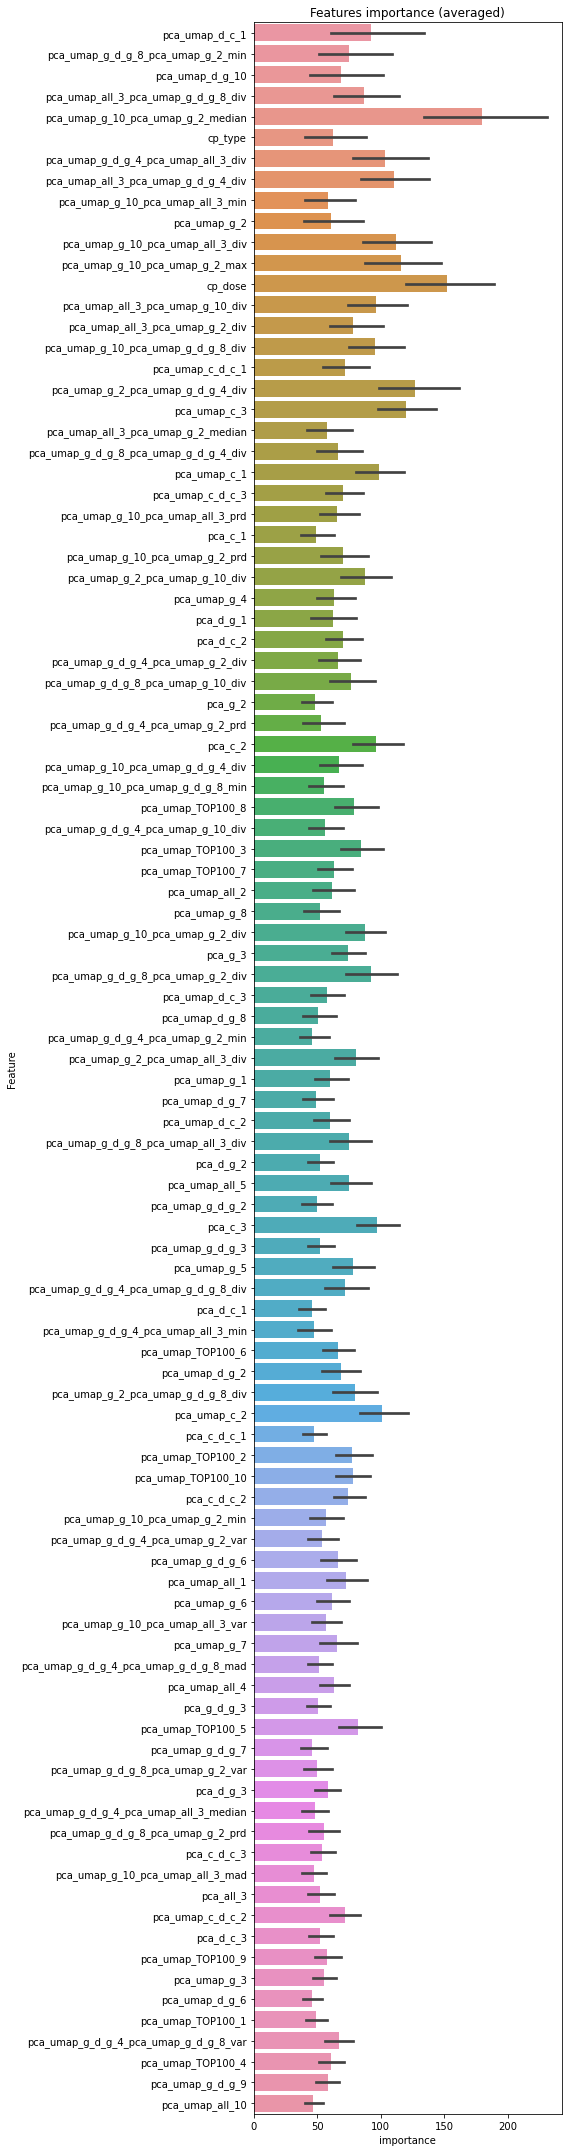

In [57]:
if DEBUG:
    show_feature_importance(feature_importance_df)